In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [10]:
n_epochs = 1000
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [11]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('home/samroadie/Desktop/ace_pytorch/data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('home/samroadie/Desktop/ace_pytorch/data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [14]:
network = Net()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [15]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

grad_norms = []

In [20]:
def grad_flow(named_parameters):
  grad_tensor = torch.zeros(0)
  grad_tensor=grad_tensor.to(device)
  for n, p in named_parameters:
    print(n)
    if p.requires_grad and "bias" not in n:
      curr_tensor = torch.flatten(p.grad.data)
      print(curr_tensor.size())
      grad_tensor = torch.cat((grad_tensor,curr_tensor),0)
    #print(torch.norm(torch.flatten(p.grad.data)))
  grad_norms.append(grad_tensor.norm().item())
     

In [21]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(device)
    output = network(data)
    output = output.to(device)
    target = target.to(device)
    loss = F.nll_loss(output, target)
    loss.backward()
    #print("PRINT PARAMETERS")
    #print(network.named_parameters)
    #plot_grad_flow(network.named_parameters())
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/home/samroadie/Desktop/ace_pytorch/model.pth')
      torch.save(optimizer.state_dict(),'/home/samroadie/Desktop/ace_pytorch/model.pth')
  print("PRINT PARAMETERS")
  grad_flow(network.named_parameters())
    

In [22]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      output = network(data)
      output = output.to(device)
      target = target.to(device)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [23]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-13-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1695, Accuracy: 9505/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.361446
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.474914
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.480534
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.573387
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.318680
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.356605
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.638227
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.370555
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.583971
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.459836
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.472749
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.553202
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.408373
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.418119
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.460885
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.499271
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.185351
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.636739
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.328866
Train Epoch: 1 [12160

Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.333179
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.639236
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.418977
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.427500
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.633455
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.534746
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.577395
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.364842
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.506143
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.732836
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.465428
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.748672
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.378537
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.696020
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.481975
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.312120
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.281531
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.343790
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.463937
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.297225


Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.535369
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.265438
Train Epoch: 4 [23680/60000 (39%)]	Loss: 0.373967
Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.506025
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.255238
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.178127
Train Epoch: 4 [26240/60000 (44%)]	Loss: 0.541518
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.611201
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.233525
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.326092
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.804909
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.746055
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.346802
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.585991
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.584422
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.380926
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.890422
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.888916
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.412811
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.381845


Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.464836
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.359828
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.127674
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.479841
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.516084
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.368194
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.239913
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.463396
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.477406
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.329360
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.201637
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.375192
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.116069
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.463627
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.161511
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.219808
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.341967
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.440985
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.359438
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.354311
Train Epoch: 6 

Train Epoch: 7 [45440/60000 (76%)]	Loss: 0.368818
Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.476571
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.283439
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.407023
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.425795
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.304666
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.301225
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.455352
Train Epoch: 7 [50560/60000 (84%)]	Loss: 0.375810
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.557743
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.466900
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.234711
Train Epoch: 7 [53120/60000 (88%)]	Loss: 0.475411
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.364840
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.578514
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.502726
Train Epoch: 7 [55680/60000 (93%)]	Loss: 0.234211
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.436677
Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.356180
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.052584


Train Epoch: 9 [26240/60000 (44%)]	Loss: 0.505549
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.350823
Train Epoch: 9 [27520/60000 (46%)]	Loss: 0.474200
Train Epoch: 9 [28160/60000 (47%)]	Loss: 0.392768
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.327285
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.262576
Train Epoch: 9 [30080/60000 (50%)]	Loss: 0.298072
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.458000
Train Epoch: 9 [31360/60000 (52%)]	Loss: 0.563452
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.165446
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.651700
Train Epoch: 9 [33280/60000 (55%)]	Loss: 0.604852
Train Epoch: 9 [33920/60000 (57%)]	Loss: 0.262048
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.489747
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.289781
Train Epoch: 9 [35840/60000 (60%)]	Loss: 0.744941
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.356572
Train Epoch: 9 [37120/60000 (62%)]	Loss: 0.300555
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.209511
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.376174


Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.298526
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.443681
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.670901
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.383651
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.257526
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.327180
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.194396
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.148857
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.083750
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.398547
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.289141
Train Epoch: 11 [12160/60000 (20%)]	Loss: 0.739579
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.893694
Train Epoch: 11 [13440/60000 (22%)]	Loss: 0.562081
Train Epoch: 11 [14080/60000 (23%)]	Loss: 0.161149
Train Epoch: 11 [14720/60000 (25%)]	Loss: 0.285076
Train Epoch: 11 [15360/60000 (26%)]	Loss: 0.414427
Train Epoch: 11 [16000/60000 (27%)]	Loss: 0.932349
Train Epoch: 11 [16640/60000 (28%)]	Loss: 0.538963
Train Epoch: 11 [17280/60000 (29%)]	Loss

Train Epoch: 12 [45440/60000 (76%)]	Loss: 0.437846
Train Epoch: 12 [46080/60000 (77%)]	Loss: 0.344966
Train Epoch: 12 [46720/60000 (78%)]	Loss: 0.212823
Train Epoch: 12 [47360/60000 (79%)]	Loss: 0.419216
Train Epoch: 12 [48000/60000 (80%)]	Loss: 0.191655
Train Epoch: 12 [48640/60000 (81%)]	Loss: 0.379397
Train Epoch: 12 [49280/60000 (82%)]	Loss: 0.631386
Train Epoch: 12 [49920/60000 (83%)]	Loss: 0.290946
Train Epoch: 12 [50560/60000 (84%)]	Loss: 0.780948
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.295248
Train Epoch: 12 [51840/60000 (86%)]	Loss: 0.504699
Train Epoch: 12 [52480/60000 (87%)]	Loss: 0.518955
Train Epoch: 12 [53120/60000 (88%)]	Loss: 0.403239
Train Epoch: 12 [53760/60000 (90%)]	Loss: 0.289472
Train Epoch: 12 [54400/60000 (91%)]	Loss: 0.264037
Train Epoch: 12 [55040/60000 (92%)]	Loss: 0.259496
Train Epoch: 12 [55680/60000 (93%)]	Loss: 0.403131
Train Epoch: 12 [56320/60000 (94%)]	Loss: 0.409340
Train Epoch: 12 [56960/60000 (95%)]	Loss: 0.655616
Train Epoch: 12 [57600/60000 (9

Train Epoch: 14 [24320/60000 (41%)]	Loss: 0.429526
Train Epoch: 14 [24960/60000 (42%)]	Loss: 0.433972
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.465001
Train Epoch: 14 [26240/60000 (44%)]	Loss: 0.418011
Train Epoch: 14 [26880/60000 (45%)]	Loss: 0.613381
Train Epoch: 14 [27520/60000 (46%)]	Loss: 0.551589
Train Epoch: 14 [28160/60000 (47%)]	Loss: 0.331483
Train Epoch: 14 [28800/60000 (48%)]	Loss: 0.623235
Train Epoch: 14 [29440/60000 (49%)]	Loss: 0.282259
Train Epoch: 14 [30080/60000 (50%)]	Loss: 0.703794
Train Epoch: 14 [30720/60000 (51%)]	Loss: 0.600457
Train Epoch: 14 [31360/60000 (52%)]	Loss: 0.307063
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.644115
Train Epoch: 14 [32640/60000 (54%)]	Loss: 0.228090
Train Epoch: 14 [33280/60000 (55%)]	Loss: 0.541808
Train Epoch: 14 [33920/60000 (57%)]	Loss: 0.254291
Train Epoch: 14 [34560/60000 (58%)]	Loss: 0.355653
Train Epoch: 14 [35200/60000 (59%)]	Loss: 0.566406
Train Epoch: 14 [35840/60000 (60%)]	Loss: 0.373523
Train Epoch: 14 [36480/60000 (6

Train Epoch: 16 [3200/60000 (5%)]	Loss: 0.461198
Train Epoch: 16 [3840/60000 (6%)]	Loss: 0.221198
Train Epoch: 16 [4480/60000 (7%)]	Loss: 0.242618
Train Epoch: 16 [5120/60000 (9%)]	Loss: 0.534304
Train Epoch: 16 [5760/60000 (10%)]	Loss: 0.381243
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.241057
Train Epoch: 16 [7040/60000 (12%)]	Loss: 0.510912
Train Epoch: 16 [7680/60000 (13%)]	Loss: 0.591361
Train Epoch: 16 [8320/60000 (14%)]	Loss: 0.176382
Train Epoch: 16 [8960/60000 (15%)]	Loss: 0.239708
Train Epoch: 16 [9600/60000 (16%)]	Loss: 0.377636
Train Epoch: 16 [10240/60000 (17%)]	Loss: 0.285345
Train Epoch: 16 [10880/60000 (18%)]	Loss: 0.634356
Train Epoch: 16 [11520/60000 (19%)]	Loss: 0.370226
Train Epoch: 16 [12160/60000 (20%)]	Loss: 0.505417
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.265629
Train Epoch: 16 [13440/60000 (22%)]	Loss: 0.368358
Train Epoch: 16 [14080/60000 (23%)]	Loss: 0.310575
Train Epoch: 16 [14720/60000 (25%)]	Loss: 0.441483
Train Epoch: 16 [15360/60000 (26%)]	Loss: 0.21

Train Epoch: 17 [43520/60000 (72%)]	Loss: 0.408975
Train Epoch: 17 [44160/60000 (74%)]	Loss: 0.277387
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.137386
Train Epoch: 17 [45440/60000 (76%)]	Loss: 0.815848
Train Epoch: 17 [46080/60000 (77%)]	Loss: 0.439829
Train Epoch: 17 [46720/60000 (78%)]	Loss: 0.172406
Train Epoch: 17 [47360/60000 (79%)]	Loss: 0.458292
Train Epoch: 17 [48000/60000 (80%)]	Loss: 0.965714
Train Epoch: 17 [48640/60000 (81%)]	Loss: 0.283230
Train Epoch: 17 [49280/60000 (82%)]	Loss: 0.328722
Train Epoch: 17 [49920/60000 (83%)]	Loss: 0.243402
Train Epoch: 17 [50560/60000 (84%)]	Loss: 0.283181
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.486920
Train Epoch: 17 [51840/60000 (86%)]	Loss: 0.622257
Train Epoch: 17 [52480/60000 (87%)]	Loss: 0.212244
Train Epoch: 17 [53120/60000 (88%)]	Loss: 0.498122
Train Epoch: 17 [53760/60000 (90%)]	Loss: 0.263371
Train Epoch: 17 [54400/60000 (91%)]	Loss: 0.133790
Train Epoch: 17 [55040/60000 (92%)]	Loss: 0.544860
Train Epoch: 17 [55680/60000 (9

Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.498244
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.449622
Train Epoch: 19 [23680/60000 (39%)]	Loss: 0.095970
Train Epoch: 19 [24320/60000 (41%)]	Loss: 0.379425
Train Epoch: 19 [24960/60000 (42%)]	Loss: 0.432108
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.595432
Train Epoch: 19 [26240/60000 (44%)]	Loss: 0.308264
Train Epoch: 19 [26880/60000 (45%)]	Loss: 0.633480
Train Epoch: 19 [27520/60000 (46%)]	Loss: 0.477502
Train Epoch: 19 [28160/60000 (47%)]	Loss: 0.196582
Train Epoch: 19 [28800/60000 (48%)]	Loss: 0.430609
Train Epoch: 19 [29440/60000 (49%)]	Loss: 0.326452
Train Epoch: 19 [30080/60000 (50%)]	Loss: 0.125561
Train Epoch: 19 [30720/60000 (51%)]	Loss: 0.390312
Train Epoch: 19 [31360/60000 (52%)]	Loss: 0.659485
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.502341
Train Epoch: 19 [32640/60000 (54%)]	Loss: 0.754663
Train Epoch: 19 [33280/60000 (55%)]	Loss: 0.515803
Train Epoch: 19 [33920/60000 (57%)]	Loss: 0.305900
Train Epoch: 19 [34560/60000 (5

Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.386476
Train Epoch: 21 [1920/60000 (3%)]	Loss: 0.338269
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.495404
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.425297
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.638721
Train Epoch: 21 [4480/60000 (7%)]	Loss: 0.338019
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.323401
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.334949
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.322312
Train Epoch: 21 [7040/60000 (12%)]	Loss: 0.165152
Train Epoch: 21 [7680/60000 (13%)]	Loss: 0.261431
Train Epoch: 21 [8320/60000 (14%)]	Loss: 0.540481
Train Epoch: 21 [8960/60000 (15%)]	Loss: 0.259692
Train Epoch: 21 [9600/60000 (16%)]	Loss: 0.479310
Train Epoch: 21 [10240/60000 (17%)]	Loss: 0.607437
Train Epoch: 21 [10880/60000 (18%)]	Loss: 0.358749
Train Epoch: 21 [11520/60000 (19%)]	Loss: 0.382110
Train Epoch: 21 [12160/60000 (20%)]	Loss: 0.415520
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.252387
Train Epoch: 21 [13440/60000 (22%)]	Loss: 0.307431
T

Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.426675
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.432933
Train Epoch: 22 [42880/60000 (71%)]	Loss: 0.631869
Train Epoch: 22 [43520/60000 (72%)]	Loss: 0.290569
Train Epoch: 22 [44160/60000 (74%)]	Loss: 0.758651
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.377187
Train Epoch: 22 [45440/60000 (76%)]	Loss: 0.229931
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.769132
Train Epoch: 22 [46720/60000 (78%)]	Loss: 0.390199
Train Epoch: 22 [47360/60000 (79%)]	Loss: 0.432109
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.273571
Train Epoch: 22 [48640/60000 (81%)]	Loss: 0.305054
Train Epoch: 22 [49280/60000 (82%)]	Loss: 0.692983
Train Epoch: 22 [49920/60000 (83%)]	Loss: 0.333956
Train Epoch: 22 [50560/60000 (84%)]	Loss: 0.745177
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.532482
Train Epoch: 22 [51840/60000 (86%)]	Loss: 0.252279
Train Epoch: 22 [52480/60000 (87%)]	Loss: 0.571760
Train Epoch: 22 [53120/60000 (88%)]	Loss: 0.720490
Train Epoch: 22 [53760/60000 (9

Train Epoch: 24 [20480/60000 (34%)]	Loss: 0.355811
Train Epoch: 24 [21120/60000 (35%)]	Loss: 0.496836
Train Epoch: 24 [21760/60000 (36%)]	Loss: 0.362556
Train Epoch: 24 [22400/60000 (37%)]	Loss: 0.347658
Train Epoch: 24 [23040/60000 (38%)]	Loss: 0.685651
Train Epoch: 24 [23680/60000 (39%)]	Loss: 0.412289
Train Epoch: 24 [24320/60000 (41%)]	Loss: 0.510278
Train Epoch: 24 [24960/60000 (42%)]	Loss: 0.417507
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.222962
Train Epoch: 24 [26240/60000 (44%)]	Loss: 0.253653
Train Epoch: 24 [26880/60000 (45%)]	Loss: 0.456280
Train Epoch: 24 [27520/60000 (46%)]	Loss: 1.183524
Train Epoch: 24 [28160/60000 (47%)]	Loss: 0.323479
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.666271
Train Epoch: 24 [29440/60000 (49%)]	Loss: 0.861786
Train Epoch: 24 [30080/60000 (50%)]	Loss: 0.358221
Train Epoch: 24 [30720/60000 (51%)]	Loss: 0.537146
Train Epoch: 24 [31360/60000 (52%)]	Loss: 0.387890
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.450998
Train Epoch: 24 [32640/60000 (5


Test set: Avg. loss: 0.1286, Accuracy: 9621/10000 (96%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.346562
Train Epoch: 26 [640/60000 (1%)]	Loss: 0.370191
Train Epoch: 26 [1280/60000 (2%)]	Loss: 0.360818
Train Epoch: 26 [1920/60000 (3%)]	Loss: 0.390765
Train Epoch: 26 [2560/60000 (4%)]	Loss: 0.335491
Train Epoch: 26 [3200/60000 (5%)]	Loss: 0.532830
Train Epoch: 26 [3840/60000 (6%)]	Loss: 0.315025
Train Epoch: 26 [4480/60000 (7%)]	Loss: 0.420110
Train Epoch: 26 [5120/60000 (9%)]	Loss: 0.263847
Train Epoch: 26 [5760/60000 (10%)]	Loss: 0.525868
Train Epoch: 26 [6400/60000 (11%)]	Loss: 0.382810
Train Epoch: 26 [7040/60000 (12%)]	Loss: 0.401641
Train Epoch: 26 [7680/60000 (13%)]	Loss: 0.338285
Train Epoch: 26 [8320/60000 (14%)]	Loss: 0.222612
Train Epoch: 26 [8960/60000 (15%)]	Loss: 0.372104
Train Epoch: 26 [9600/60000 (16%)]	Loss: 0.344749
Train Epoch: 26 [10240/60000 (17%)]	Loss: 0.266373
Train Epoch: 26 [10880/60000 (18%)]	Loss: 0.550586
Train Epoch: 26 [11520/60000 (19%)]	Loss: 0.577208
Tr

Train Epoch: 27 [39680/60000 (66%)]	Loss: 0.381917
Train Epoch: 27 [40320/60000 (67%)]	Loss: 0.531033
Train Epoch: 27 [40960/60000 (68%)]	Loss: 0.426072
Train Epoch: 27 [41600/60000 (69%)]	Loss: 0.216909
Train Epoch: 27 [42240/60000 (70%)]	Loss: 0.273040
Train Epoch: 27 [42880/60000 (71%)]	Loss: 0.241743
Train Epoch: 27 [43520/60000 (72%)]	Loss: 0.423503
Train Epoch: 27 [44160/60000 (74%)]	Loss: 0.311163
Train Epoch: 27 [44800/60000 (75%)]	Loss: 0.357595
Train Epoch: 27 [45440/60000 (76%)]	Loss: 0.238274
Train Epoch: 27 [46080/60000 (77%)]	Loss: 0.378133
Train Epoch: 27 [46720/60000 (78%)]	Loss: 0.300393
Train Epoch: 27 [47360/60000 (79%)]	Loss: 0.691448
Train Epoch: 27 [48000/60000 (80%)]	Loss: 0.377638
Train Epoch: 27 [48640/60000 (81%)]	Loss: 0.412212
Train Epoch: 27 [49280/60000 (82%)]	Loss: 0.615335
Train Epoch: 27 [49920/60000 (83%)]	Loss: 0.364729
Train Epoch: 27 [50560/60000 (84%)]	Loss: 0.203509
Train Epoch: 27 [51200/60000 (85%)]	Loss: 0.214082
Train Epoch: 27 [51840/60000 (8

Train Epoch: 29 [18560/60000 (31%)]	Loss: 0.134535
Train Epoch: 29 [19200/60000 (32%)]	Loss: 0.262668
Train Epoch: 29 [19840/60000 (33%)]	Loss: 0.356793
Train Epoch: 29 [20480/60000 (34%)]	Loss: 0.599182
Train Epoch: 29 [21120/60000 (35%)]	Loss: 0.423102
Train Epoch: 29 [21760/60000 (36%)]	Loss: 0.184070
Train Epoch: 29 [22400/60000 (37%)]	Loss: 0.443065
Train Epoch: 29 [23040/60000 (38%)]	Loss: 0.321665
Train Epoch: 29 [23680/60000 (39%)]	Loss: 0.459687
Train Epoch: 29 [24320/60000 (41%)]	Loss: 0.512659
Train Epoch: 29 [24960/60000 (42%)]	Loss: 0.155988
Train Epoch: 29 [25600/60000 (43%)]	Loss: 0.388458
Train Epoch: 29 [26240/60000 (44%)]	Loss: 0.371049
Train Epoch: 29 [26880/60000 (45%)]	Loss: 0.378266
Train Epoch: 29 [27520/60000 (46%)]	Loss: 0.487651
Train Epoch: 29 [28160/60000 (47%)]	Loss: 0.692818
Train Epoch: 29 [28800/60000 (48%)]	Loss: 0.869407
Train Epoch: 29 [29440/60000 (49%)]	Loss: 0.577755
Train Epoch: 29 [30080/60000 (50%)]	Loss: 0.522705
Train Epoch: 29 [30720/60000 (5

Train Epoch: 30 [58880/60000 (98%)]	Loss: 0.313403
Train Epoch: 30 [59520/60000 (99%)]	Loss: 0.336506
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1194, Accuracy: 9653/10000 (97%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.398038
Train Epoch: 31 [640/60000 (1%)]	Loss: 0.425320
Train Epoch: 31 [1280/60000 (2%)]	Loss: 0.633657
Train Epoch: 31 [1920/60000 (3%)]	Loss: 0.379699
Train Epoch: 31 [2560/60000 (4%)]	Loss: 0.466619
Train Epoch: 31 [3200/60000 (5%)]	Loss: 0.292220
Train Epoch: 31 [3840/60000 (6%)]	Loss: 0.429629
Train Epoch: 31 [4480/60000 (7%)]	Loss: 0.334895
Train Epoch: 31 [5120/60000 (9%)]	Loss: 0.328200
Train Epoch: 31 [5760/60000 (10%)]	Loss: 0.266789
Train Epoch: 31 [6400/60000 (11%)]	Loss: 0.351934
Train Epoch: 31 [7040/60000 (12%)]	Loss: 0.345296
Train Epoch: 31 [7680/60000 (13%)]	Loss: 0.263457
Train Epoch: 31 [8320/6

Train Epoch: 32 [37760/60000 (63%)]	Loss: 0.501333
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.408357
Train Epoch: 32 [39040/60000 (65%)]	Loss: 0.580133
Train Epoch: 32 [39680/60000 (66%)]	Loss: 0.338799
Train Epoch: 32 [40320/60000 (67%)]	Loss: 0.401824
Train Epoch: 32 [40960/60000 (68%)]	Loss: 0.280329
Train Epoch: 32 [41600/60000 (69%)]	Loss: 0.362004
Train Epoch: 32 [42240/60000 (70%)]	Loss: 0.194383
Train Epoch: 32 [42880/60000 (71%)]	Loss: 0.149413
Train Epoch: 32 [43520/60000 (72%)]	Loss: 0.628531
Train Epoch: 32 [44160/60000 (74%)]	Loss: 0.256564
Train Epoch: 32 [44800/60000 (75%)]	Loss: 0.579913
Train Epoch: 32 [45440/60000 (76%)]	Loss: 0.337062
Train Epoch: 32 [46080/60000 (77%)]	Loss: 0.467731
Train Epoch: 32 [46720/60000 (78%)]	Loss: 0.214025
Train Epoch: 32 [47360/60000 (79%)]	Loss: 0.178833
Train Epoch: 32 [48000/60000 (80%)]	Loss: 0.264123
Train Epoch: 32 [48640/60000 (81%)]	Loss: 0.247666
Train Epoch: 32 [49280/60000 (82%)]	Loss: 0.414158
Train Epoch: 32 [49920/60000 (8

Train Epoch: 34 [16640/60000 (28%)]	Loss: 0.146890
Train Epoch: 34 [17280/60000 (29%)]	Loss: 0.729015
Train Epoch: 34 [17920/60000 (30%)]	Loss: 0.408559
Train Epoch: 34 [18560/60000 (31%)]	Loss: 0.615691
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.248084
Train Epoch: 34 [19840/60000 (33%)]	Loss: 0.186313
Train Epoch: 34 [20480/60000 (34%)]	Loss: 0.381926
Train Epoch: 34 [21120/60000 (35%)]	Loss: 0.350748
Train Epoch: 34 [21760/60000 (36%)]	Loss: 0.302306
Train Epoch: 34 [22400/60000 (37%)]	Loss: 0.332242
Train Epoch: 34 [23040/60000 (38%)]	Loss: 0.832719
Train Epoch: 34 [23680/60000 (39%)]	Loss: 0.249552
Train Epoch: 34 [24320/60000 (41%)]	Loss: 0.338958
Train Epoch: 34 [24960/60000 (42%)]	Loss: 0.319779
Train Epoch: 34 [25600/60000 (43%)]	Loss: 0.311029
Train Epoch: 34 [26240/60000 (44%)]	Loss: 0.637985
Train Epoch: 34 [26880/60000 (45%)]	Loss: 0.319373
Train Epoch: 34 [27520/60000 (46%)]	Loss: 0.360347
Train Epoch: 34 [28160/60000 (47%)]	Loss: 0.373017
Train Epoch: 34 [28800/60000 (4

Train Epoch: 35 [56960/60000 (95%)]	Loss: 0.579182
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.595822
Train Epoch: 35 [58240/60000 (97%)]	Loss: 0.221891
Train Epoch: 35 [58880/60000 (98%)]	Loss: 0.203257
Train Epoch: 35 [59520/60000 (99%)]	Loss: 0.700331
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1138, Accuracy: 9659/10000 (97%)

Train Epoch: 36 [0/60000 (0%)]	Loss: 0.310071
Train Epoch: 36 [640/60000 (1%)]	Loss: 0.468556
Train Epoch: 36 [1280/60000 (2%)]	Loss: 0.287582
Train Epoch: 36 [1920/60000 (3%)]	Loss: 0.190660
Train Epoch: 36 [2560/60000 (4%)]	Loss: 0.241877
Train Epoch: 36 [3200/60000 (5%)]	Loss: 0.747694
Train Epoch: 36 [3840/60000 (6%)]	Loss: 0.245544
Train Epoch: 36 [4480/60000 (7%)]	Loss: 0.552055
Train Epoch: 36 [5120/60000 (9%)]	Loss: 0.444291
Train Epoch: 36 [5760/60000 (10%)]	Loss: 0.566112
Train Epoch: 36 [640

Train Epoch: 37 [35840/60000 (60%)]	Loss: 0.173857
Train Epoch: 37 [36480/60000 (61%)]	Loss: 0.415266
Train Epoch: 37 [37120/60000 (62%)]	Loss: 0.491788
Train Epoch: 37 [37760/60000 (63%)]	Loss: 0.270106
Train Epoch: 37 [38400/60000 (64%)]	Loss: 0.179995
Train Epoch: 37 [39040/60000 (65%)]	Loss: 0.739860
Train Epoch: 37 [39680/60000 (66%)]	Loss: 0.241701
Train Epoch: 37 [40320/60000 (67%)]	Loss: 0.345798
Train Epoch: 37 [40960/60000 (68%)]	Loss: 0.463507
Train Epoch: 37 [41600/60000 (69%)]	Loss: 0.250775
Train Epoch: 37 [42240/60000 (70%)]	Loss: 0.519538
Train Epoch: 37 [42880/60000 (71%)]	Loss: 0.361507
Train Epoch: 37 [43520/60000 (72%)]	Loss: 0.401171
Train Epoch: 37 [44160/60000 (74%)]	Loss: 0.352811
Train Epoch: 37 [44800/60000 (75%)]	Loss: 0.355617
Train Epoch: 37 [45440/60000 (76%)]	Loss: 0.389574
Train Epoch: 37 [46080/60000 (77%)]	Loss: 0.418000
Train Epoch: 37 [46720/60000 (78%)]	Loss: 0.468445
Train Epoch: 37 [47360/60000 (79%)]	Loss: 0.226456
Train Epoch: 37 [48000/60000 (8

Train Epoch: 39 [14720/60000 (25%)]	Loss: 0.605353
Train Epoch: 39 [15360/60000 (26%)]	Loss: 0.344114
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.470044
Train Epoch: 39 [16640/60000 (28%)]	Loss: 0.361798
Train Epoch: 39 [17280/60000 (29%)]	Loss: 0.699424
Train Epoch: 39 [17920/60000 (30%)]	Loss: 0.329567
Train Epoch: 39 [18560/60000 (31%)]	Loss: 0.384696
Train Epoch: 39 [19200/60000 (32%)]	Loss: 0.231281
Train Epoch: 39 [19840/60000 (33%)]	Loss: 0.907289
Train Epoch: 39 [20480/60000 (34%)]	Loss: 0.323722
Train Epoch: 39 [21120/60000 (35%)]	Loss: 0.372882
Train Epoch: 39 [21760/60000 (36%)]	Loss: 0.389767
Train Epoch: 39 [22400/60000 (37%)]	Loss: 0.250128
Train Epoch: 39 [23040/60000 (38%)]	Loss: 0.424085
Train Epoch: 39 [23680/60000 (39%)]	Loss: 0.167919
Train Epoch: 39 [24320/60000 (41%)]	Loss: 0.424738
Train Epoch: 39 [24960/60000 (42%)]	Loss: 0.145420
Train Epoch: 39 [25600/60000 (43%)]	Loss: 0.588567
Train Epoch: 39 [26240/60000 (44%)]	Loss: 0.211104
Train Epoch: 39 [26880/60000 (4

Train Epoch: 40 [55040/60000 (92%)]	Loss: 0.395044
Train Epoch: 40 [55680/60000 (93%)]	Loss: 0.440861
Train Epoch: 40 [56320/60000 (94%)]	Loss: 0.395105
Train Epoch: 40 [56960/60000 (95%)]	Loss: 0.487094
Train Epoch: 40 [57600/60000 (96%)]	Loss: 0.351003
Train Epoch: 40 [58240/60000 (97%)]	Loss: 0.237306
Train Epoch: 40 [58880/60000 (98%)]	Loss: 0.270333
Train Epoch: 40 [59520/60000 (99%)]	Loss: 0.306713
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1259, Accuracy: 9620/10000 (96%)

Train Epoch: 41 [0/60000 (0%)]	Loss: 0.348642
Train Epoch: 41 [640/60000 (1%)]	Loss: 0.424745
Train Epoch: 41 [1280/60000 (2%)]	Loss: 0.144625
Train Epoch: 41 [1920/60000 (3%)]	Loss: 0.542509
Train Epoch: 41 [2560/60000 (4%)]	Loss: 0.331231
Train Epoch: 41 [3200/60000 (5%)]	Loss: 0.372020
Train Epoch: 41 [3840/60000 (6%)]	Loss: 0.359172
Train Epoch: 41

Train Epoch: 42 [33920/60000 (57%)]	Loss: 0.167830
Train Epoch: 42 [34560/60000 (58%)]	Loss: 0.505756
Train Epoch: 42 [35200/60000 (59%)]	Loss: 0.364906
Train Epoch: 42 [35840/60000 (60%)]	Loss: 0.153664
Train Epoch: 42 [36480/60000 (61%)]	Loss: 0.231087
Train Epoch: 42 [37120/60000 (62%)]	Loss: 0.336903
Train Epoch: 42 [37760/60000 (63%)]	Loss: 0.500550
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.351560
Train Epoch: 42 [39040/60000 (65%)]	Loss: 0.448248
Train Epoch: 42 [39680/60000 (66%)]	Loss: 0.527634
Train Epoch: 42 [40320/60000 (67%)]	Loss: 0.281908
Train Epoch: 42 [40960/60000 (68%)]	Loss: 0.298315
Train Epoch: 42 [41600/60000 (69%)]	Loss: 0.259354
Train Epoch: 42 [42240/60000 (70%)]	Loss: 0.502036
Train Epoch: 42 [42880/60000 (71%)]	Loss: 0.421057
Train Epoch: 42 [43520/60000 (72%)]	Loss: 0.254236
Train Epoch: 42 [44160/60000 (74%)]	Loss: 0.365144
Train Epoch: 42 [44800/60000 (75%)]	Loss: 0.443012
Train Epoch: 42 [45440/60000 (76%)]	Loss: 0.354917
Train Epoch: 42 [46080/60000 (7

Train Epoch: 44 [11520/60000 (19%)]	Loss: 0.588038
Train Epoch: 44 [12160/60000 (20%)]	Loss: 0.250350
Train Epoch: 44 [12800/60000 (21%)]	Loss: 0.342246
Train Epoch: 44 [13440/60000 (22%)]	Loss: 0.098999
Train Epoch: 44 [14080/60000 (23%)]	Loss: 0.381826
Train Epoch: 44 [14720/60000 (25%)]	Loss: 0.117432
Train Epoch: 44 [15360/60000 (26%)]	Loss: 0.311137
Train Epoch: 44 [16000/60000 (27%)]	Loss: 0.453666
Train Epoch: 44 [16640/60000 (28%)]	Loss: 0.376878
Train Epoch: 44 [17280/60000 (29%)]	Loss: 0.344056
Train Epoch: 44 [17920/60000 (30%)]	Loss: 0.430868
Train Epoch: 44 [18560/60000 (31%)]	Loss: 0.134013
Train Epoch: 44 [19200/60000 (32%)]	Loss: 0.202591
Train Epoch: 44 [19840/60000 (33%)]	Loss: 0.299392
Train Epoch: 44 [20480/60000 (34%)]	Loss: 0.233531
Train Epoch: 44 [21120/60000 (35%)]	Loss: 0.468586
Train Epoch: 44 [21760/60000 (36%)]	Loss: 0.308113
Train Epoch: 44 [22400/60000 (37%)]	Loss: 0.427372
Train Epoch: 44 [23040/60000 (38%)]	Loss: 0.660694
Train Epoch: 44 [23680/60000 (3

Train Epoch: 45 [53120/60000 (88%)]	Loss: 0.361464
Train Epoch: 45 [53760/60000 (90%)]	Loss: 0.447086
Train Epoch: 45 [54400/60000 (91%)]	Loss: 0.611121
Train Epoch: 45 [55040/60000 (92%)]	Loss: 0.576427
Train Epoch: 45 [55680/60000 (93%)]	Loss: 0.543291
Train Epoch: 45 [56320/60000 (94%)]	Loss: 0.355478
Train Epoch: 45 [56960/60000 (95%)]	Loss: 0.366728
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.214573
Train Epoch: 45 [58240/60000 (97%)]	Loss: 0.635794
Train Epoch: 45 [58880/60000 (98%)]	Loss: 0.273931
Train Epoch: 45 [59520/60000 (99%)]	Loss: 0.277496
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1109, Accuracy: 9701/10000 (97%)

Train Epoch: 46 [0/60000 (0%)]	Loss: 0.196418
Train Epoch: 46 [640/60000 (1%)]	Loss: 0.207349
Train Epoch: 46 [1280/60000 (2%)]	Loss: 0.159527
Train Epoch: 46 [1920/60000 (3%)]	Loss: 0.258612
Train Epo

Train Epoch: 47 [32000/60000 (53%)]	Loss: 0.498725
Train Epoch: 47 [32640/60000 (54%)]	Loss: 0.450795
Train Epoch: 47 [33280/60000 (55%)]	Loss: 0.377130
Train Epoch: 47 [33920/60000 (57%)]	Loss: 0.401182
Train Epoch: 47 [34560/60000 (58%)]	Loss: 0.366868
Train Epoch: 47 [35200/60000 (59%)]	Loss: 0.398885
Train Epoch: 47 [35840/60000 (60%)]	Loss: 0.445435
Train Epoch: 47 [36480/60000 (61%)]	Loss: 0.410069
Train Epoch: 47 [37120/60000 (62%)]	Loss: 0.229046
Train Epoch: 47 [37760/60000 (63%)]	Loss: 0.216871
Train Epoch: 47 [38400/60000 (64%)]	Loss: 0.599009
Train Epoch: 47 [39040/60000 (65%)]	Loss: 0.336978
Train Epoch: 47 [39680/60000 (66%)]	Loss: 0.414149
Train Epoch: 47 [40320/60000 (67%)]	Loss: 0.402921
Train Epoch: 47 [40960/60000 (68%)]	Loss: 0.252463
Train Epoch: 47 [41600/60000 (69%)]	Loss: 0.286146
Train Epoch: 47 [42240/60000 (70%)]	Loss: 0.388465
Train Epoch: 47 [42880/60000 (71%)]	Loss: 0.380479
Train Epoch: 47 [43520/60000 (72%)]	Loss: 0.444341
Train Epoch: 47 [44160/60000 (7

Train Epoch: 49 [10880/60000 (18%)]	Loss: 0.244304
Train Epoch: 49 [11520/60000 (19%)]	Loss: 0.359015
Train Epoch: 49 [12160/60000 (20%)]	Loss: 0.218000
Train Epoch: 49 [12800/60000 (21%)]	Loss: 0.274799
Train Epoch: 49 [13440/60000 (22%)]	Loss: 0.192904
Train Epoch: 49 [14080/60000 (23%)]	Loss: 0.545815
Train Epoch: 49 [14720/60000 (25%)]	Loss: 0.222214
Train Epoch: 49 [15360/60000 (26%)]	Loss: 0.293378
Train Epoch: 49 [16000/60000 (27%)]	Loss: 0.401052
Train Epoch: 49 [16640/60000 (28%)]	Loss: 0.376189
Train Epoch: 49 [17280/60000 (29%)]	Loss: 0.368780
Train Epoch: 49 [17920/60000 (30%)]	Loss: 0.433253
Train Epoch: 49 [18560/60000 (31%)]	Loss: 0.448916
Train Epoch: 49 [19200/60000 (32%)]	Loss: 0.535289
Train Epoch: 49 [19840/60000 (33%)]	Loss: 0.577609
Train Epoch: 49 [20480/60000 (34%)]	Loss: 0.257446
Train Epoch: 49 [21120/60000 (35%)]	Loss: 0.825178
Train Epoch: 49 [21760/60000 (36%)]	Loss: 0.568093
Train Epoch: 49 [22400/60000 (37%)]	Loss: 0.461745
Train Epoch: 49 [23040/60000 (3

Train Epoch: 50 [51200/60000 (85%)]	Loss: 0.490739
Train Epoch: 50 [51840/60000 (86%)]	Loss: 0.380723
Train Epoch: 50 [52480/60000 (87%)]	Loss: 0.709026
Train Epoch: 50 [53120/60000 (88%)]	Loss: 0.402682
Train Epoch: 50 [53760/60000 (90%)]	Loss: 0.153510
Train Epoch: 50 [54400/60000 (91%)]	Loss: 0.283543
Train Epoch: 50 [55040/60000 (92%)]	Loss: 0.204254
Train Epoch: 50 [55680/60000 (93%)]	Loss: 0.157353
Train Epoch: 50 [56320/60000 (94%)]	Loss: 0.462250
Train Epoch: 50 [56960/60000 (95%)]	Loss: 0.313375
Train Epoch: 50 [57600/60000 (96%)]	Loss: 0.250169
Train Epoch: 50 [58240/60000 (97%)]	Loss: 0.398062
Train Epoch: 50 [58880/60000 (98%)]	Loss: 0.357506
Train Epoch: 50 [59520/60000 (99%)]	Loss: 0.355843
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1193, Accuracy: 9630/10000 (96%)

Train Epoch: 51 [0/60000 (0%)]	Loss: 0.432357
Tr

Train Epoch: 52 [29440/60000 (49%)]	Loss: 0.373008
Train Epoch: 52 [30080/60000 (50%)]	Loss: 0.421901
Train Epoch: 52 [30720/60000 (51%)]	Loss: 0.797726
Train Epoch: 52 [31360/60000 (52%)]	Loss: 0.964469
Train Epoch: 52 [32000/60000 (53%)]	Loss: 0.395002
Train Epoch: 52 [32640/60000 (54%)]	Loss: 0.233958
Train Epoch: 52 [33280/60000 (55%)]	Loss: 0.619580
Train Epoch: 52 [33920/60000 (57%)]	Loss: 0.578130
Train Epoch: 52 [34560/60000 (58%)]	Loss: 0.295377
Train Epoch: 52 [35200/60000 (59%)]	Loss: 0.519279
Train Epoch: 52 [35840/60000 (60%)]	Loss: 0.201578
Train Epoch: 52 [36480/60000 (61%)]	Loss: 0.242018
Train Epoch: 52 [37120/60000 (62%)]	Loss: 0.627254
Train Epoch: 52 [37760/60000 (63%)]	Loss: 0.055368
Train Epoch: 52 [38400/60000 (64%)]	Loss: 0.512353
Train Epoch: 52 [39040/60000 (65%)]	Loss: 0.512160
Train Epoch: 52 [39680/60000 (66%)]	Loss: 0.336486
Train Epoch: 52 [40320/60000 (67%)]	Loss: 0.533687
Train Epoch: 52 [40960/60000 (68%)]	Loss: 0.450835
Train Epoch: 52 [41600/60000 (6

Train Epoch: 54 [7040/60000 (12%)]	Loss: 0.403619
Train Epoch: 54 [7680/60000 (13%)]	Loss: 0.164048
Train Epoch: 54 [8320/60000 (14%)]	Loss: 0.380489
Train Epoch: 54 [8960/60000 (15%)]	Loss: 0.217681
Train Epoch: 54 [9600/60000 (16%)]	Loss: 0.309993
Train Epoch: 54 [10240/60000 (17%)]	Loss: 0.304250
Train Epoch: 54 [10880/60000 (18%)]	Loss: 0.212595
Train Epoch: 54 [11520/60000 (19%)]	Loss: 0.137094
Train Epoch: 54 [12160/60000 (20%)]	Loss: 0.351138
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.432173
Train Epoch: 54 [13440/60000 (22%)]	Loss: 0.206149
Train Epoch: 54 [14080/60000 (23%)]	Loss: 0.543538
Train Epoch: 54 [14720/60000 (25%)]	Loss: 0.205595
Train Epoch: 54 [15360/60000 (26%)]	Loss: 0.575328
Train Epoch: 54 [16000/60000 (27%)]	Loss: 0.497252
Train Epoch: 54 [16640/60000 (28%)]	Loss: 0.573180
Train Epoch: 54 [17280/60000 (29%)]	Loss: 0.414131
Train Epoch: 54 [17920/60000 (30%)]	Loss: 0.370928
Train Epoch: 54 [18560/60000 (31%)]	Loss: 0.485242
Train Epoch: 54 [19200/60000 (32%)]	

Train Epoch: 55 [47360/60000 (79%)]	Loss: 0.231646
Train Epoch: 55 [48000/60000 (80%)]	Loss: 0.235320
Train Epoch: 55 [48640/60000 (81%)]	Loss: 0.330180
Train Epoch: 55 [49280/60000 (82%)]	Loss: 0.359797
Train Epoch: 55 [49920/60000 (83%)]	Loss: 0.329958
Train Epoch: 55 [50560/60000 (84%)]	Loss: 0.152428
Train Epoch: 55 [51200/60000 (85%)]	Loss: 0.497846
Train Epoch: 55 [51840/60000 (86%)]	Loss: 0.338282
Train Epoch: 55 [52480/60000 (87%)]	Loss: 0.321541
Train Epoch: 55 [53120/60000 (88%)]	Loss: 0.268214
Train Epoch: 55 [53760/60000 (90%)]	Loss: 0.301687
Train Epoch: 55 [54400/60000 (91%)]	Loss: 0.342415
Train Epoch: 55 [55040/60000 (92%)]	Loss: 0.380497
Train Epoch: 55 [55680/60000 (93%)]	Loss: 0.364441
Train Epoch: 55 [56320/60000 (94%)]	Loss: 0.271960
Train Epoch: 55 [56960/60000 (95%)]	Loss: 0.405557
Train Epoch: 55 [57600/60000 (96%)]	Loss: 0.552669
Train Epoch: 55 [58240/60000 (97%)]	Loss: 0.366088
Train Epoch: 55 [58880/60000 (98%)]	Loss: 0.344564
Train Epoch: 55 [59520/60000 (9

Train Epoch: 57 [26240/60000 (44%)]	Loss: 0.318091
Train Epoch: 57 [26880/60000 (45%)]	Loss: 0.484414
Train Epoch: 57 [27520/60000 (46%)]	Loss: 0.769590
Train Epoch: 57 [28160/60000 (47%)]	Loss: 0.361316
Train Epoch: 57 [28800/60000 (48%)]	Loss: 0.156041
Train Epoch: 57 [29440/60000 (49%)]	Loss: 0.375995
Train Epoch: 57 [30080/60000 (50%)]	Loss: 0.187953
Train Epoch: 57 [30720/60000 (51%)]	Loss: 0.274473
Train Epoch: 57 [31360/60000 (52%)]	Loss: 0.513830
Train Epoch: 57 [32000/60000 (53%)]	Loss: 0.580563
Train Epoch: 57 [32640/60000 (54%)]	Loss: 0.324755
Train Epoch: 57 [33280/60000 (55%)]	Loss: 0.497111
Train Epoch: 57 [33920/60000 (57%)]	Loss: 0.239956
Train Epoch: 57 [34560/60000 (58%)]	Loss: 0.285040
Train Epoch: 57 [35200/60000 (59%)]	Loss: 0.521211
Train Epoch: 57 [35840/60000 (60%)]	Loss: 0.663403
Train Epoch: 57 [36480/60000 (61%)]	Loss: 0.301377
Train Epoch: 57 [37120/60000 (62%)]	Loss: 0.613493
Train Epoch: 57 [37760/60000 (63%)]	Loss: 0.382767
Train Epoch: 57 [38400/60000 (6

Train Epoch: 59 [5120/60000 (9%)]	Loss: 0.635792
Train Epoch: 59 [5760/60000 (10%)]	Loss: 0.863586
Train Epoch: 59 [6400/60000 (11%)]	Loss: 0.260324
Train Epoch: 59 [7040/60000 (12%)]	Loss: 0.418988
Train Epoch: 59 [7680/60000 (13%)]	Loss: 0.470237
Train Epoch: 59 [8320/60000 (14%)]	Loss: 0.624315
Train Epoch: 59 [8960/60000 (15%)]	Loss: 0.881665
Train Epoch: 59 [9600/60000 (16%)]	Loss: 0.340200
Train Epoch: 59 [10240/60000 (17%)]	Loss: 0.723822
Train Epoch: 59 [10880/60000 (18%)]	Loss: 0.164352
Train Epoch: 59 [11520/60000 (19%)]	Loss: 0.415003
Train Epoch: 59 [12160/60000 (20%)]	Loss: 0.243798
Train Epoch: 59 [12800/60000 (21%)]	Loss: 0.143245
Train Epoch: 59 [13440/60000 (22%)]	Loss: 0.391818
Train Epoch: 59 [14080/60000 (23%)]	Loss: 0.370856
Train Epoch: 59 [14720/60000 (25%)]	Loss: 0.359490
Train Epoch: 59 [15360/60000 (26%)]	Loss: 0.454439
Train Epoch: 59 [16000/60000 (27%)]	Loss: 0.597139
Train Epoch: 59 [16640/60000 (28%)]	Loss: 0.361760
Train Epoch: 59 [17280/60000 (29%)]	Loss

Train Epoch: 60 [45440/60000 (76%)]	Loss: 0.473925
Train Epoch: 60 [46080/60000 (77%)]	Loss: 0.503921
Train Epoch: 60 [46720/60000 (78%)]	Loss: 0.319686
Train Epoch: 60 [47360/60000 (79%)]	Loss: 0.717186
Train Epoch: 60 [48000/60000 (80%)]	Loss: 0.240182
Train Epoch: 60 [48640/60000 (81%)]	Loss: 0.508373
Train Epoch: 60 [49280/60000 (82%)]	Loss: 0.298556
Train Epoch: 60 [49920/60000 (83%)]	Loss: 0.209042
Train Epoch: 60 [50560/60000 (84%)]	Loss: 0.356801
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.328176
Train Epoch: 60 [51840/60000 (86%)]	Loss: 0.670825
Train Epoch: 60 [52480/60000 (87%)]	Loss: 0.429633
Train Epoch: 60 [53120/60000 (88%)]	Loss: 0.772348
Train Epoch: 60 [53760/60000 (90%)]	Loss: 0.399141
Train Epoch: 60 [54400/60000 (91%)]	Loss: 0.136341
Train Epoch: 60 [55040/60000 (92%)]	Loss: 0.378298
Train Epoch: 60 [55680/60000 (93%)]	Loss: 0.740133
Train Epoch: 60 [56320/60000 (94%)]	Loss: 0.848948
Train Epoch: 60 [56960/60000 (95%)]	Loss: 0.452690
Train Epoch: 60 [57600/60000 (9

Train Epoch: 62 [24320/60000 (41%)]	Loss: 0.423151
Train Epoch: 62 [24960/60000 (42%)]	Loss: 0.302287
Train Epoch: 62 [25600/60000 (43%)]	Loss: 0.301643
Train Epoch: 62 [26240/60000 (44%)]	Loss: 0.375770
Train Epoch: 62 [26880/60000 (45%)]	Loss: 0.433400
Train Epoch: 62 [27520/60000 (46%)]	Loss: 0.321989
Train Epoch: 62 [28160/60000 (47%)]	Loss: 0.339396
Train Epoch: 62 [28800/60000 (48%)]	Loss: 0.219092
Train Epoch: 62 [29440/60000 (49%)]	Loss: 0.468363
Train Epoch: 62 [30080/60000 (50%)]	Loss: 0.626235
Train Epoch: 62 [30720/60000 (51%)]	Loss: 0.735545
Train Epoch: 62 [31360/60000 (52%)]	Loss: 0.354401
Train Epoch: 62 [32000/60000 (53%)]	Loss: 0.421402
Train Epoch: 62 [32640/60000 (54%)]	Loss: 0.229491
Train Epoch: 62 [33280/60000 (55%)]	Loss: 0.328792
Train Epoch: 62 [33920/60000 (57%)]	Loss: 0.740246
Train Epoch: 62 [34560/60000 (58%)]	Loss: 0.591430
Train Epoch: 62 [35200/60000 (59%)]	Loss: 0.694844
Train Epoch: 62 [35840/60000 (60%)]	Loss: 0.341598
Train Epoch: 62 [36480/60000 (6

Train Epoch: 64 [3200/60000 (5%)]	Loss: 0.534230
Train Epoch: 64 [3840/60000 (6%)]	Loss: 0.415839
Train Epoch: 64 [4480/60000 (7%)]	Loss: 0.369593
Train Epoch: 64 [5120/60000 (9%)]	Loss: 0.628488
Train Epoch: 64 [5760/60000 (10%)]	Loss: 0.237959
Train Epoch: 64 [6400/60000 (11%)]	Loss: 0.488135
Train Epoch: 64 [7040/60000 (12%)]	Loss: 0.406734
Train Epoch: 64 [7680/60000 (13%)]	Loss: 0.298570
Train Epoch: 64 [8320/60000 (14%)]	Loss: 0.423993
Train Epoch: 64 [8960/60000 (15%)]	Loss: 0.553166
Train Epoch: 64 [9600/60000 (16%)]	Loss: 0.245295
Train Epoch: 64 [10240/60000 (17%)]	Loss: 0.378911
Train Epoch: 64 [10880/60000 (18%)]	Loss: 0.301164
Train Epoch: 64 [11520/60000 (19%)]	Loss: 0.760266
Train Epoch: 64 [12160/60000 (20%)]	Loss: 0.481716
Train Epoch: 64 [12800/60000 (21%)]	Loss: 0.141597
Train Epoch: 64 [13440/60000 (22%)]	Loss: 0.256686
Train Epoch: 64 [14080/60000 (23%)]	Loss: 0.366432
Train Epoch: 64 [14720/60000 (25%)]	Loss: 0.256965
Train Epoch: 64 [15360/60000 (26%)]	Loss: 0.42

Train Epoch: 65 [43520/60000 (72%)]	Loss: 0.271057
Train Epoch: 65 [44160/60000 (74%)]	Loss: 0.455096
Train Epoch: 65 [44800/60000 (75%)]	Loss: 0.494737
Train Epoch: 65 [45440/60000 (76%)]	Loss: 0.150210
Train Epoch: 65 [46080/60000 (77%)]	Loss: 0.484657
Train Epoch: 65 [46720/60000 (78%)]	Loss: 0.206969
Train Epoch: 65 [47360/60000 (79%)]	Loss: 0.674661
Train Epoch: 65 [48000/60000 (80%)]	Loss: 0.360013
Train Epoch: 65 [48640/60000 (81%)]	Loss: 0.294891
Train Epoch: 65 [49280/60000 (82%)]	Loss: 0.409284
Train Epoch: 65 [49920/60000 (83%)]	Loss: 0.370779
Train Epoch: 65 [50560/60000 (84%)]	Loss: 0.323140
Train Epoch: 65 [51200/60000 (85%)]	Loss: 0.770300
Train Epoch: 65 [51840/60000 (86%)]	Loss: 0.486337
Train Epoch: 65 [52480/60000 (87%)]	Loss: 0.277362
Train Epoch: 65 [53120/60000 (88%)]	Loss: 0.440736
Train Epoch: 65 [53760/60000 (90%)]	Loss: 0.338238
Train Epoch: 65 [54400/60000 (91%)]	Loss: 0.182802
Train Epoch: 65 [55040/60000 (92%)]	Loss: 0.482132
Train Epoch: 65 [55680/60000 (9

Train Epoch: 67 [22400/60000 (37%)]	Loss: 0.304538
Train Epoch: 67 [23040/60000 (38%)]	Loss: 0.356634
Train Epoch: 67 [23680/60000 (39%)]	Loss: 0.375474
Train Epoch: 67 [24320/60000 (41%)]	Loss: 0.325179
Train Epoch: 67 [24960/60000 (42%)]	Loss: 0.351792
Train Epoch: 67 [25600/60000 (43%)]	Loss: 0.284047
Train Epoch: 67 [26240/60000 (44%)]	Loss: 0.405901
Train Epoch: 67 [26880/60000 (45%)]	Loss: 0.332327
Train Epoch: 67 [27520/60000 (46%)]	Loss: 0.366718
Train Epoch: 67 [28160/60000 (47%)]	Loss: 0.426091
Train Epoch: 67 [28800/60000 (48%)]	Loss: 0.355619
Train Epoch: 67 [29440/60000 (49%)]	Loss: 0.303149
Train Epoch: 67 [30080/60000 (50%)]	Loss: 0.585508
Train Epoch: 67 [30720/60000 (51%)]	Loss: 0.268763
Train Epoch: 67 [31360/60000 (52%)]	Loss: 0.431217
Train Epoch: 67 [32000/60000 (53%)]	Loss: 0.552576
Train Epoch: 67 [32640/60000 (54%)]	Loss: 0.657277
Train Epoch: 67 [33280/60000 (55%)]	Loss: 0.494369
Train Epoch: 67 [33920/60000 (57%)]	Loss: 0.216647
Train Epoch: 67 [34560/60000 (5

Train Epoch: 69 [1280/60000 (2%)]	Loss: 0.390588
Train Epoch: 69 [1920/60000 (3%)]	Loss: 0.075234
Train Epoch: 69 [2560/60000 (4%)]	Loss: 0.533679
Train Epoch: 69 [3200/60000 (5%)]	Loss: 0.277873
Train Epoch: 69 [3840/60000 (6%)]	Loss: 0.373672
Train Epoch: 69 [4480/60000 (7%)]	Loss: 0.655877
Train Epoch: 69 [5120/60000 (9%)]	Loss: 0.409664
Train Epoch: 69 [5760/60000 (10%)]	Loss: 0.711776
Train Epoch: 69 [6400/60000 (11%)]	Loss: 0.726162
Train Epoch: 69 [7040/60000 (12%)]	Loss: 0.403128
Train Epoch: 69 [7680/60000 (13%)]	Loss: 0.244699
Train Epoch: 69 [8320/60000 (14%)]	Loss: 0.453652
Train Epoch: 69 [8960/60000 (15%)]	Loss: 0.395936
Train Epoch: 69 [9600/60000 (16%)]	Loss: 0.483372
Train Epoch: 69 [10240/60000 (17%)]	Loss: 1.238200
Train Epoch: 69 [10880/60000 (18%)]	Loss: 0.242346
Train Epoch: 69 [11520/60000 (19%)]	Loss: 0.345793
Train Epoch: 69 [12160/60000 (20%)]	Loss: 0.725553
Train Epoch: 69 [12800/60000 (21%)]	Loss: 0.512081
Train Epoch: 69 [13440/60000 (22%)]	Loss: 0.323859
T

Train Epoch: 70 [41600/60000 (69%)]	Loss: 0.564829
Train Epoch: 70 [42240/60000 (70%)]	Loss: 0.165961
Train Epoch: 70 [42880/60000 (71%)]	Loss: 0.214629
Train Epoch: 70 [43520/60000 (72%)]	Loss: 0.212373
Train Epoch: 70 [44160/60000 (74%)]	Loss: 0.150477
Train Epoch: 70 [44800/60000 (75%)]	Loss: 0.666439
Train Epoch: 70 [45440/60000 (76%)]	Loss: 0.436140
Train Epoch: 70 [46080/60000 (77%)]	Loss: 0.188537
Train Epoch: 70 [46720/60000 (78%)]	Loss: 0.234796
Train Epoch: 70 [47360/60000 (79%)]	Loss: 0.285638
Train Epoch: 70 [48000/60000 (80%)]	Loss: 0.343214
Train Epoch: 70 [48640/60000 (81%)]	Loss: 0.713286
Train Epoch: 70 [49280/60000 (82%)]	Loss: 0.277021
Train Epoch: 70 [49920/60000 (83%)]	Loss: 0.319100
Train Epoch: 70 [50560/60000 (84%)]	Loss: 0.308366
Train Epoch: 70 [51200/60000 (85%)]	Loss: 0.490016
Train Epoch: 70 [51840/60000 (86%)]	Loss: 0.310039
Train Epoch: 70 [52480/60000 (87%)]	Loss: 0.229499
Train Epoch: 70 [53120/60000 (88%)]	Loss: 0.495195
Train Epoch: 70 [53760/60000 (9

Train Epoch: 72 [20480/60000 (34%)]	Loss: 0.497400
Train Epoch: 72 [21120/60000 (35%)]	Loss: 0.223989
Train Epoch: 72 [21760/60000 (36%)]	Loss: 0.459446
Train Epoch: 72 [22400/60000 (37%)]	Loss: 0.511732
Train Epoch: 72 [23040/60000 (38%)]	Loss: 0.321983
Train Epoch: 72 [23680/60000 (39%)]	Loss: 0.388211
Train Epoch: 72 [24320/60000 (41%)]	Loss: 0.223812
Train Epoch: 72 [24960/60000 (42%)]	Loss: 0.375819
Train Epoch: 72 [25600/60000 (43%)]	Loss: 0.581926
Train Epoch: 72 [26240/60000 (44%)]	Loss: 0.381609
Train Epoch: 72 [26880/60000 (45%)]	Loss: 0.697377
Train Epoch: 72 [27520/60000 (46%)]	Loss: 0.225173
Train Epoch: 72 [28160/60000 (47%)]	Loss: 0.334537
Train Epoch: 72 [28800/60000 (48%)]	Loss: 0.702481
Train Epoch: 72 [29440/60000 (49%)]	Loss: 0.280737
Train Epoch: 72 [30080/60000 (50%)]	Loss: 0.315509
Train Epoch: 72 [30720/60000 (51%)]	Loss: 0.592490
Train Epoch: 72 [31360/60000 (52%)]	Loss: 0.325975
Train Epoch: 72 [32000/60000 (53%)]	Loss: 0.632075
Train Epoch: 72 [32640/60000 (5


Test set: Avg. loss: 0.1350, Accuracy: 9590/10000 (96%)

Train Epoch: 74 [0/60000 (0%)]	Loss: 0.354345
Train Epoch: 74 [640/60000 (1%)]	Loss: 0.280427
Train Epoch: 74 [1280/60000 (2%)]	Loss: 0.273708
Train Epoch: 74 [1920/60000 (3%)]	Loss: 0.220005
Train Epoch: 74 [2560/60000 (4%)]	Loss: 0.357157
Train Epoch: 74 [3200/60000 (5%)]	Loss: 0.467965
Train Epoch: 74 [3840/60000 (6%)]	Loss: 0.569042
Train Epoch: 74 [4480/60000 (7%)]	Loss: 0.258692
Train Epoch: 74 [5120/60000 (9%)]	Loss: 0.149373
Train Epoch: 74 [5760/60000 (10%)]	Loss: 0.504147
Train Epoch: 74 [6400/60000 (11%)]	Loss: 0.682925
Train Epoch: 74 [7040/60000 (12%)]	Loss: 0.353504
Train Epoch: 74 [7680/60000 (13%)]	Loss: 0.344304
Train Epoch: 74 [8320/60000 (14%)]	Loss: 0.472090
Train Epoch: 74 [8960/60000 (15%)]	Loss: 0.180574
Train Epoch: 74 [9600/60000 (16%)]	Loss: 0.244732
Train Epoch: 74 [10240/60000 (17%)]	Loss: 0.512438
Train Epoch: 74 [10880/60000 (18%)]	Loss: 0.216831
Train Epoch: 74 [11520/60000 (19%)]	Loss: 0.510959
Tr

Train Epoch: 75 [40320/60000 (67%)]	Loss: 0.396419
Train Epoch: 75 [40960/60000 (68%)]	Loss: 0.226593
Train Epoch: 75 [41600/60000 (69%)]	Loss: 0.399411
Train Epoch: 75 [42240/60000 (70%)]	Loss: 0.533418
Train Epoch: 75 [42880/60000 (71%)]	Loss: 0.344679
Train Epoch: 75 [43520/60000 (72%)]	Loss: 0.375912
Train Epoch: 75 [44160/60000 (74%)]	Loss: 0.307493
Train Epoch: 75 [44800/60000 (75%)]	Loss: 0.214375
Train Epoch: 75 [45440/60000 (76%)]	Loss: 0.204292
Train Epoch: 75 [46080/60000 (77%)]	Loss: 0.191560
Train Epoch: 75 [46720/60000 (78%)]	Loss: 0.361535
Train Epoch: 75 [47360/60000 (79%)]	Loss: 0.247247
Train Epoch: 75 [48000/60000 (80%)]	Loss: 0.205051
Train Epoch: 75 [48640/60000 (81%)]	Loss: 0.171108
Train Epoch: 75 [49280/60000 (82%)]	Loss: 0.392557
Train Epoch: 75 [49920/60000 (83%)]	Loss: 0.417375
Train Epoch: 75 [50560/60000 (84%)]	Loss: 0.408367
Train Epoch: 75 [51200/60000 (85%)]	Loss: 0.214317
Train Epoch: 75 [51840/60000 (86%)]	Loss: 0.423098
Train Epoch: 75 [52480/60000 (8

Train Epoch: 77 [18560/60000 (31%)]	Loss: 0.732898
Train Epoch: 77 [19200/60000 (32%)]	Loss: 0.660262
Train Epoch: 77 [19840/60000 (33%)]	Loss: 0.367249
Train Epoch: 77 [20480/60000 (34%)]	Loss: 1.008877
Train Epoch: 77 [21120/60000 (35%)]	Loss: 0.327347
Train Epoch: 77 [21760/60000 (36%)]	Loss: 0.258741
Train Epoch: 77 [22400/60000 (37%)]	Loss: 0.459301
Train Epoch: 77 [23040/60000 (38%)]	Loss: 0.352847
Train Epoch: 77 [23680/60000 (39%)]	Loss: 0.643785
Train Epoch: 77 [24320/60000 (41%)]	Loss: 0.194836
Train Epoch: 77 [24960/60000 (42%)]	Loss: 0.238391
Train Epoch: 77 [25600/60000 (43%)]	Loss: 0.315964
Train Epoch: 77 [26240/60000 (44%)]	Loss: 0.561027
Train Epoch: 77 [26880/60000 (45%)]	Loss: 0.594657
Train Epoch: 77 [27520/60000 (46%)]	Loss: 0.250746
Train Epoch: 77 [28160/60000 (47%)]	Loss: 0.105151
Train Epoch: 77 [28800/60000 (48%)]	Loss: 0.222133
Train Epoch: 77 [29440/60000 (49%)]	Loss: 0.399072
Train Epoch: 77 [30080/60000 (50%)]	Loss: 0.186575
Train Epoch: 77 [30720/60000 (5

Train Epoch: 78 [58880/60000 (98%)]	Loss: 0.272215
Train Epoch: 78 [59520/60000 (99%)]	Loss: 0.393163
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1155, Accuracy: 9687/10000 (97%)

Train Epoch: 79 [0/60000 (0%)]	Loss: 0.649836
Train Epoch: 79 [640/60000 (1%)]	Loss: 0.628555
Train Epoch: 79 [1280/60000 (2%)]	Loss: 0.439308
Train Epoch: 79 [1920/60000 (3%)]	Loss: 0.786167
Train Epoch: 79 [2560/60000 (4%)]	Loss: 0.183509
Train Epoch: 79 [3200/60000 (5%)]	Loss: 0.600474
Train Epoch: 79 [3840/60000 (6%)]	Loss: 0.268735
Train Epoch: 79 [4480/60000 (7%)]	Loss: 0.626494
Train Epoch: 79 [5120/60000 (9%)]	Loss: 0.278465
Train Epoch: 79 [5760/60000 (10%)]	Loss: 0.639244
Train Epoch: 79 [6400/60000 (11%)]	Loss: 0.262832
Train Epoch: 79 [7040/60000 (12%)]	Loss: 0.612463
Train Epoch: 79 [7680/60000 (13%)]	Loss: 0.337426
Train Epoch: 79 [8320/6

Train Epoch: 80 [37760/60000 (63%)]	Loss: 0.280245
Train Epoch: 80 [38400/60000 (64%)]	Loss: 0.341795
Train Epoch: 80 [39040/60000 (65%)]	Loss: 0.673313
Train Epoch: 80 [39680/60000 (66%)]	Loss: 0.628317
Train Epoch: 80 [40320/60000 (67%)]	Loss: 0.221621
Train Epoch: 80 [40960/60000 (68%)]	Loss: 0.130971
Train Epoch: 80 [41600/60000 (69%)]	Loss: 0.503692
Train Epoch: 80 [42240/60000 (70%)]	Loss: 0.251271
Train Epoch: 80 [42880/60000 (71%)]	Loss: 0.562449
Train Epoch: 80 [43520/60000 (72%)]	Loss: 0.283675
Train Epoch: 80 [44160/60000 (74%)]	Loss: 0.360225
Train Epoch: 80 [44800/60000 (75%)]	Loss: 0.210620
Train Epoch: 80 [45440/60000 (76%)]	Loss: 0.535440
Train Epoch: 80 [46080/60000 (77%)]	Loss: 0.555619
Train Epoch: 80 [46720/60000 (78%)]	Loss: 0.688716
Train Epoch: 80 [47360/60000 (79%)]	Loss: 0.476388
Train Epoch: 80 [48000/60000 (80%)]	Loss: 0.544138
Train Epoch: 80 [48640/60000 (81%)]	Loss: 0.222981
Train Epoch: 80 [49280/60000 (82%)]	Loss: 0.262030
Train Epoch: 80 [49920/60000 (8

Train Epoch: 82 [16640/60000 (28%)]	Loss: 0.341697
Train Epoch: 82 [17280/60000 (29%)]	Loss: 0.199189
Train Epoch: 82 [17920/60000 (30%)]	Loss: 0.197298
Train Epoch: 82 [18560/60000 (31%)]	Loss: 0.367147
Train Epoch: 82 [19200/60000 (32%)]	Loss: 0.404968
Train Epoch: 82 [19840/60000 (33%)]	Loss: 0.138792
Train Epoch: 82 [20480/60000 (34%)]	Loss: 0.424360
Train Epoch: 82 [21120/60000 (35%)]	Loss: 0.526595
Train Epoch: 82 [21760/60000 (36%)]	Loss: 0.309342
Train Epoch: 82 [22400/60000 (37%)]	Loss: 0.137081
Train Epoch: 82 [23040/60000 (38%)]	Loss: 0.266554
Train Epoch: 82 [23680/60000 (39%)]	Loss: 0.465677
Train Epoch: 82 [24320/60000 (41%)]	Loss: 0.519391
Train Epoch: 82 [24960/60000 (42%)]	Loss: 0.355797
Train Epoch: 82 [25600/60000 (43%)]	Loss: 0.428816
Train Epoch: 82 [26240/60000 (44%)]	Loss: 0.184180
Train Epoch: 82 [26880/60000 (45%)]	Loss: 0.345533
Train Epoch: 82 [27520/60000 (46%)]	Loss: 0.324156
Train Epoch: 82 [28160/60000 (47%)]	Loss: 0.253187
Train Epoch: 82 [28800/60000 (4

Train Epoch: 83 [56960/60000 (95%)]	Loss: 0.773368
Train Epoch: 83 [57600/60000 (96%)]	Loss: 0.379544
Train Epoch: 83 [58240/60000 (97%)]	Loss: 0.324420
Train Epoch: 83 [58880/60000 (98%)]	Loss: 0.556111
Train Epoch: 83 [59520/60000 (99%)]	Loss: 0.215137
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1224, Accuracy: 9674/10000 (97%)

Train Epoch: 84 [0/60000 (0%)]	Loss: 0.517475
Train Epoch: 84 [640/60000 (1%)]	Loss: 0.424431
Train Epoch: 84 [1280/60000 (2%)]	Loss: 0.461120
Train Epoch: 84 [1920/60000 (3%)]	Loss: 0.235430
Train Epoch: 84 [2560/60000 (4%)]	Loss: 0.275304
Train Epoch: 84 [3200/60000 (5%)]	Loss: 0.338410
Train Epoch: 84 [3840/60000 (6%)]	Loss: 0.251452
Train Epoch: 84 [4480/60000 (7%)]	Loss: 0.196896
Train Epoch: 84 [5120/60000 (9%)]	Loss: 0.416224
Train Epoch: 84 [5760/60000 (10%)]	Loss: 0.561748
Train Epoch: 84 [640

Train Epoch: 85 [35840/60000 (60%)]	Loss: 0.267787
Train Epoch: 85 [36480/60000 (61%)]	Loss: 0.654938
Train Epoch: 85 [37120/60000 (62%)]	Loss: 0.248552
Train Epoch: 85 [37760/60000 (63%)]	Loss: 0.695876
Train Epoch: 85 [38400/60000 (64%)]	Loss: 0.291260
Train Epoch: 85 [39040/60000 (65%)]	Loss: 0.292551
Train Epoch: 85 [39680/60000 (66%)]	Loss: 0.266782
Train Epoch: 85 [40320/60000 (67%)]	Loss: 0.705157
Train Epoch: 85 [40960/60000 (68%)]	Loss: 0.303753
Train Epoch: 85 [41600/60000 (69%)]	Loss: 0.366311
Train Epoch: 85 [42240/60000 (70%)]	Loss: 0.382932
Train Epoch: 85 [42880/60000 (71%)]	Loss: 0.309144
Train Epoch: 85 [43520/60000 (72%)]	Loss: 0.318883
Train Epoch: 85 [44160/60000 (74%)]	Loss: 0.535726
Train Epoch: 85 [44800/60000 (75%)]	Loss: 0.476667
Train Epoch: 85 [45440/60000 (76%)]	Loss: 0.436583
Train Epoch: 85 [46080/60000 (77%)]	Loss: 0.563808
Train Epoch: 85 [46720/60000 (78%)]	Loss: 0.347281
Train Epoch: 85 [47360/60000 (79%)]	Loss: 0.165159
Train Epoch: 85 [48000/60000 (8

Train Epoch: 87 [14080/60000 (23%)]	Loss: 0.339645
Train Epoch: 87 [14720/60000 (25%)]	Loss: 0.341988
Train Epoch: 87 [15360/60000 (26%)]	Loss: 0.363102
Train Epoch: 87 [16000/60000 (27%)]	Loss: 0.452900
Train Epoch: 87 [16640/60000 (28%)]	Loss: 0.446070
Train Epoch: 87 [17280/60000 (29%)]	Loss: 0.516428
Train Epoch: 87 [17920/60000 (30%)]	Loss: 0.364396
Train Epoch: 87 [18560/60000 (31%)]	Loss: 0.350238
Train Epoch: 87 [19200/60000 (32%)]	Loss: 0.333854
Train Epoch: 87 [19840/60000 (33%)]	Loss: 0.447182
Train Epoch: 87 [20480/60000 (34%)]	Loss: 0.314868
Train Epoch: 87 [21120/60000 (35%)]	Loss: 0.310616
Train Epoch: 87 [21760/60000 (36%)]	Loss: 0.155626
Train Epoch: 87 [22400/60000 (37%)]	Loss: 0.231892
Train Epoch: 87 [23040/60000 (38%)]	Loss: 0.344033
Train Epoch: 87 [23680/60000 (39%)]	Loss: 0.481897
Train Epoch: 87 [24320/60000 (41%)]	Loss: 0.250811
Train Epoch: 87 [24960/60000 (42%)]	Loss: 0.336944
Train Epoch: 87 [25600/60000 (43%)]	Loss: 0.377979
Train Epoch: 87 [26240/60000 (4

Train Epoch: 88 [55040/60000 (92%)]	Loss: 0.322289
Train Epoch: 88 [55680/60000 (93%)]	Loss: 0.475909
Train Epoch: 88 [56320/60000 (94%)]	Loss: 0.416370
Train Epoch: 88 [56960/60000 (95%)]	Loss: 0.674459
Train Epoch: 88 [57600/60000 (96%)]	Loss: 0.553741
Train Epoch: 88 [58240/60000 (97%)]	Loss: 0.441011
Train Epoch: 88 [58880/60000 (98%)]	Loss: 0.359740
Train Epoch: 88 [59520/60000 (99%)]	Loss: 0.752634
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1257, Accuracy: 9655/10000 (97%)

Train Epoch: 89 [0/60000 (0%)]	Loss: 0.477669
Train Epoch: 89 [640/60000 (1%)]	Loss: 0.494329
Train Epoch: 89 [1280/60000 (2%)]	Loss: 0.200066
Train Epoch: 89 [1920/60000 (3%)]	Loss: 0.227249
Train Epoch: 89 [2560/60000 (4%)]	Loss: 0.170266
Train Epoch: 89 [3200/60000 (5%)]	Loss: 0.130929
Train Epoch: 89 [3840/60000 (6%)]	Loss: 0.571042
Train Epoch: 89

Train Epoch: 90 [33920/60000 (57%)]	Loss: 0.712314
Train Epoch: 90 [34560/60000 (58%)]	Loss: 0.367063
Train Epoch: 90 [35200/60000 (59%)]	Loss: 0.371631
Train Epoch: 90 [35840/60000 (60%)]	Loss: 0.515807
Train Epoch: 90 [36480/60000 (61%)]	Loss: 0.133589
Train Epoch: 90 [37120/60000 (62%)]	Loss: 0.200751
Train Epoch: 90 [37760/60000 (63%)]	Loss: 0.322611
Train Epoch: 90 [38400/60000 (64%)]	Loss: 0.310996
Train Epoch: 90 [39040/60000 (65%)]	Loss: 0.482895
Train Epoch: 90 [39680/60000 (66%)]	Loss: 0.243229
Train Epoch: 90 [40320/60000 (67%)]	Loss: 0.973458
Train Epoch: 90 [40960/60000 (68%)]	Loss: 0.678033
Train Epoch: 90 [41600/60000 (69%)]	Loss: 0.662468
Train Epoch: 90 [42240/60000 (70%)]	Loss: 0.458362
Train Epoch: 90 [42880/60000 (71%)]	Loss: 0.418236
Train Epoch: 90 [43520/60000 (72%)]	Loss: 0.657679
Train Epoch: 90 [44160/60000 (74%)]	Loss: 0.555815
Train Epoch: 90 [44800/60000 (75%)]	Loss: 0.184027
Train Epoch: 90 [45440/60000 (76%)]	Loss: 0.186292
Train Epoch: 90 [46080/60000 (7

Train Epoch: 92 [12800/60000 (21%)]	Loss: 0.152487
Train Epoch: 92 [13440/60000 (22%)]	Loss: 0.575524
Train Epoch: 92 [14080/60000 (23%)]	Loss: 0.483954
Train Epoch: 92 [14720/60000 (25%)]	Loss: 0.261015
Train Epoch: 92 [15360/60000 (26%)]	Loss: 0.270077
Train Epoch: 92 [16000/60000 (27%)]	Loss: 0.644220
Train Epoch: 92 [16640/60000 (28%)]	Loss: 0.521417
Train Epoch: 92 [17280/60000 (29%)]	Loss: 0.489340
Train Epoch: 92 [17920/60000 (30%)]	Loss: 0.759570
Train Epoch: 92 [18560/60000 (31%)]	Loss: 0.364432
Train Epoch: 92 [19200/60000 (32%)]	Loss: 0.467977
Train Epoch: 92 [19840/60000 (33%)]	Loss: 0.261692
Train Epoch: 92 [20480/60000 (34%)]	Loss: 0.303694
Train Epoch: 92 [21120/60000 (35%)]	Loss: 0.406043
Train Epoch: 92 [21760/60000 (36%)]	Loss: 0.899146
Train Epoch: 92 [22400/60000 (37%)]	Loss: 0.516320
Train Epoch: 92 [23040/60000 (38%)]	Loss: 1.062205
Train Epoch: 92 [23680/60000 (39%)]	Loss: 0.396014
Train Epoch: 92 [24320/60000 (41%)]	Loss: 0.440777
Train Epoch: 92 [24960/60000 (4

Train Epoch: 93 [53120/60000 (88%)]	Loss: 0.365290
Train Epoch: 93 [53760/60000 (90%)]	Loss: 0.306331
Train Epoch: 93 [54400/60000 (91%)]	Loss: 0.396458
Train Epoch: 93 [55040/60000 (92%)]	Loss: 0.460025
Train Epoch: 93 [55680/60000 (93%)]	Loss: 0.574172
Train Epoch: 93 [56320/60000 (94%)]	Loss: 0.394247
Train Epoch: 93 [56960/60000 (95%)]	Loss: 0.497456
Train Epoch: 93 [57600/60000 (96%)]	Loss: 0.412290
Train Epoch: 93 [58240/60000 (97%)]	Loss: 0.529955
Train Epoch: 93 [58880/60000 (98%)]	Loss: 0.324291
Train Epoch: 93 [59520/60000 (99%)]	Loss: 0.554733
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1400, Accuracy: 9600/10000 (96%)

Train Epoch: 94 [0/60000 (0%)]	Loss: 0.213696
Train Epoch: 94 [640/60000 (1%)]	Loss: 0.330447
Train Epoch: 94 [1280/60000 (2%)]	Loss: 0.405102
Train Epoch: 94 [1920/60000 (3%)]	Loss: 0.428814
Train Epo

Train Epoch: 95 [32000/60000 (53%)]	Loss: 0.162604
Train Epoch: 95 [32640/60000 (54%)]	Loss: 0.427746
Train Epoch: 95 [33280/60000 (55%)]	Loss: 0.330553
Train Epoch: 95 [33920/60000 (57%)]	Loss: 0.404843
Train Epoch: 95 [34560/60000 (58%)]	Loss: 0.558096
Train Epoch: 95 [35200/60000 (59%)]	Loss: 0.336106
Train Epoch: 95 [35840/60000 (60%)]	Loss: 0.305983
Train Epoch: 95 [36480/60000 (61%)]	Loss: 0.208850
Train Epoch: 95 [37120/60000 (62%)]	Loss: 0.287355
Train Epoch: 95 [37760/60000 (63%)]	Loss: 0.561578
Train Epoch: 95 [38400/60000 (64%)]	Loss: 0.685312
Train Epoch: 95 [39040/60000 (65%)]	Loss: 0.214587
Train Epoch: 95 [39680/60000 (66%)]	Loss: 0.538608
Train Epoch: 95 [40320/60000 (67%)]	Loss: 0.295155
Train Epoch: 95 [40960/60000 (68%)]	Loss: 0.577729
Train Epoch: 95 [41600/60000 (69%)]	Loss: 0.220804
Train Epoch: 95 [42240/60000 (70%)]	Loss: 0.456494
Train Epoch: 95 [42880/60000 (71%)]	Loss: 0.145287
Train Epoch: 95 [43520/60000 (72%)]	Loss: 0.314336
Train Epoch: 95 [44160/60000 (7

Train Epoch: 97 [10880/60000 (18%)]	Loss: 0.417836
Train Epoch: 97 [11520/60000 (19%)]	Loss: 0.675041
Train Epoch: 97 [12160/60000 (20%)]	Loss: 0.501322
Train Epoch: 97 [12800/60000 (21%)]	Loss: 0.278481
Train Epoch: 97 [13440/60000 (22%)]	Loss: 0.423586
Train Epoch: 97 [14080/60000 (23%)]	Loss: 0.948310
Train Epoch: 97 [14720/60000 (25%)]	Loss: 0.156698
Train Epoch: 97 [15360/60000 (26%)]	Loss: 0.510039
Train Epoch: 97 [16000/60000 (27%)]	Loss: 0.196286
Train Epoch: 97 [16640/60000 (28%)]	Loss: 0.370779
Train Epoch: 97 [17280/60000 (29%)]	Loss: 0.416888
Train Epoch: 97 [17920/60000 (30%)]	Loss: 0.230113
Train Epoch: 97 [18560/60000 (31%)]	Loss: 0.125942
Train Epoch: 97 [19200/60000 (32%)]	Loss: 0.365823
Train Epoch: 97 [19840/60000 (33%)]	Loss: 0.250064
Train Epoch: 97 [20480/60000 (34%)]	Loss: 0.313889
Train Epoch: 97 [21120/60000 (35%)]	Loss: 0.425698
Train Epoch: 97 [21760/60000 (36%)]	Loss: 0.380117
Train Epoch: 97 [22400/60000 (37%)]	Loss: 0.456402
Train Epoch: 97 [23040/60000 (3

Train Epoch: 98 [51200/60000 (85%)]	Loss: 0.225156
Train Epoch: 98 [51840/60000 (86%)]	Loss: 1.173489
Train Epoch: 98 [52480/60000 (87%)]	Loss: 0.091599
Train Epoch: 98 [53120/60000 (88%)]	Loss: 0.451622
Train Epoch: 98 [53760/60000 (90%)]	Loss: 0.561080
Train Epoch: 98 [54400/60000 (91%)]	Loss: 0.398663
Train Epoch: 98 [55040/60000 (92%)]	Loss: 0.334168
Train Epoch: 98 [55680/60000 (93%)]	Loss: 0.462170
Train Epoch: 98 [56320/60000 (94%)]	Loss: 0.218583
Train Epoch: 98 [56960/60000 (95%)]	Loss: 0.529883
Train Epoch: 98 [57600/60000 (96%)]	Loss: 0.554875
Train Epoch: 98 [58240/60000 (97%)]	Loss: 0.450935
Train Epoch: 98 [58880/60000 (98%)]	Loss: 0.221448
Train Epoch: 98 [59520/60000 (99%)]	Loss: 0.471465
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1395, Accuracy: 9613/10000 (96%)

Train Epoch: 99 [0/60000 (0%)]	Loss: 0.429768
Tr

Train Epoch: 100 [28160/60000 (47%)]	Loss: 0.257277
Train Epoch: 100 [28800/60000 (48%)]	Loss: 0.488703
Train Epoch: 100 [29440/60000 (49%)]	Loss: 0.628550
Train Epoch: 100 [30080/60000 (50%)]	Loss: 0.626352
Train Epoch: 100 [30720/60000 (51%)]	Loss: 0.428103
Train Epoch: 100 [31360/60000 (52%)]	Loss: 0.756028
Train Epoch: 100 [32000/60000 (53%)]	Loss: 0.365413
Train Epoch: 100 [32640/60000 (54%)]	Loss: 0.484756
Train Epoch: 100 [33280/60000 (55%)]	Loss: 0.391996
Train Epoch: 100 [33920/60000 (57%)]	Loss: 0.289937
Train Epoch: 100 [34560/60000 (58%)]	Loss: 0.885260
Train Epoch: 100 [35200/60000 (59%)]	Loss: 0.309416
Train Epoch: 100 [35840/60000 (60%)]	Loss: 0.472038
Train Epoch: 100 [36480/60000 (61%)]	Loss: 0.322799
Train Epoch: 100 [37120/60000 (62%)]	Loss: 0.128948
Train Epoch: 100 [37760/60000 (63%)]	Loss: 0.210074
Train Epoch: 100 [38400/60000 (64%)]	Loss: 0.651044
Train Epoch: 100 [39040/60000 (65%)]	Loss: 0.195022
Train Epoch: 100 [39680/60000 (66%)]	Loss: 0.431027
Train Epoch:

Train Epoch: 102 [5120/60000 (9%)]	Loss: 0.545226
Train Epoch: 102 [5760/60000 (10%)]	Loss: 0.337862
Train Epoch: 102 [6400/60000 (11%)]	Loss: 0.270748
Train Epoch: 102 [7040/60000 (12%)]	Loss: 0.364364
Train Epoch: 102 [7680/60000 (13%)]	Loss: 0.309884
Train Epoch: 102 [8320/60000 (14%)]	Loss: 0.312167
Train Epoch: 102 [8960/60000 (15%)]	Loss: 0.385281
Train Epoch: 102 [9600/60000 (16%)]	Loss: 0.555092
Train Epoch: 102 [10240/60000 (17%)]	Loss: 0.462423
Train Epoch: 102 [10880/60000 (18%)]	Loss: 0.877834
Train Epoch: 102 [11520/60000 (19%)]	Loss: 0.413320
Train Epoch: 102 [12160/60000 (20%)]	Loss: 0.728890
Train Epoch: 102 [12800/60000 (21%)]	Loss: 0.377161
Train Epoch: 102 [13440/60000 (22%)]	Loss: 0.401300
Train Epoch: 102 [14080/60000 (23%)]	Loss: 0.244312
Train Epoch: 102 [14720/60000 (25%)]	Loss: 0.164571
Train Epoch: 102 [15360/60000 (26%)]	Loss: 0.330211
Train Epoch: 102 [16000/60000 (27%)]	Loss: 0.180637
Train Epoch: 102 [16640/60000 (28%)]	Loss: 0.143226
Train Epoch: 102 [172

Train Epoch: 103 [43520/60000 (72%)]	Loss: 0.468870
Train Epoch: 103 [44160/60000 (74%)]	Loss: 0.245640
Train Epoch: 103 [44800/60000 (75%)]	Loss: 0.393539
Train Epoch: 103 [45440/60000 (76%)]	Loss: 0.273268
Train Epoch: 103 [46080/60000 (77%)]	Loss: 0.360012
Train Epoch: 103 [46720/60000 (78%)]	Loss: 0.223486
Train Epoch: 103 [47360/60000 (79%)]	Loss: 0.607918
Train Epoch: 103 [48000/60000 (80%)]	Loss: 0.562469
Train Epoch: 103 [48640/60000 (81%)]	Loss: 0.257382
Train Epoch: 103 [49280/60000 (82%)]	Loss: 0.283738
Train Epoch: 103 [49920/60000 (83%)]	Loss: 0.269362
Train Epoch: 103 [50560/60000 (84%)]	Loss: 0.223108
Train Epoch: 103 [51200/60000 (85%)]	Loss: 0.432059
Train Epoch: 103 [51840/60000 (86%)]	Loss: 0.319082
Train Epoch: 103 [52480/60000 (87%)]	Loss: 0.416453
Train Epoch: 103 [53120/60000 (88%)]	Loss: 0.430872
Train Epoch: 103 [53760/60000 (90%)]	Loss: 0.354567
Train Epoch: 103 [54400/60000 (91%)]	Loss: 0.238009
Train Epoch: 103 [55040/60000 (92%)]	Loss: 0.198101
Train Epoch:

Train Epoch: 105 [20480/60000 (34%)]	Loss: 0.102562
Train Epoch: 105 [21120/60000 (35%)]	Loss: 0.283163
Train Epoch: 105 [21760/60000 (36%)]	Loss: 0.398153
Train Epoch: 105 [22400/60000 (37%)]	Loss: 0.236500
Train Epoch: 105 [23040/60000 (38%)]	Loss: 0.515140
Train Epoch: 105 [23680/60000 (39%)]	Loss: 0.394488
Train Epoch: 105 [24320/60000 (41%)]	Loss: 0.391132
Train Epoch: 105 [24960/60000 (42%)]	Loss: 0.749158
Train Epoch: 105 [25600/60000 (43%)]	Loss: 0.463273
Train Epoch: 105 [26240/60000 (44%)]	Loss: 0.298501
Train Epoch: 105 [26880/60000 (45%)]	Loss: 0.377678
Train Epoch: 105 [27520/60000 (46%)]	Loss: 0.326281
Train Epoch: 105 [28160/60000 (47%)]	Loss: 0.292785
Train Epoch: 105 [28800/60000 (48%)]	Loss: 0.350787
Train Epoch: 105 [29440/60000 (49%)]	Loss: 0.389018
Train Epoch: 105 [30080/60000 (50%)]	Loss: 0.459984
Train Epoch: 105 [30720/60000 (51%)]	Loss: 0.304818
Train Epoch: 105 [31360/60000 (52%)]	Loss: 0.625574
Train Epoch: 105 [32000/60000 (53%)]	Loss: 0.480725
Train Epoch:

Train Epoch: 106 [58880/60000 (98%)]	Loss: 0.860773
Train Epoch: 106 [59520/60000 (99%)]	Loss: 0.435525
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1276, Accuracy: 9665/10000 (97%)

Train Epoch: 107 [0/60000 (0%)]	Loss: 0.448723
Train Epoch: 107 [640/60000 (1%)]	Loss: 0.420695
Train Epoch: 107 [1280/60000 (2%)]	Loss: 0.297523
Train Epoch: 107 [1920/60000 (3%)]	Loss: 0.724721
Train Epoch: 107 [2560/60000 (4%)]	Loss: 0.311954
Train Epoch: 107 [3200/60000 (5%)]	Loss: 0.321121
Train Epoch: 107 [3840/60000 (6%)]	Loss: 0.238741
Train Epoch: 107 [4480/60000 (7%)]	Loss: 0.128544
Train Epoch: 107 [5120/60000 (9%)]	Loss: 0.238429
Train Epoch: 107 [5760/60000 (10%)]	Loss: 0.353209
Train Epoch: 107 [6400/60000 (11%)]	Loss: 0.543444
Train Epoch: 107 [7040/60000 (12%)]	Loss: 0.379367
Train Epoch: 107 [7680/60000 (13%)]	Loss: 0.149797
Train Ep

Train Epoch: 108 [35840/60000 (60%)]	Loss: 0.430670
Train Epoch: 108 [36480/60000 (61%)]	Loss: 0.236181
Train Epoch: 108 [37120/60000 (62%)]	Loss: 0.600730
Train Epoch: 108 [37760/60000 (63%)]	Loss: 0.441048
Train Epoch: 108 [38400/60000 (64%)]	Loss: 0.270719
Train Epoch: 108 [39040/60000 (65%)]	Loss: 0.226602
Train Epoch: 108 [39680/60000 (66%)]	Loss: 0.588897
Train Epoch: 108 [40320/60000 (67%)]	Loss: 0.299074
Train Epoch: 108 [40960/60000 (68%)]	Loss: 0.553426
Train Epoch: 108 [41600/60000 (69%)]	Loss: 0.394913
Train Epoch: 108 [42240/60000 (70%)]	Loss: 0.184067
Train Epoch: 108 [42880/60000 (71%)]	Loss: 0.351812
Train Epoch: 108 [43520/60000 (72%)]	Loss: 0.317054
Train Epoch: 108 [44160/60000 (74%)]	Loss: 0.184619
Train Epoch: 108 [44800/60000 (75%)]	Loss: 0.222052
Train Epoch: 108 [45440/60000 (76%)]	Loss: 0.241774
Train Epoch: 108 [46080/60000 (77%)]	Loss: 0.251003
Train Epoch: 108 [46720/60000 (78%)]	Loss: 0.306805
Train Epoch: 108 [47360/60000 (79%)]	Loss: 0.578484
Train Epoch:

Train Epoch: 110 [12160/60000 (20%)]	Loss: 0.615034
Train Epoch: 110 [12800/60000 (21%)]	Loss: 0.174416
Train Epoch: 110 [13440/60000 (22%)]	Loss: 0.415990
Train Epoch: 110 [14080/60000 (23%)]	Loss: 0.430552
Train Epoch: 110 [14720/60000 (25%)]	Loss: 0.318376
Train Epoch: 110 [15360/60000 (26%)]	Loss: 0.189680
Train Epoch: 110 [16000/60000 (27%)]	Loss: 0.293702
Train Epoch: 110 [16640/60000 (28%)]	Loss: 0.597568
Train Epoch: 110 [17280/60000 (29%)]	Loss: 0.253645
Train Epoch: 110 [17920/60000 (30%)]	Loss: 0.587498
Train Epoch: 110 [18560/60000 (31%)]	Loss: 0.265769
Train Epoch: 110 [19200/60000 (32%)]	Loss: 0.160132
Train Epoch: 110 [19840/60000 (33%)]	Loss: 0.208588
Train Epoch: 110 [20480/60000 (34%)]	Loss: 0.428619
Train Epoch: 110 [21120/60000 (35%)]	Loss: 0.256685
Train Epoch: 110 [21760/60000 (36%)]	Loss: 0.532700
Train Epoch: 110 [22400/60000 (37%)]	Loss: 0.772365
Train Epoch: 110 [23040/60000 (38%)]	Loss: 0.210428
Train Epoch: 110 [23680/60000 (39%)]	Loss: 0.639998
Train Epoch:

Train Epoch: 111 [51200/60000 (85%)]	Loss: 0.250072
Train Epoch: 111 [51840/60000 (86%)]	Loss: 0.301854
Train Epoch: 111 [52480/60000 (87%)]	Loss: 0.684861
Train Epoch: 111 [53120/60000 (88%)]	Loss: 0.417382
Train Epoch: 111 [53760/60000 (90%)]	Loss: 0.540225
Train Epoch: 111 [54400/60000 (91%)]	Loss: 0.435373
Train Epoch: 111 [55040/60000 (92%)]	Loss: 0.378122
Train Epoch: 111 [55680/60000 (93%)]	Loss: 0.987452
Train Epoch: 111 [56320/60000 (94%)]	Loss: 0.265042
Train Epoch: 111 [56960/60000 (95%)]	Loss: 0.444127
Train Epoch: 111 [57600/60000 (96%)]	Loss: 0.441211
Train Epoch: 111 [58240/60000 (97%)]	Loss: 0.334204
Train Epoch: 111 [58880/60000 (98%)]	Loss: 0.778606
Train Epoch: 111 [59520/60000 (99%)]	Loss: 0.281573
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1399, Accuracy: 9628/10000 (96%)

Train Epoch: 112 [0/60000 (0%)]	Lo

Train Epoch: 113 [28160/60000 (47%)]	Loss: 0.302719
Train Epoch: 113 [28800/60000 (48%)]	Loss: 0.600965
Train Epoch: 113 [29440/60000 (49%)]	Loss: 0.648382
Train Epoch: 113 [30080/60000 (50%)]	Loss: 0.312279
Train Epoch: 113 [30720/60000 (51%)]	Loss: 0.385260
Train Epoch: 113 [31360/60000 (52%)]	Loss: 0.417958
Train Epoch: 113 [32000/60000 (53%)]	Loss: 0.416652
Train Epoch: 113 [32640/60000 (54%)]	Loss: 0.325609
Train Epoch: 113 [33280/60000 (55%)]	Loss: 0.478589
Train Epoch: 113 [33920/60000 (57%)]	Loss: 0.855335
Train Epoch: 113 [34560/60000 (58%)]	Loss: 0.363254
Train Epoch: 113 [35200/60000 (59%)]	Loss: 0.587231
Train Epoch: 113 [35840/60000 (60%)]	Loss: 0.340121
Train Epoch: 113 [36480/60000 (61%)]	Loss: 0.350778
Train Epoch: 113 [37120/60000 (62%)]	Loss: 0.284500
Train Epoch: 113 [37760/60000 (63%)]	Loss: 0.329064
Train Epoch: 113 [38400/60000 (64%)]	Loss: 0.413371
Train Epoch: 113 [39040/60000 (65%)]	Loss: 0.322091
Train Epoch: 113 [39680/60000 (66%)]	Loss: 0.647570
Train Epoch:

Train Epoch: 115 [5120/60000 (9%)]	Loss: 0.710912
Train Epoch: 115 [5760/60000 (10%)]	Loss: 0.244012
Train Epoch: 115 [6400/60000 (11%)]	Loss: 0.493852
Train Epoch: 115 [7040/60000 (12%)]	Loss: 0.239488
Train Epoch: 115 [7680/60000 (13%)]	Loss: 0.377528
Train Epoch: 115 [8320/60000 (14%)]	Loss: 0.459401
Train Epoch: 115 [8960/60000 (15%)]	Loss: 0.391786
Train Epoch: 115 [9600/60000 (16%)]	Loss: 0.362825
Train Epoch: 115 [10240/60000 (17%)]	Loss: 0.360249
Train Epoch: 115 [10880/60000 (18%)]	Loss: 0.543987
Train Epoch: 115 [11520/60000 (19%)]	Loss: 0.289775
Train Epoch: 115 [12160/60000 (20%)]	Loss: 0.510297
Train Epoch: 115 [12800/60000 (21%)]	Loss: 0.397604
Train Epoch: 115 [13440/60000 (22%)]	Loss: 0.481797
Train Epoch: 115 [14080/60000 (23%)]	Loss: 0.298103
Train Epoch: 115 [14720/60000 (25%)]	Loss: 0.156657
Train Epoch: 115 [15360/60000 (26%)]	Loss: 0.259993
Train Epoch: 115 [16000/60000 (27%)]	Loss: 1.089200
Train Epoch: 115 [16640/60000 (28%)]	Loss: 0.730095
Train Epoch: 115 [172

Train Epoch: 116 [43520/60000 (72%)]	Loss: 0.348800
Train Epoch: 116 [44160/60000 (74%)]	Loss: 0.392457
Train Epoch: 116 [44800/60000 (75%)]	Loss: 0.446764
Train Epoch: 116 [45440/60000 (76%)]	Loss: 0.354787
Train Epoch: 116 [46080/60000 (77%)]	Loss: 0.168590
Train Epoch: 116 [46720/60000 (78%)]	Loss: 0.297741
Train Epoch: 116 [47360/60000 (79%)]	Loss: 0.249523
Train Epoch: 116 [48000/60000 (80%)]	Loss: 0.200773
Train Epoch: 116 [48640/60000 (81%)]	Loss: 0.354143
Train Epoch: 116 [49280/60000 (82%)]	Loss: 0.252146
Train Epoch: 116 [49920/60000 (83%)]	Loss: 0.502224
Train Epoch: 116 [50560/60000 (84%)]	Loss: 0.626292
Train Epoch: 116 [51200/60000 (85%)]	Loss: 0.476650
Train Epoch: 116 [51840/60000 (86%)]	Loss: 0.377430
Train Epoch: 116 [52480/60000 (87%)]	Loss: 0.223500
Train Epoch: 116 [53120/60000 (88%)]	Loss: 0.205721
Train Epoch: 116 [53760/60000 (90%)]	Loss: 0.331244
Train Epoch: 116 [54400/60000 (91%)]	Loss: 0.204718
Train Epoch: 116 [55040/60000 (92%)]	Loss: 0.456793
Train Epoch:

Train Epoch: 118 [20480/60000 (34%)]	Loss: 0.138443
Train Epoch: 118 [21120/60000 (35%)]	Loss: 0.424757
Train Epoch: 118 [21760/60000 (36%)]	Loss: 0.222586
Train Epoch: 118 [22400/60000 (37%)]	Loss: 0.483056
Train Epoch: 118 [23040/60000 (38%)]	Loss: 0.320220
Train Epoch: 118 [23680/60000 (39%)]	Loss: 0.502023
Train Epoch: 118 [24320/60000 (41%)]	Loss: 0.217653
Train Epoch: 118 [24960/60000 (42%)]	Loss: 0.334699
Train Epoch: 118 [25600/60000 (43%)]	Loss: 0.729581
Train Epoch: 118 [26240/60000 (44%)]	Loss: 1.046794
Train Epoch: 118 [26880/60000 (45%)]	Loss: 0.772440
Train Epoch: 118 [27520/60000 (46%)]	Loss: 0.443145
Train Epoch: 118 [28160/60000 (47%)]	Loss: 0.448860
Train Epoch: 118 [28800/60000 (48%)]	Loss: 0.479572
Train Epoch: 118 [29440/60000 (49%)]	Loss: 0.277940
Train Epoch: 118 [30080/60000 (50%)]	Loss: 0.510537
Train Epoch: 118 [30720/60000 (51%)]	Loss: 0.327726
Train Epoch: 118 [31360/60000 (52%)]	Loss: 0.806400
Train Epoch: 118 [32000/60000 (53%)]	Loss: 0.238083
Train Epoch:

Train Epoch: 119 [59520/60000 (99%)]	Loss: 0.442362
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1452, Accuracy: 9602/10000 (96%)

Train Epoch: 120 [0/60000 (0%)]	Loss: 0.125744
Train Epoch: 120 [640/60000 (1%)]	Loss: 0.741533
Train Epoch: 120 [1280/60000 (2%)]	Loss: 0.146252
Train Epoch: 120 [1920/60000 (3%)]	Loss: 0.326079
Train Epoch: 120 [2560/60000 (4%)]	Loss: 0.455440
Train Epoch: 120 [3200/60000 (5%)]	Loss: 0.428355
Train Epoch: 120 [3840/60000 (6%)]	Loss: 0.320950
Train Epoch: 120 [4480/60000 (7%)]	Loss: 0.111562
Train Epoch: 120 [5120/60000 (9%)]	Loss: 0.439742
Train Epoch: 120 [5760/60000 (10%)]	Loss: 0.379483
Train Epoch: 120 [6400/60000 (11%)]	Loss: 0.318245
Train Epoch: 120 [7040/60000 (12%)]	Loss: 0.359332
Train Epoch: 120 [7680/60000 (13%)]	Loss: 0.499273
Train Epoch: 120 [8320/60000 (14%)]	Loss: 0.281824
Train Epo

Train Epoch: 121 [35840/60000 (60%)]	Loss: 0.310676
Train Epoch: 121 [36480/60000 (61%)]	Loss: 0.471586
Train Epoch: 121 [37120/60000 (62%)]	Loss: 0.537777
Train Epoch: 121 [37760/60000 (63%)]	Loss: 0.254211
Train Epoch: 121 [38400/60000 (64%)]	Loss: 0.845994
Train Epoch: 121 [39040/60000 (65%)]	Loss: 0.349998
Train Epoch: 121 [39680/60000 (66%)]	Loss: 0.393584
Train Epoch: 121 [40320/60000 (67%)]	Loss: 0.499850
Train Epoch: 121 [40960/60000 (68%)]	Loss: 0.677697
Train Epoch: 121 [41600/60000 (69%)]	Loss: 0.541083
Train Epoch: 121 [42240/60000 (70%)]	Loss: 0.288072
Train Epoch: 121 [42880/60000 (71%)]	Loss: 0.323200
Train Epoch: 121 [43520/60000 (72%)]	Loss: 0.482083
Train Epoch: 121 [44160/60000 (74%)]	Loss: 0.415057
Train Epoch: 121 [44800/60000 (75%)]	Loss: 0.387220
Train Epoch: 121 [45440/60000 (76%)]	Loss: 0.199946
Train Epoch: 121 [46080/60000 (77%)]	Loss: 0.602127
Train Epoch: 121 [46720/60000 (78%)]	Loss: 0.362854
Train Epoch: 121 [47360/60000 (79%)]	Loss: 0.526622
Train Epoch:

Train Epoch: 123 [12800/60000 (21%)]	Loss: 0.478429
Train Epoch: 123 [13440/60000 (22%)]	Loss: 0.551464
Train Epoch: 123 [14080/60000 (23%)]	Loss: 0.339474
Train Epoch: 123 [14720/60000 (25%)]	Loss: 0.518009
Train Epoch: 123 [15360/60000 (26%)]	Loss: 0.243329
Train Epoch: 123 [16000/60000 (27%)]	Loss: 0.320926
Train Epoch: 123 [16640/60000 (28%)]	Loss: 0.158414
Train Epoch: 123 [17280/60000 (29%)]	Loss: 0.455779
Train Epoch: 123 [17920/60000 (30%)]	Loss: 0.473741
Train Epoch: 123 [18560/60000 (31%)]	Loss: 0.205122
Train Epoch: 123 [19200/60000 (32%)]	Loss: 0.640123
Train Epoch: 123 [19840/60000 (33%)]	Loss: 0.446610
Train Epoch: 123 [20480/60000 (34%)]	Loss: 0.432617
Train Epoch: 123 [21120/60000 (35%)]	Loss: 0.312831
Train Epoch: 123 [21760/60000 (36%)]	Loss: 1.110408
Train Epoch: 123 [22400/60000 (37%)]	Loss: 0.575133
Train Epoch: 123 [23040/60000 (38%)]	Loss: 0.389977
Train Epoch: 123 [23680/60000 (39%)]	Loss: 0.284388
Train Epoch: 123 [24320/60000 (41%)]	Loss: 0.365433
Train Epoch:

Train Epoch: 124 [51200/60000 (85%)]	Loss: 0.183548
Train Epoch: 124 [51840/60000 (86%)]	Loss: 0.295662
Train Epoch: 124 [52480/60000 (87%)]	Loss: 0.235480
Train Epoch: 124 [53120/60000 (88%)]	Loss: 0.632703
Train Epoch: 124 [53760/60000 (90%)]	Loss: 0.309895
Train Epoch: 124 [54400/60000 (91%)]	Loss: 0.346777
Train Epoch: 124 [55040/60000 (92%)]	Loss: 0.276127
Train Epoch: 124 [55680/60000 (93%)]	Loss: 0.419665
Train Epoch: 124 [56320/60000 (94%)]	Loss: 0.424417
Train Epoch: 124 [56960/60000 (95%)]	Loss: 0.220588
Train Epoch: 124 [57600/60000 (96%)]	Loss: 0.299341
Train Epoch: 124 [58240/60000 (97%)]	Loss: 0.242651
Train Epoch: 124 [58880/60000 (98%)]	Loss: 0.184024
Train Epoch: 124 [59520/60000 (99%)]	Loss: 0.476671
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1285, Accuracy: 9636/10000 (96%)

Train Epoch: 125 [0/60000 (0%)]	Lo

Train Epoch: 126 [28160/60000 (47%)]	Loss: 0.410319
Train Epoch: 126 [28800/60000 (48%)]	Loss: 0.413979
Train Epoch: 126 [29440/60000 (49%)]	Loss: 0.288288
Train Epoch: 126 [30080/60000 (50%)]	Loss: 0.445014
Train Epoch: 126 [30720/60000 (51%)]	Loss: 0.505625
Train Epoch: 126 [31360/60000 (52%)]	Loss: 0.434748
Train Epoch: 126 [32000/60000 (53%)]	Loss: 0.324856
Train Epoch: 126 [32640/60000 (54%)]	Loss: 0.436300
Train Epoch: 126 [33280/60000 (55%)]	Loss: 0.397039
Train Epoch: 126 [33920/60000 (57%)]	Loss: 0.385277
Train Epoch: 126 [34560/60000 (58%)]	Loss: 0.540102
Train Epoch: 126 [35200/60000 (59%)]	Loss: 0.523163
Train Epoch: 126 [35840/60000 (60%)]	Loss: 0.240277
Train Epoch: 126 [36480/60000 (61%)]	Loss: 0.378733
Train Epoch: 126 [37120/60000 (62%)]	Loss: 0.336068
Train Epoch: 126 [37760/60000 (63%)]	Loss: 0.463792
Train Epoch: 126 [38400/60000 (64%)]	Loss: 0.344179
Train Epoch: 126 [39040/60000 (65%)]	Loss: 0.361891
Train Epoch: 126 [39680/60000 (66%)]	Loss: 0.176340
Train Epoch:

Train Epoch: 128 [5120/60000 (9%)]	Loss: 0.219591
Train Epoch: 128 [5760/60000 (10%)]	Loss: 0.375125
Train Epoch: 128 [6400/60000 (11%)]	Loss: 0.335725
Train Epoch: 128 [7040/60000 (12%)]	Loss: 0.310426
Train Epoch: 128 [7680/60000 (13%)]	Loss: 0.971040
Train Epoch: 128 [8320/60000 (14%)]	Loss: 0.391191
Train Epoch: 128 [8960/60000 (15%)]	Loss: 0.517364
Train Epoch: 128 [9600/60000 (16%)]	Loss: 0.320653
Train Epoch: 128 [10240/60000 (17%)]	Loss: 0.297470
Train Epoch: 128 [10880/60000 (18%)]	Loss: 0.392796
Train Epoch: 128 [11520/60000 (19%)]	Loss: 0.357924
Train Epoch: 128 [12160/60000 (20%)]	Loss: 0.363445
Train Epoch: 128 [12800/60000 (21%)]	Loss: 0.338932
Train Epoch: 128 [13440/60000 (22%)]	Loss: 0.364426
Train Epoch: 128 [14080/60000 (23%)]	Loss: 0.212079
Train Epoch: 128 [14720/60000 (25%)]	Loss: 0.536621
Train Epoch: 128 [15360/60000 (26%)]	Loss: 0.380113
Train Epoch: 128 [16000/60000 (27%)]	Loss: 0.197781
Train Epoch: 128 [16640/60000 (28%)]	Loss: 0.264685
Train Epoch: 128 [172

Train Epoch: 129 [43520/60000 (72%)]	Loss: 0.768120
Train Epoch: 129 [44160/60000 (74%)]	Loss: 0.365061
Train Epoch: 129 [44800/60000 (75%)]	Loss: 0.487491
Train Epoch: 129 [45440/60000 (76%)]	Loss: 0.124539
Train Epoch: 129 [46080/60000 (77%)]	Loss: 0.412750
Train Epoch: 129 [46720/60000 (78%)]	Loss: 0.676623
Train Epoch: 129 [47360/60000 (79%)]	Loss: 0.627226
Train Epoch: 129 [48000/60000 (80%)]	Loss: 0.392209
Train Epoch: 129 [48640/60000 (81%)]	Loss: 0.421278
Train Epoch: 129 [49280/60000 (82%)]	Loss: 0.646006
Train Epoch: 129 [49920/60000 (83%)]	Loss: 0.597106
Train Epoch: 129 [50560/60000 (84%)]	Loss: 0.426418
Train Epoch: 129 [51200/60000 (85%)]	Loss: 0.285568
Train Epoch: 129 [51840/60000 (86%)]	Loss: 0.326595
Train Epoch: 129 [52480/60000 (87%)]	Loss: 0.578336
Train Epoch: 129 [53120/60000 (88%)]	Loss: 0.463821
Train Epoch: 129 [53760/60000 (90%)]	Loss: 0.331656
Train Epoch: 129 [54400/60000 (91%)]	Loss: 0.508996
Train Epoch: 129 [55040/60000 (92%)]	Loss: 0.438955
Train Epoch:

Train Epoch: 131 [20480/60000 (34%)]	Loss: 0.423579
Train Epoch: 131 [21120/60000 (35%)]	Loss: 0.466013
Train Epoch: 131 [21760/60000 (36%)]	Loss: 0.520481
Train Epoch: 131 [22400/60000 (37%)]	Loss: 0.596136
Train Epoch: 131 [23040/60000 (38%)]	Loss: 1.266726
Train Epoch: 131 [23680/60000 (39%)]	Loss: 0.494361
Train Epoch: 131 [24320/60000 (41%)]	Loss: 0.320808
Train Epoch: 131 [24960/60000 (42%)]	Loss: 1.389405
Train Epoch: 131 [25600/60000 (43%)]	Loss: 0.361657
Train Epoch: 131 [26240/60000 (44%)]	Loss: 0.208941
Train Epoch: 131 [26880/60000 (45%)]	Loss: 0.404293
Train Epoch: 131 [27520/60000 (46%)]	Loss: 0.450665
Train Epoch: 131 [28160/60000 (47%)]	Loss: 0.363497
Train Epoch: 131 [28800/60000 (48%)]	Loss: 0.219166
Train Epoch: 131 [29440/60000 (49%)]	Loss: 0.312398
Train Epoch: 131 [30080/60000 (50%)]	Loss: 0.282874
Train Epoch: 131 [30720/60000 (51%)]	Loss: 0.430981
Train Epoch: 131 [31360/60000 (52%)]	Loss: 0.642727
Train Epoch: 131 [32000/60000 (53%)]	Loss: 0.349377
Train Epoch:

Train Epoch: 132 [58880/60000 (98%)]	Loss: 0.247343
Train Epoch: 132 [59520/60000 (99%)]	Loss: 0.248790
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1502, Accuracy: 9591/10000 (96%)

Train Epoch: 133 [0/60000 (0%)]	Loss: 0.415215
Train Epoch: 133 [640/60000 (1%)]	Loss: 0.457101
Train Epoch: 133 [1280/60000 (2%)]	Loss: 0.188212
Train Epoch: 133 [1920/60000 (3%)]	Loss: 0.325077
Train Epoch: 133 [2560/60000 (4%)]	Loss: 0.524331
Train Epoch: 133 [3200/60000 (5%)]	Loss: 0.267178
Train Epoch: 133 [3840/60000 (6%)]	Loss: 0.791577
Train Epoch: 133 [4480/60000 (7%)]	Loss: 0.825298
Train Epoch: 133 [5120/60000 (9%)]	Loss: 0.302601
Train Epoch: 133 [5760/60000 (10%)]	Loss: 0.432096
Train Epoch: 133 [6400/60000 (11%)]	Loss: 0.267740
Train Epoch: 133 [7040/60000 (12%)]	Loss: 0.337648
Train Epoch: 133 [7680/60000 (13%)]	Loss: 0.481522
Train Ep

Train Epoch: 134 [35840/60000 (60%)]	Loss: 0.392126
Train Epoch: 134 [36480/60000 (61%)]	Loss: 0.362411
Train Epoch: 134 [37120/60000 (62%)]	Loss: 0.220591
Train Epoch: 134 [37760/60000 (63%)]	Loss: 0.459723
Train Epoch: 134 [38400/60000 (64%)]	Loss: 0.474716
Train Epoch: 134 [39040/60000 (65%)]	Loss: 0.444360
Train Epoch: 134 [39680/60000 (66%)]	Loss: 0.432205
Train Epoch: 134 [40320/60000 (67%)]	Loss: 0.207329
Train Epoch: 134 [40960/60000 (68%)]	Loss: 0.641641
Train Epoch: 134 [41600/60000 (69%)]	Loss: 0.396105
Train Epoch: 134 [42240/60000 (70%)]	Loss: 0.603819
Train Epoch: 134 [42880/60000 (71%)]	Loss: 0.476052
Train Epoch: 134 [43520/60000 (72%)]	Loss: 0.879002
Train Epoch: 134 [44160/60000 (74%)]	Loss: 0.417333
Train Epoch: 134 [44800/60000 (75%)]	Loss: 0.311395
Train Epoch: 134 [45440/60000 (76%)]	Loss: 0.348774
Train Epoch: 134 [46080/60000 (77%)]	Loss: 0.202876
Train Epoch: 134 [46720/60000 (78%)]	Loss: 0.337186
Train Epoch: 134 [47360/60000 (79%)]	Loss: 0.251576
Train Epoch:

Train Epoch: 136 [12800/60000 (21%)]	Loss: 0.306276
Train Epoch: 136 [13440/60000 (22%)]	Loss: 0.563909
Train Epoch: 136 [14080/60000 (23%)]	Loss: 0.328530
Train Epoch: 136 [14720/60000 (25%)]	Loss: 0.223736
Train Epoch: 136 [15360/60000 (26%)]	Loss: 0.684130
Train Epoch: 136 [16000/60000 (27%)]	Loss: 0.500291
Train Epoch: 136 [16640/60000 (28%)]	Loss: 0.231583
Train Epoch: 136 [17280/60000 (29%)]	Loss: 0.473855
Train Epoch: 136 [17920/60000 (30%)]	Loss: 0.233508
Train Epoch: 136 [18560/60000 (31%)]	Loss: 0.193243
Train Epoch: 136 [19200/60000 (32%)]	Loss: 0.697175
Train Epoch: 136 [19840/60000 (33%)]	Loss: 0.793869
Train Epoch: 136 [20480/60000 (34%)]	Loss: 0.409845
Train Epoch: 136 [21120/60000 (35%)]	Loss: 0.605194
Train Epoch: 136 [21760/60000 (36%)]	Loss: 0.393958
Train Epoch: 136 [22400/60000 (37%)]	Loss: 0.266996
Train Epoch: 136 [23040/60000 (38%)]	Loss: 0.257325
Train Epoch: 136 [23680/60000 (39%)]	Loss: 0.414811
Train Epoch: 136 [24320/60000 (41%)]	Loss: 0.734334
Train Epoch:

Train Epoch: 137 [51200/60000 (85%)]	Loss: 0.374991
Train Epoch: 137 [51840/60000 (86%)]	Loss: 0.721898
Train Epoch: 137 [52480/60000 (87%)]	Loss: 0.463830
Train Epoch: 137 [53120/60000 (88%)]	Loss: 0.423104
Train Epoch: 137 [53760/60000 (90%)]	Loss: 0.363086
Train Epoch: 137 [54400/60000 (91%)]	Loss: 0.428359
Train Epoch: 137 [55040/60000 (92%)]	Loss: 0.308523
Train Epoch: 137 [55680/60000 (93%)]	Loss: 0.415507
Train Epoch: 137 [56320/60000 (94%)]	Loss: 0.393863
Train Epoch: 137 [56960/60000 (95%)]	Loss: 0.358880
Train Epoch: 137 [57600/60000 (96%)]	Loss: 0.410469
Train Epoch: 137 [58240/60000 (97%)]	Loss: 0.313587
Train Epoch: 137 [58880/60000 (98%)]	Loss: 0.431513
Train Epoch: 137 [59520/60000 (99%)]	Loss: 0.244534
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1697, Accuracy: 9544/10000 (95%)

Train Epoch: 138 [0/60000 (0%)]	Lo

Train Epoch: 139 [28160/60000 (47%)]	Loss: 0.262508
Train Epoch: 139 [28800/60000 (48%)]	Loss: 0.315524
Train Epoch: 139 [29440/60000 (49%)]	Loss: 0.600043
Train Epoch: 139 [30080/60000 (50%)]	Loss: 0.410243
Train Epoch: 139 [30720/60000 (51%)]	Loss: 0.325409
Train Epoch: 139 [31360/60000 (52%)]	Loss: 0.142072
Train Epoch: 139 [32000/60000 (53%)]	Loss: 0.389577
Train Epoch: 139 [32640/60000 (54%)]	Loss: 0.642391
Train Epoch: 139 [33280/60000 (55%)]	Loss: 0.312747
Train Epoch: 139 [33920/60000 (57%)]	Loss: 0.545504
Train Epoch: 139 [34560/60000 (58%)]	Loss: 0.468484
Train Epoch: 139 [35200/60000 (59%)]	Loss: 0.288504
Train Epoch: 139 [35840/60000 (60%)]	Loss: 0.216818
Train Epoch: 139 [36480/60000 (61%)]	Loss: 0.236902
Train Epoch: 139 [37120/60000 (62%)]	Loss: 0.623434
Train Epoch: 139 [37760/60000 (63%)]	Loss: 0.362787
Train Epoch: 139 [38400/60000 (64%)]	Loss: 0.384803
Train Epoch: 139 [39040/60000 (65%)]	Loss: 0.419923
Train Epoch: 139 [39680/60000 (66%)]	Loss: 0.469218
Train Epoch:

Train Epoch: 141 [5120/60000 (9%)]	Loss: 0.266089
Train Epoch: 141 [5760/60000 (10%)]	Loss: 0.290545
Train Epoch: 141 [6400/60000 (11%)]	Loss: 0.247931
Train Epoch: 141 [7040/60000 (12%)]	Loss: 0.624231
Train Epoch: 141 [7680/60000 (13%)]	Loss: 0.320761
Train Epoch: 141 [8320/60000 (14%)]	Loss: 0.439667
Train Epoch: 141 [8960/60000 (15%)]	Loss: 0.455792
Train Epoch: 141 [9600/60000 (16%)]	Loss: 0.251917
Train Epoch: 141 [10240/60000 (17%)]	Loss: 0.644054
Train Epoch: 141 [10880/60000 (18%)]	Loss: 0.377341
Train Epoch: 141 [11520/60000 (19%)]	Loss: 0.663902
Train Epoch: 141 [12160/60000 (20%)]	Loss: 0.411205
Train Epoch: 141 [12800/60000 (21%)]	Loss: 0.535637
Train Epoch: 141 [13440/60000 (22%)]	Loss: 0.268957
Train Epoch: 141 [14080/60000 (23%)]	Loss: 0.437329
Train Epoch: 141 [14720/60000 (25%)]	Loss: 0.116619
Train Epoch: 141 [15360/60000 (26%)]	Loss: 0.328736
Train Epoch: 141 [16000/60000 (27%)]	Loss: 0.424164
Train Epoch: 141 [16640/60000 (28%)]	Loss: 0.848554
Train Epoch: 141 [172

Train Epoch: 142 [43520/60000 (72%)]	Loss: 0.372116
Train Epoch: 142 [44160/60000 (74%)]	Loss: 0.130133
Train Epoch: 142 [44800/60000 (75%)]	Loss: 0.358422
Train Epoch: 142 [45440/60000 (76%)]	Loss: 0.212569
Train Epoch: 142 [46080/60000 (77%)]	Loss: 0.320776
Train Epoch: 142 [46720/60000 (78%)]	Loss: 0.674479
Train Epoch: 142 [47360/60000 (79%)]	Loss: 0.366783
Train Epoch: 142 [48000/60000 (80%)]	Loss: 0.422450
Train Epoch: 142 [48640/60000 (81%)]	Loss: 0.186296
Train Epoch: 142 [49280/60000 (82%)]	Loss: 0.534943
Train Epoch: 142 [49920/60000 (83%)]	Loss: 0.556651
Train Epoch: 142 [50560/60000 (84%)]	Loss: 0.223412
Train Epoch: 142 [51200/60000 (85%)]	Loss: 0.394914
Train Epoch: 142 [51840/60000 (86%)]	Loss: 0.888434
Train Epoch: 142 [52480/60000 (87%)]	Loss: 0.192945
Train Epoch: 142 [53120/60000 (88%)]	Loss: 0.360013
Train Epoch: 142 [53760/60000 (90%)]	Loss: 0.390527
Train Epoch: 142 [54400/60000 (91%)]	Loss: 0.741793
Train Epoch: 142 [55040/60000 (92%)]	Loss: 0.351728
Train Epoch:

Train Epoch: 144 [20480/60000 (34%)]	Loss: 0.760081
Train Epoch: 144 [21120/60000 (35%)]	Loss: 0.184385
Train Epoch: 144 [21760/60000 (36%)]	Loss: 0.421444
Train Epoch: 144 [22400/60000 (37%)]	Loss: 0.454770
Train Epoch: 144 [23040/60000 (38%)]	Loss: 0.427223
Train Epoch: 144 [23680/60000 (39%)]	Loss: 0.300340
Train Epoch: 144 [24320/60000 (41%)]	Loss: 0.265486
Train Epoch: 144 [24960/60000 (42%)]	Loss: 0.331925
Train Epoch: 144 [25600/60000 (43%)]	Loss: 0.401151
Train Epoch: 144 [26240/60000 (44%)]	Loss: 0.510558
Train Epoch: 144 [26880/60000 (45%)]	Loss: 0.472961
Train Epoch: 144 [27520/60000 (46%)]	Loss: 0.551036
Train Epoch: 144 [28160/60000 (47%)]	Loss: 0.463161
Train Epoch: 144 [28800/60000 (48%)]	Loss: 0.487851
Train Epoch: 144 [29440/60000 (49%)]	Loss: 0.264727
Train Epoch: 144 [30080/60000 (50%)]	Loss: 0.326494
Train Epoch: 144 [30720/60000 (51%)]	Loss: 0.654651
Train Epoch: 144 [31360/60000 (52%)]	Loss: 0.614232
Train Epoch: 144 [32000/60000 (53%)]	Loss: 0.741742
Train Epoch:

Train Epoch: 145 [58880/60000 (98%)]	Loss: 0.238999
Train Epoch: 145 [59520/60000 (99%)]	Loss: 0.499630
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1338, Accuracy: 9638/10000 (96%)

Train Epoch: 146 [0/60000 (0%)]	Loss: 0.311742
Train Epoch: 146 [640/60000 (1%)]	Loss: 0.343786
Train Epoch: 146 [1280/60000 (2%)]	Loss: 0.849515
Train Epoch: 146 [1920/60000 (3%)]	Loss: 0.232336
Train Epoch: 146 [2560/60000 (4%)]	Loss: 0.480369
Train Epoch: 146 [3200/60000 (5%)]	Loss: 0.633934
Train Epoch: 146 [3840/60000 (6%)]	Loss: 0.463789
Train Epoch: 146 [4480/60000 (7%)]	Loss: 0.287989
Train Epoch: 146 [5120/60000 (9%)]	Loss: 0.305893
Train Epoch: 146 [5760/60000 (10%)]	Loss: 0.559234
Train Epoch: 146 [6400/60000 (11%)]	Loss: 0.344986
Train Epoch: 146 [7040/60000 (12%)]	Loss: 0.163286
Train Epoch: 146 [7680/60000 (13%)]	Loss: 0.367342
Train Ep

Train Epoch: 147 [35840/60000 (60%)]	Loss: 0.398307
Train Epoch: 147 [36480/60000 (61%)]	Loss: 0.325324
Train Epoch: 147 [37120/60000 (62%)]	Loss: 0.450215
Train Epoch: 147 [37760/60000 (63%)]	Loss: 0.270608
Train Epoch: 147 [38400/60000 (64%)]	Loss: 0.579530
Train Epoch: 147 [39040/60000 (65%)]	Loss: 0.376658
Train Epoch: 147 [39680/60000 (66%)]	Loss: 0.640055
Train Epoch: 147 [40320/60000 (67%)]	Loss: 0.394764
Train Epoch: 147 [40960/60000 (68%)]	Loss: 0.297618
Train Epoch: 147 [41600/60000 (69%)]	Loss: 0.297868
Train Epoch: 147 [42240/60000 (70%)]	Loss: 0.852604
Train Epoch: 147 [42880/60000 (71%)]	Loss: 0.470471
Train Epoch: 147 [43520/60000 (72%)]	Loss: 0.297562
Train Epoch: 147 [44160/60000 (74%)]	Loss: 0.603643
Train Epoch: 147 [44800/60000 (75%)]	Loss: 0.513738
Train Epoch: 147 [45440/60000 (76%)]	Loss: 0.809437
Train Epoch: 147 [46080/60000 (77%)]	Loss: 0.300593
Train Epoch: 147 [46720/60000 (78%)]	Loss: 0.281231
Train Epoch: 147 [47360/60000 (79%)]	Loss: 0.316049
Train Epoch:

Train Epoch: 149 [12800/60000 (21%)]	Loss: 0.892385
Train Epoch: 149 [13440/60000 (22%)]	Loss: 0.449951
Train Epoch: 149 [14080/60000 (23%)]	Loss: 0.275114
Train Epoch: 149 [14720/60000 (25%)]	Loss: 0.137597
Train Epoch: 149 [15360/60000 (26%)]	Loss: 0.466321
Train Epoch: 149 [16000/60000 (27%)]	Loss: 0.342207
Train Epoch: 149 [16640/60000 (28%)]	Loss: 0.430387
Train Epoch: 149 [17280/60000 (29%)]	Loss: 0.627483
Train Epoch: 149 [17920/60000 (30%)]	Loss: 0.440992
Train Epoch: 149 [18560/60000 (31%)]	Loss: 0.281538
Train Epoch: 149 [19200/60000 (32%)]	Loss: 0.531680
Train Epoch: 149 [19840/60000 (33%)]	Loss: 0.255157
Train Epoch: 149 [20480/60000 (34%)]	Loss: 0.931612
Train Epoch: 149 [21120/60000 (35%)]	Loss: 0.349267
Train Epoch: 149 [21760/60000 (36%)]	Loss: 0.197342
Train Epoch: 149 [22400/60000 (37%)]	Loss: 0.394647
Train Epoch: 149 [23040/60000 (38%)]	Loss: 0.625013
Train Epoch: 149 [23680/60000 (39%)]	Loss: 0.384651
Train Epoch: 149 [24320/60000 (41%)]	Loss: 0.670265
Train Epoch:

Train Epoch: 150 [51200/60000 (85%)]	Loss: 0.539827
Train Epoch: 150 [51840/60000 (86%)]	Loss: 0.821628
Train Epoch: 150 [52480/60000 (87%)]	Loss: 0.469283
Train Epoch: 150 [53120/60000 (88%)]	Loss: 0.411084
Train Epoch: 150 [53760/60000 (90%)]	Loss: 0.432733
Train Epoch: 150 [54400/60000 (91%)]	Loss: 0.450944
Train Epoch: 150 [55040/60000 (92%)]	Loss: 0.474421
Train Epoch: 150 [55680/60000 (93%)]	Loss: 0.684077
Train Epoch: 150 [56320/60000 (94%)]	Loss: 0.422883
Train Epoch: 150 [56960/60000 (95%)]	Loss: 0.411161
Train Epoch: 150 [57600/60000 (96%)]	Loss: 0.365980
Train Epoch: 150 [58240/60000 (97%)]	Loss: 0.285509
Train Epoch: 150 [58880/60000 (98%)]	Loss: 0.378828
Train Epoch: 150 [59520/60000 (99%)]	Loss: 0.465705
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1299, Accuracy: 9638/10000 (96%)

Train Epoch: 151 [0/60000 (0%)]	Lo

Train Epoch: 152 [28160/60000 (47%)]	Loss: 0.467235
Train Epoch: 152 [28800/60000 (48%)]	Loss: 0.344132
Train Epoch: 152 [29440/60000 (49%)]	Loss: 0.455920
Train Epoch: 152 [30080/60000 (50%)]	Loss: 0.292470
Train Epoch: 152 [30720/60000 (51%)]	Loss: 0.526821
Train Epoch: 152 [31360/60000 (52%)]	Loss: 0.600535
Train Epoch: 152 [32000/60000 (53%)]	Loss: 0.612158
Train Epoch: 152 [32640/60000 (54%)]	Loss: 0.733495
Train Epoch: 152 [33280/60000 (55%)]	Loss: 0.225541
Train Epoch: 152 [33920/60000 (57%)]	Loss: 0.221187
Train Epoch: 152 [34560/60000 (58%)]	Loss: 0.560149
Train Epoch: 152 [35200/60000 (59%)]	Loss: 0.352148
Train Epoch: 152 [35840/60000 (60%)]	Loss: 0.276043
Train Epoch: 152 [36480/60000 (61%)]	Loss: 0.442286
Train Epoch: 152 [37120/60000 (62%)]	Loss: 0.380516
Train Epoch: 152 [37760/60000 (63%)]	Loss: 0.256082
Train Epoch: 152 [38400/60000 (64%)]	Loss: 0.868852
Train Epoch: 152 [39040/60000 (65%)]	Loss: 0.393722
Train Epoch: 152 [39680/60000 (66%)]	Loss: 0.391431
Train Epoch:

Train Epoch: 154 [5120/60000 (9%)]	Loss: 0.232241
Train Epoch: 154 [5760/60000 (10%)]	Loss: 0.569235
Train Epoch: 154 [6400/60000 (11%)]	Loss: 0.388806
Train Epoch: 154 [7040/60000 (12%)]	Loss: 0.295293
Train Epoch: 154 [7680/60000 (13%)]	Loss: 0.398758
Train Epoch: 154 [8320/60000 (14%)]	Loss: 0.468586
Train Epoch: 154 [8960/60000 (15%)]	Loss: 0.676589
Train Epoch: 154 [9600/60000 (16%)]	Loss: 0.310858
Train Epoch: 154 [10240/60000 (17%)]	Loss: 0.303035
Train Epoch: 154 [10880/60000 (18%)]	Loss: 0.249674
Train Epoch: 154 [11520/60000 (19%)]	Loss: 0.141933
Train Epoch: 154 [12160/60000 (20%)]	Loss: 0.372665
Train Epoch: 154 [12800/60000 (21%)]	Loss: 0.274626
Train Epoch: 154 [13440/60000 (22%)]	Loss: 0.248302
Train Epoch: 154 [14080/60000 (23%)]	Loss: 0.243979
Train Epoch: 154 [14720/60000 (25%)]	Loss: 0.455438
Train Epoch: 154 [15360/60000 (26%)]	Loss: 0.512634
Train Epoch: 154 [16000/60000 (27%)]	Loss: 0.419992
Train Epoch: 154 [16640/60000 (28%)]	Loss: 0.300872
Train Epoch: 154 [172

Train Epoch: 155 [43520/60000 (72%)]	Loss: 0.209641
Train Epoch: 155 [44160/60000 (74%)]	Loss: 0.662484
Train Epoch: 155 [44800/60000 (75%)]	Loss: 0.379829
Train Epoch: 155 [45440/60000 (76%)]	Loss: 0.629277
Train Epoch: 155 [46080/60000 (77%)]	Loss: 0.509786
Train Epoch: 155 [46720/60000 (78%)]	Loss: 0.511517
Train Epoch: 155 [47360/60000 (79%)]	Loss: 0.316949
Train Epoch: 155 [48000/60000 (80%)]	Loss: 0.371870
Train Epoch: 155 [48640/60000 (81%)]	Loss: 0.325811
Train Epoch: 155 [49280/60000 (82%)]	Loss: 0.151920
Train Epoch: 155 [49920/60000 (83%)]	Loss: 0.249302
Train Epoch: 155 [50560/60000 (84%)]	Loss: 0.281771
Train Epoch: 155 [51200/60000 (85%)]	Loss: 0.462704
Train Epoch: 155 [51840/60000 (86%)]	Loss: 0.466957
Train Epoch: 155 [52480/60000 (87%)]	Loss: 0.521345
Train Epoch: 155 [53120/60000 (88%)]	Loss: 0.743603
Train Epoch: 155 [53760/60000 (90%)]	Loss: 0.581687
Train Epoch: 155 [54400/60000 (91%)]	Loss: 0.498717
Train Epoch: 155 [55040/60000 (92%)]	Loss: 0.490025
Train Epoch:

Train Epoch: 157 [20480/60000 (34%)]	Loss: 0.460135
Train Epoch: 157 [21120/60000 (35%)]	Loss: 0.275401
Train Epoch: 157 [21760/60000 (36%)]	Loss: 0.205050
Train Epoch: 157 [22400/60000 (37%)]	Loss: 0.347427
Train Epoch: 157 [23040/60000 (38%)]	Loss: 0.342746
Train Epoch: 157 [23680/60000 (39%)]	Loss: 0.363470
Train Epoch: 157 [24320/60000 (41%)]	Loss: 0.212630
Train Epoch: 157 [24960/60000 (42%)]	Loss: 0.304038
Train Epoch: 157 [25600/60000 (43%)]	Loss: 0.446020
Train Epoch: 157 [26240/60000 (44%)]	Loss: 0.607262
Train Epoch: 157 [26880/60000 (45%)]	Loss: 0.536965
Train Epoch: 157 [27520/60000 (46%)]	Loss: 0.239858
Train Epoch: 157 [28160/60000 (47%)]	Loss: 0.738495
Train Epoch: 157 [28800/60000 (48%)]	Loss: 0.413379
Train Epoch: 157 [29440/60000 (49%)]	Loss: 0.349957
Train Epoch: 157 [30080/60000 (50%)]	Loss: 0.468015
Train Epoch: 157 [30720/60000 (51%)]	Loss: 0.389168
Train Epoch: 157 [31360/60000 (52%)]	Loss: 0.424858
Train Epoch: 157 [32000/60000 (53%)]	Loss: 0.698442
Train Epoch:

Train Epoch: 158 [58880/60000 (98%)]	Loss: 0.205546
Train Epoch: 158 [59520/60000 (99%)]	Loss: 0.304450
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1240, Accuracy: 9676/10000 (97%)

Train Epoch: 159 [0/60000 (0%)]	Loss: 0.241917
Train Epoch: 159 [640/60000 (1%)]	Loss: 0.511838
Train Epoch: 159 [1280/60000 (2%)]	Loss: 0.245727
Train Epoch: 159 [1920/60000 (3%)]	Loss: 0.392538
Train Epoch: 159 [2560/60000 (4%)]	Loss: 0.368974
Train Epoch: 159 [3200/60000 (5%)]	Loss: 0.415754
Train Epoch: 159 [3840/60000 (6%)]	Loss: 0.350124
Train Epoch: 159 [4480/60000 (7%)]	Loss: 0.420439
Train Epoch: 159 [5120/60000 (9%)]	Loss: 0.277226
Train Epoch: 159 [5760/60000 (10%)]	Loss: 0.286928
Train Epoch: 159 [6400/60000 (11%)]	Loss: 0.491940
Train Epoch: 159 [7040/60000 (12%)]	Loss: 0.509431
Train Epoch: 159 [7680/60000 (13%)]	Loss: 0.479046
Train Ep

Train Epoch: 160 [35840/60000 (60%)]	Loss: 0.225902
Train Epoch: 160 [36480/60000 (61%)]	Loss: 0.235382
Train Epoch: 160 [37120/60000 (62%)]	Loss: 0.448733
Train Epoch: 160 [37760/60000 (63%)]	Loss: 0.283800
Train Epoch: 160 [38400/60000 (64%)]	Loss: 0.543401
Train Epoch: 160 [39040/60000 (65%)]	Loss: 0.177607
Train Epoch: 160 [39680/60000 (66%)]	Loss: 0.702398
Train Epoch: 160 [40320/60000 (67%)]	Loss: 0.271578
Train Epoch: 160 [40960/60000 (68%)]	Loss: 0.748353
Train Epoch: 160 [41600/60000 (69%)]	Loss: 0.340400
Train Epoch: 160 [42240/60000 (70%)]	Loss: 0.485341
Train Epoch: 160 [42880/60000 (71%)]	Loss: 0.481771
Train Epoch: 160 [43520/60000 (72%)]	Loss: 0.514334
Train Epoch: 160 [44160/60000 (74%)]	Loss: 0.533712
Train Epoch: 160 [44800/60000 (75%)]	Loss: 0.365196
Train Epoch: 160 [45440/60000 (76%)]	Loss: 0.779944
Train Epoch: 160 [46080/60000 (77%)]	Loss: 0.280559
Train Epoch: 160 [46720/60000 (78%)]	Loss: 0.583257
Train Epoch: 160 [47360/60000 (79%)]	Loss: 0.471368
Train Epoch:

Train Epoch: 162 [12800/60000 (21%)]	Loss: 0.421326
Train Epoch: 162 [13440/60000 (22%)]	Loss: 0.249930
Train Epoch: 162 [14080/60000 (23%)]	Loss: 0.201521
Train Epoch: 162 [14720/60000 (25%)]	Loss: 0.408935
Train Epoch: 162 [15360/60000 (26%)]	Loss: 0.188382
Train Epoch: 162 [16000/60000 (27%)]	Loss: 0.335334
Train Epoch: 162 [16640/60000 (28%)]	Loss: 0.503014
Train Epoch: 162 [17280/60000 (29%)]	Loss: 0.499402
Train Epoch: 162 [17920/60000 (30%)]	Loss: 0.383987
Train Epoch: 162 [18560/60000 (31%)]	Loss: 0.298236
Train Epoch: 162 [19200/60000 (32%)]	Loss: 0.186656
Train Epoch: 162 [19840/60000 (33%)]	Loss: 0.543708
Train Epoch: 162 [20480/60000 (34%)]	Loss: 0.427592
Train Epoch: 162 [21120/60000 (35%)]	Loss: 0.230675
Train Epoch: 162 [21760/60000 (36%)]	Loss: 0.703134
Train Epoch: 162 [22400/60000 (37%)]	Loss: 0.595724
Train Epoch: 162 [23040/60000 (38%)]	Loss: 0.574089
Train Epoch: 162 [23680/60000 (39%)]	Loss: 0.562650
Train Epoch: 162 [24320/60000 (41%)]	Loss: 0.408284
Train Epoch:

Train Epoch: 163 [51200/60000 (85%)]	Loss: 0.597689
Train Epoch: 163 [51840/60000 (86%)]	Loss: 0.353496
Train Epoch: 163 [52480/60000 (87%)]	Loss: 0.465833
Train Epoch: 163 [53120/60000 (88%)]	Loss: 0.082562
Train Epoch: 163 [53760/60000 (90%)]	Loss: 0.155926
Train Epoch: 163 [54400/60000 (91%)]	Loss: 0.428131
Train Epoch: 163 [55040/60000 (92%)]	Loss: 0.417315
Train Epoch: 163 [55680/60000 (93%)]	Loss: 0.380806
Train Epoch: 163 [56320/60000 (94%)]	Loss: 0.591916
Train Epoch: 163 [56960/60000 (95%)]	Loss: 0.373509
Train Epoch: 163 [57600/60000 (96%)]	Loss: 0.251749
Train Epoch: 163 [58240/60000 (97%)]	Loss: 0.226275
Train Epoch: 163 [58880/60000 (98%)]	Loss: 0.324409
Train Epoch: 163 [59520/60000 (99%)]	Loss: 0.324541
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1354, Accuracy: 9638/10000 (96%)

Train Epoch: 164 [0/60000 (0%)]	Lo

Train Epoch: 165 [28160/60000 (47%)]	Loss: 0.904423
Train Epoch: 165 [28800/60000 (48%)]	Loss: 0.612417
Train Epoch: 165 [29440/60000 (49%)]	Loss: 0.428893
Train Epoch: 165 [30080/60000 (50%)]	Loss: 0.492278
Train Epoch: 165 [30720/60000 (51%)]	Loss: 0.529434
Train Epoch: 165 [31360/60000 (52%)]	Loss: 0.284622
Train Epoch: 165 [32000/60000 (53%)]	Loss: 0.373335
Train Epoch: 165 [32640/60000 (54%)]	Loss: 0.945618
Train Epoch: 165 [33280/60000 (55%)]	Loss: 0.555894
Train Epoch: 165 [33920/60000 (57%)]	Loss: 0.740057
Train Epoch: 165 [34560/60000 (58%)]	Loss: 0.475542
Train Epoch: 165 [35200/60000 (59%)]	Loss: 0.611418
Train Epoch: 165 [35840/60000 (60%)]	Loss: 0.325118
Train Epoch: 165 [36480/60000 (61%)]	Loss: 0.449153
Train Epoch: 165 [37120/60000 (62%)]	Loss: 0.248107
Train Epoch: 165 [37760/60000 (63%)]	Loss: 0.504937
Train Epoch: 165 [38400/60000 (64%)]	Loss: 0.395319
Train Epoch: 165 [39040/60000 (65%)]	Loss: 0.187849
Train Epoch: 165 [39680/60000 (66%)]	Loss: 0.362378
Train Epoch:

Train Epoch: 167 [5120/60000 (9%)]	Loss: 0.263344
Train Epoch: 167 [5760/60000 (10%)]	Loss: 0.182576
Train Epoch: 167 [6400/60000 (11%)]	Loss: 0.413738
Train Epoch: 167 [7040/60000 (12%)]	Loss: 0.181299
Train Epoch: 167 [7680/60000 (13%)]	Loss: 0.128027
Train Epoch: 167 [8320/60000 (14%)]	Loss: 0.155798
Train Epoch: 167 [8960/60000 (15%)]	Loss: 0.277492
Train Epoch: 167 [9600/60000 (16%)]	Loss: 0.216066
Train Epoch: 167 [10240/60000 (17%)]	Loss: 0.379112
Train Epoch: 167 [10880/60000 (18%)]	Loss: 0.832536
Train Epoch: 167 [11520/60000 (19%)]	Loss: 0.514770
Train Epoch: 167 [12160/60000 (20%)]	Loss: 0.399440
Train Epoch: 167 [12800/60000 (21%)]	Loss: 0.600078
Train Epoch: 167 [13440/60000 (22%)]	Loss: 0.394151
Train Epoch: 167 [14080/60000 (23%)]	Loss: 0.615212
Train Epoch: 167 [14720/60000 (25%)]	Loss: 0.786999
Train Epoch: 167 [15360/60000 (26%)]	Loss: 1.027242
Train Epoch: 167 [16000/60000 (27%)]	Loss: 0.229317
Train Epoch: 167 [16640/60000 (28%)]	Loss: 0.404642
Train Epoch: 167 [172

Train Epoch: 168 [43520/60000 (72%)]	Loss: 0.444903
Train Epoch: 168 [44160/60000 (74%)]	Loss: 0.691590
Train Epoch: 168 [44800/60000 (75%)]	Loss: 0.480358
Train Epoch: 168 [45440/60000 (76%)]	Loss: 0.209946
Train Epoch: 168 [46080/60000 (77%)]	Loss: 0.579436
Train Epoch: 168 [46720/60000 (78%)]	Loss: 0.448104
Train Epoch: 168 [47360/60000 (79%)]	Loss: 0.544410
Train Epoch: 168 [48000/60000 (80%)]	Loss: 0.383912
Train Epoch: 168 [48640/60000 (81%)]	Loss: 0.762315
Train Epoch: 168 [49280/60000 (82%)]	Loss: 0.443939
Train Epoch: 168 [49920/60000 (83%)]	Loss: 0.200968
Train Epoch: 168 [50560/60000 (84%)]	Loss: 0.504829
Train Epoch: 168 [51200/60000 (85%)]	Loss: 0.473373
Train Epoch: 168 [51840/60000 (86%)]	Loss: 0.713890
Train Epoch: 168 [52480/60000 (87%)]	Loss: 0.533897
Train Epoch: 168 [53120/60000 (88%)]	Loss: 0.307331
Train Epoch: 168 [53760/60000 (90%)]	Loss: 0.403489
Train Epoch: 168 [54400/60000 (91%)]	Loss: 0.538470
Train Epoch: 168 [55040/60000 (92%)]	Loss: 0.436437
Train Epoch:

Train Epoch: 170 [20480/60000 (34%)]	Loss: 0.458629
Train Epoch: 170 [21120/60000 (35%)]	Loss: 0.303771
Train Epoch: 170 [21760/60000 (36%)]	Loss: 0.225286
Train Epoch: 170 [22400/60000 (37%)]	Loss: 0.550034
Train Epoch: 170 [23040/60000 (38%)]	Loss: 0.354529
Train Epoch: 170 [23680/60000 (39%)]	Loss: 0.632136
Train Epoch: 170 [24320/60000 (41%)]	Loss: 0.527560
Train Epoch: 170 [24960/60000 (42%)]	Loss: 0.229639
Train Epoch: 170 [25600/60000 (43%)]	Loss: 0.403901
Train Epoch: 170 [26240/60000 (44%)]	Loss: 0.595440
Train Epoch: 170 [26880/60000 (45%)]	Loss: 0.289487
Train Epoch: 170 [27520/60000 (46%)]	Loss: 0.439740
Train Epoch: 170 [28160/60000 (47%)]	Loss: 0.435465
Train Epoch: 170 [28800/60000 (48%)]	Loss: 0.659560
Train Epoch: 170 [29440/60000 (49%)]	Loss: 0.412244
Train Epoch: 170 [30080/60000 (50%)]	Loss: 0.310780
Train Epoch: 170 [30720/60000 (51%)]	Loss: 0.586420
Train Epoch: 170 [31360/60000 (52%)]	Loss: 0.455481
Train Epoch: 170 [32000/60000 (53%)]	Loss: 0.431621
Train Epoch:

Train Epoch: 171 [58880/60000 (98%)]	Loss: 0.265246
Train Epoch: 171 [59520/60000 (99%)]	Loss: 0.310920
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1778, Accuracy: 9500/10000 (95%)

Train Epoch: 172 [0/60000 (0%)]	Loss: 0.487421
Train Epoch: 172 [640/60000 (1%)]	Loss: 0.441609
Train Epoch: 172 [1280/60000 (2%)]	Loss: 0.350814
Train Epoch: 172 [1920/60000 (3%)]	Loss: 0.481586
Train Epoch: 172 [2560/60000 (4%)]	Loss: 0.458383
Train Epoch: 172 [3200/60000 (5%)]	Loss: 0.325588
Train Epoch: 172 [3840/60000 (6%)]	Loss: 0.438621
Train Epoch: 172 [4480/60000 (7%)]	Loss: 0.808829
Train Epoch: 172 [5120/60000 (9%)]	Loss: 0.275728
Train Epoch: 172 [5760/60000 (10%)]	Loss: 0.264144
Train Epoch: 172 [6400/60000 (11%)]	Loss: 0.588311
Train Epoch: 172 [7040/60000 (12%)]	Loss: 0.298696
Train Epoch: 172 [7680/60000 (13%)]	Loss: 0.460097
Train Ep

Train Epoch: 173 [35840/60000 (60%)]	Loss: 0.343475
Train Epoch: 173 [36480/60000 (61%)]	Loss: 0.164739
Train Epoch: 173 [37120/60000 (62%)]	Loss: 0.502219
Train Epoch: 173 [37760/60000 (63%)]	Loss: 0.207743
Train Epoch: 173 [38400/60000 (64%)]	Loss: 0.207761
Train Epoch: 173 [39040/60000 (65%)]	Loss: 0.553693
Train Epoch: 173 [39680/60000 (66%)]	Loss: 0.458422
Train Epoch: 173 [40320/60000 (67%)]	Loss: 0.408879
Train Epoch: 173 [40960/60000 (68%)]	Loss: 0.349848
Train Epoch: 173 [41600/60000 (69%)]	Loss: 0.838228
Train Epoch: 173 [42240/60000 (70%)]	Loss: 1.335492
Train Epoch: 173 [42880/60000 (71%)]	Loss: 0.626201
Train Epoch: 173 [43520/60000 (72%)]	Loss: 0.278305
Train Epoch: 173 [44160/60000 (74%)]	Loss: 0.383413
Train Epoch: 173 [44800/60000 (75%)]	Loss: 0.356015
Train Epoch: 173 [45440/60000 (76%)]	Loss: 0.339358
Train Epoch: 173 [46080/60000 (77%)]	Loss: 0.388350
Train Epoch: 173 [46720/60000 (78%)]	Loss: 0.234426
Train Epoch: 173 [47360/60000 (79%)]	Loss: 0.228152
Train Epoch:

Train Epoch: 175 [12800/60000 (21%)]	Loss: 0.245434
Train Epoch: 175 [13440/60000 (22%)]	Loss: 0.507227
Train Epoch: 175 [14080/60000 (23%)]	Loss: 0.463903
Train Epoch: 175 [14720/60000 (25%)]	Loss: 0.389508
Train Epoch: 175 [15360/60000 (26%)]	Loss: 0.627891
Train Epoch: 175 [16000/60000 (27%)]	Loss: 0.439787
Train Epoch: 175 [16640/60000 (28%)]	Loss: 0.552883
Train Epoch: 175 [17280/60000 (29%)]	Loss: 0.501142
Train Epoch: 175 [17920/60000 (30%)]	Loss: 0.274496
Train Epoch: 175 [18560/60000 (31%)]	Loss: 0.510957
Train Epoch: 175 [19200/60000 (32%)]	Loss: 0.573817
Train Epoch: 175 [19840/60000 (33%)]	Loss: 0.551425
Train Epoch: 175 [20480/60000 (34%)]	Loss: 0.250720
Train Epoch: 175 [21120/60000 (35%)]	Loss: 0.315722
Train Epoch: 175 [21760/60000 (36%)]	Loss: 0.321759
Train Epoch: 175 [22400/60000 (37%)]	Loss: 0.374720
Train Epoch: 175 [23040/60000 (38%)]	Loss: 0.322763
Train Epoch: 175 [23680/60000 (39%)]	Loss: 0.366601
Train Epoch: 175 [24320/60000 (41%)]	Loss: 0.350117
Train Epoch:

Train Epoch: 176 [51200/60000 (85%)]	Loss: 0.217025
Train Epoch: 176 [51840/60000 (86%)]	Loss: 0.688540
Train Epoch: 176 [52480/60000 (87%)]	Loss: 0.478192
Train Epoch: 176 [53120/60000 (88%)]	Loss: 0.601533
Train Epoch: 176 [53760/60000 (90%)]	Loss: 0.644263
Train Epoch: 176 [54400/60000 (91%)]	Loss: 0.345179
Train Epoch: 176 [55040/60000 (92%)]	Loss: 0.268286
Train Epoch: 176 [55680/60000 (93%)]	Loss: 0.423413
Train Epoch: 176 [56320/60000 (94%)]	Loss: 0.502800
Train Epoch: 176 [56960/60000 (95%)]	Loss: 0.353516
Train Epoch: 176 [57600/60000 (96%)]	Loss: 0.405938
Train Epoch: 176 [58240/60000 (97%)]	Loss: 0.165528
Train Epoch: 176 [58880/60000 (98%)]	Loss: 0.617024
Train Epoch: 176 [59520/60000 (99%)]	Loss: 0.589386
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1515, Accuracy: 9577/10000 (96%)

Train Epoch: 177 [0/60000 (0%)]	Lo

Train Epoch: 178 [28160/60000 (47%)]	Loss: 0.566550
Train Epoch: 178 [28800/60000 (48%)]	Loss: 0.581736
Train Epoch: 178 [29440/60000 (49%)]	Loss: 0.298566
Train Epoch: 178 [30080/60000 (50%)]	Loss: 0.112242
Train Epoch: 178 [30720/60000 (51%)]	Loss: 0.786696
Train Epoch: 178 [31360/60000 (52%)]	Loss: 0.665240
Train Epoch: 178 [32000/60000 (53%)]	Loss: 0.429502
Train Epoch: 178 [32640/60000 (54%)]	Loss: 0.383822
Train Epoch: 178 [33280/60000 (55%)]	Loss: 0.420437
Train Epoch: 178 [33920/60000 (57%)]	Loss: 0.686988
Train Epoch: 178 [34560/60000 (58%)]	Loss: 0.216635
Train Epoch: 178 [35200/60000 (59%)]	Loss: 0.349496
Train Epoch: 178 [35840/60000 (60%)]	Loss: 0.437114
Train Epoch: 178 [36480/60000 (61%)]	Loss: 0.596276
Train Epoch: 178 [37120/60000 (62%)]	Loss: 0.410091
Train Epoch: 178 [37760/60000 (63%)]	Loss: 0.334518
Train Epoch: 178 [38400/60000 (64%)]	Loss: 0.464774
Train Epoch: 178 [39040/60000 (65%)]	Loss: 0.277715
Train Epoch: 178 [39680/60000 (66%)]	Loss: 0.329136
Train Epoch:

Train Epoch: 180 [5120/60000 (9%)]	Loss: 0.683518
Train Epoch: 180 [5760/60000 (10%)]	Loss: 0.202080
Train Epoch: 180 [6400/60000 (11%)]	Loss: 0.282558
Train Epoch: 180 [7040/60000 (12%)]	Loss: 0.350225
Train Epoch: 180 [7680/60000 (13%)]	Loss: 0.508354
Train Epoch: 180 [8320/60000 (14%)]	Loss: 0.524846
Train Epoch: 180 [8960/60000 (15%)]	Loss: 0.247909
Train Epoch: 180 [9600/60000 (16%)]	Loss: 0.491112
Train Epoch: 180 [10240/60000 (17%)]	Loss: 0.244256
Train Epoch: 180 [10880/60000 (18%)]	Loss: 0.787773
Train Epoch: 180 [11520/60000 (19%)]	Loss: 0.242655
Train Epoch: 180 [12160/60000 (20%)]	Loss: 0.414417
Train Epoch: 180 [12800/60000 (21%)]	Loss: 0.620353
Train Epoch: 180 [13440/60000 (22%)]	Loss: 0.716539
Train Epoch: 180 [14080/60000 (23%)]	Loss: 0.517458
Train Epoch: 180 [14720/60000 (25%)]	Loss: 0.395722
Train Epoch: 180 [15360/60000 (26%)]	Loss: 0.604276
Train Epoch: 180 [16000/60000 (27%)]	Loss: 0.394985
Train Epoch: 180 [16640/60000 (28%)]	Loss: 0.495866
Train Epoch: 180 [172

Train Epoch: 181 [43520/60000 (72%)]	Loss: 0.304827
Train Epoch: 181 [44160/60000 (74%)]	Loss: 0.350345
Train Epoch: 181 [44800/60000 (75%)]	Loss: 0.198778
Train Epoch: 181 [45440/60000 (76%)]	Loss: 0.308106
Train Epoch: 181 [46080/60000 (77%)]	Loss: 0.358515
Train Epoch: 181 [46720/60000 (78%)]	Loss: 0.291323
Train Epoch: 181 [47360/60000 (79%)]	Loss: 0.436751
Train Epoch: 181 [48000/60000 (80%)]	Loss: 0.492647
Train Epoch: 181 [48640/60000 (81%)]	Loss: 0.675767
Train Epoch: 181 [49280/60000 (82%)]	Loss: 0.529288
Train Epoch: 181 [49920/60000 (83%)]	Loss: 0.259931
Train Epoch: 181 [50560/60000 (84%)]	Loss: 0.548760
Train Epoch: 181 [51200/60000 (85%)]	Loss: 0.355153
Train Epoch: 181 [51840/60000 (86%)]	Loss: 0.185510
Train Epoch: 181 [52480/60000 (87%)]	Loss: 0.246363
Train Epoch: 181 [53120/60000 (88%)]	Loss: 0.269800
Train Epoch: 181 [53760/60000 (90%)]	Loss: 0.214480
Train Epoch: 181 [54400/60000 (91%)]	Loss: 0.291779
Train Epoch: 181 [55040/60000 (92%)]	Loss: 0.824472
Train Epoch:

Train Epoch: 183 [20480/60000 (34%)]	Loss: 0.248765
Train Epoch: 183 [21120/60000 (35%)]	Loss: 0.455218
Train Epoch: 183 [21760/60000 (36%)]	Loss: 0.374144
Train Epoch: 183 [22400/60000 (37%)]	Loss: 0.234823
Train Epoch: 183 [23040/60000 (38%)]	Loss: 0.416141
Train Epoch: 183 [23680/60000 (39%)]	Loss: 0.450965
Train Epoch: 183 [24320/60000 (41%)]	Loss: 0.358751
Train Epoch: 183 [24960/60000 (42%)]	Loss: 0.305676
Train Epoch: 183 [25600/60000 (43%)]	Loss: 0.852933
Train Epoch: 183 [26240/60000 (44%)]	Loss: 0.496635
Train Epoch: 183 [26880/60000 (45%)]	Loss: 0.505599
Train Epoch: 183 [27520/60000 (46%)]	Loss: 0.597429
Train Epoch: 183 [28160/60000 (47%)]	Loss: 0.409205
Train Epoch: 183 [28800/60000 (48%)]	Loss: 0.511045
Train Epoch: 183 [29440/60000 (49%)]	Loss: 0.421839
Train Epoch: 183 [30080/60000 (50%)]	Loss: 0.385398
Train Epoch: 183 [30720/60000 (51%)]	Loss: 0.502993
Train Epoch: 183 [31360/60000 (52%)]	Loss: 0.195553
Train Epoch: 183 [32000/60000 (53%)]	Loss: 0.244448
Train Epoch:

Train Epoch: 184 [58880/60000 (98%)]	Loss: 0.492324
Train Epoch: 184 [59520/60000 (99%)]	Loss: 0.469695
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1470, Accuracy: 9597/10000 (96%)

Train Epoch: 185 [0/60000 (0%)]	Loss: 0.431795
Train Epoch: 185 [640/60000 (1%)]	Loss: 0.291277
Train Epoch: 185 [1280/60000 (2%)]	Loss: 0.219171
Train Epoch: 185 [1920/60000 (3%)]	Loss: 0.428900
Train Epoch: 185 [2560/60000 (4%)]	Loss: 0.327962
Train Epoch: 185 [3200/60000 (5%)]	Loss: 0.790812
Train Epoch: 185 [3840/60000 (6%)]	Loss: 0.256396
Train Epoch: 185 [4480/60000 (7%)]	Loss: 0.301651
Train Epoch: 185 [5120/60000 (9%)]	Loss: 0.509998
Train Epoch: 185 [5760/60000 (10%)]	Loss: 0.275225
Train Epoch: 185 [6400/60000 (11%)]	Loss: 0.725312
Train Epoch: 185 [7040/60000 (12%)]	Loss: 0.698179
Train Epoch: 185 [7680/60000 (13%)]	Loss: 0.370064
Train Ep

Train Epoch: 186 [35840/60000 (60%)]	Loss: 0.445667
Train Epoch: 186 [36480/60000 (61%)]	Loss: 0.423316
Train Epoch: 186 [37120/60000 (62%)]	Loss: 0.296124
Train Epoch: 186 [37760/60000 (63%)]	Loss: 0.435700
Train Epoch: 186 [38400/60000 (64%)]	Loss: 0.566971
Train Epoch: 186 [39040/60000 (65%)]	Loss: 0.541898
Train Epoch: 186 [39680/60000 (66%)]	Loss: 0.431273
Train Epoch: 186 [40320/60000 (67%)]	Loss: 0.517690
Train Epoch: 186 [40960/60000 (68%)]	Loss: 0.199108
Train Epoch: 186 [41600/60000 (69%)]	Loss: 0.151691
Train Epoch: 186 [42240/60000 (70%)]	Loss: 0.665444
Train Epoch: 186 [42880/60000 (71%)]	Loss: 0.497018
Train Epoch: 186 [43520/60000 (72%)]	Loss: 0.510622
Train Epoch: 186 [44160/60000 (74%)]	Loss: 0.257026
Train Epoch: 186 [44800/60000 (75%)]	Loss: 0.767644
Train Epoch: 186 [45440/60000 (76%)]	Loss: 0.418693
Train Epoch: 186 [46080/60000 (77%)]	Loss: 0.545885
Train Epoch: 186 [46720/60000 (78%)]	Loss: 0.332531
Train Epoch: 186 [47360/60000 (79%)]	Loss: 0.599350
Train Epoch:

Train Epoch: 188 [12800/60000 (21%)]	Loss: 0.341262
Train Epoch: 188 [13440/60000 (22%)]	Loss: 0.442286
Train Epoch: 188 [14080/60000 (23%)]	Loss: 0.211129
Train Epoch: 188 [14720/60000 (25%)]	Loss: 0.292961
Train Epoch: 188 [15360/60000 (26%)]	Loss: 0.215630
Train Epoch: 188 [16000/60000 (27%)]	Loss: 0.213203
Train Epoch: 188 [16640/60000 (28%)]	Loss: 0.241141
Train Epoch: 188 [17280/60000 (29%)]	Loss: 0.667917
Train Epoch: 188 [17920/60000 (30%)]	Loss: 0.296466
Train Epoch: 188 [18560/60000 (31%)]	Loss: 0.303310
Train Epoch: 188 [19200/60000 (32%)]	Loss: 0.336746
Train Epoch: 188 [19840/60000 (33%)]	Loss: 0.429353
Train Epoch: 188 [20480/60000 (34%)]	Loss: 0.323417
Train Epoch: 188 [21120/60000 (35%)]	Loss: 0.410513
Train Epoch: 188 [21760/60000 (36%)]	Loss: 0.376368
Train Epoch: 188 [22400/60000 (37%)]	Loss: 0.401469
Train Epoch: 188 [23040/60000 (38%)]	Loss: 0.714770
Train Epoch: 188 [23680/60000 (39%)]	Loss: 0.486099
Train Epoch: 188 [24320/60000 (41%)]	Loss: 0.601042
Train Epoch:

Train Epoch: 189 [51200/60000 (85%)]	Loss: 0.374874
Train Epoch: 189 [51840/60000 (86%)]	Loss: 0.399259
Train Epoch: 189 [52480/60000 (87%)]	Loss: 0.685927
Train Epoch: 189 [53120/60000 (88%)]	Loss: 0.254434
Train Epoch: 189 [53760/60000 (90%)]	Loss: 0.390388
Train Epoch: 189 [54400/60000 (91%)]	Loss: 0.260091
Train Epoch: 189 [55040/60000 (92%)]	Loss: 0.476335
Train Epoch: 189 [55680/60000 (93%)]	Loss: 0.492432
Train Epoch: 189 [56320/60000 (94%)]	Loss: 0.398165
Train Epoch: 189 [56960/60000 (95%)]	Loss: 0.375170
Train Epoch: 189 [57600/60000 (96%)]	Loss: 0.510620
Train Epoch: 189 [58240/60000 (97%)]	Loss: 0.570399
Train Epoch: 189 [58880/60000 (98%)]	Loss: 0.152250
Train Epoch: 189 [59520/60000 (99%)]	Loss: 0.321757
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1586, Accuracy: 9557/10000 (96%)

Train Epoch: 190 [0/60000 (0%)]	Lo

Train Epoch: 191 [27520/60000 (46%)]	Loss: 0.241404
Train Epoch: 191 [28160/60000 (47%)]	Loss: 0.691149
Train Epoch: 191 [28800/60000 (48%)]	Loss: 0.307610
Train Epoch: 191 [29440/60000 (49%)]	Loss: 0.321098
Train Epoch: 191 [30080/60000 (50%)]	Loss: 0.423092
Train Epoch: 191 [30720/60000 (51%)]	Loss: 0.201323
Train Epoch: 191 [31360/60000 (52%)]	Loss: 0.447278
Train Epoch: 191 [32000/60000 (53%)]	Loss: 0.247958
Train Epoch: 191 [32640/60000 (54%)]	Loss: 0.298270
Train Epoch: 191 [33280/60000 (55%)]	Loss: 0.279001
Train Epoch: 191 [33920/60000 (57%)]	Loss: 0.351003
Train Epoch: 191 [34560/60000 (58%)]	Loss: 0.300184
Train Epoch: 191 [35200/60000 (59%)]	Loss: 0.193438
Train Epoch: 191 [35840/60000 (60%)]	Loss: 0.517076
Train Epoch: 191 [36480/60000 (61%)]	Loss: 0.379487
Train Epoch: 191 [37120/60000 (62%)]	Loss: 0.302490
Train Epoch: 191 [37760/60000 (63%)]	Loss: 0.252472
Train Epoch: 191 [38400/60000 (64%)]	Loss: 0.591177
Train Epoch: 191 [39040/60000 (65%)]	Loss: 0.316744
Train Epoch:

Train Epoch: 193 [3200/60000 (5%)]	Loss: 0.514120
Train Epoch: 193 [3840/60000 (6%)]	Loss: 0.250059
Train Epoch: 193 [4480/60000 (7%)]	Loss: 0.425592
Train Epoch: 193 [5120/60000 (9%)]	Loss: 0.472880
Train Epoch: 193 [5760/60000 (10%)]	Loss: 0.385058
Train Epoch: 193 [6400/60000 (11%)]	Loss: 0.726247
Train Epoch: 193 [7040/60000 (12%)]	Loss: 0.554617
Train Epoch: 193 [7680/60000 (13%)]	Loss: 0.495172
Train Epoch: 193 [8320/60000 (14%)]	Loss: 0.482756
Train Epoch: 193 [8960/60000 (15%)]	Loss: 0.245665
Train Epoch: 193 [9600/60000 (16%)]	Loss: 0.581847
Train Epoch: 193 [10240/60000 (17%)]	Loss: 0.341769
Train Epoch: 193 [10880/60000 (18%)]	Loss: 0.938909
Train Epoch: 193 [11520/60000 (19%)]	Loss: 0.293534
Train Epoch: 193 [12160/60000 (20%)]	Loss: 0.193907
Train Epoch: 193 [12800/60000 (21%)]	Loss: 0.245583
Train Epoch: 193 [13440/60000 (22%)]	Loss: 0.346027
Train Epoch: 193 [14080/60000 (23%)]	Loss: 0.216022
Train Epoch: 193 [14720/60000 (25%)]	Loss: 0.384756
Train Epoch: 193 [15360/600

Train Epoch: 194 [41600/60000 (69%)]	Loss: 0.315022
Train Epoch: 194 [42240/60000 (70%)]	Loss: 0.368448
Train Epoch: 194 [42880/60000 (71%)]	Loss: 0.312288
Train Epoch: 194 [43520/60000 (72%)]	Loss: 0.466784
Train Epoch: 194 [44160/60000 (74%)]	Loss: 0.144207
Train Epoch: 194 [44800/60000 (75%)]	Loss: 0.507373
Train Epoch: 194 [45440/60000 (76%)]	Loss: 0.682900
Train Epoch: 194 [46080/60000 (77%)]	Loss: 0.266732
Train Epoch: 194 [46720/60000 (78%)]	Loss: 0.668261
Train Epoch: 194 [47360/60000 (79%)]	Loss: 0.283434
Train Epoch: 194 [48000/60000 (80%)]	Loss: 0.186102
Train Epoch: 194 [48640/60000 (81%)]	Loss: 0.498515
Train Epoch: 194 [49280/60000 (82%)]	Loss: 0.397776
Train Epoch: 194 [49920/60000 (83%)]	Loss: 0.456755
Train Epoch: 194 [50560/60000 (84%)]	Loss: 0.285980
Train Epoch: 194 [51200/60000 (85%)]	Loss: 0.248415
Train Epoch: 194 [51840/60000 (86%)]	Loss: 0.443570
Train Epoch: 194 [52480/60000 (87%)]	Loss: 0.194714
Train Epoch: 194 [53120/60000 (88%)]	Loss: 0.399767
Train Epoch:

Train Epoch: 196 [18560/60000 (31%)]	Loss: 0.371400
Train Epoch: 196 [19200/60000 (32%)]	Loss: 0.291232
Train Epoch: 196 [19840/60000 (33%)]	Loss: 0.299886
Train Epoch: 196 [20480/60000 (34%)]	Loss: 0.430848
Train Epoch: 196 [21120/60000 (35%)]	Loss: 0.318200
Train Epoch: 196 [21760/60000 (36%)]	Loss: 0.706519
Train Epoch: 196 [22400/60000 (37%)]	Loss: 0.523845
Train Epoch: 196 [23040/60000 (38%)]	Loss: 0.301186
Train Epoch: 196 [23680/60000 (39%)]	Loss: 0.445878
Train Epoch: 196 [24320/60000 (41%)]	Loss: 0.337303
Train Epoch: 196 [24960/60000 (42%)]	Loss: 0.353472
Train Epoch: 196 [25600/60000 (43%)]	Loss: 0.289413
Train Epoch: 196 [26240/60000 (44%)]	Loss: 0.287335
Train Epoch: 196 [26880/60000 (45%)]	Loss: 0.265252
Train Epoch: 196 [27520/60000 (46%)]	Loss: 0.711644
Train Epoch: 196 [28160/60000 (47%)]	Loss: 0.189974
Train Epoch: 196 [28800/60000 (48%)]	Loss: 0.331510
Train Epoch: 196 [29440/60000 (49%)]	Loss: 0.234758
Train Epoch: 196 [30080/60000 (50%)]	Loss: 0.360797
Train Epoch:

Train Epoch: 197 [56960/60000 (95%)]	Loss: 0.786413
Train Epoch: 197 [57600/60000 (96%)]	Loss: 0.263766
Train Epoch: 197 [58240/60000 (97%)]	Loss: 0.491482
Train Epoch: 197 [58880/60000 (98%)]	Loss: 0.371345
Train Epoch: 197 [59520/60000 (99%)]	Loss: 0.295778
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1280, Accuracy: 9665/10000 (97%)

Train Epoch: 198 [0/60000 (0%)]	Loss: 0.380761
Train Epoch: 198 [640/60000 (1%)]	Loss: 0.364356
Train Epoch: 198 [1280/60000 (2%)]	Loss: 0.409912
Train Epoch: 198 [1920/60000 (3%)]	Loss: 0.156467
Train Epoch: 198 [2560/60000 (4%)]	Loss: 0.516512
Train Epoch: 198 [3200/60000 (5%)]	Loss: 0.786372
Train Epoch: 198 [3840/60000 (6%)]	Loss: 0.407779
Train Epoch: 198 [4480/60000 (7%)]	Loss: 0.413607
Train Epoch: 198 [5120/60000 (9%)]	Loss: 0.509446
Train Epoch: 198 [5760/60000 (10%)]	Loss: 0.415840
Train

Train Epoch: 199 [33920/60000 (57%)]	Loss: 0.507541
Train Epoch: 199 [34560/60000 (58%)]	Loss: 0.170937
Train Epoch: 199 [35200/60000 (59%)]	Loss: 0.185287
Train Epoch: 199 [35840/60000 (60%)]	Loss: 0.885009
Train Epoch: 199 [36480/60000 (61%)]	Loss: 0.273747
Train Epoch: 199 [37120/60000 (62%)]	Loss: 0.223284
Train Epoch: 199 [37760/60000 (63%)]	Loss: 0.306394
Train Epoch: 199 [38400/60000 (64%)]	Loss: 0.213309
Train Epoch: 199 [39040/60000 (65%)]	Loss: 0.465648
Train Epoch: 199 [39680/60000 (66%)]	Loss: 0.462492
Train Epoch: 199 [40320/60000 (67%)]	Loss: 0.321542
Train Epoch: 199 [40960/60000 (68%)]	Loss: 0.391516
Train Epoch: 199 [41600/60000 (69%)]	Loss: 0.540834
Train Epoch: 199 [42240/60000 (70%)]	Loss: 0.250910
Train Epoch: 199 [42880/60000 (71%)]	Loss: 0.296314
Train Epoch: 199 [43520/60000 (72%)]	Loss: 0.330987
Train Epoch: 199 [44160/60000 (74%)]	Loss: 0.258102
Train Epoch: 199 [44800/60000 (75%)]	Loss: 0.300350
Train Epoch: 199 [45440/60000 (76%)]	Loss: 0.516809
Train Epoch:

Train Epoch: 201 [10880/60000 (18%)]	Loss: 0.506247
Train Epoch: 201 [11520/60000 (19%)]	Loss: 0.337860
Train Epoch: 201 [12160/60000 (20%)]	Loss: 0.316960
Train Epoch: 201 [12800/60000 (21%)]	Loss: 0.507039
Train Epoch: 201 [13440/60000 (22%)]	Loss: 0.512939
Train Epoch: 201 [14080/60000 (23%)]	Loss: 0.348137
Train Epoch: 201 [14720/60000 (25%)]	Loss: 0.633041
Train Epoch: 201 [15360/60000 (26%)]	Loss: 0.379823
Train Epoch: 201 [16000/60000 (27%)]	Loss: 0.629230
Train Epoch: 201 [16640/60000 (28%)]	Loss: 0.284294
Train Epoch: 201 [17280/60000 (29%)]	Loss: 0.503871
Train Epoch: 201 [17920/60000 (30%)]	Loss: 0.403333
Train Epoch: 201 [18560/60000 (31%)]	Loss: 0.247951
Train Epoch: 201 [19200/60000 (32%)]	Loss: 0.263391
Train Epoch: 201 [19840/60000 (33%)]	Loss: 0.654722
Train Epoch: 201 [20480/60000 (34%)]	Loss: 0.356815
Train Epoch: 201 [21120/60000 (35%)]	Loss: 0.635519
Train Epoch: 201 [21760/60000 (36%)]	Loss: 0.394537
Train Epoch: 201 [22400/60000 (37%)]	Loss: 0.706397
Train Epoch:

Train Epoch: 202 [49280/60000 (82%)]	Loss: 0.485663
Train Epoch: 202 [49920/60000 (83%)]	Loss: 0.181704
Train Epoch: 202 [50560/60000 (84%)]	Loss: 0.687977
Train Epoch: 202 [51200/60000 (85%)]	Loss: 0.437633
Train Epoch: 202 [51840/60000 (86%)]	Loss: 0.183391
Train Epoch: 202 [52480/60000 (87%)]	Loss: 0.477733
Train Epoch: 202 [53120/60000 (88%)]	Loss: 0.409621
Train Epoch: 202 [53760/60000 (90%)]	Loss: 0.280870
Train Epoch: 202 [54400/60000 (91%)]	Loss: 0.444428
Train Epoch: 202 [55040/60000 (92%)]	Loss: 0.281864
Train Epoch: 202 [55680/60000 (93%)]	Loss: 0.505078
Train Epoch: 202 [56320/60000 (94%)]	Loss: 0.217747
Train Epoch: 202 [56960/60000 (95%)]	Loss: 0.525532
Train Epoch: 202 [57600/60000 (96%)]	Loss: 0.270044
Train Epoch: 202 [58240/60000 (97%)]	Loss: 0.484781
Train Epoch: 202 [58880/60000 (98%)]	Loss: 0.292337
Train Epoch: 202 [59520/60000 (99%)]	Loss: 0.365813
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 204 [26240/60000 (44%)]	Loss: 0.534910
Train Epoch: 204 [26880/60000 (45%)]	Loss: 0.556417
Train Epoch: 204 [27520/60000 (46%)]	Loss: 0.570905
Train Epoch: 204 [28160/60000 (47%)]	Loss: 0.302043
Train Epoch: 204 [28800/60000 (48%)]	Loss: 1.364036
Train Epoch: 204 [29440/60000 (49%)]	Loss: 0.443190
Train Epoch: 204 [30080/60000 (50%)]	Loss: 0.237103
Train Epoch: 204 [30720/60000 (51%)]	Loss: 0.346833
Train Epoch: 204 [31360/60000 (52%)]	Loss: 0.374569
Train Epoch: 204 [32000/60000 (53%)]	Loss: 0.233962
Train Epoch: 204 [32640/60000 (54%)]	Loss: 0.302785
Train Epoch: 204 [33280/60000 (55%)]	Loss: 0.570938
Train Epoch: 204 [33920/60000 (57%)]	Loss: 0.358131
Train Epoch: 204 [34560/60000 (58%)]	Loss: 0.167780
Train Epoch: 204 [35200/60000 (59%)]	Loss: 0.465378
Train Epoch: 204 [35840/60000 (60%)]	Loss: 0.229579
Train Epoch: 204 [36480/60000 (61%)]	Loss: 0.301679
Train Epoch: 204 [37120/60000 (62%)]	Loss: 0.153365
Train Epoch: 204 [37760/60000 (63%)]	Loss: 0.258620
Train Epoch:

Train Epoch: 206 [3200/60000 (5%)]	Loss: 0.438044
Train Epoch: 206 [3840/60000 (6%)]	Loss: 0.365201
Train Epoch: 206 [4480/60000 (7%)]	Loss: 0.656147
Train Epoch: 206 [5120/60000 (9%)]	Loss: 0.230637
Train Epoch: 206 [5760/60000 (10%)]	Loss: 0.242311
Train Epoch: 206 [6400/60000 (11%)]	Loss: 0.540244
Train Epoch: 206 [7040/60000 (12%)]	Loss: 0.631820
Train Epoch: 206 [7680/60000 (13%)]	Loss: 0.526785
Train Epoch: 206 [8320/60000 (14%)]	Loss: 0.270349
Train Epoch: 206 [8960/60000 (15%)]	Loss: 0.380386
Train Epoch: 206 [9600/60000 (16%)]	Loss: 0.443430
Train Epoch: 206 [10240/60000 (17%)]	Loss: 0.582731
Train Epoch: 206 [10880/60000 (18%)]	Loss: 0.320233
Train Epoch: 206 [11520/60000 (19%)]	Loss: 0.497285
Train Epoch: 206 [12160/60000 (20%)]	Loss: 0.604394
Train Epoch: 206 [12800/60000 (21%)]	Loss: 0.635680
Train Epoch: 206 [13440/60000 (22%)]	Loss: 0.211988
Train Epoch: 206 [14080/60000 (23%)]	Loss: 0.713176
Train Epoch: 206 [14720/60000 (25%)]	Loss: 0.470174
Train Epoch: 206 [15360/600

Train Epoch: 207 [41600/60000 (69%)]	Loss: 0.206814
Train Epoch: 207 [42240/60000 (70%)]	Loss: 0.479547
Train Epoch: 207 [42880/60000 (71%)]	Loss: 0.294675
Train Epoch: 207 [43520/60000 (72%)]	Loss: 0.278530
Train Epoch: 207 [44160/60000 (74%)]	Loss: 0.424578
Train Epoch: 207 [44800/60000 (75%)]	Loss: 0.857787
Train Epoch: 207 [45440/60000 (76%)]	Loss: 0.147749
Train Epoch: 207 [46080/60000 (77%)]	Loss: 0.414169
Train Epoch: 207 [46720/60000 (78%)]	Loss: 0.377137
Train Epoch: 207 [47360/60000 (79%)]	Loss: 0.238610
Train Epoch: 207 [48000/60000 (80%)]	Loss: 0.775920
Train Epoch: 207 [48640/60000 (81%)]	Loss: 0.461528
Train Epoch: 207 [49280/60000 (82%)]	Loss: 0.310561
Train Epoch: 207 [49920/60000 (83%)]	Loss: 0.229248
Train Epoch: 207 [50560/60000 (84%)]	Loss: 0.339642
Train Epoch: 207 [51200/60000 (85%)]	Loss: 0.366743
Train Epoch: 207 [51840/60000 (86%)]	Loss: 0.183310
Train Epoch: 207 [52480/60000 (87%)]	Loss: 0.857058
Train Epoch: 207 [53120/60000 (88%)]	Loss: 0.465201
Train Epoch:

Train Epoch: 209 [18560/60000 (31%)]	Loss: 0.247382
Train Epoch: 209 [19200/60000 (32%)]	Loss: 0.419267
Train Epoch: 209 [19840/60000 (33%)]	Loss: 0.471841
Train Epoch: 209 [20480/60000 (34%)]	Loss: 0.318479
Train Epoch: 209 [21120/60000 (35%)]	Loss: 0.170743
Train Epoch: 209 [21760/60000 (36%)]	Loss: 0.522164
Train Epoch: 209 [22400/60000 (37%)]	Loss: 0.397439
Train Epoch: 209 [23040/60000 (38%)]	Loss: 0.319309
Train Epoch: 209 [23680/60000 (39%)]	Loss: 0.394082
Train Epoch: 209 [24320/60000 (41%)]	Loss: 0.548302
Train Epoch: 209 [24960/60000 (42%)]	Loss: 0.408787
Train Epoch: 209 [25600/60000 (43%)]	Loss: 0.533336
Train Epoch: 209 [26240/60000 (44%)]	Loss: 0.461003
Train Epoch: 209 [26880/60000 (45%)]	Loss: 0.370094
Train Epoch: 209 [27520/60000 (46%)]	Loss: 0.339188
Train Epoch: 209 [28160/60000 (47%)]	Loss: 0.317357
Train Epoch: 209 [28800/60000 (48%)]	Loss: 0.281608
Train Epoch: 209 [29440/60000 (49%)]	Loss: 0.540057
Train Epoch: 209 [30080/60000 (50%)]	Loss: 0.342577
Train Epoch:

Train Epoch: 210 [56960/60000 (95%)]	Loss: 0.344379
Train Epoch: 210 [57600/60000 (96%)]	Loss: 0.553313
Train Epoch: 210 [58240/60000 (97%)]	Loss: 0.521188
Train Epoch: 210 [58880/60000 (98%)]	Loss: 0.369817
Train Epoch: 210 [59520/60000 (99%)]	Loss: 0.580611
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1376, Accuracy: 9621/10000 (96%)

Train Epoch: 211 [0/60000 (0%)]	Loss: 0.568404
Train Epoch: 211 [640/60000 (1%)]	Loss: 0.917408
Train Epoch: 211 [1280/60000 (2%)]	Loss: 0.798661
Train Epoch: 211 [1920/60000 (3%)]	Loss: 0.674490
Train Epoch: 211 [2560/60000 (4%)]	Loss: 0.552963
Train Epoch: 211 [3200/60000 (5%)]	Loss: 0.315861
Train Epoch: 211 [3840/60000 (6%)]	Loss: 0.205506
Train Epoch: 211 [4480/60000 (7%)]	Loss: 0.276438
Train Epoch: 211 [5120/60000 (9%)]	Loss: 0.502193
Train Epoch: 211 [5760/60000 (10%)]	Loss: 0.385551
Train

Train Epoch: 212 [33920/60000 (57%)]	Loss: 0.226299
Train Epoch: 212 [34560/60000 (58%)]	Loss: 0.119892
Train Epoch: 212 [35200/60000 (59%)]	Loss: 0.297601
Train Epoch: 212 [35840/60000 (60%)]	Loss: 0.341887
Train Epoch: 212 [36480/60000 (61%)]	Loss: 0.407429
Train Epoch: 212 [37120/60000 (62%)]	Loss: 0.347150
Train Epoch: 212 [37760/60000 (63%)]	Loss: 0.394811
Train Epoch: 212 [38400/60000 (64%)]	Loss: 0.557657
Train Epoch: 212 [39040/60000 (65%)]	Loss: 0.478551
Train Epoch: 212 [39680/60000 (66%)]	Loss: 0.348639
Train Epoch: 212 [40320/60000 (67%)]	Loss: 0.655167
Train Epoch: 212 [40960/60000 (68%)]	Loss: 0.666742
Train Epoch: 212 [41600/60000 (69%)]	Loss: 0.447732
Train Epoch: 212 [42240/60000 (70%)]	Loss: 0.683041
Train Epoch: 212 [42880/60000 (71%)]	Loss: 0.372460
Train Epoch: 212 [43520/60000 (72%)]	Loss: 0.329688
Train Epoch: 212 [44160/60000 (74%)]	Loss: 0.291732
Train Epoch: 212 [44800/60000 (75%)]	Loss: 0.338783
Train Epoch: 212 [45440/60000 (76%)]	Loss: 0.388074
Train Epoch:

Train Epoch: 214 [10880/60000 (18%)]	Loss: 0.152717
Train Epoch: 214 [11520/60000 (19%)]	Loss: 0.366869
Train Epoch: 214 [12160/60000 (20%)]	Loss: 0.374313
Train Epoch: 214 [12800/60000 (21%)]	Loss: 0.677955
Train Epoch: 214 [13440/60000 (22%)]	Loss: 0.709843
Train Epoch: 214 [14080/60000 (23%)]	Loss: 0.487407
Train Epoch: 214 [14720/60000 (25%)]	Loss: 1.345853
Train Epoch: 214 [15360/60000 (26%)]	Loss: 0.399485
Train Epoch: 214 [16000/60000 (27%)]	Loss: 0.594325
Train Epoch: 214 [16640/60000 (28%)]	Loss: 0.243059
Train Epoch: 214 [17280/60000 (29%)]	Loss: 0.585045
Train Epoch: 214 [17920/60000 (30%)]	Loss: 0.389294
Train Epoch: 214 [18560/60000 (31%)]	Loss: 0.672101
Train Epoch: 214 [19200/60000 (32%)]	Loss: 0.465573
Train Epoch: 214 [19840/60000 (33%)]	Loss: 0.439351
Train Epoch: 214 [20480/60000 (34%)]	Loss: 0.795079
Train Epoch: 214 [21120/60000 (35%)]	Loss: 0.476124
Train Epoch: 214 [21760/60000 (36%)]	Loss: 0.474168
Train Epoch: 214 [22400/60000 (37%)]	Loss: 0.296453
Train Epoch:

Train Epoch: 215 [49280/60000 (82%)]	Loss: 0.262646
Train Epoch: 215 [49920/60000 (83%)]	Loss: 0.285162
Train Epoch: 215 [50560/60000 (84%)]	Loss: 0.457195
Train Epoch: 215 [51200/60000 (85%)]	Loss: 0.257140
Train Epoch: 215 [51840/60000 (86%)]	Loss: 0.378993
Train Epoch: 215 [52480/60000 (87%)]	Loss: 0.310715
Train Epoch: 215 [53120/60000 (88%)]	Loss: 0.469144
Train Epoch: 215 [53760/60000 (90%)]	Loss: 0.203781
Train Epoch: 215 [54400/60000 (91%)]	Loss: 0.298264
Train Epoch: 215 [55040/60000 (92%)]	Loss: 0.465450
Train Epoch: 215 [55680/60000 (93%)]	Loss: 0.363170
Train Epoch: 215 [56320/60000 (94%)]	Loss: 0.232019
Train Epoch: 215 [56960/60000 (95%)]	Loss: 0.204058
Train Epoch: 215 [57600/60000 (96%)]	Loss: 0.685029
Train Epoch: 215 [58240/60000 (97%)]	Loss: 0.435988
Train Epoch: 215 [58880/60000 (98%)]	Loss: 0.340806
Train Epoch: 215 [59520/60000 (99%)]	Loss: 0.731275
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 217 [26240/60000 (44%)]	Loss: 0.247154
Train Epoch: 217 [26880/60000 (45%)]	Loss: 0.268752
Train Epoch: 217 [27520/60000 (46%)]	Loss: 0.409502
Train Epoch: 217 [28160/60000 (47%)]	Loss: 1.008641
Train Epoch: 217 [28800/60000 (48%)]	Loss: 0.382307
Train Epoch: 217 [29440/60000 (49%)]	Loss: 0.534415
Train Epoch: 217 [30080/60000 (50%)]	Loss: 0.240324
Train Epoch: 217 [30720/60000 (51%)]	Loss: 0.223891
Train Epoch: 217 [31360/60000 (52%)]	Loss: 0.407026
Train Epoch: 217 [32000/60000 (53%)]	Loss: 0.324439
Train Epoch: 217 [32640/60000 (54%)]	Loss: 0.296436
Train Epoch: 217 [33280/60000 (55%)]	Loss: 0.348246
Train Epoch: 217 [33920/60000 (57%)]	Loss: 0.317136
Train Epoch: 217 [34560/60000 (58%)]	Loss: 0.594974
Train Epoch: 217 [35200/60000 (59%)]	Loss: 0.460413
Train Epoch: 217 [35840/60000 (60%)]	Loss: 0.572653
Train Epoch: 217 [36480/60000 (61%)]	Loss: 0.502557
Train Epoch: 217 [37120/60000 (62%)]	Loss: 0.715696
Train Epoch: 217 [37760/60000 (63%)]	Loss: 0.458735
Train Epoch:

Train Epoch: 219 [3200/60000 (5%)]	Loss: 0.447673
Train Epoch: 219 [3840/60000 (6%)]	Loss: 0.678940
Train Epoch: 219 [4480/60000 (7%)]	Loss: 0.240249
Train Epoch: 219 [5120/60000 (9%)]	Loss: 0.392976
Train Epoch: 219 [5760/60000 (10%)]	Loss: 0.382703
Train Epoch: 219 [6400/60000 (11%)]	Loss: 0.211881
Train Epoch: 219 [7040/60000 (12%)]	Loss: 0.231490
Train Epoch: 219 [7680/60000 (13%)]	Loss: 0.198465
Train Epoch: 219 [8320/60000 (14%)]	Loss: 0.248784
Train Epoch: 219 [8960/60000 (15%)]	Loss: 0.291642
Train Epoch: 219 [9600/60000 (16%)]	Loss: 0.334569
Train Epoch: 219 [10240/60000 (17%)]	Loss: 0.293749
Train Epoch: 219 [10880/60000 (18%)]	Loss: 0.156792
Train Epoch: 219 [11520/60000 (19%)]	Loss: 0.388939
Train Epoch: 219 [12160/60000 (20%)]	Loss: 0.364996
Train Epoch: 219 [12800/60000 (21%)]	Loss: 0.291380
Train Epoch: 219 [13440/60000 (22%)]	Loss: 0.290861
Train Epoch: 219 [14080/60000 (23%)]	Loss: 0.461757
Train Epoch: 219 [14720/60000 (25%)]	Loss: 0.342266
Train Epoch: 219 [15360/600

Train Epoch: 220 [41600/60000 (69%)]	Loss: 0.333923
Train Epoch: 220 [42240/60000 (70%)]	Loss: 0.276905
Train Epoch: 220 [42880/60000 (71%)]	Loss: 0.310471
Train Epoch: 220 [43520/60000 (72%)]	Loss: 0.622661
Train Epoch: 220 [44160/60000 (74%)]	Loss: 0.159354
Train Epoch: 220 [44800/60000 (75%)]	Loss: 0.293086
Train Epoch: 220 [45440/60000 (76%)]	Loss: 0.204717
Train Epoch: 220 [46080/60000 (77%)]	Loss: 0.326891
Train Epoch: 220 [46720/60000 (78%)]	Loss: 0.649125
Train Epoch: 220 [47360/60000 (79%)]	Loss: 0.330673
Train Epoch: 220 [48000/60000 (80%)]	Loss: 0.302116
Train Epoch: 220 [48640/60000 (81%)]	Loss: 0.250847
Train Epoch: 220 [49280/60000 (82%)]	Loss: 0.623625
Train Epoch: 220 [49920/60000 (83%)]	Loss: 0.240830
Train Epoch: 220 [50560/60000 (84%)]	Loss: 0.473289
Train Epoch: 220 [51200/60000 (85%)]	Loss: 0.318482
Train Epoch: 220 [51840/60000 (86%)]	Loss: 0.261256
Train Epoch: 220 [52480/60000 (87%)]	Loss: 0.292338
Train Epoch: 220 [53120/60000 (88%)]	Loss: 0.224912
Train Epoch:

Train Epoch: 222 [18560/60000 (31%)]	Loss: 0.351546
Train Epoch: 222 [19200/60000 (32%)]	Loss: 0.365615
Train Epoch: 222 [19840/60000 (33%)]	Loss: 0.386522
Train Epoch: 222 [20480/60000 (34%)]	Loss: 0.687698
Train Epoch: 222 [21120/60000 (35%)]	Loss: 0.403966
Train Epoch: 222 [21760/60000 (36%)]	Loss: 0.445624
Train Epoch: 222 [22400/60000 (37%)]	Loss: 0.415062
Train Epoch: 222 [23040/60000 (38%)]	Loss: 0.556186
Train Epoch: 222 [23680/60000 (39%)]	Loss: 0.415704
Train Epoch: 222 [24320/60000 (41%)]	Loss: 0.259358
Train Epoch: 222 [24960/60000 (42%)]	Loss: 0.345614
Train Epoch: 222 [25600/60000 (43%)]	Loss: 0.743184
Train Epoch: 222 [26240/60000 (44%)]	Loss: 0.733466
Train Epoch: 222 [26880/60000 (45%)]	Loss: 0.559286
Train Epoch: 222 [27520/60000 (46%)]	Loss: 0.208365
Train Epoch: 222 [28160/60000 (47%)]	Loss: 0.221554
Train Epoch: 222 [28800/60000 (48%)]	Loss: 0.194219
Train Epoch: 222 [29440/60000 (49%)]	Loss: 0.552950
Train Epoch: 222 [30080/60000 (50%)]	Loss: 0.507991
Train Epoch:

Train Epoch: 223 [56960/60000 (95%)]	Loss: 0.790312
Train Epoch: 223 [57600/60000 (96%)]	Loss: 0.311738
Train Epoch: 223 [58240/60000 (97%)]	Loss: 0.479295
Train Epoch: 223 [58880/60000 (98%)]	Loss: 0.447133
Train Epoch: 223 [59520/60000 (99%)]	Loss: 0.252441
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1356, Accuracy: 9627/10000 (96%)

Train Epoch: 224 [0/60000 (0%)]	Loss: 0.229194
Train Epoch: 224 [640/60000 (1%)]	Loss: 0.126415
Train Epoch: 224 [1280/60000 (2%)]	Loss: 0.537436
Train Epoch: 224 [1920/60000 (3%)]	Loss: 0.571034
Train Epoch: 224 [2560/60000 (4%)]	Loss: 0.303121
Train Epoch: 224 [3200/60000 (5%)]	Loss: 0.310435
Train Epoch: 224 [3840/60000 (6%)]	Loss: 0.490894
Train Epoch: 224 [4480/60000 (7%)]	Loss: 0.498056
Train Epoch: 224 [5120/60000 (9%)]	Loss: 0.654151
Train Epoch: 224 [5760/60000 (10%)]	Loss: 0.642112
Train

Train Epoch: 225 [33920/60000 (57%)]	Loss: 0.468065
Train Epoch: 225 [34560/60000 (58%)]	Loss: 0.670871
Train Epoch: 225 [35200/60000 (59%)]	Loss: 0.293381
Train Epoch: 225 [35840/60000 (60%)]	Loss: 0.333429
Train Epoch: 225 [36480/60000 (61%)]	Loss: 0.292887
Train Epoch: 225 [37120/60000 (62%)]	Loss: 0.424344
Train Epoch: 225 [37760/60000 (63%)]	Loss: 0.283621
Train Epoch: 225 [38400/60000 (64%)]	Loss: 0.396069
Train Epoch: 225 [39040/60000 (65%)]	Loss: 0.273824
Train Epoch: 225 [39680/60000 (66%)]	Loss: 0.434495
Train Epoch: 225 [40320/60000 (67%)]	Loss: 0.326555
Train Epoch: 225 [40960/60000 (68%)]	Loss: 0.213480
Train Epoch: 225 [41600/60000 (69%)]	Loss: 0.703004
Train Epoch: 225 [42240/60000 (70%)]	Loss: 0.344363
Train Epoch: 225 [42880/60000 (71%)]	Loss: 0.572284
Train Epoch: 225 [43520/60000 (72%)]	Loss: 0.852801
Train Epoch: 225 [44160/60000 (74%)]	Loss: 0.475045
Train Epoch: 225 [44800/60000 (75%)]	Loss: 0.338535
Train Epoch: 225 [45440/60000 (76%)]	Loss: 0.304025
Train Epoch:

Train Epoch: 227 [10240/60000 (17%)]	Loss: 0.446301
Train Epoch: 227 [10880/60000 (18%)]	Loss: 0.305933
Train Epoch: 227 [11520/60000 (19%)]	Loss: 0.281282
Train Epoch: 227 [12160/60000 (20%)]	Loss: 0.304675
Train Epoch: 227 [12800/60000 (21%)]	Loss: 0.405613
Train Epoch: 227 [13440/60000 (22%)]	Loss: 0.548468
Train Epoch: 227 [14080/60000 (23%)]	Loss: 0.451597
Train Epoch: 227 [14720/60000 (25%)]	Loss: 0.425818
Train Epoch: 227 [15360/60000 (26%)]	Loss: 0.202522
Train Epoch: 227 [16000/60000 (27%)]	Loss: 0.777372
Train Epoch: 227 [16640/60000 (28%)]	Loss: 0.208576
Train Epoch: 227 [17280/60000 (29%)]	Loss: 0.822688
Train Epoch: 227 [17920/60000 (30%)]	Loss: 0.409579
Train Epoch: 227 [18560/60000 (31%)]	Loss: 0.443663
Train Epoch: 227 [19200/60000 (32%)]	Loss: 0.380171
Train Epoch: 227 [19840/60000 (33%)]	Loss: 0.478108
Train Epoch: 227 [20480/60000 (34%)]	Loss: 0.261983
Train Epoch: 227 [21120/60000 (35%)]	Loss: 0.431316
Train Epoch: 227 [21760/60000 (36%)]	Loss: 0.459010
Train Epoch:

Train Epoch: 228 [49280/60000 (82%)]	Loss: 0.399071
Train Epoch: 228 [49920/60000 (83%)]	Loss: 0.468124
Train Epoch: 228 [50560/60000 (84%)]	Loss: 0.365894
Train Epoch: 228 [51200/60000 (85%)]	Loss: 0.240746
Train Epoch: 228 [51840/60000 (86%)]	Loss: 0.378555
Train Epoch: 228 [52480/60000 (87%)]	Loss: 0.538509
Train Epoch: 228 [53120/60000 (88%)]	Loss: 0.855348
Train Epoch: 228 [53760/60000 (90%)]	Loss: 0.182850
Train Epoch: 228 [54400/60000 (91%)]	Loss: 0.342581
Train Epoch: 228 [55040/60000 (92%)]	Loss: 0.575221
Train Epoch: 228 [55680/60000 (93%)]	Loss: 0.275321
Train Epoch: 228 [56320/60000 (94%)]	Loss: 0.296629
Train Epoch: 228 [56960/60000 (95%)]	Loss: 0.480299
Train Epoch: 228 [57600/60000 (96%)]	Loss: 1.005398
Train Epoch: 228 [58240/60000 (97%)]	Loss: 0.796229
Train Epoch: 228 [58880/60000 (98%)]	Loss: 0.520820
Train Epoch: 228 [59520/60000 (99%)]	Loss: 0.506397
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 230 [26240/60000 (44%)]	Loss: 0.270292
Train Epoch: 230 [26880/60000 (45%)]	Loss: 0.421683
Train Epoch: 230 [27520/60000 (46%)]	Loss: 0.785144
Train Epoch: 230 [28160/60000 (47%)]	Loss: 0.431895
Train Epoch: 230 [28800/60000 (48%)]	Loss: 0.570621
Train Epoch: 230 [29440/60000 (49%)]	Loss: 0.684790
Train Epoch: 230 [30080/60000 (50%)]	Loss: 0.562689
Train Epoch: 230 [30720/60000 (51%)]	Loss: 0.340653
Train Epoch: 230 [31360/60000 (52%)]	Loss: 0.388353
Train Epoch: 230 [32000/60000 (53%)]	Loss: 0.267012
Train Epoch: 230 [32640/60000 (54%)]	Loss: 0.302061
Train Epoch: 230 [33280/60000 (55%)]	Loss: 0.506216
Train Epoch: 230 [33920/60000 (57%)]	Loss: 0.457512
Train Epoch: 230 [34560/60000 (58%)]	Loss: 0.039072
Train Epoch: 230 [35200/60000 (59%)]	Loss: 0.295567
Train Epoch: 230 [35840/60000 (60%)]	Loss: 0.313989
Train Epoch: 230 [36480/60000 (61%)]	Loss: 0.713616
Train Epoch: 230 [37120/60000 (62%)]	Loss: 0.239738
Train Epoch: 230 [37760/60000 (63%)]	Loss: 0.604516
Train Epoch:

Train Epoch: 232 [3200/60000 (5%)]	Loss: 0.304394
Train Epoch: 232 [3840/60000 (6%)]	Loss: 0.365728
Train Epoch: 232 [4480/60000 (7%)]	Loss: 0.548936
Train Epoch: 232 [5120/60000 (9%)]	Loss: 0.279313
Train Epoch: 232 [5760/60000 (10%)]	Loss: 0.488253
Train Epoch: 232 [6400/60000 (11%)]	Loss: 0.454667
Train Epoch: 232 [7040/60000 (12%)]	Loss: 0.309650
Train Epoch: 232 [7680/60000 (13%)]	Loss: 0.335670
Train Epoch: 232 [8320/60000 (14%)]	Loss: 0.334474
Train Epoch: 232 [8960/60000 (15%)]	Loss: 0.493643
Train Epoch: 232 [9600/60000 (16%)]	Loss: 0.283871
Train Epoch: 232 [10240/60000 (17%)]	Loss: 0.571253
Train Epoch: 232 [10880/60000 (18%)]	Loss: 0.268225
Train Epoch: 232 [11520/60000 (19%)]	Loss: 0.434193
Train Epoch: 232 [12160/60000 (20%)]	Loss: 0.331964
Train Epoch: 232 [12800/60000 (21%)]	Loss: 0.211422
Train Epoch: 232 [13440/60000 (22%)]	Loss: 0.243419
Train Epoch: 232 [14080/60000 (23%)]	Loss: 0.440655
Train Epoch: 232 [14720/60000 (25%)]	Loss: 0.388270
Train Epoch: 232 [15360/600

Train Epoch: 233 [41600/60000 (69%)]	Loss: 0.186626
Train Epoch: 233 [42240/60000 (70%)]	Loss: 0.204090
Train Epoch: 233 [42880/60000 (71%)]	Loss: 0.329269
Train Epoch: 233 [43520/60000 (72%)]	Loss: 0.698643
Train Epoch: 233 [44160/60000 (74%)]	Loss: 0.302798
Train Epoch: 233 [44800/60000 (75%)]	Loss: 0.302560
Train Epoch: 233 [45440/60000 (76%)]	Loss: 0.675699
Train Epoch: 233 [46080/60000 (77%)]	Loss: 1.170263
Train Epoch: 233 [46720/60000 (78%)]	Loss: 0.566140
Train Epoch: 233 [47360/60000 (79%)]	Loss: 0.168843
Train Epoch: 233 [48000/60000 (80%)]	Loss: 0.388547
Train Epoch: 233 [48640/60000 (81%)]	Loss: 0.394595
Train Epoch: 233 [49280/60000 (82%)]	Loss: 0.269157
Train Epoch: 233 [49920/60000 (83%)]	Loss: 0.616813
Train Epoch: 233 [50560/60000 (84%)]	Loss: 0.322006
Train Epoch: 233 [51200/60000 (85%)]	Loss: 0.192219
Train Epoch: 233 [51840/60000 (86%)]	Loss: 0.579881
Train Epoch: 233 [52480/60000 (87%)]	Loss: 0.534489
Train Epoch: 233 [53120/60000 (88%)]	Loss: 0.359463
Train Epoch:

Train Epoch: 235 [18560/60000 (31%)]	Loss: 0.381330
Train Epoch: 235 [19200/60000 (32%)]	Loss: 0.788333
Train Epoch: 235 [19840/60000 (33%)]	Loss: 0.563208
Train Epoch: 235 [20480/60000 (34%)]	Loss: 0.423263
Train Epoch: 235 [21120/60000 (35%)]	Loss: 0.607624
Train Epoch: 235 [21760/60000 (36%)]	Loss: 0.460118
Train Epoch: 235 [22400/60000 (37%)]	Loss: 0.338417
Train Epoch: 235 [23040/60000 (38%)]	Loss: 0.613057
Train Epoch: 235 [23680/60000 (39%)]	Loss: 0.351937
Train Epoch: 235 [24320/60000 (41%)]	Loss: 0.306925
Train Epoch: 235 [24960/60000 (42%)]	Loss: 0.223327
Train Epoch: 235 [25600/60000 (43%)]	Loss: 0.396555
Train Epoch: 235 [26240/60000 (44%)]	Loss: 0.345996
Train Epoch: 235 [26880/60000 (45%)]	Loss: 0.228048
Train Epoch: 235 [27520/60000 (46%)]	Loss: 0.368703
Train Epoch: 235 [28160/60000 (47%)]	Loss: 0.659247
Train Epoch: 235 [28800/60000 (48%)]	Loss: 0.419722
Train Epoch: 235 [29440/60000 (49%)]	Loss: 0.401219
Train Epoch: 235 [30080/60000 (50%)]	Loss: 0.498569
Train Epoch:

Train Epoch: 236 [56960/60000 (95%)]	Loss: 0.689842
Train Epoch: 236 [57600/60000 (96%)]	Loss: 0.461991
Train Epoch: 236 [58240/60000 (97%)]	Loss: 0.258002
Train Epoch: 236 [58880/60000 (98%)]	Loss: 0.134141
Train Epoch: 236 [59520/60000 (99%)]	Loss: 0.361774
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1519, Accuracy: 9562/10000 (96%)

Train Epoch: 237 [0/60000 (0%)]	Loss: 0.540609
Train Epoch: 237 [640/60000 (1%)]	Loss: 0.722486
Train Epoch: 237 [1280/60000 (2%)]	Loss: 0.386038
Train Epoch: 237 [1920/60000 (3%)]	Loss: 0.833148
Train Epoch: 237 [2560/60000 (4%)]	Loss: 0.554954
Train Epoch: 237 [3200/60000 (5%)]	Loss: 0.788207
Train Epoch: 237 [3840/60000 (6%)]	Loss: 0.296176
Train Epoch: 237 [4480/60000 (7%)]	Loss: 0.488610
Train Epoch: 237 [5120/60000 (9%)]	Loss: 0.622551
Train Epoch: 237 [5760/60000 (10%)]	Loss: 0.401633
Train

Train Epoch: 238 [33920/60000 (57%)]	Loss: 0.254385
Train Epoch: 238 [34560/60000 (58%)]	Loss: 0.175255
Train Epoch: 238 [35200/60000 (59%)]	Loss: 0.395056
Train Epoch: 238 [35840/60000 (60%)]	Loss: 0.142991
Train Epoch: 238 [36480/60000 (61%)]	Loss: 0.380906
Train Epoch: 238 [37120/60000 (62%)]	Loss: 0.179606
Train Epoch: 238 [37760/60000 (63%)]	Loss: 0.260840
Train Epoch: 238 [38400/60000 (64%)]	Loss: 0.850643
Train Epoch: 238 [39040/60000 (65%)]	Loss: 0.308916
Train Epoch: 238 [39680/60000 (66%)]	Loss: 0.500914
Train Epoch: 238 [40320/60000 (67%)]	Loss: 0.438593
Train Epoch: 238 [40960/60000 (68%)]	Loss: 0.326591
Train Epoch: 238 [41600/60000 (69%)]	Loss: 0.183909
Train Epoch: 238 [42240/60000 (70%)]	Loss: 0.449127
Train Epoch: 238 [42880/60000 (71%)]	Loss: 0.520045
Train Epoch: 238 [43520/60000 (72%)]	Loss: 0.383372
Train Epoch: 238 [44160/60000 (74%)]	Loss: 0.228834
Train Epoch: 238 [44800/60000 (75%)]	Loss: 0.376406
Train Epoch: 238 [45440/60000 (76%)]	Loss: 0.246518
Train Epoch:

Train Epoch: 240 [10880/60000 (18%)]	Loss: 0.235263
Train Epoch: 240 [11520/60000 (19%)]	Loss: 0.446213
Train Epoch: 240 [12160/60000 (20%)]	Loss: 0.663556
Train Epoch: 240 [12800/60000 (21%)]	Loss: 0.284725
Train Epoch: 240 [13440/60000 (22%)]	Loss: 0.465363
Train Epoch: 240 [14080/60000 (23%)]	Loss: 0.516465
Train Epoch: 240 [14720/60000 (25%)]	Loss: 0.186346
Train Epoch: 240 [15360/60000 (26%)]	Loss: 0.583573
Train Epoch: 240 [16000/60000 (27%)]	Loss: 0.708899
Train Epoch: 240 [16640/60000 (28%)]	Loss: 0.610734
Train Epoch: 240 [17280/60000 (29%)]	Loss: 0.474574
Train Epoch: 240 [17920/60000 (30%)]	Loss: 0.300485
Train Epoch: 240 [18560/60000 (31%)]	Loss: 0.391300
Train Epoch: 240 [19200/60000 (32%)]	Loss: 0.539499
Train Epoch: 240 [19840/60000 (33%)]	Loss: 0.478939
Train Epoch: 240 [20480/60000 (34%)]	Loss: 0.436348
Train Epoch: 240 [21120/60000 (35%)]	Loss: 0.601499
Train Epoch: 240 [21760/60000 (36%)]	Loss: 0.467340
Train Epoch: 240 [22400/60000 (37%)]	Loss: 0.364123
Train Epoch:

Train Epoch: 241 [49280/60000 (82%)]	Loss: 0.349324
Train Epoch: 241 [49920/60000 (83%)]	Loss: 0.451797
Train Epoch: 241 [50560/60000 (84%)]	Loss: 0.345362
Train Epoch: 241 [51200/60000 (85%)]	Loss: 0.424579
Train Epoch: 241 [51840/60000 (86%)]	Loss: 0.456258
Train Epoch: 241 [52480/60000 (87%)]	Loss: 0.460188
Train Epoch: 241 [53120/60000 (88%)]	Loss: 0.409678
Train Epoch: 241 [53760/60000 (90%)]	Loss: 0.266919
Train Epoch: 241 [54400/60000 (91%)]	Loss: 0.507734
Train Epoch: 241 [55040/60000 (92%)]	Loss: 0.517456
Train Epoch: 241 [55680/60000 (93%)]	Loss: 0.216137
Train Epoch: 241 [56320/60000 (94%)]	Loss: 0.483771
Train Epoch: 241 [56960/60000 (95%)]	Loss: 0.323304
Train Epoch: 241 [57600/60000 (96%)]	Loss: 0.722204
Train Epoch: 241 [58240/60000 (97%)]	Loss: 0.772971
Train Epoch: 241 [58880/60000 (98%)]	Loss: 0.639457
Train Epoch: 241 [59520/60000 (99%)]	Loss: 0.448241
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 243 [26240/60000 (44%)]	Loss: 0.318275
Train Epoch: 243 [26880/60000 (45%)]	Loss: 0.399875
Train Epoch: 243 [27520/60000 (46%)]	Loss: 0.299258
Train Epoch: 243 [28160/60000 (47%)]	Loss: 0.527448
Train Epoch: 243 [28800/60000 (48%)]	Loss: 0.364483
Train Epoch: 243 [29440/60000 (49%)]	Loss: 0.414043
Train Epoch: 243 [30080/60000 (50%)]	Loss: 0.356300
Train Epoch: 243 [30720/60000 (51%)]	Loss: 0.452671
Train Epoch: 243 [31360/60000 (52%)]	Loss: 0.429097
Train Epoch: 243 [32000/60000 (53%)]	Loss: 0.263589
Train Epoch: 243 [32640/60000 (54%)]	Loss: 0.282556
Train Epoch: 243 [33280/60000 (55%)]	Loss: 0.622058
Train Epoch: 243 [33920/60000 (57%)]	Loss: 0.438114
Train Epoch: 243 [34560/60000 (58%)]	Loss: 0.322817
Train Epoch: 243 [35200/60000 (59%)]	Loss: 0.216589
Train Epoch: 243 [35840/60000 (60%)]	Loss: 0.117802
Train Epoch: 243 [36480/60000 (61%)]	Loss: 0.136101
Train Epoch: 243 [37120/60000 (62%)]	Loss: 0.873640
Train Epoch: 243 [37760/60000 (63%)]	Loss: 0.363698
Train Epoch:

Train Epoch: 245 [3200/60000 (5%)]	Loss: 0.267254
Train Epoch: 245 [3840/60000 (6%)]	Loss: 0.599790
Train Epoch: 245 [4480/60000 (7%)]	Loss: 0.367122
Train Epoch: 245 [5120/60000 (9%)]	Loss: 0.267468
Train Epoch: 245 [5760/60000 (10%)]	Loss: 0.256699
Train Epoch: 245 [6400/60000 (11%)]	Loss: 0.226090
Train Epoch: 245 [7040/60000 (12%)]	Loss: 0.694190
Train Epoch: 245 [7680/60000 (13%)]	Loss: 0.502526
Train Epoch: 245 [8320/60000 (14%)]	Loss: 0.262303
Train Epoch: 245 [8960/60000 (15%)]	Loss: 0.207604
Train Epoch: 245 [9600/60000 (16%)]	Loss: 0.821930
Train Epoch: 245 [10240/60000 (17%)]	Loss: 0.648867
Train Epoch: 245 [10880/60000 (18%)]	Loss: 0.372424
Train Epoch: 245 [11520/60000 (19%)]	Loss: 0.143698
Train Epoch: 245 [12160/60000 (20%)]	Loss: 0.260790
Train Epoch: 245 [12800/60000 (21%)]	Loss: 0.579552
Train Epoch: 245 [13440/60000 (22%)]	Loss: 0.494661
Train Epoch: 245 [14080/60000 (23%)]	Loss: 0.197580
Train Epoch: 245 [14720/60000 (25%)]	Loss: 0.450568
Train Epoch: 245 [15360/600

Train Epoch: 246 [41600/60000 (69%)]	Loss: 0.521587
Train Epoch: 246 [42240/60000 (70%)]	Loss: 0.479847
Train Epoch: 246 [42880/60000 (71%)]	Loss: 0.189081
Train Epoch: 246 [43520/60000 (72%)]	Loss: 1.088889
Train Epoch: 246 [44160/60000 (74%)]	Loss: 0.928830
Train Epoch: 246 [44800/60000 (75%)]	Loss: 0.539625
Train Epoch: 246 [45440/60000 (76%)]	Loss: 0.500548
Train Epoch: 246 [46080/60000 (77%)]	Loss: 0.201848
Train Epoch: 246 [46720/60000 (78%)]	Loss: 0.301753
Train Epoch: 246 [47360/60000 (79%)]	Loss: 0.397331
Train Epoch: 246 [48000/60000 (80%)]	Loss: 0.366909
Train Epoch: 246 [48640/60000 (81%)]	Loss: 0.314553
Train Epoch: 246 [49280/60000 (82%)]	Loss: 0.365354
Train Epoch: 246 [49920/60000 (83%)]	Loss: 0.407758
Train Epoch: 246 [50560/60000 (84%)]	Loss: 0.673248
Train Epoch: 246 [51200/60000 (85%)]	Loss: 0.357688
Train Epoch: 246 [51840/60000 (86%)]	Loss: 0.203093
Train Epoch: 246 [52480/60000 (87%)]	Loss: 0.228059
Train Epoch: 246 [53120/60000 (88%)]	Loss: 0.338458
Train Epoch:

Train Epoch: 248 [18560/60000 (31%)]	Loss: 0.273002
Train Epoch: 248 [19200/60000 (32%)]	Loss: 0.513486
Train Epoch: 248 [19840/60000 (33%)]	Loss: 0.464681
Train Epoch: 248 [20480/60000 (34%)]	Loss: 0.717783
Train Epoch: 248 [21120/60000 (35%)]	Loss: 0.230340
Train Epoch: 248 [21760/60000 (36%)]	Loss: 0.255458
Train Epoch: 248 [22400/60000 (37%)]	Loss: 0.443115
Train Epoch: 248 [23040/60000 (38%)]	Loss: 0.731801
Train Epoch: 248 [23680/60000 (39%)]	Loss: 0.205334
Train Epoch: 248 [24320/60000 (41%)]	Loss: 0.456634
Train Epoch: 248 [24960/60000 (42%)]	Loss: 0.355587
Train Epoch: 248 [25600/60000 (43%)]	Loss: 0.615509
Train Epoch: 248 [26240/60000 (44%)]	Loss: 0.433381
Train Epoch: 248 [26880/60000 (45%)]	Loss: 0.441656
Train Epoch: 248 [27520/60000 (46%)]	Loss: 0.224672
Train Epoch: 248 [28160/60000 (47%)]	Loss: 0.308188
Train Epoch: 248 [28800/60000 (48%)]	Loss: 0.152361
Train Epoch: 248 [29440/60000 (49%)]	Loss: 0.273236
Train Epoch: 248 [30080/60000 (50%)]	Loss: 0.372092
Train Epoch:

Train Epoch: 249 [57600/60000 (96%)]	Loss: 0.490635
Train Epoch: 249 [58240/60000 (97%)]	Loss: 0.269798
Train Epoch: 249 [58880/60000 (98%)]	Loss: 0.581155
Train Epoch: 249 [59520/60000 (99%)]	Loss: 0.682478
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1341, Accuracy: 9629/10000 (96%)

Train Epoch: 250 [0/60000 (0%)]	Loss: 0.336450
Train Epoch: 250 [640/60000 (1%)]	Loss: 0.648390
Train Epoch: 250 [1280/60000 (2%)]	Loss: 0.296977
Train Epoch: 250 [1920/60000 (3%)]	Loss: 0.267682
Train Epoch: 250 [2560/60000 (4%)]	Loss: 0.612633
Train Epoch: 250 [3200/60000 (5%)]	Loss: 0.423634
Train Epoch: 250 [3840/60000 (6%)]	Loss: 0.294896
Train Epoch: 250 [4480/60000 (7%)]	Loss: 0.634154
Train Epoch: 250 [5120/60000 (9%)]	Loss: 0.389350
Train Epoch: 250 [5760/60000 (10%)]	Loss: 0.538470
Train Epoch: 250 [6400/60000 (11%)]	Loss: 0.945410
Train 

Train Epoch: 251 [33920/60000 (57%)]	Loss: 0.995708
Train Epoch: 251 [34560/60000 (58%)]	Loss: 0.856994
Train Epoch: 251 [35200/60000 (59%)]	Loss: 0.758158
Train Epoch: 251 [35840/60000 (60%)]	Loss: 0.360029
Train Epoch: 251 [36480/60000 (61%)]	Loss: 0.508210
Train Epoch: 251 [37120/60000 (62%)]	Loss: 0.260092
Train Epoch: 251 [37760/60000 (63%)]	Loss: 0.305580
Train Epoch: 251 [38400/60000 (64%)]	Loss: 0.331186
Train Epoch: 251 [39040/60000 (65%)]	Loss: 0.463933
Train Epoch: 251 [39680/60000 (66%)]	Loss: 0.261875
Train Epoch: 251 [40320/60000 (67%)]	Loss: 0.447454
Train Epoch: 251 [40960/60000 (68%)]	Loss: 0.843142
Train Epoch: 251 [41600/60000 (69%)]	Loss: 0.486558
Train Epoch: 251 [42240/60000 (70%)]	Loss: 0.116937
Train Epoch: 251 [42880/60000 (71%)]	Loss: 0.435331
Train Epoch: 251 [43520/60000 (72%)]	Loss: 0.634370
Train Epoch: 251 [44160/60000 (74%)]	Loss: 0.341490
Train Epoch: 251 [44800/60000 (75%)]	Loss: 0.242557
Train Epoch: 251 [45440/60000 (76%)]	Loss: 0.234313
Train Epoch:

Train Epoch: 253 [10880/60000 (18%)]	Loss: 0.444082
Train Epoch: 253 [11520/60000 (19%)]	Loss: 0.374978
Train Epoch: 253 [12160/60000 (20%)]	Loss: 0.241660
Train Epoch: 253 [12800/60000 (21%)]	Loss: 0.224356
Train Epoch: 253 [13440/60000 (22%)]	Loss: 0.585348
Train Epoch: 253 [14080/60000 (23%)]	Loss: 0.594477
Train Epoch: 253 [14720/60000 (25%)]	Loss: 0.318018
Train Epoch: 253 [15360/60000 (26%)]	Loss: 0.171747
Train Epoch: 253 [16000/60000 (27%)]	Loss: 0.464540
Train Epoch: 253 [16640/60000 (28%)]	Loss: 0.489859
Train Epoch: 253 [17280/60000 (29%)]	Loss: 0.257897
Train Epoch: 253 [17920/60000 (30%)]	Loss: 0.331353
Train Epoch: 253 [18560/60000 (31%)]	Loss: 0.394535
Train Epoch: 253 [19200/60000 (32%)]	Loss: 0.475284
Train Epoch: 253 [19840/60000 (33%)]	Loss: 0.174078
Train Epoch: 253 [20480/60000 (34%)]	Loss: 0.300382
Train Epoch: 253 [21120/60000 (35%)]	Loss: 0.330286
Train Epoch: 253 [21760/60000 (36%)]	Loss: 0.453937
Train Epoch: 253 [22400/60000 (37%)]	Loss: 0.228946
Train Epoch:

Train Epoch: 254 [49920/60000 (83%)]	Loss: 0.480874
Train Epoch: 254 [50560/60000 (84%)]	Loss: 0.226967
Train Epoch: 254 [51200/60000 (85%)]	Loss: 0.432997
Train Epoch: 254 [51840/60000 (86%)]	Loss: 0.216293
Train Epoch: 254 [52480/60000 (87%)]	Loss: 0.382188
Train Epoch: 254 [53120/60000 (88%)]	Loss: 0.314016
Train Epoch: 254 [53760/60000 (90%)]	Loss: 0.148606
Train Epoch: 254 [54400/60000 (91%)]	Loss: 0.223432
Train Epoch: 254 [55040/60000 (92%)]	Loss: 0.477009
Train Epoch: 254 [55680/60000 (93%)]	Loss: 0.235766
Train Epoch: 254 [56320/60000 (94%)]	Loss: 0.649846
Train Epoch: 254 [56960/60000 (95%)]	Loss: 0.900973
Train Epoch: 254 [57600/60000 (96%)]	Loss: 0.674618
Train Epoch: 254 [58240/60000 (97%)]	Loss: 0.372279
Train Epoch: 254 [58880/60000 (98%)]	Loss: 0.265426
Train Epoch: 254 [59520/60000 (99%)]	Loss: 0.303583
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500

Train Epoch: 256 [26240/60000 (44%)]	Loss: 0.397080
Train Epoch: 256 [26880/60000 (45%)]	Loss: 0.304326
Train Epoch: 256 [27520/60000 (46%)]	Loss: 0.323376
Train Epoch: 256 [28160/60000 (47%)]	Loss: 0.220059
Train Epoch: 256 [28800/60000 (48%)]	Loss: 0.364373
Train Epoch: 256 [29440/60000 (49%)]	Loss: 0.405997
Train Epoch: 256 [30080/60000 (50%)]	Loss: 0.374729
Train Epoch: 256 [30720/60000 (51%)]	Loss: 0.343043
Train Epoch: 256 [31360/60000 (52%)]	Loss: 0.426306
Train Epoch: 256 [32000/60000 (53%)]	Loss: 0.199032
Train Epoch: 256 [32640/60000 (54%)]	Loss: 0.373414
Train Epoch: 256 [33280/60000 (55%)]	Loss: 0.241022
Train Epoch: 256 [33920/60000 (57%)]	Loss: 0.471102
Train Epoch: 256 [34560/60000 (58%)]	Loss: 0.604687
Train Epoch: 256 [35200/60000 (59%)]	Loss: 0.355823
Train Epoch: 256 [35840/60000 (60%)]	Loss: 0.611961
Train Epoch: 256 [36480/60000 (61%)]	Loss: 0.276072
Train Epoch: 256 [37120/60000 (62%)]	Loss: 1.005206
Train Epoch: 256 [37760/60000 (63%)]	Loss: 0.720851
Train Epoch:

Train Epoch: 258 [3200/60000 (5%)]	Loss: 0.475944
Train Epoch: 258 [3840/60000 (6%)]	Loss: 0.462931
Train Epoch: 258 [4480/60000 (7%)]	Loss: 0.474640
Train Epoch: 258 [5120/60000 (9%)]	Loss: 0.486371
Train Epoch: 258 [5760/60000 (10%)]	Loss: 0.204053
Train Epoch: 258 [6400/60000 (11%)]	Loss: 0.459157
Train Epoch: 258 [7040/60000 (12%)]	Loss: 0.280775
Train Epoch: 258 [7680/60000 (13%)]	Loss: 0.335160
Train Epoch: 258 [8320/60000 (14%)]	Loss: 0.803223
Train Epoch: 258 [8960/60000 (15%)]	Loss: 0.240448
Train Epoch: 258 [9600/60000 (16%)]	Loss: 0.367824
Train Epoch: 258 [10240/60000 (17%)]	Loss: 0.274798
Train Epoch: 258 [10880/60000 (18%)]	Loss: 0.670369
Train Epoch: 258 [11520/60000 (19%)]	Loss: 0.446826
Train Epoch: 258 [12160/60000 (20%)]	Loss: 0.404688
Train Epoch: 258 [12800/60000 (21%)]	Loss: 0.432345
Train Epoch: 258 [13440/60000 (22%)]	Loss: 0.473561
Train Epoch: 258 [14080/60000 (23%)]	Loss: 0.347394
Train Epoch: 258 [14720/60000 (25%)]	Loss: 0.314091
Train Epoch: 258 [15360/600

Train Epoch: 259 [41600/60000 (69%)]	Loss: 0.280558
Train Epoch: 259 [42240/60000 (70%)]	Loss: 0.498617
Train Epoch: 259 [42880/60000 (71%)]	Loss: 0.217801
Train Epoch: 259 [43520/60000 (72%)]	Loss: 0.142212
Train Epoch: 259 [44160/60000 (74%)]	Loss: 0.385398
Train Epoch: 259 [44800/60000 (75%)]	Loss: 0.402345
Train Epoch: 259 [45440/60000 (76%)]	Loss: 0.439692
Train Epoch: 259 [46080/60000 (77%)]	Loss: 0.776084
Train Epoch: 259 [46720/60000 (78%)]	Loss: 0.279014
Train Epoch: 259 [47360/60000 (79%)]	Loss: 0.354831
Train Epoch: 259 [48000/60000 (80%)]	Loss: 0.580324
Train Epoch: 259 [48640/60000 (81%)]	Loss: 0.304646
Train Epoch: 259 [49280/60000 (82%)]	Loss: 0.198766
Train Epoch: 259 [49920/60000 (83%)]	Loss: 0.529447
Train Epoch: 259 [50560/60000 (84%)]	Loss: 0.819473
Train Epoch: 259 [51200/60000 (85%)]	Loss: 0.432860
Train Epoch: 259 [51840/60000 (86%)]	Loss: 0.336644
Train Epoch: 259 [52480/60000 (87%)]	Loss: 0.231285
Train Epoch: 259 [53120/60000 (88%)]	Loss: 0.537485
Train Epoch:

Train Epoch: 261 [18560/60000 (31%)]	Loss: 0.316575
Train Epoch: 261 [19200/60000 (32%)]	Loss: 0.418155
Train Epoch: 261 [19840/60000 (33%)]	Loss: 0.345938
Train Epoch: 261 [20480/60000 (34%)]	Loss: 0.308397
Train Epoch: 261 [21120/60000 (35%)]	Loss: 0.348691
Train Epoch: 261 [21760/60000 (36%)]	Loss: 0.181602
Train Epoch: 261 [22400/60000 (37%)]	Loss: 0.294956
Train Epoch: 261 [23040/60000 (38%)]	Loss: 0.549187
Train Epoch: 261 [23680/60000 (39%)]	Loss: 0.652113
Train Epoch: 261 [24320/60000 (41%)]	Loss: 0.694624
Train Epoch: 261 [24960/60000 (42%)]	Loss: 0.724871
Train Epoch: 261 [25600/60000 (43%)]	Loss: 0.367998
Train Epoch: 261 [26240/60000 (44%)]	Loss: 0.449586
Train Epoch: 261 [26880/60000 (45%)]	Loss: 0.467722
Train Epoch: 261 [27520/60000 (46%)]	Loss: 0.424760
Train Epoch: 261 [28160/60000 (47%)]	Loss: 0.738234
Train Epoch: 261 [28800/60000 (48%)]	Loss: 0.413163
Train Epoch: 261 [29440/60000 (49%)]	Loss: 0.204631
Train Epoch: 261 [30080/60000 (50%)]	Loss: 0.404960
Train Epoch:

Train Epoch: 262 [56960/60000 (95%)]	Loss: 0.192032
Train Epoch: 262 [57600/60000 (96%)]	Loss: 0.346045
Train Epoch: 262 [58240/60000 (97%)]	Loss: 0.332429
Train Epoch: 262 [58880/60000 (98%)]	Loss: 0.314473
Train Epoch: 262 [59520/60000 (99%)]	Loss: 0.353061
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1448, Accuracy: 9618/10000 (96%)

Train Epoch: 263 [0/60000 (0%)]	Loss: 0.423479
Train Epoch: 263 [640/60000 (1%)]	Loss: 0.581736
Train Epoch: 263 [1280/60000 (2%)]	Loss: 0.355354
Train Epoch: 263 [1920/60000 (3%)]	Loss: 0.327797
Train Epoch: 263 [2560/60000 (4%)]	Loss: 0.384150
Train Epoch: 263 [3200/60000 (5%)]	Loss: 0.165903
Train Epoch: 263 [3840/60000 (6%)]	Loss: 0.682077
Train Epoch: 263 [4480/60000 (7%)]	Loss: 0.269705
Train Epoch: 263 [5120/60000 (9%)]	Loss: 0.579851
Train Epoch: 263 [5760/60000 (10%)]	Loss: 0.335105
Train

Train Epoch: 264 [33920/60000 (57%)]	Loss: 0.642008
Train Epoch: 264 [34560/60000 (58%)]	Loss: 0.316884
Train Epoch: 264 [35200/60000 (59%)]	Loss: 0.371935
Train Epoch: 264 [35840/60000 (60%)]	Loss: 0.322703
Train Epoch: 264 [36480/60000 (61%)]	Loss: 0.166589
Train Epoch: 264 [37120/60000 (62%)]	Loss: 0.216618
Train Epoch: 264 [37760/60000 (63%)]	Loss: 0.488776
Train Epoch: 264 [38400/60000 (64%)]	Loss: 0.447850
Train Epoch: 264 [39040/60000 (65%)]	Loss: 0.266663
Train Epoch: 264 [39680/60000 (66%)]	Loss: 0.242856
Train Epoch: 264 [40320/60000 (67%)]	Loss: 0.294924
Train Epoch: 264 [40960/60000 (68%)]	Loss: 0.682739
Train Epoch: 264 [41600/60000 (69%)]	Loss: 0.310731
Train Epoch: 264 [42240/60000 (70%)]	Loss: 0.489813
Train Epoch: 264 [42880/60000 (71%)]	Loss: 0.422119
Train Epoch: 264 [43520/60000 (72%)]	Loss: 0.317894
Train Epoch: 264 [44160/60000 (74%)]	Loss: 0.222708
Train Epoch: 264 [44800/60000 (75%)]	Loss: 0.377400
Train Epoch: 264 [45440/60000 (76%)]	Loss: 0.513841
Train Epoch:

Train Epoch: 266 [10880/60000 (18%)]	Loss: 0.204140
Train Epoch: 266 [11520/60000 (19%)]	Loss: 0.638183
Train Epoch: 266 [12160/60000 (20%)]	Loss: 0.495731
Train Epoch: 266 [12800/60000 (21%)]	Loss: 0.347186
Train Epoch: 266 [13440/60000 (22%)]	Loss: 0.324593
Train Epoch: 266 [14080/60000 (23%)]	Loss: 0.324331
Train Epoch: 266 [14720/60000 (25%)]	Loss: 0.497693
Train Epoch: 266 [15360/60000 (26%)]	Loss: 0.608969
Train Epoch: 266 [16000/60000 (27%)]	Loss: 0.218362
Train Epoch: 266 [16640/60000 (28%)]	Loss: 0.734725
Train Epoch: 266 [17280/60000 (29%)]	Loss: 0.598717
Train Epoch: 266 [17920/60000 (30%)]	Loss: 0.427741
Train Epoch: 266 [18560/60000 (31%)]	Loss: 0.497091
Train Epoch: 266 [19200/60000 (32%)]	Loss: 0.170147
Train Epoch: 266 [19840/60000 (33%)]	Loss: 0.816413
Train Epoch: 266 [20480/60000 (34%)]	Loss: 0.490339
Train Epoch: 266 [21120/60000 (35%)]	Loss: 0.650371
Train Epoch: 266 [21760/60000 (36%)]	Loss: 0.596853
Train Epoch: 266 [22400/60000 (37%)]	Loss: 0.341163
Train Epoch:

Train Epoch: 267 [49280/60000 (82%)]	Loss: 0.299968
Train Epoch: 267 [49920/60000 (83%)]	Loss: 0.233467
Train Epoch: 267 [50560/60000 (84%)]	Loss: 0.457744
Train Epoch: 267 [51200/60000 (85%)]	Loss: 0.413900
Train Epoch: 267 [51840/60000 (86%)]	Loss: 0.320646
Train Epoch: 267 [52480/60000 (87%)]	Loss: 0.678739
Train Epoch: 267 [53120/60000 (88%)]	Loss: 0.628293
Train Epoch: 267 [53760/60000 (90%)]	Loss: 0.186686
Train Epoch: 267 [54400/60000 (91%)]	Loss: 0.638458
Train Epoch: 267 [55040/60000 (92%)]	Loss: 0.364372
Train Epoch: 267 [55680/60000 (93%)]	Loss: 0.362288
Train Epoch: 267 [56320/60000 (94%)]	Loss: 0.792449
Train Epoch: 267 [56960/60000 (95%)]	Loss: 0.490436
Train Epoch: 267 [57600/60000 (96%)]	Loss: 0.229378
Train Epoch: 267 [58240/60000 (97%)]	Loss: 0.378489
Train Epoch: 267 [58880/60000 (98%)]	Loss: 0.453989
Train Epoch: 267 [59520/60000 (99%)]	Loss: 0.291910
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 269 [26240/60000 (44%)]	Loss: 0.468731
Train Epoch: 269 [26880/60000 (45%)]	Loss: 0.488414
Train Epoch: 269 [27520/60000 (46%)]	Loss: 0.355449
Train Epoch: 269 [28160/60000 (47%)]	Loss: 0.161433
Train Epoch: 269 [28800/60000 (48%)]	Loss: 0.415341
Train Epoch: 269 [29440/60000 (49%)]	Loss: 0.420372
Train Epoch: 269 [30080/60000 (50%)]	Loss: 0.702588
Train Epoch: 269 [30720/60000 (51%)]	Loss: 0.289610
Train Epoch: 269 [31360/60000 (52%)]	Loss: 0.499458
Train Epoch: 269 [32000/60000 (53%)]	Loss: 0.338115
Train Epoch: 269 [32640/60000 (54%)]	Loss: 0.251883
Train Epoch: 269 [33280/60000 (55%)]	Loss: 1.073861
Train Epoch: 269 [33920/60000 (57%)]	Loss: 0.535021
Train Epoch: 269 [34560/60000 (58%)]	Loss: 0.522390
Train Epoch: 269 [35200/60000 (59%)]	Loss: 0.357179
Train Epoch: 269 [35840/60000 (60%)]	Loss: 0.311899
Train Epoch: 269 [36480/60000 (61%)]	Loss: 0.338109
Train Epoch: 269 [37120/60000 (62%)]	Loss: 0.273996
Train Epoch: 269 [37760/60000 (63%)]	Loss: 0.202376
Train Epoch:

Train Epoch: 271 [3200/60000 (5%)]	Loss: 0.502479
Train Epoch: 271 [3840/60000 (6%)]	Loss: 0.688311
Train Epoch: 271 [4480/60000 (7%)]	Loss: 0.341753
Train Epoch: 271 [5120/60000 (9%)]	Loss: 0.586618
Train Epoch: 271 [5760/60000 (10%)]	Loss: 0.218161
Train Epoch: 271 [6400/60000 (11%)]	Loss: 0.507618
Train Epoch: 271 [7040/60000 (12%)]	Loss: 0.377908
Train Epoch: 271 [7680/60000 (13%)]	Loss: 0.400256
Train Epoch: 271 [8320/60000 (14%)]	Loss: 0.527196
Train Epoch: 271 [8960/60000 (15%)]	Loss: 0.171022
Train Epoch: 271 [9600/60000 (16%)]	Loss: 0.757526
Train Epoch: 271 [10240/60000 (17%)]	Loss: 0.360682
Train Epoch: 271 [10880/60000 (18%)]	Loss: 0.419698
Train Epoch: 271 [11520/60000 (19%)]	Loss: 0.223606
Train Epoch: 271 [12160/60000 (20%)]	Loss: 0.535179
Train Epoch: 271 [12800/60000 (21%)]	Loss: 0.527903
Train Epoch: 271 [13440/60000 (22%)]	Loss: 0.542900
Train Epoch: 271 [14080/60000 (23%)]	Loss: 0.324846
Train Epoch: 271 [14720/60000 (25%)]	Loss: 0.289270
Train Epoch: 271 [15360/600

Train Epoch: 272 [41600/60000 (69%)]	Loss: 0.480074
Train Epoch: 272 [42240/60000 (70%)]	Loss: 0.419597
Train Epoch: 272 [42880/60000 (71%)]	Loss: 0.380634
Train Epoch: 272 [43520/60000 (72%)]	Loss: 0.301525
Train Epoch: 272 [44160/60000 (74%)]	Loss: 0.359854
Train Epoch: 272 [44800/60000 (75%)]	Loss: 0.798966
Train Epoch: 272 [45440/60000 (76%)]	Loss: 0.329283
Train Epoch: 272 [46080/60000 (77%)]	Loss: 0.208522
Train Epoch: 272 [46720/60000 (78%)]	Loss: 0.458979
Train Epoch: 272 [47360/60000 (79%)]	Loss: 0.519543
Train Epoch: 272 [48000/60000 (80%)]	Loss: 0.361468
Train Epoch: 272 [48640/60000 (81%)]	Loss: 0.336157
Train Epoch: 272 [49280/60000 (82%)]	Loss: 0.321521
Train Epoch: 272 [49920/60000 (83%)]	Loss: 0.333055
Train Epoch: 272 [50560/60000 (84%)]	Loss: 0.314551
Train Epoch: 272 [51200/60000 (85%)]	Loss: 0.475284
Train Epoch: 272 [51840/60000 (86%)]	Loss: 0.444265
Train Epoch: 272 [52480/60000 (87%)]	Loss: 0.283107
Train Epoch: 272 [53120/60000 (88%)]	Loss: 0.212970
Train Epoch:

Train Epoch: 274 [18560/60000 (31%)]	Loss: 0.387124
Train Epoch: 274 [19200/60000 (32%)]	Loss: 0.335249
Train Epoch: 274 [19840/60000 (33%)]	Loss: 0.630180
Train Epoch: 274 [20480/60000 (34%)]	Loss: 0.528090
Train Epoch: 274 [21120/60000 (35%)]	Loss: 0.938255
Train Epoch: 274 [21760/60000 (36%)]	Loss: 0.319881
Train Epoch: 274 [22400/60000 (37%)]	Loss: 0.232988
Train Epoch: 274 [23040/60000 (38%)]	Loss: 0.317258
Train Epoch: 274 [23680/60000 (39%)]	Loss: 0.497000
Train Epoch: 274 [24320/60000 (41%)]	Loss: 0.454844
Train Epoch: 274 [24960/60000 (42%)]	Loss: 0.580436
Train Epoch: 274 [25600/60000 (43%)]	Loss: 0.524676
Train Epoch: 274 [26240/60000 (44%)]	Loss: 0.499824
Train Epoch: 274 [26880/60000 (45%)]	Loss: 0.372886
Train Epoch: 274 [27520/60000 (46%)]	Loss: 0.667618
Train Epoch: 274 [28160/60000 (47%)]	Loss: 0.453770
Train Epoch: 274 [28800/60000 (48%)]	Loss: 0.547501
Train Epoch: 274 [29440/60000 (49%)]	Loss: 0.483411
Train Epoch: 274 [30080/60000 (50%)]	Loss: 0.612926
Train Epoch:

Train Epoch: 275 [56960/60000 (95%)]	Loss: 0.338536
Train Epoch: 275 [57600/60000 (96%)]	Loss: 0.416753
Train Epoch: 275 [58240/60000 (97%)]	Loss: 0.344968
Train Epoch: 275 [58880/60000 (98%)]	Loss: 0.560169
Train Epoch: 275 [59520/60000 (99%)]	Loss: 0.295482
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1537, Accuracy: 9594/10000 (96%)

Train Epoch: 276 [0/60000 (0%)]	Loss: 0.695122
Train Epoch: 276 [640/60000 (1%)]	Loss: 0.307904
Train Epoch: 276 [1280/60000 (2%)]	Loss: 0.288080
Train Epoch: 276 [1920/60000 (3%)]	Loss: 0.232635
Train Epoch: 276 [2560/60000 (4%)]	Loss: 0.346436
Train Epoch: 276 [3200/60000 (5%)]	Loss: 0.197486
Train Epoch: 276 [3840/60000 (6%)]	Loss: 0.461040
Train Epoch: 276 [4480/60000 (7%)]	Loss: 0.253040
Train Epoch: 276 [5120/60000 (9%)]	Loss: 0.514845
Train Epoch: 276 [5760/60000 (10%)]	Loss: 0.293617
Train

Train Epoch: 277 [33920/60000 (57%)]	Loss: 0.376354
Train Epoch: 277 [34560/60000 (58%)]	Loss: 0.508378
Train Epoch: 277 [35200/60000 (59%)]	Loss: 0.867165
Train Epoch: 277 [35840/60000 (60%)]	Loss: 0.290212
Train Epoch: 277 [36480/60000 (61%)]	Loss: 0.656120
Train Epoch: 277 [37120/60000 (62%)]	Loss: 0.201362
Train Epoch: 277 [37760/60000 (63%)]	Loss: 0.540039
Train Epoch: 277 [38400/60000 (64%)]	Loss: 0.346363
Train Epoch: 277 [39040/60000 (65%)]	Loss: 0.330784
Train Epoch: 277 [39680/60000 (66%)]	Loss: 0.505183
Train Epoch: 277 [40320/60000 (67%)]	Loss: 1.039158
Train Epoch: 277 [40960/60000 (68%)]	Loss: 0.655785
Train Epoch: 277 [41600/60000 (69%)]	Loss: 0.471065
Train Epoch: 277 [42240/60000 (70%)]	Loss: 0.736786
Train Epoch: 277 [42880/60000 (71%)]	Loss: 0.424396
Train Epoch: 277 [43520/60000 (72%)]	Loss: 0.778417
Train Epoch: 277 [44160/60000 (74%)]	Loss: 0.623464
Train Epoch: 277 [44800/60000 (75%)]	Loss: 0.396973
Train Epoch: 277 [45440/60000 (76%)]	Loss: 0.304224
Train Epoch:

Train Epoch: 279 [10880/60000 (18%)]	Loss: 0.237669
Train Epoch: 279 [11520/60000 (19%)]	Loss: 0.790898
Train Epoch: 279 [12160/60000 (20%)]	Loss: 0.484370
Train Epoch: 279 [12800/60000 (21%)]	Loss: 0.493367
Train Epoch: 279 [13440/60000 (22%)]	Loss: 0.429898
Train Epoch: 279 [14080/60000 (23%)]	Loss: 0.543861
Train Epoch: 279 [14720/60000 (25%)]	Loss: 0.497314
Train Epoch: 279 [15360/60000 (26%)]	Loss: 0.574915
Train Epoch: 279 [16000/60000 (27%)]	Loss: 0.259477
Train Epoch: 279 [16640/60000 (28%)]	Loss: 0.468297
Train Epoch: 279 [17280/60000 (29%)]	Loss: 0.479195
Train Epoch: 279 [17920/60000 (30%)]	Loss: 0.238584
Train Epoch: 279 [18560/60000 (31%)]	Loss: 0.621862
Train Epoch: 279 [19200/60000 (32%)]	Loss: 0.329750
Train Epoch: 279 [19840/60000 (33%)]	Loss: 0.830372
Train Epoch: 279 [20480/60000 (34%)]	Loss: 0.571669
Train Epoch: 279 [21120/60000 (35%)]	Loss: 0.379958
Train Epoch: 279 [21760/60000 (36%)]	Loss: 0.392972
Train Epoch: 279 [22400/60000 (37%)]	Loss: 0.246133
Train Epoch:

Train Epoch: 280 [49280/60000 (82%)]	Loss: 0.334987
Train Epoch: 280 [49920/60000 (83%)]	Loss: 0.992031
Train Epoch: 280 [50560/60000 (84%)]	Loss: 0.308522
Train Epoch: 280 [51200/60000 (85%)]	Loss: 0.251289
Train Epoch: 280 [51840/60000 (86%)]	Loss: 0.596154
Train Epoch: 280 [52480/60000 (87%)]	Loss: 0.305299
Train Epoch: 280 [53120/60000 (88%)]	Loss: 0.257112
Train Epoch: 280 [53760/60000 (90%)]	Loss: 0.596723
Train Epoch: 280 [54400/60000 (91%)]	Loss: 1.073132
Train Epoch: 280 [55040/60000 (92%)]	Loss: 0.472724
Train Epoch: 280 [55680/60000 (93%)]	Loss: 0.597170
Train Epoch: 280 [56320/60000 (94%)]	Loss: 0.291605
Train Epoch: 280 [56960/60000 (95%)]	Loss: 0.588907
Train Epoch: 280 [57600/60000 (96%)]	Loss: 0.424714
Train Epoch: 280 [58240/60000 (97%)]	Loss: 0.233091
Train Epoch: 280 [58880/60000 (98%)]	Loss: 0.444321
Train Epoch: 280 [59520/60000 (99%)]	Loss: 0.440396
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 282 [26240/60000 (44%)]	Loss: 0.410082
Train Epoch: 282 [26880/60000 (45%)]	Loss: 0.368158
Train Epoch: 282 [27520/60000 (46%)]	Loss: 0.553660
Train Epoch: 282 [28160/60000 (47%)]	Loss: 0.285114
Train Epoch: 282 [28800/60000 (48%)]	Loss: 0.378999
Train Epoch: 282 [29440/60000 (49%)]	Loss: 0.176274
Train Epoch: 282 [30080/60000 (50%)]	Loss: 0.218539
Train Epoch: 282 [30720/60000 (51%)]	Loss: 0.276829
Train Epoch: 282 [31360/60000 (52%)]	Loss: 0.350423
Train Epoch: 282 [32000/60000 (53%)]	Loss: 0.571084
Train Epoch: 282 [32640/60000 (54%)]	Loss: 0.395503
Train Epoch: 282 [33280/60000 (55%)]	Loss: 0.276970
Train Epoch: 282 [33920/60000 (57%)]	Loss: 1.017308
Train Epoch: 282 [34560/60000 (58%)]	Loss: 0.659353
Train Epoch: 282 [35200/60000 (59%)]	Loss: 0.328081
Train Epoch: 282 [35840/60000 (60%)]	Loss: 0.501961
Train Epoch: 282 [36480/60000 (61%)]	Loss: 0.758461
Train Epoch: 282 [37120/60000 (62%)]	Loss: 0.259345
Train Epoch: 282 [37760/60000 (63%)]	Loss: 0.682800
Train Epoch:

Train Epoch: 284 [3200/60000 (5%)]	Loss: 0.233948
Train Epoch: 284 [3840/60000 (6%)]	Loss: 0.353037
Train Epoch: 284 [4480/60000 (7%)]	Loss: 0.302558
Train Epoch: 284 [5120/60000 (9%)]	Loss: 0.336788
Train Epoch: 284 [5760/60000 (10%)]	Loss: 0.479574
Train Epoch: 284 [6400/60000 (11%)]	Loss: 0.306554
Train Epoch: 284 [7040/60000 (12%)]	Loss: 0.406737
Train Epoch: 284 [7680/60000 (13%)]	Loss: 0.349436
Train Epoch: 284 [8320/60000 (14%)]	Loss: 0.316558
Train Epoch: 284 [8960/60000 (15%)]	Loss: 0.507946
Train Epoch: 284 [9600/60000 (16%)]	Loss: 0.513742
Train Epoch: 284 [10240/60000 (17%)]	Loss: 0.810441
Train Epoch: 284 [10880/60000 (18%)]	Loss: 1.160922
Train Epoch: 284 [11520/60000 (19%)]	Loss: 0.447188
Train Epoch: 284 [12160/60000 (20%)]	Loss: 0.316748
Train Epoch: 284 [12800/60000 (21%)]	Loss: 0.217850
Train Epoch: 284 [13440/60000 (22%)]	Loss: 0.334826
Train Epoch: 284 [14080/60000 (23%)]	Loss: 0.397716
Train Epoch: 284 [14720/60000 (25%)]	Loss: 0.363042
Train Epoch: 284 [15360/600

Train Epoch: 285 [41600/60000 (69%)]	Loss: 0.375129
Train Epoch: 285 [42240/60000 (70%)]	Loss: 0.299729
Train Epoch: 285 [42880/60000 (71%)]	Loss: 0.218003
Train Epoch: 285 [43520/60000 (72%)]	Loss: 0.326265
Train Epoch: 285 [44160/60000 (74%)]	Loss: 0.488580
Train Epoch: 285 [44800/60000 (75%)]	Loss: 0.581863
Train Epoch: 285 [45440/60000 (76%)]	Loss: 0.756570
Train Epoch: 285 [46080/60000 (77%)]	Loss: 0.830750
Train Epoch: 285 [46720/60000 (78%)]	Loss: 0.282529
Train Epoch: 285 [47360/60000 (79%)]	Loss: 0.805259
Train Epoch: 285 [48000/60000 (80%)]	Loss: 0.182605
Train Epoch: 285 [48640/60000 (81%)]	Loss: 0.518654
Train Epoch: 285 [49280/60000 (82%)]	Loss: 0.309784
Train Epoch: 285 [49920/60000 (83%)]	Loss: 0.370492
Train Epoch: 285 [50560/60000 (84%)]	Loss: 0.188520
Train Epoch: 285 [51200/60000 (85%)]	Loss: 0.515043
Train Epoch: 285 [51840/60000 (86%)]	Loss: 0.284959
Train Epoch: 285 [52480/60000 (87%)]	Loss: 0.281561
Train Epoch: 285 [53120/60000 (88%)]	Loss: 0.327229
Train Epoch:

Train Epoch: 287 [18560/60000 (31%)]	Loss: 0.522481
Train Epoch: 287 [19200/60000 (32%)]	Loss: 0.257883
Train Epoch: 287 [19840/60000 (33%)]	Loss: 0.379166
Train Epoch: 287 [20480/60000 (34%)]	Loss: 0.295135
Train Epoch: 287 [21120/60000 (35%)]	Loss: 0.482923
Train Epoch: 287 [21760/60000 (36%)]	Loss: 0.369197
Train Epoch: 287 [22400/60000 (37%)]	Loss: 0.342555
Train Epoch: 287 [23040/60000 (38%)]	Loss: 0.572742
Train Epoch: 287 [23680/60000 (39%)]	Loss: 0.551046
Train Epoch: 287 [24320/60000 (41%)]	Loss: 0.525010
Train Epoch: 287 [24960/60000 (42%)]	Loss: 0.358034
Train Epoch: 287 [25600/60000 (43%)]	Loss: 0.206299
Train Epoch: 287 [26240/60000 (44%)]	Loss: 0.441808
Train Epoch: 287 [26880/60000 (45%)]	Loss: 0.448575
Train Epoch: 287 [27520/60000 (46%)]	Loss: 0.527511
Train Epoch: 287 [28160/60000 (47%)]	Loss: 0.486992
Train Epoch: 287 [28800/60000 (48%)]	Loss: 0.417068
Train Epoch: 287 [29440/60000 (49%)]	Loss: 0.200466
Train Epoch: 287 [30080/60000 (50%)]	Loss: 0.371689
Train Epoch:

Train Epoch: 288 [56960/60000 (95%)]	Loss: 0.232010
Train Epoch: 288 [57600/60000 (96%)]	Loss: 0.191372
Train Epoch: 288 [58240/60000 (97%)]	Loss: 0.420351
Train Epoch: 288 [58880/60000 (98%)]	Loss: 0.325136
Train Epoch: 288 [59520/60000 (99%)]	Loss: 0.401523
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1447, Accuracy: 9661/10000 (97%)

Train Epoch: 289 [0/60000 (0%)]	Loss: 0.723933
Train Epoch: 289 [640/60000 (1%)]	Loss: 0.629457
Train Epoch: 289 [1280/60000 (2%)]	Loss: 0.446896
Train Epoch: 289 [1920/60000 (3%)]	Loss: 0.308336
Train Epoch: 289 [2560/60000 (4%)]	Loss: 0.157794
Train Epoch: 289 [3200/60000 (5%)]	Loss: 0.678636
Train Epoch: 289 [3840/60000 (6%)]	Loss: 0.275013
Train Epoch: 289 [4480/60000 (7%)]	Loss: 0.469093
Train Epoch: 289 [5120/60000 (9%)]	Loss: 0.588435
Train Epoch: 289 [5760/60000 (10%)]	Loss: 0.501567
Train

Train Epoch: 290 [33920/60000 (57%)]	Loss: 0.641036
Train Epoch: 290 [34560/60000 (58%)]	Loss: 0.787515
Train Epoch: 290 [35200/60000 (59%)]	Loss: 0.511284
Train Epoch: 290 [35840/60000 (60%)]	Loss: 0.461194
Train Epoch: 290 [36480/60000 (61%)]	Loss: 0.357383
Train Epoch: 290 [37120/60000 (62%)]	Loss: 0.366009
Train Epoch: 290 [37760/60000 (63%)]	Loss: 0.487530
Train Epoch: 290 [38400/60000 (64%)]	Loss: 0.900358
Train Epoch: 290 [39040/60000 (65%)]	Loss: 0.328282
Train Epoch: 290 [39680/60000 (66%)]	Loss: 0.382433
Train Epoch: 290 [40320/60000 (67%)]	Loss: 0.391504
Train Epoch: 290 [40960/60000 (68%)]	Loss: 0.259484
Train Epoch: 290 [41600/60000 (69%)]	Loss: 0.798924
Train Epoch: 290 [42240/60000 (70%)]	Loss: 0.475356
Train Epoch: 290 [42880/60000 (71%)]	Loss: 0.653538
Train Epoch: 290 [43520/60000 (72%)]	Loss: 0.376813
Train Epoch: 290 [44160/60000 (74%)]	Loss: 0.141667
Train Epoch: 290 [44800/60000 (75%)]	Loss: 0.540607
Train Epoch: 290 [45440/60000 (76%)]	Loss: 0.710475
Train Epoch:

Train Epoch: 292 [10880/60000 (18%)]	Loss: 0.546140
Train Epoch: 292 [11520/60000 (19%)]	Loss: 0.788569
Train Epoch: 292 [12160/60000 (20%)]	Loss: 0.396500
Train Epoch: 292 [12800/60000 (21%)]	Loss: 0.327910
Train Epoch: 292 [13440/60000 (22%)]	Loss: 0.404267
Train Epoch: 292 [14080/60000 (23%)]	Loss: 0.575941
Train Epoch: 292 [14720/60000 (25%)]	Loss: 0.605751
Train Epoch: 292 [15360/60000 (26%)]	Loss: 0.277828
Train Epoch: 292 [16000/60000 (27%)]	Loss: 0.633661
Train Epoch: 292 [16640/60000 (28%)]	Loss: 0.344225
Train Epoch: 292 [17280/60000 (29%)]	Loss: 0.275931
Train Epoch: 292 [17920/60000 (30%)]	Loss: 0.152295
Train Epoch: 292 [18560/60000 (31%)]	Loss: 0.762924
Train Epoch: 292 [19200/60000 (32%)]	Loss: 0.360875
Train Epoch: 292 [19840/60000 (33%)]	Loss: 0.571397
Train Epoch: 292 [20480/60000 (34%)]	Loss: 0.546583
Train Epoch: 292 [21120/60000 (35%)]	Loss: 0.582441
Train Epoch: 292 [21760/60000 (36%)]	Loss: 0.357725
Train Epoch: 292 [22400/60000 (37%)]	Loss: 0.668319
Train Epoch:

Train Epoch: 293 [49280/60000 (82%)]	Loss: 0.425616
Train Epoch: 293 [49920/60000 (83%)]	Loss: 0.322970
Train Epoch: 293 [50560/60000 (84%)]	Loss: 0.180493
Train Epoch: 293 [51200/60000 (85%)]	Loss: 0.476080
Train Epoch: 293 [51840/60000 (86%)]	Loss: 0.294017
Train Epoch: 293 [52480/60000 (87%)]	Loss: 0.391455
Train Epoch: 293 [53120/60000 (88%)]	Loss: 0.453559
Train Epoch: 293 [53760/60000 (90%)]	Loss: 0.195172
Train Epoch: 293 [54400/60000 (91%)]	Loss: 0.397171
Train Epoch: 293 [55040/60000 (92%)]	Loss: 0.785139
Train Epoch: 293 [55680/60000 (93%)]	Loss: 0.283288
Train Epoch: 293 [56320/60000 (94%)]	Loss: 0.396287
Train Epoch: 293 [56960/60000 (95%)]	Loss: 0.570009
Train Epoch: 293 [57600/60000 (96%)]	Loss: 0.337579
Train Epoch: 293 [58240/60000 (97%)]	Loss: 0.339110
Train Epoch: 293 [58880/60000 (98%)]	Loss: 0.482049
Train Epoch: 293 [59520/60000 (99%)]	Loss: 0.343793
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 295 [26240/60000 (44%)]	Loss: 0.336379
Train Epoch: 295 [26880/60000 (45%)]	Loss: 0.397576
Train Epoch: 295 [27520/60000 (46%)]	Loss: 0.496105
Train Epoch: 295 [28160/60000 (47%)]	Loss: 0.471580
Train Epoch: 295 [28800/60000 (48%)]	Loss: 0.630224
Train Epoch: 295 [29440/60000 (49%)]	Loss: 0.549751
Train Epoch: 295 [30080/60000 (50%)]	Loss: 0.330149
Train Epoch: 295 [30720/60000 (51%)]	Loss: 0.566784
Train Epoch: 295 [31360/60000 (52%)]	Loss: 0.677680
Train Epoch: 295 [32000/60000 (53%)]	Loss: 0.249504
Train Epoch: 295 [32640/60000 (54%)]	Loss: 0.436251
Train Epoch: 295 [33280/60000 (55%)]	Loss: 0.628818
Train Epoch: 295 [33920/60000 (57%)]	Loss: 0.597654
Train Epoch: 295 [34560/60000 (58%)]	Loss: 0.483343
Train Epoch: 295 [35200/60000 (59%)]	Loss: 0.339754
Train Epoch: 295 [35840/60000 (60%)]	Loss: 0.448082
Train Epoch: 295 [36480/60000 (61%)]	Loss: 0.315689
Train Epoch: 295 [37120/60000 (62%)]	Loss: 0.407320
Train Epoch: 295 [37760/60000 (63%)]	Loss: 0.561235
Train Epoch:

Train Epoch: 297 [3200/60000 (5%)]	Loss: 0.472237
Train Epoch: 297 [3840/60000 (6%)]	Loss: 0.371990
Train Epoch: 297 [4480/60000 (7%)]	Loss: 0.617003
Train Epoch: 297 [5120/60000 (9%)]	Loss: 0.362657
Train Epoch: 297 [5760/60000 (10%)]	Loss: 0.213206
Train Epoch: 297 [6400/60000 (11%)]	Loss: 0.698663
Train Epoch: 297 [7040/60000 (12%)]	Loss: 0.347839
Train Epoch: 297 [7680/60000 (13%)]	Loss: 0.401805
Train Epoch: 297 [8320/60000 (14%)]	Loss: 0.254704
Train Epoch: 297 [8960/60000 (15%)]	Loss: 0.382567
Train Epoch: 297 [9600/60000 (16%)]	Loss: 0.440244
Train Epoch: 297 [10240/60000 (17%)]	Loss: 0.375394
Train Epoch: 297 [10880/60000 (18%)]	Loss: 0.402333
Train Epoch: 297 [11520/60000 (19%)]	Loss: 0.260150
Train Epoch: 297 [12160/60000 (20%)]	Loss: 0.224386
Train Epoch: 297 [12800/60000 (21%)]	Loss: 0.317883
Train Epoch: 297 [13440/60000 (22%)]	Loss: 0.462586
Train Epoch: 297 [14080/60000 (23%)]	Loss: 0.335251
Train Epoch: 297 [14720/60000 (25%)]	Loss: 0.336683
Train Epoch: 297 [15360/600

Train Epoch: 298 [41600/60000 (69%)]	Loss: 0.851595
Train Epoch: 298 [42240/60000 (70%)]	Loss: 0.481344
Train Epoch: 298 [42880/60000 (71%)]	Loss: 0.578916
Train Epoch: 298 [43520/60000 (72%)]	Loss: 0.234937
Train Epoch: 298 [44160/60000 (74%)]	Loss: 0.393942
Train Epoch: 298 [44800/60000 (75%)]	Loss: 0.950508
Train Epoch: 298 [45440/60000 (76%)]	Loss: 0.468742
Train Epoch: 298 [46080/60000 (77%)]	Loss: 0.471608
Train Epoch: 298 [46720/60000 (78%)]	Loss: 0.370789
Train Epoch: 298 [47360/60000 (79%)]	Loss: 0.348459
Train Epoch: 298 [48000/60000 (80%)]	Loss: 0.766631
Train Epoch: 298 [48640/60000 (81%)]	Loss: 0.279901
Train Epoch: 298 [49280/60000 (82%)]	Loss: 0.686355
Train Epoch: 298 [49920/60000 (83%)]	Loss: 0.534271
Train Epoch: 298 [50560/60000 (84%)]	Loss: 0.224847
Train Epoch: 298 [51200/60000 (85%)]	Loss: 0.566016
Train Epoch: 298 [51840/60000 (86%)]	Loss: 0.496323
Train Epoch: 298 [52480/60000 (87%)]	Loss: 0.580800
Train Epoch: 298 [53120/60000 (88%)]	Loss: 0.466288
Train Epoch:

Train Epoch: 300 [18560/60000 (31%)]	Loss: 0.465911
Train Epoch: 300 [19200/60000 (32%)]	Loss: 0.577840
Train Epoch: 300 [19840/60000 (33%)]	Loss: 0.258762
Train Epoch: 300 [20480/60000 (34%)]	Loss: 0.364721
Train Epoch: 300 [21120/60000 (35%)]	Loss: 0.416005
Train Epoch: 300 [21760/60000 (36%)]	Loss: 0.383922
Train Epoch: 300 [22400/60000 (37%)]	Loss: 0.175812
Train Epoch: 300 [23040/60000 (38%)]	Loss: 0.343562
Train Epoch: 300 [23680/60000 (39%)]	Loss: 0.470490
Train Epoch: 300 [24320/60000 (41%)]	Loss: 0.778252
Train Epoch: 300 [24960/60000 (42%)]	Loss: 0.343231
Train Epoch: 300 [25600/60000 (43%)]	Loss: 0.424547
Train Epoch: 300 [26240/60000 (44%)]	Loss: 0.807862
Train Epoch: 300 [26880/60000 (45%)]	Loss: 0.295210
Train Epoch: 300 [27520/60000 (46%)]	Loss: 0.114622
Train Epoch: 300 [28160/60000 (47%)]	Loss: 0.245019
Train Epoch: 300 [28800/60000 (48%)]	Loss: 0.391164
Train Epoch: 300 [29440/60000 (49%)]	Loss: 0.283658
Train Epoch: 300 [30080/60000 (50%)]	Loss: 0.365990
Train Epoch:

Train Epoch: 301 [56960/60000 (95%)]	Loss: 0.577221
Train Epoch: 301 [57600/60000 (96%)]	Loss: 0.217878
Train Epoch: 301 [58240/60000 (97%)]	Loss: 0.232236
Train Epoch: 301 [58880/60000 (98%)]	Loss: 0.557299
Train Epoch: 301 [59520/60000 (99%)]	Loss: 0.651868
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1559, Accuracy: 9560/10000 (96%)

Train Epoch: 302 [0/60000 (0%)]	Loss: 0.703997
Train Epoch: 302 [640/60000 (1%)]	Loss: 0.460020
Train Epoch: 302 [1280/60000 (2%)]	Loss: 0.336878
Train Epoch: 302 [1920/60000 (3%)]	Loss: 0.329495
Train Epoch: 302 [2560/60000 (4%)]	Loss: 0.198011
Train Epoch: 302 [3200/60000 (5%)]	Loss: 0.425759
Train Epoch: 302 [3840/60000 (6%)]	Loss: 0.628176
Train Epoch: 302 [4480/60000 (7%)]	Loss: 0.260170
Train Epoch: 302 [5120/60000 (9%)]	Loss: 0.233836
Train Epoch: 302 [5760/60000 (10%)]	Loss: 0.325294
Train

Train Epoch: 303 [33920/60000 (57%)]	Loss: 0.294380
Train Epoch: 303 [34560/60000 (58%)]	Loss: 0.254089
Train Epoch: 303 [35200/60000 (59%)]	Loss: 0.481811
Train Epoch: 303 [35840/60000 (60%)]	Loss: 0.345230
Train Epoch: 303 [36480/60000 (61%)]	Loss: 0.443153
Train Epoch: 303 [37120/60000 (62%)]	Loss: 0.387139
Train Epoch: 303 [37760/60000 (63%)]	Loss: 0.348877
Train Epoch: 303 [38400/60000 (64%)]	Loss: 0.445246
Train Epoch: 303 [39040/60000 (65%)]	Loss: 0.323812
Train Epoch: 303 [39680/60000 (66%)]	Loss: 0.256526
Train Epoch: 303 [40320/60000 (67%)]	Loss: 0.168247
Train Epoch: 303 [40960/60000 (68%)]	Loss: 0.534628
Train Epoch: 303 [41600/60000 (69%)]	Loss: 0.403827
Train Epoch: 303 [42240/60000 (70%)]	Loss: 0.233406
Train Epoch: 303 [42880/60000 (71%)]	Loss: 0.703863
Train Epoch: 303 [43520/60000 (72%)]	Loss: 0.715038
Train Epoch: 303 [44160/60000 (74%)]	Loss: 0.364615
Train Epoch: 303 [44800/60000 (75%)]	Loss: 0.380385
Train Epoch: 303 [45440/60000 (76%)]	Loss: 0.551871
Train Epoch:

Train Epoch: 305 [10880/60000 (18%)]	Loss: 0.219582
Train Epoch: 305 [11520/60000 (19%)]	Loss: 0.181882
Train Epoch: 305 [12160/60000 (20%)]	Loss: 0.195178
Train Epoch: 305 [12800/60000 (21%)]	Loss: 0.234059
Train Epoch: 305 [13440/60000 (22%)]	Loss: 0.616472
Train Epoch: 305 [14080/60000 (23%)]	Loss: 0.162362
Train Epoch: 305 [14720/60000 (25%)]	Loss: 0.194183
Train Epoch: 305 [15360/60000 (26%)]	Loss: 0.358792
Train Epoch: 305 [16000/60000 (27%)]	Loss: 0.168210
Train Epoch: 305 [16640/60000 (28%)]	Loss: 0.394034
Train Epoch: 305 [17280/60000 (29%)]	Loss: 0.362329
Train Epoch: 305 [17920/60000 (30%)]	Loss: 0.481621
Train Epoch: 305 [18560/60000 (31%)]	Loss: 0.257279
Train Epoch: 305 [19200/60000 (32%)]	Loss: 0.621141
Train Epoch: 305 [19840/60000 (33%)]	Loss: 0.436895
Train Epoch: 305 [20480/60000 (34%)]	Loss: 0.334866
Train Epoch: 305 [21120/60000 (35%)]	Loss: 0.348099
Train Epoch: 305 [21760/60000 (36%)]	Loss: 0.394179
Train Epoch: 305 [22400/60000 (37%)]	Loss: 0.220745
Train Epoch:

Train Epoch: 306 [49280/60000 (82%)]	Loss: 0.615029
Train Epoch: 306 [49920/60000 (83%)]	Loss: 0.313491
Train Epoch: 306 [50560/60000 (84%)]	Loss: 0.446286
Train Epoch: 306 [51200/60000 (85%)]	Loss: 0.476197
Train Epoch: 306 [51840/60000 (86%)]	Loss: 0.439250
Train Epoch: 306 [52480/60000 (87%)]	Loss: 1.047380
Train Epoch: 306 [53120/60000 (88%)]	Loss: 0.592657
Train Epoch: 306 [53760/60000 (90%)]	Loss: 0.359704
Train Epoch: 306 [54400/60000 (91%)]	Loss: 0.315864
Train Epoch: 306 [55040/60000 (92%)]	Loss: 0.332955
Train Epoch: 306 [55680/60000 (93%)]	Loss: 0.800387
Train Epoch: 306 [56320/60000 (94%)]	Loss: 0.496347
Train Epoch: 306 [56960/60000 (95%)]	Loss: 0.294316
Train Epoch: 306 [57600/60000 (96%)]	Loss: 0.484149
Train Epoch: 306 [58240/60000 (97%)]	Loss: 0.288527
Train Epoch: 306 [58880/60000 (98%)]	Loss: 0.568188
Train Epoch: 306 [59520/60000 (99%)]	Loss: 0.717726
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 308 [26240/60000 (44%)]	Loss: 0.564753
Train Epoch: 308 [26880/60000 (45%)]	Loss: 0.184782
Train Epoch: 308 [27520/60000 (46%)]	Loss: 0.885590
Train Epoch: 308 [28160/60000 (47%)]	Loss: 0.491103
Train Epoch: 308 [28800/60000 (48%)]	Loss: 0.327865
Train Epoch: 308 [29440/60000 (49%)]	Loss: 0.338565
Train Epoch: 308 [30080/60000 (50%)]	Loss: 0.446805
Train Epoch: 308 [30720/60000 (51%)]	Loss: 0.298642
Train Epoch: 308 [31360/60000 (52%)]	Loss: 0.554262
Train Epoch: 308 [32000/60000 (53%)]	Loss: 0.538853
Train Epoch: 308 [32640/60000 (54%)]	Loss: 0.407387
Train Epoch: 308 [33280/60000 (55%)]	Loss: 0.481176
Train Epoch: 308 [33920/60000 (57%)]	Loss: 0.337879
Train Epoch: 308 [34560/60000 (58%)]	Loss: 0.603377
Train Epoch: 308 [35200/60000 (59%)]	Loss: 0.549541
Train Epoch: 308 [35840/60000 (60%)]	Loss: 0.377104
Train Epoch: 308 [36480/60000 (61%)]	Loss: 0.224852
Train Epoch: 308 [37120/60000 (62%)]	Loss: 0.181392
Train Epoch: 308 [37760/60000 (63%)]	Loss: 0.457346
Train Epoch:

Train Epoch: 310 [3200/60000 (5%)]	Loss: 0.331837
Train Epoch: 310 [3840/60000 (6%)]	Loss: 0.515839
Train Epoch: 310 [4480/60000 (7%)]	Loss: 0.534292
Train Epoch: 310 [5120/60000 (9%)]	Loss: 0.436334
Train Epoch: 310 [5760/60000 (10%)]	Loss: 0.266079
Train Epoch: 310 [6400/60000 (11%)]	Loss: 0.415814
Train Epoch: 310 [7040/60000 (12%)]	Loss: 0.379372
Train Epoch: 310 [7680/60000 (13%)]	Loss: 0.293916
Train Epoch: 310 [8320/60000 (14%)]	Loss: 0.302675
Train Epoch: 310 [8960/60000 (15%)]	Loss: 0.187771
Train Epoch: 310 [9600/60000 (16%)]	Loss: 0.643631
Train Epoch: 310 [10240/60000 (17%)]	Loss: 0.592479
Train Epoch: 310 [10880/60000 (18%)]	Loss: 0.287326
Train Epoch: 310 [11520/60000 (19%)]	Loss: 0.264784
Train Epoch: 310 [12160/60000 (20%)]	Loss: 0.215933
Train Epoch: 310 [12800/60000 (21%)]	Loss: 0.269186
Train Epoch: 310 [13440/60000 (22%)]	Loss: 0.196017
Train Epoch: 310 [14080/60000 (23%)]	Loss: 0.629599
Train Epoch: 310 [14720/60000 (25%)]	Loss: 0.397553
Train Epoch: 310 [15360/600

Train Epoch: 311 [41600/60000 (69%)]	Loss: 0.514858
Train Epoch: 311 [42240/60000 (70%)]	Loss: 0.324637
Train Epoch: 311 [42880/60000 (71%)]	Loss: 0.597983
Train Epoch: 311 [43520/60000 (72%)]	Loss: 0.958816
Train Epoch: 311 [44160/60000 (74%)]	Loss: 0.181441
Train Epoch: 311 [44800/60000 (75%)]	Loss: 0.393646
Train Epoch: 311 [45440/60000 (76%)]	Loss: 0.476945
Train Epoch: 311 [46080/60000 (77%)]	Loss: 0.634476
Train Epoch: 311 [46720/60000 (78%)]	Loss: 0.110334
Train Epoch: 311 [47360/60000 (79%)]	Loss: 0.492081
Train Epoch: 311 [48000/60000 (80%)]	Loss: 0.360335
Train Epoch: 311 [48640/60000 (81%)]	Loss: 0.321789
Train Epoch: 311 [49280/60000 (82%)]	Loss: 0.366196
Train Epoch: 311 [49920/60000 (83%)]	Loss: 0.240632
Train Epoch: 311 [50560/60000 (84%)]	Loss: 0.422453
Train Epoch: 311 [51200/60000 (85%)]	Loss: 0.299653
Train Epoch: 311 [51840/60000 (86%)]	Loss: 0.116597
Train Epoch: 311 [52480/60000 (87%)]	Loss: 0.240141
Train Epoch: 311 [53120/60000 (88%)]	Loss: 0.437757
Train Epoch:

Train Epoch: 313 [18560/60000 (31%)]	Loss: 0.394038
Train Epoch: 313 [19200/60000 (32%)]	Loss: 0.251757
Train Epoch: 313 [19840/60000 (33%)]	Loss: 0.367416
Train Epoch: 313 [20480/60000 (34%)]	Loss: 0.438855
Train Epoch: 313 [21120/60000 (35%)]	Loss: 0.365263
Train Epoch: 313 [21760/60000 (36%)]	Loss: 0.349898
Train Epoch: 313 [22400/60000 (37%)]	Loss: 0.199371
Train Epoch: 313 [23040/60000 (38%)]	Loss: 0.258519
Train Epoch: 313 [23680/60000 (39%)]	Loss: 0.331589
Train Epoch: 313 [24320/60000 (41%)]	Loss: 0.801333
Train Epoch: 313 [24960/60000 (42%)]	Loss: 0.251081
Train Epoch: 313 [25600/60000 (43%)]	Loss: 0.579325
Train Epoch: 313 [26240/60000 (44%)]	Loss: 0.346362
Train Epoch: 313 [26880/60000 (45%)]	Loss: 0.356565
Train Epoch: 313 [27520/60000 (46%)]	Loss: 0.691755
Train Epoch: 313 [28160/60000 (47%)]	Loss: 0.304003
Train Epoch: 313 [28800/60000 (48%)]	Loss: 0.350408
Train Epoch: 313 [29440/60000 (49%)]	Loss: 0.629723
Train Epoch: 313 [30080/60000 (50%)]	Loss: 0.266210
Train Epoch:

Train Epoch: 314 [56960/60000 (95%)]	Loss: 0.353326
Train Epoch: 314 [57600/60000 (96%)]	Loss: 0.331250
Train Epoch: 314 [58240/60000 (97%)]	Loss: 0.304027
Train Epoch: 314 [58880/60000 (98%)]	Loss: 0.371809
Train Epoch: 314 [59520/60000 (99%)]	Loss: 0.391855
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1304, Accuracy: 9673/10000 (97%)

Train Epoch: 315 [0/60000 (0%)]	Loss: 0.394626
Train Epoch: 315 [640/60000 (1%)]	Loss: 0.625496
Train Epoch: 315 [1280/60000 (2%)]	Loss: 0.421203
Train Epoch: 315 [1920/60000 (3%)]	Loss: 0.407166
Train Epoch: 315 [2560/60000 (4%)]	Loss: 0.364634
Train Epoch: 315 [3200/60000 (5%)]	Loss: 0.466723
Train Epoch: 315 [3840/60000 (6%)]	Loss: 0.493747
Train Epoch: 315 [4480/60000 (7%)]	Loss: 0.193805
Train Epoch: 315 [5120/60000 (9%)]	Loss: 0.350807
Train Epoch: 315 [5760/60000 (10%)]	Loss: 0.396466
Train

Train Epoch: 316 [33920/60000 (57%)]	Loss: 0.337606
Train Epoch: 316 [34560/60000 (58%)]	Loss: 0.203396
Train Epoch: 316 [35200/60000 (59%)]	Loss: 0.351162
Train Epoch: 316 [35840/60000 (60%)]	Loss: 0.534397
Train Epoch: 316 [36480/60000 (61%)]	Loss: 0.680678
Train Epoch: 316 [37120/60000 (62%)]	Loss: 0.553632
Train Epoch: 316 [37760/60000 (63%)]	Loss: 0.176297
Train Epoch: 316 [38400/60000 (64%)]	Loss: 0.298068
Train Epoch: 316 [39040/60000 (65%)]	Loss: 0.418678
Train Epoch: 316 [39680/60000 (66%)]	Loss: 0.681431
Train Epoch: 316 [40320/60000 (67%)]	Loss: 0.481149
Train Epoch: 316 [40960/60000 (68%)]	Loss: 0.480783
Train Epoch: 316 [41600/60000 (69%)]	Loss: 0.409683
Train Epoch: 316 [42240/60000 (70%)]	Loss: 0.325819
Train Epoch: 316 [42880/60000 (71%)]	Loss: 0.222913
Train Epoch: 316 [43520/60000 (72%)]	Loss: 0.394318
Train Epoch: 316 [44160/60000 (74%)]	Loss: 0.296869
Train Epoch: 316 [44800/60000 (75%)]	Loss: 0.332560
Train Epoch: 316 [45440/60000 (76%)]	Loss: 0.516291
Train Epoch:

Train Epoch: 318 [10880/60000 (18%)]	Loss: 0.545048
Train Epoch: 318 [11520/60000 (19%)]	Loss: 0.625171
Train Epoch: 318 [12160/60000 (20%)]	Loss: 0.764497
Train Epoch: 318 [12800/60000 (21%)]	Loss: 0.468734
Train Epoch: 318 [13440/60000 (22%)]	Loss: 0.944210
Train Epoch: 318 [14080/60000 (23%)]	Loss: 0.338881
Train Epoch: 318 [14720/60000 (25%)]	Loss: 0.383385
Train Epoch: 318 [15360/60000 (26%)]	Loss: 0.439657
Train Epoch: 318 [16000/60000 (27%)]	Loss: 0.468164
Train Epoch: 318 [16640/60000 (28%)]	Loss: 0.337238
Train Epoch: 318 [17280/60000 (29%)]	Loss: 0.609937
Train Epoch: 318 [17920/60000 (30%)]	Loss: 0.434385
Train Epoch: 318 [18560/60000 (31%)]	Loss: 1.061308
Train Epoch: 318 [19200/60000 (32%)]	Loss: 0.313183
Train Epoch: 318 [19840/60000 (33%)]	Loss: 0.483990
Train Epoch: 318 [20480/60000 (34%)]	Loss: 0.337497
Train Epoch: 318 [21120/60000 (35%)]	Loss: 0.184882
Train Epoch: 318 [21760/60000 (36%)]	Loss: 0.541749
Train Epoch: 318 [22400/60000 (37%)]	Loss: 0.278972
Train Epoch:

Train Epoch: 319 [49280/60000 (82%)]	Loss: 0.641464
Train Epoch: 319 [49920/60000 (83%)]	Loss: 0.708838
Train Epoch: 319 [50560/60000 (84%)]	Loss: 0.360756
Train Epoch: 319 [51200/60000 (85%)]	Loss: 0.358236
Train Epoch: 319 [51840/60000 (86%)]	Loss: 0.423768
Train Epoch: 319 [52480/60000 (87%)]	Loss: 0.658156
Train Epoch: 319 [53120/60000 (88%)]	Loss: 0.682861
Train Epoch: 319 [53760/60000 (90%)]	Loss: 0.371482
Train Epoch: 319 [54400/60000 (91%)]	Loss: 0.260735
Train Epoch: 319 [55040/60000 (92%)]	Loss: 0.693742
Train Epoch: 319 [55680/60000 (93%)]	Loss: 0.343731
Train Epoch: 319 [56320/60000 (94%)]	Loss: 0.522632
Train Epoch: 319 [56960/60000 (95%)]	Loss: 0.143312
Train Epoch: 319 [57600/60000 (96%)]	Loss: 0.462637
Train Epoch: 319 [58240/60000 (97%)]	Loss: 0.335191
Train Epoch: 319 [58880/60000 (98%)]	Loss: 0.339407
Train Epoch: 319 [59520/60000 (99%)]	Loss: 0.686635
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 321 [25600/60000 (43%)]	Loss: 0.734754
Train Epoch: 321 [26240/60000 (44%)]	Loss: 0.309999
Train Epoch: 321 [26880/60000 (45%)]	Loss: 0.422633
Train Epoch: 321 [27520/60000 (46%)]	Loss: 0.265627
Train Epoch: 321 [28160/60000 (47%)]	Loss: 0.407331
Train Epoch: 321 [28800/60000 (48%)]	Loss: 0.555078
Train Epoch: 321 [29440/60000 (49%)]	Loss: 0.477145
Train Epoch: 321 [30080/60000 (50%)]	Loss: 0.545410
Train Epoch: 321 [30720/60000 (51%)]	Loss: 0.867622
Train Epoch: 321 [31360/60000 (52%)]	Loss: 0.460241
Train Epoch: 321 [32000/60000 (53%)]	Loss: 0.612303
Train Epoch: 321 [32640/60000 (54%)]	Loss: 0.190755
Train Epoch: 321 [33280/60000 (55%)]	Loss: 0.417710
Train Epoch: 321 [33920/60000 (57%)]	Loss: 0.198204
Train Epoch: 321 [34560/60000 (58%)]	Loss: 0.278157
Train Epoch: 321 [35200/60000 (59%)]	Loss: 0.328364
Train Epoch: 321 [35840/60000 (60%)]	Loss: 0.312536
Train Epoch: 321 [36480/60000 (61%)]	Loss: 0.423441
Train Epoch: 321 [37120/60000 (62%)]	Loss: 0.694115
Train Epoch:

Train Epoch: 323 [1280/60000 (2%)]	Loss: 0.453934
Train Epoch: 323 [1920/60000 (3%)]	Loss: 0.253361
Train Epoch: 323 [2560/60000 (4%)]	Loss: 0.328456
Train Epoch: 323 [3200/60000 (5%)]	Loss: 0.245126
Train Epoch: 323 [3840/60000 (6%)]	Loss: 0.418400
Train Epoch: 323 [4480/60000 (7%)]	Loss: 0.510615
Train Epoch: 323 [5120/60000 (9%)]	Loss: 0.107998
Train Epoch: 323 [5760/60000 (10%)]	Loss: 0.329651
Train Epoch: 323 [6400/60000 (11%)]	Loss: 0.135621
Train Epoch: 323 [7040/60000 (12%)]	Loss: 0.376157
Train Epoch: 323 [7680/60000 (13%)]	Loss: 0.078083
Train Epoch: 323 [8320/60000 (14%)]	Loss: 0.431741
Train Epoch: 323 [8960/60000 (15%)]	Loss: 0.441516
Train Epoch: 323 [9600/60000 (16%)]	Loss: 0.196103
Train Epoch: 323 [10240/60000 (17%)]	Loss: 0.268255
Train Epoch: 323 [10880/60000 (18%)]	Loss: 1.016753
Train Epoch: 323 [11520/60000 (19%)]	Loss: 0.416504
Train Epoch: 323 [12160/60000 (20%)]	Loss: 0.352410
Train Epoch: 323 [12800/60000 (21%)]	Loss: 0.192868
Train Epoch: 323 [13440/60000 (22

Train Epoch: 324 [39680/60000 (66%)]	Loss: 0.321498
Train Epoch: 324 [40320/60000 (67%)]	Loss: 0.553834
Train Epoch: 324 [40960/60000 (68%)]	Loss: 0.376329
Train Epoch: 324 [41600/60000 (69%)]	Loss: 0.454371
Train Epoch: 324 [42240/60000 (70%)]	Loss: 0.373123
Train Epoch: 324 [42880/60000 (71%)]	Loss: 0.198483
Train Epoch: 324 [43520/60000 (72%)]	Loss: 0.449903
Train Epoch: 324 [44160/60000 (74%)]	Loss: 0.382681
Train Epoch: 324 [44800/60000 (75%)]	Loss: 0.586161
Train Epoch: 324 [45440/60000 (76%)]	Loss: 0.543485
Train Epoch: 324 [46080/60000 (77%)]	Loss: 0.465465
Train Epoch: 324 [46720/60000 (78%)]	Loss: 0.292237
Train Epoch: 324 [47360/60000 (79%)]	Loss: 0.269728
Train Epoch: 324 [48000/60000 (80%)]	Loss: 0.193698
Train Epoch: 324 [48640/60000 (81%)]	Loss: 0.333317
Train Epoch: 324 [49280/60000 (82%)]	Loss: 0.439949
Train Epoch: 324 [49920/60000 (83%)]	Loss: 0.267967
Train Epoch: 324 [50560/60000 (84%)]	Loss: 0.263349
Train Epoch: 324 [51200/60000 (85%)]	Loss: 0.323580
Train Epoch:

Train Epoch: 326 [16640/60000 (28%)]	Loss: 0.726538
Train Epoch: 326 [17280/60000 (29%)]	Loss: 0.198438
Train Epoch: 326 [17920/60000 (30%)]	Loss: 0.334677
Train Epoch: 326 [18560/60000 (31%)]	Loss: 0.613846
Train Epoch: 326 [19200/60000 (32%)]	Loss: 0.739586
Train Epoch: 326 [19840/60000 (33%)]	Loss: 0.744112
Train Epoch: 326 [20480/60000 (34%)]	Loss: 0.188362
Train Epoch: 326 [21120/60000 (35%)]	Loss: 0.239703
Train Epoch: 326 [21760/60000 (36%)]	Loss: 1.658432
Train Epoch: 326 [22400/60000 (37%)]	Loss: 0.912900
Train Epoch: 326 [23040/60000 (38%)]	Loss: 0.647458
Train Epoch: 326 [23680/60000 (39%)]	Loss: 0.552467
Train Epoch: 326 [24320/60000 (41%)]	Loss: 0.794717
Train Epoch: 326 [24960/60000 (42%)]	Loss: 0.843937
Train Epoch: 326 [25600/60000 (43%)]	Loss: 0.669938
Train Epoch: 326 [26240/60000 (44%)]	Loss: 1.578000
Train Epoch: 326 [26880/60000 (45%)]	Loss: 0.691789
Train Epoch: 326 [27520/60000 (46%)]	Loss: 0.460173
Train Epoch: 326 [28160/60000 (47%)]	Loss: 0.318078
Train Epoch:

Train Epoch: 327 [55040/60000 (92%)]	Loss: 0.300958
Train Epoch: 327 [55680/60000 (93%)]	Loss: 0.387690
Train Epoch: 327 [56320/60000 (94%)]	Loss: 0.353003
Train Epoch: 327 [56960/60000 (95%)]	Loss: 0.626028
Train Epoch: 327 [57600/60000 (96%)]	Loss: 0.257780
Train Epoch: 327 [58240/60000 (97%)]	Loss: 0.338597
Train Epoch: 327 [58880/60000 (98%)]	Loss: 0.318157
Train Epoch: 327 [59520/60000 (99%)]	Loss: 0.349525
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1580, Accuracy: 9548/10000 (95%)

Train Epoch: 328 [0/60000 (0%)]	Loss: 0.382616
Train Epoch: 328 [640/60000 (1%)]	Loss: 0.452847
Train Epoch: 328 [1280/60000 (2%)]	Loss: 0.412641
Train Epoch: 328 [1920/60000 (3%)]	Loss: 0.638479
Train Epoch: 328 [2560/60000 (4%)]	Loss: 0.615754
Train Epoch: 328 [3200/60000 (5%)]	Loss: 0.628362
Train Epoch: 328 [3840/60000 (6%)]	Loss: 0.327197


Train Epoch: 329 [32000/60000 (53%)]	Loss: 0.253475
Train Epoch: 329 [32640/60000 (54%)]	Loss: 0.186968
Train Epoch: 329 [33280/60000 (55%)]	Loss: 0.271376
Train Epoch: 329 [33920/60000 (57%)]	Loss: 1.415284
Train Epoch: 329 [34560/60000 (58%)]	Loss: 0.450362
Train Epoch: 329 [35200/60000 (59%)]	Loss: 0.379853
Train Epoch: 329 [35840/60000 (60%)]	Loss: 0.277625
Train Epoch: 329 [36480/60000 (61%)]	Loss: 0.180710
Train Epoch: 329 [37120/60000 (62%)]	Loss: 0.307490
Train Epoch: 329 [37760/60000 (63%)]	Loss: 0.409303
Train Epoch: 329 [38400/60000 (64%)]	Loss: 0.380777
Train Epoch: 329 [39040/60000 (65%)]	Loss: 0.199728
Train Epoch: 329 [39680/60000 (66%)]	Loss: 0.528580
Train Epoch: 329 [40320/60000 (67%)]	Loss: 0.293544
Train Epoch: 329 [40960/60000 (68%)]	Loss: 0.406939
Train Epoch: 329 [41600/60000 (69%)]	Loss: 0.133023
Train Epoch: 329 [42240/60000 (70%)]	Loss: 0.728202
Train Epoch: 329 [42880/60000 (71%)]	Loss: 0.531654
Train Epoch: 329 [43520/60000 (72%)]	Loss: 0.760523
Train Epoch:

Train Epoch: 331 [8960/60000 (15%)]	Loss: 0.287827
Train Epoch: 331 [9600/60000 (16%)]	Loss: 0.581243
Train Epoch: 331 [10240/60000 (17%)]	Loss: 0.563042
Train Epoch: 331 [10880/60000 (18%)]	Loss: 0.482009
Train Epoch: 331 [11520/60000 (19%)]	Loss: 0.244463
Train Epoch: 331 [12160/60000 (20%)]	Loss: 0.296257
Train Epoch: 331 [12800/60000 (21%)]	Loss: 0.351284
Train Epoch: 331 [13440/60000 (22%)]	Loss: 0.703927
Train Epoch: 331 [14080/60000 (23%)]	Loss: 0.298449
Train Epoch: 331 [14720/60000 (25%)]	Loss: 0.852031
Train Epoch: 331 [15360/60000 (26%)]	Loss: 0.383798
Train Epoch: 331 [16000/60000 (27%)]	Loss: 0.410356
Train Epoch: 331 [16640/60000 (28%)]	Loss: 0.335285
Train Epoch: 331 [17280/60000 (29%)]	Loss: 0.371470
Train Epoch: 331 [17920/60000 (30%)]	Loss: 0.581482
Train Epoch: 331 [18560/60000 (31%)]	Loss: 0.361898
Train Epoch: 331 [19200/60000 (32%)]	Loss: 0.503743
Train Epoch: 331 [19840/60000 (33%)]	Loss: 0.398035
Train Epoch: 331 [20480/60000 (34%)]	Loss: 0.410601
Train Epoch: 3

Train Epoch: 332 [47360/60000 (79%)]	Loss: 0.880387
Train Epoch: 332 [48000/60000 (80%)]	Loss: 0.415080
Train Epoch: 332 [48640/60000 (81%)]	Loss: 0.866161
Train Epoch: 332 [49280/60000 (82%)]	Loss: 0.282077
Train Epoch: 332 [49920/60000 (83%)]	Loss: 0.451218
Train Epoch: 332 [50560/60000 (84%)]	Loss: 0.224811
Train Epoch: 332 [51200/60000 (85%)]	Loss: 0.414642
Train Epoch: 332 [51840/60000 (86%)]	Loss: 0.349876
Train Epoch: 332 [52480/60000 (87%)]	Loss: 0.273367
Train Epoch: 332 [53120/60000 (88%)]	Loss: 0.382524
Train Epoch: 332 [53760/60000 (90%)]	Loss: 0.416222
Train Epoch: 332 [54400/60000 (91%)]	Loss: 0.629934
Train Epoch: 332 [55040/60000 (92%)]	Loss: 0.285851
Train Epoch: 332 [55680/60000 (93%)]	Loss: 0.424194
Train Epoch: 332 [56320/60000 (94%)]	Loss: 0.548646
Train Epoch: 332 [56960/60000 (95%)]	Loss: 0.218199
Train Epoch: 332 [57600/60000 (96%)]	Loss: 0.529776
Train Epoch: 332 [58240/60000 (97%)]	Loss: 0.328593
Train Epoch: 332 [58880/60000 (98%)]	Loss: 0.223500
Train Epoch:

Train Epoch: 334 [24320/60000 (41%)]	Loss: 0.392010
Train Epoch: 334 [24960/60000 (42%)]	Loss: 0.575325
Train Epoch: 334 [25600/60000 (43%)]	Loss: 0.533674
Train Epoch: 334 [26240/60000 (44%)]	Loss: 0.468030
Train Epoch: 334 [26880/60000 (45%)]	Loss: 0.536061
Train Epoch: 334 [27520/60000 (46%)]	Loss: 0.573489
Train Epoch: 334 [28160/60000 (47%)]	Loss: 0.593959
Train Epoch: 334 [28800/60000 (48%)]	Loss: 0.584583
Train Epoch: 334 [29440/60000 (49%)]	Loss: 0.442553
Train Epoch: 334 [30080/60000 (50%)]	Loss: 0.374140
Train Epoch: 334 [30720/60000 (51%)]	Loss: 0.207001
Train Epoch: 334 [31360/60000 (52%)]	Loss: 0.491674
Train Epoch: 334 [32000/60000 (53%)]	Loss: 0.247229
Train Epoch: 334 [32640/60000 (54%)]	Loss: 0.302804
Train Epoch: 334 [33280/60000 (55%)]	Loss: 0.490714
Train Epoch: 334 [33920/60000 (57%)]	Loss: 0.380345
Train Epoch: 334 [34560/60000 (58%)]	Loss: 0.343220
Train Epoch: 334 [35200/60000 (59%)]	Loss: 0.578456
Train Epoch: 334 [35840/60000 (60%)]	Loss: 0.574453
Train Epoch:

Train Epoch: 336 [1280/60000 (2%)]	Loss: 0.397021
Train Epoch: 336 [1920/60000 (3%)]	Loss: 0.678634
Train Epoch: 336 [2560/60000 (4%)]	Loss: 0.497827
Train Epoch: 336 [3200/60000 (5%)]	Loss: 0.494895
Train Epoch: 336 [3840/60000 (6%)]	Loss: 0.413120
Train Epoch: 336 [4480/60000 (7%)]	Loss: 0.725394
Train Epoch: 336 [5120/60000 (9%)]	Loss: 0.361739
Train Epoch: 336 [5760/60000 (10%)]	Loss: 0.291032
Train Epoch: 336 [6400/60000 (11%)]	Loss: 0.325491
Train Epoch: 336 [7040/60000 (12%)]	Loss: 0.299966
Train Epoch: 336 [7680/60000 (13%)]	Loss: 0.503109
Train Epoch: 336 [8320/60000 (14%)]	Loss: 0.255686
Train Epoch: 336 [8960/60000 (15%)]	Loss: 0.284984
Train Epoch: 336 [9600/60000 (16%)]	Loss: 0.350300
Train Epoch: 336 [10240/60000 (17%)]	Loss: 0.420149
Train Epoch: 336 [10880/60000 (18%)]	Loss: 0.465368
Train Epoch: 336 [11520/60000 (19%)]	Loss: 0.529521
Train Epoch: 336 [12160/60000 (20%)]	Loss: 0.526399
Train Epoch: 336 [12800/60000 (21%)]	Loss: 0.479268
Train Epoch: 336 [13440/60000 (22

Train Epoch: 337 [39680/60000 (66%)]	Loss: 0.733427
Train Epoch: 337 [40320/60000 (67%)]	Loss: 0.428456
Train Epoch: 337 [40960/60000 (68%)]	Loss: 0.550292
Train Epoch: 337 [41600/60000 (69%)]	Loss: 0.379372
Train Epoch: 337 [42240/60000 (70%)]	Loss: 0.554500
Train Epoch: 337 [42880/60000 (71%)]	Loss: 0.229574
Train Epoch: 337 [43520/60000 (72%)]	Loss: 0.288106
Train Epoch: 337 [44160/60000 (74%)]	Loss: 0.249617
Train Epoch: 337 [44800/60000 (75%)]	Loss: 0.636470
Train Epoch: 337 [45440/60000 (76%)]	Loss: 0.663089
Train Epoch: 337 [46080/60000 (77%)]	Loss: 0.581683
Train Epoch: 337 [46720/60000 (78%)]	Loss: 0.377245
Train Epoch: 337 [47360/60000 (79%)]	Loss: 0.712917
Train Epoch: 337 [48000/60000 (80%)]	Loss: 0.252775
Train Epoch: 337 [48640/60000 (81%)]	Loss: 0.505619
Train Epoch: 337 [49280/60000 (82%)]	Loss: 1.213923
Train Epoch: 337 [49920/60000 (83%)]	Loss: 0.351177
Train Epoch: 337 [50560/60000 (84%)]	Loss: 0.337411
Train Epoch: 337 [51200/60000 (85%)]	Loss: 0.840030
Train Epoch:

Train Epoch: 339 [16640/60000 (28%)]	Loss: 0.233572
Train Epoch: 339 [17280/60000 (29%)]	Loss: 0.714608
Train Epoch: 339 [17920/60000 (30%)]	Loss: 0.181488
Train Epoch: 339 [18560/60000 (31%)]	Loss: 0.308968
Train Epoch: 339 [19200/60000 (32%)]	Loss: 0.391138
Train Epoch: 339 [19840/60000 (33%)]	Loss: 0.392423
Train Epoch: 339 [20480/60000 (34%)]	Loss: 0.422888
Train Epoch: 339 [21120/60000 (35%)]	Loss: 0.646608
Train Epoch: 339 [21760/60000 (36%)]	Loss: 0.773453
Train Epoch: 339 [22400/60000 (37%)]	Loss: 0.677533
Train Epoch: 339 [23040/60000 (38%)]	Loss: 0.504354
Train Epoch: 339 [23680/60000 (39%)]	Loss: 0.377078
Train Epoch: 339 [24320/60000 (41%)]	Loss: 0.429070
Train Epoch: 339 [24960/60000 (42%)]	Loss: 0.262699
Train Epoch: 339 [25600/60000 (43%)]	Loss: 0.450024
Train Epoch: 339 [26240/60000 (44%)]	Loss: 0.339983
Train Epoch: 339 [26880/60000 (45%)]	Loss: 0.470641
Train Epoch: 339 [27520/60000 (46%)]	Loss: 0.391433
Train Epoch: 339 [28160/60000 (47%)]	Loss: 0.337263
Train Epoch:

Train Epoch: 340 [55040/60000 (92%)]	Loss: 0.286624
Train Epoch: 340 [55680/60000 (93%)]	Loss: 0.697209
Train Epoch: 340 [56320/60000 (94%)]	Loss: 0.377112
Train Epoch: 340 [56960/60000 (95%)]	Loss: 0.254552
Train Epoch: 340 [57600/60000 (96%)]	Loss: 0.595313
Train Epoch: 340 [58240/60000 (97%)]	Loss: 0.412465
Train Epoch: 340 [58880/60000 (98%)]	Loss: 0.519789
Train Epoch: 340 [59520/60000 (99%)]	Loss: 0.314632
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1616, Accuracy: 9541/10000 (95%)

Train Epoch: 341 [0/60000 (0%)]	Loss: 0.469972
Train Epoch: 341 [640/60000 (1%)]	Loss: 0.383591
Train Epoch: 341 [1280/60000 (2%)]	Loss: 0.410278
Train Epoch: 341 [1920/60000 (3%)]	Loss: 0.391968
Train Epoch: 341 [2560/60000 (4%)]	Loss: 0.618616
Train Epoch: 341 [3200/60000 (5%)]	Loss: 0.305386
Train Epoch: 341 [3840/60000 (6%)]	Loss: 0.272308


Train Epoch: 342 [32000/60000 (53%)]	Loss: 0.726994
Train Epoch: 342 [32640/60000 (54%)]	Loss: 0.256276
Train Epoch: 342 [33280/60000 (55%)]	Loss: 0.328353
Train Epoch: 342 [33920/60000 (57%)]	Loss: 0.433239
Train Epoch: 342 [34560/60000 (58%)]	Loss: 0.550029
Train Epoch: 342 [35200/60000 (59%)]	Loss: 0.723969
Train Epoch: 342 [35840/60000 (60%)]	Loss: 0.374096
Train Epoch: 342 [36480/60000 (61%)]	Loss: 0.361409
Train Epoch: 342 [37120/60000 (62%)]	Loss: 0.415373
Train Epoch: 342 [37760/60000 (63%)]	Loss: 0.432407
Train Epoch: 342 [38400/60000 (64%)]	Loss: 0.289651
Train Epoch: 342 [39040/60000 (65%)]	Loss: 0.277812
Train Epoch: 342 [39680/60000 (66%)]	Loss: 0.362533
Train Epoch: 342 [40320/60000 (67%)]	Loss: 0.375664
Train Epoch: 342 [40960/60000 (68%)]	Loss: 0.297075
Train Epoch: 342 [41600/60000 (69%)]	Loss: 0.158798
Train Epoch: 342 [42240/60000 (70%)]	Loss: 0.260417
Train Epoch: 342 [42880/60000 (71%)]	Loss: 0.494261
Train Epoch: 342 [43520/60000 (72%)]	Loss: 0.300590
Train Epoch:

Train Epoch: 344 [8960/60000 (15%)]	Loss: 0.371560
Train Epoch: 344 [9600/60000 (16%)]	Loss: 0.515074
Train Epoch: 344 [10240/60000 (17%)]	Loss: 0.505875
Train Epoch: 344 [10880/60000 (18%)]	Loss: 0.334104
Train Epoch: 344 [11520/60000 (19%)]	Loss: 0.240328
Train Epoch: 344 [12160/60000 (20%)]	Loss: 0.244449
Train Epoch: 344 [12800/60000 (21%)]	Loss: 0.256232
Train Epoch: 344 [13440/60000 (22%)]	Loss: 0.283378
Train Epoch: 344 [14080/60000 (23%)]	Loss: 0.259859
Train Epoch: 344 [14720/60000 (25%)]	Loss: 0.470841
Train Epoch: 344 [15360/60000 (26%)]	Loss: 0.406099
Train Epoch: 344 [16000/60000 (27%)]	Loss: 0.492135
Train Epoch: 344 [16640/60000 (28%)]	Loss: 0.349008
Train Epoch: 344 [17280/60000 (29%)]	Loss: 0.347084
Train Epoch: 344 [17920/60000 (30%)]	Loss: 0.312440
Train Epoch: 344 [18560/60000 (31%)]	Loss: 0.514045
Train Epoch: 344 [19200/60000 (32%)]	Loss: 0.659373
Train Epoch: 344 [19840/60000 (33%)]	Loss: 0.355818
Train Epoch: 344 [20480/60000 (34%)]	Loss: 0.476487
Train Epoch: 3

Train Epoch: 345 [47360/60000 (79%)]	Loss: 0.232599
Train Epoch: 345 [48000/60000 (80%)]	Loss: 1.097427
Train Epoch: 345 [48640/60000 (81%)]	Loss: 0.386138
Train Epoch: 345 [49280/60000 (82%)]	Loss: 0.509300
Train Epoch: 345 [49920/60000 (83%)]	Loss: 0.541795
Train Epoch: 345 [50560/60000 (84%)]	Loss: 0.550756
Train Epoch: 345 [51200/60000 (85%)]	Loss: 0.521849
Train Epoch: 345 [51840/60000 (86%)]	Loss: 0.850448
Train Epoch: 345 [52480/60000 (87%)]	Loss: 0.400254
Train Epoch: 345 [53120/60000 (88%)]	Loss: 0.388901
Train Epoch: 345 [53760/60000 (90%)]	Loss: 0.621831
Train Epoch: 345 [54400/60000 (91%)]	Loss: 0.359192
Train Epoch: 345 [55040/60000 (92%)]	Loss: 0.283910
Train Epoch: 345 [55680/60000 (93%)]	Loss: 0.498962
Train Epoch: 345 [56320/60000 (94%)]	Loss: 0.546155
Train Epoch: 345 [56960/60000 (95%)]	Loss: 0.309031
Train Epoch: 345 [57600/60000 (96%)]	Loss: 0.475196
Train Epoch: 345 [58240/60000 (97%)]	Loss: 0.512015
Train Epoch: 345 [58880/60000 (98%)]	Loss: 1.450235
Train Epoch:

Train Epoch: 347 [24320/60000 (41%)]	Loss: 0.112735
Train Epoch: 347 [24960/60000 (42%)]	Loss: 0.417630
Train Epoch: 347 [25600/60000 (43%)]	Loss: 0.462230
Train Epoch: 347 [26240/60000 (44%)]	Loss: 0.228147
Train Epoch: 347 [26880/60000 (45%)]	Loss: 0.239864
Train Epoch: 347 [27520/60000 (46%)]	Loss: 0.640586
Train Epoch: 347 [28160/60000 (47%)]	Loss: 0.608927
Train Epoch: 347 [28800/60000 (48%)]	Loss: 0.454323
Train Epoch: 347 [29440/60000 (49%)]	Loss: 0.676930
Train Epoch: 347 [30080/60000 (50%)]	Loss: 0.294576
Train Epoch: 347 [30720/60000 (51%)]	Loss: 0.276563
Train Epoch: 347 [31360/60000 (52%)]	Loss: 0.483918
Train Epoch: 347 [32000/60000 (53%)]	Loss: 0.358463
Train Epoch: 347 [32640/60000 (54%)]	Loss: 0.511411
Train Epoch: 347 [33280/60000 (55%)]	Loss: 0.582358
Train Epoch: 347 [33920/60000 (57%)]	Loss: 0.498570
Train Epoch: 347 [34560/60000 (58%)]	Loss: 0.310602
Train Epoch: 347 [35200/60000 (59%)]	Loss: 0.615623
Train Epoch: 347 [35840/60000 (60%)]	Loss: 0.537523
Train Epoch:

Train Epoch: 349 [1280/60000 (2%)]	Loss: 0.530112
Train Epoch: 349 [1920/60000 (3%)]	Loss: 0.344088
Train Epoch: 349 [2560/60000 (4%)]	Loss: 0.411572
Train Epoch: 349 [3200/60000 (5%)]	Loss: 0.714506
Train Epoch: 349 [3840/60000 (6%)]	Loss: 0.654035
Train Epoch: 349 [4480/60000 (7%)]	Loss: 0.333165
Train Epoch: 349 [5120/60000 (9%)]	Loss: 0.926099
Train Epoch: 349 [5760/60000 (10%)]	Loss: 1.224019
Train Epoch: 349 [6400/60000 (11%)]	Loss: 0.464056
Train Epoch: 349 [7040/60000 (12%)]	Loss: 0.410148
Train Epoch: 349 [7680/60000 (13%)]	Loss: 0.493465
Train Epoch: 349 [8320/60000 (14%)]	Loss: 0.241267
Train Epoch: 349 [8960/60000 (15%)]	Loss: 0.351985
Train Epoch: 349 [9600/60000 (16%)]	Loss: 0.482809
Train Epoch: 349 [10240/60000 (17%)]	Loss: 0.373142
Train Epoch: 349 [10880/60000 (18%)]	Loss: 0.199362
Train Epoch: 349 [11520/60000 (19%)]	Loss: 0.322736
Train Epoch: 349 [12160/60000 (20%)]	Loss: 0.263951
Train Epoch: 349 [12800/60000 (21%)]	Loss: 0.157919
Train Epoch: 349 [13440/60000 (22

Train Epoch: 350 [39680/60000 (66%)]	Loss: 0.746538
Train Epoch: 350 [40320/60000 (67%)]	Loss: 0.267865
Train Epoch: 350 [40960/60000 (68%)]	Loss: 0.475877
Train Epoch: 350 [41600/60000 (69%)]	Loss: 0.629753
Train Epoch: 350 [42240/60000 (70%)]	Loss: 0.612541
Train Epoch: 350 [42880/60000 (71%)]	Loss: 0.395392
Train Epoch: 350 [43520/60000 (72%)]	Loss: 0.321421
Train Epoch: 350 [44160/60000 (74%)]	Loss: 0.349759
Train Epoch: 350 [44800/60000 (75%)]	Loss: 0.292773
Train Epoch: 350 [45440/60000 (76%)]	Loss: 0.392170
Train Epoch: 350 [46080/60000 (77%)]	Loss: 0.476907
Train Epoch: 350 [46720/60000 (78%)]	Loss: 0.427151
Train Epoch: 350 [47360/60000 (79%)]	Loss: 0.419096
Train Epoch: 350 [48000/60000 (80%)]	Loss: 0.260312
Train Epoch: 350 [48640/60000 (81%)]	Loss: 0.402779
Train Epoch: 350 [49280/60000 (82%)]	Loss: 0.420453
Train Epoch: 350 [49920/60000 (83%)]	Loss: 0.303751
Train Epoch: 350 [50560/60000 (84%)]	Loss: 0.764059
Train Epoch: 350 [51200/60000 (85%)]	Loss: 0.480835
Train Epoch:

Train Epoch: 352 [16640/60000 (28%)]	Loss: 0.705441
Train Epoch: 352 [17280/60000 (29%)]	Loss: 0.403805
Train Epoch: 352 [17920/60000 (30%)]	Loss: 0.548145
Train Epoch: 352 [18560/60000 (31%)]	Loss: 0.708007
Train Epoch: 352 [19200/60000 (32%)]	Loss: 0.312726
Train Epoch: 352 [19840/60000 (33%)]	Loss: 0.376980
Train Epoch: 352 [20480/60000 (34%)]	Loss: 0.522903
Train Epoch: 352 [21120/60000 (35%)]	Loss: 0.448623
Train Epoch: 352 [21760/60000 (36%)]	Loss: 0.459999
Train Epoch: 352 [22400/60000 (37%)]	Loss: 0.412821
Train Epoch: 352 [23040/60000 (38%)]	Loss: 0.250970
Train Epoch: 352 [23680/60000 (39%)]	Loss: 0.506280
Train Epoch: 352 [24320/60000 (41%)]	Loss: 0.633133
Train Epoch: 352 [24960/60000 (42%)]	Loss: 0.209898
Train Epoch: 352 [25600/60000 (43%)]	Loss: 0.744458
Train Epoch: 352 [26240/60000 (44%)]	Loss: 0.215312
Train Epoch: 352 [26880/60000 (45%)]	Loss: 0.563329
Train Epoch: 352 [27520/60000 (46%)]	Loss: 0.366976
Train Epoch: 352 [28160/60000 (47%)]	Loss: 0.385494
Train Epoch:

Train Epoch: 353 [55680/60000 (93%)]	Loss: 0.366430
Train Epoch: 353 [56320/60000 (94%)]	Loss: 0.131497
Train Epoch: 353 [56960/60000 (95%)]	Loss: 0.331597
Train Epoch: 353 [57600/60000 (96%)]	Loss: 0.401347
Train Epoch: 353 [58240/60000 (97%)]	Loss: 0.205767
Train Epoch: 353 [58880/60000 (98%)]	Loss: 0.362085
Train Epoch: 353 [59520/60000 (99%)]	Loss: 0.225746
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1582, Accuracy: 9586/10000 (96%)

Train Epoch: 354 [0/60000 (0%)]	Loss: 0.501817
Train Epoch: 354 [640/60000 (1%)]	Loss: 0.501094
Train Epoch: 354 [1280/60000 (2%)]	Loss: 0.418612
Train Epoch: 354 [1920/60000 (3%)]	Loss: 0.714207
Train Epoch: 354 [2560/60000 (4%)]	Loss: 0.429990
Train Epoch: 354 [3200/60000 (5%)]	Loss: 0.195415
Train Epoch: 354 [3840/60000 (6%)]	Loss: 0.337933
Train Epoch: 354 [4480/60000 (7%)]	Loss: 0.369161
Tr

Train Epoch: 355 [32000/60000 (53%)]	Loss: 0.797862
Train Epoch: 355 [32640/60000 (54%)]	Loss: 0.457727
Train Epoch: 355 [33280/60000 (55%)]	Loss: 0.302237
Train Epoch: 355 [33920/60000 (57%)]	Loss: 0.334869
Train Epoch: 355 [34560/60000 (58%)]	Loss: 0.338256
Train Epoch: 355 [35200/60000 (59%)]	Loss: 0.150011
Train Epoch: 355 [35840/60000 (60%)]	Loss: 0.481767
Train Epoch: 355 [36480/60000 (61%)]	Loss: 0.287755
Train Epoch: 355 [37120/60000 (62%)]	Loss: 0.381317
Train Epoch: 355 [37760/60000 (63%)]	Loss: 0.567903
Train Epoch: 355 [38400/60000 (64%)]	Loss: 0.343122
Train Epoch: 355 [39040/60000 (65%)]	Loss: 0.254114
Train Epoch: 355 [39680/60000 (66%)]	Loss: 0.210447
Train Epoch: 355 [40320/60000 (67%)]	Loss: 0.453567
Train Epoch: 355 [40960/60000 (68%)]	Loss: 0.469359
Train Epoch: 355 [41600/60000 (69%)]	Loss: 0.332629
Train Epoch: 355 [42240/60000 (70%)]	Loss: 0.675501
Train Epoch: 355 [42880/60000 (71%)]	Loss: 0.345782
Train Epoch: 355 [43520/60000 (72%)]	Loss: 0.335467
Train Epoch:

Train Epoch: 357 [7680/60000 (13%)]	Loss: 0.319486
Train Epoch: 357 [8320/60000 (14%)]	Loss: 0.352540
Train Epoch: 357 [8960/60000 (15%)]	Loss: 0.657653
Train Epoch: 357 [9600/60000 (16%)]	Loss: 0.446506
Train Epoch: 357 [10240/60000 (17%)]	Loss: 0.625134
Train Epoch: 357 [10880/60000 (18%)]	Loss: 0.378651
Train Epoch: 357 [11520/60000 (19%)]	Loss: 0.198537
Train Epoch: 357 [12160/60000 (20%)]	Loss: 0.289205
Train Epoch: 357 [12800/60000 (21%)]	Loss: 0.229533
Train Epoch: 357 [13440/60000 (22%)]	Loss: 0.341406
Train Epoch: 357 [14080/60000 (23%)]	Loss: 0.560312
Train Epoch: 357 [14720/60000 (25%)]	Loss: 0.161063
Train Epoch: 357 [15360/60000 (26%)]	Loss: 0.471330
Train Epoch: 357 [16000/60000 (27%)]	Loss: 0.494392
Train Epoch: 357 [16640/60000 (28%)]	Loss: 0.289143
Train Epoch: 357 [17280/60000 (29%)]	Loss: 0.541613
Train Epoch: 357 [17920/60000 (30%)]	Loss: 0.668405
Train Epoch: 357 [18560/60000 (31%)]	Loss: 0.286330
Train Epoch: 357 [19200/60000 (32%)]	Loss: 0.269898
Train Epoch: 357

Train Epoch: 358 [47360/60000 (79%)]	Loss: 0.703843
Train Epoch: 358 [48000/60000 (80%)]	Loss: 0.384642
Train Epoch: 358 [48640/60000 (81%)]	Loss: 0.679889
Train Epoch: 358 [49280/60000 (82%)]	Loss: 0.464062
Train Epoch: 358 [49920/60000 (83%)]	Loss: 0.532674
Train Epoch: 358 [50560/60000 (84%)]	Loss: 0.681154
Train Epoch: 358 [51200/60000 (85%)]	Loss: 0.400154
Train Epoch: 358 [51840/60000 (86%)]	Loss: 0.363812
Train Epoch: 358 [52480/60000 (87%)]	Loss: 0.238741
Train Epoch: 358 [53120/60000 (88%)]	Loss: 0.349946
Train Epoch: 358 [53760/60000 (90%)]	Loss: 0.334340
Train Epoch: 358 [54400/60000 (91%)]	Loss: 1.140133
Train Epoch: 358 [55040/60000 (92%)]	Loss: 0.465539
Train Epoch: 358 [55680/60000 (93%)]	Loss: 0.965378
Train Epoch: 358 [56320/60000 (94%)]	Loss: 0.436040
Train Epoch: 358 [56960/60000 (95%)]	Loss: 0.231331
Train Epoch: 358 [57600/60000 (96%)]	Loss: 0.317762
Train Epoch: 358 [58240/60000 (97%)]	Loss: 0.396688
Train Epoch: 358 [58880/60000 (98%)]	Loss: 0.304856
Train Epoch:

Train Epoch: 360 [24320/60000 (41%)]	Loss: 0.136811
Train Epoch: 360 [24960/60000 (42%)]	Loss: 0.177946
Train Epoch: 360 [25600/60000 (43%)]	Loss: 0.374767
Train Epoch: 360 [26240/60000 (44%)]	Loss: 0.224871
Train Epoch: 360 [26880/60000 (45%)]	Loss: 0.232163
Train Epoch: 360 [27520/60000 (46%)]	Loss: 0.189109
Train Epoch: 360 [28160/60000 (47%)]	Loss: 0.260736
Train Epoch: 360 [28800/60000 (48%)]	Loss: 0.386608
Train Epoch: 360 [29440/60000 (49%)]	Loss: 0.323349
Train Epoch: 360 [30080/60000 (50%)]	Loss: 0.265232
Train Epoch: 360 [30720/60000 (51%)]	Loss: 0.675421
Train Epoch: 360 [31360/60000 (52%)]	Loss: 0.228189
Train Epoch: 360 [32000/60000 (53%)]	Loss: 0.225712
Train Epoch: 360 [32640/60000 (54%)]	Loss: 0.587318
Train Epoch: 360 [33280/60000 (55%)]	Loss: 0.281073
Train Epoch: 360 [33920/60000 (57%)]	Loss: 0.357080
Train Epoch: 360 [34560/60000 (58%)]	Loss: 0.245178
Train Epoch: 360 [35200/60000 (59%)]	Loss: 0.628016
Train Epoch: 360 [35840/60000 (60%)]	Loss: 0.282467
Train Epoch:

Train Epoch: 362 [1280/60000 (2%)]	Loss: 0.461932
Train Epoch: 362 [1920/60000 (3%)]	Loss: 0.643954
Train Epoch: 362 [2560/60000 (4%)]	Loss: 0.923300
Train Epoch: 362 [3200/60000 (5%)]	Loss: 0.475898
Train Epoch: 362 [3840/60000 (6%)]	Loss: 0.275452
Train Epoch: 362 [4480/60000 (7%)]	Loss: 0.322397
Train Epoch: 362 [5120/60000 (9%)]	Loss: 0.710246
Train Epoch: 362 [5760/60000 (10%)]	Loss: 0.744450
Train Epoch: 362 [6400/60000 (11%)]	Loss: 0.311411
Train Epoch: 362 [7040/60000 (12%)]	Loss: 0.514837
Train Epoch: 362 [7680/60000 (13%)]	Loss: 0.597573
Train Epoch: 362 [8320/60000 (14%)]	Loss: 0.519531
Train Epoch: 362 [8960/60000 (15%)]	Loss: 0.249701
Train Epoch: 362 [9600/60000 (16%)]	Loss: 0.360841
Train Epoch: 362 [10240/60000 (17%)]	Loss: 0.432249
Train Epoch: 362 [10880/60000 (18%)]	Loss: 0.148163
Train Epoch: 362 [11520/60000 (19%)]	Loss: 0.232020
Train Epoch: 362 [12160/60000 (20%)]	Loss: 0.566734
Train Epoch: 362 [12800/60000 (21%)]	Loss: 0.588032
Train Epoch: 362 [13440/60000 (22

Train Epoch: 363 [39680/60000 (66%)]	Loss: 0.304139
Train Epoch: 363 [40320/60000 (67%)]	Loss: 0.467210
Train Epoch: 363 [40960/60000 (68%)]	Loss: 0.493168
Train Epoch: 363 [41600/60000 (69%)]	Loss: 0.390673
Train Epoch: 363 [42240/60000 (70%)]	Loss: 0.560839
Train Epoch: 363 [42880/60000 (71%)]	Loss: 0.317871
Train Epoch: 363 [43520/60000 (72%)]	Loss: 0.907918
Train Epoch: 363 [44160/60000 (74%)]	Loss: 0.371589
Train Epoch: 363 [44800/60000 (75%)]	Loss: 0.759480
Train Epoch: 363 [45440/60000 (76%)]	Loss: 0.398794
Train Epoch: 363 [46080/60000 (77%)]	Loss: 0.850480
Train Epoch: 363 [46720/60000 (78%)]	Loss: 0.595644
Train Epoch: 363 [47360/60000 (79%)]	Loss: 0.531464
Train Epoch: 363 [48000/60000 (80%)]	Loss: 0.694709
Train Epoch: 363 [48640/60000 (81%)]	Loss: 0.570352
Train Epoch: 363 [49280/60000 (82%)]	Loss: 0.493141
Train Epoch: 363 [49920/60000 (83%)]	Loss: 0.281681
Train Epoch: 363 [50560/60000 (84%)]	Loss: 0.376509
Train Epoch: 363 [51200/60000 (85%)]	Loss: 0.541177
Train Epoch:

Train Epoch: 365 [16640/60000 (28%)]	Loss: 0.338474
Train Epoch: 365 [17280/60000 (29%)]	Loss: 0.442819
Train Epoch: 365 [17920/60000 (30%)]	Loss: 0.496653
Train Epoch: 365 [18560/60000 (31%)]	Loss: 0.495616
Train Epoch: 365 [19200/60000 (32%)]	Loss: 0.368682
Train Epoch: 365 [19840/60000 (33%)]	Loss: 0.606257
Train Epoch: 365 [20480/60000 (34%)]	Loss: 0.454093
Train Epoch: 365 [21120/60000 (35%)]	Loss: 0.543161
Train Epoch: 365 [21760/60000 (36%)]	Loss: 0.581890
Train Epoch: 365 [22400/60000 (37%)]	Loss: 0.754383
Train Epoch: 365 [23040/60000 (38%)]	Loss: 0.909817
Train Epoch: 365 [23680/60000 (39%)]	Loss: 0.351203
Train Epoch: 365 [24320/60000 (41%)]	Loss: 0.614278
Train Epoch: 365 [24960/60000 (42%)]	Loss: 0.342513
Train Epoch: 365 [25600/60000 (43%)]	Loss: 0.398945
Train Epoch: 365 [26240/60000 (44%)]	Loss: 0.540628
Train Epoch: 365 [26880/60000 (45%)]	Loss: 0.452364
Train Epoch: 365 [27520/60000 (46%)]	Loss: 0.261602
Train Epoch: 365 [28160/60000 (47%)]	Loss: 0.313030
Train Epoch:

Train Epoch: 366 [55040/60000 (92%)]	Loss: 0.447452
Train Epoch: 366 [55680/60000 (93%)]	Loss: 0.472897
Train Epoch: 366 [56320/60000 (94%)]	Loss: 0.920957
Train Epoch: 366 [56960/60000 (95%)]	Loss: 0.406708
Train Epoch: 366 [57600/60000 (96%)]	Loss: 0.530307
Train Epoch: 366 [58240/60000 (97%)]	Loss: 0.232283
Train Epoch: 366 [58880/60000 (98%)]	Loss: 0.287969
Train Epoch: 366 [59520/60000 (99%)]	Loss: 0.216079
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1503, Accuracy: 9586/10000 (96%)

Train Epoch: 367 [0/60000 (0%)]	Loss: 0.534115
Train Epoch: 367 [640/60000 (1%)]	Loss: 0.521840
Train Epoch: 367 [1280/60000 (2%)]	Loss: 0.283921
Train Epoch: 367 [1920/60000 (3%)]	Loss: 0.210267
Train Epoch: 367 [2560/60000 (4%)]	Loss: 0.481736
Train Epoch: 367 [3200/60000 (5%)]	Loss: 0.560511
Train Epoch: 367 [3840/60000 (6%)]	Loss: 0.258310


Train Epoch: 368 [32000/60000 (53%)]	Loss: 0.541907
Train Epoch: 368 [32640/60000 (54%)]	Loss: 0.484173
Train Epoch: 368 [33280/60000 (55%)]	Loss: 0.413011
Train Epoch: 368 [33920/60000 (57%)]	Loss: 0.255638
Train Epoch: 368 [34560/60000 (58%)]	Loss: 0.326677
Train Epoch: 368 [35200/60000 (59%)]	Loss: 0.356602
Train Epoch: 368 [35840/60000 (60%)]	Loss: 1.078955
Train Epoch: 368 [36480/60000 (61%)]	Loss: 0.313962
Train Epoch: 368 [37120/60000 (62%)]	Loss: 0.396739
Train Epoch: 368 [37760/60000 (63%)]	Loss: 0.152307
Train Epoch: 368 [38400/60000 (64%)]	Loss: 0.498105
Train Epoch: 368 [39040/60000 (65%)]	Loss: 0.427988
Train Epoch: 368 [39680/60000 (66%)]	Loss: 0.518956
Train Epoch: 368 [40320/60000 (67%)]	Loss: 1.093311
Train Epoch: 368 [40960/60000 (68%)]	Loss: 0.489228
Train Epoch: 368 [41600/60000 (69%)]	Loss: 0.321951
Train Epoch: 368 [42240/60000 (70%)]	Loss: 0.454782
Train Epoch: 368 [42880/60000 (71%)]	Loss: 0.498762
Train Epoch: 368 [43520/60000 (72%)]	Loss: 0.414288
Train Epoch:

Train Epoch: 370 [8960/60000 (15%)]	Loss: 0.305700
Train Epoch: 370 [9600/60000 (16%)]	Loss: 0.217394
Train Epoch: 370 [10240/60000 (17%)]	Loss: 0.978799
Train Epoch: 370 [10880/60000 (18%)]	Loss: 0.179550
Train Epoch: 370 [11520/60000 (19%)]	Loss: 0.563951
Train Epoch: 370 [12160/60000 (20%)]	Loss: 0.524633
Train Epoch: 370 [12800/60000 (21%)]	Loss: 0.315844
Train Epoch: 370 [13440/60000 (22%)]	Loss: 0.437519
Train Epoch: 370 [14080/60000 (23%)]	Loss: 0.497218
Train Epoch: 370 [14720/60000 (25%)]	Loss: 0.417779
Train Epoch: 370 [15360/60000 (26%)]	Loss: 0.440925
Train Epoch: 370 [16000/60000 (27%)]	Loss: 0.284532
Train Epoch: 370 [16640/60000 (28%)]	Loss: 0.267291
Train Epoch: 370 [17280/60000 (29%)]	Loss: 0.500848
Train Epoch: 370 [17920/60000 (30%)]	Loss: 0.376789
Train Epoch: 370 [18560/60000 (31%)]	Loss: 0.322295
Train Epoch: 370 [19200/60000 (32%)]	Loss: 0.409479
Train Epoch: 370 [19840/60000 (33%)]	Loss: 0.705209
Train Epoch: 370 [20480/60000 (34%)]	Loss: 0.678663
Train Epoch: 3

Train Epoch: 371 [47360/60000 (79%)]	Loss: 0.249730
Train Epoch: 371 [48000/60000 (80%)]	Loss: 0.322748
Train Epoch: 371 [48640/60000 (81%)]	Loss: 0.273592
Train Epoch: 371 [49280/60000 (82%)]	Loss: 0.420530
Train Epoch: 371 [49920/60000 (83%)]	Loss: 0.347261
Train Epoch: 371 [50560/60000 (84%)]	Loss: 0.387311
Train Epoch: 371 [51200/60000 (85%)]	Loss: 0.516008
Train Epoch: 371 [51840/60000 (86%)]	Loss: 0.431437
Train Epoch: 371 [52480/60000 (87%)]	Loss: 0.409590
Train Epoch: 371 [53120/60000 (88%)]	Loss: 0.378940
Train Epoch: 371 [53760/60000 (90%)]	Loss: 0.351607
Train Epoch: 371 [54400/60000 (91%)]	Loss: 0.319276
Train Epoch: 371 [55040/60000 (92%)]	Loss: 0.612640
Train Epoch: 371 [55680/60000 (93%)]	Loss: 0.404659
Train Epoch: 371 [56320/60000 (94%)]	Loss: 0.416248
Train Epoch: 371 [56960/60000 (95%)]	Loss: 0.226078
Train Epoch: 371 [57600/60000 (96%)]	Loss: 0.512969
Train Epoch: 371 [58240/60000 (97%)]	Loss: 0.436230
Train Epoch: 371 [58880/60000 (98%)]	Loss: 0.471208
Train Epoch:

Train Epoch: 373 [24320/60000 (41%)]	Loss: 0.327358
Train Epoch: 373 [24960/60000 (42%)]	Loss: 0.599473
Train Epoch: 373 [25600/60000 (43%)]	Loss: 0.359501
Train Epoch: 373 [26240/60000 (44%)]	Loss: 0.398899
Train Epoch: 373 [26880/60000 (45%)]	Loss: 0.354395
Train Epoch: 373 [27520/60000 (46%)]	Loss: 0.468802
Train Epoch: 373 [28160/60000 (47%)]	Loss: 0.418303
Train Epoch: 373 [28800/60000 (48%)]	Loss: 0.654227
Train Epoch: 373 [29440/60000 (49%)]	Loss: 0.410509
Train Epoch: 373 [30080/60000 (50%)]	Loss: 0.733562
Train Epoch: 373 [30720/60000 (51%)]	Loss: 0.525697
Train Epoch: 373 [31360/60000 (52%)]	Loss: 0.256109
Train Epoch: 373 [32000/60000 (53%)]	Loss: 0.674013
Train Epoch: 373 [32640/60000 (54%)]	Loss: 0.266252
Train Epoch: 373 [33280/60000 (55%)]	Loss: 0.709365
Train Epoch: 373 [33920/60000 (57%)]	Loss: 0.220645
Train Epoch: 373 [34560/60000 (58%)]	Loss: 0.558254
Train Epoch: 373 [35200/60000 (59%)]	Loss: 0.333094
Train Epoch: 373 [35840/60000 (60%)]	Loss: 0.727569
Train Epoch:

Train Epoch: 375 [1280/60000 (2%)]	Loss: 0.360172
Train Epoch: 375 [1920/60000 (3%)]	Loss: 0.602470
Train Epoch: 375 [2560/60000 (4%)]	Loss: 0.655958
Train Epoch: 375 [3200/60000 (5%)]	Loss: 0.552189
Train Epoch: 375 [3840/60000 (6%)]	Loss: 0.554388
Train Epoch: 375 [4480/60000 (7%)]	Loss: 0.594402
Train Epoch: 375 [5120/60000 (9%)]	Loss: 0.468432
Train Epoch: 375 [5760/60000 (10%)]	Loss: 0.310793
Train Epoch: 375 [6400/60000 (11%)]	Loss: 0.321039
Train Epoch: 375 [7040/60000 (12%)]	Loss: 0.317221
Train Epoch: 375 [7680/60000 (13%)]	Loss: 0.378946
Train Epoch: 375 [8320/60000 (14%)]	Loss: 0.472516
Train Epoch: 375 [8960/60000 (15%)]	Loss: 0.296924
Train Epoch: 375 [9600/60000 (16%)]	Loss: 0.456089
Train Epoch: 375 [10240/60000 (17%)]	Loss: 0.270525
Train Epoch: 375 [10880/60000 (18%)]	Loss: 0.518357
Train Epoch: 375 [11520/60000 (19%)]	Loss: 0.377294
Train Epoch: 375 [12160/60000 (20%)]	Loss: 0.434598
Train Epoch: 375 [12800/60000 (21%)]	Loss: 0.676604
Train Epoch: 375 [13440/60000 (22

Train Epoch: 376 [39680/60000 (66%)]	Loss: 0.519072
Train Epoch: 376 [40320/60000 (67%)]	Loss: 0.302818
Train Epoch: 376 [40960/60000 (68%)]	Loss: 0.878815
Train Epoch: 376 [41600/60000 (69%)]	Loss: 0.425704
Train Epoch: 376 [42240/60000 (70%)]	Loss: 0.321535
Train Epoch: 376 [42880/60000 (71%)]	Loss: 0.361333
Train Epoch: 376 [43520/60000 (72%)]	Loss: 0.418954
Train Epoch: 376 [44160/60000 (74%)]	Loss: 0.570174
Train Epoch: 376 [44800/60000 (75%)]	Loss: 0.228640
Train Epoch: 376 [45440/60000 (76%)]	Loss: 0.678693
Train Epoch: 376 [46080/60000 (77%)]	Loss: 0.254028
Train Epoch: 376 [46720/60000 (78%)]	Loss: 0.437129
Train Epoch: 376 [47360/60000 (79%)]	Loss: 0.334410
Train Epoch: 376 [48000/60000 (80%)]	Loss: 0.250633
Train Epoch: 376 [48640/60000 (81%)]	Loss: 0.310897
Train Epoch: 376 [49280/60000 (82%)]	Loss: 0.441913
Train Epoch: 376 [49920/60000 (83%)]	Loss: 0.761300
Train Epoch: 376 [50560/60000 (84%)]	Loss: 0.316942
Train Epoch: 376 [51200/60000 (85%)]	Loss: 0.303904
Train Epoch:

Train Epoch: 378 [16640/60000 (28%)]	Loss: 0.490111
Train Epoch: 378 [17280/60000 (29%)]	Loss: 0.125269
Train Epoch: 378 [17920/60000 (30%)]	Loss: 0.625825
Train Epoch: 378 [18560/60000 (31%)]	Loss: 0.591736
Train Epoch: 378 [19200/60000 (32%)]	Loss: 0.316215
Train Epoch: 378 [19840/60000 (33%)]	Loss: 0.316384
Train Epoch: 378 [20480/60000 (34%)]	Loss: 0.708118
Train Epoch: 378 [21120/60000 (35%)]	Loss: 0.563109
Train Epoch: 378 [21760/60000 (36%)]	Loss: 0.440007
Train Epoch: 378 [22400/60000 (37%)]	Loss: 0.351178
Train Epoch: 378 [23040/60000 (38%)]	Loss: 0.387861
Train Epoch: 378 [23680/60000 (39%)]	Loss: 0.308414
Train Epoch: 378 [24320/60000 (41%)]	Loss: 0.341584
Train Epoch: 378 [24960/60000 (42%)]	Loss: 0.399418
Train Epoch: 378 [25600/60000 (43%)]	Loss: 0.359032
Train Epoch: 378 [26240/60000 (44%)]	Loss: 0.441747
Train Epoch: 378 [26880/60000 (45%)]	Loss: 0.533333
Train Epoch: 378 [27520/60000 (46%)]	Loss: 0.406765
Train Epoch: 378 [28160/60000 (47%)]	Loss: 0.290068
Train Epoch:

Train Epoch: 379 [55040/60000 (92%)]	Loss: 0.418404
Train Epoch: 379 [55680/60000 (93%)]	Loss: 0.270072
Train Epoch: 379 [56320/60000 (94%)]	Loss: 0.361437
Train Epoch: 379 [56960/60000 (95%)]	Loss: 0.598775
Train Epoch: 379 [57600/60000 (96%)]	Loss: 0.444202
Train Epoch: 379 [58240/60000 (97%)]	Loss: 0.373974
Train Epoch: 379 [58880/60000 (98%)]	Loss: 0.285714
Train Epoch: 379 [59520/60000 (99%)]	Loss: 0.426855
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1521, Accuracy: 9570/10000 (96%)

Train Epoch: 380 [0/60000 (0%)]	Loss: 0.144760
Train Epoch: 380 [640/60000 (1%)]	Loss: 0.398253
Train Epoch: 380 [1280/60000 (2%)]	Loss: 0.323243
Train Epoch: 380 [1920/60000 (3%)]	Loss: 0.365740
Train Epoch: 380 [2560/60000 (4%)]	Loss: 0.253233
Train Epoch: 380 [3200/60000 (5%)]	Loss: 0.236421
Train Epoch: 380 [3840/60000 (6%)]	Loss: 0.440155


Train Epoch: 381 [32000/60000 (53%)]	Loss: 1.209942
Train Epoch: 381 [32640/60000 (54%)]	Loss: 0.291074
Train Epoch: 381 [33280/60000 (55%)]	Loss: 0.493348
Train Epoch: 381 [33920/60000 (57%)]	Loss: 0.243929
Train Epoch: 381 [34560/60000 (58%)]	Loss: 0.447469
Train Epoch: 381 [35200/60000 (59%)]	Loss: 0.559958
Train Epoch: 381 [35840/60000 (60%)]	Loss: 0.369356
Train Epoch: 381 [36480/60000 (61%)]	Loss: 0.516931
Train Epoch: 381 [37120/60000 (62%)]	Loss: 0.709173
Train Epoch: 381 [37760/60000 (63%)]	Loss: 0.428781
Train Epoch: 381 [38400/60000 (64%)]	Loss: 0.406301
Train Epoch: 381 [39040/60000 (65%)]	Loss: 0.224689
Train Epoch: 381 [39680/60000 (66%)]	Loss: 0.466331
Train Epoch: 381 [40320/60000 (67%)]	Loss: 0.359903
Train Epoch: 381 [40960/60000 (68%)]	Loss: 0.185425
Train Epoch: 381 [41600/60000 (69%)]	Loss: 0.442135
Train Epoch: 381 [42240/60000 (70%)]	Loss: 0.438844
Train Epoch: 381 [42880/60000 (71%)]	Loss: 0.292773
Train Epoch: 381 [43520/60000 (72%)]	Loss: 0.340432
Train Epoch:

Train Epoch: 383 [8960/60000 (15%)]	Loss: 0.402812
Train Epoch: 383 [9600/60000 (16%)]	Loss: 0.232614
Train Epoch: 383 [10240/60000 (17%)]	Loss: 0.328165
Train Epoch: 383 [10880/60000 (18%)]	Loss: 0.380224
Train Epoch: 383 [11520/60000 (19%)]	Loss: 0.319112
Train Epoch: 383 [12160/60000 (20%)]	Loss: 0.312698
Train Epoch: 383 [12800/60000 (21%)]	Loss: 0.511334
Train Epoch: 383 [13440/60000 (22%)]	Loss: 0.811649
Train Epoch: 383 [14080/60000 (23%)]	Loss: 0.378789
Train Epoch: 383 [14720/60000 (25%)]	Loss: 0.548566
Train Epoch: 383 [15360/60000 (26%)]	Loss: 0.452416
Train Epoch: 383 [16000/60000 (27%)]	Loss: 0.430827
Train Epoch: 383 [16640/60000 (28%)]	Loss: 0.722939
Train Epoch: 383 [17280/60000 (29%)]	Loss: 0.212821
Train Epoch: 383 [17920/60000 (30%)]	Loss: 0.471131
Train Epoch: 383 [18560/60000 (31%)]	Loss: 0.635960
Train Epoch: 383 [19200/60000 (32%)]	Loss: 0.477767
Train Epoch: 383 [19840/60000 (33%)]	Loss: 0.420581
Train Epoch: 383 [20480/60000 (34%)]	Loss: 0.475639
Train Epoch: 3

Train Epoch: 384 [47360/60000 (79%)]	Loss: 0.316021
Train Epoch: 384 [48000/60000 (80%)]	Loss: 0.362177
Train Epoch: 384 [48640/60000 (81%)]	Loss: 0.664735
Train Epoch: 384 [49280/60000 (82%)]	Loss: 0.401970
Train Epoch: 384 [49920/60000 (83%)]	Loss: 0.717624
Train Epoch: 384 [50560/60000 (84%)]	Loss: 0.379734
Train Epoch: 384 [51200/60000 (85%)]	Loss: 0.516074
Train Epoch: 384 [51840/60000 (86%)]	Loss: 0.558900
Train Epoch: 384 [52480/60000 (87%)]	Loss: 0.474735
Train Epoch: 384 [53120/60000 (88%)]	Loss: 0.313158
Train Epoch: 384 [53760/60000 (90%)]	Loss: 0.366016
Train Epoch: 384 [54400/60000 (91%)]	Loss: 0.352869
Train Epoch: 384 [55040/60000 (92%)]	Loss: 0.315296
Train Epoch: 384 [55680/60000 (93%)]	Loss: 0.417004
Train Epoch: 384 [56320/60000 (94%)]	Loss: 0.390398
Train Epoch: 384 [56960/60000 (95%)]	Loss: 0.240536
Train Epoch: 384 [57600/60000 (96%)]	Loss: 0.342697
Train Epoch: 384 [58240/60000 (97%)]	Loss: 0.734424
Train Epoch: 384 [58880/60000 (98%)]	Loss: 0.371738
Train Epoch:

Train Epoch: 386 [23040/60000 (38%)]	Loss: 0.872461
Train Epoch: 386 [23680/60000 (39%)]	Loss: 0.699794
Train Epoch: 386 [24320/60000 (41%)]	Loss: 0.585294
Train Epoch: 386 [24960/60000 (42%)]	Loss: 0.189131
Train Epoch: 386 [25600/60000 (43%)]	Loss: 0.422275
Train Epoch: 386 [26240/60000 (44%)]	Loss: 0.853087
Train Epoch: 386 [26880/60000 (45%)]	Loss: 0.835452
Train Epoch: 386 [27520/60000 (46%)]	Loss: 0.258769
Train Epoch: 386 [28160/60000 (47%)]	Loss: 0.562576
Train Epoch: 386 [28800/60000 (48%)]	Loss: 0.477202
Train Epoch: 386 [29440/60000 (49%)]	Loss: 0.764417
Train Epoch: 386 [30080/60000 (50%)]	Loss: 0.471707
Train Epoch: 386 [30720/60000 (51%)]	Loss: 0.356574
Train Epoch: 386 [31360/60000 (52%)]	Loss: 0.452310
Train Epoch: 386 [32000/60000 (53%)]	Loss: 0.341777
Train Epoch: 386 [32640/60000 (54%)]	Loss: 0.626329
Train Epoch: 386 [33280/60000 (55%)]	Loss: 0.359101
Train Epoch: 386 [33920/60000 (57%)]	Loss: 0.222637
Train Epoch: 386 [34560/60000 (58%)]	Loss: 0.308522
Train Epoch:


Test set: Avg. loss: 0.1579, Accuracy: 9572/10000 (96%)

Train Epoch: 388 [0/60000 (0%)]	Loss: 0.238885
Train Epoch: 388 [640/60000 (1%)]	Loss: 0.421157
Train Epoch: 388 [1280/60000 (2%)]	Loss: 0.084828
Train Epoch: 388 [1920/60000 (3%)]	Loss: 0.328458
Train Epoch: 388 [2560/60000 (4%)]	Loss: 0.704727
Train Epoch: 388 [3200/60000 (5%)]	Loss: 0.908009
Train Epoch: 388 [3840/60000 (6%)]	Loss: 0.484047
Train Epoch: 388 [4480/60000 (7%)]	Loss: 0.331376
Train Epoch: 388 [5120/60000 (9%)]	Loss: 0.659217
Train Epoch: 388 [5760/60000 (10%)]	Loss: 0.269229
Train Epoch: 388 [6400/60000 (11%)]	Loss: 0.663014
Train Epoch: 388 [7040/60000 (12%)]	Loss: 0.144587
Train Epoch: 388 [7680/60000 (13%)]	Loss: 0.663256
Train Epoch: 388 [8320/60000 (14%)]	Loss: 0.373231
Train Epoch: 388 [8960/60000 (15%)]	Loss: 0.476127
Train Epoch: 388 [9600/60000 (16%)]	Loss: 0.146239
Train Epoch: 388 [10240/60000 (17%)]	Loss: 0.256846
Train Epoch: 388 [10880/60000 (18%)]	Loss: 0.548643
Train Epoch: 388 [11520/60000 (19%)

Train Epoch: 389 [37760/60000 (63%)]	Loss: 0.505825
Train Epoch: 389 [38400/60000 (64%)]	Loss: 0.319870
Train Epoch: 389 [39040/60000 (65%)]	Loss: 0.320942
Train Epoch: 389 [39680/60000 (66%)]	Loss: 0.343318
Train Epoch: 389 [40320/60000 (67%)]	Loss: 0.832399
Train Epoch: 389 [40960/60000 (68%)]	Loss: 0.352298
Train Epoch: 389 [41600/60000 (69%)]	Loss: 0.375091
Train Epoch: 389 [42240/60000 (70%)]	Loss: 0.361811
Train Epoch: 389 [42880/60000 (71%)]	Loss: 0.201233
Train Epoch: 389 [43520/60000 (72%)]	Loss: 0.381769
Train Epoch: 389 [44160/60000 (74%)]	Loss: 0.307983
Train Epoch: 389 [44800/60000 (75%)]	Loss: 0.220822
Train Epoch: 389 [45440/60000 (76%)]	Loss: 0.645871
Train Epoch: 389 [46080/60000 (77%)]	Loss: 0.364090
Train Epoch: 389 [46720/60000 (78%)]	Loss: 0.232728
Train Epoch: 389 [47360/60000 (79%)]	Loss: 0.467468
Train Epoch: 389 [48000/60000 (80%)]	Loss: 0.483763
Train Epoch: 389 [48640/60000 (81%)]	Loss: 0.406566
Train Epoch: 389 [49280/60000 (82%)]	Loss: 0.632599
Train Epoch:

Train Epoch: 391 [14720/60000 (25%)]	Loss: 1.003602
Train Epoch: 391 [15360/60000 (26%)]	Loss: 0.438128
Train Epoch: 391 [16000/60000 (27%)]	Loss: 0.264649
Train Epoch: 391 [16640/60000 (28%)]	Loss: 0.585431
Train Epoch: 391 [17280/60000 (29%)]	Loss: 0.516912
Train Epoch: 391 [17920/60000 (30%)]	Loss: 0.423813
Train Epoch: 391 [18560/60000 (31%)]	Loss: 0.446239
Train Epoch: 391 [19200/60000 (32%)]	Loss: 0.788991
Train Epoch: 391 [19840/60000 (33%)]	Loss: 0.287916
Train Epoch: 391 [20480/60000 (34%)]	Loss: 0.344895
Train Epoch: 391 [21120/60000 (35%)]	Loss: 0.831464
Train Epoch: 391 [21760/60000 (36%)]	Loss: 0.354610
Train Epoch: 391 [22400/60000 (37%)]	Loss: 0.238113
Train Epoch: 391 [23040/60000 (38%)]	Loss: 0.675582
Train Epoch: 391 [23680/60000 (39%)]	Loss: 0.391330
Train Epoch: 391 [24320/60000 (41%)]	Loss: 0.294996
Train Epoch: 391 [24960/60000 (42%)]	Loss: 0.326866
Train Epoch: 391 [25600/60000 (43%)]	Loss: 0.349922
Train Epoch: 391 [26240/60000 (44%)]	Loss: 0.340552
Train Epoch:

Train Epoch: 392 [53120/60000 (88%)]	Loss: 0.423582
Train Epoch: 392 [53760/60000 (90%)]	Loss: 0.480716
Train Epoch: 392 [54400/60000 (91%)]	Loss: 0.509989
Train Epoch: 392 [55040/60000 (92%)]	Loss: 0.285256
Train Epoch: 392 [55680/60000 (93%)]	Loss: 0.367553
Train Epoch: 392 [56320/60000 (94%)]	Loss: 0.388950
Train Epoch: 392 [56960/60000 (95%)]	Loss: 0.302879
Train Epoch: 392 [57600/60000 (96%)]	Loss: 0.246128
Train Epoch: 392 [58240/60000 (97%)]	Loss: 0.773253
Train Epoch: 392 [58880/60000 (98%)]	Loss: 0.217840
Train Epoch: 392 [59520/60000 (99%)]	Loss: 0.292287
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1697, Accuracy: 9512/10000 (95%)

Train Epoch: 393 [0/60000 (0%)]	Loss: 0.187157
Train Epoch: 393 [640/60000 (1%)]	Loss: 0.366080
Train Epoch: 393 [1280/60000 (2%)]	Loss: 0.511810
Train Epoch: 393 [1920/60000 (3%)]	Loss: 0.1

Train Epoch: 394 [30080/60000 (50%)]	Loss: 0.376274
Train Epoch: 394 [30720/60000 (51%)]	Loss: 0.250690
Train Epoch: 394 [31360/60000 (52%)]	Loss: 0.441776
Train Epoch: 394 [32000/60000 (53%)]	Loss: 0.465997
Train Epoch: 394 [32640/60000 (54%)]	Loss: 0.313140
Train Epoch: 394 [33280/60000 (55%)]	Loss: 0.323542
Train Epoch: 394 [33920/60000 (57%)]	Loss: 0.367880
Train Epoch: 394 [34560/60000 (58%)]	Loss: 0.281432
Train Epoch: 394 [35200/60000 (59%)]	Loss: 0.221502
Train Epoch: 394 [35840/60000 (60%)]	Loss: 0.182596
Train Epoch: 394 [36480/60000 (61%)]	Loss: 0.313758
Train Epoch: 394 [37120/60000 (62%)]	Loss: 0.219145
Train Epoch: 394 [37760/60000 (63%)]	Loss: 0.330978
Train Epoch: 394 [38400/60000 (64%)]	Loss: 0.433051
Train Epoch: 394 [39040/60000 (65%)]	Loss: 0.455925
Train Epoch: 394 [39680/60000 (66%)]	Loss: 0.472496
Train Epoch: 394 [40320/60000 (67%)]	Loss: 0.264663
Train Epoch: 394 [40960/60000 (68%)]	Loss: 0.300959
Train Epoch: 394 [41600/60000 (69%)]	Loss: 0.234860
Train Epoch:

Train Epoch: 396 [7040/60000 (12%)]	Loss: 0.450687
Train Epoch: 396 [7680/60000 (13%)]	Loss: 0.596479
Train Epoch: 396 [8320/60000 (14%)]	Loss: 0.550605
Train Epoch: 396 [8960/60000 (15%)]	Loss: 0.648969
Train Epoch: 396 [9600/60000 (16%)]	Loss: 0.757063
Train Epoch: 396 [10240/60000 (17%)]	Loss: 0.592608
Train Epoch: 396 [10880/60000 (18%)]	Loss: 0.382317
Train Epoch: 396 [11520/60000 (19%)]	Loss: 0.339342
Train Epoch: 396 [12160/60000 (20%)]	Loss: 0.407732
Train Epoch: 396 [12800/60000 (21%)]	Loss: 0.488689
Train Epoch: 396 [13440/60000 (22%)]	Loss: 0.718821
Train Epoch: 396 [14080/60000 (23%)]	Loss: 0.526770
Train Epoch: 396 [14720/60000 (25%)]	Loss: 0.518520
Train Epoch: 396 [15360/60000 (26%)]	Loss: 0.741438
Train Epoch: 396 [16000/60000 (27%)]	Loss: 0.421303
Train Epoch: 396 [16640/60000 (28%)]	Loss: 0.622998
Train Epoch: 396 [17280/60000 (29%)]	Loss: 0.742420
Train Epoch: 396 [17920/60000 (30%)]	Loss: 0.305970
Train Epoch: 396 [18560/60000 (31%)]	Loss: 0.410253
Train Epoch: 396 

Train Epoch: 397 [45440/60000 (76%)]	Loss: 0.214207
Train Epoch: 397 [46080/60000 (77%)]	Loss: 0.360611
Train Epoch: 397 [46720/60000 (78%)]	Loss: 0.535177
Train Epoch: 397 [47360/60000 (79%)]	Loss: 0.423376
Train Epoch: 397 [48000/60000 (80%)]	Loss: 0.316965
Train Epoch: 397 [48640/60000 (81%)]	Loss: 0.400763
Train Epoch: 397 [49280/60000 (82%)]	Loss: 0.233955
Train Epoch: 397 [49920/60000 (83%)]	Loss: 0.424697
Train Epoch: 397 [50560/60000 (84%)]	Loss: 0.789701
Train Epoch: 397 [51200/60000 (85%)]	Loss: 0.621918
Train Epoch: 397 [51840/60000 (86%)]	Loss: 0.229929
Train Epoch: 397 [52480/60000 (87%)]	Loss: 0.470388
Train Epoch: 397 [53120/60000 (88%)]	Loss: 0.484905
Train Epoch: 397 [53760/60000 (90%)]	Loss: 0.320589
Train Epoch: 397 [54400/60000 (91%)]	Loss: 0.394238
Train Epoch: 397 [55040/60000 (92%)]	Loss: 0.384749
Train Epoch: 397 [55680/60000 (93%)]	Loss: 0.599630
Train Epoch: 397 [56320/60000 (94%)]	Loss: 0.437841
Train Epoch: 397 [56960/60000 (95%)]	Loss: 0.625582
Train Epoch:

Train Epoch: 399 [22400/60000 (37%)]	Loss: 0.480283
Train Epoch: 399 [23040/60000 (38%)]	Loss: 0.404549
Train Epoch: 399 [23680/60000 (39%)]	Loss: 0.215084
Train Epoch: 399 [24320/60000 (41%)]	Loss: 0.460831
Train Epoch: 399 [24960/60000 (42%)]	Loss: 0.394514
Train Epoch: 399 [25600/60000 (43%)]	Loss: 0.395259
Train Epoch: 399 [26240/60000 (44%)]	Loss: 0.474847
Train Epoch: 399 [26880/60000 (45%)]	Loss: 0.549758
Train Epoch: 399 [27520/60000 (46%)]	Loss: 0.599502
Train Epoch: 399 [28160/60000 (47%)]	Loss: 0.300771
Train Epoch: 399 [28800/60000 (48%)]	Loss: 0.347598
Train Epoch: 399 [29440/60000 (49%)]	Loss: 0.297249
Train Epoch: 399 [30080/60000 (50%)]	Loss: 0.615202
Train Epoch: 399 [30720/60000 (51%)]	Loss: 0.646824
Train Epoch: 399 [31360/60000 (52%)]	Loss: 0.638435
Train Epoch: 399 [32000/60000 (53%)]	Loss: 0.534602
Train Epoch: 399 [32640/60000 (54%)]	Loss: 0.444649
Train Epoch: 399 [33280/60000 (55%)]	Loss: 0.509798
Train Epoch: 399 [33920/60000 (57%)]	Loss: 0.331134
Train Epoch:


Test set: Avg. loss: 0.1599, Accuracy: 9566/10000 (96%)

Train Epoch: 401 [0/60000 (0%)]	Loss: 0.293724
Train Epoch: 401 [640/60000 (1%)]	Loss: 0.458725
Train Epoch: 401 [1280/60000 (2%)]	Loss: 0.357128
Train Epoch: 401 [1920/60000 (3%)]	Loss: 0.217089
Train Epoch: 401 [2560/60000 (4%)]	Loss: 0.845146
Train Epoch: 401 [3200/60000 (5%)]	Loss: 0.409629
Train Epoch: 401 [3840/60000 (6%)]	Loss: 0.410959
Train Epoch: 401 [4480/60000 (7%)]	Loss: 0.585138
Train Epoch: 401 [5120/60000 (9%)]	Loss: 0.218561
Train Epoch: 401 [5760/60000 (10%)]	Loss: 0.490637
Train Epoch: 401 [6400/60000 (11%)]	Loss: 0.270070
Train Epoch: 401 [7040/60000 (12%)]	Loss: 1.334436
Train Epoch: 401 [7680/60000 (13%)]	Loss: 0.380180
Train Epoch: 401 [8320/60000 (14%)]	Loss: 1.010928
Train Epoch: 401 [8960/60000 (15%)]	Loss: 0.412951
Train Epoch: 401 [9600/60000 (16%)]	Loss: 0.478498
Train Epoch: 401 [10240/60000 (17%)]	Loss: 0.372369
Train Epoch: 401 [10880/60000 (18%)]	Loss: 0.236116
Train Epoch: 401 [11520/60000 (19%)

Train Epoch: 402 [37760/60000 (63%)]	Loss: 0.551244
Train Epoch: 402 [38400/60000 (64%)]	Loss: 0.642056
Train Epoch: 402 [39040/60000 (65%)]	Loss: 0.564764
Train Epoch: 402 [39680/60000 (66%)]	Loss: 0.719107
Train Epoch: 402 [40320/60000 (67%)]	Loss: 0.527103
Train Epoch: 402 [40960/60000 (68%)]	Loss: 0.405675
Train Epoch: 402 [41600/60000 (69%)]	Loss: 0.332168
Train Epoch: 402 [42240/60000 (70%)]	Loss: 0.351619
Train Epoch: 402 [42880/60000 (71%)]	Loss: 0.389207
Train Epoch: 402 [43520/60000 (72%)]	Loss: 0.600119
Train Epoch: 402 [44160/60000 (74%)]	Loss: 0.514932
Train Epoch: 402 [44800/60000 (75%)]	Loss: 0.482375
Train Epoch: 402 [45440/60000 (76%)]	Loss: 0.197910
Train Epoch: 402 [46080/60000 (77%)]	Loss: 0.286751
Train Epoch: 402 [46720/60000 (78%)]	Loss: 0.302653
Train Epoch: 402 [47360/60000 (79%)]	Loss: 0.492724
Train Epoch: 402 [48000/60000 (80%)]	Loss: 0.550764
Train Epoch: 402 [48640/60000 (81%)]	Loss: 0.339356
Train Epoch: 402 [49280/60000 (82%)]	Loss: 0.560715
Train Epoch:

Train Epoch: 404 [14720/60000 (25%)]	Loss: 0.561359
Train Epoch: 404 [15360/60000 (26%)]	Loss: 0.541598
Train Epoch: 404 [16000/60000 (27%)]	Loss: 0.626245
Train Epoch: 404 [16640/60000 (28%)]	Loss: 0.366771
Train Epoch: 404 [17280/60000 (29%)]	Loss: 0.423101
Train Epoch: 404 [17920/60000 (30%)]	Loss: 0.680003
Train Epoch: 404 [18560/60000 (31%)]	Loss: 0.333425
Train Epoch: 404 [19200/60000 (32%)]	Loss: 0.177038
Train Epoch: 404 [19840/60000 (33%)]	Loss: 0.508911
Train Epoch: 404 [20480/60000 (34%)]	Loss: 0.308292
Train Epoch: 404 [21120/60000 (35%)]	Loss: 0.350462
Train Epoch: 404 [21760/60000 (36%)]	Loss: 0.682592
Train Epoch: 404 [22400/60000 (37%)]	Loss: 0.434336
Train Epoch: 404 [23040/60000 (38%)]	Loss: 0.376821
Train Epoch: 404 [23680/60000 (39%)]	Loss: 0.478384
Train Epoch: 404 [24320/60000 (41%)]	Loss: 0.628851
Train Epoch: 404 [24960/60000 (42%)]	Loss: 0.333040
Train Epoch: 404 [25600/60000 (43%)]	Loss: 0.339483
Train Epoch: 404 [26240/60000 (44%)]	Loss: 0.436383
Train Epoch:

Train Epoch: 405 [53120/60000 (88%)]	Loss: 0.369349
Train Epoch: 405 [53760/60000 (90%)]	Loss: 0.443391
Train Epoch: 405 [54400/60000 (91%)]	Loss: 0.221516
Train Epoch: 405 [55040/60000 (92%)]	Loss: 0.256720
Train Epoch: 405 [55680/60000 (93%)]	Loss: 0.231946
Train Epoch: 405 [56320/60000 (94%)]	Loss: 0.413396
Train Epoch: 405 [56960/60000 (95%)]	Loss: 0.709678
Train Epoch: 405 [57600/60000 (96%)]	Loss: 0.443136
Train Epoch: 405 [58240/60000 (97%)]	Loss: 0.638602
Train Epoch: 405 [58880/60000 (98%)]	Loss: 0.480467
Train Epoch: 405 [59520/60000 (99%)]	Loss: 0.377793
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1427, Accuracy: 9599/10000 (96%)

Train Epoch: 406 [0/60000 (0%)]	Loss: 0.518684
Train Epoch: 406 [640/60000 (1%)]	Loss: 0.345369
Train Epoch: 406 [1280/60000 (2%)]	Loss: 0.307594
Train Epoch: 406 [1920/60000 (3%)]	Loss: 0.2

Train Epoch: 407 [30080/60000 (50%)]	Loss: 0.444199
Train Epoch: 407 [30720/60000 (51%)]	Loss: 0.509588
Train Epoch: 407 [31360/60000 (52%)]	Loss: 0.415923
Train Epoch: 407 [32000/60000 (53%)]	Loss: 0.983736
Train Epoch: 407 [32640/60000 (54%)]	Loss: 0.625795
Train Epoch: 407 [33280/60000 (55%)]	Loss: 0.547282
Train Epoch: 407 [33920/60000 (57%)]	Loss: 0.254899
Train Epoch: 407 [34560/60000 (58%)]	Loss: 0.364389
Train Epoch: 407 [35200/60000 (59%)]	Loss: 0.782348
Train Epoch: 407 [35840/60000 (60%)]	Loss: 0.701937
Train Epoch: 407 [36480/60000 (61%)]	Loss: 0.398741
Train Epoch: 407 [37120/60000 (62%)]	Loss: 0.401348
Train Epoch: 407 [37760/60000 (63%)]	Loss: 0.311270
Train Epoch: 407 [38400/60000 (64%)]	Loss: 0.220671
Train Epoch: 407 [39040/60000 (65%)]	Loss: 0.516707
Train Epoch: 407 [39680/60000 (66%)]	Loss: 0.365638
Train Epoch: 407 [40320/60000 (67%)]	Loss: 0.247540
Train Epoch: 407 [40960/60000 (68%)]	Loss: 0.574068
Train Epoch: 407 [41600/60000 (69%)]	Loss: 0.368291
Train Epoch:

Train Epoch: 409 [7040/60000 (12%)]	Loss: 0.303149
Train Epoch: 409 [7680/60000 (13%)]	Loss: 0.541055
Train Epoch: 409 [8320/60000 (14%)]	Loss: 0.317309
Train Epoch: 409 [8960/60000 (15%)]	Loss: 0.196710
Train Epoch: 409 [9600/60000 (16%)]	Loss: 0.320845
Train Epoch: 409 [10240/60000 (17%)]	Loss: 0.311751
Train Epoch: 409 [10880/60000 (18%)]	Loss: 0.801072
Train Epoch: 409 [11520/60000 (19%)]	Loss: 0.403161
Train Epoch: 409 [12160/60000 (20%)]	Loss: 0.334782
Train Epoch: 409 [12800/60000 (21%)]	Loss: 0.693323
Train Epoch: 409 [13440/60000 (22%)]	Loss: 0.323178
Train Epoch: 409 [14080/60000 (23%)]	Loss: 0.265857
Train Epoch: 409 [14720/60000 (25%)]	Loss: 0.318750
Train Epoch: 409 [15360/60000 (26%)]	Loss: 0.222241
Train Epoch: 409 [16000/60000 (27%)]	Loss: 0.585402
Train Epoch: 409 [16640/60000 (28%)]	Loss: 0.455905
Train Epoch: 409 [17280/60000 (29%)]	Loss: 0.341496
Train Epoch: 409 [17920/60000 (30%)]	Loss: 0.530334
Train Epoch: 409 [18560/60000 (31%)]	Loss: 0.414536
Train Epoch: 409 

Train Epoch: 410 [46080/60000 (77%)]	Loss: 0.890107
Train Epoch: 410 [46720/60000 (78%)]	Loss: 0.156894
Train Epoch: 410 [47360/60000 (79%)]	Loss: 0.415281
Train Epoch: 410 [48000/60000 (80%)]	Loss: 0.289970
Train Epoch: 410 [48640/60000 (81%)]	Loss: 0.833855
Train Epoch: 410 [49280/60000 (82%)]	Loss: 0.444811
Train Epoch: 410 [49920/60000 (83%)]	Loss: 0.235475
Train Epoch: 410 [50560/60000 (84%)]	Loss: 0.544885
Train Epoch: 410 [51200/60000 (85%)]	Loss: 0.235276
Train Epoch: 410 [51840/60000 (86%)]	Loss: 0.425318
Train Epoch: 410 [52480/60000 (87%)]	Loss: 0.324040
Train Epoch: 410 [53120/60000 (88%)]	Loss: 0.671870
Train Epoch: 410 [53760/60000 (90%)]	Loss: 0.338790
Train Epoch: 410 [54400/60000 (91%)]	Loss: 1.127451
Train Epoch: 410 [55040/60000 (92%)]	Loss: 0.537084
Train Epoch: 410 [55680/60000 (93%)]	Loss: 0.395903
Train Epoch: 410 [56320/60000 (94%)]	Loss: 0.391897
Train Epoch: 410 [56960/60000 (95%)]	Loss: 0.938785
Train Epoch: 410 [57600/60000 (96%)]	Loss: 0.790155
Train Epoch:

Train Epoch: 412 [22400/60000 (37%)]	Loss: 0.316893
Train Epoch: 412 [23040/60000 (38%)]	Loss: 1.170837
Train Epoch: 412 [23680/60000 (39%)]	Loss: 0.676099
Train Epoch: 412 [24320/60000 (41%)]	Loss: 0.713001
Train Epoch: 412 [24960/60000 (42%)]	Loss: 0.660043
Train Epoch: 412 [25600/60000 (43%)]	Loss: 0.401915
Train Epoch: 412 [26240/60000 (44%)]	Loss: 0.497911
Train Epoch: 412 [26880/60000 (45%)]	Loss: 0.567387
Train Epoch: 412 [27520/60000 (46%)]	Loss: 0.371077
Train Epoch: 412 [28160/60000 (47%)]	Loss: 0.328422
Train Epoch: 412 [28800/60000 (48%)]	Loss: 0.423032
Train Epoch: 412 [29440/60000 (49%)]	Loss: 0.329395
Train Epoch: 412 [30080/60000 (50%)]	Loss: 1.200843
Train Epoch: 412 [30720/60000 (51%)]	Loss: 0.429113
Train Epoch: 412 [31360/60000 (52%)]	Loss: 0.559279
Train Epoch: 412 [32000/60000 (53%)]	Loss: 0.156043
Train Epoch: 412 [32640/60000 (54%)]	Loss: 0.475790
Train Epoch: 412 [33280/60000 (55%)]	Loss: 0.444745
Train Epoch: 412 [33920/60000 (57%)]	Loss: 0.559814
Train Epoch:


Test set: Avg. loss: 0.1478, Accuracy: 9584/10000 (96%)

Train Epoch: 414 [0/60000 (0%)]	Loss: 0.441276
Train Epoch: 414 [640/60000 (1%)]	Loss: 0.317178
Train Epoch: 414 [1280/60000 (2%)]	Loss: 0.395261
Train Epoch: 414 [1920/60000 (3%)]	Loss: 0.268990
Train Epoch: 414 [2560/60000 (4%)]	Loss: 0.866843
Train Epoch: 414 [3200/60000 (5%)]	Loss: 0.358375
Train Epoch: 414 [3840/60000 (6%)]	Loss: 0.361457
Train Epoch: 414 [4480/60000 (7%)]	Loss: 0.413793
Train Epoch: 414 [5120/60000 (9%)]	Loss: 0.335222
Train Epoch: 414 [5760/60000 (10%)]	Loss: 0.473871
Train Epoch: 414 [6400/60000 (11%)]	Loss: 0.441707
Train Epoch: 414 [7040/60000 (12%)]	Loss: 0.577625
Train Epoch: 414 [7680/60000 (13%)]	Loss: 0.406643
Train Epoch: 414 [8320/60000 (14%)]	Loss: 0.636561
Train Epoch: 414 [8960/60000 (15%)]	Loss: 0.482287
Train Epoch: 414 [9600/60000 (16%)]	Loss: 0.604789
Train Epoch: 414 [10240/60000 (17%)]	Loss: 0.366773
Train Epoch: 414 [10880/60000 (18%)]	Loss: 0.702521
Train Epoch: 414 [11520/60000 (19%)

Train Epoch: 415 [37760/60000 (63%)]	Loss: 0.724782
Train Epoch: 415 [38400/60000 (64%)]	Loss: 0.584278
Train Epoch: 415 [39040/60000 (65%)]	Loss: 0.599572
Train Epoch: 415 [39680/60000 (66%)]	Loss: 0.477668
Train Epoch: 415 [40320/60000 (67%)]	Loss: 0.162311
Train Epoch: 415 [40960/60000 (68%)]	Loss: 0.266948
Train Epoch: 415 [41600/60000 (69%)]	Loss: 0.338606
Train Epoch: 415 [42240/60000 (70%)]	Loss: 0.388747
Train Epoch: 415 [42880/60000 (71%)]	Loss: 0.139101
Train Epoch: 415 [43520/60000 (72%)]	Loss: 0.447468
Train Epoch: 415 [44160/60000 (74%)]	Loss: 0.228339
Train Epoch: 415 [44800/60000 (75%)]	Loss: 0.537956
Train Epoch: 415 [45440/60000 (76%)]	Loss: 0.315709
Train Epoch: 415 [46080/60000 (77%)]	Loss: 0.382708
Train Epoch: 415 [46720/60000 (78%)]	Loss: 0.406138
Train Epoch: 415 [47360/60000 (79%)]	Loss: 0.617267
Train Epoch: 415 [48000/60000 (80%)]	Loss: 0.576465
Train Epoch: 415 [48640/60000 (81%)]	Loss: 0.300558
Train Epoch: 415 [49280/60000 (82%)]	Loss: 0.506686
Train Epoch:

Train Epoch: 417 [14720/60000 (25%)]	Loss: 0.851003
Train Epoch: 417 [15360/60000 (26%)]	Loss: 0.503702
Train Epoch: 417 [16000/60000 (27%)]	Loss: 0.474444
Train Epoch: 417 [16640/60000 (28%)]	Loss: 0.514836
Train Epoch: 417 [17280/60000 (29%)]	Loss: 0.371515
Train Epoch: 417 [17920/60000 (30%)]	Loss: 0.457350
Train Epoch: 417 [18560/60000 (31%)]	Loss: 0.317591
Train Epoch: 417 [19200/60000 (32%)]	Loss: 0.143102
Train Epoch: 417 [19840/60000 (33%)]	Loss: 0.552066
Train Epoch: 417 [20480/60000 (34%)]	Loss: 0.301019
Train Epoch: 417 [21120/60000 (35%)]	Loss: 0.419119
Train Epoch: 417 [21760/60000 (36%)]	Loss: 0.828196
Train Epoch: 417 [22400/60000 (37%)]	Loss: 0.320431
Train Epoch: 417 [23040/60000 (38%)]	Loss: 0.161332
Train Epoch: 417 [23680/60000 (39%)]	Loss: 0.270999
Train Epoch: 417 [24320/60000 (41%)]	Loss: 0.246669
Train Epoch: 417 [24960/60000 (42%)]	Loss: 0.299777
Train Epoch: 417 [25600/60000 (43%)]	Loss: 0.618415
Train Epoch: 417 [26240/60000 (44%)]	Loss: 0.466135
Train Epoch:

Train Epoch: 418 [53760/60000 (90%)]	Loss: 0.197326
Train Epoch: 418 [54400/60000 (91%)]	Loss: 0.766791
Train Epoch: 418 [55040/60000 (92%)]	Loss: 0.434525
Train Epoch: 418 [55680/60000 (93%)]	Loss: 0.702161
Train Epoch: 418 [56320/60000 (94%)]	Loss: 0.549542
Train Epoch: 418 [56960/60000 (95%)]	Loss: 0.590283
Train Epoch: 418 [57600/60000 (96%)]	Loss: 0.325089
Train Epoch: 418 [58240/60000 (97%)]	Loss: 0.285204
Train Epoch: 418 [58880/60000 (98%)]	Loss: 0.355315
Train Epoch: 418 [59520/60000 (99%)]	Loss: 0.360261
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1558, Accuracy: 9581/10000 (96%)

Train Epoch: 419 [0/60000 (0%)]	Loss: 0.383857
Train Epoch: 419 [640/60000 (1%)]	Loss: 0.259526
Train Epoch: 419 [1280/60000 (2%)]	Loss: 0.358242
Train Epoch: 419 [1920/60000 (3%)]	Loss: 0.280209
Train Epoch: 419 [2560/60000 (4%)]	Loss: 0.800

Train Epoch: 420 [30080/60000 (50%)]	Loss: 0.455905
Train Epoch: 420 [30720/60000 (51%)]	Loss: 0.269754
Train Epoch: 420 [31360/60000 (52%)]	Loss: 0.375621
Train Epoch: 420 [32000/60000 (53%)]	Loss: 0.770205
Train Epoch: 420 [32640/60000 (54%)]	Loss: 0.364130
Train Epoch: 420 [33280/60000 (55%)]	Loss: 0.373262
Train Epoch: 420 [33920/60000 (57%)]	Loss: 0.477189
Train Epoch: 420 [34560/60000 (58%)]	Loss: 0.392590
Train Epoch: 420 [35200/60000 (59%)]	Loss: 0.294267
Train Epoch: 420 [35840/60000 (60%)]	Loss: 0.488077
Train Epoch: 420 [36480/60000 (61%)]	Loss: 0.427298
Train Epoch: 420 [37120/60000 (62%)]	Loss: 0.682581
Train Epoch: 420 [37760/60000 (63%)]	Loss: 0.295192
Train Epoch: 420 [38400/60000 (64%)]	Loss: 0.716783
Train Epoch: 420 [39040/60000 (65%)]	Loss: 0.266657
Train Epoch: 420 [39680/60000 (66%)]	Loss: 0.482762
Train Epoch: 420 [40320/60000 (67%)]	Loss: 0.549724
Train Epoch: 420 [40960/60000 (68%)]	Loss: 0.404173
Train Epoch: 420 [41600/60000 (69%)]	Loss: 0.154471
Train Epoch:

Train Epoch: 422 [7040/60000 (12%)]	Loss: 0.498060
Train Epoch: 422 [7680/60000 (13%)]	Loss: 0.279643
Train Epoch: 422 [8320/60000 (14%)]	Loss: 0.334238
Train Epoch: 422 [8960/60000 (15%)]	Loss: 0.542937
Train Epoch: 422 [9600/60000 (16%)]	Loss: 1.430655
Train Epoch: 422 [10240/60000 (17%)]	Loss: 0.669543
Train Epoch: 422 [10880/60000 (18%)]	Loss: 0.744239
Train Epoch: 422 [11520/60000 (19%)]	Loss: 0.343988
Train Epoch: 422 [12160/60000 (20%)]	Loss: 0.406425
Train Epoch: 422 [12800/60000 (21%)]	Loss: 0.533437
Train Epoch: 422 [13440/60000 (22%)]	Loss: 0.350574
Train Epoch: 422 [14080/60000 (23%)]	Loss: 0.355696
Train Epoch: 422 [14720/60000 (25%)]	Loss: 0.646434
Train Epoch: 422 [15360/60000 (26%)]	Loss: 0.427984
Train Epoch: 422 [16000/60000 (27%)]	Loss: 0.351953
Train Epoch: 422 [16640/60000 (28%)]	Loss: 0.639253
Train Epoch: 422 [17280/60000 (29%)]	Loss: 0.317238
Train Epoch: 422 [17920/60000 (30%)]	Loss: 0.321983
Train Epoch: 422 [18560/60000 (31%)]	Loss: 0.328973
Train Epoch: 422 

Train Epoch: 423 [45440/60000 (76%)]	Loss: 0.497487
Train Epoch: 423 [46080/60000 (77%)]	Loss: 0.442599
Train Epoch: 423 [46720/60000 (78%)]	Loss: 0.648406
Train Epoch: 423 [47360/60000 (79%)]	Loss: 0.512333
Train Epoch: 423 [48000/60000 (80%)]	Loss: 0.409603
Train Epoch: 423 [48640/60000 (81%)]	Loss: 1.082880
Train Epoch: 423 [49280/60000 (82%)]	Loss: 0.675716
Train Epoch: 423 [49920/60000 (83%)]	Loss: 0.729069
Train Epoch: 423 [50560/60000 (84%)]	Loss: 0.269670
Train Epoch: 423 [51200/60000 (85%)]	Loss: 0.616332
Train Epoch: 423 [51840/60000 (86%)]	Loss: 0.833321
Train Epoch: 423 [52480/60000 (87%)]	Loss: 0.477271
Train Epoch: 423 [53120/60000 (88%)]	Loss: 0.925067
Train Epoch: 423 [53760/60000 (90%)]	Loss: 0.382931
Train Epoch: 423 [54400/60000 (91%)]	Loss: 0.785073
Train Epoch: 423 [55040/60000 (92%)]	Loss: 0.488117
Train Epoch: 423 [55680/60000 (93%)]	Loss: 0.592021
Train Epoch: 423 [56320/60000 (94%)]	Loss: 0.515386
Train Epoch: 423 [56960/60000 (95%)]	Loss: 0.376289
Train Epoch:

Train Epoch: 425 [22400/60000 (37%)]	Loss: 0.375120
Train Epoch: 425 [23040/60000 (38%)]	Loss: 0.777574
Train Epoch: 425 [23680/60000 (39%)]	Loss: 0.406011
Train Epoch: 425 [24320/60000 (41%)]	Loss: 0.457999
Train Epoch: 425 [24960/60000 (42%)]	Loss: 0.436192
Train Epoch: 425 [25600/60000 (43%)]	Loss: 0.428437
Train Epoch: 425 [26240/60000 (44%)]	Loss: 0.378010
Train Epoch: 425 [26880/60000 (45%)]	Loss: 0.447994
Train Epoch: 425 [27520/60000 (46%)]	Loss: 0.529075
Train Epoch: 425 [28160/60000 (47%)]	Loss: 0.139839
Train Epoch: 425 [28800/60000 (48%)]	Loss: 0.616011
Train Epoch: 425 [29440/60000 (49%)]	Loss: 0.408378
Train Epoch: 425 [30080/60000 (50%)]	Loss: 0.348941
Train Epoch: 425 [30720/60000 (51%)]	Loss: 0.321468
Train Epoch: 425 [31360/60000 (52%)]	Loss: 0.362558
Train Epoch: 425 [32000/60000 (53%)]	Loss: 0.357038
Train Epoch: 425 [32640/60000 (54%)]	Loss: 0.150474
Train Epoch: 425 [33280/60000 (55%)]	Loss: 0.497906
Train Epoch: 425 [33920/60000 (57%)]	Loss: 0.425732
Train Epoch:


Test set: Avg. loss: 0.1734, Accuracy: 9513/10000 (95%)

Train Epoch: 427 [0/60000 (0%)]	Loss: 0.461924
Train Epoch: 427 [640/60000 (1%)]	Loss: 0.524538
Train Epoch: 427 [1280/60000 (2%)]	Loss: 0.558236
Train Epoch: 427 [1920/60000 (3%)]	Loss: 0.416323
Train Epoch: 427 [2560/60000 (4%)]	Loss: 0.399859
Train Epoch: 427 [3200/60000 (5%)]	Loss: 0.369734
Train Epoch: 427 [3840/60000 (6%)]	Loss: 0.724153
Train Epoch: 427 [4480/60000 (7%)]	Loss: 0.363850
Train Epoch: 427 [5120/60000 (9%)]	Loss: 0.582519
Train Epoch: 427 [5760/60000 (10%)]	Loss: 0.580187
Train Epoch: 427 [6400/60000 (11%)]	Loss: 0.342049
Train Epoch: 427 [7040/60000 (12%)]	Loss: 0.264082
Train Epoch: 427 [7680/60000 (13%)]	Loss: 0.540359
Train Epoch: 427 [8320/60000 (14%)]	Loss: 0.388778
Train Epoch: 427 [8960/60000 (15%)]	Loss: 0.370391
Train Epoch: 427 [9600/60000 (16%)]	Loss: 1.184098
Train Epoch: 427 [10240/60000 (17%)]	Loss: 0.363837
Train Epoch: 427 [10880/60000 (18%)]	Loss: 0.208915
Train Epoch: 427 [11520/60000 (19%)

Train Epoch: 428 [37760/60000 (63%)]	Loss: 0.764691
Train Epoch: 428 [38400/60000 (64%)]	Loss: 0.281065
Train Epoch: 428 [39040/60000 (65%)]	Loss: 0.278880
Train Epoch: 428 [39680/60000 (66%)]	Loss: 0.223226
Train Epoch: 428 [40320/60000 (67%)]	Loss: 0.550995
Train Epoch: 428 [40960/60000 (68%)]	Loss: 0.273624
Train Epoch: 428 [41600/60000 (69%)]	Loss: 0.425354
Train Epoch: 428 [42240/60000 (70%)]	Loss: 0.444765
Train Epoch: 428 [42880/60000 (71%)]	Loss: 0.454312
Train Epoch: 428 [43520/60000 (72%)]	Loss: 0.268674
Train Epoch: 428 [44160/60000 (74%)]	Loss: 0.270911
Train Epoch: 428 [44800/60000 (75%)]	Loss: 0.393783
Train Epoch: 428 [45440/60000 (76%)]	Loss: 0.532449
Train Epoch: 428 [46080/60000 (77%)]	Loss: 0.712312
Train Epoch: 428 [46720/60000 (78%)]	Loss: 0.317841
Train Epoch: 428 [47360/60000 (79%)]	Loss: 0.324501
Train Epoch: 428 [48000/60000 (80%)]	Loss: 0.176574
Train Epoch: 428 [48640/60000 (81%)]	Loss: 0.172851
Train Epoch: 428 [49280/60000 (82%)]	Loss: 0.305452
Train Epoch:

Train Epoch: 430 [14720/60000 (25%)]	Loss: 0.555511
Train Epoch: 430 [15360/60000 (26%)]	Loss: 0.331643
Train Epoch: 430 [16000/60000 (27%)]	Loss: 0.462962
Train Epoch: 430 [16640/60000 (28%)]	Loss: 0.601697
Train Epoch: 430 [17280/60000 (29%)]	Loss: 0.488130
Train Epoch: 430 [17920/60000 (30%)]	Loss: 0.569022
Train Epoch: 430 [18560/60000 (31%)]	Loss: 0.471129
Train Epoch: 430 [19200/60000 (32%)]	Loss: 0.371374
Train Epoch: 430 [19840/60000 (33%)]	Loss: 0.319714
Train Epoch: 430 [20480/60000 (34%)]	Loss: 0.353643
Train Epoch: 430 [21120/60000 (35%)]	Loss: 0.509354
Train Epoch: 430 [21760/60000 (36%)]	Loss: 0.517018
Train Epoch: 430 [22400/60000 (37%)]	Loss: 0.535034
Train Epoch: 430 [23040/60000 (38%)]	Loss: 0.444745
Train Epoch: 430 [23680/60000 (39%)]	Loss: 0.184780
Train Epoch: 430 [24320/60000 (41%)]	Loss: 0.385562
Train Epoch: 430 [24960/60000 (42%)]	Loss: 0.499039
Train Epoch: 430 [25600/60000 (43%)]	Loss: 0.666048
Train Epoch: 430 [26240/60000 (44%)]	Loss: 0.491058
Train Epoch:

Train Epoch: 431 [53120/60000 (88%)]	Loss: 0.178485
Train Epoch: 431 [53760/60000 (90%)]	Loss: 0.440818
Train Epoch: 431 [54400/60000 (91%)]	Loss: 0.388094
Train Epoch: 431 [55040/60000 (92%)]	Loss: 0.360990
Train Epoch: 431 [55680/60000 (93%)]	Loss: 0.385371
Train Epoch: 431 [56320/60000 (94%)]	Loss: 0.474328
Train Epoch: 431 [56960/60000 (95%)]	Loss: 0.559152
Train Epoch: 431 [57600/60000 (96%)]	Loss: 0.297188
Train Epoch: 431 [58240/60000 (97%)]	Loss: 0.231527
Train Epoch: 431 [58880/60000 (98%)]	Loss: 0.353512
Train Epoch: 431 [59520/60000 (99%)]	Loss: 0.515251
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1669, Accuracy: 9578/10000 (96%)

Train Epoch: 432 [0/60000 (0%)]	Loss: 0.286922
Train Epoch: 432 [640/60000 (1%)]	Loss: 0.686780
Train Epoch: 432 [1280/60000 (2%)]	Loss: 0.797715
Train Epoch: 432 [1920/60000 (3%)]	Loss: 0.3

Train Epoch: 433 [29440/60000 (49%)]	Loss: 0.353988
Train Epoch: 433 [30080/60000 (50%)]	Loss: 0.392848
Train Epoch: 433 [30720/60000 (51%)]	Loss: 0.543241
Train Epoch: 433 [31360/60000 (52%)]	Loss: 0.384111
Train Epoch: 433 [32000/60000 (53%)]	Loss: 0.311892
Train Epoch: 433 [32640/60000 (54%)]	Loss: 0.404273
Train Epoch: 433 [33280/60000 (55%)]	Loss: 0.375930
Train Epoch: 433 [33920/60000 (57%)]	Loss: 0.352243
Train Epoch: 433 [34560/60000 (58%)]	Loss: 0.568568
Train Epoch: 433 [35200/60000 (59%)]	Loss: 0.440977
Train Epoch: 433 [35840/60000 (60%)]	Loss: 0.335110
Train Epoch: 433 [36480/60000 (61%)]	Loss: 0.625226
Train Epoch: 433 [37120/60000 (62%)]	Loss: 0.355591
Train Epoch: 433 [37760/60000 (63%)]	Loss: 0.398108
Train Epoch: 433 [38400/60000 (64%)]	Loss: 0.368926
Train Epoch: 433 [39040/60000 (65%)]	Loss: 0.336058
Train Epoch: 433 [39680/60000 (66%)]	Loss: 0.690425
Train Epoch: 433 [40320/60000 (67%)]	Loss: 0.396607
Train Epoch: 433 [40960/60000 (68%)]	Loss: 0.364942
Train Epoch:

Train Epoch: 435 [5120/60000 (9%)]	Loss: 0.518978
Train Epoch: 435 [5760/60000 (10%)]	Loss: 0.679575
Train Epoch: 435 [6400/60000 (11%)]	Loss: 0.284245
Train Epoch: 435 [7040/60000 (12%)]	Loss: 0.449260
Train Epoch: 435 [7680/60000 (13%)]	Loss: 0.888855
Train Epoch: 435 [8320/60000 (14%)]	Loss: 0.474827
Train Epoch: 435 [8960/60000 (15%)]	Loss: 0.334522
Train Epoch: 435 [9600/60000 (16%)]	Loss: 0.273398
Train Epoch: 435 [10240/60000 (17%)]	Loss: 0.346573
Train Epoch: 435 [10880/60000 (18%)]	Loss: 0.500280
Train Epoch: 435 [11520/60000 (19%)]	Loss: 0.524374
Train Epoch: 435 [12160/60000 (20%)]	Loss: 0.610945
Train Epoch: 435 [12800/60000 (21%)]	Loss: 0.353060
Train Epoch: 435 [13440/60000 (22%)]	Loss: 0.563617
Train Epoch: 435 [14080/60000 (23%)]	Loss: 0.619450
Train Epoch: 435 [14720/60000 (25%)]	Loss: 0.617341
Train Epoch: 435 [15360/60000 (26%)]	Loss: 0.518130
Train Epoch: 435 [16000/60000 (27%)]	Loss: 0.429499
Train Epoch: 435 [16640/60000 (28%)]	Loss: 0.880521
Train Epoch: 435 [172

Train Epoch: 436 [44800/60000 (75%)]	Loss: 0.551097
Train Epoch: 436 [45440/60000 (76%)]	Loss: 0.293720
Train Epoch: 436 [46080/60000 (77%)]	Loss: 0.454059
Train Epoch: 436 [46720/60000 (78%)]	Loss: 0.560050
Train Epoch: 436 [47360/60000 (79%)]	Loss: 0.323666
Train Epoch: 436 [48000/60000 (80%)]	Loss: 0.495710
Train Epoch: 436 [48640/60000 (81%)]	Loss: 0.417044
Train Epoch: 436 [49280/60000 (82%)]	Loss: 0.715740
Train Epoch: 436 [49920/60000 (83%)]	Loss: 0.298014
Train Epoch: 436 [50560/60000 (84%)]	Loss: 0.432765
Train Epoch: 436 [51200/60000 (85%)]	Loss: 0.282205
Train Epoch: 436 [51840/60000 (86%)]	Loss: 0.645363
Train Epoch: 436 [52480/60000 (87%)]	Loss: 0.398001
Train Epoch: 436 [53120/60000 (88%)]	Loss: 0.505056
Train Epoch: 436 [53760/60000 (90%)]	Loss: 0.582302
Train Epoch: 436 [54400/60000 (91%)]	Loss: 0.453263
Train Epoch: 436 [55040/60000 (92%)]	Loss: 0.226060
Train Epoch: 436 [55680/60000 (93%)]	Loss: 0.444912
Train Epoch: 436 [56320/60000 (94%)]	Loss: 0.576965
Train Epoch:

Train Epoch: 438 [20480/60000 (34%)]	Loss: 0.714456
Train Epoch: 438 [21120/60000 (35%)]	Loss: 0.751772
Train Epoch: 438 [21760/60000 (36%)]	Loss: 0.223712
Train Epoch: 438 [22400/60000 (37%)]	Loss: 0.659473
Train Epoch: 438 [23040/60000 (38%)]	Loss: 0.538766
Train Epoch: 438 [23680/60000 (39%)]	Loss: 0.271862
Train Epoch: 438 [24320/60000 (41%)]	Loss: 0.422069
Train Epoch: 438 [24960/60000 (42%)]	Loss: 0.358461
Train Epoch: 438 [25600/60000 (43%)]	Loss: 0.907395
Train Epoch: 438 [26240/60000 (44%)]	Loss: 0.637056
Train Epoch: 438 [26880/60000 (45%)]	Loss: 0.565443
Train Epoch: 438 [27520/60000 (46%)]	Loss: 0.393007
Train Epoch: 438 [28160/60000 (47%)]	Loss: 0.378900
Train Epoch: 438 [28800/60000 (48%)]	Loss: 0.590356
Train Epoch: 438 [29440/60000 (49%)]	Loss: 0.434506
Train Epoch: 438 [30080/60000 (50%)]	Loss: 0.383707
Train Epoch: 438 [30720/60000 (51%)]	Loss: 0.383660
Train Epoch: 438 [31360/60000 (52%)]	Loss: 0.440174
Train Epoch: 438 [32000/60000 (53%)]	Loss: 0.704024
Train Epoch:

Train Epoch: 439 [58880/60000 (98%)]	Loss: 0.233526
Train Epoch: 439 [59520/60000 (99%)]	Loss: 0.371923
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1518, Accuracy: 9610/10000 (96%)

Train Epoch: 440 [0/60000 (0%)]	Loss: 0.593844
Train Epoch: 440 [640/60000 (1%)]	Loss: 0.393982
Train Epoch: 440 [1280/60000 (2%)]	Loss: 0.827998
Train Epoch: 440 [1920/60000 (3%)]	Loss: 0.270886
Train Epoch: 440 [2560/60000 (4%)]	Loss: 0.333656
Train Epoch: 440 [3200/60000 (5%)]	Loss: 0.391138
Train Epoch: 440 [3840/60000 (6%)]	Loss: 0.574021
Train Epoch: 440 [4480/60000 (7%)]	Loss: 0.396520
Train Epoch: 440 [5120/60000 (9%)]	Loss: 0.495681
Train Epoch: 440 [5760/60000 (10%)]	Loss: 0.480417
Train Epoch: 440 [6400/60000 (11%)]	Loss: 0.268398
Train Epoch: 440 [7040/60000 (12%)]	Loss: 0.433297
Train Epoch: 440 [7680/60000 (13%)]	Loss: 0.437244
Train Ep

Train Epoch: 441 [35840/60000 (60%)]	Loss: 0.249020
Train Epoch: 441 [36480/60000 (61%)]	Loss: 1.041020
Train Epoch: 441 [37120/60000 (62%)]	Loss: 0.415855
Train Epoch: 441 [37760/60000 (63%)]	Loss: 0.494946
Train Epoch: 441 [38400/60000 (64%)]	Loss: 0.296973
Train Epoch: 441 [39040/60000 (65%)]	Loss: 0.379579
Train Epoch: 441 [39680/60000 (66%)]	Loss: 0.446792
Train Epoch: 441 [40320/60000 (67%)]	Loss: 0.437186
Train Epoch: 441 [40960/60000 (68%)]	Loss: 0.402307
Train Epoch: 441 [41600/60000 (69%)]	Loss: 0.464371
Train Epoch: 441 [42240/60000 (70%)]	Loss: 0.449021
Train Epoch: 441 [42880/60000 (71%)]	Loss: 0.292385
Train Epoch: 441 [43520/60000 (72%)]	Loss: 0.342143
Train Epoch: 441 [44160/60000 (74%)]	Loss: 0.593906
Train Epoch: 441 [44800/60000 (75%)]	Loss: 0.349340
Train Epoch: 441 [45440/60000 (76%)]	Loss: 0.480826
Train Epoch: 441 [46080/60000 (77%)]	Loss: 0.577257
Train Epoch: 441 [46720/60000 (78%)]	Loss: 0.609937
Train Epoch: 441 [47360/60000 (79%)]	Loss: 0.433688
Train Epoch:

Train Epoch: 443 [12800/60000 (21%)]	Loss: 0.474468
Train Epoch: 443 [13440/60000 (22%)]	Loss: 0.384001
Train Epoch: 443 [14080/60000 (23%)]	Loss: 0.279317
Train Epoch: 443 [14720/60000 (25%)]	Loss: 0.178832
Train Epoch: 443 [15360/60000 (26%)]	Loss: 0.440356
Train Epoch: 443 [16000/60000 (27%)]	Loss: 0.738345
Train Epoch: 443 [16640/60000 (28%)]	Loss: 0.318538
Train Epoch: 443 [17280/60000 (29%)]	Loss: 0.235799
Train Epoch: 443 [17920/60000 (30%)]	Loss: 0.600900
Train Epoch: 443 [18560/60000 (31%)]	Loss: 0.413250
Train Epoch: 443 [19200/60000 (32%)]	Loss: 0.268516
Train Epoch: 443 [19840/60000 (33%)]	Loss: 1.197667
Train Epoch: 443 [20480/60000 (34%)]	Loss: 0.378135
Train Epoch: 443 [21120/60000 (35%)]	Loss: 0.616136
Train Epoch: 443 [21760/60000 (36%)]	Loss: 0.152261
Train Epoch: 443 [22400/60000 (37%)]	Loss: 0.406710
Train Epoch: 443 [23040/60000 (38%)]	Loss: 0.475629
Train Epoch: 443 [23680/60000 (39%)]	Loss: 0.509214
Train Epoch: 443 [24320/60000 (41%)]	Loss: 0.713035
Train Epoch:

Train Epoch: 444 [51200/60000 (85%)]	Loss: 0.212318
Train Epoch: 444 [51840/60000 (86%)]	Loss: 0.491776
Train Epoch: 444 [52480/60000 (87%)]	Loss: 0.427092
Train Epoch: 444 [53120/60000 (88%)]	Loss: 0.268358
Train Epoch: 444 [53760/60000 (90%)]	Loss: 0.540199
Train Epoch: 444 [54400/60000 (91%)]	Loss: 0.273685
Train Epoch: 444 [55040/60000 (92%)]	Loss: 0.317855
Train Epoch: 444 [55680/60000 (93%)]	Loss: 0.266332
Train Epoch: 444 [56320/60000 (94%)]	Loss: 0.454609
Train Epoch: 444 [56960/60000 (95%)]	Loss: 0.647444
Train Epoch: 444 [57600/60000 (96%)]	Loss: 0.317331
Train Epoch: 444 [58240/60000 (97%)]	Loss: 0.510506
Train Epoch: 444 [58880/60000 (98%)]	Loss: 0.817986
Train Epoch: 444 [59520/60000 (99%)]	Loss: 0.539112
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1644, Accuracy: 9565/10000 (96%)

Train Epoch: 445 [0/60000 (0%)]	Lo

Train Epoch: 446 [28160/60000 (47%)]	Loss: 0.407315
Train Epoch: 446 [28800/60000 (48%)]	Loss: 0.507486
Train Epoch: 446 [29440/60000 (49%)]	Loss: 0.586835
Train Epoch: 446 [30080/60000 (50%)]	Loss: 0.723143
Train Epoch: 446 [30720/60000 (51%)]	Loss: 0.603350
Train Epoch: 446 [31360/60000 (52%)]	Loss: 0.537353
Train Epoch: 446 [32000/60000 (53%)]	Loss: 0.141079
Train Epoch: 446 [32640/60000 (54%)]	Loss: 0.447527
Train Epoch: 446 [33280/60000 (55%)]	Loss: 0.341017
Train Epoch: 446 [33920/60000 (57%)]	Loss: 0.528788
Train Epoch: 446 [34560/60000 (58%)]	Loss: 0.258350
Train Epoch: 446 [35200/60000 (59%)]	Loss: 0.307256
Train Epoch: 446 [35840/60000 (60%)]	Loss: 0.247987
Train Epoch: 446 [36480/60000 (61%)]	Loss: 0.280004
Train Epoch: 446 [37120/60000 (62%)]	Loss: 0.434109
Train Epoch: 446 [37760/60000 (63%)]	Loss: 0.259227
Train Epoch: 446 [38400/60000 (64%)]	Loss: 0.355363
Train Epoch: 446 [39040/60000 (65%)]	Loss: 0.104023
Train Epoch: 446 [39680/60000 (66%)]	Loss: 0.559233
Train Epoch:

Train Epoch: 448 [5120/60000 (9%)]	Loss: 0.413860
Train Epoch: 448 [5760/60000 (10%)]	Loss: 0.509078
Train Epoch: 448 [6400/60000 (11%)]	Loss: 0.133591
Train Epoch: 448 [7040/60000 (12%)]	Loss: 0.511795
Train Epoch: 448 [7680/60000 (13%)]	Loss: 0.469436
Train Epoch: 448 [8320/60000 (14%)]	Loss: 0.587579
Train Epoch: 448 [8960/60000 (15%)]	Loss: 0.762041
Train Epoch: 448 [9600/60000 (16%)]	Loss: 0.306392
Train Epoch: 448 [10240/60000 (17%)]	Loss: 0.122512
Train Epoch: 448 [10880/60000 (18%)]	Loss: 0.529161
Train Epoch: 448 [11520/60000 (19%)]	Loss: 0.493006
Train Epoch: 448 [12160/60000 (20%)]	Loss: 0.470070
Train Epoch: 448 [12800/60000 (21%)]	Loss: 0.554856
Train Epoch: 448 [13440/60000 (22%)]	Loss: 0.716925
Train Epoch: 448 [14080/60000 (23%)]	Loss: 0.455951
Train Epoch: 448 [14720/60000 (25%)]	Loss: 0.451755
Train Epoch: 448 [15360/60000 (26%)]	Loss: 0.762556
Train Epoch: 448 [16000/60000 (27%)]	Loss: 0.520537
Train Epoch: 448 [16640/60000 (28%)]	Loss: 0.669380
Train Epoch: 448 [172

Train Epoch: 449 [43520/60000 (72%)]	Loss: 0.263980
Train Epoch: 449 [44160/60000 (74%)]	Loss: 0.491104
Train Epoch: 449 [44800/60000 (75%)]	Loss: 0.412458
Train Epoch: 449 [45440/60000 (76%)]	Loss: 0.298557
Train Epoch: 449 [46080/60000 (77%)]	Loss: 0.322586
Train Epoch: 449 [46720/60000 (78%)]	Loss: 0.281051
Train Epoch: 449 [47360/60000 (79%)]	Loss: 0.428130
Train Epoch: 449 [48000/60000 (80%)]	Loss: 0.517331
Train Epoch: 449 [48640/60000 (81%)]	Loss: 0.367874
Train Epoch: 449 [49280/60000 (82%)]	Loss: 0.493547
Train Epoch: 449 [49920/60000 (83%)]	Loss: 0.317950
Train Epoch: 449 [50560/60000 (84%)]	Loss: 0.436259
Train Epoch: 449 [51200/60000 (85%)]	Loss: 0.484522
Train Epoch: 449 [51840/60000 (86%)]	Loss: 0.799206
Train Epoch: 449 [52480/60000 (87%)]	Loss: 0.453765
Train Epoch: 449 [53120/60000 (88%)]	Loss: 0.425761
Train Epoch: 449 [53760/60000 (90%)]	Loss: 0.539979
Train Epoch: 449 [54400/60000 (91%)]	Loss: 0.318723
Train Epoch: 449 [55040/60000 (92%)]	Loss: 0.752254
Train Epoch:

Train Epoch: 451 [19200/60000 (32%)]	Loss: 0.919620
Train Epoch: 451 [19840/60000 (33%)]	Loss: 0.599881
Train Epoch: 451 [20480/60000 (34%)]	Loss: 0.483052
Train Epoch: 451 [21120/60000 (35%)]	Loss: 0.436627
Train Epoch: 451 [21760/60000 (36%)]	Loss: 0.426126
Train Epoch: 451 [22400/60000 (37%)]	Loss: 0.749099
Train Epoch: 451 [23040/60000 (38%)]	Loss: 0.545968
Train Epoch: 451 [23680/60000 (39%)]	Loss: 0.411650
Train Epoch: 451 [24320/60000 (41%)]	Loss: 0.632453
Train Epoch: 451 [24960/60000 (42%)]	Loss: 0.957283
Train Epoch: 451 [25600/60000 (43%)]	Loss: 0.641625
Train Epoch: 451 [26240/60000 (44%)]	Loss: 1.225906
Train Epoch: 451 [26880/60000 (45%)]	Loss: 0.359682
Train Epoch: 451 [27520/60000 (46%)]	Loss: 0.513292
Train Epoch: 451 [28160/60000 (47%)]	Loss: 0.314002
Train Epoch: 451 [28800/60000 (48%)]	Loss: 0.811259
Train Epoch: 451 [29440/60000 (49%)]	Loss: 0.449745
Train Epoch: 451 [30080/60000 (50%)]	Loss: 0.362307
Train Epoch: 451 [30720/60000 (51%)]	Loss: 0.520131
Train Epoch:

Train Epoch: 452 [58880/60000 (98%)]	Loss: 0.523575
Train Epoch: 452 [59520/60000 (99%)]	Loss: 0.428354
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1714, Accuracy: 9525/10000 (95%)

Train Epoch: 453 [0/60000 (0%)]	Loss: 0.459415
Train Epoch: 453 [640/60000 (1%)]	Loss: 0.409401
Train Epoch: 453 [1280/60000 (2%)]	Loss: 0.295842
Train Epoch: 453 [1920/60000 (3%)]	Loss: 0.246695
Train Epoch: 453 [2560/60000 (4%)]	Loss: 0.706191
Train Epoch: 453 [3200/60000 (5%)]	Loss: 0.432837
Train Epoch: 453 [3840/60000 (6%)]	Loss: 0.246091
Train Epoch: 453 [4480/60000 (7%)]	Loss: 0.424301
Train Epoch: 453 [5120/60000 (9%)]	Loss: 0.225714
Train Epoch: 453 [5760/60000 (10%)]	Loss: 0.749113
Train Epoch: 453 [6400/60000 (11%)]	Loss: 0.234415
Train Epoch: 453 [7040/60000 (12%)]	Loss: 0.255670
Train Epoch: 453 [7680/60000 (13%)]	Loss: 0.482452
Train Ep

Train Epoch: 454 [35200/60000 (59%)]	Loss: 0.477495
Train Epoch: 454 [35840/60000 (60%)]	Loss: 0.465258
Train Epoch: 454 [36480/60000 (61%)]	Loss: 0.536983
Train Epoch: 454 [37120/60000 (62%)]	Loss: 0.664245
Train Epoch: 454 [37760/60000 (63%)]	Loss: 0.202168
Train Epoch: 454 [38400/60000 (64%)]	Loss: 0.197428
Train Epoch: 454 [39040/60000 (65%)]	Loss: 0.446150
Train Epoch: 454 [39680/60000 (66%)]	Loss: 0.310120
Train Epoch: 454 [40320/60000 (67%)]	Loss: 0.413686
Train Epoch: 454 [40960/60000 (68%)]	Loss: 0.489533
Train Epoch: 454 [41600/60000 (69%)]	Loss: 0.586668
Train Epoch: 454 [42240/60000 (70%)]	Loss: 0.368097
Train Epoch: 454 [42880/60000 (71%)]	Loss: 0.409041
Train Epoch: 454 [43520/60000 (72%)]	Loss: 0.817462
Train Epoch: 454 [44160/60000 (74%)]	Loss: 0.678894
Train Epoch: 454 [44800/60000 (75%)]	Loss: 0.449852
Train Epoch: 454 [45440/60000 (76%)]	Loss: 0.524111
Train Epoch: 454 [46080/60000 (77%)]	Loss: 0.161499
Train Epoch: 454 [46720/60000 (78%)]	Loss: 0.264399
Train Epoch:

Train Epoch: 456 [10880/60000 (18%)]	Loss: 0.401587
Train Epoch: 456 [11520/60000 (19%)]	Loss: 1.021128
Train Epoch: 456 [12160/60000 (20%)]	Loss: 0.463404
Train Epoch: 456 [12800/60000 (21%)]	Loss: 0.629573
Train Epoch: 456 [13440/60000 (22%)]	Loss: 0.482782
Train Epoch: 456 [14080/60000 (23%)]	Loss: 0.244338
Train Epoch: 456 [14720/60000 (25%)]	Loss: 0.293483
Train Epoch: 456 [15360/60000 (26%)]	Loss: 0.332514
Train Epoch: 456 [16000/60000 (27%)]	Loss: 0.198808
Train Epoch: 456 [16640/60000 (28%)]	Loss: 0.307314
Train Epoch: 456 [17280/60000 (29%)]	Loss: 0.426626
Train Epoch: 456 [17920/60000 (30%)]	Loss: 0.435452
Train Epoch: 456 [18560/60000 (31%)]	Loss: 0.510350
Train Epoch: 456 [19200/60000 (32%)]	Loss: 0.333515
Train Epoch: 456 [19840/60000 (33%)]	Loss: 0.344690
Train Epoch: 456 [20480/60000 (34%)]	Loss: 0.618194
Train Epoch: 456 [21120/60000 (35%)]	Loss: 0.199775
Train Epoch: 456 [21760/60000 (36%)]	Loss: 0.172627
Train Epoch: 456 [22400/60000 (37%)]	Loss: 0.538974
Train Epoch:

Train Epoch: 457 [49280/60000 (82%)]	Loss: 0.515518
Train Epoch: 457 [49920/60000 (83%)]	Loss: 0.367631
Train Epoch: 457 [50560/60000 (84%)]	Loss: 0.197315
Train Epoch: 457 [51200/60000 (85%)]	Loss: 0.495367
Train Epoch: 457 [51840/60000 (86%)]	Loss: 0.406831
Train Epoch: 457 [52480/60000 (87%)]	Loss: 0.799305
Train Epoch: 457 [53120/60000 (88%)]	Loss: 0.726164
Train Epoch: 457 [53760/60000 (90%)]	Loss: 0.320115
Train Epoch: 457 [54400/60000 (91%)]	Loss: 0.320502
Train Epoch: 457 [55040/60000 (92%)]	Loss: 0.706692
Train Epoch: 457 [55680/60000 (93%)]	Loss: 0.522375
Train Epoch: 457 [56320/60000 (94%)]	Loss: 0.212055
Train Epoch: 457 [56960/60000 (95%)]	Loss: 0.387564
Train Epoch: 457 [57600/60000 (96%)]	Loss: 0.345532
Train Epoch: 457 [58240/60000 (97%)]	Loss: 0.244959
Train Epoch: 457 [58880/60000 (98%)]	Loss: 0.346454
Train Epoch: 457 [59520/60000 (99%)]	Loss: 0.421507
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 459 [26240/60000 (44%)]	Loss: 0.334669
Train Epoch: 459 [26880/60000 (45%)]	Loss: 0.454693
Train Epoch: 459 [27520/60000 (46%)]	Loss: 0.413287
Train Epoch: 459 [28160/60000 (47%)]	Loss: 0.866333
Train Epoch: 459 [28800/60000 (48%)]	Loss: 0.358966
Train Epoch: 459 [29440/60000 (49%)]	Loss: 0.480163
Train Epoch: 459 [30080/60000 (50%)]	Loss: 1.092332
Train Epoch: 459 [30720/60000 (51%)]	Loss: 0.400723
Train Epoch: 459 [31360/60000 (52%)]	Loss: 0.445468
Train Epoch: 459 [32000/60000 (53%)]	Loss: 0.494723
Train Epoch: 459 [32640/60000 (54%)]	Loss: 0.323310
Train Epoch: 459 [33280/60000 (55%)]	Loss: 0.404413
Train Epoch: 459 [33920/60000 (57%)]	Loss: 0.554069
Train Epoch: 459 [34560/60000 (58%)]	Loss: 0.581443
Train Epoch: 459 [35200/60000 (59%)]	Loss: 0.749377
Train Epoch: 459 [35840/60000 (60%)]	Loss: 0.936324
Train Epoch: 459 [36480/60000 (61%)]	Loss: 0.578433
Train Epoch: 459 [37120/60000 (62%)]	Loss: 0.348740
Train Epoch: 459 [37760/60000 (63%)]	Loss: 0.313328
Train Epoch:

Train Epoch: 461 [3200/60000 (5%)]	Loss: 0.652920
Train Epoch: 461 [3840/60000 (6%)]	Loss: 0.626025
Train Epoch: 461 [4480/60000 (7%)]	Loss: 0.209223
Train Epoch: 461 [5120/60000 (9%)]	Loss: 0.574272
Train Epoch: 461 [5760/60000 (10%)]	Loss: 0.696172
Train Epoch: 461 [6400/60000 (11%)]	Loss: 0.285922
Train Epoch: 461 [7040/60000 (12%)]	Loss: 0.318792
Train Epoch: 461 [7680/60000 (13%)]	Loss: 0.249915
Train Epoch: 461 [8320/60000 (14%)]	Loss: 0.340626
Train Epoch: 461 [8960/60000 (15%)]	Loss: 0.551257
Train Epoch: 461 [9600/60000 (16%)]	Loss: 0.618120
Train Epoch: 461 [10240/60000 (17%)]	Loss: 0.423554
Train Epoch: 461 [10880/60000 (18%)]	Loss: 0.221506
Train Epoch: 461 [11520/60000 (19%)]	Loss: 0.581227
Train Epoch: 461 [12160/60000 (20%)]	Loss: 0.481828
Train Epoch: 461 [12800/60000 (21%)]	Loss: 0.481773
Train Epoch: 461 [13440/60000 (22%)]	Loss: 0.584536
Train Epoch: 461 [14080/60000 (23%)]	Loss: 0.577486
Train Epoch: 461 [14720/60000 (25%)]	Loss: 0.296032
Train Epoch: 461 [15360/600

Train Epoch: 462 [41600/60000 (69%)]	Loss: 0.483588
Train Epoch: 462 [42240/60000 (70%)]	Loss: 0.448479
Train Epoch: 462 [42880/60000 (71%)]	Loss: 0.270392
Train Epoch: 462 [43520/60000 (72%)]	Loss: 0.232599
Train Epoch: 462 [44160/60000 (74%)]	Loss: 0.313515
Train Epoch: 462 [44800/60000 (75%)]	Loss: 0.289039
Train Epoch: 462 [45440/60000 (76%)]	Loss: 0.274833
Train Epoch: 462 [46080/60000 (77%)]	Loss: 0.347284
Train Epoch: 462 [46720/60000 (78%)]	Loss: 0.514256
Train Epoch: 462 [47360/60000 (79%)]	Loss: 0.590911
Train Epoch: 462 [48000/60000 (80%)]	Loss: 0.285310
Train Epoch: 462 [48640/60000 (81%)]	Loss: 0.317793
Train Epoch: 462 [49280/60000 (82%)]	Loss: 0.450781
Train Epoch: 462 [49920/60000 (83%)]	Loss: 0.496327
Train Epoch: 462 [50560/60000 (84%)]	Loss: 0.368671
Train Epoch: 462 [51200/60000 (85%)]	Loss: 0.278591
Train Epoch: 462 [51840/60000 (86%)]	Loss: 0.549956
Train Epoch: 462 [52480/60000 (87%)]	Loss: 0.427678
Train Epoch: 462 [53120/60000 (88%)]	Loss: 0.348031
Train Epoch:

Train Epoch: 464 [18560/60000 (31%)]	Loss: 0.509836
Train Epoch: 464 [19200/60000 (32%)]	Loss: 0.402590
Train Epoch: 464 [19840/60000 (33%)]	Loss: 0.372783
Train Epoch: 464 [20480/60000 (34%)]	Loss: 0.511597
Train Epoch: 464 [21120/60000 (35%)]	Loss: 0.304888
Train Epoch: 464 [21760/60000 (36%)]	Loss: 0.501050
Train Epoch: 464 [22400/60000 (37%)]	Loss: 0.329620
Train Epoch: 464 [23040/60000 (38%)]	Loss: 0.344145
Train Epoch: 464 [23680/60000 (39%)]	Loss: 0.352144
Train Epoch: 464 [24320/60000 (41%)]	Loss: 0.394250
Train Epoch: 464 [24960/60000 (42%)]	Loss: 0.369507
Train Epoch: 464 [25600/60000 (43%)]	Loss: 0.570760
Train Epoch: 464 [26240/60000 (44%)]	Loss: 0.469284
Train Epoch: 464 [26880/60000 (45%)]	Loss: 0.436911
Train Epoch: 464 [27520/60000 (46%)]	Loss: 0.550525
Train Epoch: 464 [28160/60000 (47%)]	Loss: 0.393664
Train Epoch: 464 [28800/60000 (48%)]	Loss: 0.261305
Train Epoch: 464 [29440/60000 (49%)]	Loss: 0.353154
Train Epoch: 464 [30080/60000 (50%)]	Loss: 0.263890
Train Epoch:

Train Epoch: 465 [56960/60000 (95%)]	Loss: 0.449949
Train Epoch: 465 [57600/60000 (96%)]	Loss: 0.293243
Train Epoch: 465 [58240/60000 (97%)]	Loss: 0.591946
Train Epoch: 465 [58880/60000 (98%)]	Loss: 0.483971
Train Epoch: 465 [59520/60000 (99%)]	Loss: 0.458607
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1580, Accuracy: 9580/10000 (96%)

Train Epoch: 466 [0/60000 (0%)]	Loss: 0.280821
Train Epoch: 466 [640/60000 (1%)]	Loss: 0.456362
Train Epoch: 466 [1280/60000 (2%)]	Loss: 0.213737
Train Epoch: 466 [1920/60000 (3%)]	Loss: 0.508687
Train Epoch: 466 [2560/60000 (4%)]	Loss: 0.584846
Train Epoch: 466 [3200/60000 (5%)]	Loss: 0.641735
Train Epoch: 466 [3840/60000 (6%)]	Loss: 0.404481
Train Epoch: 466 [4480/60000 (7%)]	Loss: 0.468555
Train Epoch: 466 [5120/60000 (9%)]	Loss: 0.439848
Train Epoch: 466 [5760/60000 (10%)]	Loss: 0.940963
Train

Train Epoch: 467 [33920/60000 (57%)]	Loss: 0.343247
Train Epoch: 467 [34560/60000 (58%)]	Loss: 0.265000
Train Epoch: 467 [35200/60000 (59%)]	Loss: 0.320828
Train Epoch: 467 [35840/60000 (60%)]	Loss: 0.447462
Train Epoch: 467 [36480/60000 (61%)]	Loss: 0.292855
Train Epoch: 467 [37120/60000 (62%)]	Loss: 0.252352
Train Epoch: 467 [37760/60000 (63%)]	Loss: 0.291882
Train Epoch: 467 [38400/60000 (64%)]	Loss: 0.452429
Train Epoch: 467 [39040/60000 (65%)]	Loss: 0.376033
Train Epoch: 467 [39680/60000 (66%)]	Loss: 0.247815
Train Epoch: 467 [40320/60000 (67%)]	Loss: 0.781569
Train Epoch: 467 [40960/60000 (68%)]	Loss: 0.212467
Train Epoch: 467 [41600/60000 (69%)]	Loss: 0.459689
Train Epoch: 467 [42240/60000 (70%)]	Loss: 0.454069
Train Epoch: 467 [42880/60000 (71%)]	Loss: 0.274345
Train Epoch: 467 [43520/60000 (72%)]	Loss: 0.758913
Train Epoch: 467 [44160/60000 (74%)]	Loss: 0.447300
Train Epoch: 467 [44800/60000 (75%)]	Loss: 0.687711
Train Epoch: 467 [45440/60000 (76%)]	Loss: 0.588962
Train Epoch:

Train Epoch: 469 [10240/60000 (17%)]	Loss: 0.865107
Train Epoch: 469 [10880/60000 (18%)]	Loss: 0.255082
Train Epoch: 469 [11520/60000 (19%)]	Loss: 0.562323
Train Epoch: 469 [12160/60000 (20%)]	Loss: 0.518658
Train Epoch: 469 [12800/60000 (21%)]	Loss: 0.422695
Train Epoch: 469 [13440/60000 (22%)]	Loss: 0.661941
Train Epoch: 469 [14080/60000 (23%)]	Loss: 0.433831
Train Epoch: 469 [14720/60000 (25%)]	Loss: 0.282386
Train Epoch: 469 [15360/60000 (26%)]	Loss: 0.451148
Train Epoch: 469 [16000/60000 (27%)]	Loss: 0.332058
Train Epoch: 469 [16640/60000 (28%)]	Loss: 0.446501
Train Epoch: 469 [17280/60000 (29%)]	Loss: 0.332360
Train Epoch: 469 [17920/60000 (30%)]	Loss: 0.550855
Train Epoch: 469 [18560/60000 (31%)]	Loss: 0.541415
Train Epoch: 469 [19200/60000 (32%)]	Loss: 0.379606
Train Epoch: 469 [19840/60000 (33%)]	Loss: 0.220671
Train Epoch: 469 [20480/60000 (34%)]	Loss: 0.316595
Train Epoch: 469 [21120/60000 (35%)]	Loss: 0.249481
Train Epoch: 469 [21760/60000 (36%)]	Loss: 0.462383
Train Epoch:

Train Epoch: 470 [49280/60000 (82%)]	Loss: 0.730280
Train Epoch: 470 [49920/60000 (83%)]	Loss: 0.475127
Train Epoch: 470 [50560/60000 (84%)]	Loss: 0.284747
Train Epoch: 470 [51200/60000 (85%)]	Loss: 0.872351
Train Epoch: 470 [51840/60000 (86%)]	Loss: 0.483983
Train Epoch: 470 [52480/60000 (87%)]	Loss: 0.395021
Train Epoch: 470 [53120/60000 (88%)]	Loss: 0.490952
Train Epoch: 470 [53760/60000 (90%)]	Loss: 0.898034
Train Epoch: 470 [54400/60000 (91%)]	Loss: 0.944861
Train Epoch: 470 [55040/60000 (92%)]	Loss: 0.507650
Train Epoch: 470 [55680/60000 (93%)]	Loss: 0.539782
Train Epoch: 470 [56320/60000 (94%)]	Loss: 0.650978
Train Epoch: 470 [56960/60000 (95%)]	Loss: 0.498957
Train Epoch: 470 [57600/60000 (96%)]	Loss: 0.627174
Train Epoch: 470 [58240/60000 (97%)]	Loss: 0.374410
Train Epoch: 470 [58880/60000 (98%)]	Loss: 0.599914
Train Epoch: 470 [59520/60000 (99%)]	Loss: 0.594116
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 472 [26240/60000 (44%)]	Loss: 0.597684
Train Epoch: 472 [26880/60000 (45%)]	Loss: 0.514223
Train Epoch: 472 [27520/60000 (46%)]	Loss: 0.330703
Train Epoch: 472 [28160/60000 (47%)]	Loss: 0.137717
Train Epoch: 472 [28800/60000 (48%)]	Loss: 0.699917
Train Epoch: 472 [29440/60000 (49%)]	Loss: 0.386651
Train Epoch: 472 [30080/60000 (50%)]	Loss: 0.466764
Train Epoch: 472 [30720/60000 (51%)]	Loss: 0.734146
Train Epoch: 472 [31360/60000 (52%)]	Loss: 0.268600
Train Epoch: 472 [32000/60000 (53%)]	Loss: 0.145099
Train Epoch: 472 [32640/60000 (54%)]	Loss: 0.463772
Train Epoch: 472 [33280/60000 (55%)]	Loss: 0.337203
Train Epoch: 472 [33920/60000 (57%)]	Loss: 0.473832
Train Epoch: 472 [34560/60000 (58%)]	Loss: 0.578725
Train Epoch: 472 [35200/60000 (59%)]	Loss: 0.857273
Train Epoch: 472 [35840/60000 (60%)]	Loss: 0.232760
Train Epoch: 472 [36480/60000 (61%)]	Loss: 0.409025
Train Epoch: 472 [37120/60000 (62%)]	Loss: 0.445672
Train Epoch: 472 [37760/60000 (63%)]	Loss: 0.288827
Train Epoch:

Train Epoch: 474 [3200/60000 (5%)]	Loss: 0.276675
Train Epoch: 474 [3840/60000 (6%)]	Loss: 0.462291
Train Epoch: 474 [4480/60000 (7%)]	Loss: 0.480278
Train Epoch: 474 [5120/60000 (9%)]	Loss: 0.312202
Train Epoch: 474 [5760/60000 (10%)]	Loss: 0.256971
Train Epoch: 474 [6400/60000 (11%)]	Loss: 0.511948
Train Epoch: 474 [7040/60000 (12%)]	Loss: 0.306086
Train Epoch: 474 [7680/60000 (13%)]	Loss: 0.599458
Train Epoch: 474 [8320/60000 (14%)]	Loss: 0.444124
Train Epoch: 474 [8960/60000 (15%)]	Loss: 0.234793
Train Epoch: 474 [9600/60000 (16%)]	Loss: 0.837209
Train Epoch: 474 [10240/60000 (17%)]	Loss: 0.383285
Train Epoch: 474 [10880/60000 (18%)]	Loss: 0.211627
Train Epoch: 474 [11520/60000 (19%)]	Loss: 0.295602
Train Epoch: 474 [12160/60000 (20%)]	Loss: 0.378061
Train Epoch: 474 [12800/60000 (21%)]	Loss: 0.491749
Train Epoch: 474 [13440/60000 (22%)]	Loss: 0.462875
Train Epoch: 474 [14080/60000 (23%)]	Loss: 0.558880
Train Epoch: 474 [14720/60000 (25%)]	Loss: 0.341816
Train Epoch: 474 [15360/600

Train Epoch: 475 [41600/60000 (69%)]	Loss: 0.288161
Train Epoch: 475 [42240/60000 (70%)]	Loss: 0.468326
Train Epoch: 475 [42880/60000 (71%)]	Loss: 0.756624
Train Epoch: 475 [43520/60000 (72%)]	Loss: 0.530924
Train Epoch: 475 [44160/60000 (74%)]	Loss: 0.393038
Train Epoch: 475 [44800/60000 (75%)]	Loss: 0.463547
Train Epoch: 475 [45440/60000 (76%)]	Loss: 0.613903
Train Epoch: 475 [46080/60000 (77%)]	Loss: 0.303714
Train Epoch: 475 [46720/60000 (78%)]	Loss: 0.268256
Train Epoch: 475 [47360/60000 (79%)]	Loss: 0.344644
Train Epoch: 475 [48000/60000 (80%)]	Loss: 0.650236
Train Epoch: 475 [48640/60000 (81%)]	Loss: 0.423938
Train Epoch: 475 [49280/60000 (82%)]	Loss: 0.673222
Train Epoch: 475 [49920/60000 (83%)]	Loss: 0.232108
Train Epoch: 475 [50560/60000 (84%)]	Loss: 0.330013
Train Epoch: 475 [51200/60000 (85%)]	Loss: 0.593667
Train Epoch: 475 [51840/60000 (86%)]	Loss: 0.235076
Train Epoch: 475 [52480/60000 (87%)]	Loss: 0.466672
Train Epoch: 475 [53120/60000 (88%)]	Loss: 0.219888
Train Epoch:

Train Epoch: 477 [18560/60000 (31%)]	Loss: 0.347016
Train Epoch: 477 [19200/60000 (32%)]	Loss: 0.317791
Train Epoch: 477 [19840/60000 (33%)]	Loss: 0.499096
Train Epoch: 477 [20480/60000 (34%)]	Loss: 0.620307
Train Epoch: 477 [21120/60000 (35%)]	Loss: 0.479088
Train Epoch: 477 [21760/60000 (36%)]	Loss: 0.726083
Train Epoch: 477 [22400/60000 (37%)]	Loss: 0.362359
Train Epoch: 477 [23040/60000 (38%)]	Loss: 0.351659
Train Epoch: 477 [23680/60000 (39%)]	Loss: 0.488845
Train Epoch: 477 [24320/60000 (41%)]	Loss: 0.280019
Train Epoch: 477 [24960/60000 (42%)]	Loss: 0.440367
Train Epoch: 477 [25600/60000 (43%)]	Loss: 0.352112
Train Epoch: 477 [26240/60000 (44%)]	Loss: 0.329089
Train Epoch: 477 [26880/60000 (45%)]	Loss: 0.451870
Train Epoch: 477 [27520/60000 (46%)]	Loss: 0.428036
Train Epoch: 477 [28160/60000 (47%)]	Loss: 0.520902
Train Epoch: 477 [28800/60000 (48%)]	Loss: 0.281668
Train Epoch: 477 [29440/60000 (49%)]	Loss: 0.588675
Train Epoch: 477 [30080/60000 (50%)]	Loss: 0.413186
Train Epoch:

Train Epoch: 478 [56960/60000 (95%)]	Loss: 0.365966
Train Epoch: 478 [57600/60000 (96%)]	Loss: 0.607726
Train Epoch: 478 [58240/60000 (97%)]	Loss: 0.294815
Train Epoch: 478 [58880/60000 (98%)]	Loss: 0.275635
Train Epoch: 478 [59520/60000 (99%)]	Loss: 0.356384
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1562, Accuracy: 9577/10000 (96%)

Train Epoch: 479 [0/60000 (0%)]	Loss: 0.559022
Train Epoch: 479 [640/60000 (1%)]	Loss: 0.204663
Train Epoch: 479 [1280/60000 (2%)]	Loss: 0.860255
Train Epoch: 479 [1920/60000 (3%)]	Loss: 0.345205
Train Epoch: 479 [2560/60000 (4%)]	Loss: 0.272620
Train Epoch: 479 [3200/60000 (5%)]	Loss: 0.737477
Train Epoch: 479 [3840/60000 (6%)]	Loss: 0.695103
Train Epoch: 479 [4480/60000 (7%)]	Loss: 0.347733
Train Epoch: 479 [5120/60000 (9%)]	Loss: 0.513598
Train Epoch: 479 [5760/60000 (10%)]	Loss: 0.523716
Train

Train Epoch: 480 [33920/60000 (57%)]	Loss: 0.591105
Train Epoch: 480 [34560/60000 (58%)]	Loss: 0.377561
Train Epoch: 480 [35200/60000 (59%)]	Loss: 0.542295
Train Epoch: 480 [35840/60000 (60%)]	Loss: 0.501246
Train Epoch: 480 [36480/60000 (61%)]	Loss: 0.725507
Train Epoch: 480 [37120/60000 (62%)]	Loss: 0.364074
Train Epoch: 480 [37760/60000 (63%)]	Loss: 0.354368
Train Epoch: 480 [38400/60000 (64%)]	Loss: 0.212328
Train Epoch: 480 [39040/60000 (65%)]	Loss: 0.501400
Train Epoch: 480 [39680/60000 (66%)]	Loss: 0.580137
Train Epoch: 480 [40320/60000 (67%)]	Loss: 0.329001
Train Epoch: 480 [40960/60000 (68%)]	Loss: 0.968958
Train Epoch: 480 [41600/60000 (69%)]	Loss: 0.981110
Train Epoch: 480 [42240/60000 (70%)]	Loss: 0.556820
Train Epoch: 480 [42880/60000 (71%)]	Loss: 0.350617
Train Epoch: 480 [43520/60000 (72%)]	Loss: 0.740052
Train Epoch: 480 [44160/60000 (74%)]	Loss: 0.795683
Train Epoch: 480 [44800/60000 (75%)]	Loss: 0.355038
Train Epoch: 480 [45440/60000 (76%)]	Loss: 0.538909
Train Epoch:

Train Epoch: 482 [10880/60000 (18%)]	Loss: 0.346282
Train Epoch: 482 [11520/60000 (19%)]	Loss: 0.314759
Train Epoch: 482 [12160/60000 (20%)]	Loss: 0.257053
Train Epoch: 482 [12800/60000 (21%)]	Loss: 0.304600
Train Epoch: 482 [13440/60000 (22%)]	Loss: 0.300181
Train Epoch: 482 [14080/60000 (23%)]	Loss: 0.792915
Train Epoch: 482 [14720/60000 (25%)]	Loss: 0.354184
Train Epoch: 482 [15360/60000 (26%)]	Loss: 0.602310
Train Epoch: 482 [16000/60000 (27%)]	Loss: 0.361009
Train Epoch: 482 [16640/60000 (28%)]	Loss: 0.540845
Train Epoch: 482 [17280/60000 (29%)]	Loss: 0.414291
Train Epoch: 482 [17920/60000 (30%)]	Loss: 0.379449
Train Epoch: 482 [18560/60000 (31%)]	Loss: 0.502280
Train Epoch: 482 [19200/60000 (32%)]	Loss: 0.449343
Train Epoch: 482 [19840/60000 (33%)]	Loss: 0.404685
Train Epoch: 482 [20480/60000 (34%)]	Loss: 0.785883
Train Epoch: 482 [21120/60000 (35%)]	Loss: 0.332634
Train Epoch: 482 [21760/60000 (36%)]	Loss: 0.208081
Train Epoch: 482 [22400/60000 (37%)]	Loss: 0.417282
Train Epoch:

Train Epoch: 483 [49280/60000 (82%)]	Loss: 0.181044
Train Epoch: 483 [49920/60000 (83%)]	Loss: 0.429402
Train Epoch: 483 [50560/60000 (84%)]	Loss: 0.286527
Train Epoch: 483 [51200/60000 (85%)]	Loss: 0.357423
Train Epoch: 483 [51840/60000 (86%)]	Loss: 0.405555
Train Epoch: 483 [52480/60000 (87%)]	Loss: 0.514179
Train Epoch: 483 [53120/60000 (88%)]	Loss: 0.825576
Train Epoch: 483 [53760/60000 (90%)]	Loss: 0.612737
Train Epoch: 483 [54400/60000 (91%)]	Loss: 0.574576
Train Epoch: 483 [55040/60000 (92%)]	Loss: 0.290830
Train Epoch: 483 [55680/60000 (93%)]	Loss: 0.310034
Train Epoch: 483 [56320/60000 (94%)]	Loss: 0.445895
Train Epoch: 483 [56960/60000 (95%)]	Loss: 0.241211
Train Epoch: 483 [57600/60000 (96%)]	Loss: 0.718621
Train Epoch: 483 [58240/60000 (97%)]	Loss: 0.340600
Train Epoch: 483 [58880/60000 (98%)]	Loss: 0.361205
Train Epoch: 483 [59520/60000 (99%)]	Loss: 0.352752
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 485 [26240/60000 (44%)]	Loss: 0.507884
Train Epoch: 485 [26880/60000 (45%)]	Loss: 0.832259
Train Epoch: 485 [27520/60000 (46%)]	Loss: 0.726865
Train Epoch: 485 [28160/60000 (47%)]	Loss: 0.603989
Train Epoch: 485 [28800/60000 (48%)]	Loss: 0.524521
Train Epoch: 485 [29440/60000 (49%)]	Loss: 0.924001
Train Epoch: 485 [30080/60000 (50%)]	Loss: 0.297174
Train Epoch: 485 [30720/60000 (51%)]	Loss: 0.383521
Train Epoch: 485 [31360/60000 (52%)]	Loss: 0.398272
Train Epoch: 485 [32000/60000 (53%)]	Loss: 0.617551
Train Epoch: 485 [32640/60000 (54%)]	Loss: 0.602203
Train Epoch: 485 [33280/60000 (55%)]	Loss: 0.271636
Train Epoch: 485 [33920/60000 (57%)]	Loss: 0.374999
Train Epoch: 485 [34560/60000 (58%)]	Loss: 0.440529
Train Epoch: 485 [35200/60000 (59%)]	Loss: 0.343777
Train Epoch: 485 [35840/60000 (60%)]	Loss: 0.355466
Train Epoch: 485 [36480/60000 (61%)]	Loss: 0.406960
Train Epoch: 485 [37120/60000 (62%)]	Loss: 0.711016
Train Epoch: 485 [37760/60000 (63%)]	Loss: 0.757112
Train Epoch:

Train Epoch: 487 [3200/60000 (5%)]	Loss: 1.110188
Train Epoch: 487 [3840/60000 (6%)]	Loss: 0.288174
Train Epoch: 487 [4480/60000 (7%)]	Loss: 0.653675
Train Epoch: 487 [5120/60000 (9%)]	Loss: 0.277544
Train Epoch: 487 [5760/60000 (10%)]	Loss: 0.428459
Train Epoch: 487 [6400/60000 (11%)]	Loss: 0.362219
Train Epoch: 487 [7040/60000 (12%)]	Loss: 0.457928
Train Epoch: 487 [7680/60000 (13%)]	Loss: 0.149058
Train Epoch: 487 [8320/60000 (14%)]	Loss: 0.486726
Train Epoch: 487 [8960/60000 (15%)]	Loss: 0.266324
Train Epoch: 487 [9600/60000 (16%)]	Loss: 0.368169
Train Epoch: 487 [10240/60000 (17%)]	Loss: 0.665532
Train Epoch: 487 [10880/60000 (18%)]	Loss: 0.214535
Train Epoch: 487 [11520/60000 (19%)]	Loss: 0.316318
Train Epoch: 487 [12160/60000 (20%)]	Loss: 0.326997
Train Epoch: 487 [12800/60000 (21%)]	Loss: 0.522860
Train Epoch: 487 [13440/60000 (22%)]	Loss: 0.757137
Train Epoch: 487 [14080/60000 (23%)]	Loss: 0.525357
Train Epoch: 487 [14720/60000 (25%)]	Loss: 0.268996
Train Epoch: 487 [15360/600

Train Epoch: 488 [41600/60000 (69%)]	Loss: 0.482923
Train Epoch: 488 [42240/60000 (70%)]	Loss: 0.965436
Train Epoch: 488 [42880/60000 (71%)]	Loss: 0.294167
Train Epoch: 488 [43520/60000 (72%)]	Loss: 0.434158
Train Epoch: 488 [44160/60000 (74%)]	Loss: 0.846253
Train Epoch: 488 [44800/60000 (75%)]	Loss: 0.648222
Train Epoch: 488 [45440/60000 (76%)]	Loss: 0.482874
Train Epoch: 488 [46080/60000 (77%)]	Loss: 0.706255
Train Epoch: 488 [46720/60000 (78%)]	Loss: 0.687160
Train Epoch: 488 [47360/60000 (79%)]	Loss: 0.421178
Train Epoch: 488 [48000/60000 (80%)]	Loss: 0.912898
Train Epoch: 488 [48640/60000 (81%)]	Loss: 0.723187
Train Epoch: 488 [49280/60000 (82%)]	Loss: 0.430242
Train Epoch: 488 [49920/60000 (83%)]	Loss: 0.404420
Train Epoch: 488 [50560/60000 (84%)]	Loss: 0.487886
Train Epoch: 488 [51200/60000 (85%)]	Loss: 0.532796
Train Epoch: 488 [51840/60000 (86%)]	Loss: 0.415017
Train Epoch: 488 [52480/60000 (87%)]	Loss: 0.339200
Train Epoch: 488 [53120/60000 (88%)]	Loss: 0.346517
Train Epoch:

Train Epoch: 490 [18560/60000 (31%)]	Loss: 0.270406
Train Epoch: 490 [19200/60000 (32%)]	Loss: 0.406610
Train Epoch: 490 [19840/60000 (33%)]	Loss: 0.440414
Train Epoch: 490 [20480/60000 (34%)]	Loss: 0.303097
Train Epoch: 490 [21120/60000 (35%)]	Loss: 0.292384
Train Epoch: 490 [21760/60000 (36%)]	Loss: 0.117361
Train Epoch: 490 [22400/60000 (37%)]	Loss: 0.308856
Train Epoch: 490 [23040/60000 (38%)]	Loss: 0.310103
Train Epoch: 490 [23680/60000 (39%)]	Loss: 0.397160
Train Epoch: 490 [24320/60000 (41%)]	Loss: 0.466662
Train Epoch: 490 [24960/60000 (42%)]	Loss: 0.207101
Train Epoch: 490 [25600/60000 (43%)]	Loss: 0.404446
Train Epoch: 490 [26240/60000 (44%)]	Loss: 0.556391
Train Epoch: 490 [26880/60000 (45%)]	Loss: 0.366018
Train Epoch: 490 [27520/60000 (46%)]	Loss: 0.454678
Train Epoch: 490 [28160/60000 (47%)]	Loss: 0.368559
Train Epoch: 490 [28800/60000 (48%)]	Loss: 0.256030
Train Epoch: 490 [29440/60000 (49%)]	Loss: 0.178211
Train Epoch: 490 [30080/60000 (50%)]	Loss: 0.314608
Train Epoch:

Train Epoch: 491 [57600/60000 (96%)]	Loss: 0.393929
Train Epoch: 491 [58240/60000 (97%)]	Loss: 0.810739
Train Epoch: 491 [58880/60000 (98%)]	Loss: 0.425980
Train Epoch: 491 [59520/60000 (99%)]	Loss: 0.380395
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1494, Accuracy: 9605/10000 (96%)

Train Epoch: 492 [0/60000 (0%)]	Loss: 0.377828
Train Epoch: 492 [640/60000 (1%)]	Loss: 0.325410
Train Epoch: 492 [1280/60000 (2%)]	Loss: 0.350397
Train Epoch: 492 [1920/60000 (3%)]	Loss: 0.630181
Train Epoch: 492 [2560/60000 (4%)]	Loss: 0.982726
Train Epoch: 492 [3200/60000 (5%)]	Loss: 0.517366
Train Epoch: 492 [3840/60000 (6%)]	Loss: 0.884914
Train Epoch: 492 [4480/60000 (7%)]	Loss: 0.773805
Train Epoch: 492 [5120/60000 (9%)]	Loss: 0.400551
Train Epoch: 492 [5760/60000 (10%)]	Loss: 0.380236
Train Epoch: 492 [6400/60000 (11%)]	Loss: 0.441069
Train 

Train Epoch: 493 [33920/60000 (57%)]	Loss: 0.515314
Train Epoch: 493 [34560/60000 (58%)]	Loss: 0.488376
Train Epoch: 493 [35200/60000 (59%)]	Loss: 0.543082
Train Epoch: 493 [35840/60000 (60%)]	Loss: 0.534778
Train Epoch: 493 [36480/60000 (61%)]	Loss: 0.721801
Train Epoch: 493 [37120/60000 (62%)]	Loss: 0.363422
Train Epoch: 493 [37760/60000 (63%)]	Loss: 0.406715
Train Epoch: 493 [38400/60000 (64%)]	Loss: 0.892736
Train Epoch: 493 [39040/60000 (65%)]	Loss: 0.355713
Train Epoch: 493 [39680/60000 (66%)]	Loss: 0.553772
Train Epoch: 493 [40320/60000 (67%)]	Loss: 0.602355
Train Epoch: 493 [40960/60000 (68%)]	Loss: 0.487338
Train Epoch: 493 [41600/60000 (69%)]	Loss: 0.360795
Train Epoch: 493 [42240/60000 (70%)]	Loss: 0.598805
Train Epoch: 493 [42880/60000 (71%)]	Loss: 0.867285
Train Epoch: 493 [43520/60000 (72%)]	Loss: 0.386550
Train Epoch: 493 [44160/60000 (74%)]	Loss: 0.383257
Train Epoch: 493 [44800/60000 (75%)]	Loss: 0.433608
Train Epoch: 493 [45440/60000 (76%)]	Loss: 0.505109
Train Epoch:

Train Epoch: 495 [10880/60000 (18%)]	Loss: 0.429852
Train Epoch: 495 [11520/60000 (19%)]	Loss: 0.388737
Train Epoch: 495 [12160/60000 (20%)]	Loss: 0.807446
Train Epoch: 495 [12800/60000 (21%)]	Loss: 0.719553
Train Epoch: 495 [13440/60000 (22%)]	Loss: 0.240425
Train Epoch: 495 [14080/60000 (23%)]	Loss: 0.613948
Train Epoch: 495 [14720/60000 (25%)]	Loss: 0.496112
Train Epoch: 495 [15360/60000 (26%)]	Loss: 0.284843
Train Epoch: 495 [16000/60000 (27%)]	Loss: 0.441547
Train Epoch: 495 [16640/60000 (28%)]	Loss: 0.471289
Train Epoch: 495 [17280/60000 (29%)]	Loss: 0.278655
Train Epoch: 495 [17920/60000 (30%)]	Loss: 0.659199
Train Epoch: 495 [18560/60000 (31%)]	Loss: 0.617689
Train Epoch: 495 [19200/60000 (32%)]	Loss: 0.410670
Train Epoch: 495 [19840/60000 (33%)]	Loss: 0.324164
Train Epoch: 495 [20480/60000 (34%)]	Loss: 0.309322
Train Epoch: 495 [21120/60000 (35%)]	Loss: 0.437007
Train Epoch: 495 [21760/60000 (36%)]	Loss: 0.391669
Train Epoch: 495 [22400/60000 (37%)]	Loss: 0.541050
Train Epoch:

Train Epoch: 496 [49280/60000 (82%)]	Loss: 0.627424
Train Epoch: 496 [49920/60000 (83%)]	Loss: 0.241867
Train Epoch: 496 [50560/60000 (84%)]	Loss: 0.450198
Train Epoch: 496 [51200/60000 (85%)]	Loss: 0.497202
Train Epoch: 496 [51840/60000 (86%)]	Loss: 0.593481
Train Epoch: 496 [52480/60000 (87%)]	Loss: 0.568817
Train Epoch: 496 [53120/60000 (88%)]	Loss: 0.383888
Train Epoch: 496 [53760/60000 (90%)]	Loss: 0.378946
Train Epoch: 496 [54400/60000 (91%)]	Loss: 0.534009
Train Epoch: 496 [55040/60000 (92%)]	Loss: 0.742610
Train Epoch: 496 [55680/60000 (93%)]	Loss: 0.375782
Train Epoch: 496 [56320/60000 (94%)]	Loss: 0.356517
Train Epoch: 496 [56960/60000 (95%)]	Loss: 0.529256
Train Epoch: 496 [57600/60000 (96%)]	Loss: 0.349965
Train Epoch: 496 [58240/60000 (97%)]	Loss: 0.383955
Train Epoch: 496 [58880/60000 (98%)]	Loss: 0.201445
Train Epoch: 496 [59520/60000 (99%)]	Loss: 0.342439
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 498 [26240/60000 (44%)]	Loss: 0.663223
Train Epoch: 498 [26880/60000 (45%)]	Loss: 0.428891
Train Epoch: 498 [27520/60000 (46%)]	Loss: 0.538439
Train Epoch: 498 [28160/60000 (47%)]	Loss: 0.889858
Train Epoch: 498 [28800/60000 (48%)]	Loss: 0.526422
Train Epoch: 498 [29440/60000 (49%)]	Loss: 0.375820
Train Epoch: 498 [30080/60000 (50%)]	Loss: 0.433416
Train Epoch: 498 [30720/60000 (51%)]	Loss: 0.339979
Train Epoch: 498 [31360/60000 (52%)]	Loss: 0.454816
Train Epoch: 498 [32000/60000 (53%)]	Loss: 0.603075
Train Epoch: 498 [32640/60000 (54%)]	Loss: 0.477280
Train Epoch: 498 [33280/60000 (55%)]	Loss: 0.453346
Train Epoch: 498 [33920/60000 (57%)]	Loss: 0.298598
Train Epoch: 498 [34560/60000 (58%)]	Loss: 0.530142
Train Epoch: 498 [35200/60000 (59%)]	Loss: 0.512725
Train Epoch: 498 [35840/60000 (60%)]	Loss: 0.354722
Train Epoch: 498 [36480/60000 (61%)]	Loss: 0.270506
Train Epoch: 498 [37120/60000 (62%)]	Loss: 0.303937
Train Epoch: 498 [37760/60000 (63%)]	Loss: 0.585254
Train Epoch:

Train Epoch: 500 [3200/60000 (5%)]	Loss: 0.435479
Train Epoch: 500 [3840/60000 (6%)]	Loss: 0.326416
Train Epoch: 500 [4480/60000 (7%)]	Loss: 0.393532
Train Epoch: 500 [5120/60000 (9%)]	Loss: 0.333053
Train Epoch: 500 [5760/60000 (10%)]	Loss: 0.299605
Train Epoch: 500 [6400/60000 (11%)]	Loss: 0.375128
Train Epoch: 500 [7040/60000 (12%)]	Loss: 0.634335
Train Epoch: 500 [7680/60000 (13%)]	Loss: 0.329919
Train Epoch: 500 [8320/60000 (14%)]	Loss: 0.538889
Train Epoch: 500 [8960/60000 (15%)]	Loss: 0.390955
Train Epoch: 500 [9600/60000 (16%)]	Loss: 0.383553
Train Epoch: 500 [10240/60000 (17%)]	Loss: 0.784473
Train Epoch: 500 [10880/60000 (18%)]	Loss: 0.520408
Train Epoch: 500 [11520/60000 (19%)]	Loss: 0.362461
Train Epoch: 500 [12160/60000 (20%)]	Loss: 0.222786
Train Epoch: 500 [12800/60000 (21%)]	Loss: 0.683659
Train Epoch: 500 [13440/60000 (22%)]	Loss: 0.395065
Train Epoch: 500 [14080/60000 (23%)]	Loss: 0.404246
Train Epoch: 500 [14720/60000 (25%)]	Loss: 0.580946
Train Epoch: 500 [15360/600

Train Epoch: 501 [41600/60000 (69%)]	Loss: 0.562155
Train Epoch: 501 [42240/60000 (70%)]	Loss: 0.412202
Train Epoch: 501 [42880/60000 (71%)]	Loss: 0.462842
Train Epoch: 501 [43520/60000 (72%)]	Loss: 0.340826
Train Epoch: 501 [44160/60000 (74%)]	Loss: 0.477081
Train Epoch: 501 [44800/60000 (75%)]	Loss: 0.308576
Train Epoch: 501 [45440/60000 (76%)]	Loss: 0.484424
Train Epoch: 501 [46080/60000 (77%)]	Loss: 0.459911
Train Epoch: 501 [46720/60000 (78%)]	Loss: 0.687495
Train Epoch: 501 [47360/60000 (79%)]	Loss: 0.301617
Train Epoch: 501 [48000/60000 (80%)]	Loss: 1.043666
Train Epoch: 501 [48640/60000 (81%)]	Loss: 0.530273
Train Epoch: 501 [49280/60000 (82%)]	Loss: 0.574048
Train Epoch: 501 [49920/60000 (83%)]	Loss: 0.383573
Train Epoch: 501 [50560/60000 (84%)]	Loss: 0.715524
Train Epoch: 501 [51200/60000 (85%)]	Loss: 0.288124
Train Epoch: 501 [51840/60000 (86%)]	Loss: 0.372780
Train Epoch: 501 [52480/60000 (87%)]	Loss: 0.304875
Train Epoch: 501 [53120/60000 (88%)]	Loss: 0.390344
Train Epoch:

Train Epoch: 503 [18560/60000 (31%)]	Loss: 0.535740
Train Epoch: 503 [19200/60000 (32%)]	Loss: 0.192549
Train Epoch: 503 [19840/60000 (33%)]	Loss: 0.274361
Train Epoch: 503 [20480/60000 (34%)]	Loss: 0.745932
Train Epoch: 503 [21120/60000 (35%)]	Loss: 0.290681
Train Epoch: 503 [21760/60000 (36%)]	Loss: 0.344551
Train Epoch: 503 [22400/60000 (37%)]	Loss: 0.441513
Train Epoch: 503 [23040/60000 (38%)]	Loss: 0.451616
Train Epoch: 503 [23680/60000 (39%)]	Loss: 0.391308
Train Epoch: 503 [24320/60000 (41%)]	Loss: 0.470965
Train Epoch: 503 [24960/60000 (42%)]	Loss: 0.469697
Train Epoch: 503 [25600/60000 (43%)]	Loss: 0.561718
Train Epoch: 503 [26240/60000 (44%)]	Loss: 0.283766
Train Epoch: 503 [26880/60000 (45%)]	Loss: 0.548306
Train Epoch: 503 [27520/60000 (46%)]	Loss: 0.625326
Train Epoch: 503 [28160/60000 (47%)]	Loss: 0.557337
Train Epoch: 503 [28800/60000 (48%)]	Loss: 0.491849
Train Epoch: 503 [29440/60000 (49%)]	Loss: 0.326987
Train Epoch: 503 [30080/60000 (50%)]	Loss: 0.620648
Train Epoch:

Train Epoch: 504 [56960/60000 (95%)]	Loss: 0.549495
Train Epoch: 504 [57600/60000 (96%)]	Loss: 0.319384
Train Epoch: 504 [58240/60000 (97%)]	Loss: 0.470475
Train Epoch: 504 [58880/60000 (98%)]	Loss: 0.341491
Train Epoch: 504 [59520/60000 (99%)]	Loss: 0.329176
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1488, Accuracy: 9580/10000 (96%)

Train Epoch: 505 [0/60000 (0%)]	Loss: 0.324059
Train Epoch: 505 [640/60000 (1%)]	Loss: 0.561067
Train Epoch: 505 [1280/60000 (2%)]	Loss: 0.385099
Train Epoch: 505 [1920/60000 (3%)]	Loss: 0.635126
Train Epoch: 505 [2560/60000 (4%)]	Loss: 0.422149
Train Epoch: 505 [3200/60000 (5%)]	Loss: 0.774277
Train Epoch: 505 [3840/60000 (6%)]	Loss: 0.460745
Train Epoch: 505 [4480/60000 (7%)]	Loss: 0.426473
Train Epoch: 505 [5120/60000 (9%)]	Loss: 0.269421
Train Epoch: 505 [5760/60000 (10%)]	Loss: 0.367030
Train

Train Epoch: 506 [33920/60000 (57%)]	Loss: 0.305571
Train Epoch: 506 [34560/60000 (58%)]	Loss: 0.827056
Train Epoch: 506 [35200/60000 (59%)]	Loss: 0.608772
Train Epoch: 506 [35840/60000 (60%)]	Loss: 0.503311
Train Epoch: 506 [36480/60000 (61%)]	Loss: 0.216180
Train Epoch: 506 [37120/60000 (62%)]	Loss: 0.481902
Train Epoch: 506 [37760/60000 (63%)]	Loss: 0.517308
Train Epoch: 506 [38400/60000 (64%)]	Loss: 0.663513
Train Epoch: 506 [39040/60000 (65%)]	Loss: 0.298434
Train Epoch: 506 [39680/60000 (66%)]	Loss: 0.403584
Train Epoch: 506 [40320/60000 (67%)]	Loss: 0.577759
Train Epoch: 506 [40960/60000 (68%)]	Loss: 0.659886
Train Epoch: 506 [41600/60000 (69%)]	Loss: 0.501892
Train Epoch: 506 [42240/60000 (70%)]	Loss: 0.611774
Train Epoch: 506 [42880/60000 (71%)]	Loss: 0.507417
Train Epoch: 506 [43520/60000 (72%)]	Loss: 0.559244
Train Epoch: 506 [44160/60000 (74%)]	Loss: 0.522601
Train Epoch: 506 [44800/60000 (75%)]	Loss: 0.640794
Train Epoch: 506 [45440/60000 (76%)]	Loss: 0.464409
Train Epoch:

Train Epoch: 508 [10880/60000 (18%)]	Loss: 0.477479
Train Epoch: 508 [11520/60000 (19%)]	Loss: 0.382915
Train Epoch: 508 [12160/60000 (20%)]	Loss: 0.416126
Train Epoch: 508 [12800/60000 (21%)]	Loss: 0.228323
Train Epoch: 508 [13440/60000 (22%)]	Loss: 0.420844
Train Epoch: 508 [14080/60000 (23%)]	Loss: 0.665725
Train Epoch: 508 [14720/60000 (25%)]	Loss: 0.378751
Train Epoch: 508 [15360/60000 (26%)]	Loss: 0.160019
Train Epoch: 508 [16000/60000 (27%)]	Loss: 0.464817
Train Epoch: 508 [16640/60000 (28%)]	Loss: 0.343991
Train Epoch: 508 [17280/60000 (29%)]	Loss: 0.805116
Train Epoch: 508 [17920/60000 (30%)]	Loss: 0.244917
Train Epoch: 508 [18560/60000 (31%)]	Loss: 0.356766
Train Epoch: 508 [19200/60000 (32%)]	Loss: 0.702867
Train Epoch: 508 [19840/60000 (33%)]	Loss: 0.467682
Train Epoch: 508 [20480/60000 (34%)]	Loss: 0.799657
Train Epoch: 508 [21120/60000 (35%)]	Loss: 0.470335
Train Epoch: 508 [21760/60000 (36%)]	Loss: 0.398938
Train Epoch: 508 [22400/60000 (37%)]	Loss: 0.919332
Train Epoch:

Train Epoch: 509 [49280/60000 (82%)]	Loss: 0.397230
Train Epoch: 509 [49920/60000 (83%)]	Loss: 0.258196
Train Epoch: 509 [50560/60000 (84%)]	Loss: 0.575768
Train Epoch: 509 [51200/60000 (85%)]	Loss: 0.363251
Train Epoch: 509 [51840/60000 (86%)]	Loss: 0.660395
Train Epoch: 509 [52480/60000 (87%)]	Loss: 0.705455
Train Epoch: 509 [53120/60000 (88%)]	Loss: 0.445741
Train Epoch: 509 [53760/60000 (90%)]	Loss: 0.361752
Train Epoch: 509 [54400/60000 (91%)]	Loss: 0.331217
Train Epoch: 509 [55040/60000 (92%)]	Loss: 0.372699
Train Epoch: 509 [55680/60000 (93%)]	Loss: 0.463004
Train Epoch: 509 [56320/60000 (94%)]	Loss: 0.383272
Train Epoch: 509 [56960/60000 (95%)]	Loss: 0.560017
Train Epoch: 509 [57600/60000 (96%)]	Loss: 0.483506
Train Epoch: 509 [58240/60000 (97%)]	Loss: 0.293243
Train Epoch: 509 [58880/60000 (98%)]	Loss: 0.650687
Train Epoch: 509 [59520/60000 (99%)]	Loss: 0.417410
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 511 [26240/60000 (44%)]	Loss: 0.302726
Train Epoch: 511 [26880/60000 (45%)]	Loss: 0.323211
Train Epoch: 511 [27520/60000 (46%)]	Loss: 0.388716
Train Epoch: 511 [28160/60000 (47%)]	Loss: 0.222221
Train Epoch: 511 [28800/60000 (48%)]	Loss: 0.126510
Train Epoch: 511 [29440/60000 (49%)]	Loss: 0.387278
Train Epoch: 511 [30080/60000 (50%)]	Loss: 0.464764
Train Epoch: 511 [30720/60000 (51%)]	Loss: 0.341226
Train Epoch: 511 [31360/60000 (52%)]	Loss: 0.382993
Train Epoch: 511 [32000/60000 (53%)]	Loss: 0.345387
Train Epoch: 511 [32640/60000 (54%)]	Loss: 0.542666
Train Epoch: 511 [33280/60000 (55%)]	Loss: 0.371310
Train Epoch: 511 [33920/60000 (57%)]	Loss: 0.248293
Train Epoch: 511 [34560/60000 (58%)]	Loss: 0.491566
Train Epoch: 511 [35200/60000 (59%)]	Loss: 0.507157
Train Epoch: 511 [35840/60000 (60%)]	Loss: 0.227797
Train Epoch: 511 [36480/60000 (61%)]	Loss: 0.384437
Train Epoch: 511 [37120/60000 (62%)]	Loss: 0.526844
Train Epoch: 511 [37760/60000 (63%)]	Loss: 0.304952
Train Epoch:

Train Epoch: 513 [3200/60000 (5%)]	Loss: 0.618944
Train Epoch: 513 [3840/60000 (6%)]	Loss: 0.594125
Train Epoch: 513 [4480/60000 (7%)]	Loss: 0.520764
Train Epoch: 513 [5120/60000 (9%)]	Loss: 0.385231
Train Epoch: 513 [5760/60000 (10%)]	Loss: 0.443584
Train Epoch: 513 [6400/60000 (11%)]	Loss: 0.694067
Train Epoch: 513 [7040/60000 (12%)]	Loss: 0.187051
Train Epoch: 513 [7680/60000 (13%)]	Loss: 0.368112
Train Epoch: 513 [8320/60000 (14%)]	Loss: 0.291015
Train Epoch: 513 [8960/60000 (15%)]	Loss: 0.554915
Train Epoch: 513 [9600/60000 (16%)]	Loss: 0.326178
Train Epoch: 513 [10240/60000 (17%)]	Loss: 0.384231
Train Epoch: 513 [10880/60000 (18%)]	Loss: 0.375430
Train Epoch: 513 [11520/60000 (19%)]	Loss: 0.433575
Train Epoch: 513 [12160/60000 (20%)]	Loss: 0.700642
Train Epoch: 513 [12800/60000 (21%)]	Loss: 0.373595
Train Epoch: 513 [13440/60000 (22%)]	Loss: 0.175753
Train Epoch: 513 [14080/60000 (23%)]	Loss: 0.345305
Train Epoch: 513 [14720/60000 (25%)]	Loss: 0.309020
Train Epoch: 513 [15360/600

Train Epoch: 514 [42240/60000 (70%)]	Loss: 0.412772
Train Epoch: 514 [42880/60000 (71%)]	Loss: 0.701156
Train Epoch: 514 [43520/60000 (72%)]	Loss: 0.193876
Train Epoch: 514 [44160/60000 (74%)]	Loss: 0.419619
Train Epoch: 514 [44800/60000 (75%)]	Loss: 0.336232
Train Epoch: 514 [45440/60000 (76%)]	Loss: 0.366951
Train Epoch: 514 [46080/60000 (77%)]	Loss: 0.489140
Train Epoch: 514 [46720/60000 (78%)]	Loss: 0.530685
Train Epoch: 514 [47360/60000 (79%)]	Loss: 0.428152
Train Epoch: 514 [48000/60000 (80%)]	Loss: 0.766338
Train Epoch: 514 [48640/60000 (81%)]	Loss: 0.384467
Train Epoch: 514 [49280/60000 (82%)]	Loss: 0.724570
Train Epoch: 514 [49920/60000 (83%)]	Loss: 0.325113
Train Epoch: 514 [50560/60000 (84%)]	Loss: 0.337975
Train Epoch: 514 [51200/60000 (85%)]	Loss: 0.493390
Train Epoch: 514 [51840/60000 (86%)]	Loss: 0.313445
Train Epoch: 514 [52480/60000 (87%)]	Loss: 0.584274
Train Epoch: 514 [53120/60000 (88%)]	Loss: 0.214900
Train Epoch: 514 [53760/60000 (90%)]	Loss: 0.352527
Train Epoch:

Train Epoch: 516 [18560/60000 (31%)]	Loss: 0.341242
Train Epoch: 516 [19200/60000 (32%)]	Loss: 0.294965
Train Epoch: 516 [19840/60000 (33%)]	Loss: 0.210353
Train Epoch: 516 [20480/60000 (34%)]	Loss: 0.518016
Train Epoch: 516 [21120/60000 (35%)]	Loss: 0.451032
Train Epoch: 516 [21760/60000 (36%)]	Loss: 0.383039
Train Epoch: 516 [22400/60000 (37%)]	Loss: 0.437318
Train Epoch: 516 [23040/60000 (38%)]	Loss: 0.489897
Train Epoch: 516 [23680/60000 (39%)]	Loss: 0.196376
Train Epoch: 516 [24320/60000 (41%)]	Loss: 0.711347
Train Epoch: 516 [24960/60000 (42%)]	Loss: 0.646589
Train Epoch: 516 [25600/60000 (43%)]	Loss: 0.433879
Train Epoch: 516 [26240/60000 (44%)]	Loss: 0.503297
Train Epoch: 516 [26880/60000 (45%)]	Loss: 0.436430
Train Epoch: 516 [27520/60000 (46%)]	Loss: 0.540026
Train Epoch: 516 [28160/60000 (47%)]	Loss: 0.532520
Train Epoch: 516 [28800/60000 (48%)]	Loss: 0.584329
Train Epoch: 516 [29440/60000 (49%)]	Loss: 0.651216
Train Epoch: 516 [30080/60000 (50%)]	Loss: 0.624904
Train Epoch:

Train Epoch: 517 [56960/60000 (95%)]	Loss: 0.724428
Train Epoch: 517 [57600/60000 (96%)]	Loss: 0.253627
Train Epoch: 517 [58240/60000 (97%)]	Loss: 0.425972
Train Epoch: 517 [58880/60000 (98%)]	Loss: 0.340679
Train Epoch: 517 [59520/60000 (99%)]	Loss: 0.387926
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1602, Accuracy: 9556/10000 (96%)

Train Epoch: 518 [0/60000 (0%)]	Loss: 0.684022
Train Epoch: 518 [640/60000 (1%)]	Loss: 0.746994
Train Epoch: 518 [1280/60000 (2%)]	Loss: 0.315091
Train Epoch: 518 [1920/60000 (3%)]	Loss: 0.412371
Train Epoch: 518 [2560/60000 (4%)]	Loss: 0.737340
Train Epoch: 518 [3200/60000 (5%)]	Loss: 0.514060
Train Epoch: 518 [3840/60000 (6%)]	Loss: 0.589884
Train Epoch: 518 [4480/60000 (7%)]	Loss: 0.304848
Train Epoch: 518 [5120/60000 (9%)]	Loss: 0.532192
Train Epoch: 518 [5760/60000 (10%)]	Loss: 0.313138
Train

Train Epoch: 519 [33920/60000 (57%)]	Loss: 0.842168
Train Epoch: 519 [34560/60000 (58%)]	Loss: 0.668003
Train Epoch: 519 [35200/60000 (59%)]	Loss: 0.197149
Train Epoch: 519 [35840/60000 (60%)]	Loss: 0.665497
Train Epoch: 519 [36480/60000 (61%)]	Loss: 0.110788
Train Epoch: 519 [37120/60000 (62%)]	Loss: 0.589767
Train Epoch: 519 [37760/60000 (63%)]	Loss: 0.632588
Train Epoch: 519 [38400/60000 (64%)]	Loss: 0.347025
Train Epoch: 519 [39040/60000 (65%)]	Loss: 0.568661
Train Epoch: 519 [39680/60000 (66%)]	Loss: 0.624576
Train Epoch: 519 [40320/60000 (67%)]	Loss: 0.550756
Train Epoch: 519 [40960/60000 (68%)]	Loss: 0.245142
Train Epoch: 519 [41600/60000 (69%)]	Loss: 0.398780
Train Epoch: 519 [42240/60000 (70%)]	Loss: 0.360929
Train Epoch: 519 [42880/60000 (71%)]	Loss: 0.510231
Train Epoch: 519 [43520/60000 (72%)]	Loss: 0.380502
Train Epoch: 519 [44160/60000 (74%)]	Loss: 0.409875
Train Epoch: 519 [44800/60000 (75%)]	Loss: 0.457079
Train Epoch: 519 [45440/60000 (76%)]	Loss: 0.904557
Train Epoch:

Train Epoch: 521 [10880/60000 (18%)]	Loss: 0.479086
Train Epoch: 521 [11520/60000 (19%)]	Loss: 0.405758
Train Epoch: 521 [12160/60000 (20%)]	Loss: 0.407626
Train Epoch: 521 [12800/60000 (21%)]	Loss: 0.404319
Train Epoch: 521 [13440/60000 (22%)]	Loss: 0.197977
Train Epoch: 521 [14080/60000 (23%)]	Loss: 0.609814
Train Epoch: 521 [14720/60000 (25%)]	Loss: 0.703732
Train Epoch: 521 [15360/60000 (26%)]	Loss: 0.781710
Train Epoch: 521 [16000/60000 (27%)]	Loss: 0.615683
Train Epoch: 521 [16640/60000 (28%)]	Loss: 0.308672
Train Epoch: 521 [17280/60000 (29%)]	Loss: 0.466677
Train Epoch: 521 [17920/60000 (30%)]	Loss: 0.296989
Train Epoch: 521 [18560/60000 (31%)]	Loss: 0.544625
Train Epoch: 521 [19200/60000 (32%)]	Loss: 0.201515
Train Epoch: 521 [19840/60000 (33%)]	Loss: 0.402260
Train Epoch: 521 [20480/60000 (34%)]	Loss: 0.331385
Train Epoch: 521 [21120/60000 (35%)]	Loss: 0.377957
Train Epoch: 521 [21760/60000 (36%)]	Loss: 0.381908
Train Epoch: 521 [22400/60000 (37%)]	Loss: 0.466191
Train Epoch:

Train Epoch: 522 [49280/60000 (82%)]	Loss: 0.371683
Train Epoch: 522 [49920/60000 (83%)]	Loss: 0.783774
Train Epoch: 522 [50560/60000 (84%)]	Loss: 0.741606
Train Epoch: 522 [51200/60000 (85%)]	Loss: 0.787961
Train Epoch: 522 [51840/60000 (86%)]	Loss: 0.567846
Train Epoch: 522 [52480/60000 (87%)]	Loss: 0.608374
Train Epoch: 522 [53120/60000 (88%)]	Loss: 0.562691
Train Epoch: 522 [53760/60000 (90%)]	Loss: 0.491756
Train Epoch: 522 [54400/60000 (91%)]	Loss: 0.843506
Train Epoch: 522 [55040/60000 (92%)]	Loss: 0.424200
Train Epoch: 522 [55680/60000 (93%)]	Loss: 0.276757
Train Epoch: 522 [56320/60000 (94%)]	Loss: 0.532058
Train Epoch: 522 [56960/60000 (95%)]	Loss: 0.571356
Train Epoch: 522 [57600/60000 (96%)]	Loss: 0.490680
Train Epoch: 522 [58240/60000 (97%)]	Loss: 0.850123
Train Epoch: 522 [58880/60000 (98%)]	Loss: 0.331819
Train Epoch: 522 [59520/60000 (99%)]	Loss: 0.280477
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 524 [26240/60000 (44%)]	Loss: 0.222352
Train Epoch: 524 [26880/60000 (45%)]	Loss: 0.722424
Train Epoch: 524 [27520/60000 (46%)]	Loss: 0.359993
Train Epoch: 524 [28160/60000 (47%)]	Loss: 0.725088
Train Epoch: 524 [28800/60000 (48%)]	Loss: 0.389742
Train Epoch: 524 [29440/60000 (49%)]	Loss: 0.686469
Train Epoch: 524 [30080/60000 (50%)]	Loss: 0.253896
Train Epoch: 524 [30720/60000 (51%)]	Loss: 0.446637
Train Epoch: 524 [31360/60000 (52%)]	Loss: 0.413726
Train Epoch: 524 [32000/60000 (53%)]	Loss: 0.290850
Train Epoch: 524 [32640/60000 (54%)]	Loss: 0.829445
Train Epoch: 524 [33280/60000 (55%)]	Loss: 0.438363
Train Epoch: 524 [33920/60000 (57%)]	Loss: 0.531746
Train Epoch: 524 [34560/60000 (58%)]	Loss: 0.707458
Train Epoch: 524 [35200/60000 (59%)]	Loss: 0.246193
Train Epoch: 524 [35840/60000 (60%)]	Loss: 0.166244
Train Epoch: 524 [36480/60000 (61%)]	Loss: 0.948986
Train Epoch: 524 [37120/60000 (62%)]	Loss: 0.615301
Train Epoch: 524 [37760/60000 (63%)]	Loss: 0.393972
Train Epoch:

Train Epoch: 526 [3200/60000 (5%)]	Loss: 0.263733
Train Epoch: 526 [3840/60000 (6%)]	Loss: 0.369105
Train Epoch: 526 [4480/60000 (7%)]	Loss: 0.466365
Train Epoch: 526 [5120/60000 (9%)]	Loss: 0.386626
Train Epoch: 526 [5760/60000 (10%)]	Loss: 0.265268
Train Epoch: 526 [6400/60000 (11%)]	Loss: 0.178725
Train Epoch: 526 [7040/60000 (12%)]	Loss: 0.424052
Train Epoch: 526 [7680/60000 (13%)]	Loss: 0.513091
Train Epoch: 526 [8320/60000 (14%)]	Loss: 0.510413
Train Epoch: 526 [8960/60000 (15%)]	Loss: 0.328619
Train Epoch: 526 [9600/60000 (16%)]	Loss: 0.245242
Train Epoch: 526 [10240/60000 (17%)]	Loss: 0.621609
Train Epoch: 526 [10880/60000 (18%)]	Loss: 0.273350
Train Epoch: 526 [11520/60000 (19%)]	Loss: 0.354367
Train Epoch: 526 [12160/60000 (20%)]	Loss: 0.275026
Train Epoch: 526 [12800/60000 (21%)]	Loss: 0.438279
Train Epoch: 526 [13440/60000 (22%)]	Loss: 0.311141
Train Epoch: 526 [14080/60000 (23%)]	Loss: 0.740771
Train Epoch: 526 [14720/60000 (25%)]	Loss: 0.598482
Train Epoch: 526 [15360/600

Train Epoch: 527 [41600/60000 (69%)]	Loss: 0.431431
Train Epoch: 527 [42240/60000 (70%)]	Loss: 0.279296
Train Epoch: 527 [42880/60000 (71%)]	Loss: 0.392319
Train Epoch: 527 [43520/60000 (72%)]	Loss: 0.490606
Train Epoch: 527 [44160/60000 (74%)]	Loss: 0.327012
Train Epoch: 527 [44800/60000 (75%)]	Loss: 0.249090
Train Epoch: 527 [45440/60000 (76%)]	Loss: 0.792487
Train Epoch: 527 [46080/60000 (77%)]	Loss: 0.619901
Train Epoch: 527 [46720/60000 (78%)]	Loss: 0.213248
Train Epoch: 527 [47360/60000 (79%)]	Loss: 0.240532
Train Epoch: 527 [48000/60000 (80%)]	Loss: 0.160882
Train Epoch: 527 [48640/60000 (81%)]	Loss: 0.466547
Train Epoch: 527 [49280/60000 (82%)]	Loss: 0.303998
Train Epoch: 527 [49920/60000 (83%)]	Loss: 0.342002
Train Epoch: 527 [50560/60000 (84%)]	Loss: 0.569757
Train Epoch: 527 [51200/60000 (85%)]	Loss: 0.722021
Train Epoch: 527 [51840/60000 (86%)]	Loss: 0.815768
Train Epoch: 527 [52480/60000 (87%)]	Loss: 0.646912
Train Epoch: 527 [53120/60000 (88%)]	Loss: 0.357410
Train Epoch:

Train Epoch: 529 [18560/60000 (31%)]	Loss: 0.418945
Train Epoch: 529 [19200/60000 (32%)]	Loss: 0.175463
Train Epoch: 529 [19840/60000 (33%)]	Loss: 0.437541
Train Epoch: 529 [20480/60000 (34%)]	Loss: 0.490543
Train Epoch: 529 [21120/60000 (35%)]	Loss: 0.676502
Train Epoch: 529 [21760/60000 (36%)]	Loss: 0.372486
Train Epoch: 529 [22400/60000 (37%)]	Loss: 0.435806
Train Epoch: 529 [23040/60000 (38%)]	Loss: 0.430054
Train Epoch: 529 [23680/60000 (39%)]	Loss: 0.357797
Train Epoch: 529 [24320/60000 (41%)]	Loss: 0.367151
Train Epoch: 529 [24960/60000 (42%)]	Loss: 0.356999
Train Epoch: 529 [25600/60000 (43%)]	Loss: 1.010528
Train Epoch: 529 [26240/60000 (44%)]	Loss: 0.576305
Train Epoch: 529 [26880/60000 (45%)]	Loss: 0.412048
Train Epoch: 529 [27520/60000 (46%)]	Loss: 0.320135
Train Epoch: 529 [28160/60000 (47%)]	Loss: 0.248941
Train Epoch: 529 [28800/60000 (48%)]	Loss: 0.216346
Train Epoch: 529 [29440/60000 (49%)]	Loss: 0.332681
Train Epoch: 529 [30080/60000 (50%)]	Loss: 0.261600
Train Epoch:

Train Epoch: 530 [56960/60000 (95%)]	Loss: 0.202086
Train Epoch: 530 [57600/60000 (96%)]	Loss: 0.405164
Train Epoch: 530 [58240/60000 (97%)]	Loss: 0.621971
Train Epoch: 530 [58880/60000 (98%)]	Loss: 0.252844
Train Epoch: 530 [59520/60000 (99%)]	Loss: 0.450073
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1481, Accuracy: 9609/10000 (96%)

Train Epoch: 531 [0/60000 (0%)]	Loss: 0.286731
Train Epoch: 531 [640/60000 (1%)]	Loss: 0.249570
Train Epoch: 531 [1280/60000 (2%)]	Loss: 0.076770
Train Epoch: 531 [1920/60000 (3%)]	Loss: 0.543941
Train Epoch: 531 [2560/60000 (4%)]	Loss: 0.632449
Train Epoch: 531 [3200/60000 (5%)]	Loss: 0.976465
Train Epoch: 531 [3840/60000 (6%)]	Loss: 0.459715
Train Epoch: 531 [4480/60000 (7%)]	Loss: 0.366412
Train Epoch: 531 [5120/60000 (9%)]	Loss: 0.341538
Train Epoch: 531 [5760/60000 (10%)]	Loss: 0.468923
Train

Train Epoch: 532 [33920/60000 (57%)]	Loss: 0.472551
Train Epoch: 532 [34560/60000 (58%)]	Loss: 0.397388
Train Epoch: 532 [35200/60000 (59%)]	Loss: 0.130469
Train Epoch: 532 [35840/60000 (60%)]	Loss: 0.241359
Train Epoch: 532 [36480/60000 (61%)]	Loss: 0.241071
Train Epoch: 532 [37120/60000 (62%)]	Loss: 0.218768
Train Epoch: 532 [37760/60000 (63%)]	Loss: 0.326824
Train Epoch: 532 [38400/60000 (64%)]	Loss: 0.354784
Train Epoch: 532 [39040/60000 (65%)]	Loss: 0.432676
Train Epoch: 532 [39680/60000 (66%)]	Loss: 0.401028
Train Epoch: 532 [40320/60000 (67%)]	Loss: 0.267507
Train Epoch: 532 [40960/60000 (68%)]	Loss: 0.180455
Train Epoch: 532 [41600/60000 (69%)]	Loss: 0.446986
Train Epoch: 532 [42240/60000 (70%)]	Loss: 0.484108
Train Epoch: 532 [42880/60000 (71%)]	Loss: 0.300659
Train Epoch: 532 [43520/60000 (72%)]	Loss: 0.469397
Train Epoch: 532 [44160/60000 (74%)]	Loss: 0.358412
Train Epoch: 532 [44800/60000 (75%)]	Loss: 0.379262
Train Epoch: 532 [45440/60000 (76%)]	Loss: 0.244349
Train Epoch:

Train Epoch: 534 [10880/60000 (18%)]	Loss: 0.363138
Train Epoch: 534 [11520/60000 (19%)]	Loss: 0.312868
Train Epoch: 534 [12160/60000 (20%)]	Loss: 0.386717
Train Epoch: 534 [12800/60000 (21%)]	Loss: 0.308973
Train Epoch: 534 [13440/60000 (22%)]	Loss: 0.662501
Train Epoch: 534 [14080/60000 (23%)]	Loss: 0.530115
Train Epoch: 534 [14720/60000 (25%)]	Loss: 0.584191
Train Epoch: 534 [15360/60000 (26%)]	Loss: 0.428510
Train Epoch: 534 [16000/60000 (27%)]	Loss: 0.461061
Train Epoch: 534 [16640/60000 (28%)]	Loss: 0.726400
Train Epoch: 534 [17280/60000 (29%)]	Loss: 0.429934
Train Epoch: 534 [17920/60000 (30%)]	Loss: 0.254333
Train Epoch: 534 [18560/60000 (31%)]	Loss: 0.343729
Train Epoch: 534 [19200/60000 (32%)]	Loss: 0.350623
Train Epoch: 534 [19840/60000 (33%)]	Loss: 0.311689
Train Epoch: 534 [20480/60000 (34%)]	Loss: 0.357038
Train Epoch: 534 [21120/60000 (35%)]	Loss: 0.643190
Train Epoch: 534 [21760/60000 (36%)]	Loss: 0.408153
Train Epoch: 534 [22400/60000 (37%)]	Loss: 0.342579
Train Epoch:

Train Epoch: 535 [49920/60000 (83%)]	Loss: 0.618689
Train Epoch: 535 [50560/60000 (84%)]	Loss: 0.195057
Train Epoch: 535 [51200/60000 (85%)]	Loss: 0.519857
Train Epoch: 535 [51840/60000 (86%)]	Loss: 0.540333
Train Epoch: 535 [52480/60000 (87%)]	Loss: 0.762274
Train Epoch: 535 [53120/60000 (88%)]	Loss: 0.247541
Train Epoch: 535 [53760/60000 (90%)]	Loss: 0.414932
Train Epoch: 535 [54400/60000 (91%)]	Loss: 0.465016
Train Epoch: 535 [55040/60000 (92%)]	Loss: 0.596690
Train Epoch: 535 [55680/60000 (93%)]	Loss: 0.350119
Train Epoch: 535 [56320/60000 (94%)]	Loss: 0.351731
Train Epoch: 535 [56960/60000 (95%)]	Loss: 0.260682
Train Epoch: 535 [57600/60000 (96%)]	Loss: 1.095520
Train Epoch: 535 [58240/60000 (97%)]	Loss: 0.189706
Train Epoch: 535 [58880/60000 (98%)]	Loss: 0.484335
Train Epoch: 535 [59520/60000 (99%)]	Loss: 0.481306
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500

Train Epoch: 537 [25600/60000 (43%)]	Loss: 0.543350
Train Epoch: 537 [26240/60000 (44%)]	Loss: 0.545159
Train Epoch: 537 [26880/60000 (45%)]	Loss: 0.445051
Train Epoch: 537 [27520/60000 (46%)]	Loss: 0.641189
Train Epoch: 537 [28160/60000 (47%)]	Loss: 0.488175
Train Epoch: 537 [28800/60000 (48%)]	Loss: 0.474440
Train Epoch: 537 [29440/60000 (49%)]	Loss: 0.304488
Train Epoch: 537 [30080/60000 (50%)]	Loss: 0.280929
Train Epoch: 537 [30720/60000 (51%)]	Loss: 0.391987
Train Epoch: 537 [31360/60000 (52%)]	Loss: 0.426780
Train Epoch: 537 [32000/60000 (53%)]	Loss: 0.447334
Train Epoch: 537 [32640/60000 (54%)]	Loss: 0.391871
Train Epoch: 537 [33280/60000 (55%)]	Loss: 0.216008
Train Epoch: 537 [33920/60000 (57%)]	Loss: 0.449040
Train Epoch: 537 [34560/60000 (58%)]	Loss: 0.695948
Train Epoch: 537 [35200/60000 (59%)]	Loss: 0.520605
Train Epoch: 537 [35840/60000 (60%)]	Loss: 0.525916
Train Epoch: 537 [36480/60000 (61%)]	Loss: 0.690605
Train Epoch: 537 [37120/60000 (62%)]	Loss: 0.350726
Train Epoch:

Train Epoch: 539 [1280/60000 (2%)]	Loss: 0.639449
Train Epoch: 539 [1920/60000 (3%)]	Loss: 0.190273
Train Epoch: 539 [2560/60000 (4%)]	Loss: 0.662430
Train Epoch: 539 [3200/60000 (5%)]	Loss: 0.452253
Train Epoch: 539 [3840/60000 (6%)]	Loss: 0.444156
Train Epoch: 539 [4480/60000 (7%)]	Loss: 0.355002
Train Epoch: 539 [5120/60000 (9%)]	Loss: 0.262495
Train Epoch: 539 [5760/60000 (10%)]	Loss: 0.828382
Train Epoch: 539 [6400/60000 (11%)]	Loss: 0.627472
Train Epoch: 539 [7040/60000 (12%)]	Loss: 0.653326
Train Epoch: 539 [7680/60000 (13%)]	Loss: 0.684133
Train Epoch: 539 [8320/60000 (14%)]	Loss: 0.448797
Train Epoch: 539 [8960/60000 (15%)]	Loss: 0.479023
Train Epoch: 539 [9600/60000 (16%)]	Loss: 0.266196
Train Epoch: 539 [10240/60000 (17%)]	Loss: 0.455837
Train Epoch: 539 [10880/60000 (18%)]	Loss: 0.489873
Train Epoch: 539 [11520/60000 (19%)]	Loss: 0.751165
Train Epoch: 539 [12160/60000 (20%)]	Loss: 0.660749
Train Epoch: 539 [12800/60000 (21%)]	Loss: 0.525535
Train Epoch: 539 [13440/60000 (22

Train Epoch: 540 [39680/60000 (66%)]	Loss: 0.499158
Train Epoch: 540 [40320/60000 (67%)]	Loss: 0.232398
Train Epoch: 540 [40960/60000 (68%)]	Loss: 0.200006
Train Epoch: 540 [41600/60000 (69%)]	Loss: 0.252721
Train Epoch: 540 [42240/60000 (70%)]	Loss: 0.495307
Train Epoch: 540 [42880/60000 (71%)]	Loss: 0.396013
Train Epoch: 540 [43520/60000 (72%)]	Loss: 0.406467
Train Epoch: 540 [44160/60000 (74%)]	Loss: 0.368354
Train Epoch: 540 [44800/60000 (75%)]	Loss: 0.382664
Train Epoch: 540 [45440/60000 (76%)]	Loss: 0.362804
Train Epoch: 540 [46080/60000 (77%)]	Loss: 0.588673
Train Epoch: 540 [46720/60000 (78%)]	Loss: 0.392284
Train Epoch: 540 [47360/60000 (79%)]	Loss: 0.464893
Train Epoch: 540 [48000/60000 (80%)]	Loss: 0.449002
Train Epoch: 540 [48640/60000 (81%)]	Loss: 0.272234
Train Epoch: 540 [49280/60000 (82%)]	Loss: 0.326715
Train Epoch: 540 [49920/60000 (83%)]	Loss: 0.366710
Train Epoch: 540 [50560/60000 (84%)]	Loss: 0.249357
Train Epoch: 540 [51200/60000 (85%)]	Loss: 0.351444
Train Epoch:

Train Epoch: 542 [16640/60000 (28%)]	Loss: 0.446685
Train Epoch: 542 [17280/60000 (29%)]	Loss: 0.464596
Train Epoch: 542 [17920/60000 (30%)]	Loss: 0.860134
Train Epoch: 542 [18560/60000 (31%)]	Loss: 0.308005
Train Epoch: 542 [19200/60000 (32%)]	Loss: 0.267426
Train Epoch: 542 [19840/60000 (33%)]	Loss: 0.554937
Train Epoch: 542 [20480/60000 (34%)]	Loss: 0.554459
Train Epoch: 542 [21120/60000 (35%)]	Loss: 0.508783
Train Epoch: 542 [21760/60000 (36%)]	Loss: 0.554065
Train Epoch: 542 [22400/60000 (37%)]	Loss: 0.708584
Train Epoch: 542 [23040/60000 (38%)]	Loss: 0.463360
Train Epoch: 542 [23680/60000 (39%)]	Loss: 1.307671
Train Epoch: 542 [24320/60000 (41%)]	Loss: 0.542681
Train Epoch: 542 [24960/60000 (42%)]	Loss: 0.466473
Train Epoch: 542 [25600/60000 (43%)]	Loss: 0.492680
Train Epoch: 542 [26240/60000 (44%)]	Loss: 0.984973
Train Epoch: 542 [26880/60000 (45%)]	Loss: 0.510937
Train Epoch: 542 [27520/60000 (46%)]	Loss: 0.415964
Train Epoch: 542 [28160/60000 (47%)]	Loss: 0.597810
Train Epoch:

Train Epoch: 543 [55040/60000 (92%)]	Loss: 0.234574
Train Epoch: 543 [55680/60000 (93%)]	Loss: 0.258713
Train Epoch: 543 [56320/60000 (94%)]	Loss: 0.462691
Train Epoch: 543 [56960/60000 (95%)]	Loss: 0.775116
Train Epoch: 543 [57600/60000 (96%)]	Loss: 0.396427
Train Epoch: 543 [58240/60000 (97%)]	Loss: 0.420144
Train Epoch: 543 [58880/60000 (98%)]	Loss: 0.597825
Train Epoch: 543 [59520/60000 (99%)]	Loss: 0.359019
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1552, Accuracy: 9580/10000 (96%)

Train Epoch: 544 [0/60000 (0%)]	Loss: 0.184484
Train Epoch: 544 [640/60000 (1%)]	Loss: 0.742531
Train Epoch: 544 [1280/60000 (2%)]	Loss: 0.334758
Train Epoch: 544 [1920/60000 (3%)]	Loss: 1.281970
Train Epoch: 544 [2560/60000 (4%)]	Loss: 0.361358
Train Epoch: 544 [3200/60000 (5%)]	Loss: 0.458992
Train Epoch: 544 [3840/60000 (6%)]	Loss: 0.190403


Train Epoch: 545 [32000/60000 (53%)]	Loss: 0.230685
Train Epoch: 545 [32640/60000 (54%)]	Loss: 0.489636
Train Epoch: 545 [33280/60000 (55%)]	Loss: 0.268729
Train Epoch: 545 [33920/60000 (57%)]	Loss: 0.494068
Train Epoch: 545 [34560/60000 (58%)]	Loss: 0.440322
Train Epoch: 545 [35200/60000 (59%)]	Loss: 0.274084
Train Epoch: 545 [35840/60000 (60%)]	Loss: 0.287786
Train Epoch: 545 [36480/60000 (61%)]	Loss: 0.260754
Train Epoch: 545 [37120/60000 (62%)]	Loss: 0.316312
Train Epoch: 545 [37760/60000 (63%)]	Loss: 0.353291
Train Epoch: 545 [38400/60000 (64%)]	Loss: 0.560249
Train Epoch: 545 [39040/60000 (65%)]	Loss: 0.524457
Train Epoch: 545 [39680/60000 (66%)]	Loss: 0.615269
Train Epoch: 545 [40320/60000 (67%)]	Loss: 0.636970
Train Epoch: 545 [40960/60000 (68%)]	Loss: 0.246215
Train Epoch: 545 [41600/60000 (69%)]	Loss: 0.723454
Train Epoch: 545 [42240/60000 (70%)]	Loss: 0.482367
Train Epoch: 545 [42880/60000 (71%)]	Loss: 0.306020
Train Epoch: 545 [43520/60000 (72%)]	Loss: 0.322078
Train Epoch:

Train Epoch: 547 [8960/60000 (15%)]	Loss: 0.618925
Train Epoch: 547 [9600/60000 (16%)]	Loss: 0.781482
Train Epoch: 547 [10240/60000 (17%)]	Loss: 0.659956
Train Epoch: 547 [10880/60000 (18%)]	Loss: 0.233341
Train Epoch: 547 [11520/60000 (19%)]	Loss: 0.289775
Train Epoch: 547 [12160/60000 (20%)]	Loss: 0.154307
Train Epoch: 547 [12800/60000 (21%)]	Loss: 0.278844
Train Epoch: 547 [13440/60000 (22%)]	Loss: 0.419479
Train Epoch: 547 [14080/60000 (23%)]	Loss: 0.390619
Train Epoch: 547 [14720/60000 (25%)]	Loss: 0.291499
Train Epoch: 547 [15360/60000 (26%)]	Loss: 0.339286
Train Epoch: 547 [16000/60000 (27%)]	Loss: 0.513702
Train Epoch: 547 [16640/60000 (28%)]	Loss: 0.540641
Train Epoch: 547 [17280/60000 (29%)]	Loss: 0.609223
Train Epoch: 547 [17920/60000 (30%)]	Loss: 0.378874
Train Epoch: 547 [18560/60000 (31%)]	Loss: 0.485309
Train Epoch: 547 [19200/60000 (32%)]	Loss: 0.718125
Train Epoch: 547 [19840/60000 (33%)]	Loss: 0.559356
Train Epoch: 547 [20480/60000 (34%)]	Loss: 0.464415
Train Epoch: 5

Train Epoch: 548 [47360/60000 (79%)]	Loss: 0.372345
Train Epoch: 548 [48000/60000 (80%)]	Loss: 0.462294
Train Epoch: 548 [48640/60000 (81%)]	Loss: 0.671582
Train Epoch: 548 [49280/60000 (82%)]	Loss: 0.304842
Train Epoch: 548 [49920/60000 (83%)]	Loss: 0.473928
Train Epoch: 548 [50560/60000 (84%)]	Loss: 0.276786
Train Epoch: 548 [51200/60000 (85%)]	Loss: 0.469093
Train Epoch: 548 [51840/60000 (86%)]	Loss: 0.278156
Train Epoch: 548 [52480/60000 (87%)]	Loss: 0.429840
Train Epoch: 548 [53120/60000 (88%)]	Loss: 0.286469
Train Epoch: 548 [53760/60000 (90%)]	Loss: 0.230678
Train Epoch: 548 [54400/60000 (91%)]	Loss: 0.582472
Train Epoch: 548 [55040/60000 (92%)]	Loss: 0.413669
Train Epoch: 548 [55680/60000 (93%)]	Loss: 0.488508
Train Epoch: 548 [56320/60000 (94%)]	Loss: 0.484660
Train Epoch: 548 [56960/60000 (95%)]	Loss: 0.315895
Train Epoch: 548 [57600/60000 (96%)]	Loss: 0.588943
Train Epoch: 548 [58240/60000 (97%)]	Loss: 0.218625
Train Epoch: 548 [58880/60000 (98%)]	Loss: 0.547820
Train Epoch:

Train Epoch: 550 [24320/60000 (41%)]	Loss: 0.396066
Train Epoch: 550 [24960/60000 (42%)]	Loss: 0.323692
Train Epoch: 550 [25600/60000 (43%)]	Loss: 0.292500
Train Epoch: 550 [26240/60000 (44%)]	Loss: 0.359646
Train Epoch: 550 [26880/60000 (45%)]	Loss: 0.439725
Train Epoch: 550 [27520/60000 (46%)]	Loss: 0.538901
Train Epoch: 550 [28160/60000 (47%)]	Loss: 0.378017
Train Epoch: 550 [28800/60000 (48%)]	Loss: 0.487912
Train Epoch: 550 [29440/60000 (49%)]	Loss: 0.168944
Train Epoch: 550 [30080/60000 (50%)]	Loss: 0.589723
Train Epoch: 550 [30720/60000 (51%)]	Loss: 0.667355
Train Epoch: 550 [31360/60000 (52%)]	Loss: 0.395653
Train Epoch: 550 [32000/60000 (53%)]	Loss: 0.228542
Train Epoch: 550 [32640/60000 (54%)]	Loss: 0.544887
Train Epoch: 550 [33280/60000 (55%)]	Loss: 0.501974
Train Epoch: 550 [33920/60000 (57%)]	Loss: 0.287994
Train Epoch: 550 [34560/60000 (58%)]	Loss: 0.435173
Train Epoch: 550 [35200/60000 (59%)]	Loss: 0.220868
Train Epoch: 550 [35840/60000 (60%)]	Loss: 0.337369
Train Epoch:

Train Epoch: 552 [1280/60000 (2%)]	Loss: 0.672698
Train Epoch: 552 [1920/60000 (3%)]	Loss: 0.643437
Train Epoch: 552 [2560/60000 (4%)]	Loss: 0.251509
Train Epoch: 552 [3200/60000 (5%)]	Loss: 0.490397
Train Epoch: 552 [3840/60000 (6%)]	Loss: 0.266087
Train Epoch: 552 [4480/60000 (7%)]	Loss: 0.412153
Train Epoch: 552 [5120/60000 (9%)]	Loss: 0.355308
Train Epoch: 552 [5760/60000 (10%)]	Loss: 0.740816
Train Epoch: 552 [6400/60000 (11%)]	Loss: 0.279188
Train Epoch: 552 [7040/60000 (12%)]	Loss: 0.894919
Train Epoch: 552 [7680/60000 (13%)]	Loss: 0.407456
Train Epoch: 552 [8320/60000 (14%)]	Loss: 0.609325
Train Epoch: 552 [8960/60000 (15%)]	Loss: 0.423616
Train Epoch: 552 [9600/60000 (16%)]	Loss: 0.420904
Train Epoch: 552 [10240/60000 (17%)]	Loss: 0.330627
Train Epoch: 552 [10880/60000 (18%)]	Loss: 0.523348
Train Epoch: 552 [11520/60000 (19%)]	Loss: 0.758510
Train Epoch: 552 [12160/60000 (20%)]	Loss: 0.438757
Train Epoch: 552 [12800/60000 (21%)]	Loss: 0.255754
Train Epoch: 552 [13440/60000 (22

Train Epoch: 553 [39680/60000 (66%)]	Loss: 0.642460
Train Epoch: 553 [40320/60000 (67%)]	Loss: 0.339717
Train Epoch: 553 [40960/60000 (68%)]	Loss: 0.506641
Train Epoch: 553 [41600/60000 (69%)]	Loss: 0.913597
Train Epoch: 553 [42240/60000 (70%)]	Loss: 0.286369
Train Epoch: 553 [42880/60000 (71%)]	Loss: 0.716404
Train Epoch: 553 [43520/60000 (72%)]	Loss: 0.461144
Train Epoch: 553 [44160/60000 (74%)]	Loss: 0.418939
Train Epoch: 553 [44800/60000 (75%)]	Loss: 0.823524
Train Epoch: 553 [45440/60000 (76%)]	Loss: 0.447823
Train Epoch: 553 [46080/60000 (77%)]	Loss: 0.489717
Train Epoch: 553 [46720/60000 (78%)]	Loss: 0.411427
Train Epoch: 553 [47360/60000 (79%)]	Loss: 0.382874
Train Epoch: 553 [48000/60000 (80%)]	Loss: 0.619982
Train Epoch: 553 [48640/60000 (81%)]	Loss: 0.442946
Train Epoch: 553 [49280/60000 (82%)]	Loss: 0.763058
Train Epoch: 553 [49920/60000 (83%)]	Loss: 0.316937
Train Epoch: 553 [50560/60000 (84%)]	Loss: 0.386886
Train Epoch: 553 [51200/60000 (85%)]	Loss: 0.314622
Train Epoch:

Train Epoch: 555 [16640/60000 (28%)]	Loss: 0.374571
Train Epoch: 555 [17280/60000 (29%)]	Loss: 0.501390
Train Epoch: 555 [17920/60000 (30%)]	Loss: 0.634457
Train Epoch: 555 [18560/60000 (31%)]	Loss: 0.435103
Train Epoch: 555 [19200/60000 (32%)]	Loss: 0.493526
Train Epoch: 555 [19840/60000 (33%)]	Loss: 0.469611
Train Epoch: 555 [20480/60000 (34%)]	Loss: 0.461533
Train Epoch: 555 [21120/60000 (35%)]	Loss: 0.911336
Train Epoch: 555 [21760/60000 (36%)]	Loss: 0.478096
Train Epoch: 555 [22400/60000 (37%)]	Loss: 0.448203
Train Epoch: 555 [23040/60000 (38%)]	Loss: 0.811422
Train Epoch: 555 [23680/60000 (39%)]	Loss: 0.507899
Train Epoch: 555 [24320/60000 (41%)]	Loss: 0.366841
Train Epoch: 555 [24960/60000 (42%)]	Loss: 0.229127
Train Epoch: 555 [25600/60000 (43%)]	Loss: 0.302791
Train Epoch: 555 [26240/60000 (44%)]	Loss: 0.440269
Train Epoch: 555 [26880/60000 (45%)]	Loss: 0.432202
Train Epoch: 555 [27520/60000 (46%)]	Loss: 0.777788
Train Epoch: 555 [28160/60000 (47%)]	Loss: 0.359411
Train Epoch:

Train Epoch: 556 [55040/60000 (92%)]	Loss: 0.246131
Train Epoch: 556 [55680/60000 (93%)]	Loss: 0.286485
Train Epoch: 556 [56320/60000 (94%)]	Loss: 0.260981
Train Epoch: 556 [56960/60000 (95%)]	Loss: 0.325818
Train Epoch: 556 [57600/60000 (96%)]	Loss: 0.490865
Train Epoch: 556 [58240/60000 (97%)]	Loss: 0.400050
Train Epoch: 556 [58880/60000 (98%)]	Loss: 0.515986
Train Epoch: 556 [59520/60000 (99%)]	Loss: 0.449993
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1486, Accuracy: 9596/10000 (96%)

Train Epoch: 557 [0/60000 (0%)]	Loss: 0.394584
Train Epoch: 557 [640/60000 (1%)]	Loss: 0.425513
Train Epoch: 557 [1280/60000 (2%)]	Loss: 0.171809
Train Epoch: 557 [1920/60000 (3%)]	Loss: 0.555782
Train Epoch: 557 [2560/60000 (4%)]	Loss: 0.311561
Train Epoch: 557 [3200/60000 (5%)]	Loss: 0.375061
Train Epoch: 557 [3840/60000 (6%)]	Loss: 0.495753


Train Epoch: 558 [32000/60000 (53%)]	Loss: 0.372885
Train Epoch: 558 [32640/60000 (54%)]	Loss: 0.626141
Train Epoch: 558 [33280/60000 (55%)]	Loss: 0.640336
Train Epoch: 558 [33920/60000 (57%)]	Loss: 0.642665
Train Epoch: 558 [34560/60000 (58%)]	Loss: 0.457853
Train Epoch: 558 [35200/60000 (59%)]	Loss: 0.413810
Train Epoch: 558 [35840/60000 (60%)]	Loss: 0.360428
Train Epoch: 558 [36480/60000 (61%)]	Loss: 0.716017
Train Epoch: 558 [37120/60000 (62%)]	Loss: 0.554106
Train Epoch: 558 [37760/60000 (63%)]	Loss: 0.400896
Train Epoch: 558 [38400/60000 (64%)]	Loss: 0.488975
Train Epoch: 558 [39040/60000 (65%)]	Loss: 0.666134
Train Epoch: 558 [39680/60000 (66%)]	Loss: 0.306563
Train Epoch: 558 [40320/60000 (67%)]	Loss: 0.399121
Train Epoch: 558 [40960/60000 (68%)]	Loss: 0.351255
Train Epoch: 558 [41600/60000 (69%)]	Loss: 0.469366
Train Epoch: 558 [42240/60000 (70%)]	Loss: 0.664512
Train Epoch: 558 [42880/60000 (71%)]	Loss: 0.355085
Train Epoch: 558 [43520/60000 (72%)]	Loss: 0.318237
Train Epoch:

Train Epoch: 560 [8320/60000 (14%)]	Loss: 0.235773
Train Epoch: 560 [8960/60000 (15%)]	Loss: 0.397933
Train Epoch: 560 [9600/60000 (16%)]	Loss: 0.389498
Train Epoch: 560 [10240/60000 (17%)]	Loss: 0.247074
Train Epoch: 560 [10880/60000 (18%)]	Loss: 0.143017
Train Epoch: 560 [11520/60000 (19%)]	Loss: 0.598021
Train Epoch: 560 [12160/60000 (20%)]	Loss: 0.340877
Train Epoch: 560 [12800/60000 (21%)]	Loss: 0.203560
Train Epoch: 560 [13440/60000 (22%)]	Loss: 0.093231
Train Epoch: 560 [14080/60000 (23%)]	Loss: 0.562476
Train Epoch: 560 [14720/60000 (25%)]	Loss: 0.553595
Train Epoch: 560 [15360/60000 (26%)]	Loss: 0.562605
Train Epoch: 560 [16000/60000 (27%)]	Loss: 0.484107
Train Epoch: 560 [16640/60000 (28%)]	Loss: 0.511919
Train Epoch: 560 [17280/60000 (29%)]	Loss: 0.706197
Train Epoch: 560 [17920/60000 (30%)]	Loss: 0.636452
Train Epoch: 560 [18560/60000 (31%)]	Loss: 0.476453
Train Epoch: 560 [19200/60000 (32%)]	Loss: 0.484851
Train Epoch: 560 [19840/60000 (33%)]	Loss: 0.422841
Train Epoch: 56

Train Epoch: 561 [47360/60000 (79%)]	Loss: 0.438771
Train Epoch: 561 [48000/60000 (80%)]	Loss: 0.589924
Train Epoch: 561 [48640/60000 (81%)]	Loss: 0.425915
Train Epoch: 561 [49280/60000 (82%)]	Loss: 0.490546
Train Epoch: 561 [49920/60000 (83%)]	Loss: 0.419409
Train Epoch: 561 [50560/60000 (84%)]	Loss: 0.622629
Train Epoch: 561 [51200/60000 (85%)]	Loss: 0.681730
Train Epoch: 561 [51840/60000 (86%)]	Loss: 0.308773
Train Epoch: 561 [52480/60000 (87%)]	Loss: 0.339418
Train Epoch: 561 [53120/60000 (88%)]	Loss: 0.552867
Train Epoch: 561 [53760/60000 (90%)]	Loss: 0.421573
Train Epoch: 561 [54400/60000 (91%)]	Loss: 0.324813
Train Epoch: 561 [55040/60000 (92%)]	Loss: 0.419247
Train Epoch: 561 [55680/60000 (93%)]	Loss: 0.340304
Train Epoch: 561 [56320/60000 (94%)]	Loss: 0.504039
Train Epoch: 561 [56960/60000 (95%)]	Loss: 0.445841
Train Epoch: 561 [57600/60000 (96%)]	Loss: 0.303370
Train Epoch: 561 [58240/60000 (97%)]	Loss: 0.363597
Train Epoch: 561 [58880/60000 (98%)]	Loss: 0.143483
Train Epoch:

Train Epoch: 563 [24320/60000 (41%)]	Loss: 0.532301
Train Epoch: 563 [24960/60000 (42%)]	Loss: 0.818920
Train Epoch: 563 [25600/60000 (43%)]	Loss: 0.557262
Train Epoch: 563 [26240/60000 (44%)]	Loss: 0.347491
Train Epoch: 563 [26880/60000 (45%)]	Loss: 0.836885
Train Epoch: 563 [27520/60000 (46%)]	Loss: 0.984173
Train Epoch: 563 [28160/60000 (47%)]	Loss: 0.468604
Train Epoch: 563 [28800/60000 (48%)]	Loss: 0.777983
Train Epoch: 563 [29440/60000 (49%)]	Loss: 0.790020
Train Epoch: 563 [30080/60000 (50%)]	Loss: 0.557589
Train Epoch: 563 [30720/60000 (51%)]	Loss: 0.715056
Train Epoch: 563 [31360/60000 (52%)]	Loss: 0.916894
Train Epoch: 563 [32000/60000 (53%)]	Loss: 0.474901
Train Epoch: 563 [32640/60000 (54%)]	Loss: 0.530122
Train Epoch: 563 [33280/60000 (55%)]	Loss: 0.542856
Train Epoch: 563 [33920/60000 (57%)]	Loss: 0.281376
Train Epoch: 563 [34560/60000 (58%)]	Loss: 0.298439
Train Epoch: 563 [35200/60000 (59%)]	Loss: 0.333405
Train Epoch: 563 [35840/60000 (60%)]	Loss: 0.387391
Train Epoch:

Train Epoch: 565 [1280/60000 (2%)]	Loss: 0.691569
Train Epoch: 565 [1920/60000 (3%)]	Loss: 0.498782
Train Epoch: 565 [2560/60000 (4%)]	Loss: 0.991444
Train Epoch: 565 [3200/60000 (5%)]	Loss: 0.307545
Train Epoch: 565 [3840/60000 (6%)]	Loss: 0.444817
Train Epoch: 565 [4480/60000 (7%)]	Loss: 0.356352
Train Epoch: 565 [5120/60000 (9%)]	Loss: 0.370967
Train Epoch: 565 [5760/60000 (10%)]	Loss: 0.323243
Train Epoch: 565 [6400/60000 (11%)]	Loss: 0.393404
Train Epoch: 565 [7040/60000 (12%)]	Loss: 0.485751
Train Epoch: 565 [7680/60000 (13%)]	Loss: 0.602795
Train Epoch: 565 [8320/60000 (14%)]	Loss: 0.635405
Train Epoch: 565 [8960/60000 (15%)]	Loss: 0.440281
Train Epoch: 565 [9600/60000 (16%)]	Loss: 0.712069
Train Epoch: 565 [10240/60000 (17%)]	Loss: 0.351067
Train Epoch: 565 [10880/60000 (18%)]	Loss: 0.372983
Train Epoch: 565 [11520/60000 (19%)]	Loss: 0.575909
Train Epoch: 565 [12160/60000 (20%)]	Loss: 0.313963
Train Epoch: 565 [12800/60000 (21%)]	Loss: 0.304847
Train Epoch: 565 [13440/60000 (22

Train Epoch: 566 [40320/60000 (67%)]	Loss: 0.641179
Train Epoch: 566 [40960/60000 (68%)]	Loss: 0.288386
Train Epoch: 566 [41600/60000 (69%)]	Loss: 0.440112
Train Epoch: 566 [42240/60000 (70%)]	Loss: 0.327676
Train Epoch: 566 [42880/60000 (71%)]	Loss: 0.476634
Train Epoch: 566 [43520/60000 (72%)]	Loss: 0.688245
Train Epoch: 566 [44160/60000 (74%)]	Loss: 0.317075
Train Epoch: 566 [44800/60000 (75%)]	Loss: 0.630247
Train Epoch: 566 [45440/60000 (76%)]	Loss: 0.419089
Train Epoch: 566 [46080/60000 (77%)]	Loss: 0.170501
Train Epoch: 566 [46720/60000 (78%)]	Loss: 0.377835
Train Epoch: 566 [47360/60000 (79%)]	Loss: 0.258811
Train Epoch: 566 [48000/60000 (80%)]	Loss: 0.363765
Train Epoch: 566 [48640/60000 (81%)]	Loss: 0.623975
Train Epoch: 566 [49280/60000 (82%)]	Loss: 0.167110
Train Epoch: 566 [49920/60000 (83%)]	Loss: 0.568996
Train Epoch: 566 [50560/60000 (84%)]	Loss: 0.294542
Train Epoch: 566 [51200/60000 (85%)]	Loss: 0.326252
Train Epoch: 566 [51840/60000 (86%)]	Loss: 0.382048
Train Epoch:

Train Epoch: 568 [16640/60000 (28%)]	Loss: 0.221698
Train Epoch: 568 [17280/60000 (29%)]	Loss: 0.407208
Train Epoch: 568 [17920/60000 (30%)]	Loss: 0.283621
Train Epoch: 568 [18560/60000 (31%)]	Loss: 0.491754
Train Epoch: 568 [19200/60000 (32%)]	Loss: 0.277514
Train Epoch: 568 [19840/60000 (33%)]	Loss: 0.523678
Train Epoch: 568 [20480/60000 (34%)]	Loss: 0.296677
Train Epoch: 568 [21120/60000 (35%)]	Loss: 0.474920
Train Epoch: 568 [21760/60000 (36%)]	Loss: 0.277787
Train Epoch: 568 [22400/60000 (37%)]	Loss: 0.613516
Train Epoch: 568 [23040/60000 (38%)]	Loss: 0.415889
Train Epoch: 568 [23680/60000 (39%)]	Loss: 0.289428
Train Epoch: 568 [24320/60000 (41%)]	Loss: 0.227851
Train Epoch: 568 [24960/60000 (42%)]	Loss: 0.288975
Train Epoch: 568 [25600/60000 (43%)]	Loss: 0.366117
Train Epoch: 568 [26240/60000 (44%)]	Loss: 0.691674
Train Epoch: 568 [26880/60000 (45%)]	Loss: 0.421567
Train Epoch: 568 [27520/60000 (46%)]	Loss: 0.385522
Train Epoch: 568 [28160/60000 (47%)]	Loss: 0.395900
Train Epoch:

Train Epoch: 569 [55040/60000 (92%)]	Loss: 0.357164
Train Epoch: 569 [55680/60000 (93%)]	Loss: 0.415423
Train Epoch: 569 [56320/60000 (94%)]	Loss: 0.603977
Train Epoch: 569 [56960/60000 (95%)]	Loss: 0.311236
Train Epoch: 569 [57600/60000 (96%)]	Loss: 0.728504
Train Epoch: 569 [58240/60000 (97%)]	Loss: 0.350195
Train Epoch: 569 [58880/60000 (98%)]	Loss: 0.502750
Train Epoch: 569 [59520/60000 (99%)]	Loss: 0.413489
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1516, Accuracy: 9576/10000 (96%)

Train Epoch: 570 [0/60000 (0%)]	Loss: 0.731419
Train Epoch: 570 [640/60000 (1%)]	Loss: 0.684031
Train Epoch: 570 [1280/60000 (2%)]	Loss: 0.418239
Train Epoch: 570 [1920/60000 (3%)]	Loss: 0.252934
Train Epoch: 570 [2560/60000 (4%)]	Loss: 0.447855
Train Epoch: 570 [3200/60000 (5%)]	Loss: 0.643750
Train Epoch: 570 [3840/60000 (6%)]	Loss: 0.635670


Train Epoch: 571 [31360/60000 (52%)]	Loss: 0.223987
Train Epoch: 571 [32000/60000 (53%)]	Loss: 0.548096
Train Epoch: 571 [32640/60000 (54%)]	Loss: 0.319819
Train Epoch: 571 [33280/60000 (55%)]	Loss: 0.626338
Train Epoch: 571 [33920/60000 (57%)]	Loss: 1.105646
Train Epoch: 571 [34560/60000 (58%)]	Loss: 0.798631
Train Epoch: 571 [35200/60000 (59%)]	Loss: 0.169773
Train Epoch: 571 [35840/60000 (60%)]	Loss: 0.361347
Train Epoch: 571 [36480/60000 (61%)]	Loss: 0.737263
Train Epoch: 571 [37120/60000 (62%)]	Loss: 0.614834
Train Epoch: 571 [37760/60000 (63%)]	Loss: 0.221948
Train Epoch: 571 [38400/60000 (64%)]	Loss: 0.308373
Train Epoch: 571 [39040/60000 (65%)]	Loss: 0.173510
Train Epoch: 571 [39680/60000 (66%)]	Loss: 0.490931
Train Epoch: 571 [40320/60000 (67%)]	Loss: 0.302186
Train Epoch: 571 [40960/60000 (68%)]	Loss: 0.398546
Train Epoch: 571 [41600/60000 (69%)]	Loss: 0.344223
Train Epoch: 571 [42240/60000 (70%)]	Loss: 0.546038
Train Epoch: 571 [42880/60000 (71%)]	Loss: 0.345542
Train Epoch:

Train Epoch: 573 [7040/60000 (12%)]	Loss: 1.209411
Train Epoch: 573 [7680/60000 (13%)]	Loss: 0.697164
Train Epoch: 573 [8320/60000 (14%)]	Loss: 0.348267
Train Epoch: 573 [8960/60000 (15%)]	Loss: 0.566027
Train Epoch: 573 [9600/60000 (16%)]	Loss: 0.581115
Train Epoch: 573 [10240/60000 (17%)]	Loss: 0.448226
Train Epoch: 573 [10880/60000 (18%)]	Loss: 0.486194
Train Epoch: 573 [11520/60000 (19%)]	Loss: 0.252231
Train Epoch: 573 [12160/60000 (20%)]	Loss: 0.604817
Train Epoch: 573 [12800/60000 (21%)]	Loss: 0.388499
Train Epoch: 573 [13440/60000 (22%)]	Loss: 0.295730
Train Epoch: 573 [14080/60000 (23%)]	Loss: 0.385632
Train Epoch: 573 [14720/60000 (25%)]	Loss: 0.307062
Train Epoch: 573 [15360/60000 (26%)]	Loss: 0.337536
Train Epoch: 573 [16000/60000 (27%)]	Loss: 0.359082
Train Epoch: 573 [16640/60000 (28%)]	Loss: 0.410685
Train Epoch: 573 [17280/60000 (29%)]	Loss: 0.191669
Train Epoch: 573 [17920/60000 (30%)]	Loss: 0.491288
Train Epoch: 573 [18560/60000 (31%)]	Loss: 0.486669
Train Epoch: 573 

Train Epoch: 574 [45440/60000 (76%)]	Loss: 0.739810
Train Epoch: 574 [46080/60000 (77%)]	Loss: 0.424784
Train Epoch: 574 [46720/60000 (78%)]	Loss: 0.241538
Train Epoch: 574 [47360/60000 (79%)]	Loss: 0.348662
Train Epoch: 574 [48000/60000 (80%)]	Loss: 0.649978
Train Epoch: 574 [48640/60000 (81%)]	Loss: 0.427757
Train Epoch: 574 [49280/60000 (82%)]	Loss: 0.591272
Train Epoch: 574 [49920/60000 (83%)]	Loss: 0.374711
Train Epoch: 574 [50560/60000 (84%)]	Loss: 0.625483
Train Epoch: 574 [51200/60000 (85%)]	Loss: 0.383314
Train Epoch: 574 [51840/60000 (86%)]	Loss: 0.753867
Train Epoch: 574 [52480/60000 (87%)]	Loss: 0.557017
Train Epoch: 574 [53120/60000 (88%)]	Loss: 0.556613
Train Epoch: 574 [53760/60000 (90%)]	Loss: 0.263037
Train Epoch: 574 [54400/60000 (91%)]	Loss: 0.489709
Train Epoch: 574 [55040/60000 (92%)]	Loss: 0.699845
Train Epoch: 574 [55680/60000 (93%)]	Loss: 0.344959
Train Epoch: 574 [56320/60000 (94%)]	Loss: 0.263406
Train Epoch: 574 [56960/60000 (95%)]	Loss: 0.355516
Train Epoch:

Train Epoch: 576 [21760/60000 (36%)]	Loss: 0.705980
Train Epoch: 576 [22400/60000 (37%)]	Loss: 0.379665
Train Epoch: 576 [23040/60000 (38%)]	Loss: 0.208537
Train Epoch: 576 [23680/60000 (39%)]	Loss: 0.367079
Train Epoch: 576 [24320/60000 (41%)]	Loss: 0.272141
Train Epoch: 576 [24960/60000 (42%)]	Loss: 0.586533
Train Epoch: 576 [25600/60000 (43%)]	Loss: 0.335599
Train Epoch: 576 [26240/60000 (44%)]	Loss: 0.346842
Train Epoch: 576 [26880/60000 (45%)]	Loss: 0.396377
Train Epoch: 576 [27520/60000 (46%)]	Loss: 0.571234
Train Epoch: 576 [28160/60000 (47%)]	Loss: 0.407873
Train Epoch: 576 [28800/60000 (48%)]	Loss: 0.307283
Train Epoch: 576 [29440/60000 (49%)]	Loss: 0.374882
Train Epoch: 576 [30080/60000 (50%)]	Loss: 0.574585
Train Epoch: 576 [30720/60000 (51%)]	Loss: 0.357804
Train Epoch: 576 [31360/60000 (52%)]	Loss: 0.790647
Train Epoch: 576 [32000/60000 (53%)]	Loss: 0.290868
Train Epoch: 576 [32640/60000 (54%)]	Loss: 0.632989
Train Epoch: 576 [33280/60000 (55%)]	Loss: 0.369620
Train Epoch:


Test set: Avg. loss: 0.1639, Accuracy: 9548/10000 (95%)

Train Epoch: 578 [0/60000 (0%)]	Loss: 0.599431
Train Epoch: 578 [640/60000 (1%)]	Loss: 0.668334
Train Epoch: 578 [1280/60000 (2%)]	Loss: 0.449575
Train Epoch: 578 [1920/60000 (3%)]	Loss: 0.314743
Train Epoch: 578 [2560/60000 (4%)]	Loss: 0.207011
Train Epoch: 578 [3200/60000 (5%)]	Loss: 0.368396
Train Epoch: 578 [3840/60000 (6%)]	Loss: 0.477753
Train Epoch: 578 [4480/60000 (7%)]	Loss: 0.506592
Train Epoch: 578 [5120/60000 (9%)]	Loss: 0.476332
Train Epoch: 578 [5760/60000 (10%)]	Loss: 0.499383
Train Epoch: 578 [6400/60000 (11%)]	Loss: 0.366119
Train Epoch: 578 [7040/60000 (12%)]	Loss: 0.360479
Train Epoch: 578 [7680/60000 (13%)]	Loss: 0.504028
Train Epoch: 578 [8320/60000 (14%)]	Loss: 0.113381
Train Epoch: 578 [8960/60000 (15%)]	Loss: 0.633766
Train Epoch: 578 [9600/60000 (16%)]	Loss: 0.544162
Train Epoch: 578 [10240/60000 (17%)]	Loss: 0.592168
Train Epoch: 578 [10880/60000 (18%)]	Loss: 0.409600
Train Epoch: 578 [11520/60000 (19%)

Train Epoch: 579 [37760/60000 (63%)]	Loss: 0.593605
Train Epoch: 579 [38400/60000 (64%)]	Loss: 0.533735
Train Epoch: 579 [39040/60000 (65%)]	Loss: 0.782716
Train Epoch: 579 [39680/60000 (66%)]	Loss: 0.734683
Train Epoch: 579 [40320/60000 (67%)]	Loss: 0.445109
Train Epoch: 579 [40960/60000 (68%)]	Loss: 0.342261
Train Epoch: 579 [41600/60000 (69%)]	Loss: 0.523750
Train Epoch: 579 [42240/60000 (70%)]	Loss: 0.420105
Train Epoch: 579 [42880/60000 (71%)]	Loss: 0.160317
Train Epoch: 579 [43520/60000 (72%)]	Loss: 0.800735
Train Epoch: 579 [44160/60000 (74%)]	Loss: 0.584268
Train Epoch: 579 [44800/60000 (75%)]	Loss: 0.078294
Train Epoch: 579 [45440/60000 (76%)]	Loss: 0.520119
Train Epoch: 579 [46080/60000 (77%)]	Loss: 0.359675
Train Epoch: 579 [46720/60000 (78%)]	Loss: 0.362123
Train Epoch: 579 [47360/60000 (79%)]	Loss: 0.328941
Train Epoch: 579 [48000/60000 (80%)]	Loss: 0.321118
Train Epoch: 579 [48640/60000 (81%)]	Loss: 0.512290
Train Epoch: 579 [49280/60000 (82%)]	Loss: 0.175831
Train Epoch:

Train Epoch: 581 [14720/60000 (25%)]	Loss: 0.741780
Train Epoch: 581 [15360/60000 (26%)]	Loss: 0.338606
Train Epoch: 581 [16000/60000 (27%)]	Loss: 0.594276
Train Epoch: 581 [16640/60000 (28%)]	Loss: 0.322345
Train Epoch: 581 [17280/60000 (29%)]	Loss: 0.897445
Train Epoch: 581 [17920/60000 (30%)]	Loss: 0.354094
Train Epoch: 581 [18560/60000 (31%)]	Loss: 0.437921
Train Epoch: 581 [19200/60000 (32%)]	Loss: 0.480851
Train Epoch: 581 [19840/60000 (33%)]	Loss: 0.716025
Train Epoch: 581 [20480/60000 (34%)]	Loss: 0.496683
Train Epoch: 581 [21120/60000 (35%)]	Loss: 0.214336
Train Epoch: 581 [21760/60000 (36%)]	Loss: 0.523820
Train Epoch: 581 [22400/60000 (37%)]	Loss: 0.300807
Train Epoch: 581 [23040/60000 (38%)]	Loss: 0.267283
Train Epoch: 581 [23680/60000 (39%)]	Loss: 0.341850
Train Epoch: 581 [24320/60000 (41%)]	Loss: 0.398088
Train Epoch: 581 [24960/60000 (42%)]	Loss: 0.244812
Train Epoch: 581 [25600/60000 (43%)]	Loss: 0.410755
Train Epoch: 581 [26240/60000 (44%)]	Loss: 0.528807
Train Epoch:

Train Epoch: 582 [53120/60000 (88%)]	Loss: 0.786187
Train Epoch: 582 [53760/60000 (90%)]	Loss: 0.460719
Train Epoch: 582 [54400/60000 (91%)]	Loss: 0.380522
Train Epoch: 582 [55040/60000 (92%)]	Loss: 0.623312
Train Epoch: 582 [55680/60000 (93%)]	Loss: 0.383794
Train Epoch: 582 [56320/60000 (94%)]	Loss: 0.638654
Train Epoch: 582 [56960/60000 (95%)]	Loss: 0.473374
Train Epoch: 582 [57600/60000 (96%)]	Loss: 0.550128
Train Epoch: 582 [58240/60000 (97%)]	Loss: 0.501176
Train Epoch: 582 [58880/60000 (98%)]	Loss: 0.328965
Train Epoch: 582 [59520/60000 (99%)]	Loss: 0.625161
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1485, Accuracy: 9611/10000 (96%)

Train Epoch: 583 [0/60000 (0%)]	Loss: 0.434420
Train Epoch: 583 [640/60000 (1%)]	Loss: 0.403085
Train Epoch: 583 [1280/60000 (2%)]	Loss: 0.938257
Train Epoch: 583 [1920/60000 (3%)]	Loss: 0.5

Train Epoch: 584 [30080/60000 (50%)]	Loss: 0.328903
Train Epoch: 584 [30720/60000 (51%)]	Loss: 0.760577
Train Epoch: 584 [31360/60000 (52%)]	Loss: 0.671482
Train Epoch: 584 [32000/60000 (53%)]	Loss: 0.397856
Train Epoch: 584 [32640/60000 (54%)]	Loss: 0.190481
Train Epoch: 584 [33280/60000 (55%)]	Loss: 0.547928
Train Epoch: 584 [33920/60000 (57%)]	Loss: 0.508780
Train Epoch: 584 [34560/60000 (58%)]	Loss: 0.419452
Train Epoch: 584 [35200/60000 (59%)]	Loss: 0.124966
Train Epoch: 584 [35840/60000 (60%)]	Loss: 0.286743
Train Epoch: 584 [36480/60000 (61%)]	Loss: 0.349486
Train Epoch: 584 [37120/60000 (62%)]	Loss: 0.408728
Train Epoch: 584 [37760/60000 (63%)]	Loss: 0.353333
Train Epoch: 584 [38400/60000 (64%)]	Loss: 0.211796
Train Epoch: 584 [39040/60000 (65%)]	Loss: 0.479266
Train Epoch: 584 [39680/60000 (66%)]	Loss: 0.448241
Train Epoch: 584 [40320/60000 (67%)]	Loss: 0.786126
Train Epoch: 584 [40960/60000 (68%)]	Loss: 0.561841
Train Epoch: 584 [41600/60000 (69%)]	Loss: 0.502557
Train Epoch:

Train Epoch: 586 [7040/60000 (12%)]	Loss: 0.555745
Train Epoch: 586 [7680/60000 (13%)]	Loss: 0.393261
Train Epoch: 586 [8320/60000 (14%)]	Loss: 0.960582
Train Epoch: 586 [8960/60000 (15%)]	Loss: 0.375965
Train Epoch: 586 [9600/60000 (16%)]	Loss: 0.503517
Train Epoch: 586 [10240/60000 (17%)]	Loss: 0.341823
Train Epoch: 586 [10880/60000 (18%)]	Loss: 0.442553
Train Epoch: 586 [11520/60000 (19%)]	Loss: 0.278257
Train Epoch: 586 [12160/60000 (20%)]	Loss: 0.275434
Train Epoch: 586 [12800/60000 (21%)]	Loss: 0.512756
Train Epoch: 586 [13440/60000 (22%)]	Loss: 0.386841
Train Epoch: 586 [14080/60000 (23%)]	Loss: 0.523560
Train Epoch: 586 [14720/60000 (25%)]	Loss: 0.614305
Train Epoch: 586 [15360/60000 (26%)]	Loss: 0.443422
Train Epoch: 586 [16000/60000 (27%)]	Loss: 0.747299
Train Epoch: 586 [16640/60000 (28%)]	Loss: 0.349268
Train Epoch: 586 [17280/60000 (29%)]	Loss: 0.406063
Train Epoch: 586 [17920/60000 (30%)]	Loss: 0.322174
Train Epoch: 586 [18560/60000 (31%)]	Loss: 0.330490
Train Epoch: 586 

Train Epoch: 587 [45440/60000 (76%)]	Loss: 0.691789
Train Epoch: 587 [46080/60000 (77%)]	Loss: 0.378776
Train Epoch: 587 [46720/60000 (78%)]	Loss: 0.462793
Train Epoch: 587 [47360/60000 (79%)]	Loss: 0.449475
Train Epoch: 587 [48000/60000 (80%)]	Loss: 0.483130
Train Epoch: 587 [48640/60000 (81%)]	Loss: 0.228990
Train Epoch: 587 [49280/60000 (82%)]	Loss: 0.365372
Train Epoch: 587 [49920/60000 (83%)]	Loss: 0.308112
Train Epoch: 587 [50560/60000 (84%)]	Loss: 0.549229
Train Epoch: 587 [51200/60000 (85%)]	Loss: 0.529800
Train Epoch: 587 [51840/60000 (86%)]	Loss: 0.417510
Train Epoch: 587 [52480/60000 (87%)]	Loss: 0.444803
Train Epoch: 587 [53120/60000 (88%)]	Loss: 0.360888
Train Epoch: 587 [53760/60000 (90%)]	Loss: 0.361076
Train Epoch: 587 [54400/60000 (91%)]	Loss: 0.320495
Train Epoch: 587 [55040/60000 (92%)]	Loss: 1.042757
Train Epoch: 587 [55680/60000 (93%)]	Loss: 0.228737
Train Epoch: 587 [56320/60000 (94%)]	Loss: 0.337837
Train Epoch: 587 [56960/60000 (95%)]	Loss: 0.465158
Train Epoch:

Train Epoch: 589 [21120/60000 (35%)]	Loss: 0.582824
Train Epoch: 589 [21760/60000 (36%)]	Loss: 0.686275
Train Epoch: 589 [22400/60000 (37%)]	Loss: 0.224525
Train Epoch: 589 [23040/60000 (38%)]	Loss: 0.479126
Train Epoch: 589 [23680/60000 (39%)]	Loss: 0.466820
Train Epoch: 589 [24320/60000 (41%)]	Loss: 0.445132
Train Epoch: 589 [24960/60000 (42%)]	Loss: 0.248400
Train Epoch: 589 [25600/60000 (43%)]	Loss: 0.226644
Train Epoch: 589 [26240/60000 (44%)]	Loss: 0.336356
Train Epoch: 589 [26880/60000 (45%)]	Loss: 0.292589
Train Epoch: 589 [27520/60000 (46%)]	Loss: 0.597979
Train Epoch: 589 [28160/60000 (47%)]	Loss: 0.511296
Train Epoch: 589 [28800/60000 (48%)]	Loss: 0.366430
Train Epoch: 589 [29440/60000 (49%)]	Loss: 0.287823
Train Epoch: 589 [30080/60000 (50%)]	Loss: 0.547816
Train Epoch: 589 [30720/60000 (51%)]	Loss: 0.407207
Train Epoch: 589 [31360/60000 (52%)]	Loss: 0.399824
Train Epoch: 589 [32000/60000 (53%)]	Loss: 0.381134
Train Epoch: 589 [32640/60000 (54%)]	Loss: 0.402399
Train Epoch:


Test set: Avg. loss: 0.1496, Accuracy: 9603/10000 (96%)

Train Epoch: 591 [0/60000 (0%)]	Loss: 0.292053
Train Epoch: 591 [640/60000 (1%)]	Loss: 0.495906
Train Epoch: 591 [1280/60000 (2%)]	Loss: 0.346472
Train Epoch: 591 [1920/60000 (3%)]	Loss: 0.280869
Train Epoch: 591 [2560/60000 (4%)]	Loss: 0.509004
Train Epoch: 591 [3200/60000 (5%)]	Loss: 0.583960
Train Epoch: 591 [3840/60000 (6%)]	Loss: 0.536049
Train Epoch: 591 [4480/60000 (7%)]	Loss: 0.339366
Train Epoch: 591 [5120/60000 (9%)]	Loss: 0.353203
Train Epoch: 591 [5760/60000 (10%)]	Loss: 1.242057
Train Epoch: 591 [6400/60000 (11%)]	Loss: 0.488447
Train Epoch: 591 [7040/60000 (12%)]	Loss: 0.633541
Train Epoch: 591 [7680/60000 (13%)]	Loss: 0.409677
Train Epoch: 591 [8320/60000 (14%)]	Loss: 0.806837
Train Epoch: 591 [8960/60000 (15%)]	Loss: 0.354107
Train Epoch: 591 [9600/60000 (16%)]	Loss: 0.257553
Train Epoch: 591 [10240/60000 (17%)]	Loss: 0.372582
Train Epoch: 591 [10880/60000 (18%)]	Loss: 0.467292
Train Epoch: 591 [11520/60000 (19%)

Train Epoch: 592 [37760/60000 (63%)]	Loss: 0.258527
Train Epoch: 592 [38400/60000 (64%)]	Loss: 0.447142
Train Epoch: 592 [39040/60000 (65%)]	Loss: 0.398182
Train Epoch: 592 [39680/60000 (66%)]	Loss: 0.543435
Train Epoch: 592 [40320/60000 (67%)]	Loss: 0.600127
Train Epoch: 592 [40960/60000 (68%)]	Loss: 0.890472
Train Epoch: 592 [41600/60000 (69%)]	Loss: 0.516553
Train Epoch: 592 [42240/60000 (70%)]	Loss: 0.188701
Train Epoch: 592 [42880/60000 (71%)]	Loss: 0.621470
Train Epoch: 592 [43520/60000 (72%)]	Loss: 0.642193
Train Epoch: 592 [44160/60000 (74%)]	Loss: 0.489710
Train Epoch: 592 [44800/60000 (75%)]	Loss: 0.296040
Train Epoch: 592 [45440/60000 (76%)]	Loss: 1.184900
Train Epoch: 592 [46080/60000 (77%)]	Loss: 0.466253
Train Epoch: 592 [46720/60000 (78%)]	Loss: 0.568937
Train Epoch: 592 [47360/60000 (79%)]	Loss: 0.358256
Train Epoch: 592 [48000/60000 (80%)]	Loss: 0.113951
Train Epoch: 592 [48640/60000 (81%)]	Loss: 0.204145
Train Epoch: 592 [49280/60000 (82%)]	Loss: 0.470637
Train Epoch:

Train Epoch: 594 [14720/60000 (25%)]	Loss: 0.313529
Train Epoch: 594 [15360/60000 (26%)]	Loss: 1.094772
Train Epoch: 594 [16000/60000 (27%)]	Loss: 0.409007
Train Epoch: 594 [16640/60000 (28%)]	Loss: 0.538263
Train Epoch: 594 [17280/60000 (29%)]	Loss: 0.306384
Train Epoch: 594 [17920/60000 (30%)]	Loss: 0.926506
Train Epoch: 594 [18560/60000 (31%)]	Loss: 0.323607
Train Epoch: 594 [19200/60000 (32%)]	Loss: 0.225063
Train Epoch: 594 [19840/60000 (33%)]	Loss: 0.451277
Train Epoch: 594 [20480/60000 (34%)]	Loss: 0.603391
Train Epoch: 594 [21120/60000 (35%)]	Loss: 0.375315
Train Epoch: 594 [21760/60000 (36%)]	Loss: 0.234691
Train Epoch: 594 [22400/60000 (37%)]	Loss: 0.627748
Train Epoch: 594 [23040/60000 (38%)]	Loss: 0.569667
Train Epoch: 594 [23680/60000 (39%)]	Loss: 0.367710
Train Epoch: 594 [24320/60000 (41%)]	Loss: 0.252002
Train Epoch: 594 [24960/60000 (42%)]	Loss: 0.690000
Train Epoch: 594 [25600/60000 (43%)]	Loss: 0.687925
Train Epoch: 594 [26240/60000 (44%)]	Loss: 0.500902
Train Epoch:

Train Epoch: 595 [53120/60000 (88%)]	Loss: 0.510416
Train Epoch: 595 [53760/60000 (90%)]	Loss: 0.285049
Train Epoch: 595 [54400/60000 (91%)]	Loss: 0.418808
Train Epoch: 595 [55040/60000 (92%)]	Loss: 0.202503
Train Epoch: 595 [55680/60000 (93%)]	Loss: 0.285773
Train Epoch: 595 [56320/60000 (94%)]	Loss: 0.585578
Train Epoch: 595 [56960/60000 (95%)]	Loss: 0.638119
Train Epoch: 595 [57600/60000 (96%)]	Loss: 0.428116
Train Epoch: 595 [58240/60000 (97%)]	Loss: 0.566258
Train Epoch: 595 [58880/60000 (98%)]	Loss: 0.463059
Train Epoch: 595 [59520/60000 (99%)]	Loss: 0.504219
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1480, Accuracy: 9578/10000 (96%)

Train Epoch: 596 [0/60000 (0%)]	Loss: 0.297631
Train Epoch: 596 [640/60000 (1%)]	Loss: 0.292676
Train Epoch: 596 [1280/60000 (2%)]	Loss: 0.326284
Train Epoch: 596 [1920/60000 (3%)]	Loss: 0.4

Train Epoch: 597 [30080/60000 (50%)]	Loss: 0.776081
Train Epoch: 597 [30720/60000 (51%)]	Loss: 0.257841
Train Epoch: 597 [31360/60000 (52%)]	Loss: 0.726962
Train Epoch: 597 [32000/60000 (53%)]	Loss: 0.677842
Train Epoch: 597 [32640/60000 (54%)]	Loss: 0.783010
Train Epoch: 597 [33280/60000 (55%)]	Loss: 0.437454
Train Epoch: 597 [33920/60000 (57%)]	Loss: 0.438204
Train Epoch: 597 [34560/60000 (58%)]	Loss: 0.356692
Train Epoch: 597 [35200/60000 (59%)]	Loss: 0.342826
Train Epoch: 597 [35840/60000 (60%)]	Loss: 0.777050
Train Epoch: 597 [36480/60000 (61%)]	Loss: 0.532438
Train Epoch: 597 [37120/60000 (62%)]	Loss: 0.788838
Train Epoch: 597 [37760/60000 (63%)]	Loss: 0.500826
Train Epoch: 597 [38400/60000 (64%)]	Loss: 0.240915
Train Epoch: 597 [39040/60000 (65%)]	Loss: 0.368635
Train Epoch: 597 [39680/60000 (66%)]	Loss: 0.450427
Train Epoch: 597 [40320/60000 (67%)]	Loss: 0.491526
Train Epoch: 597 [40960/60000 (68%)]	Loss: 0.562468
Train Epoch: 597 [41600/60000 (69%)]	Loss: 0.394780
Train Epoch:

Train Epoch: 599 [7040/60000 (12%)]	Loss: 0.475109
Train Epoch: 599 [7680/60000 (13%)]	Loss: 0.524457
Train Epoch: 599 [8320/60000 (14%)]	Loss: 0.460766
Train Epoch: 599 [8960/60000 (15%)]	Loss: 0.345577
Train Epoch: 599 [9600/60000 (16%)]	Loss: 0.506940
Train Epoch: 599 [10240/60000 (17%)]	Loss: 0.365807
Train Epoch: 599 [10880/60000 (18%)]	Loss: 0.476757
Train Epoch: 599 [11520/60000 (19%)]	Loss: 0.627314
Train Epoch: 599 [12160/60000 (20%)]	Loss: 0.523253
Train Epoch: 599 [12800/60000 (21%)]	Loss: 0.531204
Train Epoch: 599 [13440/60000 (22%)]	Loss: 0.511877
Train Epoch: 599 [14080/60000 (23%)]	Loss: 0.400379
Train Epoch: 599 [14720/60000 (25%)]	Loss: 0.675498
Train Epoch: 599 [15360/60000 (26%)]	Loss: 0.394389
Train Epoch: 599 [16000/60000 (27%)]	Loss: 0.469519
Train Epoch: 599 [16640/60000 (28%)]	Loss: 0.354652
Train Epoch: 599 [17280/60000 (29%)]	Loss: 0.479273
Train Epoch: 599 [17920/60000 (30%)]	Loss: 0.455403
Train Epoch: 599 [18560/60000 (31%)]	Loss: 1.018288
Train Epoch: 599 

Train Epoch: 600 [45440/60000 (76%)]	Loss: 0.954827
Train Epoch: 600 [46080/60000 (77%)]	Loss: 0.367284
Train Epoch: 600 [46720/60000 (78%)]	Loss: 0.526809
Train Epoch: 600 [47360/60000 (79%)]	Loss: 0.253437
Train Epoch: 600 [48000/60000 (80%)]	Loss: 0.695583
Train Epoch: 600 [48640/60000 (81%)]	Loss: 0.479706
Train Epoch: 600 [49280/60000 (82%)]	Loss: 0.293302
Train Epoch: 600 [49920/60000 (83%)]	Loss: 0.261093
Train Epoch: 600 [50560/60000 (84%)]	Loss: 0.436194
Train Epoch: 600 [51200/60000 (85%)]	Loss: 0.325866
Train Epoch: 600 [51840/60000 (86%)]	Loss: 0.557276
Train Epoch: 600 [52480/60000 (87%)]	Loss: 0.398605
Train Epoch: 600 [53120/60000 (88%)]	Loss: 0.752958
Train Epoch: 600 [53760/60000 (90%)]	Loss: 0.458195
Train Epoch: 600 [54400/60000 (91%)]	Loss: 0.416049
Train Epoch: 600 [55040/60000 (92%)]	Loss: 0.393777
Train Epoch: 600 [55680/60000 (93%)]	Loss: 0.421135
Train Epoch: 600 [56320/60000 (94%)]	Loss: 0.422323
Train Epoch: 600 [56960/60000 (95%)]	Loss: 0.222759
Train Epoch:

Train Epoch: 602 [22400/60000 (37%)]	Loss: 0.439071
Train Epoch: 602 [23040/60000 (38%)]	Loss: 0.643284
Train Epoch: 602 [23680/60000 (39%)]	Loss: 0.760611
Train Epoch: 602 [24320/60000 (41%)]	Loss: 0.689364
Train Epoch: 602 [24960/60000 (42%)]	Loss: 0.734419
Train Epoch: 602 [25600/60000 (43%)]	Loss: 0.367067
Train Epoch: 602 [26240/60000 (44%)]	Loss: 0.731420
Train Epoch: 602 [26880/60000 (45%)]	Loss: 0.398437
Train Epoch: 602 [27520/60000 (46%)]	Loss: 0.241952
Train Epoch: 602 [28160/60000 (47%)]	Loss: 0.526740
Train Epoch: 602 [28800/60000 (48%)]	Loss: 0.596789
Train Epoch: 602 [29440/60000 (49%)]	Loss: 0.384146
Train Epoch: 602 [30080/60000 (50%)]	Loss: 0.405921
Train Epoch: 602 [30720/60000 (51%)]	Loss: 0.253875
Train Epoch: 602 [31360/60000 (52%)]	Loss: 0.371868
Train Epoch: 602 [32000/60000 (53%)]	Loss: 0.348954
Train Epoch: 602 [32640/60000 (54%)]	Loss: 0.299800
Train Epoch: 602 [33280/60000 (55%)]	Loss: 0.541733
Train Epoch: 602 [33920/60000 (57%)]	Loss: 0.415633
Train Epoch:


Test set: Avg. loss: 0.1512, Accuracy: 9584/10000 (96%)

Train Epoch: 604 [0/60000 (0%)]	Loss: 0.332232
Train Epoch: 604 [640/60000 (1%)]	Loss: 0.513856
Train Epoch: 604 [1280/60000 (2%)]	Loss: 0.291033
Train Epoch: 604 [1920/60000 (3%)]	Loss: 0.281831
Train Epoch: 604 [2560/60000 (4%)]	Loss: 0.221020
Train Epoch: 604 [3200/60000 (5%)]	Loss: 0.398383
Train Epoch: 604 [3840/60000 (6%)]	Loss: 0.661198
Train Epoch: 604 [4480/60000 (7%)]	Loss: 0.559325
Train Epoch: 604 [5120/60000 (9%)]	Loss: 0.366148
Train Epoch: 604 [5760/60000 (10%)]	Loss: 0.754842
Train Epoch: 604 [6400/60000 (11%)]	Loss: 0.253257
Train Epoch: 604 [7040/60000 (12%)]	Loss: 0.460527
Train Epoch: 604 [7680/60000 (13%)]	Loss: 0.372784
Train Epoch: 604 [8320/60000 (14%)]	Loss: 0.404443
Train Epoch: 604 [8960/60000 (15%)]	Loss: 0.361196
Train Epoch: 604 [9600/60000 (16%)]	Loss: 0.646552
Train Epoch: 604 [10240/60000 (17%)]	Loss: 0.484264
Train Epoch: 604 [10880/60000 (18%)]	Loss: 0.536877
Train Epoch: 604 [11520/60000 (19%)

Train Epoch: 605 [37760/60000 (63%)]	Loss: 0.414500
Train Epoch: 605 [38400/60000 (64%)]	Loss: 0.339755
Train Epoch: 605 [39040/60000 (65%)]	Loss: 0.485995
Train Epoch: 605 [39680/60000 (66%)]	Loss: 0.308380
Train Epoch: 605 [40320/60000 (67%)]	Loss: 0.368596
Train Epoch: 605 [40960/60000 (68%)]	Loss: 0.526798
Train Epoch: 605 [41600/60000 (69%)]	Loss: 0.487818
Train Epoch: 605 [42240/60000 (70%)]	Loss: 0.264240
Train Epoch: 605 [42880/60000 (71%)]	Loss: 0.351914
Train Epoch: 605 [43520/60000 (72%)]	Loss: 0.519684
Train Epoch: 605 [44160/60000 (74%)]	Loss: 0.377264
Train Epoch: 605 [44800/60000 (75%)]	Loss: 0.561151
Train Epoch: 605 [45440/60000 (76%)]	Loss: 0.459978
Train Epoch: 605 [46080/60000 (77%)]	Loss: 0.174950
Train Epoch: 605 [46720/60000 (78%)]	Loss: 0.213776
Train Epoch: 605 [47360/60000 (79%)]	Loss: 0.439061
Train Epoch: 605 [48000/60000 (80%)]	Loss: 0.889409
Train Epoch: 605 [48640/60000 (81%)]	Loss: 0.549350
Train Epoch: 605 [49280/60000 (82%)]	Loss: 0.362548
Train Epoch:

Train Epoch: 607 [14720/60000 (25%)]	Loss: 0.208536
Train Epoch: 607 [15360/60000 (26%)]	Loss: 0.336663
Train Epoch: 607 [16000/60000 (27%)]	Loss: 0.419310
Train Epoch: 607 [16640/60000 (28%)]	Loss: 0.408796
Train Epoch: 607 [17280/60000 (29%)]	Loss: 0.709131
Train Epoch: 607 [17920/60000 (30%)]	Loss: 0.355861
Train Epoch: 607 [18560/60000 (31%)]	Loss: 0.452089
Train Epoch: 607 [19200/60000 (32%)]	Loss: 0.631646
Train Epoch: 607 [19840/60000 (33%)]	Loss: 0.354939
Train Epoch: 607 [20480/60000 (34%)]	Loss: 0.359470
Train Epoch: 607 [21120/60000 (35%)]	Loss: 0.410153
Train Epoch: 607 [21760/60000 (36%)]	Loss: 0.505728
Train Epoch: 607 [22400/60000 (37%)]	Loss: 0.457266
Train Epoch: 607 [23040/60000 (38%)]	Loss: 0.550320
Train Epoch: 607 [23680/60000 (39%)]	Loss: 0.341110
Train Epoch: 607 [24320/60000 (41%)]	Loss: 0.356435
Train Epoch: 607 [24960/60000 (42%)]	Loss: 0.247259
Train Epoch: 607 [25600/60000 (43%)]	Loss: 0.380546
Train Epoch: 607 [26240/60000 (44%)]	Loss: 0.202948
Train Epoch:

Train Epoch: 608 [53760/60000 (90%)]	Loss: 0.316923
Train Epoch: 608 [54400/60000 (91%)]	Loss: 0.454782
Train Epoch: 608 [55040/60000 (92%)]	Loss: 0.339247
Train Epoch: 608 [55680/60000 (93%)]	Loss: 0.370562
Train Epoch: 608 [56320/60000 (94%)]	Loss: 0.262906
Train Epoch: 608 [56960/60000 (95%)]	Loss: 0.659707
Train Epoch: 608 [57600/60000 (96%)]	Loss: 0.280363
Train Epoch: 608 [58240/60000 (97%)]	Loss: 0.633843
Train Epoch: 608 [58880/60000 (98%)]	Loss: 0.394440
Train Epoch: 608 [59520/60000 (99%)]	Loss: 0.407858
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1479, Accuracy: 9592/10000 (96%)

Train Epoch: 609 [0/60000 (0%)]	Loss: 0.418470
Train Epoch: 609 [640/60000 (1%)]	Loss: 0.232152
Train Epoch: 609 [1280/60000 (2%)]	Loss: 0.789613
Train Epoch: 609 [1920/60000 (3%)]	Loss: 0.229886
Train Epoch: 609 [2560/60000 (4%)]	Loss: 0.216

Train Epoch: 610 [30080/60000 (50%)]	Loss: 0.622241
Train Epoch: 610 [30720/60000 (51%)]	Loss: 0.379176
Train Epoch: 610 [31360/60000 (52%)]	Loss: 0.242849
Train Epoch: 610 [32000/60000 (53%)]	Loss: 0.513440
Train Epoch: 610 [32640/60000 (54%)]	Loss: 0.945870
Train Epoch: 610 [33280/60000 (55%)]	Loss: 0.229298
Train Epoch: 610 [33920/60000 (57%)]	Loss: 0.266845
Train Epoch: 610 [34560/60000 (58%)]	Loss: 0.110840
Train Epoch: 610 [35200/60000 (59%)]	Loss: 0.531393
Train Epoch: 610 [35840/60000 (60%)]	Loss: 0.846501
Train Epoch: 610 [36480/60000 (61%)]	Loss: 0.730187
Train Epoch: 610 [37120/60000 (62%)]	Loss: 0.293049
Train Epoch: 610 [37760/60000 (63%)]	Loss: 0.279494
Train Epoch: 610 [38400/60000 (64%)]	Loss: 0.281249
Train Epoch: 610 [39040/60000 (65%)]	Loss: 0.428704
Train Epoch: 610 [39680/60000 (66%)]	Loss: 0.465336
Train Epoch: 610 [40320/60000 (67%)]	Loss: 0.477435
Train Epoch: 610 [40960/60000 (68%)]	Loss: 0.515722
Train Epoch: 610 [41600/60000 (69%)]	Loss: 0.558004
Train Epoch:

Train Epoch: 612 [7040/60000 (12%)]	Loss: 0.486574
Train Epoch: 612 [7680/60000 (13%)]	Loss: 0.508680
Train Epoch: 612 [8320/60000 (14%)]	Loss: 0.661057
Train Epoch: 612 [8960/60000 (15%)]	Loss: 0.862102
Train Epoch: 612 [9600/60000 (16%)]	Loss: 0.599746
Train Epoch: 612 [10240/60000 (17%)]	Loss: 0.255000
Train Epoch: 612 [10880/60000 (18%)]	Loss: 0.308405
Train Epoch: 612 [11520/60000 (19%)]	Loss: 0.460831
Train Epoch: 612 [12160/60000 (20%)]	Loss: 0.365514
Train Epoch: 612 [12800/60000 (21%)]	Loss: 0.387213
Train Epoch: 612 [13440/60000 (22%)]	Loss: 0.338957
Train Epoch: 612 [14080/60000 (23%)]	Loss: 0.380611
Train Epoch: 612 [14720/60000 (25%)]	Loss: 0.330449
Train Epoch: 612 [15360/60000 (26%)]	Loss: 0.416626
Train Epoch: 612 [16000/60000 (27%)]	Loss: 0.591380
Train Epoch: 612 [16640/60000 (28%)]	Loss: 0.266413
Train Epoch: 612 [17280/60000 (29%)]	Loss: 0.705387
Train Epoch: 612 [17920/60000 (30%)]	Loss: 0.330954
Train Epoch: 612 [18560/60000 (31%)]	Loss: 0.468580
Train Epoch: 612 

Train Epoch: 613 [45440/60000 (76%)]	Loss: 0.667642
Train Epoch: 613 [46080/60000 (77%)]	Loss: 0.413681
Train Epoch: 613 [46720/60000 (78%)]	Loss: 0.269645
Train Epoch: 613 [47360/60000 (79%)]	Loss: 0.523780
Train Epoch: 613 [48000/60000 (80%)]	Loss: 0.120529
Train Epoch: 613 [48640/60000 (81%)]	Loss: 0.372255
Train Epoch: 613 [49280/60000 (82%)]	Loss: 0.496119
Train Epoch: 613 [49920/60000 (83%)]	Loss: 0.315944
Train Epoch: 613 [50560/60000 (84%)]	Loss: 0.633431
Train Epoch: 613 [51200/60000 (85%)]	Loss: 0.482019
Train Epoch: 613 [51840/60000 (86%)]	Loss: 0.440037
Train Epoch: 613 [52480/60000 (87%)]	Loss: 0.858230
Train Epoch: 613 [53120/60000 (88%)]	Loss: 0.837796
Train Epoch: 613 [53760/60000 (90%)]	Loss: 0.579120
Train Epoch: 613 [54400/60000 (91%)]	Loss: 0.297199
Train Epoch: 613 [55040/60000 (92%)]	Loss: 0.598971
Train Epoch: 613 [55680/60000 (93%)]	Loss: 0.620138
Train Epoch: 613 [56320/60000 (94%)]	Loss: 0.374359
Train Epoch: 613 [56960/60000 (95%)]	Loss: 0.231579
Train Epoch:

Train Epoch: 615 [21760/60000 (36%)]	Loss: 0.276354
Train Epoch: 615 [22400/60000 (37%)]	Loss: 0.296634
Train Epoch: 615 [23040/60000 (38%)]	Loss: 0.226170
Train Epoch: 615 [23680/60000 (39%)]	Loss: 0.136994
Train Epoch: 615 [24320/60000 (41%)]	Loss: 0.489568
Train Epoch: 615 [24960/60000 (42%)]	Loss: 0.197683
Train Epoch: 615 [25600/60000 (43%)]	Loss: 0.206076
Train Epoch: 615 [26240/60000 (44%)]	Loss: 0.291845
Train Epoch: 615 [26880/60000 (45%)]	Loss: 0.214581
Train Epoch: 615 [27520/60000 (46%)]	Loss: 0.191873
Train Epoch: 615 [28160/60000 (47%)]	Loss: 0.576316
Train Epoch: 615 [28800/60000 (48%)]	Loss: 0.432674
Train Epoch: 615 [29440/60000 (49%)]	Loss: 0.410863
Train Epoch: 615 [30080/60000 (50%)]	Loss: 0.410106
Train Epoch: 615 [30720/60000 (51%)]	Loss: 0.294519
Train Epoch: 615 [31360/60000 (52%)]	Loss: 0.248259
Train Epoch: 615 [32000/60000 (53%)]	Loss: 0.450666
Train Epoch: 615 [32640/60000 (54%)]	Loss: 0.367433
Train Epoch: 615 [33280/60000 (55%)]	Loss: 0.273468
Train Epoch:


Test set: Avg. loss: 0.1460, Accuracy: 9626/10000 (96%)

Train Epoch: 617 [0/60000 (0%)]	Loss: 0.415781
Train Epoch: 617 [640/60000 (1%)]	Loss: 0.436327
Train Epoch: 617 [1280/60000 (2%)]	Loss: 0.529280
Train Epoch: 617 [1920/60000 (3%)]	Loss: 0.654554
Train Epoch: 617 [2560/60000 (4%)]	Loss: 0.427701
Train Epoch: 617 [3200/60000 (5%)]	Loss: 0.256480
Train Epoch: 617 [3840/60000 (6%)]	Loss: 0.343308
Train Epoch: 617 [4480/60000 (7%)]	Loss: 0.205638
Train Epoch: 617 [5120/60000 (9%)]	Loss: 0.177764
Train Epoch: 617 [5760/60000 (10%)]	Loss: 0.265090
Train Epoch: 617 [6400/60000 (11%)]	Loss: 0.497368
Train Epoch: 617 [7040/60000 (12%)]	Loss: 0.627971
Train Epoch: 617 [7680/60000 (13%)]	Loss: 0.306528
Train Epoch: 617 [8320/60000 (14%)]	Loss: 0.183458
Train Epoch: 617 [8960/60000 (15%)]	Loss: 0.363206
Train Epoch: 617 [9600/60000 (16%)]	Loss: 0.158323
Train Epoch: 617 [10240/60000 (17%)]	Loss: 0.527669
Train Epoch: 617 [10880/60000 (18%)]	Loss: 0.391125
Train Epoch: 617 [11520/60000 (19%)

Train Epoch: 618 [39040/60000 (65%)]	Loss: 0.258124
Train Epoch: 618 [39680/60000 (66%)]	Loss: 0.608058
Train Epoch: 618 [40320/60000 (67%)]	Loss: 0.382504
Train Epoch: 618 [40960/60000 (68%)]	Loss: 0.411872
Train Epoch: 618 [41600/60000 (69%)]	Loss: 0.474284
Train Epoch: 618 [42240/60000 (70%)]	Loss: 0.406800
Train Epoch: 618 [42880/60000 (71%)]	Loss: 0.553240
Train Epoch: 618 [43520/60000 (72%)]	Loss: 0.416183
Train Epoch: 618 [44160/60000 (74%)]	Loss: 0.224503
Train Epoch: 618 [44800/60000 (75%)]	Loss: 0.513749
Train Epoch: 618 [45440/60000 (76%)]	Loss: 0.793471
Train Epoch: 618 [46080/60000 (77%)]	Loss: 0.193604
Train Epoch: 618 [46720/60000 (78%)]	Loss: 0.451928
Train Epoch: 618 [47360/60000 (79%)]	Loss: 0.381879
Train Epoch: 618 [48000/60000 (80%)]	Loss: 0.511052
Train Epoch: 618 [48640/60000 (81%)]	Loss: 0.173264
Train Epoch: 618 [49280/60000 (82%)]	Loss: 0.542722
Train Epoch: 618 [49920/60000 (83%)]	Loss: 0.440327
Train Epoch: 618 [50560/60000 (84%)]	Loss: 0.632923
Train Epoch:

Train Epoch: 620 [14720/60000 (25%)]	Loss: 0.535246
Train Epoch: 620 [15360/60000 (26%)]	Loss: 0.278824
Train Epoch: 620 [16000/60000 (27%)]	Loss: 0.655858
Train Epoch: 620 [16640/60000 (28%)]	Loss: 0.606215
Train Epoch: 620 [17280/60000 (29%)]	Loss: 0.511931
Train Epoch: 620 [17920/60000 (30%)]	Loss: 0.509442
Train Epoch: 620 [18560/60000 (31%)]	Loss: 0.757280
Train Epoch: 620 [19200/60000 (32%)]	Loss: 0.391866
Train Epoch: 620 [19840/60000 (33%)]	Loss: 0.365657
Train Epoch: 620 [20480/60000 (34%)]	Loss: 0.508452
Train Epoch: 620 [21120/60000 (35%)]	Loss: 0.612263
Train Epoch: 620 [21760/60000 (36%)]	Loss: 0.885124
Train Epoch: 620 [22400/60000 (37%)]	Loss: 0.413915
Train Epoch: 620 [23040/60000 (38%)]	Loss: 0.304928
Train Epoch: 620 [23680/60000 (39%)]	Loss: 0.457873
Train Epoch: 620 [24320/60000 (41%)]	Loss: 0.914127
Train Epoch: 620 [24960/60000 (42%)]	Loss: 0.385704
Train Epoch: 620 [25600/60000 (43%)]	Loss: 0.745687
Train Epoch: 620 [26240/60000 (44%)]	Loss: 0.631150
Train Epoch:

Train Epoch: 621 [53120/60000 (88%)]	Loss: 0.594473
Train Epoch: 621 [53760/60000 (90%)]	Loss: 0.746394
Train Epoch: 621 [54400/60000 (91%)]	Loss: 0.613809
Train Epoch: 621 [55040/60000 (92%)]	Loss: 0.618664
Train Epoch: 621 [55680/60000 (93%)]	Loss: 0.417043
Train Epoch: 621 [56320/60000 (94%)]	Loss: 0.347360
Train Epoch: 621 [56960/60000 (95%)]	Loss: 0.597931
Train Epoch: 621 [57600/60000 (96%)]	Loss: 0.632313
Train Epoch: 621 [58240/60000 (97%)]	Loss: 0.476966
Train Epoch: 621 [58880/60000 (98%)]	Loss: 0.435736
Train Epoch: 621 [59520/60000 (99%)]	Loss: 0.245042
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1527, Accuracy: 9591/10000 (96%)

Train Epoch: 622 [0/60000 (0%)]	Loss: 0.307919
Train Epoch: 622 [640/60000 (1%)]	Loss: 0.312410
Train Epoch: 622 [1280/60000 (2%)]	Loss: 0.254769
Train Epoch: 622 [1920/60000 (3%)]	Loss: 0.5

Train Epoch: 623 [30080/60000 (50%)]	Loss: 0.492932
Train Epoch: 623 [30720/60000 (51%)]	Loss: 0.361211
Train Epoch: 623 [31360/60000 (52%)]	Loss: 0.669706
Train Epoch: 623 [32000/60000 (53%)]	Loss: 0.359742
Train Epoch: 623 [32640/60000 (54%)]	Loss: 0.481727
Train Epoch: 623 [33280/60000 (55%)]	Loss: 0.296458
Train Epoch: 623 [33920/60000 (57%)]	Loss: 0.479232
Train Epoch: 623 [34560/60000 (58%)]	Loss: 0.378505
Train Epoch: 623 [35200/60000 (59%)]	Loss: 0.612545
Train Epoch: 623 [35840/60000 (60%)]	Loss: 0.354259
Train Epoch: 623 [36480/60000 (61%)]	Loss: 0.319081
Train Epoch: 623 [37120/60000 (62%)]	Loss: 0.551061
Train Epoch: 623 [37760/60000 (63%)]	Loss: 0.573765
Train Epoch: 623 [38400/60000 (64%)]	Loss: 0.676120
Train Epoch: 623 [39040/60000 (65%)]	Loss: 0.440549
Train Epoch: 623 [39680/60000 (66%)]	Loss: 0.540798
Train Epoch: 623 [40320/60000 (67%)]	Loss: 0.479878
Train Epoch: 623 [40960/60000 (68%)]	Loss: 0.566100
Train Epoch: 623 [41600/60000 (69%)]	Loss: 0.329215
Train Epoch:

Train Epoch: 625 [7040/60000 (12%)]	Loss: 0.437150
Train Epoch: 625 [7680/60000 (13%)]	Loss: 0.477532
Train Epoch: 625 [8320/60000 (14%)]	Loss: 0.340505
Train Epoch: 625 [8960/60000 (15%)]	Loss: 0.327229
Train Epoch: 625 [9600/60000 (16%)]	Loss: 0.646720
Train Epoch: 625 [10240/60000 (17%)]	Loss: 0.462439
Train Epoch: 625 [10880/60000 (18%)]	Loss: 0.836050
Train Epoch: 625 [11520/60000 (19%)]	Loss: 0.587433
Train Epoch: 625 [12160/60000 (20%)]	Loss: 0.625546
Train Epoch: 625 [12800/60000 (21%)]	Loss: 0.452985
Train Epoch: 625 [13440/60000 (22%)]	Loss: 0.439794
Train Epoch: 625 [14080/60000 (23%)]	Loss: 0.790109
Train Epoch: 625 [14720/60000 (25%)]	Loss: 0.436745
Train Epoch: 625 [15360/60000 (26%)]	Loss: 0.389808
Train Epoch: 625 [16000/60000 (27%)]	Loss: 0.341581
Train Epoch: 625 [16640/60000 (28%)]	Loss: 0.967226
Train Epoch: 625 [17280/60000 (29%)]	Loss: 0.340248
Train Epoch: 625 [17920/60000 (30%)]	Loss: 0.359832
Train Epoch: 625 [18560/60000 (31%)]	Loss: 0.359111
Train Epoch: 625 

Train Epoch: 626 [46080/60000 (77%)]	Loss: 0.287068
Train Epoch: 626 [46720/60000 (78%)]	Loss: 0.423264
Train Epoch: 626 [47360/60000 (79%)]	Loss: 0.418400
Train Epoch: 626 [48000/60000 (80%)]	Loss: 0.496235
Train Epoch: 626 [48640/60000 (81%)]	Loss: 0.322129
Train Epoch: 626 [49280/60000 (82%)]	Loss: 0.252657
Train Epoch: 626 [49920/60000 (83%)]	Loss: 0.554745
Train Epoch: 626 [50560/60000 (84%)]	Loss: 0.556058
Train Epoch: 626 [51200/60000 (85%)]	Loss: 0.315959
Train Epoch: 626 [51840/60000 (86%)]	Loss: 0.568991
Train Epoch: 626 [52480/60000 (87%)]	Loss: 0.572033
Train Epoch: 626 [53120/60000 (88%)]	Loss: 0.901422
Train Epoch: 626 [53760/60000 (90%)]	Loss: 0.396734
Train Epoch: 626 [54400/60000 (91%)]	Loss: 0.570187
Train Epoch: 626 [55040/60000 (92%)]	Loss: 0.634594
Train Epoch: 626 [55680/60000 (93%)]	Loss: 0.509671
Train Epoch: 626 [56320/60000 (94%)]	Loss: 0.637689
Train Epoch: 626 [56960/60000 (95%)]	Loss: 0.418441
Train Epoch: 626 [57600/60000 (96%)]	Loss: 0.406995
Train Epoch:

Train Epoch: 628 [21760/60000 (36%)]	Loss: 0.458365
Train Epoch: 628 [22400/60000 (37%)]	Loss: 0.603455
Train Epoch: 628 [23040/60000 (38%)]	Loss: 0.394850
Train Epoch: 628 [23680/60000 (39%)]	Loss: 0.423544
Train Epoch: 628 [24320/60000 (41%)]	Loss: 0.473739
Train Epoch: 628 [24960/60000 (42%)]	Loss: 0.176878
Train Epoch: 628 [25600/60000 (43%)]	Loss: 0.509536
Train Epoch: 628 [26240/60000 (44%)]	Loss: 0.300006
Train Epoch: 628 [26880/60000 (45%)]	Loss: 0.647360
Train Epoch: 628 [27520/60000 (46%)]	Loss: 0.491882
Train Epoch: 628 [28160/60000 (47%)]	Loss: 0.500200
Train Epoch: 628 [28800/60000 (48%)]	Loss: 0.318739
Train Epoch: 628 [29440/60000 (49%)]	Loss: 0.588384
Train Epoch: 628 [30080/60000 (50%)]	Loss: 0.349006
Train Epoch: 628 [30720/60000 (51%)]	Loss: 0.412166
Train Epoch: 628 [31360/60000 (52%)]	Loss: 0.343133
Train Epoch: 628 [32000/60000 (53%)]	Loss: 0.416004
Train Epoch: 628 [32640/60000 (54%)]	Loss: 0.830723
Train Epoch: 628 [33280/60000 (55%)]	Loss: 0.413167
Train Epoch:


Test set: Avg. loss: 0.1561, Accuracy: 9570/10000 (96%)

Train Epoch: 630 [0/60000 (0%)]	Loss: 0.580439
Train Epoch: 630 [640/60000 (1%)]	Loss: 0.784841
Train Epoch: 630 [1280/60000 (2%)]	Loss: 0.147049
Train Epoch: 630 [1920/60000 (3%)]	Loss: 0.235797
Train Epoch: 630 [2560/60000 (4%)]	Loss: 0.327338
Train Epoch: 630 [3200/60000 (5%)]	Loss: 0.221355
Train Epoch: 630 [3840/60000 (6%)]	Loss: 0.272317
Train Epoch: 630 [4480/60000 (7%)]	Loss: 0.133558
Train Epoch: 630 [5120/60000 (9%)]	Loss: 0.798592
Train Epoch: 630 [5760/60000 (10%)]	Loss: 0.576334
Train Epoch: 630 [6400/60000 (11%)]	Loss: 0.341044
Train Epoch: 630 [7040/60000 (12%)]	Loss: 0.601445
Train Epoch: 630 [7680/60000 (13%)]	Loss: 0.557751
Train Epoch: 630 [8320/60000 (14%)]	Loss: 0.274953
Train Epoch: 630 [8960/60000 (15%)]	Loss: 0.294410
Train Epoch: 630 [9600/60000 (16%)]	Loss: 0.604239
Train Epoch: 630 [10240/60000 (17%)]	Loss: 0.550926
Train Epoch: 630 [10880/60000 (18%)]	Loss: 0.403321
Train Epoch: 630 [11520/60000 (19%)

Train Epoch: 631 [37760/60000 (63%)]	Loss: 0.148875
Train Epoch: 631 [38400/60000 (64%)]	Loss: 0.314114
Train Epoch: 631 [39040/60000 (65%)]	Loss: 0.560846
Train Epoch: 631 [39680/60000 (66%)]	Loss: 0.331552
Train Epoch: 631 [40320/60000 (67%)]	Loss: 0.486650
Train Epoch: 631 [40960/60000 (68%)]	Loss: 0.350237
Train Epoch: 631 [41600/60000 (69%)]	Loss: 0.334725
Train Epoch: 631 [42240/60000 (70%)]	Loss: 0.460206
Train Epoch: 631 [42880/60000 (71%)]	Loss: 0.421790
Train Epoch: 631 [43520/60000 (72%)]	Loss: 0.331040
Train Epoch: 631 [44160/60000 (74%)]	Loss: 0.414553
Train Epoch: 631 [44800/60000 (75%)]	Loss: 0.375832
Train Epoch: 631 [45440/60000 (76%)]	Loss: 0.449676
Train Epoch: 631 [46080/60000 (77%)]	Loss: 0.588045
Train Epoch: 631 [46720/60000 (78%)]	Loss: 0.535612
Train Epoch: 631 [47360/60000 (79%)]	Loss: 0.522376
Train Epoch: 631 [48000/60000 (80%)]	Loss: 0.413478
Train Epoch: 631 [48640/60000 (81%)]	Loss: 0.361359
Train Epoch: 631 [49280/60000 (82%)]	Loss: 0.369567
Train Epoch:

Train Epoch: 633 [14080/60000 (23%)]	Loss: 0.180548
Train Epoch: 633 [14720/60000 (25%)]	Loss: 0.623038
Train Epoch: 633 [15360/60000 (26%)]	Loss: 0.445476
Train Epoch: 633 [16000/60000 (27%)]	Loss: 0.396747
Train Epoch: 633 [16640/60000 (28%)]	Loss: 0.277220
Train Epoch: 633 [17280/60000 (29%)]	Loss: 0.325391
Train Epoch: 633 [17920/60000 (30%)]	Loss: 0.222749
Train Epoch: 633 [18560/60000 (31%)]	Loss: 0.662177
Train Epoch: 633 [19200/60000 (32%)]	Loss: 0.645491
Train Epoch: 633 [19840/60000 (33%)]	Loss: 0.290596
Train Epoch: 633 [20480/60000 (34%)]	Loss: 0.355772
Train Epoch: 633 [21120/60000 (35%)]	Loss: 0.247373
Train Epoch: 633 [21760/60000 (36%)]	Loss: 0.562832
Train Epoch: 633 [22400/60000 (37%)]	Loss: 0.345048
Train Epoch: 633 [23040/60000 (38%)]	Loss: 0.430278
Train Epoch: 633 [23680/60000 (39%)]	Loss: 0.527758
Train Epoch: 633 [24320/60000 (41%)]	Loss: 0.711506
Train Epoch: 633 [24960/60000 (42%)]	Loss: 0.357204
Train Epoch: 633 [25600/60000 (43%)]	Loss: 0.577985
Train Epoch:

Train Epoch: 634 [53120/60000 (88%)]	Loss: 0.695614
Train Epoch: 634 [53760/60000 (90%)]	Loss: 0.420358
Train Epoch: 634 [54400/60000 (91%)]	Loss: 0.704026
Train Epoch: 634 [55040/60000 (92%)]	Loss: 0.523754
Train Epoch: 634 [55680/60000 (93%)]	Loss: 0.569685
Train Epoch: 634 [56320/60000 (94%)]	Loss: 0.335081
Train Epoch: 634 [56960/60000 (95%)]	Loss: 0.099032
Train Epoch: 634 [57600/60000 (96%)]	Loss: 0.426434
Train Epoch: 634 [58240/60000 (97%)]	Loss: 0.616358
Train Epoch: 634 [58880/60000 (98%)]	Loss: 0.365611
Train Epoch: 634 [59520/60000 (99%)]	Loss: 0.327603
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1689, Accuracy: 9544/10000 (95%)

Train Epoch: 635 [0/60000 (0%)]	Loss: 0.323174
Train Epoch: 635 [640/60000 (1%)]	Loss: 0.273547
Train Epoch: 635 [1280/60000 (2%)]	Loss: 0.244320
Train Epoch: 635 [1920/60000 (3%)]	Loss: 0.3

Train Epoch: 636 [30080/60000 (50%)]	Loss: 0.416784
Train Epoch: 636 [30720/60000 (51%)]	Loss: 0.482578
Train Epoch: 636 [31360/60000 (52%)]	Loss: 0.356321
Train Epoch: 636 [32000/60000 (53%)]	Loss: 0.244863
Train Epoch: 636 [32640/60000 (54%)]	Loss: 0.354901
Train Epoch: 636 [33280/60000 (55%)]	Loss: 0.333391
Train Epoch: 636 [33920/60000 (57%)]	Loss: 0.510328
Train Epoch: 636 [34560/60000 (58%)]	Loss: 0.503350
Train Epoch: 636 [35200/60000 (59%)]	Loss: 0.382572
Train Epoch: 636 [35840/60000 (60%)]	Loss: 0.286090
Train Epoch: 636 [36480/60000 (61%)]	Loss: 0.499660
Train Epoch: 636 [37120/60000 (62%)]	Loss: 0.914464
Train Epoch: 636 [37760/60000 (63%)]	Loss: 0.281751
Train Epoch: 636 [38400/60000 (64%)]	Loss: 0.375896
Train Epoch: 636 [39040/60000 (65%)]	Loss: 0.796035
Train Epoch: 636 [39680/60000 (66%)]	Loss: 0.422272
Train Epoch: 636 [40320/60000 (67%)]	Loss: 0.187006
Train Epoch: 636 [40960/60000 (68%)]	Loss: 0.351800
Train Epoch: 636 [41600/60000 (69%)]	Loss: 0.313042
Train Epoch:

Train Epoch: 638 [7040/60000 (12%)]	Loss: 0.770647
Train Epoch: 638 [7680/60000 (13%)]	Loss: 0.431129
Train Epoch: 638 [8320/60000 (14%)]	Loss: 0.536828
Train Epoch: 638 [8960/60000 (15%)]	Loss: 0.518371
Train Epoch: 638 [9600/60000 (16%)]	Loss: 0.517649
Train Epoch: 638 [10240/60000 (17%)]	Loss: 0.476118
Train Epoch: 638 [10880/60000 (18%)]	Loss: 0.405864
Train Epoch: 638 [11520/60000 (19%)]	Loss: 0.758630
Train Epoch: 638 [12160/60000 (20%)]	Loss: 0.345676
Train Epoch: 638 [12800/60000 (21%)]	Loss: 0.318359
Train Epoch: 638 [13440/60000 (22%)]	Loss: 0.347837
Train Epoch: 638 [14080/60000 (23%)]	Loss: 0.336884
Train Epoch: 638 [14720/60000 (25%)]	Loss: 0.173234
Train Epoch: 638 [15360/60000 (26%)]	Loss: 0.368212
Train Epoch: 638 [16000/60000 (27%)]	Loss: 0.416633
Train Epoch: 638 [16640/60000 (28%)]	Loss: 0.557279
Train Epoch: 638 [17280/60000 (29%)]	Loss: 0.817612
Train Epoch: 638 [17920/60000 (30%)]	Loss: 0.671884
Train Epoch: 638 [18560/60000 (31%)]	Loss: 0.624215
Train Epoch: 638 

Train Epoch: 639 [45440/60000 (76%)]	Loss: 0.551464
Train Epoch: 639 [46080/60000 (77%)]	Loss: 0.457775
Train Epoch: 639 [46720/60000 (78%)]	Loss: 0.258035
Train Epoch: 639 [47360/60000 (79%)]	Loss: 0.322428
Train Epoch: 639 [48000/60000 (80%)]	Loss: 0.508573
Train Epoch: 639 [48640/60000 (81%)]	Loss: 0.896361
Train Epoch: 639 [49280/60000 (82%)]	Loss: 0.535354
Train Epoch: 639 [49920/60000 (83%)]	Loss: 0.482108
Train Epoch: 639 [50560/60000 (84%)]	Loss: 0.304095
Train Epoch: 639 [51200/60000 (85%)]	Loss: 0.383995
Train Epoch: 639 [51840/60000 (86%)]	Loss: 0.503392
Train Epoch: 639 [52480/60000 (87%)]	Loss: 0.310979
Train Epoch: 639 [53120/60000 (88%)]	Loss: 0.493524
Train Epoch: 639 [53760/60000 (90%)]	Loss: 0.363554
Train Epoch: 639 [54400/60000 (91%)]	Loss: 0.406457
Train Epoch: 639 [55040/60000 (92%)]	Loss: 0.321828
Train Epoch: 639 [55680/60000 (93%)]	Loss: 0.526057
Train Epoch: 639 [56320/60000 (94%)]	Loss: 0.365141
Train Epoch: 639 [56960/60000 (95%)]	Loss: 0.308282
Train Epoch:

Train Epoch: 641 [22400/60000 (37%)]	Loss: 0.623408
Train Epoch: 641 [23040/60000 (38%)]	Loss: 0.325337
Train Epoch: 641 [23680/60000 (39%)]	Loss: 0.781992
Train Epoch: 641 [24320/60000 (41%)]	Loss: 0.495670
Train Epoch: 641 [24960/60000 (42%)]	Loss: 0.258866
Train Epoch: 641 [25600/60000 (43%)]	Loss: 0.412299
Train Epoch: 641 [26240/60000 (44%)]	Loss: 0.541979
Train Epoch: 641 [26880/60000 (45%)]	Loss: 0.402529
Train Epoch: 641 [27520/60000 (46%)]	Loss: 0.584165
Train Epoch: 641 [28160/60000 (47%)]	Loss: 0.545324
Train Epoch: 641 [28800/60000 (48%)]	Loss: 0.511698
Train Epoch: 641 [29440/60000 (49%)]	Loss: 0.579910
Train Epoch: 641 [30080/60000 (50%)]	Loss: 0.795969
Train Epoch: 641 [30720/60000 (51%)]	Loss: 0.122372
Train Epoch: 641 [31360/60000 (52%)]	Loss: 0.241658
Train Epoch: 641 [32000/60000 (53%)]	Loss: 0.923750
Train Epoch: 641 [32640/60000 (54%)]	Loss: 0.265922
Train Epoch: 641 [33280/60000 (55%)]	Loss: 0.335880
Train Epoch: 641 [33920/60000 (57%)]	Loss: 0.430614
Train Epoch:


Test set: Avg. loss: 0.1462, Accuracy: 9604/10000 (96%)

Train Epoch: 643 [0/60000 (0%)]	Loss: 0.308409
Train Epoch: 643 [640/60000 (1%)]	Loss: 0.348803
Train Epoch: 643 [1280/60000 (2%)]	Loss: 0.419520
Train Epoch: 643 [1920/60000 (3%)]	Loss: 0.570349
Train Epoch: 643 [2560/60000 (4%)]	Loss: 0.650795
Train Epoch: 643 [3200/60000 (5%)]	Loss: 0.459537
Train Epoch: 643 [3840/60000 (6%)]	Loss: 0.796827
Train Epoch: 643 [4480/60000 (7%)]	Loss: 0.362736
Train Epoch: 643 [5120/60000 (9%)]	Loss: 0.606800
Train Epoch: 643 [5760/60000 (10%)]	Loss: 0.731586
Train Epoch: 643 [6400/60000 (11%)]	Loss: 0.469315
Train Epoch: 643 [7040/60000 (12%)]	Loss: 0.504012
Train Epoch: 643 [7680/60000 (13%)]	Loss: 0.548334
Train Epoch: 643 [8320/60000 (14%)]	Loss: 0.339828
Train Epoch: 643 [8960/60000 (15%)]	Loss: 0.456374
Train Epoch: 643 [9600/60000 (16%)]	Loss: 0.319730
Train Epoch: 643 [10240/60000 (17%)]	Loss: 0.371707
Train Epoch: 643 [10880/60000 (18%)]	Loss: 0.200938
Train Epoch: 643 [11520/60000 (19%)

Train Epoch: 644 [37760/60000 (63%)]	Loss: 0.414654
Train Epoch: 644 [38400/60000 (64%)]	Loss: 0.630204
Train Epoch: 644 [39040/60000 (65%)]	Loss: 0.358062
Train Epoch: 644 [39680/60000 (66%)]	Loss: 0.317861
Train Epoch: 644 [40320/60000 (67%)]	Loss: 0.547028
Train Epoch: 644 [40960/60000 (68%)]	Loss: 0.631332
Train Epoch: 644 [41600/60000 (69%)]	Loss: 0.816060
Train Epoch: 644 [42240/60000 (70%)]	Loss: 0.465761
Train Epoch: 644 [42880/60000 (71%)]	Loss: 0.457867
Train Epoch: 644 [43520/60000 (72%)]	Loss: 0.702195
Train Epoch: 644 [44160/60000 (74%)]	Loss: 0.530757
Train Epoch: 644 [44800/60000 (75%)]	Loss: 0.451153
Train Epoch: 644 [45440/60000 (76%)]	Loss: 0.684787
Train Epoch: 644 [46080/60000 (77%)]	Loss: 0.615808
Train Epoch: 644 [46720/60000 (78%)]	Loss: 0.474098
Train Epoch: 644 [47360/60000 (79%)]	Loss: 0.654533
Train Epoch: 644 [48000/60000 (80%)]	Loss: 0.630035
Train Epoch: 644 [48640/60000 (81%)]	Loss: 0.221952
Train Epoch: 644 [49280/60000 (82%)]	Loss: 0.700916
Train Epoch:

Train Epoch: 646 [14720/60000 (25%)]	Loss: 0.391981
Train Epoch: 646 [15360/60000 (26%)]	Loss: 0.557309
Train Epoch: 646 [16000/60000 (27%)]	Loss: 0.216811
Train Epoch: 646 [16640/60000 (28%)]	Loss: 0.805057
Train Epoch: 646 [17280/60000 (29%)]	Loss: 0.551191
Train Epoch: 646 [17920/60000 (30%)]	Loss: 0.677437
Train Epoch: 646 [18560/60000 (31%)]	Loss: 0.332468
Train Epoch: 646 [19200/60000 (32%)]	Loss: 0.738500
Train Epoch: 646 [19840/60000 (33%)]	Loss: 0.384464
Train Epoch: 646 [20480/60000 (34%)]	Loss: 0.844851
Train Epoch: 646 [21120/60000 (35%)]	Loss: 0.513290
Train Epoch: 646 [21760/60000 (36%)]	Loss: 0.674062
Train Epoch: 646 [22400/60000 (37%)]	Loss: 0.692053
Train Epoch: 646 [23040/60000 (38%)]	Loss: 0.478524
Train Epoch: 646 [23680/60000 (39%)]	Loss: 0.424596
Train Epoch: 646 [24320/60000 (41%)]	Loss: 0.643280
Train Epoch: 646 [24960/60000 (42%)]	Loss: 0.418719
Train Epoch: 646 [25600/60000 (43%)]	Loss: 0.378498
Train Epoch: 646 [26240/60000 (44%)]	Loss: 1.057274
Train Epoch:

Train Epoch: 647 [53120/60000 (88%)]	Loss: 0.420561
Train Epoch: 647 [53760/60000 (90%)]	Loss: 0.383140
Train Epoch: 647 [54400/60000 (91%)]	Loss: 0.682779
Train Epoch: 647 [55040/60000 (92%)]	Loss: 0.661112
Train Epoch: 647 [55680/60000 (93%)]	Loss: 0.485680
Train Epoch: 647 [56320/60000 (94%)]	Loss: 0.406107
Train Epoch: 647 [56960/60000 (95%)]	Loss: 0.443390
Train Epoch: 647 [57600/60000 (96%)]	Loss: 0.502942
Train Epoch: 647 [58240/60000 (97%)]	Loss: 0.382809
Train Epoch: 647 [58880/60000 (98%)]	Loss: 0.527082
Train Epoch: 647 [59520/60000 (99%)]	Loss: 0.357490
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1527, Accuracy: 9609/10000 (96%)

Train Epoch: 648 [0/60000 (0%)]	Loss: 0.255665
Train Epoch: 648 [640/60000 (1%)]	Loss: 0.480877
Train Epoch: 648 [1280/60000 (2%)]	Loss: 0.670439
Train Epoch: 648 [1920/60000 (3%)]	Loss: 0.2

Train Epoch: 649 [30080/60000 (50%)]	Loss: 0.592887
Train Epoch: 649 [30720/60000 (51%)]	Loss: 0.499715
Train Epoch: 649 [31360/60000 (52%)]	Loss: 0.550120
Train Epoch: 649 [32000/60000 (53%)]	Loss: 0.408474
Train Epoch: 649 [32640/60000 (54%)]	Loss: 0.407676
Train Epoch: 649 [33280/60000 (55%)]	Loss: 0.394230
Train Epoch: 649 [33920/60000 (57%)]	Loss: 0.631265
Train Epoch: 649 [34560/60000 (58%)]	Loss: 0.337266
Train Epoch: 649 [35200/60000 (59%)]	Loss: 0.459826
Train Epoch: 649 [35840/60000 (60%)]	Loss: 0.369611
Train Epoch: 649 [36480/60000 (61%)]	Loss: 0.365818
Train Epoch: 649 [37120/60000 (62%)]	Loss: 0.354579
Train Epoch: 649 [37760/60000 (63%)]	Loss: 0.275756
Train Epoch: 649 [38400/60000 (64%)]	Loss: 0.403567
Train Epoch: 649 [39040/60000 (65%)]	Loss: 0.330632
Train Epoch: 649 [39680/60000 (66%)]	Loss: 0.652203
Train Epoch: 649 [40320/60000 (67%)]	Loss: 0.436251
Train Epoch: 649 [40960/60000 (68%)]	Loss: 0.292667
Train Epoch: 649 [41600/60000 (69%)]	Loss: 0.267359
Train Epoch:

Train Epoch: 651 [7040/60000 (12%)]	Loss: 0.373874
Train Epoch: 651 [7680/60000 (13%)]	Loss: 0.287405
Train Epoch: 651 [8320/60000 (14%)]	Loss: 0.342470
Train Epoch: 651 [8960/60000 (15%)]	Loss: 0.304713
Train Epoch: 651 [9600/60000 (16%)]	Loss: 0.322670
Train Epoch: 651 [10240/60000 (17%)]	Loss: 0.592583
Train Epoch: 651 [10880/60000 (18%)]	Loss: 0.456313
Train Epoch: 651 [11520/60000 (19%)]	Loss: 0.293140
Train Epoch: 651 [12160/60000 (20%)]	Loss: 0.279162
Train Epoch: 651 [12800/60000 (21%)]	Loss: 0.630448
Train Epoch: 651 [13440/60000 (22%)]	Loss: 0.478526
Train Epoch: 651 [14080/60000 (23%)]	Loss: 0.355750
Train Epoch: 651 [14720/60000 (25%)]	Loss: 0.260934
Train Epoch: 651 [15360/60000 (26%)]	Loss: 0.558995
Train Epoch: 651 [16000/60000 (27%)]	Loss: 0.562196
Train Epoch: 651 [16640/60000 (28%)]	Loss: 0.529433
Train Epoch: 651 [17280/60000 (29%)]	Loss: 0.524243
Train Epoch: 651 [17920/60000 (30%)]	Loss: 0.476278
Train Epoch: 651 [18560/60000 (31%)]	Loss: 0.556146
Train Epoch: 651 

Train Epoch: 652 [45440/60000 (76%)]	Loss: 0.530914
Train Epoch: 652 [46080/60000 (77%)]	Loss: 0.304649
Train Epoch: 652 [46720/60000 (78%)]	Loss: 0.350354
Train Epoch: 652 [47360/60000 (79%)]	Loss: 0.449461
Train Epoch: 652 [48000/60000 (80%)]	Loss: 0.456915
Train Epoch: 652 [48640/60000 (81%)]	Loss: 0.514835
Train Epoch: 652 [49280/60000 (82%)]	Loss: 0.360269
Train Epoch: 652 [49920/60000 (83%)]	Loss: 0.582671
Train Epoch: 652 [50560/60000 (84%)]	Loss: 0.413448
Train Epoch: 652 [51200/60000 (85%)]	Loss: 0.260536
Train Epoch: 652 [51840/60000 (86%)]	Loss: 0.712999
Train Epoch: 652 [52480/60000 (87%)]	Loss: 0.360005
Train Epoch: 652 [53120/60000 (88%)]	Loss: 0.525426
Train Epoch: 652 [53760/60000 (90%)]	Loss: 0.381795
Train Epoch: 652 [54400/60000 (91%)]	Loss: 0.306636
Train Epoch: 652 [55040/60000 (92%)]	Loss: 0.401958
Train Epoch: 652 [55680/60000 (93%)]	Loss: 0.457797
Train Epoch: 652 [56320/60000 (94%)]	Loss: 0.326453
Train Epoch: 652 [56960/60000 (95%)]	Loss: 0.657144
Train Epoch:

Train Epoch: 654 [21120/60000 (35%)]	Loss: 0.657342
Train Epoch: 654 [21760/60000 (36%)]	Loss: 0.611889
Train Epoch: 654 [22400/60000 (37%)]	Loss: 0.399648
Train Epoch: 654 [23040/60000 (38%)]	Loss: 0.388778
Train Epoch: 654 [23680/60000 (39%)]	Loss: 0.398018
Train Epoch: 654 [24320/60000 (41%)]	Loss: 0.278628
Train Epoch: 654 [24960/60000 (42%)]	Loss: 0.412002
Train Epoch: 654 [25600/60000 (43%)]	Loss: 0.323908
Train Epoch: 654 [26240/60000 (44%)]	Loss: 0.872800
Train Epoch: 654 [26880/60000 (45%)]	Loss: 0.290951
Train Epoch: 654 [27520/60000 (46%)]	Loss: 0.544488
Train Epoch: 654 [28160/60000 (47%)]	Loss: 0.265953
Train Epoch: 654 [28800/60000 (48%)]	Loss: 0.528862
Train Epoch: 654 [29440/60000 (49%)]	Loss: 0.317215
Train Epoch: 654 [30080/60000 (50%)]	Loss: 0.430407
Train Epoch: 654 [30720/60000 (51%)]	Loss: 0.374393
Train Epoch: 654 [31360/60000 (52%)]	Loss: 1.346244
Train Epoch: 654 [32000/60000 (53%)]	Loss: 0.206099
Train Epoch: 654 [32640/60000 (54%)]	Loss: 0.526862
Train Epoch:


Test set: Avg. loss: 0.1490, Accuracy: 9599/10000 (96%)

Train Epoch: 656 [0/60000 (0%)]	Loss: 0.341367
Train Epoch: 656 [640/60000 (1%)]	Loss: 0.464391
Train Epoch: 656 [1280/60000 (2%)]	Loss: 0.406858
Train Epoch: 656 [1920/60000 (3%)]	Loss: 0.365575
Train Epoch: 656 [2560/60000 (4%)]	Loss: 0.321163
Train Epoch: 656 [3200/60000 (5%)]	Loss: 0.416888
Train Epoch: 656 [3840/60000 (6%)]	Loss: 0.387558
Train Epoch: 656 [4480/60000 (7%)]	Loss: 0.610874
Train Epoch: 656 [5120/60000 (9%)]	Loss: 0.427802
Train Epoch: 656 [5760/60000 (10%)]	Loss: 0.454884
Train Epoch: 656 [6400/60000 (11%)]	Loss: 0.296561
Train Epoch: 656 [7040/60000 (12%)]	Loss: 0.641505
Train Epoch: 656 [7680/60000 (13%)]	Loss: 0.456088
Train Epoch: 656 [8320/60000 (14%)]	Loss: 0.626738
Train Epoch: 656 [8960/60000 (15%)]	Loss: 0.296658
Train Epoch: 656 [9600/60000 (16%)]	Loss: 0.315389
Train Epoch: 656 [10240/60000 (17%)]	Loss: 0.374616
Train Epoch: 656 [10880/60000 (18%)]	Loss: 0.372558
Train Epoch: 656 [11520/60000 (19%)

Train Epoch: 657 [37760/60000 (63%)]	Loss: 0.540971
Train Epoch: 657 [38400/60000 (64%)]	Loss: 0.523959
Train Epoch: 657 [39040/60000 (65%)]	Loss: 0.479680
Train Epoch: 657 [39680/60000 (66%)]	Loss: 1.139247
Train Epoch: 657 [40320/60000 (67%)]	Loss: 0.185695
Train Epoch: 657 [40960/60000 (68%)]	Loss: 0.373054
Train Epoch: 657 [41600/60000 (69%)]	Loss: 0.778322
Train Epoch: 657 [42240/60000 (70%)]	Loss: 0.271244
Train Epoch: 657 [42880/60000 (71%)]	Loss: 0.374138
Train Epoch: 657 [43520/60000 (72%)]	Loss: 0.375021
Train Epoch: 657 [44160/60000 (74%)]	Loss: 0.247023
Train Epoch: 657 [44800/60000 (75%)]	Loss: 0.490806
Train Epoch: 657 [45440/60000 (76%)]	Loss: 0.144687
Train Epoch: 657 [46080/60000 (77%)]	Loss: 0.341939
Train Epoch: 657 [46720/60000 (78%)]	Loss: 0.381312
Train Epoch: 657 [47360/60000 (79%)]	Loss: 0.571686
Train Epoch: 657 [48000/60000 (80%)]	Loss: 0.281316
Train Epoch: 657 [48640/60000 (81%)]	Loss: 0.252293
Train Epoch: 657 [49280/60000 (82%)]	Loss: 0.465065
Train Epoch:

Train Epoch: 659 [14720/60000 (25%)]	Loss: 0.316250
Train Epoch: 659 [15360/60000 (26%)]	Loss: 0.394085
Train Epoch: 659 [16000/60000 (27%)]	Loss: 0.542858
Train Epoch: 659 [16640/60000 (28%)]	Loss: 0.401764
Train Epoch: 659 [17280/60000 (29%)]	Loss: 0.863462
Train Epoch: 659 [17920/60000 (30%)]	Loss: 0.360259
Train Epoch: 659 [18560/60000 (31%)]	Loss: 0.241782
Train Epoch: 659 [19200/60000 (32%)]	Loss: 0.400251
Train Epoch: 659 [19840/60000 (33%)]	Loss: 0.173914
Train Epoch: 659 [20480/60000 (34%)]	Loss: 1.599483
Train Epoch: 659 [21120/60000 (35%)]	Loss: 0.417983
Train Epoch: 659 [21760/60000 (36%)]	Loss: 0.412247
Train Epoch: 659 [22400/60000 (37%)]	Loss: 0.667526
Train Epoch: 659 [23040/60000 (38%)]	Loss: 0.306898
Train Epoch: 659 [23680/60000 (39%)]	Loss: 0.346451
Train Epoch: 659 [24320/60000 (41%)]	Loss: 0.588967
Train Epoch: 659 [24960/60000 (42%)]	Loss: 1.146668
Train Epoch: 659 [25600/60000 (43%)]	Loss: 0.571254
Train Epoch: 659 [26240/60000 (44%)]	Loss: 0.373712
Train Epoch:

Train Epoch: 660 [53120/60000 (88%)]	Loss: 0.751885
Train Epoch: 660 [53760/60000 (90%)]	Loss: 0.628215
Train Epoch: 660 [54400/60000 (91%)]	Loss: 1.002769
Train Epoch: 660 [55040/60000 (92%)]	Loss: 0.818424
Train Epoch: 660 [55680/60000 (93%)]	Loss: 0.318161
Train Epoch: 660 [56320/60000 (94%)]	Loss: 0.430696
Train Epoch: 660 [56960/60000 (95%)]	Loss: 0.410193
Train Epoch: 660 [57600/60000 (96%)]	Loss: 0.398430
Train Epoch: 660 [58240/60000 (97%)]	Loss: 0.606514
Train Epoch: 660 [58880/60000 (98%)]	Loss: 0.465808
Train Epoch: 660 [59520/60000 (99%)]	Loss: 0.432977
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1934, Accuracy: 9456/10000 (95%)

Train Epoch: 661 [0/60000 (0%)]	Loss: 0.476024
Train Epoch: 661 [640/60000 (1%)]	Loss: 0.417303
Train Epoch: 661 [1280/60000 (2%)]	Loss: 0.434527
Train Epoch: 661 [1920/60000 (3%)]	Loss: 0.3

Train Epoch: 662 [30080/60000 (50%)]	Loss: 0.575728
Train Epoch: 662 [30720/60000 (51%)]	Loss: 0.380038
Train Epoch: 662 [31360/60000 (52%)]	Loss: 0.415590
Train Epoch: 662 [32000/60000 (53%)]	Loss: 0.256948
Train Epoch: 662 [32640/60000 (54%)]	Loss: 0.447159
Train Epoch: 662 [33280/60000 (55%)]	Loss: 0.604838
Train Epoch: 662 [33920/60000 (57%)]	Loss: 0.490508
Train Epoch: 662 [34560/60000 (58%)]	Loss: 0.242673
Train Epoch: 662 [35200/60000 (59%)]	Loss: 0.573804
Train Epoch: 662 [35840/60000 (60%)]	Loss: 0.260808
Train Epoch: 662 [36480/60000 (61%)]	Loss: 0.506923
Train Epoch: 662 [37120/60000 (62%)]	Loss: 0.388058
Train Epoch: 662 [37760/60000 (63%)]	Loss: 0.321115
Train Epoch: 662 [38400/60000 (64%)]	Loss: 0.274956
Train Epoch: 662 [39040/60000 (65%)]	Loss: 0.273734
Train Epoch: 662 [39680/60000 (66%)]	Loss: 0.572781
Train Epoch: 662 [40320/60000 (67%)]	Loss: 0.234005
Train Epoch: 662 [40960/60000 (68%)]	Loss: 0.206948
Train Epoch: 662 [41600/60000 (69%)]	Loss: 0.298041
Train Epoch:

Train Epoch: 664 [7040/60000 (12%)]	Loss: 0.310232
Train Epoch: 664 [7680/60000 (13%)]	Loss: 0.556952
Train Epoch: 664 [8320/60000 (14%)]	Loss: 0.474490
Train Epoch: 664 [8960/60000 (15%)]	Loss: 0.231869
Train Epoch: 664 [9600/60000 (16%)]	Loss: 0.405254
Train Epoch: 664 [10240/60000 (17%)]	Loss: 0.446028
Train Epoch: 664 [10880/60000 (18%)]	Loss: 0.348994
Train Epoch: 664 [11520/60000 (19%)]	Loss: 0.594176
Train Epoch: 664 [12160/60000 (20%)]	Loss: 0.641169
Train Epoch: 664 [12800/60000 (21%)]	Loss: 0.292936
Train Epoch: 664 [13440/60000 (22%)]	Loss: 0.392145
Train Epoch: 664 [14080/60000 (23%)]	Loss: 0.586349
Train Epoch: 664 [14720/60000 (25%)]	Loss: 0.415330
Train Epoch: 664 [15360/60000 (26%)]	Loss: 0.462946
Train Epoch: 664 [16000/60000 (27%)]	Loss: 0.821954
Train Epoch: 664 [16640/60000 (28%)]	Loss: 0.336492
Train Epoch: 664 [17280/60000 (29%)]	Loss: 0.575121
Train Epoch: 664 [17920/60000 (30%)]	Loss: 0.257106
Train Epoch: 664 [18560/60000 (31%)]	Loss: 0.577477
Train Epoch: 664 

Train Epoch: 665 [45440/60000 (76%)]	Loss: 0.762805
Train Epoch: 665 [46080/60000 (77%)]	Loss: 0.811075
Train Epoch: 665 [46720/60000 (78%)]	Loss: 0.365245
Train Epoch: 665 [47360/60000 (79%)]	Loss: 0.438018
Train Epoch: 665 [48000/60000 (80%)]	Loss: 0.585141
Train Epoch: 665 [48640/60000 (81%)]	Loss: 0.488004
Train Epoch: 665 [49280/60000 (82%)]	Loss: 0.269541
Train Epoch: 665 [49920/60000 (83%)]	Loss: 0.346086
Train Epoch: 665 [50560/60000 (84%)]	Loss: 0.276870
Train Epoch: 665 [51200/60000 (85%)]	Loss: 0.411202
Train Epoch: 665 [51840/60000 (86%)]	Loss: 0.322180
Train Epoch: 665 [52480/60000 (87%)]	Loss: 1.124768
Train Epoch: 665 [53120/60000 (88%)]	Loss: 0.388222
Train Epoch: 665 [53760/60000 (90%)]	Loss: 0.667704
Train Epoch: 665 [54400/60000 (91%)]	Loss: 1.168553
Train Epoch: 665 [55040/60000 (92%)]	Loss: 0.339059
Train Epoch: 665 [55680/60000 (93%)]	Loss: 0.559182
Train Epoch: 665 [56320/60000 (94%)]	Loss: 0.420912
Train Epoch: 665 [56960/60000 (95%)]	Loss: 0.651013
Train Epoch:

Train Epoch: 667 [22400/60000 (37%)]	Loss: 0.412314
Train Epoch: 667 [23040/60000 (38%)]	Loss: 0.322333
Train Epoch: 667 [23680/60000 (39%)]	Loss: 0.603303
Train Epoch: 667 [24320/60000 (41%)]	Loss: 0.536673
Train Epoch: 667 [24960/60000 (42%)]	Loss: 0.200976
Train Epoch: 667 [25600/60000 (43%)]	Loss: 0.712475
Train Epoch: 667 [26240/60000 (44%)]	Loss: 0.213775
Train Epoch: 667 [26880/60000 (45%)]	Loss: 0.275884
Train Epoch: 667 [27520/60000 (46%)]	Loss: 0.717975
Train Epoch: 667 [28160/60000 (47%)]	Loss: 0.309922
Train Epoch: 667 [28800/60000 (48%)]	Loss: 0.565876
Train Epoch: 667 [29440/60000 (49%)]	Loss: 0.258455
Train Epoch: 667 [30080/60000 (50%)]	Loss: 0.367050
Train Epoch: 667 [30720/60000 (51%)]	Loss: 0.360831
Train Epoch: 667 [31360/60000 (52%)]	Loss: 0.503340
Train Epoch: 667 [32000/60000 (53%)]	Loss: 0.331360
Train Epoch: 667 [32640/60000 (54%)]	Loss: 0.324093
Train Epoch: 667 [33280/60000 (55%)]	Loss: 0.515138
Train Epoch: 667 [33920/60000 (57%)]	Loss: 0.451266
Train Epoch:


Test set: Avg. loss: 0.1568, Accuracy: 9598/10000 (96%)

Train Epoch: 669 [0/60000 (0%)]	Loss: 0.339357
Train Epoch: 669 [640/60000 (1%)]	Loss: 0.665920
Train Epoch: 669 [1280/60000 (2%)]	Loss: 0.408972
Train Epoch: 669 [1920/60000 (3%)]	Loss: 0.535741
Train Epoch: 669 [2560/60000 (4%)]	Loss: 0.457992
Train Epoch: 669 [3200/60000 (5%)]	Loss: 0.397693
Train Epoch: 669 [3840/60000 (6%)]	Loss: 0.190179
Train Epoch: 669 [4480/60000 (7%)]	Loss: 0.211087
Train Epoch: 669 [5120/60000 (9%)]	Loss: 0.172281
Train Epoch: 669 [5760/60000 (10%)]	Loss: 0.329232
Train Epoch: 669 [6400/60000 (11%)]	Loss: 0.502183
Train Epoch: 669 [7040/60000 (12%)]	Loss: 0.512024
Train Epoch: 669 [7680/60000 (13%)]	Loss: 0.305921
Train Epoch: 669 [8320/60000 (14%)]	Loss: 0.725259
Train Epoch: 669 [8960/60000 (15%)]	Loss: 0.426401
Train Epoch: 669 [9600/60000 (16%)]	Loss: 0.209550
Train Epoch: 669 [10240/60000 (17%)]	Loss: 0.229313
Train Epoch: 669 [10880/60000 (18%)]	Loss: 0.606702
Train Epoch: 669 [11520/60000 (19%)

Train Epoch: 670 [37760/60000 (63%)]	Loss: 0.542346
Train Epoch: 670 [38400/60000 (64%)]	Loss: 0.281171
Train Epoch: 670 [39040/60000 (65%)]	Loss: 0.426182
Train Epoch: 670 [39680/60000 (66%)]	Loss: 0.295905
Train Epoch: 670 [40320/60000 (67%)]	Loss: 0.547936
Train Epoch: 670 [40960/60000 (68%)]	Loss: 0.720456
Train Epoch: 670 [41600/60000 (69%)]	Loss: 0.395482
Train Epoch: 670 [42240/60000 (70%)]	Loss: 0.202943
Train Epoch: 670 [42880/60000 (71%)]	Loss: 0.449029
Train Epoch: 670 [43520/60000 (72%)]	Loss: 0.574956
Train Epoch: 670 [44160/60000 (74%)]	Loss: 0.334867
Train Epoch: 670 [44800/60000 (75%)]	Loss: 0.432964
Train Epoch: 670 [45440/60000 (76%)]	Loss: 0.206545
Train Epoch: 670 [46080/60000 (77%)]	Loss: 0.280028
Train Epoch: 670 [46720/60000 (78%)]	Loss: 0.250175
Train Epoch: 670 [47360/60000 (79%)]	Loss: 0.659463
Train Epoch: 670 [48000/60000 (80%)]	Loss: 0.269150
Train Epoch: 670 [48640/60000 (81%)]	Loss: 0.455335
Train Epoch: 670 [49280/60000 (82%)]	Loss: 0.458410
Train Epoch:

Train Epoch: 672 [14720/60000 (25%)]	Loss: 0.586042
Train Epoch: 672 [15360/60000 (26%)]	Loss: 1.208371
Train Epoch: 672 [16000/60000 (27%)]	Loss: 0.392167
Train Epoch: 672 [16640/60000 (28%)]	Loss: 0.459907
Train Epoch: 672 [17280/60000 (29%)]	Loss: 0.352316
Train Epoch: 672 [17920/60000 (30%)]	Loss: 0.709268
Train Epoch: 672 [18560/60000 (31%)]	Loss: 0.892388
Train Epoch: 672 [19200/60000 (32%)]	Loss: 0.548275
Train Epoch: 672 [19840/60000 (33%)]	Loss: 0.647222
Train Epoch: 672 [20480/60000 (34%)]	Loss: 0.294180
Train Epoch: 672 [21120/60000 (35%)]	Loss: 0.537057
Train Epoch: 672 [21760/60000 (36%)]	Loss: 0.434919
Train Epoch: 672 [22400/60000 (37%)]	Loss: 0.452215
Train Epoch: 672 [23040/60000 (38%)]	Loss: 0.265370
Train Epoch: 672 [23680/60000 (39%)]	Loss: 0.370112
Train Epoch: 672 [24320/60000 (41%)]	Loss: 0.448972
Train Epoch: 672 [24960/60000 (42%)]	Loss: 0.282409
Train Epoch: 672 [25600/60000 (43%)]	Loss: 0.557786
Train Epoch: 672 [26240/60000 (44%)]	Loss: 0.555240
Train Epoch:

Train Epoch: 673 [53120/60000 (88%)]	Loss: 0.352589
Train Epoch: 673 [53760/60000 (90%)]	Loss: 0.631527
Train Epoch: 673 [54400/60000 (91%)]	Loss: 0.403264
Train Epoch: 673 [55040/60000 (92%)]	Loss: 0.501738
Train Epoch: 673 [55680/60000 (93%)]	Loss: 0.705438
Train Epoch: 673 [56320/60000 (94%)]	Loss: 0.478708
Train Epoch: 673 [56960/60000 (95%)]	Loss: 0.889286
Train Epoch: 673 [57600/60000 (96%)]	Loss: 0.686510
Train Epoch: 673 [58240/60000 (97%)]	Loss: 0.560271
Train Epoch: 673 [58880/60000 (98%)]	Loss: 0.443594
Train Epoch: 673 [59520/60000 (99%)]	Loss: 0.405180
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.2352, Accuracy: 9385/10000 (94%)

Train Epoch: 674 [0/60000 (0%)]	Loss: 0.455794
Train Epoch: 674 [640/60000 (1%)]	Loss: 0.437828
Train Epoch: 674 [1280/60000 (2%)]	Loss: 0.780997
Train Epoch: 674 [1920/60000 (3%)]	Loss: 0.5

Train Epoch: 675 [28800/60000 (48%)]	Loss: 0.549287
Train Epoch: 675 [29440/60000 (49%)]	Loss: 0.697449
Train Epoch: 675 [30080/60000 (50%)]	Loss: 0.537936
Train Epoch: 675 [30720/60000 (51%)]	Loss: 0.462872
Train Epoch: 675 [31360/60000 (52%)]	Loss: 0.438036
Train Epoch: 675 [32000/60000 (53%)]	Loss: 0.564502
Train Epoch: 675 [32640/60000 (54%)]	Loss: 0.335206
Train Epoch: 675 [33280/60000 (55%)]	Loss: 0.290732
Train Epoch: 675 [33920/60000 (57%)]	Loss: 0.433509
Train Epoch: 675 [34560/60000 (58%)]	Loss: 0.515137
Train Epoch: 675 [35200/60000 (59%)]	Loss: 0.531361
Train Epoch: 675 [35840/60000 (60%)]	Loss: 0.428318
Train Epoch: 675 [36480/60000 (61%)]	Loss: 0.337050
Train Epoch: 675 [37120/60000 (62%)]	Loss: 0.433370
Train Epoch: 675 [37760/60000 (63%)]	Loss: 0.379030
Train Epoch: 675 [38400/60000 (64%)]	Loss: 0.160480
Train Epoch: 675 [39040/60000 (65%)]	Loss: 0.473111
Train Epoch: 675 [39680/60000 (66%)]	Loss: 0.273685
Train Epoch: 675 [40320/60000 (67%)]	Loss: 0.578796
Train Epoch:

Train Epoch: 677 [5120/60000 (9%)]	Loss: 0.343319
Train Epoch: 677 [5760/60000 (10%)]	Loss: 0.458779
Train Epoch: 677 [6400/60000 (11%)]	Loss: 0.236564
Train Epoch: 677 [7040/60000 (12%)]	Loss: 0.467355
Train Epoch: 677 [7680/60000 (13%)]	Loss: 0.267343
Train Epoch: 677 [8320/60000 (14%)]	Loss: 0.524917
Train Epoch: 677 [8960/60000 (15%)]	Loss: 0.835367
Train Epoch: 677 [9600/60000 (16%)]	Loss: 0.450188
Train Epoch: 677 [10240/60000 (17%)]	Loss: 0.334241
Train Epoch: 677 [10880/60000 (18%)]	Loss: 0.520849
Train Epoch: 677 [11520/60000 (19%)]	Loss: 0.345216
Train Epoch: 677 [12160/60000 (20%)]	Loss: 0.141783
Train Epoch: 677 [12800/60000 (21%)]	Loss: 0.340533
Train Epoch: 677 [13440/60000 (22%)]	Loss: 0.228261
Train Epoch: 677 [14080/60000 (23%)]	Loss: 0.250047
Train Epoch: 677 [14720/60000 (25%)]	Loss: 1.111821
Train Epoch: 677 [15360/60000 (26%)]	Loss: 0.444106
Train Epoch: 677 [16000/60000 (27%)]	Loss: 0.411335
Train Epoch: 677 [16640/60000 (28%)]	Loss: 0.538762
Train Epoch: 677 [172

Train Epoch: 678 [44160/60000 (74%)]	Loss: 0.474439
Train Epoch: 678 [44800/60000 (75%)]	Loss: 0.471810
Train Epoch: 678 [45440/60000 (76%)]	Loss: 0.752420
Train Epoch: 678 [46080/60000 (77%)]	Loss: 0.863076
Train Epoch: 678 [46720/60000 (78%)]	Loss: 0.282132
Train Epoch: 678 [47360/60000 (79%)]	Loss: 0.337426
Train Epoch: 678 [48000/60000 (80%)]	Loss: 0.261159
Train Epoch: 678 [48640/60000 (81%)]	Loss: 0.209360
Train Epoch: 678 [49280/60000 (82%)]	Loss: 0.245656
Train Epoch: 678 [49920/60000 (83%)]	Loss: 0.400299
Train Epoch: 678 [50560/60000 (84%)]	Loss: 0.670506
Train Epoch: 678 [51200/60000 (85%)]	Loss: 0.153294
Train Epoch: 678 [51840/60000 (86%)]	Loss: 0.380719
Train Epoch: 678 [52480/60000 (87%)]	Loss: 0.680129
Train Epoch: 678 [53120/60000 (88%)]	Loss: 0.370563
Train Epoch: 678 [53760/60000 (90%)]	Loss: 0.446467
Train Epoch: 678 [54400/60000 (91%)]	Loss: 0.645819
Train Epoch: 678 [55040/60000 (92%)]	Loss: 0.715403
Train Epoch: 678 [55680/60000 (93%)]	Loss: 0.504667
Train Epoch:

Train Epoch: 680 [20480/60000 (34%)]	Loss: 0.407787
Train Epoch: 680 [21120/60000 (35%)]	Loss: 0.465549
Train Epoch: 680 [21760/60000 (36%)]	Loss: 0.612551
Train Epoch: 680 [22400/60000 (37%)]	Loss: 0.379402
Train Epoch: 680 [23040/60000 (38%)]	Loss: 0.817444
Train Epoch: 680 [23680/60000 (39%)]	Loss: 0.426390
Train Epoch: 680 [24320/60000 (41%)]	Loss: 0.337120
Train Epoch: 680 [24960/60000 (42%)]	Loss: 0.494150
Train Epoch: 680 [25600/60000 (43%)]	Loss: 0.223378
Train Epoch: 680 [26240/60000 (44%)]	Loss: 0.192433
Train Epoch: 680 [26880/60000 (45%)]	Loss: 0.362792
Train Epoch: 680 [27520/60000 (46%)]	Loss: 0.434160
Train Epoch: 680 [28160/60000 (47%)]	Loss: 0.272487
Train Epoch: 680 [28800/60000 (48%)]	Loss: 0.210279
Train Epoch: 680 [29440/60000 (49%)]	Loss: 0.234213
Train Epoch: 680 [30080/60000 (50%)]	Loss: 0.564357
Train Epoch: 680 [30720/60000 (51%)]	Loss: 0.259291
Train Epoch: 680 [31360/60000 (52%)]	Loss: 0.253053
Train Epoch: 680 [32000/60000 (53%)]	Loss: 0.602105
Train Epoch:

Train Epoch: 681 [58880/60000 (98%)]	Loss: 0.176891
Train Epoch: 681 [59520/60000 (99%)]	Loss: 0.688222
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1560, Accuracy: 9555/10000 (96%)

Train Epoch: 682 [0/60000 (0%)]	Loss: 0.888370
Train Epoch: 682 [640/60000 (1%)]	Loss: 0.271398
Train Epoch: 682 [1280/60000 (2%)]	Loss: 0.493863
Train Epoch: 682 [1920/60000 (3%)]	Loss: 0.826734
Train Epoch: 682 [2560/60000 (4%)]	Loss: 0.314316
Train Epoch: 682 [3200/60000 (5%)]	Loss: 0.522141
Train Epoch: 682 [3840/60000 (6%)]	Loss: 0.794127
Train Epoch: 682 [4480/60000 (7%)]	Loss: 0.441576
Train Epoch: 682 [5120/60000 (9%)]	Loss: 0.369479
Train Epoch: 682 [5760/60000 (10%)]	Loss: 0.690677
Train Epoch: 682 [6400/60000 (11%)]	Loss: 0.499410
Train Epoch: 682 [7040/60000 (12%)]	Loss: 0.496813
Train Epoch: 682 [7680/60000 (13%)]	Loss: 0.738032
Train Ep

Train Epoch: 683 [35840/60000 (60%)]	Loss: 0.584469
Train Epoch: 683 [36480/60000 (61%)]	Loss: 0.445926
Train Epoch: 683 [37120/60000 (62%)]	Loss: 0.417993
Train Epoch: 683 [37760/60000 (63%)]	Loss: 0.602081
Train Epoch: 683 [38400/60000 (64%)]	Loss: 0.414777
Train Epoch: 683 [39040/60000 (65%)]	Loss: 0.719545
Train Epoch: 683 [39680/60000 (66%)]	Loss: 0.491769
Train Epoch: 683 [40320/60000 (67%)]	Loss: 0.425512
Train Epoch: 683 [40960/60000 (68%)]	Loss: 0.501599
Train Epoch: 683 [41600/60000 (69%)]	Loss: 0.231380
Train Epoch: 683 [42240/60000 (70%)]	Loss: 0.736058
Train Epoch: 683 [42880/60000 (71%)]	Loss: 0.225807
Train Epoch: 683 [43520/60000 (72%)]	Loss: 0.652081
Train Epoch: 683 [44160/60000 (74%)]	Loss: 0.513766
Train Epoch: 683 [44800/60000 (75%)]	Loss: 0.442828
Train Epoch: 683 [45440/60000 (76%)]	Loss: 0.339333
Train Epoch: 683 [46080/60000 (77%)]	Loss: 0.386981
Train Epoch: 683 [46720/60000 (78%)]	Loss: 0.322608
Train Epoch: 683 [47360/60000 (79%)]	Loss: 0.708521
Train Epoch:

Train Epoch: 685 [12800/60000 (21%)]	Loss: 0.315520
Train Epoch: 685 [13440/60000 (22%)]	Loss: 0.270494
Train Epoch: 685 [14080/60000 (23%)]	Loss: 0.223780
Train Epoch: 685 [14720/60000 (25%)]	Loss: 0.813299
Train Epoch: 685 [15360/60000 (26%)]	Loss: 0.403768
Train Epoch: 685 [16000/60000 (27%)]	Loss: 0.839508
Train Epoch: 685 [16640/60000 (28%)]	Loss: 0.336471
Train Epoch: 685 [17280/60000 (29%)]	Loss: 0.344635
Train Epoch: 685 [17920/60000 (30%)]	Loss: 0.737448
Train Epoch: 685 [18560/60000 (31%)]	Loss: 0.360012
Train Epoch: 685 [19200/60000 (32%)]	Loss: 0.558081
Train Epoch: 685 [19840/60000 (33%)]	Loss: 0.249058
Train Epoch: 685 [20480/60000 (34%)]	Loss: 0.497501
Train Epoch: 685 [21120/60000 (35%)]	Loss: 0.801797
Train Epoch: 685 [21760/60000 (36%)]	Loss: 0.379913
Train Epoch: 685 [22400/60000 (37%)]	Loss: 0.493564
Train Epoch: 685 [23040/60000 (38%)]	Loss: 0.485484
Train Epoch: 685 [23680/60000 (39%)]	Loss: 0.634698
Train Epoch: 685 [24320/60000 (41%)]	Loss: 0.768897
Train Epoch:

Train Epoch: 686 [51200/60000 (85%)]	Loss: 0.505816
Train Epoch: 686 [51840/60000 (86%)]	Loss: 0.418607
Train Epoch: 686 [52480/60000 (87%)]	Loss: 0.755925
Train Epoch: 686 [53120/60000 (88%)]	Loss: 0.248999
Train Epoch: 686 [53760/60000 (90%)]	Loss: 0.389694
Train Epoch: 686 [54400/60000 (91%)]	Loss: 0.198391
Train Epoch: 686 [55040/60000 (92%)]	Loss: 0.508552
Train Epoch: 686 [55680/60000 (93%)]	Loss: 0.495180
Train Epoch: 686 [56320/60000 (94%)]	Loss: 0.278045
Train Epoch: 686 [56960/60000 (95%)]	Loss: 0.369172
Train Epoch: 686 [57600/60000 (96%)]	Loss: 0.696925
Train Epoch: 686 [58240/60000 (97%)]	Loss: 0.390016
Train Epoch: 686 [58880/60000 (98%)]	Loss: 0.447515
Train Epoch: 686 [59520/60000 (99%)]	Loss: 0.294577
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1991, Accuracy: 9410/10000 (94%)

Train Epoch: 687 [0/60000 (0%)]	Lo

Train Epoch: 688 [28160/60000 (47%)]	Loss: 0.840720
Train Epoch: 688 [28800/60000 (48%)]	Loss: 0.549869
Train Epoch: 688 [29440/60000 (49%)]	Loss: 0.570507
Train Epoch: 688 [30080/60000 (50%)]	Loss: 0.998221
Train Epoch: 688 [30720/60000 (51%)]	Loss: 0.505408
Train Epoch: 688 [31360/60000 (52%)]	Loss: 0.254645
Train Epoch: 688 [32000/60000 (53%)]	Loss: 0.333983
Train Epoch: 688 [32640/60000 (54%)]	Loss: 0.734748
Train Epoch: 688 [33280/60000 (55%)]	Loss: 0.291727
Train Epoch: 688 [33920/60000 (57%)]	Loss: 0.197948
Train Epoch: 688 [34560/60000 (58%)]	Loss: 0.348530
Train Epoch: 688 [35200/60000 (59%)]	Loss: 0.386613
Train Epoch: 688 [35840/60000 (60%)]	Loss: 0.549947
Train Epoch: 688 [36480/60000 (61%)]	Loss: 0.293305
Train Epoch: 688 [37120/60000 (62%)]	Loss: 0.233068
Train Epoch: 688 [37760/60000 (63%)]	Loss: 0.408872
Train Epoch: 688 [38400/60000 (64%)]	Loss: 0.655123
Train Epoch: 688 [39040/60000 (65%)]	Loss: 0.377422
Train Epoch: 688 [39680/60000 (66%)]	Loss: 0.367837
Train Epoch:

Train Epoch: 690 [5120/60000 (9%)]	Loss: 0.356897
Train Epoch: 690 [5760/60000 (10%)]	Loss: 0.279668
Train Epoch: 690 [6400/60000 (11%)]	Loss: 0.469046
Train Epoch: 690 [7040/60000 (12%)]	Loss: 0.208072
Train Epoch: 690 [7680/60000 (13%)]	Loss: 0.342247
Train Epoch: 690 [8320/60000 (14%)]	Loss: 0.385507
Train Epoch: 690 [8960/60000 (15%)]	Loss: 0.360069
Train Epoch: 690 [9600/60000 (16%)]	Loss: 0.474099
Train Epoch: 690 [10240/60000 (17%)]	Loss: 0.483619
Train Epoch: 690 [10880/60000 (18%)]	Loss: 0.290296
Train Epoch: 690 [11520/60000 (19%)]	Loss: 0.583406
Train Epoch: 690 [12160/60000 (20%)]	Loss: 0.326111
Train Epoch: 690 [12800/60000 (21%)]	Loss: 0.364582
Train Epoch: 690 [13440/60000 (22%)]	Loss: 0.301035
Train Epoch: 690 [14080/60000 (23%)]	Loss: 0.684238
Train Epoch: 690 [14720/60000 (25%)]	Loss: 0.262011
Train Epoch: 690 [15360/60000 (26%)]	Loss: 0.291887
Train Epoch: 690 [16000/60000 (27%)]	Loss: 0.422448
Train Epoch: 690 [16640/60000 (28%)]	Loss: 0.189420
Train Epoch: 690 [172

Train Epoch: 691 [43520/60000 (72%)]	Loss: 0.537077
Train Epoch: 691 [44160/60000 (74%)]	Loss: 0.458200
Train Epoch: 691 [44800/60000 (75%)]	Loss: 0.173871
Train Epoch: 691 [45440/60000 (76%)]	Loss: 0.274637
Train Epoch: 691 [46080/60000 (77%)]	Loss: 0.285949
Train Epoch: 691 [46720/60000 (78%)]	Loss: 0.306930
Train Epoch: 691 [47360/60000 (79%)]	Loss: 0.280510
Train Epoch: 691 [48000/60000 (80%)]	Loss: 0.179779
Train Epoch: 691 [48640/60000 (81%)]	Loss: 0.258926
Train Epoch: 691 [49280/60000 (82%)]	Loss: 0.373124
Train Epoch: 691 [49920/60000 (83%)]	Loss: 0.581814
Train Epoch: 691 [50560/60000 (84%)]	Loss: 0.649658
Train Epoch: 691 [51200/60000 (85%)]	Loss: 0.280481
Train Epoch: 691 [51840/60000 (86%)]	Loss: 0.568618
Train Epoch: 691 [52480/60000 (87%)]	Loss: 0.766063
Train Epoch: 691 [53120/60000 (88%)]	Loss: 0.285742
Train Epoch: 691 [53760/60000 (90%)]	Loss: 0.529502
Train Epoch: 691 [54400/60000 (91%)]	Loss: 0.496711
Train Epoch: 691 [55040/60000 (92%)]	Loss: 0.430677
Train Epoch:

Train Epoch: 693 [20480/60000 (34%)]	Loss: 1.258638
Train Epoch: 693 [21120/60000 (35%)]	Loss: 0.630409
Train Epoch: 693 [21760/60000 (36%)]	Loss: 0.511004
Train Epoch: 693 [22400/60000 (37%)]	Loss: 0.531479
Train Epoch: 693 [23040/60000 (38%)]	Loss: 0.504359
Train Epoch: 693 [23680/60000 (39%)]	Loss: 0.233091
Train Epoch: 693 [24320/60000 (41%)]	Loss: 0.380512
Train Epoch: 693 [24960/60000 (42%)]	Loss: 0.116638
Train Epoch: 693 [25600/60000 (43%)]	Loss: 0.523369
Train Epoch: 693 [26240/60000 (44%)]	Loss: 0.462509
Train Epoch: 693 [26880/60000 (45%)]	Loss: 0.619601
Train Epoch: 693 [27520/60000 (46%)]	Loss: 0.857103
Train Epoch: 693 [28160/60000 (47%)]	Loss: 0.401446
Train Epoch: 693 [28800/60000 (48%)]	Loss: 0.691087
Train Epoch: 693 [29440/60000 (49%)]	Loss: 0.678954
Train Epoch: 693 [30080/60000 (50%)]	Loss: 1.756425
Train Epoch: 693 [30720/60000 (51%)]	Loss: 0.436025
Train Epoch: 693 [31360/60000 (52%)]	Loss: 1.105347
Train Epoch: 693 [32000/60000 (53%)]	Loss: 0.690558
Train Epoch:

Train Epoch: 694 [58880/60000 (98%)]	Loss: 0.242927
Train Epoch: 694 [59520/60000 (99%)]	Loss: 0.332460
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1553, Accuracy: 9573/10000 (96%)

Train Epoch: 695 [0/60000 (0%)]	Loss: 0.851521
Train Epoch: 695 [640/60000 (1%)]	Loss: 0.312825
Train Epoch: 695 [1280/60000 (2%)]	Loss: 0.361075
Train Epoch: 695 [1920/60000 (3%)]	Loss: 0.717648
Train Epoch: 695 [2560/60000 (4%)]	Loss: 0.605549
Train Epoch: 695 [3200/60000 (5%)]	Loss: 0.332170
Train Epoch: 695 [3840/60000 (6%)]	Loss: 0.383165
Train Epoch: 695 [4480/60000 (7%)]	Loss: 0.671423
Train Epoch: 695 [5120/60000 (9%)]	Loss: 0.384415
Train Epoch: 695 [5760/60000 (10%)]	Loss: 0.440882
Train Epoch: 695 [6400/60000 (11%)]	Loss: 0.164906
Train Epoch: 695 [7040/60000 (12%)]	Loss: 0.361571
Train Epoch: 695 [7680/60000 (13%)]	Loss: 0.434152
Train Ep

Train Epoch: 696 [35840/60000 (60%)]	Loss: 0.414907
Train Epoch: 696 [36480/60000 (61%)]	Loss: 0.566671
Train Epoch: 696 [37120/60000 (62%)]	Loss: 0.579281
Train Epoch: 696 [37760/60000 (63%)]	Loss: 0.638880
Train Epoch: 696 [38400/60000 (64%)]	Loss: 0.522178
Train Epoch: 696 [39040/60000 (65%)]	Loss: 0.247466
Train Epoch: 696 [39680/60000 (66%)]	Loss: 0.358389
Train Epoch: 696 [40320/60000 (67%)]	Loss: 0.422763
Train Epoch: 696 [40960/60000 (68%)]	Loss: 0.370445
Train Epoch: 696 [41600/60000 (69%)]	Loss: 0.515342
Train Epoch: 696 [42240/60000 (70%)]	Loss: 0.366056
Train Epoch: 696 [42880/60000 (71%)]	Loss: 0.434441
Train Epoch: 696 [43520/60000 (72%)]	Loss: 0.669708
Train Epoch: 696 [44160/60000 (74%)]	Loss: 0.501127
Train Epoch: 696 [44800/60000 (75%)]	Loss: 0.427003
Train Epoch: 696 [45440/60000 (76%)]	Loss: 0.500339
Train Epoch: 696 [46080/60000 (77%)]	Loss: 0.569790
Train Epoch: 696 [46720/60000 (78%)]	Loss: 0.449893
Train Epoch: 696 [47360/60000 (79%)]	Loss: 0.625640
Train Epoch:

Train Epoch: 698 [12800/60000 (21%)]	Loss: 0.562567
Train Epoch: 698 [13440/60000 (22%)]	Loss: 0.232247
Train Epoch: 698 [14080/60000 (23%)]	Loss: 0.379916
Train Epoch: 698 [14720/60000 (25%)]	Loss: 0.399832
Train Epoch: 698 [15360/60000 (26%)]	Loss: 0.212622
Train Epoch: 698 [16000/60000 (27%)]	Loss: 0.649019
Train Epoch: 698 [16640/60000 (28%)]	Loss: 0.490645
Train Epoch: 698 [17280/60000 (29%)]	Loss: 0.335351
Train Epoch: 698 [17920/60000 (30%)]	Loss: 0.456564
Train Epoch: 698 [18560/60000 (31%)]	Loss: 0.379258
Train Epoch: 698 [19200/60000 (32%)]	Loss: 0.600566
Train Epoch: 698 [19840/60000 (33%)]	Loss: 0.593731
Train Epoch: 698 [20480/60000 (34%)]	Loss: 0.362299
Train Epoch: 698 [21120/60000 (35%)]	Loss: 0.357630
Train Epoch: 698 [21760/60000 (36%)]	Loss: 0.594738
Train Epoch: 698 [22400/60000 (37%)]	Loss: 0.430370
Train Epoch: 698 [23040/60000 (38%)]	Loss: 0.381842
Train Epoch: 698 [23680/60000 (39%)]	Loss: 0.485265
Train Epoch: 698 [24320/60000 (41%)]	Loss: 0.496701
Train Epoch:

Train Epoch: 699 [51200/60000 (85%)]	Loss: 0.293327
Train Epoch: 699 [51840/60000 (86%)]	Loss: 0.622130
Train Epoch: 699 [52480/60000 (87%)]	Loss: 0.821876
Train Epoch: 699 [53120/60000 (88%)]	Loss: 0.458126
Train Epoch: 699 [53760/60000 (90%)]	Loss: 0.141222
Train Epoch: 699 [54400/60000 (91%)]	Loss: 0.279319
Train Epoch: 699 [55040/60000 (92%)]	Loss: 0.706683
Train Epoch: 699 [55680/60000 (93%)]	Loss: 0.562018
Train Epoch: 699 [56320/60000 (94%)]	Loss: 0.398604
Train Epoch: 699 [56960/60000 (95%)]	Loss: 0.608586
Train Epoch: 699 [57600/60000 (96%)]	Loss: 0.177692
Train Epoch: 699 [58240/60000 (97%)]	Loss: 0.706312
Train Epoch: 699 [58880/60000 (98%)]	Loss: 0.527523
Train Epoch: 699 [59520/60000 (99%)]	Loss: 0.578960
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1626, Accuracy: 9532/10000 (95%)

Train Epoch: 700 [0/60000 (0%)]	Lo

Train Epoch: 701 [28160/60000 (47%)]	Loss: 0.411291
Train Epoch: 701 [28800/60000 (48%)]	Loss: 0.219956
Train Epoch: 701 [29440/60000 (49%)]	Loss: 0.431571
Train Epoch: 701 [30080/60000 (50%)]	Loss: 0.718444
Train Epoch: 701 [30720/60000 (51%)]	Loss: 0.331426
Train Epoch: 701 [31360/60000 (52%)]	Loss: 0.875730
Train Epoch: 701 [32000/60000 (53%)]	Loss: 0.225112
Train Epoch: 701 [32640/60000 (54%)]	Loss: 0.454753
Train Epoch: 701 [33280/60000 (55%)]	Loss: 0.215457
Train Epoch: 701 [33920/60000 (57%)]	Loss: 0.722619
Train Epoch: 701 [34560/60000 (58%)]	Loss: 0.442591
Train Epoch: 701 [35200/60000 (59%)]	Loss: 0.408041
Train Epoch: 701 [35840/60000 (60%)]	Loss: 0.542177
Train Epoch: 701 [36480/60000 (61%)]	Loss: 0.603594
Train Epoch: 701 [37120/60000 (62%)]	Loss: 0.832969
Train Epoch: 701 [37760/60000 (63%)]	Loss: 0.863221
Train Epoch: 701 [38400/60000 (64%)]	Loss: 0.492622
Train Epoch: 701 [39040/60000 (65%)]	Loss: 0.615104
Train Epoch: 701 [39680/60000 (66%)]	Loss: 0.442739
Train Epoch:

Train Epoch: 703 [5120/60000 (9%)]	Loss: 0.786802
Train Epoch: 703 [5760/60000 (10%)]	Loss: 0.317393
Train Epoch: 703 [6400/60000 (11%)]	Loss: 0.147646
Train Epoch: 703 [7040/60000 (12%)]	Loss: 0.298220
Train Epoch: 703 [7680/60000 (13%)]	Loss: 0.354321
Train Epoch: 703 [8320/60000 (14%)]	Loss: 0.349177
Train Epoch: 703 [8960/60000 (15%)]	Loss: 0.767768
Train Epoch: 703 [9600/60000 (16%)]	Loss: 0.393058
Train Epoch: 703 [10240/60000 (17%)]	Loss: 0.237379
Train Epoch: 703 [10880/60000 (18%)]	Loss: 0.348489
Train Epoch: 703 [11520/60000 (19%)]	Loss: 0.491820
Train Epoch: 703 [12160/60000 (20%)]	Loss: 0.551605
Train Epoch: 703 [12800/60000 (21%)]	Loss: 0.350397
Train Epoch: 703 [13440/60000 (22%)]	Loss: 0.322924
Train Epoch: 703 [14080/60000 (23%)]	Loss: 0.354911
Train Epoch: 703 [14720/60000 (25%)]	Loss: 0.743307
Train Epoch: 703 [15360/60000 (26%)]	Loss: 0.572533
Train Epoch: 703 [16000/60000 (27%)]	Loss: 0.496730
Train Epoch: 703 [16640/60000 (28%)]	Loss: 0.220324
Train Epoch: 703 [172

Train Epoch: 704 [43520/60000 (72%)]	Loss: 0.420249
Train Epoch: 704 [44160/60000 (74%)]	Loss: 0.265828
Train Epoch: 704 [44800/60000 (75%)]	Loss: 0.239397
Train Epoch: 704 [45440/60000 (76%)]	Loss: 0.562843
Train Epoch: 704 [46080/60000 (77%)]	Loss: 0.346026
Train Epoch: 704 [46720/60000 (78%)]	Loss: 0.553706
Train Epoch: 704 [47360/60000 (79%)]	Loss: 0.440995
Train Epoch: 704 [48000/60000 (80%)]	Loss: 0.223170
Train Epoch: 704 [48640/60000 (81%)]	Loss: 0.288060
Train Epoch: 704 [49280/60000 (82%)]	Loss: 0.358232
Train Epoch: 704 [49920/60000 (83%)]	Loss: 0.755593
Train Epoch: 704 [50560/60000 (84%)]	Loss: 0.456526
Train Epoch: 704 [51200/60000 (85%)]	Loss: 0.534410
Train Epoch: 704 [51840/60000 (86%)]	Loss: 0.385074
Train Epoch: 704 [52480/60000 (87%)]	Loss: 0.210291
Train Epoch: 704 [53120/60000 (88%)]	Loss: 0.568532
Train Epoch: 704 [53760/60000 (90%)]	Loss: 0.367055
Train Epoch: 704 [54400/60000 (91%)]	Loss: 0.644976
Train Epoch: 704 [55040/60000 (92%)]	Loss: 0.499729
Train Epoch:

Train Epoch: 706 [20480/60000 (34%)]	Loss: 0.385039
Train Epoch: 706 [21120/60000 (35%)]	Loss: 0.473314
Train Epoch: 706 [21760/60000 (36%)]	Loss: 0.340844
Train Epoch: 706 [22400/60000 (37%)]	Loss: 0.437193
Train Epoch: 706 [23040/60000 (38%)]	Loss: 0.342060
Train Epoch: 706 [23680/60000 (39%)]	Loss: 0.553095
Train Epoch: 706 [24320/60000 (41%)]	Loss: 0.222239
Train Epoch: 706 [24960/60000 (42%)]	Loss: 0.521527
Train Epoch: 706 [25600/60000 (43%)]	Loss: 0.917584
Train Epoch: 706 [26240/60000 (44%)]	Loss: 0.415463
Train Epoch: 706 [26880/60000 (45%)]	Loss: 0.417333
Train Epoch: 706 [27520/60000 (46%)]	Loss: 0.404091
Train Epoch: 706 [28160/60000 (47%)]	Loss: 0.631399
Train Epoch: 706 [28800/60000 (48%)]	Loss: 0.597423
Train Epoch: 706 [29440/60000 (49%)]	Loss: 0.409778
Train Epoch: 706 [30080/60000 (50%)]	Loss: 0.244154
Train Epoch: 706 [30720/60000 (51%)]	Loss: 1.078271
Train Epoch: 706 [31360/60000 (52%)]	Loss: 0.966880
Train Epoch: 706 [32000/60000 (53%)]	Loss: 0.425879
Train Epoch:

Train Epoch: 707 [58880/60000 (98%)]	Loss: 0.365255
Train Epoch: 707 [59520/60000 (99%)]	Loss: 0.272310
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1618, Accuracy: 9578/10000 (96%)

Train Epoch: 708 [0/60000 (0%)]	Loss: 0.426029
Train Epoch: 708 [640/60000 (1%)]	Loss: 0.385051
Train Epoch: 708 [1280/60000 (2%)]	Loss: 0.510980
Train Epoch: 708 [1920/60000 (3%)]	Loss: 0.716128
Train Epoch: 708 [2560/60000 (4%)]	Loss: 0.373518
Train Epoch: 708 [3200/60000 (5%)]	Loss: 0.209172
Train Epoch: 708 [3840/60000 (6%)]	Loss: 0.356114
Train Epoch: 708 [4480/60000 (7%)]	Loss: 0.214814
Train Epoch: 708 [5120/60000 (9%)]	Loss: 0.646882
Train Epoch: 708 [5760/60000 (10%)]	Loss: 0.499115
Train Epoch: 708 [6400/60000 (11%)]	Loss: 0.070719
Train Epoch: 708 [7040/60000 (12%)]	Loss: 0.666491
Train Epoch: 708 [7680/60000 (13%)]	Loss: 0.314638
Train Ep

Train Epoch: 709 [35200/60000 (59%)]	Loss: 0.223985
Train Epoch: 709 [35840/60000 (60%)]	Loss: 0.685632
Train Epoch: 709 [36480/60000 (61%)]	Loss: 0.375476
Train Epoch: 709 [37120/60000 (62%)]	Loss: 0.284713
Train Epoch: 709 [37760/60000 (63%)]	Loss: 0.336359
Train Epoch: 709 [38400/60000 (64%)]	Loss: 0.483101
Train Epoch: 709 [39040/60000 (65%)]	Loss: 0.518119
Train Epoch: 709 [39680/60000 (66%)]	Loss: 0.248485
Train Epoch: 709 [40320/60000 (67%)]	Loss: 0.327093
Train Epoch: 709 [40960/60000 (68%)]	Loss: 1.137151
Train Epoch: 709 [41600/60000 (69%)]	Loss: 0.333494
Train Epoch: 709 [42240/60000 (70%)]	Loss: 0.513385
Train Epoch: 709 [42880/60000 (71%)]	Loss: 0.887388
Train Epoch: 709 [43520/60000 (72%)]	Loss: 0.332584
Train Epoch: 709 [44160/60000 (74%)]	Loss: 0.511109
Train Epoch: 709 [44800/60000 (75%)]	Loss: 0.291405
Train Epoch: 709 [45440/60000 (76%)]	Loss: 0.546646
Train Epoch: 709 [46080/60000 (77%)]	Loss: 0.431065
Train Epoch: 709 [46720/60000 (78%)]	Loss: 0.513732
Train Epoch:

Train Epoch: 711 [10880/60000 (18%)]	Loss: 0.305619
Train Epoch: 711 [11520/60000 (19%)]	Loss: 0.554511
Train Epoch: 711 [12160/60000 (20%)]	Loss: 0.178644
Train Epoch: 711 [12800/60000 (21%)]	Loss: 0.363850
Train Epoch: 711 [13440/60000 (22%)]	Loss: 0.107510
Train Epoch: 711 [14080/60000 (23%)]	Loss: 0.262106
Train Epoch: 711 [14720/60000 (25%)]	Loss: 0.222088
Train Epoch: 711 [15360/60000 (26%)]	Loss: 0.152951
Train Epoch: 711 [16000/60000 (27%)]	Loss: 0.366155
Train Epoch: 711 [16640/60000 (28%)]	Loss: 0.554514
Train Epoch: 711 [17280/60000 (29%)]	Loss: 0.379800
Train Epoch: 711 [17920/60000 (30%)]	Loss: 0.920083
Train Epoch: 711 [18560/60000 (31%)]	Loss: 0.710227
Train Epoch: 711 [19200/60000 (32%)]	Loss: 0.290126
Train Epoch: 711 [19840/60000 (33%)]	Loss: 0.379862
Train Epoch: 711 [20480/60000 (34%)]	Loss: 0.585834
Train Epoch: 711 [21120/60000 (35%)]	Loss: 0.291600
Train Epoch: 711 [21760/60000 (36%)]	Loss: 0.560638
Train Epoch: 711 [22400/60000 (37%)]	Loss: 0.253375
Train Epoch:

Train Epoch: 712 [49280/60000 (82%)]	Loss: 0.191531
Train Epoch: 712 [49920/60000 (83%)]	Loss: 0.316171
Train Epoch: 712 [50560/60000 (84%)]	Loss: 0.696457
Train Epoch: 712 [51200/60000 (85%)]	Loss: 0.513482
Train Epoch: 712 [51840/60000 (86%)]	Loss: 0.897073
Train Epoch: 712 [52480/60000 (87%)]	Loss: 0.842165
Train Epoch: 712 [53120/60000 (88%)]	Loss: 0.719011
Train Epoch: 712 [53760/60000 (90%)]	Loss: 0.324937
Train Epoch: 712 [54400/60000 (91%)]	Loss: 0.472706
Train Epoch: 712 [55040/60000 (92%)]	Loss: 0.383925
Train Epoch: 712 [55680/60000 (93%)]	Loss: 0.428537
Train Epoch: 712 [56320/60000 (94%)]	Loss: 0.536810
Train Epoch: 712 [56960/60000 (95%)]	Loss: 0.585265
Train Epoch: 712 [57600/60000 (96%)]	Loss: 0.455579
Train Epoch: 712 [58240/60000 (97%)]	Loss: 0.461955
Train Epoch: 712 [58880/60000 (98%)]	Loss: 0.863853
Train Epoch: 712 [59520/60000 (99%)]	Loss: 0.542982
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 714 [26240/60000 (44%)]	Loss: 0.320838
Train Epoch: 714 [26880/60000 (45%)]	Loss: 0.580283
Train Epoch: 714 [27520/60000 (46%)]	Loss: 0.275390
Train Epoch: 714 [28160/60000 (47%)]	Loss: 0.758945
Train Epoch: 714 [28800/60000 (48%)]	Loss: 0.435188
Train Epoch: 714 [29440/60000 (49%)]	Loss: 0.656517
Train Epoch: 714 [30080/60000 (50%)]	Loss: 0.606941
Train Epoch: 714 [30720/60000 (51%)]	Loss: 0.531270
Train Epoch: 714 [31360/60000 (52%)]	Loss: 0.404892
Train Epoch: 714 [32000/60000 (53%)]	Loss: 0.587821
Train Epoch: 714 [32640/60000 (54%)]	Loss: 0.216141
Train Epoch: 714 [33280/60000 (55%)]	Loss: 0.484111
Train Epoch: 714 [33920/60000 (57%)]	Loss: 0.427882
Train Epoch: 714 [34560/60000 (58%)]	Loss: 0.241006
Train Epoch: 714 [35200/60000 (59%)]	Loss: 0.429091
Train Epoch: 714 [35840/60000 (60%)]	Loss: 0.654839
Train Epoch: 714 [36480/60000 (61%)]	Loss: 0.271768
Train Epoch: 714 [37120/60000 (62%)]	Loss: 0.512685
Train Epoch: 714 [37760/60000 (63%)]	Loss: 0.599599
Train Epoch:

Train Epoch: 716 [3200/60000 (5%)]	Loss: 0.799496
Train Epoch: 716 [3840/60000 (6%)]	Loss: 0.384219
Train Epoch: 716 [4480/60000 (7%)]	Loss: 0.623313
Train Epoch: 716 [5120/60000 (9%)]	Loss: 0.350287
Train Epoch: 716 [5760/60000 (10%)]	Loss: 0.297556
Train Epoch: 716 [6400/60000 (11%)]	Loss: 0.758868
Train Epoch: 716 [7040/60000 (12%)]	Loss: 0.521291
Train Epoch: 716 [7680/60000 (13%)]	Loss: 0.285825
Train Epoch: 716 [8320/60000 (14%)]	Loss: 0.547377
Train Epoch: 716 [8960/60000 (15%)]	Loss: 0.993267
Train Epoch: 716 [9600/60000 (16%)]	Loss: 0.412808
Train Epoch: 716 [10240/60000 (17%)]	Loss: 0.553833
Train Epoch: 716 [10880/60000 (18%)]	Loss: 0.540305
Train Epoch: 716 [11520/60000 (19%)]	Loss: 0.441538
Train Epoch: 716 [12160/60000 (20%)]	Loss: 0.319626
Train Epoch: 716 [12800/60000 (21%)]	Loss: 0.468083
Train Epoch: 716 [13440/60000 (22%)]	Loss: 0.312295
Train Epoch: 716 [14080/60000 (23%)]	Loss: 0.322776
Train Epoch: 716 [14720/60000 (25%)]	Loss: 0.522182
Train Epoch: 716 [15360/600

Train Epoch: 717 [41600/60000 (69%)]	Loss: 0.430560
Train Epoch: 717 [42240/60000 (70%)]	Loss: 0.324584
Train Epoch: 717 [42880/60000 (71%)]	Loss: 0.204795
Train Epoch: 717 [43520/60000 (72%)]	Loss: 0.517729
Train Epoch: 717 [44160/60000 (74%)]	Loss: 0.534616
Train Epoch: 717 [44800/60000 (75%)]	Loss: 0.424301
Train Epoch: 717 [45440/60000 (76%)]	Loss: 0.408959
Train Epoch: 717 [46080/60000 (77%)]	Loss: 0.445677
Train Epoch: 717 [46720/60000 (78%)]	Loss: 0.390125
Train Epoch: 717 [47360/60000 (79%)]	Loss: 0.264262
Train Epoch: 717 [48000/60000 (80%)]	Loss: 0.546136
Train Epoch: 717 [48640/60000 (81%)]	Loss: 0.310315
Train Epoch: 717 [49280/60000 (82%)]	Loss: 0.311633
Train Epoch: 717 [49920/60000 (83%)]	Loss: 0.444185
Train Epoch: 717 [50560/60000 (84%)]	Loss: 0.279192
Train Epoch: 717 [51200/60000 (85%)]	Loss: 1.049245
Train Epoch: 717 [51840/60000 (86%)]	Loss: 0.763048
Train Epoch: 717 [52480/60000 (87%)]	Loss: 0.426687
Train Epoch: 717 [53120/60000 (88%)]	Loss: 0.634696
Train Epoch:

Train Epoch: 719 [18560/60000 (31%)]	Loss: 0.263409
Train Epoch: 719 [19200/60000 (32%)]	Loss: 0.319270
Train Epoch: 719 [19840/60000 (33%)]	Loss: 0.312173
Train Epoch: 719 [20480/60000 (34%)]	Loss: 0.413168
Train Epoch: 719 [21120/60000 (35%)]	Loss: 0.314543
Train Epoch: 719 [21760/60000 (36%)]	Loss: 0.591170
Train Epoch: 719 [22400/60000 (37%)]	Loss: 0.560200
Train Epoch: 719 [23040/60000 (38%)]	Loss: 0.379631
Train Epoch: 719 [23680/60000 (39%)]	Loss: 0.448224
Train Epoch: 719 [24320/60000 (41%)]	Loss: 0.391446
Train Epoch: 719 [24960/60000 (42%)]	Loss: 0.281784
Train Epoch: 719 [25600/60000 (43%)]	Loss: 0.378677
Train Epoch: 719 [26240/60000 (44%)]	Loss: 0.514451
Train Epoch: 719 [26880/60000 (45%)]	Loss: 0.423489
Train Epoch: 719 [27520/60000 (46%)]	Loss: 0.462485
Train Epoch: 719 [28160/60000 (47%)]	Loss: 0.411742
Train Epoch: 719 [28800/60000 (48%)]	Loss: 0.350860
Train Epoch: 719 [29440/60000 (49%)]	Loss: 0.333123
Train Epoch: 719 [30080/60000 (50%)]	Loss: 0.685286
Train Epoch:

Train Epoch: 720 [57600/60000 (96%)]	Loss: 0.277964
Train Epoch: 720 [58240/60000 (97%)]	Loss: 0.257015
Train Epoch: 720 [58880/60000 (98%)]	Loss: 0.598230
Train Epoch: 720 [59520/60000 (99%)]	Loss: 0.301516
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1952, Accuracy: 9479/10000 (95%)

Train Epoch: 721 [0/60000 (0%)]	Loss: 0.729430
Train Epoch: 721 [640/60000 (1%)]	Loss: 0.341288
Train Epoch: 721 [1280/60000 (2%)]	Loss: 0.392964
Train Epoch: 721 [1920/60000 (3%)]	Loss: 0.561920
Train Epoch: 721 [2560/60000 (4%)]	Loss: 0.240825
Train Epoch: 721 [3200/60000 (5%)]	Loss: 0.167181
Train Epoch: 721 [3840/60000 (6%)]	Loss: 0.465141
Train Epoch: 721 [4480/60000 (7%)]	Loss: 0.353631
Train Epoch: 721 [5120/60000 (9%)]	Loss: 0.200747
Train Epoch: 721 [5760/60000 (10%)]	Loss: 0.282012
Train Epoch: 721 [6400/60000 (11%)]	Loss: 0.388997
Train 

Train Epoch: 722 [33920/60000 (57%)]	Loss: 0.611367
Train Epoch: 722 [34560/60000 (58%)]	Loss: 0.839687
Train Epoch: 722 [35200/60000 (59%)]	Loss: 0.477793
Train Epoch: 722 [35840/60000 (60%)]	Loss: 0.275857
Train Epoch: 722 [36480/60000 (61%)]	Loss: 0.412680
Train Epoch: 722 [37120/60000 (62%)]	Loss: 0.610715
Train Epoch: 722 [37760/60000 (63%)]	Loss: 0.546002
Train Epoch: 722 [38400/60000 (64%)]	Loss: 0.426883
Train Epoch: 722 [39040/60000 (65%)]	Loss: 0.174392
Train Epoch: 722 [39680/60000 (66%)]	Loss: 0.428660
Train Epoch: 722 [40320/60000 (67%)]	Loss: 0.467175
Train Epoch: 722 [40960/60000 (68%)]	Loss: 0.627032
Train Epoch: 722 [41600/60000 (69%)]	Loss: 0.257060
Train Epoch: 722 [42240/60000 (70%)]	Loss: 0.369254
Train Epoch: 722 [42880/60000 (71%)]	Loss: 0.321727
Train Epoch: 722 [43520/60000 (72%)]	Loss: 0.698648
Train Epoch: 722 [44160/60000 (74%)]	Loss: 0.244352
Train Epoch: 722 [44800/60000 (75%)]	Loss: 0.116027
Train Epoch: 722 [45440/60000 (76%)]	Loss: 0.408716
Train Epoch:

Train Epoch: 724 [10880/60000 (18%)]	Loss: 0.367546
Train Epoch: 724 [11520/60000 (19%)]	Loss: 0.492833
Train Epoch: 724 [12160/60000 (20%)]	Loss: 0.500118
Train Epoch: 724 [12800/60000 (21%)]	Loss: 0.285529
Train Epoch: 724 [13440/60000 (22%)]	Loss: 0.242261
Train Epoch: 724 [14080/60000 (23%)]	Loss: 0.439691
Train Epoch: 724 [14720/60000 (25%)]	Loss: 0.434940
Train Epoch: 724 [15360/60000 (26%)]	Loss: 0.988976
Train Epoch: 724 [16000/60000 (27%)]	Loss: 0.363885
Train Epoch: 724 [16640/60000 (28%)]	Loss: 0.388153
Train Epoch: 724 [17280/60000 (29%)]	Loss: 0.421530
Train Epoch: 724 [17920/60000 (30%)]	Loss: 0.353103
Train Epoch: 724 [18560/60000 (31%)]	Loss: 0.282953
Train Epoch: 724 [19200/60000 (32%)]	Loss: 0.559973
Train Epoch: 724 [19840/60000 (33%)]	Loss: 0.424167
Train Epoch: 724 [20480/60000 (34%)]	Loss: 0.544174
Train Epoch: 724 [21120/60000 (35%)]	Loss: 0.531712
Train Epoch: 724 [21760/60000 (36%)]	Loss: 0.312107
Train Epoch: 724 [22400/60000 (37%)]	Loss: 0.219657
Train Epoch:

Train Epoch: 725 [49280/60000 (82%)]	Loss: 0.180416
Train Epoch: 725 [49920/60000 (83%)]	Loss: 0.480847
Train Epoch: 725 [50560/60000 (84%)]	Loss: 0.287594
Train Epoch: 725 [51200/60000 (85%)]	Loss: 0.480824
Train Epoch: 725 [51840/60000 (86%)]	Loss: 0.556300
Train Epoch: 725 [52480/60000 (87%)]	Loss: 0.649710
Train Epoch: 725 [53120/60000 (88%)]	Loss: 0.573600
Train Epoch: 725 [53760/60000 (90%)]	Loss: 0.249987
Train Epoch: 725 [54400/60000 (91%)]	Loss: 0.356665
Train Epoch: 725 [55040/60000 (92%)]	Loss: 0.652454
Train Epoch: 725 [55680/60000 (93%)]	Loss: 0.190958
Train Epoch: 725 [56320/60000 (94%)]	Loss: 1.057261
Train Epoch: 725 [56960/60000 (95%)]	Loss: 0.442216
Train Epoch: 725 [57600/60000 (96%)]	Loss: 0.623279
Train Epoch: 725 [58240/60000 (97%)]	Loss: 0.716950
Train Epoch: 725 [58880/60000 (98%)]	Loss: 0.581444
Train Epoch: 725 [59520/60000 (99%)]	Loss: 0.603925
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 727 [26240/60000 (44%)]	Loss: 0.427430
Train Epoch: 727 [26880/60000 (45%)]	Loss: 0.256935
Train Epoch: 727 [27520/60000 (46%)]	Loss: 0.237859
Train Epoch: 727 [28160/60000 (47%)]	Loss: 0.558161
Train Epoch: 727 [28800/60000 (48%)]	Loss: 0.318300
Train Epoch: 727 [29440/60000 (49%)]	Loss: 0.518686
Train Epoch: 727 [30080/60000 (50%)]	Loss: 0.576189
Train Epoch: 727 [30720/60000 (51%)]	Loss: 0.500040
Train Epoch: 727 [31360/60000 (52%)]	Loss: 0.826474
Train Epoch: 727 [32000/60000 (53%)]	Loss: 0.778987
Train Epoch: 727 [32640/60000 (54%)]	Loss: 0.279904
Train Epoch: 727 [33280/60000 (55%)]	Loss: 0.521084
Train Epoch: 727 [33920/60000 (57%)]	Loss: 0.333438
Train Epoch: 727 [34560/60000 (58%)]	Loss: 0.402310
Train Epoch: 727 [35200/60000 (59%)]	Loss: 0.510175
Train Epoch: 727 [35840/60000 (60%)]	Loss: 0.459279
Train Epoch: 727 [36480/60000 (61%)]	Loss: 0.387902
Train Epoch: 727 [37120/60000 (62%)]	Loss: 0.338267
Train Epoch: 727 [37760/60000 (63%)]	Loss: 0.521458
Train Epoch:

Train Epoch: 729 [3200/60000 (5%)]	Loss: 0.536263
Train Epoch: 729 [3840/60000 (6%)]	Loss: 0.250908
Train Epoch: 729 [4480/60000 (7%)]	Loss: 0.472346
Train Epoch: 729 [5120/60000 (9%)]	Loss: 0.440068
Train Epoch: 729 [5760/60000 (10%)]	Loss: 0.306814
Train Epoch: 729 [6400/60000 (11%)]	Loss: 0.238138
Train Epoch: 729 [7040/60000 (12%)]	Loss: 0.289678
Train Epoch: 729 [7680/60000 (13%)]	Loss: 0.962464
Train Epoch: 729 [8320/60000 (14%)]	Loss: 0.248761
Train Epoch: 729 [8960/60000 (15%)]	Loss: 0.271390
Train Epoch: 729 [9600/60000 (16%)]	Loss: 0.270191
Train Epoch: 729 [10240/60000 (17%)]	Loss: 0.390121
Train Epoch: 729 [10880/60000 (18%)]	Loss: 0.468294
Train Epoch: 729 [11520/60000 (19%)]	Loss: 0.447068
Train Epoch: 729 [12160/60000 (20%)]	Loss: 0.336794
Train Epoch: 729 [12800/60000 (21%)]	Loss: 0.673022
Train Epoch: 729 [13440/60000 (22%)]	Loss: 0.480980
Train Epoch: 729 [14080/60000 (23%)]	Loss: 0.283346
Train Epoch: 729 [14720/60000 (25%)]	Loss: 0.255520
Train Epoch: 729 [15360/600

Train Epoch: 730 [41600/60000 (69%)]	Loss: 0.456866
Train Epoch: 730 [42240/60000 (70%)]	Loss: 0.440946
Train Epoch: 730 [42880/60000 (71%)]	Loss: 0.333201
Train Epoch: 730 [43520/60000 (72%)]	Loss: 0.646599
Train Epoch: 730 [44160/60000 (74%)]	Loss: 0.329761
Train Epoch: 730 [44800/60000 (75%)]	Loss: 0.633806
Train Epoch: 730 [45440/60000 (76%)]	Loss: 0.483171
Train Epoch: 730 [46080/60000 (77%)]	Loss: 0.420187
Train Epoch: 730 [46720/60000 (78%)]	Loss: 0.181086
Train Epoch: 730 [47360/60000 (79%)]	Loss: 0.464267
Train Epoch: 730 [48000/60000 (80%)]	Loss: 0.578208
Train Epoch: 730 [48640/60000 (81%)]	Loss: 0.877121
Train Epoch: 730 [49280/60000 (82%)]	Loss: 0.516784
Train Epoch: 730 [49920/60000 (83%)]	Loss: 0.614651
Train Epoch: 730 [50560/60000 (84%)]	Loss: 0.381280
Train Epoch: 730 [51200/60000 (85%)]	Loss: 0.336614
Train Epoch: 730 [51840/60000 (86%)]	Loss: 0.397072
Train Epoch: 730 [52480/60000 (87%)]	Loss: 0.358810
Train Epoch: 730 [53120/60000 (88%)]	Loss: 0.213969
Train Epoch:

Train Epoch: 732 [17280/60000 (29%)]	Loss: 0.286616
Train Epoch: 732 [17920/60000 (30%)]	Loss: 0.776094
Train Epoch: 732 [18560/60000 (31%)]	Loss: 0.739748
Train Epoch: 732 [19200/60000 (32%)]	Loss: 0.282426
Train Epoch: 732 [19840/60000 (33%)]	Loss: 0.308882
Train Epoch: 732 [20480/60000 (34%)]	Loss: 0.575530
Train Epoch: 732 [21120/60000 (35%)]	Loss: 0.243816
Train Epoch: 732 [21760/60000 (36%)]	Loss: 0.412408
Train Epoch: 732 [22400/60000 (37%)]	Loss: 0.477276
Train Epoch: 732 [23040/60000 (38%)]	Loss: 0.786709
Train Epoch: 732 [23680/60000 (39%)]	Loss: 0.442564
Train Epoch: 732 [24320/60000 (41%)]	Loss: 0.690696
Train Epoch: 732 [24960/60000 (42%)]	Loss: 0.474798
Train Epoch: 732 [25600/60000 (43%)]	Loss: 0.907524
Train Epoch: 732 [26240/60000 (44%)]	Loss: 0.528017
Train Epoch: 732 [26880/60000 (45%)]	Loss: 0.396047
Train Epoch: 732 [27520/60000 (46%)]	Loss: 0.288165
Train Epoch: 732 [28160/60000 (47%)]	Loss: 0.470455
Train Epoch: 732 [28800/60000 (48%)]	Loss: 0.576372
Train Epoch:

Train Epoch: 733 [56960/60000 (95%)]	Loss: 0.236784
Train Epoch: 733 [57600/60000 (96%)]	Loss: 0.408640
Train Epoch: 733 [58240/60000 (97%)]	Loss: 0.188922
Train Epoch: 733 [58880/60000 (98%)]	Loss: 0.504683
Train Epoch: 733 [59520/60000 (99%)]	Loss: 0.359762
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1654, Accuracy: 9553/10000 (96%)

Train Epoch: 734 [0/60000 (0%)]	Loss: 0.469775
Train Epoch: 734 [640/60000 (1%)]	Loss: 0.226150
Train Epoch: 734 [1280/60000 (2%)]	Loss: 0.249290
Train Epoch: 734 [1920/60000 (3%)]	Loss: 0.417119
Train Epoch: 734 [2560/60000 (4%)]	Loss: 0.670928
Train Epoch: 734 [3200/60000 (5%)]	Loss: 0.341096
Train Epoch: 734 [3840/60000 (6%)]	Loss: 0.592940
Train Epoch: 734 [4480/60000 (7%)]	Loss: 0.339577
Train Epoch: 734 [5120/60000 (9%)]	Loss: 0.443998
Train Epoch: 734 [5760/60000 (10%)]	Loss: 0.152920
Train

Train Epoch: 735 [33920/60000 (57%)]	Loss: 0.473715
Train Epoch: 735 [34560/60000 (58%)]	Loss: 0.288422
Train Epoch: 735 [35200/60000 (59%)]	Loss: 0.235732
Train Epoch: 735 [35840/60000 (60%)]	Loss: 0.552873
Train Epoch: 735 [36480/60000 (61%)]	Loss: 0.586231
Train Epoch: 735 [37120/60000 (62%)]	Loss: 0.497616
Train Epoch: 735 [37760/60000 (63%)]	Loss: 0.832185
Train Epoch: 735 [38400/60000 (64%)]	Loss: 0.494533
Train Epoch: 735 [39040/60000 (65%)]	Loss: 0.481053
Train Epoch: 735 [39680/60000 (66%)]	Loss: 0.260319
Train Epoch: 735 [40320/60000 (67%)]	Loss: 0.437827
Train Epoch: 735 [40960/60000 (68%)]	Loss: 0.480174
Train Epoch: 735 [41600/60000 (69%)]	Loss: 0.434926
Train Epoch: 735 [42240/60000 (70%)]	Loss: 0.615037
Train Epoch: 735 [42880/60000 (71%)]	Loss: 0.362072
Train Epoch: 735 [43520/60000 (72%)]	Loss: 0.603644
Train Epoch: 735 [44160/60000 (74%)]	Loss: 0.413664
Train Epoch: 735 [44800/60000 (75%)]	Loss: 0.521356
Train Epoch: 735 [45440/60000 (76%)]	Loss: 0.332322
Train Epoch:

Train Epoch: 737 [10880/60000 (18%)]	Loss: 0.318702
Train Epoch: 737 [11520/60000 (19%)]	Loss: 0.651015
Train Epoch: 737 [12160/60000 (20%)]	Loss: 0.191972
Train Epoch: 737 [12800/60000 (21%)]	Loss: 0.375487
Train Epoch: 737 [13440/60000 (22%)]	Loss: 0.256378
Train Epoch: 737 [14080/60000 (23%)]	Loss: 0.397478
Train Epoch: 737 [14720/60000 (25%)]	Loss: 0.338015
Train Epoch: 737 [15360/60000 (26%)]	Loss: 0.328162
Train Epoch: 737 [16000/60000 (27%)]	Loss: 0.807832
Train Epoch: 737 [16640/60000 (28%)]	Loss: 0.445205
Train Epoch: 737 [17280/60000 (29%)]	Loss: 0.601870
Train Epoch: 737 [17920/60000 (30%)]	Loss: 0.416613
Train Epoch: 737 [18560/60000 (31%)]	Loss: 0.343233
Train Epoch: 737 [19200/60000 (32%)]	Loss: 0.201635
Train Epoch: 737 [19840/60000 (33%)]	Loss: 0.251881
Train Epoch: 737 [20480/60000 (34%)]	Loss: 0.255104
Train Epoch: 737 [21120/60000 (35%)]	Loss: 0.383143
Train Epoch: 737 [21760/60000 (36%)]	Loss: 0.422687
Train Epoch: 737 [22400/60000 (37%)]	Loss: 0.237733
Train Epoch:

Train Epoch: 738 [49280/60000 (82%)]	Loss: 0.328569
Train Epoch: 738 [49920/60000 (83%)]	Loss: 0.237146
Train Epoch: 738 [50560/60000 (84%)]	Loss: 0.463488
Train Epoch: 738 [51200/60000 (85%)]	Loss: 0.471625
Train Epoch: 738 [51840/60000 (86%)]	Loss: 0.319899
Train Epoch: 738 [52480/60000 (87%)]	Loss: 0.325869
Train Epoch: 738 [53120/60000 (88%)]	Loss: 0.241424
Train Epoch: 738 [53760/60000 (90%)]	Loss: 0.398737
Train Epoch: 738 [54400/60000 (91%)]	Loss: 0.642586
Train Epoch: 738 [55040/60000 (92%)]	Loss: 0.356901
Train Epoch: 738 [55680/60000 (93%)]	Loss: 0.313835
Train Epoch: 738 [56320/60000 (94%)]	Loss: 0.302319
Train Epoch: 738 [56960/60000 (95%)]	Loss: 0.466702
Train Epoch: 738 [57600/60000 (96%)]	Loss: 0.723825
Train Epoch: 738 [58240/60000 (97%)]	Loss: 0.593667
Train Epoch: 738 [58880/60000 (98%)]	Loss: 0.281519
Train Epoch: 738 [59520/60000 (99%)]	Loss: 0.401810
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 740 [26240/60000 (44%)]	Loss: 0.527111
Train Epoch: 740 [26880/60000 (45%)]	Loss: 0.435774
Train Epoch: 740 [27520/60000 (46%)]	Loss: 0.478860
Train Epoch: 740 [28160/60000 (47%)]	Loss: 0.493708
Train Epoch: 740 [28800/60000 (48%)]	Loss: 0.335119
Train Epoch: 740 [29440/60000 (49%)]	Loss: 0.367029
Train Epoch: 740 [30080/60000 (50%)]	Loss: 0.498269
Train Epoch: 740 [30720/60000 (51%)]	Loss: 0.217183
Train Epoch: 740 [31360/60000 (52%)]	Loss: 0.263437
Train Epoch: 740 [32000/60000 (53%)]	Loss: 0.280165
Train Epoch: 740 [32640/60000 (54%)]	Loss: 0.620881
Train Epoch: 740 [33280/60000 (55%)]	Loss: 0.202873
Train Epoch: 740 [33920/60000 (57%)]	Loss: 0.368726
Train Epoch: 740 [34560/60000 (58%)]	Loss: 0.207775
Train Epoch: 740 [35200/60000 (59%)]	Loss: 0.456727
Train Epoch: 740 [35840/60000 (60%)]	Loss: 0.541640
Train Epoch: 740 [36480/60000 (61%)]	Loss: 0.641512
Train Epoch: 740 [37120/60000 (62%)]	Loss: 0.436983
Train Epoch: 740 [37760/60000 (63%)]	Loss: 0.615297
Train Epoch:

Train Epoch: 742 [3200/60000 (5%)]	Loss: 0.469872
Train Epoch: 742 [3840/60000 (6%)]	Loss: 0.335906
Train Epoch: 742 [4480/60000 (7%)]	Loss: 0.878018
Train Epoch: 742 [5120/60000 (9%)]	Loss: 0.481456
Train Epoch: 742 [5760/60000 (10%)]	Loss: 0.481890
Train Epoch: 742 [6400/60000 (11%)]	Loss: 0.272117
Train Epoch: 742 [7040/60000 (12%)]	Loss: 0.493829
Train Epoch: 742 [7680/60000 (13%)]	Loss: 0.601001
Train Epoch: 742 [8320/60000 (14%)]	Loss: 1.125152
Train Epoch: 742 [8960/60000 (15%)]	Loss: 0.768638
Train Epoch: 742 [9600/60000 (16%)]	Loss: 0.456327
Train Epoch: 742 [10240/60000 (17%)]	Loss: 0.268628
Train Epoch: 742 [10880/60000 (18%)]	Loss: 0.610213
Train Epoch: 742 [11520/60000 (19%)]	Loss: 0.241484
Train Epoch: 742 [12160/60000 (20%)]	Loss: 0.358850
Train Epoch: 742 [12800/60000 (21%)]	Loss: 0.507622
Train Epoch: 742 [13440/60000 (22%)]	Loss: 0.381738
Train Epoch: 742 [14080/60000 (23%)]	Loss: 0.541102
Train Epoch: 742 [14720/60000 (25%)]	Loss: 0.280188
Train Epoch: 742 [15360/600

Train Epoch: 743 [42240/60000 (70%)]	Loss: 0.479187
Train Epoch: 743 [42880/60000 (71%)]	Loss: 0.472366
Train Epoch: 743 [43520/60000 (72%)]	Loss: 0.586390
Train Epoch: 743 [44160/60000 (74%)]	Loss: 0.588653
Train Epoch: 743 [44800/60000 (75%)]	Loss: 0.640153
Train Epoch: 743 [45440/60000 (76%)]	Loss: 0.599195
Train Epoch: 743 [46080/60000 (77%)]	Loss: 0.302267
Train Epoch: 743 [46720/60000 (78%)]	Loss: 0.413877
Train Epoch: 743 [47360/60000 (79%)]	Loss: 0.231933
Train Epoch: 743 [48000/60000 (80%)]	Loss: 0.507245
Train Epoch: 743 [48640/60000 (81%)]	Loss: 0.373286
Train Epoch: 743 [49280/60000 (82%)]	Loss: 0.531145
Train Epoch: 743 [49920/60000 (83%)]	Loss: 0.520399
Train Epoch: 743 [50560/60000 (84%)]	Loss: 0.578825
Train Epoch: 743 [51200/60000 (85%)]	Loss: 0.241512
Train Epoch: 743 [51840/60000 (86%)]	Loss: 0.219125
Train Epoch: 743 [52480/60000 (87%)]	Loss: 0.361200
Train Epoch: 743 [53120/60000 (88%)]	Loss: 0.371826
Train Epoch: 743 [53760/60000 (90%)]	Loss: 0.776692
Train Epoch:

Train Epoch: 745 [18560/60000 (31%)]	Loss: 0.786549
Train Epoch: 745 [19200/60000 (32%)]	Loss: 0.730137
Train Epoch: 745 [19840/60000 (33%)]	Loss: 0.312073
Train Epoch: 745 [20480/60000 (34%)]	Loss: 0.602427
Train Epoch: 745 [21120/60000 (35%)]	Loss: 0.713526
Train Epoch: 745 [21760/60000 (36%)]	Loss: 0.319282
Train Epoch: 745 [22400/60000 (37%)]	Loss: 0.390268
Train Epoch: 745 [23040/60000 (38%)]	Loss: 0.539047
Train Epoch: 745 [23680/60000 (39%)]	Loss: 0.109861
Train Epoch: 745 [24320/60000 (41%)]	Loss: 0.527381
Train Epoch: 745 [24960/60000 (42%)]	Loss: 0.420421
Train Epoch: 745 [25600/60000 (43%)]	Loss: 0.170623
Train Epoch: 745 [26240/60000 (44%)]	Loss: 0.345229
Train Epoch: 745 [26880/60000 (45%)]	Loss: 0.478355
Train Epoch: 745 [27520/60000 (46%)]	Loss: 0.402773
Train Epoch: 745 [28160/60000 (47%)]	Loss: 0.295994
Train Epoch: 745 [28800/60000 (48%)]	Loss: 0.459994
Train Epoch: 745 [29440/60000 (49%)]	Loss: 0.274341
Train Epoch: 745 [30080/60000 (50%)]	Loss: 0.425770
Train Epoch:

Train Epoch: 746 [56960/60000 (95%)]	Loss: 0.243103
Train Epoch: 746 [57600/60000 (96%)]	Loss: 0.329278
Train Epoch: 746 [58240/60000 (97%)]	Loss: 0.516945
Train Epoch: 746 [58880/60000 (98%)]	Loss: 0.274442
Train Epoch: 746 [59520/60000 (99%)]	Loss: 0.611884
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1524, Accuracy: 9578/10000 (96%)

Train Epoch: 747 [0/60000 (0%)]	Loss: 0.399707
Train Epoch: 747 [640/60000 (1%)]	Loss: 0.411283
Train Epoch: 747 [1280/60000 (2%)]	Loss: 0.231120
Train Epoch: 747 [1920/60000 (3%)]	Loss: 0.109971
Train Epoch: 747 [2560/60000 (4%)]	Loss: 0.584943
Train Epoch: 747 [3200/60000 (5%)]	Loss: 0.265050
Train Epoch: 747 [3840/60000 (6%)]	Loss: 0.122345
Train Epoch: 747 [4480/60000 (7%)]	Loss: 0.440195
Train Epoch: 747 [5120/60000 (9%)]	Loss: 0.158181
Train Epoch: 747 [5760/60000 (10%)]	Loss: 0.353082
Train

Train Epoch: 748 [33920/60000 (57%)]	Loss: 0.365999
Train Epoch: 748 [34560/60000 (58%)]	Loss: 0.320003
Train Epoch: 748 [35200/60000 (59%)]	Loss: 0.343665
Train Epoch: 748 [35840/60000 (60%)]	Loss: 0.758820
Train Epoch: 748 [36480/60000 (61%)]	Loss: 0.347051
Train Epoch: 748 [37120/60000 (62%)]	Loss: 0.555600
Train Epoch: 748 [37760/60000 (63%)]	Loss: 0.439007
Train Epoch: 748 [38400/60000 (64%)]	Loss: 0.423217
Train Epoch: 748 [39040/60000 (65%)]	Loss: 0.298605
Train Epoch: 748 [39680/60000 (66%)]	Loss: 0.256320
Train Epoch: 748 [40320/60000 (67%)]	Loss: 0.590024
Train Epoch: 748 [40960/60000 (68%)]	Loss: 0.349676
Train Epoch: 748 [41600/60000 (69%)]	Loss: 0.750223
Train Epoch: 748 [42240/60000 (70%)]	Loss: 0.437894
Train Epoch: 748 [42880/60000 (71%)]	Loss: 0.341798
Train Epoch: 748 [43520/60000 (72%)]	Loss: 0.530818
Train Epoch: 748 [44160/60000 (74%)]	Loss: 0.267860
Train Epoch: 748 [44800/60000 (75%)]	Loss: 0.447908
Train Epoch: 748 [45440/60000 (76%)]	Loss: 0.477039
Train Epoch:

Train Epoch: 750 [10880/60000 (18%)]	Loss: 0.260944
Train Epoch: 750 [11520/60000 (19%)]	Loss: 0.242834
Train Epoch: 750 [12160/60000 (20%)]	Loss: 0.563131
Train Epoch: 750 [12800/60000 (21%)]	Loss: 0.428474
Train Epoch: 750 [13440/60000 (22%)]	Loss: 0.638000
Train Epoch: 750 [14080/60000 (23%)]	Loss: 0.341720
Train Epoch: 750 [14720/60000 (25%)]	Loss: 0.277326
Train Epoch: 750 [15360/60000 (26%)]	Loss: 0.200664
Train Epoch: 750 [16000/60000 (27%)]	Loss: 0.401917
Train Epoch: 750 [16640/60000 (28%)]	Loss: 0.149887
Train Epoch: 750 [17280/60000 (29%)]	Loss: 0.483605
Train Epoch: 750 [17920/60000 (30%)]	Loss: 0.720339
Train Epoch: 750 [18560/60000 (31%)]	Loss: 0.554950
Train Epoch: 750 [19200/60000 (32%)]	Loss: 0.492597
Train Epoch: 750 [19840/60000 (33%)]	Loss: 0.216817
Train Epoch: 750 [20480/60000 (34%)]	Loss: 0.281186
Train Epoch: 750 [21120/60000 (35%)]	Loss: 0.408207
Train Epoch: 750 [21760/60000 (36%)]	Loss: 0.559386
Train Epoch: 750 [22400/60000 (37%)]	Loss: 0.634442
Train Epoch:

Train Epoch: 751 [49280/60000 (82%)]	Loss: 0.528866
Train Epoch: 751 [49920/60000 (83%)]	Loss: 0.527675
Train Epoch: 751 [50560/60000 (84%)]	Loss: 0.364926
Train Epoch: 751 [51200/60000 (85%)]	Loss: 0.738129
Train Epoch: 751 [51840/60000 (86%)]	Loss: 0.476333
Train Epoch: 751 [52480/60000 (87%)]	Loss: 0.433340
Train Epoch: 751 [53120/60000 (88%)]	Loss: 0.340499
Train Epoch: 751 [53760/60000 (90%)]	Loss: 0.436250
Train Epoch: 751 [54400/60000 (91%)]	Loss: 0.360798
Train Epoch: 751 [55040/60000 (92%)]	Loss: 0.647096
Train Epoch: 751 [55680/60000 (93%)]	Loss: 0.192575
Train Epoch: 751 [56320/60000 (94%)]	Loss: 0.450659
Train Epoch: 751 [56960/60000 (95%)]	Loss: 0.631533
Train Epoch: 751 [57600/60000 (96%)]	Loss: 0.602796
Train Epoch: 751 [58240/60000 (97%)]	Loss: 0.266781
Train Epoch: 751 [58880/60000 (98%)]	Loss: 0.178149
Train Epoch: 751 [59520/60000 (99%)]	Loss: 0.552677
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 753 [26240/60000 (44%)]	Loss: 0.215302
Train Epoch: 753 [26880/60000 (45%)]	Loss: 0.321472
Train Epoch: 753 [27520/60000 (46%)]	Loss: 0.154669
Train Epoch: 753 [28160/60000 (47%)]	Loss: 0.610804
Train Epoch: 753 [28800/60000 (48%)]	Loss: 0.395416
Train Epoch: 753 [29440/60000 (49%)]	Loss: 0.386099
Train Epoch: 753 [30080/60000 (50%)]	Loss: 0.670259
Train Epoch: 753 [30720/60000 (51%)]	Loss: 0.783693
Train Epoch: 753 [31360/60000 (52%)]	Loss: 0.545200
Train Epoch: 753 [32000/60000 (53%)]	Loss: 0.549653
Train Epoch: 753 [32640/60000 (54%)]	Loss: 0.242995
Train Epoch: 753 [33280/60000 (55%)]	Loss: 0.433789
Train Epoch: 753 [33920/60000 (57%)]	Loss: 0.749586
Train Epoch: 753 [34560/60000 (58%)]	Loss: 0.205478
Train Epoch: 753 [35200/60000 (59%)]	Loss: 0.418602
Train Epoch: 753 [35840/60000 (60%)]	Loss: 0.389590
Train Epoch: 753 [36480/60000 (61%)]	Loss: 0.280537
Train Epoch: 753 [37120/60000 (62%)]	Loss: 0.629298
Train Epoch: 753 [37760/60000 (63%)]	Loss: 0.554915
Train Epoch:

Train Epoch: 755 [3200/60000 (5%)]	Loss: 0.189847
Train Epoch: 755 [3840/60000 (6%)]	Loss: 0.196568
Train Epoch: 755 [4480/60000 (7%)]	Loss: 0.442110
Train Epoch: 755 [5120/60000 (9%)]	Loss: 0.489546
Train Epoch: 755 [5760/60000 (10%)]	Loss: 0.267728
Train Epoch: 755 [6400/60000 (11%)]	Loss: 0.546398
Train Epoch: 755 [7040/60000 (12%)]	Loss: 0.696524
Train Epoch: 755 [7680/60000 (13%)]	Loss: 0.188478
Train Epoch: 755 [8320/60000 (14%)]	Loss: 0.565624
Train Epoch: 755 [8960/60000 (15%)]	Loss: 0.721096
Train Epoch: 755 [9600/60000 (16%)]	Loss: 0.572369
Train Epoch: 755 [10240/60000 (17%)]	Loss: 0.651690
Train Epoch: 755 [10880/60000 (18%)]	Loss: 0.416690
Train Epoch: 755 [11520/60000 (19%)]	Loss: 0.561372
Train Epoch: 755 [12160/60000 (20%)]	Loss: 0.433942
Train Epoch: 755 [12800/60000 (21%)]	Loss: 0.324409
Train Epoch: 755 [13440/60000 (22%)]	Loss: 0.513234
Train Epoch: 755 [14080/60000 (23%)]	Loss: 0.344808
Train Epoch: 755 [14720/60000 (25%)]	Loss: 0.280923
Train Epoch: 755 [15360/600

Train Epoch: 756 [41600/60000 (69%)]	Loss: 0.705185
Train Epoch: 756 [42240/60000 (70%)]	Loss: 0.277111
Train Epoch: 756 [42880/60000 (71%)]	Loss: 0.341566
Train Epoch: 756 [43520/60000 (72%)]	Loss: 0.544629
Train Epoch: 756 [44160/60000 (74%)]	Loss: 0.591646
Train Epoch: 756 [44800/60000 (75%)]	Loss: 0.343279
Train Epoch: 756 [45440/60000 (76%)]	Loss: 0.238116
Train Epoch: 756 [46080/60000 (77%)]	Loss: 0.273316
Train Epoch: 756 [46720/60000 (78%)]	Loss: 1.004269
Train Epoch: 756 [47360/60000 (79%)]	Loss: 0.422544
Train Epoch: 756 [48000/60000 (80%)]	Loss: 0.227658
Train Epoch: 756 [48640/60000 (81%)]	Loss: 0.497206
Train Epoch: 756 [49280/60000 (82%)]	Loss: 0.570407
Train Epoch: 756 [49920/60000 (83%)]	Loss: 0.992152
Train Epoch: 756 [50560/60000 (84%)]	Loss: 0.676305
Train Epoch: 756 [51200/60000 (85%)]	Loss: 0.536533
Train Epoch: 756 [51840/60000 (86%)]	Loss: 0.706315
Train Epoch: 756 [52480/60000 (87%)]	Loss: 0.350976
Train Epoch: 756 [53120/60000 (88%)]	Loss: 0.514779
Train Epoch:

Train Epoch: 758 [18560/60000 (31%)]	Loss: 0.213365
Train Epoch: 758 [19200/60000 (32%)]	Loss: 0.262882
Train Epoch: 758 [19840/60000 (33%)]	Loss: 0.533352
Train Epoch: 758 [20480/60000 (34%)]	Loss: 0.580085
Train Epoch: 758 [21120/60000 (35%)]	Loss: 0.453749
Train Epoch: 758 [21760/60000 (36%)]	Loss: 0.292280
Train Epoch: 758 [22400/60000 (37%)]	Loss: 0.523228
Train Epoch: 758 [23040/60000 (38%)]	Loss: 0.403080
Train Epoch: 758 [23680/60000 (39%)]	Loss: 0.657530
Train Epoch: 758 [24320/60000 (41%)]	Loss: 0.824697
Train Epoch: 758 [24960/60000 (42%)]	Loss: 0.344399
Train Epoch: 758 [25600/60000 (43%)]	Loss: 0.358750
Train Epoch: 758 [26240/60000 (44%)]	Loss: 0.352764
Train Epoch: 758 [26880/60000 (45%)]	Loss: 0.575673
Train Epoch: 758 [27520/60000 (46%)]	Loss: 0.572107
Train Epoch: 758 [28160/60000 (47%)]	Loss: 0.521538
Train Epoch: 758 [28800/60000 (48%)]	Loss: 0.179309
Train Epoch: 758 [29440/60000 (49%)]	Loss: 0.327666
Train Epoch: 758 [30080/60000 (50%)]	Loss: 0.527932
Train Epoch:

Train Epoch: 759 [56960/60000 (95%)]	Loss: 0.569241
Train Epoch: 759 [57600/60000 (96%)]	Loss: 0.374646
Train Epoch: 759 [58240/60000 (97%)]	Loss: 0.570339
Train Epoch: 759 [58880/60000 (98%)]	Loss: 0.439071
Train Epoch: 759 [59520/60000 (99%)]	Loss: 0.629177
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1787, Accuracy: 9505/10000 (95%)

Train Epoch: 760 [0/60000 (0%)]	Loss: 0.443616
Train Epoch: 760 [640/60000 (1%)]	Loss: 0.508845
Train Epoch: 760 [1280/60000 (2%)]	Loss: 0.537830
Train Epoch: 760 [1920/60000 (3%)]	Loss: 0.898659
Train Epoch: 760 [2560/60000 (4%)]	Loss: 0.313220
Train Epoch: 760 [3200/60000 (5%)]	Loss: 0.453064
Train Epoch: 760 [3840/60000 (6%)]	Loss: 1.294387
Train Epoch: 760 [4480/60000 (7%)]	Loss: 0.637750
Train Epoch: 760 [5120/60000 (9%)]	Loss: 0.624177
Train Epoch: 760 [5760/60000 (10%)]	Loss: 0.350725
Train

Train Epoch: 761 [33920/60000 (57%)]	Loss: 0.513471
Train Epoch: 761 [34560/60000 (58%)]	Loss: 0.328158
Train Epoch: 761 [35200/60000 (59%)]	Loss: 0.256679
Train Epoch: 761 [35840/60000 (60%)]	Loss: 0.373574
Train Epoch: 761 [36480/60000 (61%)]	Loss: 0.419155
Train Epoch: 761 [37120/60000 (62%)]	Loss: 0.699635
Train Epoch: 761 [37760/60000 (63%)]	Loss: 0.475384
Train Epoch: 761 [38400/60000 (64%)]	Loss: 0.560029
Train Epoch: 761 [39040/60000 (65%)]	Loss: 0.543996
Train Epoch: 761 [39680/60000 (66%)]	Loss: 0.460539
Train Epoch: 761 [40320/60000 (67%)]	Loss: 0.389019
Train Epoch: 761 [40960/60000 (68%)]	Loss: 0.907425
Train Epoch: 761 [41600/60000 (69%)]	Loss: 0.482585
Train Epoch: 761 [42240/60000 (70%)]	Loss: 0.854374
Train Epoch: 761 [42880/60000 (71%)]	Loss: 0.635437
Train Epoch: 761 [43520/60000 (72%)]	Loss: 0.308560
Train Epoch: 761 [44160/60000 (74%)]	Loss: 0.551310
Train Epoch: 761 [44800/60000 (75%)]	Loss: 0.384274
Train Epoch: 761 [45440/60000 (76%)]	Loss: 0.449473
Train Epoch:

Train Epoch: 763 [10880/60000 (18%)]	Loss: 0.288035
Train Epoch: 763 [11520/60000 (19%)]	Loss: 0.433338
Train Epoch: 763 [12160/60000 (20%)]	Loss: 0.222630
Train Epoch: 763 [12800/60000 (21%)]	Loss: 0.529375
Train Epoch: 763 [13440/60000 (22%)]	Loss: 0.644735
Train Epoch: 763 [14080/60000 (23%)]	Loss: 0.438873
Train Epoch: 763 [14720/60000 (25%)]	Loss: 0.649666
Train Epoch: 763 [15360/60000 (26%)]	Loss: 0.464598
Train Epoch: 763 [16000/60000 (27%)]	Loss: 0.309958
Train Epoch: 763 [16640/60000 (28%)]	Loss: 0.364253
Train Epoch: 763 [17280/60000 (29%)]	Loss: 0.394962
Train Epoch: 763 [17920/60000 (30%)]	Loss: 0.353394
Train Epoch: 763 [18560/60000 (31%)]	Loss: 0.269814
Train Epoch: 763 [19200/60000 (32%)]	Loss: 0.310640
Train Epoch: 763 [19840/60000 (33%)]	Loss: 0.277672
Train Epoch: 763 [20480/60000 (34%)]	Loss: 0.265772
Train Epoch: 763 [21120/60000 (35%)]	Loss: 0.272515
Train Epoch: 763 [21760/60000 (36%)]	Loss: 0.482806
Train Epoch: 763 [22400/60000 (37%)]	Loss: 0.275406
Train Epoch:

Train Epoch: 764 [49280/60000 (82%)]	Loss: 0.947118
Train Epoch: 764 [49920/60000 (83%)]	Loss: 0.273508
Train Epoch: 764 [50560/60000 (84%)]	Loss: 0.532879
Train Epoch: 764 [51200/60000 (85%)]	Loss: 0.234829
Train Epoch: 764 [51840/60000 (86%)]	Loss: 0.391756
Train Epoch: 764 [52480/60000 (87%)]	Loss: 0.430319
Train Epoch: 764 [53120/60000 (88%)]	Loss: 0.485041
Train Epoch: 764 [53760/60000 (90%)]	Loss: 0.269857
Train Epoch: 764 [54400/60000 (91%)]	Loss: 0.311509
Train Epoch: 764 [55040/60000 (92%)]	Loss: 0.345955
Train Epoch: 764 [55680/60000 (93%)]	Loss: 0.373773
Train Epoch: 764 [56320/60000 (94%)]	Loss: 0.315014
Train Epoch: 764 [56960/60000 (95%)]	Loss: 0.335108
Train Epoch: 764 [57600/60000 (96%)]	Loss: 0.546573
Train Epoch: 764 [58240/60000 (97%)]	Loss: 0.446414
Train Epoch: 764 [58880/60000 (98%)]	Loss: 0.195244
Train Epoch: 764 [59520/60000 (99%)]	Loss: 0.365242
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 766 [25600/60000 (43%)]	Loss: 0.750418
Train Epoch: 766 [26240/60000 (44%)]	Loss: 0.421421
Train Epoch: 766 [26880/60000 (45%)]	Loss: 0.351070
Train Epoch: 766 [27520/60000 (46%)]	Loss: 0.539416
Train Epoch: 766 [28160/60000 (47%)]	Loss: 0.733209
Train Epoch: 766 [28800/60000 (48%)]	Loss: 0.317889
Train Epoch: 766 [29440/60000 (49%)]	Loss: 0.420461
Train Epoch: 766 [30080/60000 (50%)]	Loss: 0.641522
Train Epoch: 766 [30720/60000 (51%)]	Loss: 0.288083
Train Epoch: 766 [31360/60000 (52%)]	Loss: 0.665726
Train Epoch: 766 [32000/60000 (53%)]	Loss: 0.394207
Train Epoch: 766 [32640/60000 (54%)]	Loss: 0.291148
Train Epoch: 766 [33280/60000 (55%)]	Loss: 0.715652
Train Epoch: 766 [33920/60000 (57%)]	Loss: 0.684108
Train Epoch: 766 [34560/60000 (58%)]	Loss: 0.585267
Train Epoch: 766 [35200/60000 (59%)]	Loss: 0.476323
Train Epoch: 766 [35840/60000 (60%)]	Loss: 0.548710
Train Epoch: 766 [36480/60000 (61%)]	Loss: 0.369137
Train Epoch: 766 [37120/60000 (62%)]	Loss: 0.296168
Train Epoch:

Train Epoch: 768 [1280/60000 (2%)]	Loss: 0.412118
Train Epoch: 768 [1920/60000 (3%)]	Loss: 0.467070
Train Epoch: 768 [2560/60000 (4%)]	Loss: 0.439532
Train Epoch: 768 [3200/60000 (5%)]	Loss: 0.165498
Train Epoch: 768 [3840/60000 (6%)]	Loss: 0.670291
Train Epoch: 768 [4480/60000 (7%)]	Loss: 0.486738
Train Epoch: 768 [5120/60000 (9%)]	Loss: 0.307675
Train Epoch: 768 [5760/60000 (10%)]	Loss: 0.745712
Train Epoch: 768 [6400/60000 (11%)]	Loss: 0.678649
Train Epoch: 768 [7040/60000 (12%)]	Loss: 0.477088
Train Epoch: 768 [7680/60000 (13%)]	Loss: 0.454305
Train Epoch: 768 [8320/60000 (14%)]	Loss: 0.357542
Train Epoch: 768 [8960/60000 (15%)]	Loss: 0.421548
Train Epoch: 768 [9600/60000 (16%)]	Loss: 0.445367
Train Epoch: 768 [10240/60000 (17%)]	Loss: 0.717026
Train Epoch: 768 [10880/60000 (18%)]	Loss: 0.503709
Train Epoch: 768 [11520/60000 (19%)]	Loss: 0.345945
Train Epoch: 768 [12160/60000 (20%)]	Loss: 0.648516
Train Epoch: 768 [12800/60000 (21%)]	Loss: 0.246921
Train Epoch: 768 [13440/60000 (22

Train Epoch: 769 [39680/60000 (66%)]	Loss: 0.331339
Train Epoch: 769 [40320/60000 (67%)]	Loss: 0.285594
Train Epoch: 769 [40960/60000 (68%)]	Loss: 0.586732
Train Epoch: 769 [41600/60000 (69%)]	Loss: 0.453602
Train Epoch: 769 [42240/60000 (70%)]	Loss: 0.838028
Train Epoch: 769 [42880/60000 (71%)]	Loss: 0.535374
Train Epoch: 769 [43520/60000 (72%)]	Loss: 0.557057
Train Epoch: 769 [44160/60000 (74%)]	Loss: 0.298895
Train Epoch: 769 [44800/60000 (75%)]	Loss: 0.317372
Train Epoch: 769 [45440/60000 (76%)]	Loss: 0.301670
Train Epoch: 769 [46080/60000 (77%)]	Loss: 0.335313
Train Epoch: 769 [46720/60000 (78%)]	Loss: 0.472301
Train Epoch: 769 [47360/60000 (79%)]	Loss: 0.259281
Train Epoch: 769 [48000/60000 (80%)]	Loss: 0.430935
Train Epoch: 769 [48640/60000 (81%)]	Loss: 0.309887
Train Epoch: 769 [49280/60000 (82%)]	Loss: 0.244649
Train Epoch: 769 [49920/60000 (83%)]	Loss: 0.265883
Train Epoch: 769 [50560/60000 (84%)]	Loss: 0.364452
Train Epoch: 769 [51200/60000 (85%)]	Loss: 0.444023
Train Epoch:

Train Epoch: 771 [16640/60000 (28%)]	Loss: 0.496162
Train Epoch: 771 [17280/60000 (29%)]	Loss: 0.451133
Train Epoch: 771 [17920/60000 (30%)]	Loss: 0.239532
Train Epoch: 771 [18560/60000 (31%)]	Loss: 0.489917
Train Epoch: 771 [19200/60000 (32%)]	Loss: 0.344000
Train Epoch: 771 [19840/60000 (33%)]	Loss: 0.301938
Train Epoch: 771 [20480/60000 (34%)]	Loss: 0.208045
Train Epoch: 771 [21120/60000 (35%)]	Loss: 0.541339
Train Epoch: 771 [21760/60000 (36%)]	Loss: 0.539396
Train Epoch: 771 [22400/60000 (37%)]	Loss: 0.338803
Train Epoch: 771 [23040/60000 (38%)]	Loss: 0.181074
Train Epoch: 771 [23680/60000 (39%)]	Loss: 0.330755
Train Epoch: 771 [24320/60000 (41%)]	Loss: 0.270539
Train Epoch: 771 [24960/60000 (42%)]	Loss: 0.407937
Train Epoch: 771 [25600/60000 (43%)]	Loss: 0.535713
Train Epoch: 771 [26240/60000 (44%)]	Loss: 0.475498
Train Epoch: 771 [26880/60000 (45%)]	Loss: 0.342761
Train Epoch: 771 [27520/60000 (46%)]	Loss: 0.408256
Train Epoch: 771 [28160/60000 (47%)]	Loss: 0.255509
Train Epoch:

Train Epoch: 772 [55040/60000 (92%)]	Loss: 0.461138
Train Epoch: 772 [55680/60000 (93%)]	Loss: 0.365987
Train Epoch: 772 [56320/60000 (94%)]	Loss: 0.304345
Train Epoch: 772 [56960/60000 (95%)]	Loss: 0.186690
Train Epoch: 772 [57600/60000 (96%)]	Loss: 0.844665
Train Epoch: 772 [58240/60000 (97%)]	Loss: 1.030033
Train Epoch: 772 [58880/60000 (98%)]	Loss: 0.387711
Train Epoch: 772 [59520/60000 (99%)]	Loss: 0.595653
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1772, Accuracy: 9544/10000 (95%)

Train Epoch: 773 [0/60000 (0%)]	Loss: 0.355556
Train Epoch: 773 [640/60000 (1%)]	Loss: 0.123670
Train Epoch: 773 [1280/60000 (2%)]	Loss: 0.518220
Train Epoch: 773 [1920/60000 (3%)]	Loss: 0.370442
Train Epoch: 773 [2560/60000 (4%)]	Loss: 0.305187
Train Epoch: 773 [3200/60000 (5%)]	Loss: 0.512135
Train Epoch: 773 [3840/60000 (6%)]	Loss: 0.375748


Train Epoch: 774 [30720/60000 (51%)]	Loss: 0.469008
Train Epoch: 774 [31360/60000 (52%)]	Loss: 0.292868
Train Epoch: 774 [32000/60000 (53%)]	Loss: 0.442705
Train Epoch: 774 [32640/60000 (54%)]	Loss: 0.449950
Train Epoch: 774 [33280/60000 (55%)]	Loss: 0.401192
Train Epoch: 774 [33920/60000 (57%)]	Loss: 0.460766
Train Epoch: 774 [34560/60000 (58%)]	Loss: 0.546183
Train Epoch: 774 [35200/60000 (59%)]	Loss: 0.393131
Train Epoch: 774 [35840/60000 (60%)]	Loss: 0.702852
Train Epoch: 774 [36480/60000 (61%)]	Loss: 0.446106
Train Epoch: 774 [37120/60000 (62%)]	Loss: 0.518679
Train Epoch: 774 [37760/60000 (63%)]	Loss: 0.667653
Train Epoch: 774 [38400/60000 (64%)]	Loss: 0.651181
Train Epoch: 774 [39040/60000 (65%)]	Loss: 0.895250
Train Epoch: 774 [39680/60000 (66%)]	Loss: 0.364831
Train Epoch: 774 [40320/60000 (67%)]	Loss: 0.298174
Train Epoch: 774 [40960/60000 (68%)]	Loss: 0.166268
Train Epoch: 774 [41600/60000 (69%)]	Loss: 0.835694
Train Epoch: 774 [42240/60000 (70%)]	Loss: 0.540803
Train Epoch:

Train Epoch: 776 [7040/60000 (12%)]	Loss: 0.444173
Train Epoch: 776 [7680/60000 (13%)]	Loss: 0.276757
Train Epoch: 776 [8320/60000 (14%)]	Loss: 0.465479
Train Epoch: 776 [8960/60000 (15%)]	Loss: 0.311984
Train Epoch: 776 [9600/60000 (16%)]	Loss: 0.449741
Train Epoch: 776 [10240/60000 (17%)]	Loss: 0.490053
Train Epoch: 776 [10880/60000 (18%)]	Loss: 0.447723
Train Epoch: 776 [11520/60000 (19%)]	Loss: 0.680842
Train Epoch: 776 [12160/60000 (20%)]	Loss: 0.783734
Train Epoch: 776 [12800/60000 (21%)]	Loss: 0.411462
Train Epoch: 776 [13440/60000 (22%)]	Loss: 0.493506
Train Epoch: 776 [14080/60000 (23%)]	Loss: 0.553144
Train Epoch: 776 [14720/60000 (25%)]	Loss: 0.700524
Train Epoch: 776 [15360/60000 (26%)]	Loss: 0.437144
Train Epoch: 776 [16000/60000 (27%)]	Loss: 0.241475
Train Epoch: 776 [16640/60000 (28%)]	Loss: 0.146143
Train Epoch: 776 [17280/60000 (29%)]	Loss: 0.276696
Train Epoch: 776 [17920/60000 (30%)]	Loss: 0.592929
Train Epoch: 776 [18560/60000 (31%)]	Loss: 0.565582
Train Epoch: 776 

Train Epoch: 777 [45440/60000 (76%)]	Loss: 0.889102
Train Epoch: 777 [46080/60000 (77%)]	Loss: 0.671418
Train Epoch: 777 [46720/60000 (78%)]	Loss: 0.918852
Train Epoch: 777 [47360/60000 (79%)]	Loss: 0.776440
Train Epoch: 777 [48000/60000 (80%)]	Loss: 0.522450
Train Epoch: 777 [48640/60000 (81%)]	Loss: 0.536427
Train Epoch: 777 [49280/60000 (82%)]	Loss: 0.716398
Train Epoch: 777 [49920/60000 (83%)]	Loss: 0.564868
Train Epoch: 777 [50560/60000 (84%)]	Loss: 0.782654
Train Epoch: 777 [51200/60000 (85%)]	Loss: 0.664848
Train Epoch: 777 [51840/60000 (86%)]	Loss: 0.592840
Train Epoch: 777 [52480/60000 (87%)]	Loss: 0.515572
Train Epoch: 777 [53120/60000 (88%)]	Loss: 0.712511
Train Epoch: 777 [53760/60000 (90%)]	Loss: 0.554452
Train Epoch: 777 [54400/60000 (91%)]	Loss: 0.413583
Train Epoch: 777 [55040/60000 (92%)]	Loss: 0.655195
Train Epoch: 777 [55680/60000 (93%)]	Loss: 0.310913
Train Epoch: 777 [56320/60000 (94%)]	Loss: 1.212092
Train Epoch: 777 [56960/60000 (95%)]	Loss: 0.438135
Train Epoch:

Train Epoch: 779 [22400/60000 (37%)]	Loss: 0.256383
Train Epoch: 779 [23040/60000 (38%)]	Loss: 0.333251
Train Epoch: 779 [23680/60000 (39%)]	Loss: 0.411901
Train Epoch: 779 [24320/60000 (41%)]	Loss: 0.126617
Train Epoch: 779 [24960/60000 (42%)]	Loss: 0.188056
Train Epoch: 779 [25600/60000 (43%)]	Loss: 0.296255
Train Epoch: 779 [26240/60000 (44%)]	Loss: 0.268366
Train Epoch: 779 [26880/60000 (45%)]	Loss: 0.616395
Train Epoch: 779 [27520/60000 (46%)]	Loss: 0.499822
Train Epoch: 779 [28160/60000 (47%)]	Loss: 0.221033
Train Epoch: 779 [28800/60000 (48%)]	Loss: 0.500459
Train Epoch: 779 [29440/60000 (49%)]	Loss: 1.156238
Train Epoch: 779 [30080/60000 (50%)]	Loss: 0.524451
Train Epoch: 779 [30720/60000 (51%)]	Loss: 0.347518
Train Epoch: 779 [31360/60000 (52%)]	Loss: 0.262687
Train Epoch: 779 [32000/60000 (53%)]	Loss: 0.394714
Train Epoch: 779 [32640/60000 (54%)]	Loss: 0.438113
Train Epoch: 779 [33280/60000 (55%)]	Loss: 0.522952
Train Epoch: 779 [33920/60000 (57%)]	Loss: 0.845718
Train Epoch:


Test set: Avg. loss: 0.1477, Accuracy: 9636/10000 (96%)

Train Epoch: 781 [0/60000 (0%)]	Loss: 0.387096
Train Epoch: 781 [640/60000 (1%)]	Loss: 0.467360
Train Epoch: 781 [1280/60000 (2%)]	Loss: 0.798739
Train Epoch: 781 [1920/60000 (3%)]	Loss: 0.549380
Train Epoch: 781 [2560/60000 (4%)]	Loss: 0.481683
Train Epoch: 781 [3200/60000 (5%)]	Loss: 0.313647
Train Epoch: 781 [3840/60000 (6%)]	Loss: 0.706395
Train Epoch: 781 [4480/60000 (7%)]	Loss: 0.478991
Train Epoch: 781 [5120/60000 (9%)]	Loss: 0.958043
Train Epoch: 781 [5760/60000 (10%)]	Loss: 0.281732
Train Epoch: 781 [6400/60000 (11%)]	Loss: 0.318933
Train Epoch: 781 [7040/60000 (12%)]	Loss: 0.619507
Train Epoch: 781 [7680/60000 (13%)]	Loss: 0.308649
Train Epoch: 781 [8320/60000 (14%)]	Loss: 0.841344
Train Epoch: 781 [8960/60000 (15%)]	Loss: 0.267440
Train Epoch: 781 [9600/60000 (16%)]	Loss: 0.379078
Train Epoch: 781 [10240/60000 (17%)]	Loss: 0.327397
Train Epoch: 781 [10880/60000 (18%)]	Loss: 0.735383
Train Epoch: 781 [11520/60000 (19%)

Train Epoch: 782 [37760/60000 (63%)]	Loss: 0.516277
Train Epoch: 782 [38400/60000 (64%)]	Loss: 0.660403
Train Epoch: 782 [39040/60000 (65%)]	Loss: 0.543727
Train Epoch: 782 [39680/60000 (66%)]	Loss: 0.839437
Train Epoch: 782 [40320/60000 (67%)]	Loss: 0.356471
Train Epoch: 782 [40960/60000 (68%)]	Loss: 0.450436
Train Epoch: 782 [41600/60000 (69%)]	Loss: 0.431077
Train Epoch: 782 [42240/60000 (70%)]	Loss: 0.354625
Train Epoch: 782 [42880/60000 (71%)]	Loss: 0.162283
Train Epoch: 782 [43520/60000 (72%)]	Loss: 0.603492
Train Epoch: 782 [44160/60000 (74%)]	Loss: 0.233301
Train Epoch: 782 [44800/60000 (75%)]	Loss: 0.627754
Train Epoch: 782 [45440/60000 (76%)]	Loss: 0.440648
Train Epoch: 782 [46080/60000 (77%)]	Loss: 0.437202
Train Epoch: 782 [46720/60000 (78%)]	Loss: 0.295469
Train Epoch: 782 [47360/60000 (79%)]	Loss: 0.501783
Train Epoch: 782 [48000/60000 (80%)]	Loss: 0.265943
Train Epoch: 782 [48640/60000 (81%)]	Loss: 0.624113
Train Epoch: 782 [49280/60000 (82%)]	Loss: 0.668553
Train Epoch:

Train Epoch: 784 [14720/60000 (25%)]	Loss: 0.382641
Train Epoch: 784 [15360/60000 (26%)]	Loss: 0.316435
Train Epoch: 784 [16000/60000 (27%)]	Loss: 0.442865
Train Epoch: 784 [16640/60000 (28%)]	Loss: 0.399443
Train Epoch: 784 [17280/60000 (29%)]	Loss: 0.471142
Train Epoch: 784 [17920/60000 (30%)]	Loss: 0.446061
Train Epoch: 784 [18560/60000 (31%)]	Loss: 0.567697
Train Epoch: 784 [19200/60000 (32%)]	Loss: 0.234651
Train Epoch: 784 [19840/60000 (33%)]	Loss: 0.359083
Train Epoch: 784 [20480/60000 (34%)]	Loss: 0.308228
Train Epoch: 784 [21120/60000 (35%)]	Loss: 0.282475
Train Epoch: 784 [21760/60000 (36%)]	Loss: 0.783787
Train Epoch: 784 [22400/60000 (37%)]	Loss: 0.333250
Train Epoch: 784 [23040/60000 (38%)]	Loss: 0.538304
Train Epoch: 784 [23680/60000 (39%)]	Loss: 0.329675
Train Epoch: 784 [24320/60000 (41%)]	Loss: 0.419839
Train Epoch: 784 [24960/60000 (42%)]	Loss: 0.264732
Train Epoch: 784 [25600/60000 (43%)]	Loss: 0.630408
Train Epoch: 784 [26240/60000 (44%)]	Loss: 0.440809
Train Epoch:

Train Epoch: 785 [53120/60000 (88%)]	Loss: 0.522299
Train Epoch: 785 [53760/60000 (90%)]	Loss: 0.430151
Train Epoch: 785 [54400/60000 (91%)]	Loss: 0.592435
Train Epoch: 785 [55040/60000 (92%)]	Loss: 0.268691
Train Epoch: 785 [55680/60000 (93%)]	Loss: 0.488789
Train Epoch: 785 [56320/60000 (94%)]	Loss: 0.246897
Train Epoch: 785 [56960/60000 (95%)]	Loss: 0.282099
Train Epoch: 785 [57600/60000 (96%)]	Loss: 0.792656
Train Epoch: 785 [58240/60000 (97%)]	Loss: 0.656857
Train Epoch: 785 [58880/60000 (98%)]	Loss: 0.363387
Train Epoch: 785 [59520/60000 (99%)]	Loss: 0.452977
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1622, Accuracy: 9560/10000 (96%)

Train Epoch: 786 [0/60000 (0%)]	Loss: 0.567914
Train Epoch: 786 [640/60000 (1%)]	Loss: 0.382168
Train Epoch: 786 [1280/60000 (2%)]	Loss: 0.289631
Train Epoch: 786 [1920/60000 (3%)]	Loss: 0.2

Train Epoch: 787 [30080/60000 (50%)]	Loss: 0.402100
Train Epoch: 787 [30720/60000 (51%)]	Loss: 0.481219
Train Epoch: 787 [31360/60000 (52%)]	Loss: 0.465945
Train Epoch: 787 [32000/60000 (53%)]	Loss: 0.379914
Train Epoch: 787 [32640/60000 (54%)]	Loss: 0.258080
Train Epoch: 787 [33280/60000 (55%)]	Loss: 0.689391
Train Epoch: 787 [33920/60000 (57%)]	Loss: 0.525813
Train Epoch: 787 [34560/60000 (58%)]	Loss: 0.584502
Train Epoch: 787 [35200/60000 (59%)]	Loss: 0.246100
Train Epoch: 787 [35840/60000 (60%)]	Loss: 0.457667
Train Epoch: 787 [36480/60000 (61%)]	Loss: 0.567822
Train Epoch: 787 [37120/60000 (62%)]	Loss: 0.424399
Train Epoch: 787 [37760/60000 (63%)]	Loss: 0.444305
Train Epoch: 787 [38400/60000 (64%)]	Loss: 0.417282
Train Epoch: 787 [39040/60000 (65%)]	Loss: 0.448250
Train Epoch: 787 [39680/60000 (66%)]	Loss: 0.551569
Train Epoch: 787 [40320/60000 (67%)]	Loss: 0.512076
Train Epoch: 787 [40960/60000 (68%)]	Loss: 0.289315
Train Epoch: 787 [41600/60000 (69%)]	Loss: 0.282978
Train Epoch:

Train Epoch: 789 [7040/60000 (12%)]	Loss: 0.488044
Train Epoch: 789 [7680/60000 (13%)]	Loss: 0.399245
Train Epoch: 789 [8320/60000 (14%)]	Loss: 0.587311
Train Epoch: 789 [8960/60000 (15%)]	Loss: 0.490353
Train Epoch: 789 [9600/60000 (16%)]	Loss: 0.632047
Train Epoch: 789 [10240/60000 (17%)]	Loss: 0.248841
Train Epoch: 789 [10880/60000 (18%)]	Loss: 0.565552
Train Epoch: 789 [11520/60000 (19%)]	Loss: 0.543746
Train Epoch: 789 [12160/60000 (20%)]	Loss: 0.328053
Train Epoch: 789 [12800/60000 (21%)]	Loss: 1.079689
Train Epoch: 789 [13440/60000 (22%)]	Loss: 0.581042
Train Epoch: 789 [14080/60000 (23%)]	Loss: 0.543658
Train Epoch: 789 [14720/60000 (25%)]	Loss: 0.633583
Train Epoch: 789 [15360/60000 (26%)]	Loss: 0.646659
Train Epoch: 789 [16000/60000 (27%)]	Loss: 0.557400
Train Epoch: 789 [16640/60000 (28%)]	Loss: 0.554691
Train Epoch: 789 [17280/60000 (29%)]	Loss: 1.080096
Train Epoch: 789 [17920/60000 (30%)]	Loss: 0.315110
Train Epoch: 789 [18560/60000 (31%)]	Loss: 0.347279
Train Epoch: 789 

Train Epoch: 790 [45440/60000 (76%)]	Loss: 0.230348
Train Epoch: 790 [46080/60000 (77%)]	Loss: 0.217081
Train Epoch: 790 [46720/60000 (78%)]	Loss: 0.399814
Train Epoch: 790 [47360/60000 (79%)]	Loss: 0.516732
Train Epoch: 790 [48000/60000 (80%)]	Loss: 0.244936
Train Epoch: 790 [48640/60000 (81%)]	Loss: 0.647721
Train Epoch: 790 [49280/60000 (82%)]	Loss: 0.460468
Train Epoch: 790 [49920/60000 (83%)]	Loss: 0.335749
Train Epoch: 790 [50560/60000 (84%)]	Loss: 0.439053
Train Epoch: 790 [51200/60000 (85%)]	Loss: 0.335696
Train Epoch: 790 [51840/60000 (86%)]	Loss: 0.471003
Train Epoch: 790 [52480/60000 (87%)]	Loss: 0.325387
Train Epoch: 790 [53120/60000 (88%)]	Loss: 0.788284
Train Epoch: 790 [53760/60000 (90%)]	Loss: 0.336404
Train Epoch: 790 [54400/60000 (91%)]	Loss: 0.564900
Train Epoch: 790 [55040/60000 (92%)]	Loss: 0.599415
Train Epoch: 790 [55680/60000 (93%)]	Loss: 0.263620
Train Epoch: 790 [56320/60000 (94%)]	Loss: 0.701676
Train Epoch: 790 [56960/60000 (95%)]	Loss: 0.285383
Train Epoch:

Train Epoch: 792 [22400/60000 (37%)]	Loss: 0.948150
Train Epoch: 792 [23040/60000 (38%)]	Loss: 0.397029
Train Epoch: 792 [23680/60000 (39%)]	Loss: 0.351288
Train Epoch: 792 [24320/60000 (41%)]	Loss: 0.421234
Train Epoch: 792 [24960/60000 (42%)]	Loss: 0.186585
Train Epoch: 792 [25600/60000 (43%)]	Loss: 0.924010
Train Epoch: 792 [26240/60000 (44%)]	Loss: 0.379515
Train Epoch: 792 [26880/60000 (45%)]	Loss: 0.439274
Train Epoch: 792 [27520/60000 (46%)]	Loss: 0.431340
Train Epoch: 792 [28160/60000 (47%)]	Loss: 0.873946
Train Epoch: 792 [28800/60000 (48%)]	Loss: 0.405431
Train Epoch: 792 [29440/60000 (49%)]	Loss: 0.374978
Train Epoch: 792 [30080/60000 (50%)]	Loss: 0.537540
Train Epoch: 792 [30720/60000 (51%)]	Loss: 0.450850
Train Epoch: 792 [31360/60000 (52%)]	Loss: 0.440470
Train Epoch: 792 [32000/60000 (53%)]	Loss: 0.252846
Train Epoch: 792 [32640/60000 (54%)]	Loss: 0.471673
Train Epoch: 792 [33280/60000 (55%)]	Loss: 0.454127
Train Epoch: 792 [33920/60000 (57%)]	Loss: 0.766337
Train Epoch:


Test set: Avg. loss: 0.1606, Accuracy: 9565/10000 (96%)

Train Epoch: 794 [0/60000 (0%)]	Loss: 0.186725
Train Epoch: 794 [640/60000 (1%)]	Loss: 0.258265
Train Epoch: 794 [1280/60000 (2%)]	Loss: 0.223154
Train Epoch: 794 [1920/60000 (3%)]	Loss: 0.348775
Train Epoch: 794 [2560/60000 (4%)]	Loss: 0.344290
Train Epoch: 794 [3200/60000 (5%)]	Loss: 0.216986
Train Epoch: 794 [3840/60000 (6%)]	Loss: 0.553544
Train Epoch: 794 [4480/60000 (7%)]	Loss: 0.499313
Train Epoch: 794 [5120/60000 (9%)]	Loss: 0.316474
Train Epoch: 794 [5760/60000 (10%)]	Loss: 0.610416
Train Epoch: 794 [6400/60000 (11%)]	Loss: 0.267436
Train Epoch: 794 [7040/60000 (12%)]	Loss: 0.782848
Train Epoch: 794 [7680/60000 (13%)]	Loss: 0.357086
Train Epoch: 794 [8320/60000 (14%)]	Loss: 0.380936
Train Epoch: 794 [8960/60000 (15%)]	Loss: 0.285554
Train Epoch: 794 [9600/60000 (16%)]	Loss: 0.301557
Train Epoch: 794 [10240/60000 (17%)]	Loss: 0.239196
Train Epoch: 794 [10880/60000 (18%)]	Loss: 0.406223
Train Epoch: 794 [11520/60000 (19%)

Train Epoch: 795 [37760/60000 (63%)]	Loss: 0.583962
Train Epoch: 795 [38400/60000 (64%)]	Loss: 0.726307
Train Epoch: 795 [39040/60000 (65%)]	Loss: 0.500047
Train Epoch: 795 [39680/60000 (66%)]	Loss: 0.711612
Train Epoch: 795 [40320/60000 (67%)]	Loss: 0.375362
Train Epoch: 795 [40960/60000 (68%)]	Loss: 0.555850
Train Epoch: 795 [41600/60000 (69%)]	Loss: 0.390801
Train Epoch: 795 [42240/60000 (70%)]	Loss: 0.994709
Train Epoch: 795 [42880/60000 (71%)]	Loss: 0.625915
Train Epoch: 795 [43520/60000 (72%)]	Loss: 0.608977
Train Epoch: 795 [44160/60000 (74%)]	Loss: 0.437287
Train Epoch: 795 [44800/60000 (75%)]	Loss: 0.827412
Train Epoch: 795 [45440/60000 (76%)]	Loss: 0.646960
Train Epoch: 795 [46080/60000 (77%)]	Loss: 0.668464
Train Epoch: 795 [46720/60000 (78%)]	Loss: 0.628440
Train Epoch: 795 [47360/60000 (79%)]	Loss: 0.888045
Train Epoch: 795 [48000/60000 (80%)]	Loss: 0.423301
Train Epoch: 795 [48640/60000 (81%)]	Loss: 0.641033
Train Epoch: 795 [49280/60000 (82%)]	Loss: 0.610999
Train Epoch:

Train Epoch: 797 [14720/60000 (25%)]	Loss: 0.219671
Train Epoch: 797 [15360/60000 (26%)]	Loss: 0.535891
Train Epoch: 797 [16000/60000 (27%)]	Loss: 0.693496
Train Epoch: 797 [16640/60000 (28%)]	Loss: 0.241506
Train Epoch: 797 [17280/60000 (29%)]	Loss: 0.248197
Train Epoch: 797 [17920/60000 (30%)]	Loss: 0.190212
Train Epoch: 797 [18560/60000 (31%)]	Loss: 0.188438
Train Epoch: 797 [19200/60000 (32%)]	Loss: 0.502277
Train Epoch: 797 [19840/60000 (33%)]	Loss: 0.361845
Train Epoch: 797 [20480/60000 (34%)]	Loss: 0.394141
Train Epoch: 797 [21120/60000 (35%)]	Loss: 0.393460
Train Epoch: 797 [21760/60000 (36%)]	Loss: 0.503682
Train Epoch: 797 [22400/60000 (37%)]	Loss: 0.292852
Train Epoch: 797 [23040/60000 (38%)]	Loss: 0.352012
Train Epoch: 797 [23680/60000 (39%)]	Loss: 0.578710
Train Epoch: 797 [24320/60000 (41%)]	Loss: 0.730829
Train Epoch: 797 [24960/60000 (42%)]	Loss: 0.501661
Train Epoch: 797 [25600/60000 (43%)]	Loss: 0.311312
Train Epoch: 797 [26240/60000 (44%)]	Loss: 0.255932
Train Epoch:

Train Epoch: 798 [53120/60000 (88%)]	Loss: 0.735487
Train Epoch: 798 [53760/60000 (90%)]	Loss: 0.430383
Train Epoch: 798 [54400/60000 (91%)]	Loss: 0.391476
Train Epoch: 798 [55040/60000 (92%)]	Loss: 0.487539
Train Epoch: 798 [55680/60000 (93%)]	Loss: 0.318365
Train Epoch: 798 [56320/60000 (94%)]	Loss: 0.550717
Train Epoch: 798 [56960/60000 (95%)]	Loss: 0.258406
Train Epoch: 798 [57600/60000 (96%)]	Loss: 0.260207
Train Epoch: 798 [58240/60000 (97%)]	Loss: 0.320079
Train Epoch: 798 [58880/60000 (98%)]	Loss: 0.393134
Train Epoch: 798 [59520/60000 (99%)]	Loss: 0.439082
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1483, Accuracy: 9613/10000 (96%)

Train Epoch: 799 [0/60000 (0%)]	Loss: 0.389880
Train Epoch: 799 [640/60000 (1%)]	Loss: 0.515212
Train Epoch: 799 [1280/60000 (2%)]	Loss: 0.401097
Train Epoch: 799 [1920/60000 (3%)]	Loss: 0.1

Train Epoch: 800 [30080/60000 (50%)]	Loss: 0.332394
Train Epoch: 800 [30720/60000 (51%)]	Loss: 0.433132
Train Epoch: 800 [31360/60000 (52%)]	Loss: 0.613920
Train Epoch: 800 [32000/60000 (53%)]	Loss: 0.415120
Train Epoch: 800 [32640/60000 (54%)]	Loss: 0.434159
Train Epoch: 800 [33280/60000 (55%)]	Loss: 0.473856
Train Epoch: 800 [33920/60000 (57%)]	Loss: 0.351031
Train Epoch: 800 [34560/60000 (58%)]	Loss: 0.228050
Train Epoch: 800 [35200/60000 (59%)]	Loss: 0.342093
Train Epoch: 800 [35840/60000 (60%)]	Loss: 0.385525
Train Epoch: 800 [36480/60000 (61%)]	Loss: 0.357711
Train Epoch: 800 [37120/60000 (62%)]	Loss: 0.382574
Train Epoch: 800 [37760/60000 (63%)]	Loss: 0.377909
Train Epoch: 800 [38400/60000 (64%)]	Loss: 0.441343
Train Epoch: 800 [39040/60000 (65%)]	Loss: 0.364079
Train Epoch: 800 [39680/60000 (66%)]	Loss: 0.503760
Train Epoch: 800 [40320/60000 (67%)]	Loss: 0.215845
Train Epoch: 800 [40960/60000 (68%)]	Loss: 0.227924
Train Epoch: 800 [41600/60000 (69%)]	Loss: 0.454971
Train Epoch:

Train Epoch: 802 [6400/60000 (11%)]	Loss: 0.458759
Train Epoch: 802 [7040/60000 (12%)]	Loss: 0.402715
Train Epoch: 802 [7680/60000 (13%)]	Loss: 0.247611
Train Epoch: 802 [8320/60000 (14%)]	Loss: 0.471233
Train Epoch: 802 [8960/60000 (15%)]	Loss: 0.529143
Train Epoch: 802 [9600/60000 (16%)]	Loss: 0.677894
Train Epoch: 802 [10240/60000 (17%)]	Loss: 0.234449
Train Epoch: 802 [10880/60000 (18%)]	Loss: 0.827861
Train Epoch: 802 [11520/60000 (19%)]	Loss: 0.597586
Train Epoch: 802 [12160/60000 (20%)]	Loss: 0.674333
Train Epoch: 802 [12800/60000 (21%)]	Loss: 0.272418
Train Epoch: 802 [13440/60000 (22%)]	Loss: 0.727894
Train Epoch: 802 [14080/60000 (23%)]	Loss: 0.522482
Train Epoch: 802 [14720/60000 (25%)]	Loss: 0.375527
Train Epoch: 802 [15360/60000 (26%)]	Loss: 0.584420
Train Epoch: 802 [16000/60000 (27%)]	Loss: 0.412565
Train Epoch: 802 [16640/60000 (28%)]	Loss: 1.386096
Train Epoch: 802 [17280/60000 (29%)]	Loss: 0.293775
Train Epoch: 802 [17920/60000 (30%)]	Loss: 0.572698
Train Epoch: 802 [

Train Epoch: 803 [45440/60000 (76%)]	Loss: 0.838057
Train Epoch: 803 [46080/60000 (77%)]	Loss: 0.531828
Train Epoch: 803 [46720/60000 (78%)]	Loss: 0.293600
Train Epoch: 803 [47360/60000 (79%)]	Loss: 0.175464
Train Epoch: 803 [48000/60000 (80%)]	Loss: 0.421128
Train Epoch: 803 [48640/60000 (81%)]	Loss: 0.693735
Train Epoch: 803 [49280/60000 (82%)]	Loss: 0.716800
Train Epoch: 803 [49920/60000 (83%)]	Loss: 0.491537
Train Epoch: 803 [50560/60000 (84%)]	Loss: 0.447448
Train Epoch: 803 [51200/60000 (85%)]	Loss: 0.166706
Train Epoch: 803 [51840/60000 (86%)]	Loss: 0.450424
Train Epoch: 803 [52480/60000 (87%)]	Loss: 0.504537
Train Epoch: 803 [53120/60000 (88%)]	Loss: 0.488511
Train Epoch: 803 [53760/60000 (90%)]	Loss: 0.333347
Train Epoch: 803 [54400/60000 (91%)]	Loss: 0.473891
Train Epoch: 803 [55040/60000 (92%)]	Loss: 0.397956
Train Epoch: 803 [55680/60000 (93%)]	Loss: 0.345582
Train Epoch: 803 [56320/60000 (94%)]	Loss: 0.258349
Train Epoch: 803 [56960/60000 (95%)]	Loss: 0.171717
Train Epoch:

Train Epoch: 805 [22400/60000 (37%)]	Loss: 0.437526
Train Epoch: 805 [23040/60000 (38%)]	Loss: 0.322403
Train Epoch: 805 [23680/60000 (39%)]	Loss: 0.482980
Train Epoch: 805 [24320/60000 (41%)]	Loss: 0.325357
Train Epoch: 805 [24960/60000 (42%)]	Loss: 0.257117
Train Epoch: 805 [25600/60000 (43%)]	Loss: 0.460938
Train Epoch: 805 [26240/60000 (44%)]	Loss: 0.238900
Train Epoch: 805 [26880/60000 (45%)]	Loss: 0.196099
Train Epoch: 805 [27520/60000 (46%)]	Loss: 0.963654
Train Epoch: 805 [28160/60000 (47%)]	Loss: 0.381071
Train Epoch: 805 [28800/60000 (48%)]	Loss: 0.596421
Train Epoch: 805 [29440/60000 (49%)]	Loss: 0.452938
Train Epoch: 805 [30080/60000 (50%)]	Loss: 0.331757
Train Epoch: 805 [30720/60000 (51%)]	Loss: 0.279370
Train Epoch: 805 [31360/60000 (52%)]	Loss: 0.876730
Train Epoch: 805 [32000/60000 (53%)]	Loss: 0.537706
Train Epoch: 805 [32640/60000 (54%)]	Loss: 0.582979
Train Epoch: 805 [33280/60000 (55%)]	Loss: 1.055014
Train Epoch: 805 [33920/60000 (57%)]	Loss: 0.424320
Train Epoch:


Test set: Avg. loss: 0.1734, Accuracy: 9553/10000 (96%)

Train Epoch: 807 [0/60000 (0%)]	Loss: 0.581102
Train Epoch: 807 [640/60000 (1%)]	Loss: 0.557651
Train Epoch: 807 [1280/60000 (2%)]	Loss: 0.182814
Train Epoch: 807 [1920/60000 (3%)]	Loss: 0.591079
Train Epoch: 807 [2560/60000 (4%)]	Loss: 0.739984
Train Epoch: 807 [3200/60000 (5%)]	Loss: 0.629361
Train Epoch: 807 [3840/60000 (6%)]	Loss: 0.376545
Train Epoch: 807 [4480/60000 (7%)]	Loss: 0.530739
Train Epoch: 807 [5120/60000 (9%)]	Loss: 0.980957
Train Epoch: 807 [5760/60000 (10%)]	Loss: 0.457900
Train Epoch: 807 [6400/60000 (11%)]	Loss: 0.581891
Train Epoch: 807 [7040/60000 (12%)]	Loss: 0.311111
Train Epoch: 807 [7680/60000 (13%)]	Loss: 0.499785
Train Epoch: 807 [8320/60000 (14%)]	Loss: 0.690860
Train Epoch: 807 [8960/60000 (15%)]	Loss: 0.183567
Train Epoch: 807 [9600/60000 (16%)]	Loss: 0.398694
Train Epoch: 807 [10240/60000 (17%)]	Loss: 0.445657
Train Epoch: 807 [10880/60000 (18%)]	Loss: 1.052881
Train Epoch: 807 [11520/60000 (19%)

Train Epoch: 808 [37760/60000 (63%)]	Loss: 0.581947
Train Epoch: 808 [38400/60000 (64%)]	Loss: 0.322181
Train Epoch: 808 [39040/60000 (65%)]	Loss: 0.364885
Train Epoch: 808 [39680/60000 (66%)]	Loss: 0.351620
Train Epoch: 808 [40320/60000 (67%)]	Loss: 0.789017
Train Epoch: 808 [40960/60000 (68%)]	Loss: 0.472260
Train Epoch: 808 [41600/60000 (69%)]	Loss: 0.349022
Train Epoch: 808 [42240/60000 (70%)]	Loss: 0.497145
Train Epoch: 808 [42880/60000 (71%)]	Loss: 0.341400
Train Epoch: 808 [43520/60000 (72%)]	Loss: 0.339214
Train Epoch: 808 [44160/60000 (74%)]	Loss: 0.423399
Train Epoch: 808 [44800/60000 (75%)]	Loss: 0.247216
Train Epoch: 808 [45440/60000 (76%)]	Loss: 0.370787
Train Epoch: 808 [46080/60000 (77%)]	Loss: 0.588291
Train Epoch: 808 [46720/60000 (78%)]	Loss: 0.340364
Train Epoch: 808 [47360/60000 (79%)]	Loss: 0.407704
Train Epoch: 808 [48000/60000 (80%)]	Loss: 0.363932
Train Epoch: 808 [48640/60000 (81%)]	Loss: 0.557946
Train Epoch: 808 [49280/60000 (82%)]	Loss: 0.312375
Train Epoch:

Train Epoch: 810 [14720/60000 (25%)]	Loss: 0.304478
Train Epoch: 810 [15360/60000 (26%)]	Loss: 0.382265
Train Epoch: 810 [16000/60000 (27%)]	Loss: 0.500761
Train Epoch: 810 [16640/60000 (28%)]	Loss: 0.270829
Train Epoch: 810 [17280/60000 (29%)]	Loss: 0.415843
Train Epoch: 810 [17920/60000 (30%)]	Loss: 0.304660
Train Epoch: 810 [18560/60000 (31%)]	Loss: 0.385183
Train Epoch: 810 [19200/60000 (32%)]	Loss: 0.478858
Train Epoch: 810 [19840/60000 (33%)]	Loss: 0.511855
Train Epoch: 810 [20480/60000 (34%)]	Loss: 1.060558
Train Epoch: 810 [21120/60000 (35%)]	Loss: 0.478676
Train Epoch: 810 [21760/60000 (36%)]	Loss: 0.242462
Train Epoch: 810 [22400/60000 (37%)]	Loss: 0.588933
Train Epoch: 810 [23040/60000 (38%)]	Loss: 0.236855
Train Epoch: 810 [23680/60000 (39%)]	Loss: 0.482335
Train Epoch: 810 [24320/60000 (41%)]	Loss: 0.418034
Train Epoch: 810 [24960/60000 (42%)]	Loss: 0.340936
Train Epoch: 810 [25600/60000 (43%)]	Loss: 0.393997
Train Epoch: 810 [26240/60000 (44%)]	Loss: 0.467211
Train Epoch:

Train Epoch: 811 [53120/60000 (88%)]	Loss: 0.339501
Train Epoch: 811 [53760/60000 (90%)]	Loss: 0.171287
Train Epoch: 811 [54400/60000 (91%)]	Loss: 0.443762
Train Epoch: 811 [55040/60000 (92%)]	Loss: 0.532202
Train Epoch: 811 [55680/60000 (93%)]	Loss: 0.432207
Train Epoch: 811 [56320/60000 (94%)]	Loss: 0.483905
Train Epoch: 811 [56960/60000 (95%)]	Loss: 0.341536
Train Epoch: 811 [57600/60000 (96%)]	Loss: 0.450420
Train Epoch: 811 [58240/60000 (97%)]	Loss: 0.427597
Train Epoch: 811 [58880/60000 (98%)]	Loss: 0.721359
Train Epoch: 811 [59520/60000 (99%)]	Loss: 0.386049
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1480, Accuracy: 9598/10000 (96%)

Train Epoch: 812 [0/60000 (0%)]	Loss: 0.370576
Train Epoch: 812 [640/60000 (1%)]	Loss: 0.603837
Train Epoch: 812 [1280/60000 (2%)]	Loss: 0.627223
Train Epoch: 812 [1920/60000 (3%)]	Loss: 0.3

Train Epoch: 813 [30080/60000 (50%)]	Loss: 0.463263
Train Epoch: 813 [30720/60000 (51%)]	Loss: 0.364058
Train Epoch: 813 [31360/60000 (52%)]	Loss: 0.367804
Train Epoch: 813 [32000/60000 (53%)]	Loss: 0.365802
Train Epoch: 813 [32640/60000 (54%)]	Loss: 0.153523
Train Epoch: 813 [33280/60000 (55%)]	Loss: 0.403158
Train Epoch: 813 [33920/60000 (57%)]	Loss: 0.307783
Train Epoch: 813 [34560/60000 (58%)]	Loss: 0.502581
Train Epoch: 813 [35200/60000 (59%)]	Loss: 0.399406
Train Epoch: 813 [35840/60000 (60%)]	Loss: 0.371225
Train Epoch: 813 [36480/60000 (61%)]	Loss: 0.459936
Train Epoch: 813 [37120/60000 (62%)]	Loss: 0.527078
Train Epoch: 813 [37760/60000 (63%)]	Loss: 0.376719
Train Epoch: 813 [38400/60000 (64%)]	Loss: 0.374872
Train Epoch: 813 [39040/60000 (65%)]	Loss: 0.521160
Train Epoch: 813 [39680/60000 (66%)]	Loss: 0.228136
Train Epoch: 813 [40320/60000 (67%)]	Loss: 0.315557
Train Epoch: 813 [40960/60000 (68%)]	Loss: 0.237857
Train Epoch: 813 [41600/60000 (69%)]	Loss: 0.494206
Train Epoch:

Train Epoch: 815 [7040/60000 (12%)]	Loss: 0.383487
Train Epoch: 815 [7680/60000 (13%)]	Loss: 0.707802
Train Epoch: 815 [8320/60000 (14%)]	Loss: 0.194148
Train Epoch: 815 [8960/60000 (15%)]	Loss: 0.229912
Train Epoch: 815 [9600/60000 (16%)]	Loss: 0.253851
Train Epoch: 815 [10240/60000 (17%)]	Loss: 0.227434
Train Epoch: 815 [10880/60000 (18%)]	Loss: 0.490977
Train Epoch: 815 [11520/60000 (19%)]	Loss: 0.980506
Train Epoch: 815 [12160/60000 (20%)]	Loss: 0.433916
Train Epoch: 815 [12800/60000 (21%)]	Loss: 0.741229
Train Epoch: 815 [13440/60000 (22%)]	Loss: 0.520232
Train Epoch: 815 [14080/60000 (23%)]	Loss: 0.334689
Train Epoch: 815 [14720/60000 (25%)]	Loss: 1.092949
Train Epoch: 815 [15360/60000 (26%)]	Loss: 0.455209
Train Epoch: 815 [16000/60000 (27%)]	Loss: 0.614092
Train Epoch: 815 [16640/60000 (28%)]	Loss: 0.528560
Train Epoch: 815 [17280/60000 (29%)]	Loss: 0.333973
Train Epoch: 815 [17920/60000 (30%)]	Loss: 0.691823
Train Epoch: 815 [18560/60000 (31%)]	Loss: 0.394277
Train Epoch: 815 

Train Epoch: 816 [46080/60000 (77%)]	Loss: 0.680973
Train Epoch: 816 [46720/60000 (78%)]	Loss: 0.386044
Train Epoch: 816 [47360/60000 (79%)]	Loss: 0.414789
Train Epoch: 816 [48000/60000 (80%)]	Loss: 0.575812
Train Epoch: 816 [48640/60000 (81%)]	Loss: 0.305890
Train Epoch: 816 [49280/60000 (82%)]	Loss: 0.279451
Train Epoch: 816 [49920/60000 (83%)]	Loss: 0.606049
Train Epoch: 816 [50560/60000 (84%)]	Loss: 0.547741
Train Epoch: 816 [51200/60000 (85%)]	Loss: 0.336856
Train Epoch: 816 [51840/60000 (86%)]	Loss: 0.644168
Train Epoch: 816 [52480/60000 (87%)]	Loss: 0.429316
Train Epoch: 816 [53120/60000 (88%)]	Loss: 0.585839
Train Epoch: 816 [53760/60000 (90%)]	Loss: 0.363420
Train Epoch: 816 [54400/60000 (91%)]	Loss: 0.526577
Train Epoch: 816 [55040/60000 (92%)]	Loss: 0.272983
Train Epoch: 816 [55680/60000 (93%)]	Loss: 0.350155
Train Epoch: 816 [56320/60000 (94%)]	Loss: 0.660995
Train Epoch: 816 [56960/60000 (95%)]	Loss: 0.609753
Train Epoch: 816 [57600/60000 (96%)]	Loss: 0.714974
Train Epoch:

Train Epoch: 818 [22400/60000 (37%)]	Loss: 0.727698
Train Epoch: 818 [23040/60000 (38%)]	Loss: 0.746229
Train Epoch: 818 [23680/60000 (39%)]	Loss: 0.488446
Train Epoch: 818 [24320/60000 (41%)]	Loss: 0.554220
Train Epoch: 818 [24960/60000 (42%)]	Loss: 0.419059
Train Epoch: 818 [25600/60000 (43%)]	Loss: 0.328764
Train Epoch: 818 [26240/60000 (44%)]	Loss: 0.463880
Train Epoch: 818 [26880/60000 (45%)]	Loss: 0.492366
Train Epoch: 818 [27520/60000 (46%)]	Loss: 0.738605
Train Epoch: 818 [28160/60000 (47%)]	Loss: 0.684807
Train Epoch: 818 [28800/60000 (48%)]	Loss: 0.233975
Train Epoch: 818 [29440/60000 (49%)]	Loss: 0.274143
Train Epoch: 818 [30080/60000 (50%)]	Loss: 0.432936
Train Epoch: 818 [30720/60000 (51%)]	Loss: 0.339052
Train Epoch: 818 [31360/60000 (52%)]	Loss: 0.510925
Train Epoch: 818 [32000/60000 (53%)]	Loss: 0.553826
Train Epoch: 818 [32640/60000 (54%)]	Loss: 0.663920
Train Epoch: 818 [33280/60000 (55%)]	Loss: 0.525897
Train Epoch: 818 [33920/60000 (57%)]	Loss: 0.293081
Train Epoch:


Test set: Avg. loss: 0.1657, Accuracy: 9544/10000 (95%)

Train Epoch: 820 [0/60000 (0%)]	Loss: 0.546528
Train Epoch: 820 [640/60000 (1%)]	Loss: 0.612799
Train Epoch: 820 [1280/60000 (2%)]	Loss: 0.481527
Train Epoch: 820 [1920/60000 (3%)]	Loss: 0.407691
Train Epoch: 820 [2560/60000 (4%)]	Loss: 0.702352
Train Epoch: 820 [3200/60000 (5%)]	Loss: 0.381649
Train Epoch: 820 [3840/60000 (6%)]	Loss: 0.367097
Train Epoch: 820 [4480/60000 (7%)]	Loss: 0.466044
Train Epoch: 820 [5120/60000 (9%)]	Loss: 0.415400
Train Epoch: 820 [5760/60000 (10%)]	Loss: 0.549712
Train Epoch: 820 [6400/60000 (11%)]	Loss: 0.514503
Train Epoch: 820 [7040/60000 (12%)]	Loss: 0.518921
Train Epoch: 820 [7680/60000 (13%)]	Loss: 0.293904
Train Epoch: 820 [8320/60000 (14%)]	Loss: 0.189378
Train Epoch: 820 [8960/60000 (15%)]	Loss: 0.496475
Train Epoch: 820 [9600/60000 (16%)]	Loss: 0.309557
Train Epoch: 820 [10240/60000 (17%)]	Loss: 0.211860
Train Epoch: 820 [10880/60000 (18%)]	Loss: 0.426848
Train Epoch: 820 [11520/60000 (19%)

Train Epoch: 821 [37760/60000 (63%)]	Loss: 0.363082
Train Epoch: 821 [38400/60000 (64%)]	Loss: 0.525413
Train Epoch: 821 [39040/60000 (65%)]	Loss: 0.375688
Train Epoch: 821 [39680/60000 (66%)]	Loss: 0.397053
Train Epoch: 821 [40320/60000 (67%)]	Loss: 0.550231
Train Epoch: 821 [40960/60000 (68%)]	Loss: 0.899724
Train Epoch: 821 [41600/60000 (69%)]	Loss: 0.714746
Train Epoch: 821 [42240/60000 (70%)]	Loss: 0.339562
Train Epoch: 821 [42880/60000 (71%)]	Loss: 0.458316
Train Epoch: 821 [43520/60000 (72%)]	Loss: 0.406574
Train Epoch: 821 [44160/60000 (74%)]	Loss: 0.566512
Train Epoch: 821 [44800/60000 (75%)]	Loss: 0.447433
Train Epoch: 821 [45440/60000 (76%)]	Loss: 0.393493
Train Epoch: 821 [46080/60000 (77%)]	Loss: 0.612149
Train Epoch: 821 [46720/60000 (78%)]	Loss: 0.585500
Train Epoch: 821 [47360/60000 (79%)]	Loss: 0.523033
Train Epoch: 821 [48000/60000 (80%)]	Loss: 0.270447
Train Epoch: 821 [48640/60000 (81%)]	Loss: 0.997962
Train Epoch: 821 [49280/60000 (82%)]	Loss: 0.391646
Train Epoch:

Train Epoch: 823 [14720/60000 (25%)]	Loss: 0.445419
Train Epoch: 823 [15360/60000 (26%)]	Loss: 0.446183
Train Epoch: 823 [16000/60000 (27%)]	Loss: 0.332020
Train Epoch: 823 [16640/60000 (28%)]	Loss: 0.166076
Train Epoch: 823 [17280/60000 (29%)]	Loss: 0.370051
Train Epoch: 823 [17920/60000 (30%)]	Loss: 0.270223
Train Epoch: 823 [18560/60000 (31%)]	Loss: 0.523472
Train Epoch: 823 [19200/60000 (32%)]	Loss: 0.400903
Train Epoch: 823 [19840/60000 (33%)]	Loss: 0.558665
Train Epoch: 823 [20480/60000 (34%)]	Loss: 0.314552
Train Epoch: 823 [21120/60000 (35%)]	Loss: 0.200249
Train Epoch: 823 [21760/60000 (36%)]	Loss: 0.452013
Train Epoch: 823 [22400/60000 (37%)]	Loss: 0.244442
Train Epoch: 823 [23040/60000 (38%)]	Loss: 0.388938
Train Epoch: 823 [23680/60000 (39%)]	Loss: 0.375369
Train Epoch: 823 [24320/60000 (41%)]	Loss: 0.236365
Train Epoch: 823 [24960/60000 (42%)]	Loss: 0.470193
Train Epoch: 823 [25600/60000 (43%)]	Loss: 0.323332
Train Epoch: 823 [26240/60000 (44%)]	Loss: 0.313663
Train Epoch:

Train Epoch: 824 [53120/60000 (88%)]	Loss: 0.442249
Train Epoch: 824 [53760/60000 (90%)]	Loss: 0.403304
Train Epoch: 824 [54400/60000 (91%)]	Loss: 0.424453
Train Epoch: 824 [55040/60000 (92%)]	Loss: 0.320216
Train Epoch: 824 [55680/60000 (93%)]	Loss: 0.235127
Train Epoch: 824 [56320/60000 (94%)]	Loss: 0.269763
Train Epoch: 824 [56960/60000 (95%)]	Loss: 0.393136
Train Epoch: 824 [57600/60000 (96%)]	Loss: 0.489190
Train Epoch: 824 [58240/60000 (97%)]	Loss: 0.403846
Train Epoch: 824 [58880/60000 (98%)]	Loss: 0.403259
Train Epoch: 824 [59520/60000 (99%)]	Loss: 0.624157
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1543, Accuracy: 9585/10000 (96%)

Train Epoch: 825 [0/60000 (0%)]	Loss: 0.968298
Train Epoch: 825 [640/60000 (1%)]	Loss: 0.555349
Train Epoch: 825 [1280/60000 (2%)]	Loss: 0.322735
Train Epoch: 825 [1920/60000 (3%)]	Loss: 0.1

Train Epoch: 826 [30080/60000 (50%)]	Loss: 0.591500
Train Epoch: 826 [30720/60000 (51%)]	Loss: 0.273422
Train Epoch: 826 [31360/60000 (52%)]	Loss: 0.593720
Train Epoch: 826 [32000/60000 (53%)]	Loss: 0.566917
Train Epoch: 826 [32640/60000 (54%)]	Loss: 0.362795
Train Epoch: 826 [33280/60000 (55%)]	Loss: 0.415596
Train Epoch: 826 [33920/60000 (57%)]	Loss: 0.495836
Train Epoch: 826 [34560/60000 (58%)]	Loss: 0.358201
Train Epoch: 826 [35200/60000 (59%)]	Loss: 0.493441
Train Epoch: 826 [35840/60000 (60%)]	Loss: 0.479201
Train Epoch: 826 [36480/60000 (61%)]	Loss: 0.618062
Train Epoch: 826 [37120/60000 (62%)]	Loss: 0.423859
Train Epoch: 826 [37760/60000 (63%)]	Loss: 0.562719
Train Epoch: 826 [38400/60000 (64%)]	Loss: 0.316526
Train Epoch: 826 [39040/60000 (65%)]	Loss: 0.638323
Train Epoch: 826 [39680/60000 (66%)]	Loss: 0.438106
Train Epoch: 826 [40320/60000 (67%)]	Loss: 0.464891
Train Epoch: 826 [40960/60000 (68%)]	Loss: 0.583532
Train Epoch: 826 [41600/60000 (69%)]	Loss: 0.239788
Train Epoch:

Train Epoch: 828 [7040/60000 (12%)]	Loss: 0.330698
Train Epoch: 828 [7680/60000 (13%)]	Loss: 0.286169
Train Epoch: 828 [8320/60000 (14%)]	Loss: 0.382045
Train Epoch: 828 [8960/60000 (15%)]	Loss: 0.275992
Train Epoch: 828 [9600/60000 (16%)]	Loss: 0.649648
Train Epoch: 828 [10240/60000 (17%)]	Loss: 0.255601
Train Epoch: 828 [10880/60000 (18%)]	Loss: 0.597532
Train Epoch: 828 [11520/60000 (19%)]	Loss: 0.294726
Train Epoch: 828 [12160/60000 (20%)]	Loss: 0.356894
Train Epoch: 828 [12800/60000 (21%)]	Loss: 1.684830
Train Epoch: 828 [13440/60000 (22%)]	Loss: 0.645179
Train Epoch: 828 [14080/60000 (23%)]	Loss: 0.428550
Train Epoch: 828 [14720/60000 (25%)]	Loss: 0.752180
Train Epoch: 828 [15360/60000 (26%)]	Loss: 0.403846
Train Epoch: 828 [16000/60000 (27%)]	Loss: 0.630287
Train Epoch: 828 [16640/60000 (28%)]	Loss: 0.243288
Train Epoch: 828 [17280/60000 (29%)]	Loss: 0.488717
Train Epoch: 828 [17920/60000 (30%)]	Loss: 0.429277
Train Epoch: 828 [18560/60000 (31%)]	Loss: 0.387202
Train Epoch: 828 

Train Epoch: 829 [45440/60000 (76%)]	Loss: 0.425482
Train Epoch: 829 [46080/60000 (77%)]	Loss: 0.903854
Train Epoch: 829 [46720/60000 (78%)]	Loss: 0.249523
Train Epoch: 829 [47360/60000 (79%)]	Loss: 0.478433
Train Epoch: 829 [48000/60000 (80%)]	Loss: 0.304883
Train Epoch: 829 [48640/60000 (81%)]	Loss: 0.576810
Train Epoch: 829 [49280/60000 (82%)]	Loss: 0.509556
Train Epoch: 829 [49920/60000 (83%)]	Loss: 0.757342
Train Epoch: 829 [50560/60000 (84%)]	Loss: 0.884011
Train Epoch: 829 [51200/60000 (85%)]	Loss: 0.841795
Train Epoch: 829 [51840/60000 (86%)]	Loss: 0.643571
Train Epoch: 829 [52480/60000 (87%)]	Loss: 0.790526
Train Epoch: 829 [53120/60000 (88%)]	Loss: 0.350863
Train Epoch: 829 [53760/60000 (90%)]	Loss: 0.626653
Train Epoch: 829 [54400/60000 (91%)]	Loss: 0.634878
Train Epoch: 829 [55040/60000 (92%)]	Loss: 0.677284
Train Epoch: 829 [55680/60000 (93%)]	Loss: 0.794210
Train Epoch: 829 [56320/60000 (94%)]	Loss: 0.759465
Train Epoch: 829 [56960/60000 (95%)]	Loss: 0.336963
Train Epoch:

Train Epoch: 831 [22400/60000 (37%)]	Loss: 0.342609
Train Epoch: 831 [23040/60000 (38%)]	Loss: 0.300432
Train Epoch: 831 [23680/60000 (39%)]	Loss: 0.558722
Train Epoch: 831 [24320/60000 (41%)]	Loss: 0.448602
Train Epoch: 831 [24960/60000 (42%)]	Loss: 0.770593
Train Epoch: 831 [25600/60000 (43%)]	Loss: 0.826168
Train Epoch: 831 [26240/60000 (44%)]	Loss: 1.061406
Train Epoch: 831 [26880/60000 (45%)]	Loss: 0.493310
Train Epoch: 831 [27520/60000 (46%)]	Loss: 0.547336
Train Epoch: 831 [28160/60000 (47%)]	Loss: 0.600049
Train Epoch: 831 [28800/60000 (48%)]	Loss: 1.083230
Train Epoch: 831 [29440/60000 (49%)]	Loss: 0.444026
Train Epoch: 831 [30080/60000 (50%)]	Loss: 0.592102
Train Epoch: 831 [30720/60000 (51%)]	Loss: 0.582735
Train Epoch: 831 [31360/60000 (52%)]	Loss: 0.454523
Train Epoch: 831 [32000/60000 (53%)]	Loss: 0.317049
Train Epoch: 831 [32640/60000 (54%)]	Loss: 0.776271
Train Epoch: 831 [33280/60000 (55%)]	Loss: 0.606797
Train Epoch: 831 [33920/60000 (57%)]	Loss: 0.315990
Train Epoch:


Test set: Avg. loss: 0.1785, Accuracy: 9511/10000 (95%)

Train Epoch: 833 [0/60000 (0%)]	Loss: 0.539519
Train Epoch: 833 [640/60000 (1%)]	Loss: 0.492515
Train Epoch: 833 [1280/60000 (2%)]	Loss: 0.521091
Train Epoch: 833 [1920/60000 (3%)]	Loss: 0.239452
Train Epoch: 833 [2560/60000 (4%)]	Loss: 0.397973
Train Epoch: 833 [3200/60000 (5%)]	Loss: 0.714040
Train Epoch: 833 [3840/60000 (6%)]	Loss: 0.240787
Train Epoch: 833 [4480/60000 (7%)]	Loss: 0.266720
Train Epoch: 833 [5120/60000 (9%)]	Loss: 0.735955
Train Epoch: 833 [5760/60000 (10%)]	Loss: 0.701506
Train Epoch: 833 [6400/60000 (11%)]	Loss: 0.346135
Train Epoch: 833 [7040/60000 (12%)]	Loss: 0.349803
Train Epoch: 833 [7680/60000 (13%)]	Loss: 0.389271
Train Epoch: 833 [8320/60000 (14%)]	Loss: 0.268726
Train Epoch: 833 [8960/60000 (15%)]	Loss: 0.510150
Train Epoch: 833 [9600/60000 (16%)]	Loss: 0.601056
Train Epoch: 833 [10240/60000 (17%)]	Loss: 0.260714
Train Epoch: 833 [10880/60000 (18%)]	Loss: 0.463841
Train Epoch: 833 [11520/60000 (19%)

Train Epoch: 834 [38400/60000 (64%)]	Loss: 0.422795
Train Epoch: 834 [39040/60000 (65%)]	Loss: 0.546320
Train Epoch: 834 [39680/60000 (66%)]	Loss: 0.665678
Train Epoch: 834 [40320/60000 (67%)]	Loss: 0.568976
Train Epoch: 834 [40960/60000 (68%)]	Loss: 0.946889
Train Epoch: 834 [41600/60000 (69%)]	Loss: 0.256397
Train Epoch: 834 [42240/60000 (70%)]	Loss: 0.654628
Train Epoch: 834 [42880/60000 (71%)]	Loss: 0.510722
Train Epoch: 834 [43520/60000 (72%)]	Loss: 0.698208
Train Epoch: 834 [44160/60000 (74%)]	Loss: 0.431948
Train Epoch: 834 [44800/60000 (75%)]	Loss: 0.391661
Train Epoch: 834 [45440/60000 (76%)]	Loss: 0.386760
Train Epoch: 834 [46080/60000 (77%)]	Loss: 0.345348
Train Epoch: 834 [46720/60000 (78%)]	Loss: 0.504064
Train Epoch: 834 [47360/60000 (79%)]	Loss: 0.552917
Train Epoch: 834 [48000/60000 (80%)]	Loss: 0.599530
Train Epoch: 834 [48640/60000 (81%)]	Loss: 0.425093
Train Epoch: 834 [49280/60000 (82%)]	Loss: 0.424763
Train Epoch: 834 [49920/60000 (83%)]	Loss: 0.443119
Train Epoch:

Train Epoch: 836 [14720/60000 (25%)]	Loss: 0.421189
Train Epoch: 836 [15360/60000 (26%)]	Loss: 0.496788
Train Epoch: 836 [16000/60000 (27%)]	Loss: 1.022018
Train Epoch: 836 [16640/60000 (28%)]	Loss: 0.527329
Train Epoch: 836 [17280/60000 (29%)]	Loss: 0.587525
Train Epoch: 836 [17920/60000 (30%)]	Loss: 0.158481
Train Epoch: 836 [18560/60000 (31%)]	Loss: 0.247520
Train Epoch: 836 [19200/60000 (32%)]	Loss: 0.399718
Train Epoch: 836 [19840/60000 (33%)]	Loss: 0.540772
Train Epoch: 836 [20480/60000 (34%)]	Loss: 0.386131
Train Epoch: 836 [21120/60000 (35%)]	Loss: 0.541100
Train Epoch: 836 [21760/60000 (36%)]	Loss: 0.222045
Train Epoch: 836 [22400/60000 (37%)]	Loss: 0.467938
Train Epoch: 836 [23040/60000 (38%)]	Loss: 0.323199
Train Epoch: 836 [23680/60000 (39%)]	Loss: 0.242036
Train Epoch: 836 [24320/60000 (41%)]	Loss: 0.440159
Train Epoch: 836 [24960/60000 (42%)]	Loss: 0.430953
Train Epoch: 836 [25600/60000 (43%)]	Loss: 0.410727
Train Epoch: 836 [26240/60000 (44%)]	Loss: 0.398148
Train Epoch:

Train Epoch: 837 [53120/60000 (88%)]	Loss: 0.422960
Train Epoch: 837 [53760/60000 (90%)]	Loss: 0.271528
Train Epoch: 837 [54400/60000 (91%)]	Loss: 0.536182
Train Epoch: 837 [55040/60000 (92%)]	Loss: 0.411957
Train Epoch: 837 [55680/60000 (93%)]	Loss: 0.655576
Train Epoch: 837 [56320/60000 (94%)]	Loss: 0.717720
Train Epoch: 837 [56960/60000 (95%)]	Loss: 0.488230
Train Epoch: 837 [57600/60000 (96%)]	Loss: 0.569894
Train Epoch: 837 [58240/60000 (97%)]	Loss: 0.256067
Train Epoch: 837 [58880/60000 (98%)]	Loss: 0.334891
Train Epoch: 837 [59520/60000 (99%)]	Loss: 0.471501
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.2061, Accuracy: 9430/10000 (94%)

Train Epoch: 838 [0/60000 (0%)]	Loss: 0.540042
Train Epoch: 838 [640/60000 (1%)]	Loss: 0.284974
Train Epoch: 838 [1280/60000 (2%)]	Loss: 0.493706
Train Epoch: 838 [1920/60000 (3%)]	Loss: 0.8

Train Epoch: 839 [30080/60000 (50%)]	Loss: 0.410647
Train Epoch: 839 [30720/60000 (51%)]	Loss: 0.464930
Train Epoch: 839 [31360/60000 (52%)]	Loss: 0.498977
Train Epoch: 839 [32000/60000 (53%)]	Loss: 0.410291
Train Epoch: 839 [32640/60000 (54%)]	Loss: 0.402146
Train Epoch: 839 [33280/60000 (55%)]	Loss: 0.551326
Train Epoch: 839 [33920/60000 (57%)]	Loss: 0.370195
Train Epoch: 839 [34560/60000 (58%)]	Loss: 0.325358
Train Epoch: 839 [35200/60000 (59%)]	Loss: 0.748055
Train Epoch: 839 [35840/60000 (60%)]	Loss: 0.278987
Train Epoch: 839 [36480/60000 (61%)]	Loss: 0.404723
Train Epoch: 839 [37120/60000 (62%)]	Loss: 0.307958
Train Epoch: 839 [37760/60000 (63%)]	Loss: 0.390765
Train Epoch: 839 [38400/60000 (64%)]	Loss: 0.306564
Train Epoch: 839 [39040/60000 (65%)]	Loss: 0.270017
Train Epoch: 839 [39680/60000 (66%)]	Loss: 0.399342
Train Epoch: 839 [40320/60000 (67%)]	Loss: 0.618805
Train Epoch: 839 [40960/60000 (68%)]	Loss: 0.309967
Train Epoch: 839 [41600/60000 (69%)]	Loss: 0.657213
Train Epoch:

Train Epoch: 841 [7040/60000 (12%)]	Loss: 0.544733
Train Epoch: 841 [7680/60000 (13%)]	Loss: 0.521922
Train Epoch: 841 [8320/60000 (14%)]	Loss: 0.607082
Train Epoch: 841 [8960/60000 (15%)]	Loss: 0.261114
Train Epoch: 841 [9600/60000 (16%)]	Loss: 0.455146
Train Epoch: 841 [10240/60000 (17%)]	Loss: 0.440543
Train Epoch: 841 [10880/60000 (18%)]	Loss: 0.388389
Train Epoch: 841 [11520/60000 (19%)]	Loss: 0.466922
Train Epoch: 841 [12160/60000 (20%)]	Loss: 0.758898
Train Epoch: 841 [12800/60000 (21%)]	Loss: 0.225103
Train Epoch: 841 [13440/60000 (22%)]	Loss: 0.570336
Train Epoch: 841 [14080/60000 (23%)]	Loss: 0.515362
Train Epoch: 841 [14720/60000 (25%)]	Loss: 0.242865
Train Epoch: 841 [15360/60000 (26%)]	Loss: 0.421279
Train Epoch: 841 [16000/60000 (27%)]	Loss: 0.294763
Train Epoch: 841 [16640/60000 (28%)]	Loss: 0.244068
Train Epoch: 841 [17280/60000 (29%)]	Loss: 0.323589
Train Epoch: 841 [17920/60000 (30%)]	Loss: 0.675343
Train Epoch: 841 [18560/60000 (31%)]	Loss: 0.561849
Train Epoch: 841 

Train Epoch: 842 [45440/60000 (76%)]	Loss: 0.375924
Train Epoch: 842 [46080/60000 (77%)]	Loss: 0.623895
Train Epoch: 842 [46720/60000 (78%)]	Loss: 0.480102
Train Epoch: 842 [47360/60000 (79%)]	Loss: 0.360466
Train Epoch: 842 [48000/60000 (80%)]	Loss: 0.753724
Train Epoch: 842 [48640/60000 (81%)]	Loss: 0.937382
Train Epoch: 842 [49280/60000 (82%)]	Loss: 0.483304
Train Epoch: 842 [49920/60000 (83%)]	Loss: 0.230352
Train Epoch: 842 [50560/60000 (84%)]	Loss: 0.338169
Train Epoch: 842 [51200/60000 (85%)]	Loss: 0.505830
Train Epoch: 842 [51840/60000 (86%)]	Loss: 0.283468
Train Epoch: 842 [52480/60000 (87%)]	Loss: 0.300096
Train Epoch: 842 [53120/60000 (88%)]	Loss: 0.337618
Train Epoch: 842 [53760/60000 (90%)]	Loss: 0.469422
Train Epoch: 842 [54400/60000 (91%)]	Loss: 0.641092
Train Epoch: 842 [55040/60000 (92%)]	Loss: 0.320796
Train Epoch: 842 [55680/60000 (93%)]	Loss: 0.190595
Train Epoch: 842 [56320/60000 (94%)]	Loss: 0.618181
Train Epoch: 842 [56960/60000 (95%)]	Loss: 0.370251
Train Epoch:

Train Epoch: 844 [22400/60000 (37%)]	Loss: 0.941452
Train Epoch: 844 [23040/60000 (38%)]	Loss: 0.667936
Train Epoch: 844 [23680/60000 (39%)]	Loss: 0.356162
Train Epoch: 844 [24320/60000 (41%)]	Loss: 0.376682
Train Epoch: 844 [24960/60000 (42%)]	Loss: 0.562401
Train Epoch: 844 [25600/60000 (43%)]	Loss: 0.438113
Train Epoch: 844 [26240/60000 (44%)]	Loss: 0.223964
Train Epoch: 844 [26880/60000 (45%)]	Loss: 0.442953
Train Epoch: 844 [27520/60000 (46%)]	Loss: 0.196428
Train Epoch: 844 [28160/60000 (47%)]	Loss: 0.726660
Train Epoch: 844 [28800/60000 (48%)]	Loss: 0.553916
Train Epoch: 844 [29440/60000 (49%)]	Loss: 1.039192
Train Epoch: 844 [30080/60000 (50%)]	Loss: 0.477478
Train Epoch: 844 [30720/60000 (51%)]	Loss: 0.421440
Train Epoch: 844 [31360/60000 (52%)]	Loss: 0.250530
Train Epoch: 844 [32000/60000 (53%)]	Loss: 0.513564
Train Epoch: 844 [32640/60000 (54%)]	Loss: 0.493216
Train Epoch: 844 [33280/60000 (55%)]	Loss: 0.403724
Train Epoch: 844 [33920/60000 (57%)]	Loss: 0.452607
Train Epoch:


Test set: Avg. loss: 0.1661, Accuracy: 9570/10000 (96%)

Train Epoch: 846 [0/60000 (0%)]	Loss: 0.391692
Train Epoch: 846 [640/60000 (1%)]	Loss: 0.347490
Train Epoch: 846 [1280/60000 (2%)]	Loss: 0.355439
Train Epoch: 846 [1920/60000 (3%)]	Loss: 0.409891
Train Epoch: 846 [2560/60000 (4%)]	Loss: 0.524326
Train Epoch: 846 [3200/60000 (5%)]	Loss: 0.229086
Train Epoch: 846 [3840/60000 (6%)]	Loss: 0.241876
Train Epoch: 846 [4480/60000 (7%)]	Loss: 0.783440
Train Epoch: 846 [5120/60000 (9%)]	Loss: 0.418581
Train Epoch: 846 [5760/60000 (10%)]	Loss: 0.356012
Train Epoch: 846 [6400/60000 (11%)]	Loss: 0.601157
Train Epoch: 846 [7040/60000 (12%)]	Loss: 0.491576
Train Epoch: 846 [7680/60000 (13%)]	Loss: 0.703585
Train Epoch: 846 [8320/60000 (14%)]	Loss: 0.362160
Train Epoch: 846 [8960/60000 (15%)]	Loss: 0.264762
Train Epoch: 846 [9600/60000 (16%)]	Loss: 0.231328
Train Epoch: 846 [10240/60000 (17%)]	Loss: 0.377361
Train Epoch: 846 [10880/60000 (18%)]	Loss: 0.227087
Train Epoch: 846 [11520/60000 (19%)

Train Epoch: 847 [37760/60000 (63%)]	Loss: 0.412612
Train Epoch: 847 [38400/60000 (64%)]	Loss: 0.355144
Train Epoch: 847 [39040/60000 (65%)]	Loss: 0.272211
Train Epoch: 847 [39680/60000 (66%)]	Loss: 0.872320
Train Epoch: 847 [40320/60000 (67%)]	Loss: 0.637976
Train Epoch: 847 [40960/60000 (68%)]	Loss: 0.316533
Train Epoch: 847 [41600/60000 (69%)]	Loss: 0.287438
Train Epoch: 847 [42240/60000 (70%)]	Loss: 0.304255
Train Epoch: 847 [42880/60000 (71%)]	Loss: 0.901002
Train Epoch: 847 [43520/60000 (72%)]	Loss: 0.213399
Train Epoch: 847 [44160/60000 (74%)]	Loss: 0.245064
Train Epoch: 847 [44800/60000 (75%)]	Loss: 0.615475
Train Epoch: 847 [45440/60000 (76%)]	Loss: 0.244345
Train Epoch: 847 [46080/60000 (77%)]	Loss: 0.723900
Train Epoch: 847 [46720/60000 (78%)]	Loss: 0.556109
Train Epoch: 847 [47360/60000 (79%)]	Loss: 0.714735
Train Epoch: 847 [48000/60000 (80%)]	Loss: 0.232105
Train Epoch: 847 [48640/60000 (81%)]	Loss: 0.359178
Train Epoch: 847 [49280/60000 (82%)]	Loss: 0.361981
Train Epoch:

Train Epoch: 849 [14720/60000 (25%)]	Loss: 0.494306
Train Epoch: 849 [15360/60000 (26%)]	Loss: 0.609239
Train Epoch: 849 [16000/60000 (27%)]	Loss: 0.130006
Train Epoch: 849 [16640/60000 (28%)]	Loss: 0.213698
Train Epoch: 849 [17280/60000 (29%)]	Loss: 0.449332
Train Epoch: 849 [17920/60000 (30%)]	Loss: 0.378981
Train Epoch: 849 [18560/60000 (31%)]	Loss: 0.453103
Train Epoch: 849 [19200/60000 (32%)]	Loss: 0.448834
Train Epoch: 849 [19840/60000 (33%)]	Loss: 0.354906
Train Epoch: 849 [20480/60000 (34%)]	Loss: 0.462918
Train Epoch: 849 [21120/60000 (35%)]	Loss: 0.529009
Train Epoch: 849 [21760/60000 (36%)]	Loss: 0.376056
Train Epoch: 849 [22400/60000 (37%)]	Loss: 0.557417
Train Epoch: 849 [23040/60000 (38%)]	Loss: 0.425650
Train Epoch: 849 [23680/60000 (39%)]	Loss: 0.912546
Train Epoch: 849 [24320/60000 (41%)]	Loss: 0.492791
Train Epoch: 849 [24960/60000 (42%)]	Loss: 0.639178
Train Epoch: 849 [25600/60000 (43%)]	Loss: 0.501067
Train Epoch: 849 [26240/60000 (44%)]	Loss: 0.605034
Train Epoch:

Train Epoch: 850 [53120/60000 (88%)]	Loss: 0.363666
Train Epoch: 850 [53760/60000 (90%)]	Loss: 0.341156
Train Epoch: 850 [54400/60000 (91%)]	Loss: 0.491703
Train Epoch: 850 [55040/60000 (92%)]	Loss: 0.481142
Train Epoch: 850 [55680/60000 (93%)]	Loss: 0.425747
Train Epoch: 850 [56320/60000 (94%)]	Loss: 0.199305
Train Epoch: 850 [56960/60000 (95%)]	Loss: 0.636047
Train Epoch: 850 [57600/60000 (96%)]	Loss: 0.675862
Train Epoch: 850 [58240/60000 (97%)]	Loss: 0.555700
Train Epoch: 850 [58880/60000 (98%)]	Loss: 0.502469
Train Epoch: 850 [59520/60000 (99%)]	Loss: 0.264114
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1603, Accuracy: 9557/10000 (96%)

Train Epoch: 851 [0/60000 (0%)]	Loss: 0.316589
Train Epoch: 851 [640/60000 (1%)]	Loss: 0.843112
Train Epoch: 851 [1280/60000 (2%)]	Loss: 0.492245
Train Epoch: 851 [1920/60000 (3%)]	Loss: 0.5

Train Epoch: 852 [30080/60000 (50%)]	Loss: 0.465241
Train Epoch: 852 [30720/60000 (51%)]	Loss: 0.371688
Train Epoch: 852 [31360/60000 (52%)]	Loss: 0.303103
Train Epoch: 852 [32000/60000 (53%)]	Loss: 0.638148
Train Epoch: 852 [32640/60000 (54%)]	Loss: 0.534036
Train Epoch: 852 [33280/60000 (55%)]	Loss: 0.336212
Train Epoch: 852 [33920/60000 (57%)]	Loss: 0.646469
Train Epoch: 852 [34560/60000 (58%)]	Loss: 0.734439
Train Epoch: 852 [35200/60000 (59%)]	Loss: 0.348292
Train Epoch: 852 [35840/60000 (60%)]	Loss: 0.287432
Train Epoch: 852 [36480/60000 (61%)]	Loss: 0.681085
Train Epoch: 852 [37120/60000 (62%)]	Loss: 0.632408
Train Epoch: 852 [37760/60000 (63%)]	Loss: 0.438702
Train Epoch: 852 [38400/60000 (64%)]	Loss: 0.420183
Train Epoch: 852 [39040/60000 (65%)]	Loss: 0.259171
Train Epoch: 852 [39680/60000 (66%)]	Loss: 0.186451
Train Epoch: 852 [40320/60000 (67%)]	Loss: 0.514243
Train Epoch: 852 [40960/60000 (68%)]	Loss: 0.378889
Train Epoch: 852 [41600/60000 (69%)]	Loss: 0.511988
Train Epoch:

Train Epoch: 854 [7040/60000 (12%)]	Loss: 0.280154
Train Epoch: 854 [7680/60000 (13%)]	Loss: 0.330155
Train Epoch: 854 [8320/60000 (14%)]	Loss: 0.388477
Train Epoch: 854 [8960/60000 (15%)]	Loss: 0.296235
Train Epoch: 854 [9600/60000 (16%)]	Loss: 0.267338
Train Epoch: 854 [10240/60000 (17%)]	Loss: 0.761380
Train Epoch: 854 [10880/60000 (18%)]	Loss: 0.443227
Train Epoch: 854 [11520/60000 (19%)]	Loss: 0.393683
Train Epoch: 854 [12160/60000 (20%)]	Loss: 0.566594
Train Epoch: 854 [12800/60000 (21%)]	Loss: 0.698031
Train Epoch: 854 [13440/60000 (22%)]	Loss: 0.396253
Train Epoch: 854 [14080/60000 (23%)]	Loss: 0.334077
Train Epoch: 854 [14720/60000 (25%)]	Loss: 0.297873
Train Epoch: 854 [15360/60000 (26%)]	Loss: 0.352499
Train Epoch: 854 [16000/60000 (27%)]	Loss: 0.470985
Train Epoch: 854 [16640/60000 (28%)]	Loss: 0.369966
Train Epoch: 854 [17280/60000 (29%)]	Loss: 0.381441
Train Epoch: 854 [17920/60000 (30%)]	Loss: 0.308906
Train Epoch: 854 [18560/60000 (31%)]	Loss: 0.174848
Train Epoch: 854 

Train Epoch: 855 [45440/60000 (76%)]	Loss: 0.539979
Train Epoch: 855 [46080/60000 (77%)]	Loss: 0.313053
Train Epoch: 855 [46720/60000 (78%)]	Loss: 0.371123
Train Epoch: 855 [47360/60000 (79%)]	Loss: 0.650170
Train Epoch: 855 [48000/60000 (80%)]	Loss: 0.359677
Train Epoch: 855 [48640/60000 (81%)]	Loss: 0.407391
Train Epoch: 855 [49280/60000 (82%)]	Loss: 0.310328
Train Epoch: 855 [49920/60000 (83%)]	Loss: 0.591547
Train Epoch: 855 [50560/60000 (84%)]	Loss: 0.530755
Train Epoch: 855 [51200/60000 (85%)]	Loss: 0.354754
Train Epoch: 855 [51840/60000 (86%)]	Loss: 0.847777
Train Epoch: 855 [52480/60000 (87%)]	Loss: 0.591653
Train Epoch: 855 [53120/60000 (88%)]	Loss: 0.496513
Train Epoch: 855 [53760/60000 (90%)]	Loss: 0.551838
Train Epoch: 855 [54400/60000 (91%)]	Loss: 0.514842
Train Epoch: 855 [55040/60000 (92%)]	Loss: 0.827628
Train Epoch: 855 [55680/60000 (93%)]	Loss: 0.392146
Train Epoch: 855 [56320/60000 (94%)]	Loss: 0.415335
Train Epoch: 855 [56960/60000 (95%)]	Loss: 0.871341
Train Epoch:

Train Epoch: 857 [22400/60000 (37%)]	Loss: 0.759599
Train Epoch: 857 [23040/60000 (38%)]	Loss: 0.645148
Train Epoch: 857 [23680/60000 (39%)]	Loss: 0.455374
Train Epoch: 857 [24320/60000 (41%)]	Loss: 0.266389
Train Epoch: 857 [24960/60000 (42%)]	Loss: 0.508698
Train Epoch: 857 [25600/60000 (43%)]	Loss: 0.773682
Train Epoch: 857 [26240/60000 (44%)]	Loss: 0.568802
Train Epoch: 857 [26880/60000 (45%)]	Loss: 0.262908
Train Epoch: 857 [27520/60000 (46%)]	Loss: 0.457266
Train Epoch: 857 [28160/60000 (47%)]	Loss: 0.710433
Train Epoch: 857 [28800/60000 (48%)]	Loss: 0.635751
Train Epoch: 857 [29440/60000 (49%)]	Loss: 0.362927
Train Epoch: 857 [30080/60000 (50%)]	Loss: 0.241753
Train Epoch: 857 [30720/60000 (51%)]	Loss: 0.699572
Train Epoch: 857 [31360/60000 (52%)]	Loss: 0.733609
Train Epoch: 857 [32000/60000 (53%)]	Loss: 0.825619
Train Epoch: 857 [32640/60000 (54%)]	Loss: 0.480469
Train Epoch: 857 [33280/60000 (55%)]	Loss: 0.428103
Train Epoch: 857 [33920/60000 (57%)]	Loss: 0.578200
Train Epoch:


Test set: Avg. loss: 0.1755, Accuracy: 9500/10000 (95%)

Train Epoch: 859 [0/60000 (0%)]	Loss: 0.350699
Train Epoch: 859 [640/60000 (1%)]	Loss: 0.621087
Train Epoch: 859 [1280/60000 (2%)]	Loss: 0.684598
Train Epoch: 859 [1920/60000 (3%)]	Loss: 0.648636
Train Epoch: 859 [2560/60000 (4%)]	Loss: 0.449765
Train Epoch: 859 [3200/60000 (5%)]	Loss: 0.299053
Train Epoch: 859 [3840/60000 (6%)]	Loss: 0.345108
Train Epoch: 859 [4480/60000 (7%)]	Loss: 0.318083
Train Epoch: 859 [5120/60000 (9%)]	Loss: 0.422229
Train Epoch: 859 [5760/60000 (10%)]	Loss: 0.371623
Train Epoch: 859 [6400/60000 (11%)]	Loss: 0.307003
Train Epoch: 859 [7040/60000 (12%)]	Loss: 0.210433
Train Epoch: 859 [7680/60000 (13%)]	Loss: 0.507866
Train Epoch: 859 [8320/60000 (14%)]	Loss: 0.359497
Train Epoch: 859 [8960/60000 (15%)]	Loss: 0.567171
Train Epoch: 859 [9600/60000 (16%)]	Loss: 0.379598
Train Epoch: 859 [10240/60000 (17%)]	Loss: 0.269489
Train Epoch: 859 [10880/60000 (18%)]	Loss: 1.255250
Train Epoch: 859 [11520/60000 (19%)

Train Epoch: 860 [37760/60000 (63%)]	Loss: 0.553925
Train Epoch: 860 [38400/60000 (64%)]	Loss: 0.304889
Train Epoch: 860 [39040/60000 (65%)]	Loss: 0.872595
Train Epoch: 860 [39680/60000 (66%)]	Loss: 0.227209
Train Epoch: 860 [40320/60000 (67%)]	Loss: 0.332474
Train Epoch: 860 [40960/60000 (68%)]	Loss: 0.509703
Train Epoch: 860 [41600/60000 (69%)]	Loss: 0.682064
Train Epoch: 860 [42240/60000 (70%)]	Loss: 0.264545
Train Epoch: 860 [42880/60000 (71%)]	Loss: 0.373168
Train Epoch: 860 [43520/60000 (72%)]	Loss: 0.337926
Train Epoch: 860 [44160/60000 (74%)]	Loss: 1.009040
Train Epoch: 860 [44800/60000 (75%)]	Loss: 0.302850
Train Epoch: 860 [45440/60000 (76%)]	Loss: 0.706704
Train Epoch: 860 [46080/60000 (77%)]	Loss: 0.548028
Train Epoch: 860 [46720/60000 (78%)]	Loss: 0.275748
Train Epoch: 860 [47360/60000 (79%)]	Loss: 0.330286
Train Epoch: 860 [48000/60000 (80%)]	Loss: 0.490422
Train Epoch: 860 [48640/60000 (81%)]	Loss: 0.558968
Train Epoch: 860 [49280/60000 (82%)]	Loss: 0.387352
Train Epoch:

Train Epoch: 862 [14720/60000 (25%)]	Loss: 0.620923
Train Epoch: 862 [15360/60000 (26%)]	Loss: 0.359292
Train Epoch: 862 [16000/60000 (27%)]	Loss: 0.259512
Train Epoch: 862 [16640/60000 (28%)]	Loss: 0.527026
Train Epoch: 862 [17280/60000 (29%)]	Loss: 0.459388
Train Epoch: 862 [17920/60000 (30%)]	Loss: 0.425589
Train Epoch: 862 [18560/60000 (31%)]	Loss: 0.510719
Train Epoch: 862 [19200/60000 (32%)]	Loss: 0.284617
Train Epoch: 862 [19840/60000 (33%)]	Loss: 0.458230
Train Epoch: 862 [20480/60000 (34%)]	Loss: 0.625190
Train Epoch: 862 [21120/60000 (35%)]	Loss: 0.662552
Train Epoch: 862 [21760/60000 (36%)]	Loss: 0.590393
Train Epoch: 862 [22400/60000 (37%)]	Loss: 0.246340
Train Epoch: 862 [23040/60000 (38%)]	Loss: 0.749225
Train Epoch: 862 [23680/60000 (39%)]	Loss: 0.519735
Train Epoch: 862 [24320/60000 (41%)]	Loss: 0.450501
Train Epoch: 862 [24960/60000 (42%)]	Loss: 0.756664
Train Epoch: 862 [25600/60000 (43%)]	Loss: 0.205417
Train Epoch: 862 [26240/60000 (44%)]	Loss: 0.567297
Train Epoch:

Train Epoch: 863 [53120/60000 (88%)]	Loss: 0.408467
Train Epoch: 863 [53760/60000 (90%)]	Loss: 0.838388
Train Epoch: 863 [54400/60000 (91%)]	Loss: 0.228712
Train Epoch: 863 [55040/60000 (92%)]	Loss: 0.304177
Train Epoch: 863 [55680/60000 (93%)]	Loss: 0.338619
Train Epoch: 863 [56320/60000 (94%)]	Loss: 0.584354
Train Epoch: 863 [56960/60000 (95%)]	Loss: 0.609491
Train Epoch: 863 [57600/60000 (96%)]	Loss: 0.313455
Train Epoch: 863 [58240/60000 (97%)]	Loss: 0.313032
Train Epoch: 863 [58880/60000 (98%)]	Loss: 0.282636
Train Epoch: 863 [59520/60000 (99%)]	Loss: 0.295730
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1659, Accuracy: 9517/10000 (95%)

Train Epoch: 864 [0/60000 (0%)]	Loss: 0.380675
Train Epoch: 864 [640/60000 (1%)]	Loss: 0.360249
Train Epoch: 864 [1280/60000 (2%)]	Loss: 0.318538
Train Epoch: 864 [1920/60000 (3%)]	Loss: 0.5

Train Epoch: 865 [29440/60000 (49%)]	Loss: 1.146482
Train Epoch: 865 [30080/60000 (50%)]	Loss: 0.658344
Train Epoch: 865 [30720/60000 (51%)]	Loss: 0.574216
Train Epoch: 865 [31360/60000 (52%)]	Loss: 0.398439
Train Epoch: 865 [32000/60000 (53%)]	Loss: 0.522466
Train Epoch: 865 [32640/60000 (54%)]	Loss: 0.306261
Train Epoch: 865 [33280/60000 (55%)]	Loss: 0.476049
Train Epoch: 865 [33920/60000 (57%)]	Loss: 0.332914
Train Epoch: 865 [34560/60000 (58%)]	Loss: 0.242867
Train Epoch: 865 [35200/60000 (59%)]	Loss: 0.365671
Train Epoch: 865 [35840/60000 (60%)]	Loss: 0.289216
Train Epoch: 865 [36480/60000 (61%)]	Loss: 0.534098
Train Epoch: 865 [37120/60000 (62%)]	Loss: 0.446657
Train Epoch: 865 [37760/60000 (63%)]	Loss: 0.455696
Train Epoch: 865 [38400/60000 (64%)]	Loss: 0.399609
Train Epoch: 865 [39040/60000 (65%)]	Loss: 0.312723
Train Epoch: 865 [39680/60000 (66%)]	Loss: 0.421209
Train Epoch: 865 [40320/60000 (67%)]	Loss: 0.355233
Train Epoch: 865 [40960/60000 (68%)]	Loss: 0.132009
Train Epoch:

Train Epoch: 867 [5120/60000 (9%)]	Loss: 0.683037
Train Epoch: 867 [5760/60000 (10%)]	Loss: 0.471424
Train Epoch: 867 [6400/60000 (11%)]	Loss: 0.673887
Train Epoch: 867 [7040/60000 (12%)]	Loss: 0.280839
Train Epoch: 867 [7680/60000 (13%)]	Loss: 0.381600
Train Epoch: 867 [8320/60000 (14%)]	Loss: 0.217387
Train Epoch: 867 [8960/60000 (15%)]	Loss: 0.532202
Train Epoch: 867 [9600/60000 (16%)]	Loss: 0.656705
Train Epoch: 867 [10240/60000 (17%)]	Loss: 0.487413
Train Epoch: 867 [10880/60000 (18%)]	Loss: 0.412611
Train Epoch: 867 [11520/60000 (19%)]	Loss: 0.488892
Train Epoch: 867 [12160/60000 (20%)]	Loss: 0.581124
Train Epoch: 867 [12800/60000 (21%)]	Loss: 0.383348
Train Epoch: 867 [13440/60000 (22%)]	Loss: 0.532558
Train Epoch: 867 [14080/60000 (23%)]	Loss: 0.481174
Train Epoch: 867 [14720/60000 (25%)]	Loss: 0.493900
Train Epoch: 867 [15360/60000 (26%)]	Loss: 0.410474
Train Epoch: 867 [16000/60000 (27%)]	Loss: 0.386854
Train Epoch: 867 [16640/60000 (28%)]	Loss: 0.267592
Train Epoch: 867 [172

Train Epoch: 868 [43520/60000 (72%)]	Loss: 0.370813
Train Epoch: 868 [44160/60000 (74%)]	Loss: 0.623510
Train Epoch: 868 [44800/60000 (75%)]	Loss: 0.481444
Train Epoch: 868 [45440/60000 (76%)]	Loss: 0.266754
Train Epoch: 868 [46080/60000 (77%)]	Loss: 0.377012
Train Epoch: 868 [46720/60000 (78%)]	Loss: 0.160972
Train Epoch: 868 [47360/60000 (79%)]	Loss: 0.243021
Train Epoch: 868 [48000/60000 (80%)]	Loss: 0.544969
Train Epoch: 868 [48640/60000 (81%)]	Loss: 1.016725
Train Epoch: 868 [49280/60000 (82%)]	Loss: 0.350478
Train Epoch: 868 [49920/60000 (83%)]	Loss: 0.229920
Train Epoch: 868 [50560/60000 (84%)]	Loss: 0.291188
Train Epoch: 868 [51200/60000 (85%)]	Loss: 0.274287
Train Epoch: 868 [51840/60000 (86%)]	Loss: 0.201943
Train Epoch: 868 [52480/60000 (87%)]	Loss: 0.451804
Train Epoch: 868 [53120/60000 (88%)]	Loss: 0.368214
Train Epoch: 868 [53760/60000 (90%)]	Loss: 0.259837
Train Epoch: 868 [54400/60000 (91%)]	Loss: 0.395971
Train Epoch: 868 [55040/60000 (92%)]	Loss: 0.526895
Train Epoch:

Train Epoch: 870 [20480/60000 (34%)]	Loss: 0.164029
Train Epoch: 870 [21120/60000 (35%)]	Loss: 0.563218
Train Epoch: 870 [21760/60000 (36%)]	Loss: 0.357469
Train Epoch: 870 [22400/60000 (37%)]	Loss: 0.637144
Train Epoch: 870 [23040/60000 (38%)]	Loss: 0.560531
Train Epoch: 870 [23680/60000 (39%)]	Loss: 0.313863
Train Epoch: 870 [24320/60000 (41%)]	Loss: 0.188453
Train Epoch: 870 [24960/60000 (42%)]	Loss: 0.580498
Train Epoch: 870 [25600/60000 (43%)]	Loss: 0.474980
Train Epoch: 870 [26240/60000 (44%)]	Loss: 0.188367
Train Epoch: 870 [26880/60000 (45%)]	Loss: 0.403415
Train Epoch: 870 [27520/60000 (46%)]	Loss: 0.374607
Train Epoch: 870 [28160/60000 (47%)]	Loss: 0.205872
Train Epoch: 870 [28800/60000 (48%)]	Loss: 0.297725
Train Epoch: 870 [29440/60000 (49%)]	Loss: 0.459076
Train Epoch: 870 [30080/60000 (50%)]	Loss: 0.232226
Train Epoch: 870 [30720/60000 (51%)]	Loss: 0.738927
Train Epoch: 870 [31360/60000 (52%)]	Loss: 0.387383
Train Epoch: 870 [32000/60000 (53%)]	Loss: 0.648518
Train Epoch:

Train Epoch: 871 [58880/60000 (98%)]	Loss: 0.353016
Train Epoch: 871 [59520/60000 (99%)]	Loss: 0.924836
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1496, Accuracy: 9613/10000 (96%)

Train Epoch: 872 [0/60000 (0%)]	Loss: 0.282150
Train Epoch: 872 [640/60000 (1%)]	Loss: 0.430630
Train Epoch: 872 [1280/60000 (2%)]	Loss: 0.795710
Train Epoch: 872 [1920/60000 (3%)]	Loss: 0.762455
Train Epoch: 872 [2560/60000 (4%)]	Loss: 0.242432
Train Epoch: 872 [3200/60000 (5%)]	Loss: 0.529058
Train Epoch: 872 [3840/60000 (6%)]	Loss: 0.462230
Train Epoch: 872 [4480/60000 (7%)]	Loss: 0.321634
Train Epoch: 872 [5120/60000 (9%)]	Loss: 0.508614
Train Epoch: 872 [5760/60000 (10%)]	Loss: 0.352777
Train Epoch: 872 [6400/60000 (11%)]	Loss: 0.270264
Train Epoch: 872 [7040/60000 (12%)]	Loss: 0.237646
Train Epoch: 872 [7680/60000 (13%)]	Loss: 0.493986
Train Ep

Train Epoch: 873 [35840/60000 (60%)]	Loss: 0.545497
Train Epoch: 873 [36480/60000 (61%)]	Loss: 0.512848
Train Epoch: 873 [37120/60000 (62%)]	Loss: 0.455904
Train Epoch: 873 [37760/60000 (63%)]	Loss: 0.509344
Train Epoch: 873 [38400/60000 (64%)]	Loss: 0.375094
Train Epoch: 873 [39040/60000 (65%)]	Loss: 0.575638
Train Epoch: 873 [39680/60000 (66%)]	Loss: 0.309573
Train Epoch: 873 [40320/60000 (67%)]	Loss: 0.357672
Train Epoch: 873 [40960/60000 (68%)]	Loss: 0.718355
Train Epoch: 873 [41600/60000 (69%)]	Loss: 0.517014
Train Epoch: 873 [42240/60000 (70%)]	Loss: 1.302375
Train Epoch: 873 [42880/60000 (71%)]	Loss: 0.538378
Train Epoch: 873 [43520/60000 (72%)]	Loss: 0.265371
Train Epoch: 873 [44160/60000 (74%)]	Loss: 0.689215
Train Epoch: 873 [44800/60000 (75%)]	Loss: 0.698340
Train Epoch: 873 [45440/60000 (76%)]	Loss: 0.940363
Train Epoch: 873 [46080/60000 (77%)]	Loss: 0.520692
Train Epoch: 873 [46720/60000 (78%)]	Loss: 0.301727
Train Epoch: 873 [47360/60000 (79%)]	Loss: 0.656343
Train Epoch:

Train Epoch: 875 [12800/60000 (21%)]	Loss: 0.525214
Train Epoch: 875 [13440/60000 (22%)]	Loss: 0.292635
Train Epoch: 875 [14080/60000 (23%)]	Loss: 0.408184
Train Epoch: 875 [14720/60000 (25%)]	Loss: 0.260100
Train Epoch: 875 [15360/60000 (26%)]	Loss: 0.581412
Train Epoch: 875 [16000/60000 (27%)]	Loss: 0.272157
Train Epoch: 875 [16640/60000 (28%)]	Loss: 0.231913
Train Epoch: 875 [17280/60000 (29%)]	Loss: 0.223070
Train Epoch: 875 [17920/60000 (30%)]	Loss: 0.191695
Train Epoch: 875 [18560/60000 (31%)]	Loss: 0.723641
Train Epoch: 875 [19200/60000 (32%)]	Loss: 0.366673
Train Epoch: 875 [19840/60000 (33%)]	Loss: 0.467182
Train Epoch: 875 [20480/60000 (34%)]	Loss: 0.543787
Train Epoch: 875 [21120/60000 (35%)]	Loss: 0.588336
Train Epoch: 875 [21760/60000 (36%)]	Loss: 0.209207
Train Epoch: 875 [22400/60000 (37%)]	Loss: 0.509013
Train Epoch: 875 [23040/60000 (38%)]	Loss: 0.416402
Train Epoch: 875 [23680/60000 (39%)]	Loss: 0.334019
Train Epoch: 875 [24320/60000 (41%)]	Loss: 0.342172
Train Epoch:

Train Epoch: 876 [51200/60000 (85%)]	Loss: 0.240571
Train Epoch: 876 [51840/60000 (86%)]	Loss: 0.444831
Train Epoch: 876 [52480/60000 (87%)]	Loss: 0.463062
Train Epoch: 876 [53120/60000 (88%)]	Loss: 0.398302
Train Epoch: 876 [53760/60000 (90%)]	Loss: 0.328883
Train Epoch: 876 [54400/60000 (91%)]	Loss: 0.273950
Train Epoch: 876 [55040/60000 (92%)]	Loss: 0.451169
Train Epoch: 876 [55680/60000 (93%)]	Loss: 0.182485
Train Epoch: 876 [56320/60000 (94%)]	Loss: 0.681984
Train Epoch: 876 [56960/60000 (95%)]	Loss: 0.803470
Train Epoch: 876 [57600/60000 (96%)]	Loss: 0.285638
Train Epoch: 876 [58240/60000 (97%)]	Loss: 0.539613
Train Epoch: 876 [58880/60000 (98%)]	Loss: 0.258291
Train Epoch: 876 [59520/60000 (99%)]	Loss: 0.273029
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1394, Accuracy: 9633/10000 (96%)

Train Epoch: 877 [0/60000 (0%)]	Lo

Train Epoch: 878 [28160/60000 (47%)]	Loss: 0.662806
Train Epoch: 878 [28800/60000 (48%)]	Loss: 0.455701
Train Epoch: 878 [29440/60000 (49%)]	Loss: 0.344057
Train Epoch: 878 [30080/60000 (50%)]	Loss: 0.510833
Train Epoch: 878 [30720/60000 (51%)]	Loss: 0.691094
Train Epoch: 878 [31360/60000 (52%)]	Loss: 0.622555
Train Epoch: 878 [32000/60000 (53%)]	Loss: 0.274032
Train Epoch: 878 [32640/60000 (54%)]	Loss: 0.552851
Train Epoch: 878 [33280/60000 (55%)]	Loss: 0.282479
Train Epoch: 878 [33920/60000 (57%)]	Loss: 0.282855
Train Epoch: 878 [34560/60000 (58%)]	Loss: 0.579660
Train Epoch: 878 [35200/60000 (59%)]	Loss: 0.690667
Train Epoch: 878 [35840/60000 (60%)]	Loss: 0.407855
Train Epoch: 878 [36480/60000 (61%)]	Loss: 0.699838
Train Epoch: 878 [37120/60000 (62%)]	Loss: 0.397460
Train Epoch: 878 [37760/60000 (63%)]	Loss: 0.345323
Train Epoch: 878 [38400/60000 (64%)]	Loss: 0.288076
Train Epoch: 878 [39040/60000 (65%)]	Loss: 0.373244
Train Epoch: 878 [39680/60000 (66%)]	Loss: 1.108947
Train Epoch:

Train Epoch: 880 [5120/60000 (9%)]	Loss: 0.422167
Train Epoch: 880 [5760/60000 (10%)]	Loss: 0.490053
Train Epoch: 880 [6400/60000 (11%)]	Loss: 0.191306
Train Epoch: 880 [7040/60000 (12%)]	Loss: 0.575283
Train Epoch: 880 [7680/60000 (13%)]	Loss: 0.654303
Train Epoch: 880 [8320/60000 (14%)]	Loss: 0.317938
Train Epoch: 880 [8960/60000 (15%)]	Loss: 0.441765
Train Epoch: 880 [9600/60000 (16%)]	Loss: 0.478887
Train Epoch: 880 [10240/60000 (17%)]	Loss: 0.441844
Train Epoch: 880 [10880/60000 (18%)]	Loss: 0.400299
Train Epoch: 880 [11520/60000 (19%)]	Loss: 0.268953
Train Epoch: 880 [12160/60000 (20%)]	Loss: 0.447818
Train Epoch: 880 [12800/60000 (21%)]	Loss: 0.330073
Train Epoch: 880 [13440/60000 (22%)]	Loss: 0.400521
Train Epoch: 880 [14080/60000 (23%)]	Loss: 0.350063
Train Epoch: 880 [14720/60000 (25%)]	Loss: 0.440967
Train Epoch: 880 [15360/60000 (26%)]	Loss: 0.340107
Train Epoch: 880 [16000/60000 (27%)]	Loss: 0.325411
Train Epoch: 880 [16640/60000 (28%)]	Loss: 0.616186
Train Epoch: 880 [172

Train Epoch: 881 [43520/60000 (72%)]	Loss: 0.486920
Train Epoch: 881 [44160/60000 (74%)]	Loss: 0.328114
Train Epoch: 881 [44800/60000 (75%)]	Loss: 0.336009
Train Epoch: 881 [45440/60000 (76%)]	Loss: 0.436519
Train Epoch: 881 [46080/60000 (77%)]	Loss: 0.296448
Train Epoch: 881 [46720/60000 (78%)]	Loss: 1.042205
Train Epoch: 881 [47360/60000 (79%)]	Loss: 0.298113
Train Epoch: 881 [48000/60000 (80%)]	Loss: 0.270227
Train Epoch: 881 [48640/60000 (81%)]	Loss: 0.197479
Train Epoch: 881 [49280/60000 (82%)]	Loss: 0.498624
Train Epoch: 881 [49920/60000 (83%)]	Loss: 0.237540
Train Epoch: 881 [50560/60000 (84%)]	Loss: 0.368082
Train Epoch: 881 [51200/60000 (85%)]	Loss: 0.271572
Train Epoch: 881 [51840/60000 (86%)]	Loss: 0.346062
Train Epoch: 881 [52480/60000 (87%)]	Loss: 0.341005
Train Epoch: 881 [53120/60000 (88%)]	Loss: 0.441301
Train Epoch: 881 [53760/60000 (90%)]	Loss: 0.466062
Train Epoch: 881 [54400/60000 (91%)]	Loss: 0.452585
Train Epoch: 881 [55040/60000 (92%)]	Loss: 0.353925
Train Epoch:

Train Epoch: 883 [19200/60000 (32%)]	Loss: 0.289691
Train Epoch: 883 [19840/60000 (33%)]	Loss: 0.409544
Train Epoch: 883 [20480/60000 (34%)]	Loss: 0.529896
Train Epoch: 883 [21120/60000 (35%)]	Loss: 0.658164
Train Epoch: 883 [21760/60000 (36%)]	Loss: 0.669691
Train Epoch: 883 [22400/60000 (37%)]	Loss: 0.243341
Train Epoch: 883 [23040/60000 (38%)]	Loss: 0.422119
Train Epoch: 883 [23680/60000 (39%)]	Loss: 0.605604
Train Epoch: 883 [24320/60000 (41%)]	Loss: 0.430909
Train Epoch: 883 [24960/60000 (42%)]	Loss: 0.198391
Train Epoch: 883 [25600/60000 (43%)]	Loss: 0.428839
Train Epoch: 883 [26240/60000 (44%)]	Loss: 0.236752
Train Epoch: 883 [26880/60000 (45%)]	Loss: 0.550636
Train Epoch: 883 [27520/60000 (46%)]	Loss: 0.289360
Train Epoch: 883 [28160/60000 (47%)]	Loss: 0.229642
Train Epoch: 883 [28800/60000 (48%)]	Loss: 0.382852
Train Epoch: 883 [29440/60000 (49%)]	Loss: 0.387799
Train Epoch: 883 [30080/60000 (50%)]	Loss: 0.437664
Train Epoch: 883 [30720/60000 (51%)]	Loss: 0.536332
Train Epoch:

Train Epoch: 884 [57600/60000 (96%)]	Loss: 0.510669
Train Epoch: 884 [58240/60000 (97%)]	Loss: 0.539585
Train Epoch: 884 [58880/60000 (98%)]	Loss: 0.617821
Train Epoch: 884 [59520/60000 (99%)]	Loss: 0.846363
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1940, Accuracy: 9472/10000 (95%)

Train Epoch: 885 [0/60000 (0%)]	Loss: 0.603313
Train Epoch: 885 [640/60000 (1%)]	Loss: 0.490424
Train Epoch: 885 [1280/60000 (2%)]	Loss: 0.409838
Train Epoch: 885 [1920/60000 (3%)]	Loss: 0.685127
Train Epoch: 885 [2560/60000 (4%)]	Loss: 0.585888
Train Epoch: 885 [3200/60000 (5%)]	Loss: 0.570808
Train Epoch: 885 [3840/60000 (6%)]	Loss: 0.655146
Train Epoch: 885 [4480/60000 (7%)]	Loss: 0.528895
Train Epoch: 885 [5120/60000 (9%)]	Loss: 0.687356
Train Epoch: 885 [5760/60000 (10%)]	Loss: 0.596474
Train Epoch: 885 [6400/60000 (11%)]	Loss: 0.337696
Train 

Train Epoch: 886 [33920/60000 (57%)]	Loss: 0.911747
Train Epoch: 886 [34560/60000 (58%)]	Loss: 0.375943
Train Epoch: 886 [35200/60000 (59%)]	Loss: 0.495439
Train Epoch: 886 [35840/60000 (60%)]	Loss: 0.351874
Train Epoch: 886 [36480/60000 (61%)]	Loss: 0.341525
Train Epoch: 886 [37120/60000 (62%)]	Loss: 0.350958
Train Epoch: 886 [37760/60000 (63%)]	Loss: 0.281880
Train Epoch: 886 [38400/60000 (64%)]	Loss: 0.332974
Train Epoch: 886 [39040/60000 (65%)]	Loss: 0.616127
Train Epoch: 886 [39680/60000 (66%)]	Loss: 0.375229
Train Epoch: 886 [40320/60000 (67%)]	Loss: 0.266850
Train Epoch: 886 [40960/60000 (68%)]	Loss: 0.177276
Train Epoch: 886 [41600/60000 (69%)]	Loss: 0.595405
Train Epoch: 886 [42240/60000 (70%)]	Loss: 0.166110
Train Epoch: 886 [42880/60000 (71%)]	Loss: 0.615177
Train Epoch: 886 [43520/60000 (72%)]	Loss: 0.516627
Train Epoch: 886 [44160/60000 (74%)]	Loss: 0.415157
Train Epoch: 886 [44800/60000 (75%)]	Loss: 0.715820
Train Epoch: 886 [45440/60000 (76%)]	Loss: 0.408037
Train Epoch:

Train Epoch: 888 [10880/60000 (18%)]	Loss: 0.437806
Train Epoch: 888 [11520/60000 (19%)]	Loss: 0.323659
Train Epoch: 888 [12160/60000 (20%)]	Loss: 0.419420
Train Epoch: 888 [12800/60000 (21%)]	Loss: 0.216960
Train Epoch: 888 [13440/60000 (22%)]	Loss: 0.296911
Train Epoch: 888 [14080/60000 (23%)]	Loss: 0.389880
Train Epoch: 888 [14720/60000 (25%)]	Loss: 0.570022
Train Epoch: 888 [15360/60000 (26%)]	Loss: 0.556588
Train Epoch: 888 [16000/60000 (27%)]	Loss: 1.047367
Train Epoch: 888 [16640/60000 (28%)]	Loss: 0.400642
Train Epoch: 888 [17280/60000 (29%)]	Loss: 0.440860
Train Epoch: 888 [17920/60000 (30%)]	Loss: 0.511727
Train Epoch: 888 [18560/60000 (31%)]	Loss: 0.599399
Train Epoch: 888 [19200/60000 (32%)]	Loss: 0.507719
Train Epoch: 888 [19840/60000 (33%)]	Loss: 0.234552
Train Epoch: 888 [20480/60000 (34%)]	Loss: 0.526790
Train Epoch: 888 [21120/60000 (35%)]	Loss: 0.738294
Train Epoch: 888 [21760/60000 (36%)]	Loss: 0.355447
Train Epoch: 888 [22400/60000 (37%)]	Loss: 0.480173
Train Epoch:

Train Epoch: 889 [49280/60000 (82%)]	Loss: 0.370111
Train Epoch: 889 [49920/60000 (83%)]	Loss: 0.302975
Train Epoch: 889 [50560/60000 (84%)]	Loss: 0.579680
Train Epoch: 889 [51200/60000 (85%)]	Loss: 0.750891
Train Epoch: 889 [51840/60000 (86%)]	Loss: 0.350559
Train Epoch: 889 [52480/60000 (87%)]	Loss: 0.556157
Train Epoch: 889 [53120/60000 (88%)]	Loss: 0.484008
Train Epoch: 889 [53760/60000 (90%)]	Loss: 0.473064
Train Epoch: 889 [54400/60000 (91%)]	Loss: 0.516895
Train Epoch: 889 [55040/60000 (92%)]	Loss: 0.472547
Train Epoch: 889 [55680/60000 (93%)]	Loss: 0.337299
Train Epoch: 889 [56320/60000 (94%)]	Loss: 0.269864
Train Epoch: 889 [56960/60000 (95%)]	Loss: 0.345569
Train Epoch: 889 [57600/60000 (96%)]	Loss: 0.365859
Train Epoch: 889 [58240/60000 (97%)]	Loss: 0.410848
Train Epoch: 889 [58880/60000 (98%)]	Loss: 0.250479
Train Epoch: 889 [59520/60000 (99%)]	Loss: 0.504780
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 891 [26240/60000 (44%)]	Loss: 1.195789
Train Epoch: 891 [26880/60000 (45%)]	Loss: 0.333089
Train Epoch: 891 [27520/60000 (46%)]	Loss: 0.536430
Train Epoch: 891 [28160/60000 (47%)]	Loss: 0.635040
Train Epoch: 891 [28800/60000 (48%)]	Loss: 0.597857
Train Epoch: 891 [29440/60000 (49%)]	Loss: 0.400140
Train Epoch: 891 [30080/60000 (50%)]	Loss: 0.445875
Train Epoch: 891 [30720/60000 (51%)]	Loss: 0.474161
Train Epoch: 891 [31360/60000 (52%)]	Loss: 0.530290
Train Epoch: 891 [32000/60000 (53%)]	Loss: 0.314021
Train Epoch: 891 [32640/60000 (54%)]	Loss: 0.398537
Train Epoch: 891 [33280/60000 (55%)]	Loss: 0.494331
Train Epoch: 891 [33920/60000 (57%)]	Loss: 0.438788
Train Epoch: 891 [34560/60000 (58%)]	Loss: 0.325807
Train Epoch: 891 [35200/60000 (59%)]	Loss: 0.265091
Train Epoch: 891 [35840/60000 (60%)]	Loss: 0.480649
Train Epoch: 891 [36480/60000 (61%)]	Loss: 0.596763
Train Epoch: 891 [37120/60000 (62%)]	Loss: 0.310367
Train Epoch: 891 [37760/60000 (63%)]	Loss: 0.281965
Train Epoch:

Train Epoch: 893 [3200/60000 (5%)]	Loss: 0.428532
Train Epoch: 893 [3840/60000 (6%)]	Loss: 0.443294
Train Epoch: 893 [4480/60000 (7%)]	Loss: 0.402797
Train Epoch: 893 [5120/60000 (9%)]	Loss: 0.166226
Train Epoch: 893 [5760/60000 (10%)]	Loss: 0.667111
Train Epoch: 893 [6400/60000 (11%)]	Loss: 0.503133
Train Epoch: 893 [7040/60000 (12%)]	Loss: 0.704632
Train Epoch: 893 [7680/60000 (13%)]	Loss: 0.290290
Train Epoch: 893 [8320/60000 (14%)]	Loss: 0.317963
Train Epoch: 893 [8960/60000 (15%)]	Loss: 0.424319
Train Epoch: 893 [9600/60000 (16%)]	Loss: 0.301755
Train Epoch: 893 [10240/60000 (17%)]	Loss: 0.454841
Train Epoch: 893 [10880/60000 (18%)]	Loss: 0.563301
Train Epoch: 893 [11520/60000 (19%)]	Loss: 0.540532
Train Epoch: 893 [12160/60000 (20%)]	Loss: 0.325670
Train Epoch: 893 [12800/60000 (21%)]	Loss: 0.622385
Train Epoch: 893 [13440/60000 (22%)]	Loss: 0.446799
Train Epoch: 893 [14080/60000 (23%)]	Loss: 0.824402
Train Epoch: 893 [14720/60000 (25%)]	Loss: 0.145558
Train Epoch: 893 [15360/600

Train Epoch: 894 [41600/60000 (69%)]	Loss: 0.232378
Train Epoch: 894 [42240/60000 (70%)]	Loss: 0.544242
Train Epoch: 894 [42880/60000 (71%)]	Loss: 0.754160
Train Epoch: 894 [43520/60000 (72%)]	Loss: 0.389902
Train Epoch: 894 [44160/60000 (74%)]	Loss: 0.343259
Train Epoch: 894 [44800/60000 (75%)]	Loss: 0.604251
Train Epoch: 894 [45440/60000 (76%)]	Loss: 0.339052
Train Epoch: 894 [46080/60000 (77%)]	Loss: 0.499132
Train Epoch: 894 [46720/60000 (78%)]	Loss: 0.676295
Train Epoch: 894 [47360/60000 (79%)]	Loss: 0.270188
Train Epoch: 894 [48000/60000 (80%)]	Loss: 0.212764
Train Epoch: 894 [48640/60000 (81%)]	Loss: 0.652775
Train Epoch: 894 [49280/60000 (82%)]	Loss: 0.163915
Train Epoch: 894 [49920/60000 (83%)]	Loss: 0.393121
Train Epoch: 894 [50560/60000 (84%)]	Loss: 0.549914
Train Epoch: 894 [51200/60000 (85%)]	Loss: 0.352971
Train Epoch: 894 [51840/60000 (86%)]	Loss: 0.549563
Train Epoch: 894 [52480/60000 (87%)]	Loss: 0.472396
Train Epoch: 894 [53120/60000 (88%)]	Loss: 0.627137
Train Epoch:

Train Epoch: 896 [17920/60000 (30%)]	Loss: 0.328054
Train Epoch: 896 [18560/60000 (31%)]	Loss: 0.455763
Train Epoch: 896 [19200/60000 (32%)]	Loss: 0.407419
Train Epoch: 896 [19840/60000 (33%)]	Loss: 0.201801
Train Epoch: 896 [20480/60000 (34%)]	Loss: 0.311800
Train Epoch: 896 [21120/60000 (35%)]	Loss: 0.611489
Train Epoch: 896 [21760/60000 (36%)]	Loss: 0.212240
Train Epoch: 896 [22400/60000 (37%)]	Loss: 0.184583
Train Epoch: 896 [23040/60000 (38%)]	Loss: 0.323397
Train Epoch: 896 [23680/60000 (39%)]	Loss: 0.565631
Train Epoch: 896 [24320/60000 (41%)]	Loss: 0.308755
Train Epoch: 896 [24960/60000 (42%)]	Loss: 0.202174
Train Epoch: 896 [25600/60000 (43%)]	Loss: 0.412932
Train Epoch: 896 [26240/60000 (44%)]	Loss: 0.353424
Train Epoch: 896 [26880/60000 (45%)]	Loss: 0.305077
Train Epoch: 896 [27520/60000 (46%)]	Loss: 0.732506
Train Epoch: 896 [28160/60000 (47%)]	Loss: 0.426191
Train Epoch: 896 [28800/60000 (48%)]	Loss: 0.464693
Train Epoch: 896 [29440/60000 (49%)]	Loss: 0.319337
Train Epoch:

Train Epoch: 897 [56960/60000 (95%)]	Loss: 0.346642
Train Epoch: 897 [57600/60000 (96%)]	Loss: 0.677242
Train Epoch: 897 [58240/60000 (97%)]	Loss: 0.434774
Train Epoch: 897 [58880/60000 (98%)]	Loss: 0.616438
Train Epoch: 897 [59520/60000 (99%)]	Loss: 0.386378
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1831, Accuracy: 9489/10000 (95%)

Train Epoch: 898 [0/60000 (0%)]	Loss: 0.426687
Train Epoch: 898 [640/60000 (1%)]	Loss: 0.257450
Train Epoch: 898 [1280/60000 (2%)]	Loss: 0.323053
Train Epoch: 898 [1920/60000 (3%)]	Loss: 0.468013
Train Epoch: 898 [2560/60000 (4%)]	Loss: 0.448463
Train Epoch: 898 [3200/60000 (5%)]	Loss: 0.395849
Train Epoch: 898 [3840/60000 (6%)]	Loss: 0.798876
Train Epoch: 898 [4480/60000 (7%)]	Loss: 0.419158
Train Epoch: 898 [5120/60000 (9%)]	Loss: 0.430913
Train Epoch: 898 [5760/60000 (10%)]	Loss: 0.244226
Train

Train Epoch: 899 [33920/60000 (57%)]	Loss: 0.307454
Train Epoch: 899 [34560/60000 (58%)]	Loss: 0.377503
Train Epoch: 899 [35200/60000 (59%)]	Loss: 0.207495
Train Epoch: 899 [35840/60000 (60%)]	Loss: 0.445015
Train Epoch: 899 [36480/60000 (61%)]	Loss: 0.303410
Train Epoch: 899 [37120/60000 (62%)]	Loss: 0.416265
Train Epoch: 899 [37760/60000 (63%)]	Loss: 0.422502
Train Epoch: 899 [38400/60000 (64%)]	Loss: 0.299540
Train Epoch: 899 [39040/60000 (65%)]	Loss: 0.376676
Train Epoch: 899 [39680/60000 (66%)]	Loss: 0.726987
Train Epoch: 899 [40320/60000 (67%)]	Loss: 0.320878
Train Epoch: 899 [40960/60000 (68%)]	Loss: 0.311150
Train Epoch: 899 [41600/60000 (69%)]	Loss: 0.578336
Train Epoch: 899 [42240/60000 (70%)]	Loss: 0.214452
Train Epoch: 899 [42880/60000 (71%)]	Loss: 0.587604
Train Epoch: 899 [43520/60000 (72%)]	Loss: 0.429119
Train Epoch: 899 [44160/60000 (74%)]	Loss: 0.404722
Train Epoch: 899 [44800/60000 (75%)]	Loss: 0.513556
Train Epoch: 899 [45440/60000 (76%)]	Loss: 0.532663
Train Epoch:

Train Epoch: 901 [10880/60000 (18%)]	Loss: 0.199963
Train Epoch: 901 [11520/60000 (19%)]	Loss: 0.728823
Train Epoch: 901 [12160/60000 (20%)]	Loss: 0.589122
Train Epoch: 901 [12800/60000 (21%)]	Loss: 0.476098
Train Epoch: 901 [13440/60000 (22%)]	Loss: 0.665917
Train Epoch: 901 [14080/60000 (23%)]	Loss: 0.580029
Train Epoch: 901 [14720/60000 (25%)]	Loss: 0.813660
Train Epoch: 901 [15360/60000 (26%)]	Loss: 0.476248
Train Epoch: 901 [16000/60000 (27%)]	Loss: 0.449597
Train Epoch: 901 [16640/60000 (28%)]	Loss: 0.474082
Train Epoch: 901 [17280/60000 (29%)]	Loss: 0.631124
Train Epoch: 901 [17920/60000 (30%)]	Loss: 0.597552
Train Epoch: 901 [18560/60000 (31%)]	Loss: 0.601439
Train Epoch: 901 [19200/60000 (32%)]	Loss: 0.813347
Train Epoch: 901 [19840/60000 (33%)]	Loss: 0.357098
Train Epoch: 901 [20480/60000 (34%)]	Loss: 0.616499
Train Epoch: 901 [21120/60000 (35%)]	Loss: 0.297314
Train Epoch: 901 [21760/60000 (36%)]	Loss: 0.299942
Train Epoch: 901 [22400/60000 (37%)]	Loss: 0.578537
Train Epoch:

Train Epoch: 902 [49280/60000 (82%)]	Loss: 0.700071
Train Epoch: 902 [49920/60000 (83%)]	Loss: 0.267659
Train Epoch: 902 [50560/60000 (84%)]	Loss: 0.499171
Train Epoch: 902 [51200/60000 (85%)]	Loss: 0.278503
Train Epoch: 902 [51840/60000 (86%)]	Loss: 0.375436
Train Epoch: 902 [52480/60000 (87%)]	Loss: 0.549361
Train Epoch: 902 [53120/60000 (88%)]	Loss: 0.655041
Train Epoch: 902 [53760/60000 (90%)]	Loss: 0.598495
Train Epoch: 902 [54400/60000 (91%)]	Loss: 0.436999
Train Epoch: 902 [55040/60000 (92%)]	Loss: 0.298322
Train Epoch: 902 [55680/60000 (93%)]	Loss: 0.519294
Train Epoch: 902 [56320/60000 (94%)]	Loss: 0.139421
Train Epoch: 902 [56960/60000 (95%)]	Loss: 0.356621
Train Epoch: 902 [57600/60000 (96%)]	Loss: 0.435270
Train Epoch: 902 [58240/60000 (97%)]	Loss: 0.251154
Train Epoch: 902 [58880/60000 (98%)]	Loss: 0.349004
Train Epoch: 902 [59520/60000 (99%)]	Loss: 0.267910
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
tor

Train Epoch: 904 [26240/60000 (44%)]	Loss: 0.452235
Train Epoch: 904 [26880/60000 (45%)]	Loss: 0.214333
Train Epoch: 904 [27520/60000 (46%)]	Loss: 0.251050
Train Epoch: 904 [28160/60000 (47%)]	Loss: 0.312883
Train Epoch: 904 [28800/60000 (48%)]	Loss: 0.537528
Train Epoch: 904 [29440/60000 (49%)]	Loss: 0.139311
Train Epoch: 904 [30080/60000 (50%)]	Loss: 0.163143
Train Epoch: 904 [30720/60000 (51%)]	Loss: 0.641110
Train Epoch: 904 [31360/60000 (52%)]	Loss: 0.406787
Train Epoch: 904 [32000/60000 (53%)]	Loss: 0.592905
Train Epoch: 904 [32640/60000 (54%)]	Loss: 0.424972
Train Epoch: 904 [33280/60000 (55%)]	Loss: 0.221413
Train Epoch: 904 [33920/60000 (57%)]	Loss: 0.087803
Train Epoch: 904 [34560/60000 (58%)]	Loss: 0.299525
Train Epoch: 904 [35200/60000 (59%)]	Loss: 0.703330
Train Epoch: 904 [35840/60000 (60%)]	Loss: 0.524679
Train Epoch: 904 [36480/60000 (61%)]	Loss: 0.358369
Train Epoch: 904 [37120/60000 (62%)]	Loss: 0.288353
Train Epoch: 904 [37760/60000 (63%)]	Loss: 0.253073
Train Epoch:

Train Epoch: 906 [3200/60000 (5%)]	Loss: 0.270836
Train Epoch: 906 [3840/60000 (6%)]	Loss: 0.529182
Train Epoch: 906 [4480/60000 (7%)]	Loss: 0.265631
Train Epoch: 906 [5120/60000 (9%)]	Loss: 0.211104
Train Epoch: 906 [5760/60000 (10%)]	Loss: 0.440988
Train Epoch: 906 [6400/60000 (11%)]	Loss: 0.140252
Train Epoch: 906 [7040/60000 (12%)]	Loss: 0.463749
Train Epoch: 906 [7680/60000 (13%)]	Loss: 0.290648
Train Epoch: 906 [8320/60000 (14%)]	Loss: 0.396346
Train Epoch: 906 [8960/60000 (15%)]	Loss: 0.670659
Train Epoch: 906 [9600/60000 (16%)]	Loss: 0.967557
Train Epoch: 906 [10240/60000 (17%)]	Loss: 0.549783
Train Epoch: 906 [10880/60000 (18%)]	Loss: 0.415081
Train Epoch: 906 [11520/60000 (19%)]	Loss: 0.306313
Train Epoch: 906 [12160/60000 (20%)]	Loss: 1.111658
Train Epoch: 906 [12800/60000 (21%)]	Loss: 1.501065
Train Epoch: 906 [13440/60000 (22%)]	Loss: 0.734483
Train Epoch: 906 [14080/60000 (23%)]	Loss: 0.764812
Train Epoch: 906 [14720/60000 (25%)]	Loss: 0.748618
Train Epoch: 906 [15360/600

Train Epoch: 907 [41600/60000 (69%)]	Loss: 0.173808
Train Epoch: 907 [42240/60000 (70%)]	Loss: 0.480258
Train Epoch: 907 [42880/60000 (71%)]	Loss: 0.485855
Train Epoch: 907 [43520/60000 (72%)]	Loss: 0.407717
Train Epoch: 907 [44160/60000 (74%)]	Loss: 0.894669
Train Epoch: 907 [44800/60000 (75%)]	Loss: 0.233948
Train Epoch: 907 [45440/60000 (76%)]	Loss: 0.452817
Train Epoch: 907 [46080/60000 (77%)]	Loss: 0.298361
Train Epoch: 907 [46720/60000 (78%)]	Loss: 0.260053
Train Epoch: 907 [47360/60000 (79%)]	Loss: 0.280500
Train Epoch: 907 [48000/60000 (80%)]	Loss: 0.248347
Train Epoch: 907 [48640/60000 (81%)]	Loss: 0.467036
Train Epoch: 907 [49280/60000 (82%)]	Loss: 0.247685
Train Epoch: 907 [49920/60000 (83%)]	Loss: 0.321216
Train Epoch: 907 [50560/60000 (84%)]	Loss: 1.003413
Train Epoch: 907 [51200/60000 (85%)]	Loss: 0.512102
Train Epoch: 907 [51840/60000 (86%)]	Loss: 0.470911
Train Epoch: 907 [52480/60000 (87%)]	Loss: 0.519136
Train Epoch: 907 [53120/60000 (88%)]	Loss: 0.738167
Train Epoch:

Train Epoch: 909 [18560/60000 (31%)]	Loss: 0.655911
Train Epoch: 909 [19200/60000 (32%)]	Loss: 0.898011
Train Epoch: 909 [19840/60000 (33%)]	Loss: 0.673084
Train Epoch: 909 [20480/60000 (34%)]	Loss: 0.376809
Train Epoch: 909 [21120/60000 (35%)]	Loss: 0.497996
Train Epoch: 909 [21760/60000 (36%)]	Loss: 0.365832
Train Epoch: 909 [22400/60000 (37%)]	Loss: 0.445718
Train Epoch: 909 [23040/60000 (38%)]	Loss: 0.706661
Train Epoch: 909 [23680/60000 (39%)]	Loss: 0.984753
Train Epoch: 909 [24320/60000 (41%)]	Loss: 0.758428
Train Epoch: 909 [24960/60000 (42%)]	Loss: 0.449973
Train Epoch: 909 [25600/60000 (43%)]	Loss: 0.476177
Train Epoch: 909 [26240/60000 (44%)]	Loss: 0.440598
Train Epoch: 909 [26880/60000 (45%)]	Loss: 0.379728
Train Epoch: 909 [27520/60000 (46%)]	Loss: 0.686538
Train Epoch: 909 [28160/60000 (47%)]	Loss: 0.244227
Train Epoch: 909 [28800/60000 (48%)]	Loss: 0.402339
Train Epoch: 909 [29440/60000 (49%)]	Loss: 0.358608
Train Epoch: 909 [30080/60000 (50%)]	Loss: 0.595425
Train Epoch:

Train Epoch: 910 [56960/60000 (95%)]	Loss: 0.789212
Train Epoch: 910 [57600/60000 (96%)]	Loss: 0.647686
Train Epoch: 910 [58240/60000 (97%)]	Loss: 0.806354
Train Epoch: 910 [58880/60000 (98%)]	Loss: 0.509451
Train Epoch: 910 [59520/60000 (99%)]	Loss: 0.775388
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1639, Accuracy: 9599/10000 (96%)

Train Epoch: 911 [0/60000 (0%)]	Loss: 0.284775
Train Epoch: 911 [640/60000 (1%)]	Loss: 0.536326
Train Epoch: 911 [1280/60000 (2%)]	Loss: 0.531491
Train Epoch: 911 [1920/60000 (3%)]	Loss: 0.656864
Train Epoch: 911 [2560/60000 (4%)]	Loss: 0.842058
Train Epoch: 911 [3200/60000 (5%)]	Loss: 0.817960
Train Epoch: 911 [3840/60000 (6%)]	Loss: 1.092533
Train Epoch: 911 [4480/60000 (7%)]	Loss: 0.263872
Train Epoch: 911 [5120/60000 (9%)]	Loss: 0.721304
Train Epoch: 911 [5760/60000 (10%)]	Loss: 0.549851
Train

Train Epoch: 912 [33280/60000 (55%)]	Loss: 0.535393
Train Epoch: 912 [33920/60000 (57%)]	Loss: 0.331275
Train Epoch: 912 [34560/60000 (58%)]	Loss: 0.395490
Train Epoch: 912 [35200/60000 (59%)]	Loss: 0.869544
Train Epoch: 912 [35840/60000 (60%)]	Loss: 0.725635
Train Epoch: 912 [36480/60000 (61%)]	Loss: 0.251166
Train Epoch: 912 [37120/60000 (62%)]	Loss: 0.449538
Train Epoch: 912 [37760/60000 (63%)]	Loss: 0.446565
Train Epoch: 912 [38400/60000 (64%)]	Loss: 0.170192
Train Epoch: 912 [39040/60000 (65%)]	Loss: 0.568324
Train Epoch: 912 [39680/60000 (66%)]	Loss: 0.460539
Train Epoch: 912 [40320/60000 (67%)]	Loss: 0.302223
Train Epoch: 912 [40960/60000 (68%)]	Loss: 0.515244
Train Epoch: 912 [41600/60000 (69%)]	Loss: 0.678227
Train Epoch: 912 [42240/60000 (70%)]	Loss: 0.533349
Train Epoch: 912 [42880/60000 (71%)]	Loss: 0.565326
Train Epoch: 912 [43520/60000 (72%)]	Loss: 0.512847
Train Epoch: 912 [44160/60000 (74%)]	Loss: 0.380380
Train Epoch: 912 [44800/60000 (75%)]	Loss: 0.320686
Train Epoch:

Train Epoch: 914 [8960/60000 (15%)]	Loss: 0.496053
Train Epoch: 914 [9600/60000 (16%)]	Loss: 0.239604
Train Epoch: 914 [10240/60000 (17%)]	Loss: 0.327256
Train Epoch: 914 [10880/60000 (18%)]	Loss: 0.572880
Train Epoch: 914 [11520/60000 (19%)]	Loss: 0.670541
Train Epoch: 914 [12160/60000 (20%)]	Loss: 0.395372
Train Epoch: 914 [12800/60000 (21%)]	Loss: 0.455627
Train Epoch: 914 [13440/60000 (22%)]	Loss: 0.868110
Train Epoch: 914 [14080/60000 (23%)]	Loss: 0.925692
Train Epoch: 914 [14720/60000 (25%)]	Loss: 0.672699
Train Epoch: 914 [15360/60000 (26%)]	Loss: 0.464053
Train Epoch: 914 [16000/60000 (27%)]	Loss: 0.633048
Train Epoch: 914 [16640/60000 (28%)]	Loss: 0.418280
Train Epoch: 914 [17280/60000 (29%)]	Loss: 0.587357
Train Epoch: 914 [17920/60000 (30%)]	Loss: 0.536226
Train Epoch: 914 [18560/60000 (31%)]	Loss: 0.537700
Train Epoch: 914 [19200/60000 (32%)]	Loss: 0.672465
Train Epoch: 914 [19840/60000 (33%)]	Loss: 0.735391
Train Epoch: 914 [20480/60000 (34%)]	Loss: 0.642400
Train Epoch: 9

Train Epoch: 915 [47360/60000 (79%)]	Loss: 0.617415
Train Epoch: 915 [48000/60000 (80%)]	Loss: 0.417072
Train Epoch: 915 [48640/60000 (81%)]	Loss: 0.323710
Train Epoch: 915 [49280/60000 (82%)]	Loss: 0.303595
Train Epoch: 915 [49920/60000 (83%)]	Loss: 0.346342
Train Epoch: 915 [50560/60000 (84%)]	Loss: 0.359637
Train Epoch: 915 [51200/60000 (85%)]	Loss: 0.701166
Train Epoch: 915 [51840/60000 (86%)]	Loss: 0.481911
Train Epoch: 915 [52480/60000 (87%)]	Loss: 0.483597
Train Epoch: 915 [53120/60000 (88%)]	Loss: 0.856948
Train Epoch: 915 [53760/60000 (90%)]	Loss: 0.331278
Train Epoch: 915 [54400/60000 (91%)]	Loss: 0.335258
Train Epoch: 915 [55040/60000 (92%)]	Loss: 0.528738
Train Epoch: 915 [55680/60000 (93%)]	Loss: 0.805131
Train Epoch: 915 [56320/60000 (94%)]	Loss: 0.439371
Train Epoch: 915 [56960/60000 (95%)]	Loss: 0.576049
Train Epoch: 915 [57600/60000 (96%)]	Loss: 0.228105
Train Epoch: 915 [58240/60000 (97%)]	Loss: 0.532239
Train Epoch: 915 [58880/60000 (98%)]	Loss: 0.687843
Train Epoch:

Train Epoch: 917 [24320/60000 (41%)]	Loss: 0.879303
Train Epoch: 917 [24960/60000 (42%)]	Loss: 0.480897
Train Epoch: 917 [25600/60000 (43%)]	Loss: 0.575732
Train Epoch: 917 [26240/60000 (44%)]	Loss: 0.510058
Train Epoch: 917 [26880/60000 (45%)]	Loss: 0.594343
Train Epoch: 917 [27520/60000 (46%)]	Loss: 0.277828
Train Epoch: 917 [28160/60000 (47%)]	Loss: 0.725903
Train Epoch: 917 [28800/60000 (48%)]	Loss: 0.443931
Train Epoch: 917 [29440/60000 (49%)]	Loss: 0.181004
Train Epoch: 917 [30080/60000 (50%)]	Loss: 0.118373
Train Epoch: 917 [30720/60000 (51%)]	Loss: 0.478072
Train Epoch: 917 [31360/60000 (52%)]	Loss: 0.315808
Train Epoch: 917 [32000/60000 (53%)]	Loss: 0.488996
Train Epoch: 917 [32640/60000 (54%)]	Loss: 0.565505
Train Epoch: 917 [33280/60000 (55%)]	Loss: 0.256406
Train Epoch: 917 [33920/60000 (57%)]	Loss: 0.567311
Train Epoch: 917 [34560/60000 (58%)]	Loss: 0.356204
Train Epoch: 917 [35200/60000 (59%)]	Loss: 0.714896
Train Epoch: 917 [35840/60000 (60%)]	Loss: 0.492331
Train Epoch:

Train Epoch: 919 [1280/60000 (2%)]	Loss: 0.208602
Train Epoch: 919 [1920/60000 (3%)]	Loss: 0.253768
Train Epoch: 919 [2560/60000 (4%)]	Loss: 0.544826
Train Epoch: 919 [3200/60000 (5%)]	Loss: 0.578446
Train Epoch: 919 [3840/60000 (6%)]	Loss: 0.409811
Train Epoch: 919 [4480/60000 (7%)]	Loss: 0.417666
Train Epoch: 919 [5120/60000 (9%)]	Loss: 0.303467
Train Epoch: 919 [5760/60000 (10%)]	Loss: 0.453162
Train Epoch: 919 [6400/60000 (11%)]	Loss: 0.335216
Train Epoch: 919 [7040/60000 (12%)]	Loss: 0.648219
Train Epoch: 919 [7680/60000 (13%)]	Loss: 0.602424
Train Epoch: 919 [8320/60000 (14%)]	Loss: 0.370274
Train Epoch: 919 [8960/60000 (15%)]	Loss: 0.390635
Train Epoch: 919 [9600/60000 (16%)]	Loss: 0.509262
Train Epoch: 919 [10240/60000 (17%)]	Loss: 0.481116
Train Epoch: 919 [10880/60000 (18%)]	Loss: 0.534354
Train Epoch: 919 [11520/60000 (19%)]	Loss: 0.374290
Train Epoch: 919 [12160/60000 (20%)]	Loss: 0.228870
Train Epoch: 919 [12800/60000 (21%)]	Loss: 0.649209
Train Epoch: 919 [13440/60000 (22

Train Epoch: 920 [39680/60000 (66%)]	Loss: 0.268720
Train Epoch: 920 [40320/60000 (67%)]	Loss: 0.667676
Train Epoch: 920 [40960/60000 (68%)]	Loss: 0.254994
Train Epoch: 920 [41600/60000 (69%)]	Loss: 0.616478
Train Epoch: 920 [42240/60000 (70%)]	Loss: 0.627161
Train Epoch: 920 [42880/60000 (71%)]	Loss: 0.336760
Train Epoch: 920 [43520/60000 (72%)]	Loss: 0.670334
Train Epoch: 920 [44160/60000 (74%)]	Loss: 0.522387
Train Epoch: 920 [44800/60000 (75%)]	Loss: 0.579280
Train Epoch: 920 [45440/60000 (76%)]	Loss: 0.405685
Train Epoch: 920 [46080/60000 (77%)]	Loss: 0.319775
Train Epoch: 920 [46720/60000 (78%)]	Loss: 0.792941
Train Epoch: 920 [47360/60000 (79%)]	Loss: 0.468611
Train Epoch: 920 [48000/60000 (80%)]	Loss: 0.725100
Train Epoch: 920 [48640/60000 (81%)]	Loss: 0.398007
Train Epoch: 920 [49280/60000 (82%)]	Loss: 0.542692
Train Epoch: 920 [49920/60000 (83%)]	Loss: 0.466032
Train Epoch: 920 [50560/60000 (84%)]	Loss: 0.617032
Train Epoch: 920 [51200/60000 (85%)]	Loss: 0.528975
Train Epoch:

Train Epoch: 922 [16640/60000 (28%)]	Loss: 0.198675
Train Epoch: 922 [17280/60000 (29%)]	Loss: 0.284813
Train Epoch: 922 [17920/60000 (30%)]	Loss: 0.590441
Train Epoch: 922 [18560/60000 (31%)]	Loss: 0.232711
Train Epoch: 922 [19200/60000 (32%)]	Loss: 0.316634
Train Epoch: 922 [19840/60000 (33%)]	Loss: 0.284819
Train Epoch: 922 [20480/60000 (34%)]	Loss: 0.383639
Train Epoch: 922 [21120/60000 (35%)]	Loss: 0.243912
Train Epoch: 922 [21760/60000 (36%)]	Loss: 0.512685
Train Epoch: 922 [22400/60000 (37%)]	Loss: 0.391164
Train Epoch: 922 [23040/60000 (38%)]	Loss: 0.202623
Train Epoch: 922 [23680/60000 (39%)]	Loss: 0.514812
Train Epoch: 922 [24320/60000 (41%)]	Loss: 0.328765
Train Epoch: 922 [24960/60000 (42%)]	Loss: 0.505969
Train Epoch: 922 [25600/60000 (43%)]	Loss: 0.347122
Train Epoch: 922 [26240/60000 (44%)]	Loss: 0.401376
Train Epoch: 922 [26880/60000 (45%)]	Loss: 0.318938
Train Epoch: 922 [27520/60000 (46%)]	Loss: 0.720109
Train Epoch: 922 [28160/60000 (47%)]	Loss: 0.294553
Train Epoch:

Train Epoch: 923 [55040/60000 (92%)]	Loss: 0.563324
Train Epoch: 923 [55680/60000 (93%)]	Loss: 0.693011
Train Epoch: 923 [56320/60000 (94%)]	Loss: 0.590672
Train Epoch: 923 [56960/60000 (95%)]	Loss: 0.664204
Train Epoch: 923 [57600/60000 (96%)]	Loss: 1.240927
Train Epoch: 923 [58240/60000 (97%)]	Loss: 0.626951
Train Epoch: 923 [58880/60000 (98%)]	Loss: 0.573963
Train Epoch: 923 [59520/60000 (99%)]	Loss: 0.574999
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1780, Accuracy: 9520/10000 (95%)

Train Epoch: 924 [0/60000 (0%)]	Loss: 0.464099
Train Epoch: 924 [640/60000 (1%)]	Loss: 0.648093
Train Epoch: 924 [1280/60000 (2%)]	Loss: 0.602803
Train Epoch: 924 [1920/60000 (3%)]	Loss: 0.726640
Train Epoch: 924 [2560/60000 (4%)]	Loss: 0.324494
Train Epoch: 924 [3200/60000 (5%)]	Loss: 0.575855
Train Epoch: 924 [3840/60000 (6%)]	Loss: 0.472563


Train Epoch: 925 [32000/60000 (53%)]	Loss: 0.241160
Train Epoch: 925 [32640/60000 (54%)]	Loss: 0.209371
Train Epoch: 925 [33280/60000 (55%)]	Loss: 0.570027
Train Epoch: 925 [33920/60000 (57%)]	Loss: 0.409701
Train Epoch: 925 [34560/60000 (58%)]	Loss: 0.491695
Train Epoch: 925 [35200/60000 (59%)]	Loss: 0.325004
Train Epoch: 925 [35840/60000 (60%)]	Loss: 0.329935
Train Epoch: 925 [36480/60000 (61%)]	Loss: 0.306625
Train Epoch: 925 [37120/60000 (62%)]	Loss: 0.271680
Train Epoch: 925 [37760/60000 (63%)]	Loss: 0.279247
Train Epoch: 925 [38400/60000 (64%)]	Loss: 0.402434
Train Epoch: 925 [39040/60000 (65%)]	Loss: 0.329833
Train Epoch: 925 [39680/60000 (66%)]	Loss: 0.489758
Train Epoch: 925 [40320/60000 (67%)]	Loss: 0.396476
Train Epoch: 925 [40960/60000 (68%)]	Loss: 0.770740
Train Epoch: 925 [41600/60000 (69%)]	Loss: 0.661281
Train Epoch: 925 [42240/60000 (70%)]	Loss: 0.537131
Train Epoch: 925 [42880/60000 (71%)]	Loss: 0.530206
Train Epoch: 925 [43520/60000 (72%)]	Loss: 0.625892
Train Epoch:

Train Epoch: 927 [8960/60000 (15%)]	Loss: 0.334080
Train Epoch: 927 [9600/60000 (16%)]	Loss: 0.357683
Train Epoch: 927 [10240/60000 (17%)]	Loss: 0.633123
Train Epoch: 927 [10880/60000 (18%)]	Loss: 0.308486
Train Epoch: 927 [11520/60000 (19%)]	Loss: 0.758667
Train Epoch: 927 [12160/60000 (20%)]	Loss: 0.433141
Train Epoch: 927 [12800/60000 (21%)]	Loss: 0.496491
Train Epoch: 927 [13440/60000 (22%)]	Loss: 0.741284
Train Epoch: 927 [14080/60000 (23%)]	Loss: 0.587496
Train Epoch: 927 [14720/60000 (25%)]	Loss: 0.311584
Train Epoch: 927 [15360/60000 (26%)]	Loss: 0.895337
Train Epoch: 927 [16000/60000 (27%)]	Loss: 0.239052
Train Epoch: 927 [16640/60000 (28%)]	Loss: 0.301890
Train Epoch: 927 [17280/60000 (29%)]	Loss: 0.258750
Train Epoch: 927 [17920/60000 (30%)]	Loss: 0.557836
Train Epoch: 927 [18560/60000 (31%)]	Loss: 0.764305
Train Epoch: 927 [19200/60000 (32%)]	Loss: 0.365858
Train Epoch: 927 [19840/60000 (33%)]	Loss: 0.350512
Train Epoch: 927 [20480/60000 (34%)]	Loss: 0.514018
Train Epoch: 9

Train Epoch: 928 [47360/60000 (79%)]	Loss: 0.296475
Train Epoch: 928 [48000/60000 (80%)]	Loss: 0.457877
Train Epoch: 928 [48640/60000 (81%)]	Loss: 0.522266
Train Epoch: 928 [49280/60000 (82%)]	Loss: 0.448830
Train Epoch: 928 [49920/60000 (83%)]	Loss: 0.739214
Train Epoch: 928 [50560/60000 (84%)]	Loss: 0.075699
Train Epoch: 928 [51200/60000 (85%)]	Loss: 0.201134
Train Epoch: 928 [51840/60000 (86%)]	Loss: 0.523989
Train Epoch: 928 [52480/60000 (87%)]	Loss: 0.527551
Train Epoch: 928 [53120/60000 (88%)]	Loss: 0.257104
Train Epoch: 928 [53760/60000 (90%)]	Loss: 0.432974
Train Epoch: 928 [54400/60000 (91%)]	Loss: 0.446806
Train Epoch: 928 [55040/60000 (92%)]	Loss: 0.511381
Train Epoch: 928 [55680/60000 (93%)]	Loss: 0.312813
Train Epoch: 928 [56320/60000 (94%)]	Loss: 0.753834
Train Epoch: 928 [56960/60000 (95%)]	Loss: 0.293135
Train Epoch: 928 [57600/60000 (96%)]	Loss: 0.994339
Train Epoch: 928 [58240/60000 (97%)]	Loss: 0.405502
Train Epoch: 928 [58880/60000 (98%)]	Loss: 0.471845
Train Epoch:

Train Epoch: 930 [24320/60000 (41%)]	Loss: 1.177792
Train Epoch: 930 [24960/60000 (42%)]	Loss: 0.844650
Train Epoch: 930 [25600/60000 (43%)]	Loss: 0.357369
Train Epoch: 930 [26240/60000 (44%)]	Loss: 0.559475
Train Epoch: 930 [26880/60000 (45%)]	Loss: 0.730654
Train Epoch: 930 [27520/60000 (46%)]	Loss: 0.532110
Train Epoch: 930 [28160/60000 (47%)]	Loss: 0.306486
Train Epoch: 930 [28800/60000 (48%)]	Loss: 1.142293
Train Epoch: 930 [29440/60000 (49%)]	Loss: 0.292240
Train Epoch: 930 [30080/60000 (50%)]	Loss: 0.152509
Train Epoch: 930 [30720/60000 (51%)]	Loss: 0.341776
Train Epoch: 930 [31360/60000 (52%)]	Loss: 0.574866
Train Epoch: 930 [32000/60000 (53%)]	Loss: 0.177569
Train Epoch: 930 [32640/60000 (54%)]	Loss: 0.363928
Train Epoch: 930 [33280/60000 (55%)]	Loss: 0.364815
Train Epoch: 930 [33920/60000 (57%)]	Loss: 0.513825
Train Epoch: 930 [34560/60000 (58%)]	Loss: 0.815156
Train Epoch: 930 [35200/60000 (59%)]	Loss: 0.373048
Train Epoch: 930 [35840/60000 (60%)]	Loss: 0.154145
Train Epoch:

Train Epoch: 932 [1280/60000 (2%)]	Loss: 0.875164
Train Epoch: 932 [1920/60000 (3%)]	Loss: 0.477980
Train Epoch: 932 [2560/60000 (4%)]	Loss: 0.818482
Train Epoch: 932 [3200/60000 (5%)]	Loss: 0.345193
Train Epoch: 932 [3840/60000 (6%)]	Loss: 0.347446
Train Epoch: 932 [4480/60000 (7%)]	Loss: 0.507796
Train Epoch: 932 [5120/60000 (9%)]	Loss: 0.423233
Train Epoch: 932 [5760/60000 (10%)]	Loss: 0.454057
Train Epoch: 932 [6400/60000 (11%)]	Loss: 0.519913
Train Epoch: 932 [7040/60000 (12%)]	Loss: 0.432330
Train Epoch: 932 [7680/60000 (13%)]	Loss: 0.386449
Train Epoch: 932 [8320/60000 (14%)]	Loss: 0.436296
Train Epoch: 932 [8960/60000 (15%)]	Loss: 0.396790
Train Epoch: 932 [9600/60000 (16%)]	Loss: 0.529474
Train Epoch: 932 [10240/60000 (17%)]	Loss: 0.776544
Train Epoch: 932 [10880/60000 (18%)]	Loss: 0.461001
Train Epoch: 932 [11520/60000 (19%)]	Loss: 0.276580
Train Epoch: 932 [12160/60000 (20%)]	Loss: 0.390365
Train Epoch: 932 [12800/60000 (21%)]	Loss: 0.164429
Train Epoch: 932 [13440/60000 (22

Train Epoch: 933 [39680/60000 (66%)]	Loss: 0.289922
Train Epoch: 933 [40320/60000 (67%)]	Loss: 0.353916
Train Epoch: 933 [40960/60000 (68%)]	Loss: 0.274979
Train Epoch: 933 [41600/60000 (69%)]	Loss: 0.673139
Train Epoch: 933 [42240/60000 (70%)]	Loss: 0.494229
Train Epoch: 933 [42880/60000 (71%)]	Loss: 0.336671
Train Epoch: 933 [43520/60000 (72%)]	Loss: 0.323604
Train Epoch: 933 [44160/60000 (74%)]	Loss: 0.133530
Train Epoch: 933 [44800/60000 (75%)]	Loss: 0.454608
Train Epoch: 933 [45440/60000 (76%)]	Loss: 0.242879
Train Epoch: 933 [46080/60000 (77%)]	Loss: 0.548826
Train Epoch: 933 [46720/60000 (78%)]	Loss: 0.410809
Train Epoch: 933 [47360/60000 (79%)]	Loss: 0.461992
Train Epoch: 933 [48000/60000 (80%)]	Loss: 0.482416
Train Epoch: 933 [48640/60000 (81%)]	Loss: 0.561587
Train Epoch: 933 [49280/60000 (82%)]	Loss: 0.476262
Train Epoch: 933 [49920/60000 (83%)]	Loss: 0.336948
Train Epoch: 933 [50560/60000 (84%)]	Loss: 0.361177
Train Epoch: 933 [51200/60000 (85%)]	Loss: 0.416186
Train Epoch:

Train Epoch: 935 [16640/60000 (28%)]	Loss: 0.333779
Train Epoch: 935 [17280/60000 (29%)]	Loss: 0.689350
Train Epoch: 935 [17920/60000 (30%)]	Loss: 0.453471
Train Epoch: 935 [18560/60000 (31%)]	Loss: 0.506316
Train Epoch: 935 [19200/60000 (32%)]	Loss: 0.470288
Train Epoch: 935 [19840/60000 (33%)]	Loss: 0.626952
Train Epoch: 935 [20480/60000 (34%)]	Loss: 0.526882
Train Epoch: 935 [21120/60000 (35%)]	Loss: 0.368989
Train Epoch: 935 [21760/60000 (36%)]	Loss: 0.753026
Train Epoch: 935 [22400/60000 (37%)]	Loss: 0.308573
Train Epoch: 935 [23040/60000 (38%)]	Loss: 0.617479
Train Epoch: 935 [23680/60000 (39%)]	Loss: 0.957036
Train Epoch: 935 [24320/60000 (41%)]	Loss: 0.377444
Train Epoch: 935 [24960/60000 (42%)]	Loss: 0.429647
Train Epoch: 935 [25600/60000 (43%)]	Loss: 0.297120
Train Epoch: 935 [26240/60000 (44%)]	Loss: 0.384523
Train Epoch: 935 [26880/60000 (45%)]	Loss: 0.475615
Train Epoch: 935 [27520/60000 (46%)]	Loss: 0.342681
Train Epoch: 935 [28160/60000 (47%)]	Loss: 0.482823
Train Epoch:

Train Epoch: 936 [55040/60000 (92%)]	Loss: 0.581892
Train Epoch: 936 [55680/60000 (93%)]	Loss: 0.631329
Train Epoch: 936 [56320/60000 (94%)]	Loss: 0.535365
Train Epoch: 936 [56960/60000 (95%)]	Loss: 0.240612
Train Epoch: 936 [57600/60000 (96%)]	Loss: 0.281954
Train Epoch: 936 [58240/60000 (97%)]	Loss: 0.276471
Train Epoch: 936 [58880/60000 (98%)]	Loss: 0.266776
Train Epoch: 936 [59520/60000 (99%)]	Loss: 0.467380
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1780, Accuracy: 9526/10000 (95%)

Train Epoch: 937 [0/60000 (0%)]	Loss: 0.360094
Train Epoch: 937 [640/60000 (1%)]	Loss: 0.258399
Train Epoch: 937 [1280/60000 (2%)]	Loss: 0.398648
Train Epoch: 937 [1920/60000 (3%)]	Loss: 0.429453
Train Epoch: 937 [2560/60000 (4%)]	Loss: 0.424374
Train Epoch: 937 [3200/60000 (5%)]	Loss: 0.361087
Train Epoch: 937 [3840/60000 (6%)]	Loss: 0.508669


Train Epoch: 938 [32000/60000 (53%)]	Loss: 0.351169
Train Epoch: 938 [32640/60000 (54%)]	Loss: 0.709696
Train Epoch: 938 [33280/60000 (55%)]	Loss: 0.393343
Train Epoch: 938 [33920/60000 (57%)]	Loss: 0.494836
Train Epoch: 938 [34560/60000 (58%)]	Loss: 0.187738
Train Epoch: 938 [35200/60000 (59%)]	Loss: 0.447098
Train Epoch: 938 [35840/60000 (60%)]	Loss: 0.474213
Train Epoch: 938 [36480/60000 (61%)]	Loss: 0.487081
Train Epoch: 938 [37120/60000 (62%)]	Loss: 0.476535
Train Epoch: 938 [37760/60000 (63%)]	Loss: 0.623068
Train Epoch: 938 [38400/60000 (64%)]	Loss: 0.432016
Train Epoch: 938 [39040/60000 (65%)]	Loss: 0.407341
Train Epoch: 938 [39680/60000 (66%)]	Loss: 1.009906
Train Epoch: 938 [40320/60000 (67%)]	Loss: 0.434279
Train Epoch: 938 [40960/60000 (68%)]	Loss: 0.368556
Train Epoch: 938 [41600/60000 (69%)]	Loss: 0.887767
Train Epoch: 938 [42240/60000 (70%)]	Loss: 0.303262
Train Epoch: 938 [42880/60000 (71%)]	Loss: 0.462314
Train Epoch: 938 [43520/60000 (72%)]	Loss: 0.505026
Train Epoch:

Train Epoch: 940 [8960/60000 (15%)]	Loss: 0.530197
Train Epoch: 940 [9600/60000 (16%)]	Loss: 0.327401
Train Epoch: 940 [10240/60000 (17%)]	Loss: 0.347731
Train Epoch: 940 [10880/60000 (18%)]	Loss: 0.529073
Train Epoch: 940 [11520/60000 (19%)]	Loss: 0.455856
Train Epoch: 940 [12160/60000 (20%)]	Loss: 0.326425
Train Epoch: 940 [12800/60000 (21%)]	Loss: 0.817142
Train Epoch: 940 [13440/60000 (22%)]	Loss: 0.549218
Train Epoch: 940 [14080/60000 (23%)]	Loss: 0.342520
Train Epoch: 940 [14720/60000 (25%)]	Loss: 0.357179
Train Epoch: 940 [15360/60000 (26%)]	Loss: 0.508540
Train Epoch: 940 [16000/60000 (27%)]	Loss: 0.327076
Train Epoch: 940 [16640/60000 (28%)]	Loss: 0.776526
Train Epoch: 940 [17280/60000 (29%)]	Loss: 0.621009
Train Epoch: 940 [17920/60000 (30%)]	Loss: 0.569399
Train Epoch: 940 [18560/60000 (31%)]	Loss: 0.288592
Train Epoch: 940 [19200/60000 (32%)]	Loss: 0.529263
Train Epoch: 940 [19840/60000 (33%)]	Loss: 0.332203
Train Epoch: 940 [20480/60000 (34%)]	Loss: 0.403337
Train Epoch: 9

Train Epoch: 941 [47360/60000 (79%)]	Loss: 0.503947
Train Epoch: 941 [48000/60000 (80%)]	Loss: 0.432865
Train Epoch: 941 [48640/60000 (81%)]	Loss: 0.414879
Train Epoch: 941 [49280/60000 (82%)]	Loss: 0.690253
Train Epoch: 941 [49920/60000 (83%)]	Loss: 0.542322
Train Epoch: 941 [50560/60000 (84%)]	Loss: 0.663795
Train Epoch: 941 [51200/60000 (85%)]	Loss: 0.687921
Train Epoch: 941 [51840/60000 (86%)]	Loss: 0.654628
Train Epoch: 941 [52480/60000 (87%)]	Loss: 0.502620
Train Epoch: 941 [53120/60000 (88%)]	Loss: 0.788076
Train Epoch: 941 [53760/60000 (90%)]	Loss: 0.727640
Train Epoch: 941 [54400/60000 (91%)]	Loss: 0.387883
Train Epoch: 941 [55040/60000 (92%)]	Loss: 0.317016
Train Epoch: 941 [55680/60000 (93%)]	Loss: 0.256609
Train Epoch: 941 [56320/60000 (94%)]	Loss: 0.253771
Train Epoch: 941 [56960/60000 (95%)]	Loss: 0.398642
Train Epoch: 941 [57600/60000 (96%)]	Loss: 0.395717
Train Epoch: 941 [58240/60000 (97%)]	Loss: 0.482553
Train Epoch: 941 [58880/60000 (98%)]	Loss: 0.856748
Train Epoch:

Train Epoch: 943 [24320/60000 (41%)]	Loss: 0.590156
Train Epoch: 943 [24960/60000 (42%)]	Loss: 0.563598
Train Epoch: 943 [25600/60000 (43%)]	Loss: 0.608940
Train Epoch: 943 [26240/60000 (44%)]	Loss: 0.384765
Train Epoch: 943 [26880/60000 (45%)]	Loss: 0.692328
Train Epoch: 943 [27520/60000 (46%)]	Loss: 0.779754
Train Epoch: 943 [28160/60000 (47%)]	Loss: 0.775165
Train Epoch: 943 [28800/60000 (48%)]	Loss: 0.589580
Train Epoch: 943 [29440/60000 (49%)]	Loss: 0.376193
Train Epoch: 943 [30080/60000 (50%)]	Loss: 0.389599
Train Epoch: 943 [30720/60000 (51%)]	Loss: 0.384408
Train Epoch: 943 [31360/60000 (52%)]	Loss: 0.259810
Train Epoch: 943 [32000/60000 (53%)]	Loss: 0.571621
Train Epoch: 943 [32640/60000 (54%)]	Loss: 0.545911
Train Epoch: 943 [33280/60000 (55%)]	Loss: 0.568225
Train Epoch: 943 [33920/60000 (57%)]	Loss: 0.671473
Train Epoch: 943 [34560/60000 (58%)]	Loss: 0.318239
Train Epoch: 943 [35200/60000 (59%)]	Loss: 0.668716
Train Epoch: 943 [35840/60000 (60%)]	Loss: 0.325722
Train Epoch:

Train Epoch: 945 [1280/60000 (2%)]	Loss: 0.538746
Train Epoch: 945 [1920/60000 (3%)]	Loss: 0.374105
Train Epoch: 945 [2560/60000 (4%)]	Loss: 0.570804
Train Epoch: 945 [3200/60000 (5%)]	Loss: 0.329305
Train Epoch: 945 [3840/60000 (6%)]	Loss: 0.313419
Train Epoch: 945 [4480/60000 (7%)]	Loss: 0.389524
Train Epoch: 945 [5120/60000 (9%)]	Loss: 0.275121
Train Epoch: 945 [5760/60000 (10%)]	Loss: 0.508723
Train Epoch: 945 [6400/60000 (11%)]	Loss: 0.276492
Train Epoch: 945 [7040/60000 (12%)]	Loss: 0.292498
Train Epoch: 945 [7680/60000 (13%)]	Loss: 0.795838
Train Epoch: 945 [8320/60000 (14%)]	Loss: 0.746867
Train Epoch: 945 [8960/60000 (15%)]	Loss: 0.497303
Train Epoch: 945 [9600/60000 (16%)]	Loss: 0.530302
Train Epoch: 945 [10240/60000 (17%)]	Loss: 0.231704
Train Epoch: 945 [10880/60000 (18%)]	Loss: 0.704926
Train Epoch: 945 [11520/60000 (19%)]	Loss: 0.698903
Train Epoch: 945 [12160/60000 (20%)]	Loss: 0.484120
Train Epoch: 945 [12800/60000 (21%)]	Loss: 0.346824
Train Epoch: 945 [13440/60000 (22

Train Epoch: 946 [39680/60000 (66%)]	Loss: 0.576686
Train Epoch: 946 [40320/60000 (67%)]	Loss: 0.623123
Train Epoch: 946 [40960/60000 (68%)]	Loss: 0.513390
Train Epoch: 946 [41600/60000 (69%)]	Loss: 0.298670
Train Epoch: 946 [42240/60000 (70%)]	Loss: 0.403696
Train Epoch: 946 [42880/60000 (71%)]	Loss: 0.526916
Train Epoch: 946 [43520/60000 (72%)]	Loss: 0.329913
Train Epoch: 946 [44160/60000 (74%)]	Loss: 0.784786
Train Epoch: 946 [44800/60000 (75%)]	Loss: 0.650917
Train Epoch: 946 [45440/60000 (76%)]	Loss: 0.281307
Train Epoch: 946 [46080/60000 (77%)]	Loss: 0.376930
Train Epoch: 946 [46720/60000 (78%)]	Loss: 0.550707
Train Epoch: 946 [47360/60000 (79%)]	Loss: 0.632564
Train Epoch: 946 [48000/60000 (80%)]	Loss: 0.509682
Train Epoch: 946 [48640/60000 (81%)]	Loss: 0.771968
Train Epoch: 946 [49280/60000 (82%)]	Loss: 0.607033
Train Epoch: 946 [49920/60000 (83%)]	Loss: 0.334743
Train Epoch: 946 [50560/60000 (84%)]	Loss: 0.172625
Train Epoch: 946 [51200/60000 (85%)]	Loss: 0.471067
Train Epoch:

Train Epoch: 948 [16640/60000 (28%)]	Loss: 0.524010
Train Epoch: 948 [17280/60000 (29%)]	Loss: 0.399338
Train Epoch: 948 [17920/60000 (30%)]	Loss: 0.857840
Train Epoch: 948 [18560/60000 (31%)]	Loss: 0.524896
Train Epoch: 948 [19200/60000 (32%)]	Loss: 0.528817
Train Epoch: 948 [19840/60000 (33%)]	Loss: 0.542819
Train Epoch: 948 [20480/60000 (34%)]	Loss: 0.151077
Train Epoch: 948 [21120/60000 (35%)]	Loss: 0.334109
Train Epoch: 948 [21760/60000 (36%)]	Loss: 0.133695
Train Epoch: 948 [22400/60000 (37%)]	Loss: 0.452262
Train Epoch: 948 [23040/60000 (38%)]	Loss: 0.402593
Train Epoch: 948 [23680/60000 (39%)]	Loss: 0.818947
Train Epoch: 948 [24320/60000 (41%)]	Loss: 0.476090
Train Epoch: 948 [24960/60000 (42%)]	Loss: 0.687707
Train Epoch: 948 [25600/60000 (43%)]	Loss: 0.576897
Train Epoch: 948 [26240/60000 (44%)]	Loss: 0.444961
Train Epoch: 948 [26880/60000 (45%)]	Loss: 0.331220
Train Epoch: 948 [27520/60000 (46%)]	Loss: 0.559380
Train Epoch: 948 [28160/60000 (47%)]	Loss: 1.203677
Train Epoch:

Train Epoch: 949 [55040/60000 (92%)]	Loss: 0.402532
Train Epoch: 949 [55680/60000 (93%)]	Loss: 0.483875
Train Epoch: 949 [56320/60000 (94%)]	Loss: 0.406320
Train Epoch: 949 [56960/60000 (95%)]	Loss: 0.435306
Train Epoch: 949 [57600/60000 (96%)]	Loss: 0.287984
Train Epoch: 949 [58240/60000 (97%)]	Loss: 0.277528
Train Epoch: 949 [58880/60000 (98%)]	Loss: 0.898007
Train Epoch: 949 [59520/60000 (99%)]	Loss: 0.434893
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1541, Accuracy: 9598/10000 (96%)

Train Epoch: 950 [0/60000 (0%)]	Loss: 0.560197
Train Epoch: 950 [640/60000 (1%)]	Loss: 0.438516
Train Epoch: 950 [1280/60000 (2%)]	Loss: 0.631181
Train Epoch: 950 [1920/60000 (3%)]	Loss: 0.465180
Train Epoch: 950 [2560/60000 (4%)]	Loss: 0.328317
Train Epoch: 950 [3200/60000 (5%)]	Loss: 0.264078
Train Epoch: 950 [3840/60000 (6%)]	Loss: 0.346377


Train Epoch: 951 [32000/60000 (53%)]	Loss: 0.307943
Train Epoch: 951 [32640/60000 (54%)]	Loss: 0.510314
Train Epoch: 951 [33280/60000 (55%)]	Loss: 0.339492
Train Epoch: 951 [33920/60000 (57%)]	Loss: 0.536950
Train Epoch: 951 [34560/60000 (58%)]	Loss: 0.346672
Train Epoch: 951 [35200/60000 (59%)]	Loss: 0.719298
Train Epoch: 951 [35840/60000 (60%)]	Loss: 0.301930
Train Epoch: 951 [36480/60000 (61%)]	Loss: 0.399028
Train Epoch: 951 [37120/60000 (62%)]	Loss: 0.433053
Train Epoch: 951 [37760/60000 (63%)]	Loss: 0.447865
Train Epoch: 951 [38400/60000 (64%)]	Loss: 0.228283
Train Epoch: 951 [39040/60000 (65%)]	Loss: 0.121343
Train Epoch: 951 [39680/60000 (66%)]	Loss: 0.301521
Train Epoch: 951 [40320/60000 (67%)]	Loss: 0.395544
Train Epoch: 951 [40960/60000 (68%)]	Loss: 0.318716
Train Epoch: 951 [41600/60000 (69%)]	Loss: 0.359392
Train Epoch: 951 [42240/60000 (70%)]	Loss: 0.337003
Train Epoch: 951 [42880/60000 (71%)]	Loss: 0.433887
Train Epoch: 951 [43520/60000 (72%)]	Loss: 0.439256
Train Epoch:

Train Epoch: 953 [8960/60000 (15%)]	Loss: 0.485516
Train Epoch: 953 [9600/60000 (16%)]	Loss: 0.432954
Train Epoch: 953 [10240/60000 (17%)]	Loss: 0.401249
Train Epoch: 953 [10880/60000 (18%)]	Loss: 0.386042
Train Epoch: 953 [11520/60000 (19%)]	Loss: 0.353993
Train Epoch: 953 [12160/60000 (20%)]	Loss: 0.253603
Train Epoch: 953 [12800/60000 (21%)]	Loss: 0.396648
Train Epoch: 953 [13440/60000 (22%)]	Loss: 0.422809
Train Epoch: 953 [14080/60000 (23%)]	Loss: 0.175737
Train Epoch: 953 [14720/60000 (25%)]	Loss: 0.300624
Train Epoch: 953 [15360/60000 (26%)]	Loss: 0.293783
Train Epoch: 953 [16000/60000 (27%)]	Loss: 0.475269
Train Epoch: 953 [16640/60000 (28%)]	Loss: 0.515124
Train Epoch: 953 [17280/60000 (29%)]	Loss: 0.421923
Train Epoch: 953 [17920/60000 (30%)]	Loss: 0.391848
Train Epoch: 953 [18560/60000 (31%)]	Loss: 0.595120
Train Epoch: 953 [19200/60000 (32%)]	Loss: 0.506382
Train Epoch: 953 [19840/60000 (33%)]	Loss: 0.317524
Train Epoch: 953 [20480/60000 (34%)]	Loss: 1.205224
Train Epoch: 9

Train Epoch: 954 [47360/60000 (79%)]	Loss: 0.694564
Train Epoch: 954 [48000/60000 (80%)]	Loss: 0.892984
Train Epoch: 954 [48640/60000 (81%)]	Loss: 0.728184
Train Epoch: 954 [49280/60000 (82%)]	Loss: 0.518409
Train Epoch: 954 [49920/60000 (83%)]	Loss: 0.558931
Train Epoch: 954 [50560/60000 (84%)]	Loss: 0.524300
Train Epoch: 954 [51200/60000 (85%)]	Loss: 0.249865
Train Epoch: 954 [51840/60000 (86%)]	Loss: 0.182539
Train Epoch: 954 [52480/60000 (87%)]	Loss: 0.285855
Train Epoch: 954 [53120/60000 (88%)]	Loss: 0.479742
Train Epoch: 954 [53760/60000 (90%)]	Loss: 0.391522
Train Epoch: 954 [54400/60000 (91%)]	Loss: 0.415158
Train Epoch: 954 [55040/60000 (92%)]	Loss: 0.927778
Train Epoch: 954 [55680/60000 (93%)]	Loss: 0.321686
Train Epoch: 954 [56320/60000 (94%)]	Loss: 0.299576
Train Epoch: 954 [56960/60000 (95%)]	Loss: 0.440475
Train Epoch: 954 [57600/60000 (96%)]	Loss: 0.498883
Train Epoch: 954 [58240/60000 (97%)]	Loss: 0.261095
Train Epoch: 954 [58880/60000 (98%)]	Loss: 0.434541
Train Epoch:

Train Epoch: 956 [24320/60000 (41%)]	Loss: 0.317997
Train Epoch: 956 [24960/60000 (42%)]	Loss: 0.229268
Train Epoch: 956 [25600/60000 (43%)]	Loss: 0.504413
Train Epoch: 956 [26240/60000 (44%)]	Loss: 0.697761
Train Epoch: 956 [26880/60000 (45%)]	Loss: 0.584945
Train Epoch: 956 [27520/60000 (46%)]	Loss: 0.544793
Train Epoch: 956 [28160/60000 (47%)]	Loss: 0.597387
Train Epoch: 956 [28800/60000 (48%)]	Loss: 0.458991
Train Epoch: 956 [29440/60000 (49%)]	Loss: 0.439340
Train Epoch: 956 [30080/60000 (50%)]	Loss: 0.288961
Train Epoch: 956 [30720/60000 (51%)]	Loss: 0.613520
Train Epoch: 956 [31360/60000 (52%)]	Loss: 0.367628
Train Epoch: 956 [32000/60000 (53%)]	Loss: 0.384428
Train Epoch: 956 [32640/60000 (54%)]	Loss: 0.405801
Train Epoch: 956 [33280/60000 (55%)]	Loss: 0.960539
Train Epoch: 956 [33920/60000 (57%)]	Loss: 0.294786
Train Epoch: 956 [34560/60000 (58%)]	Loss: 0.675599
Train Epoch: 956 [35200/60000 (59%)]	Loss: 0.550426
Train Epoch: 956 [35840/60000 (60%)]	Loss: 0.777920
Train Epoch:

Train Epoch: 958 [1280/60000 (2%)]	Loss: 0.262072
Train Epoch: 958 [1920/60000 (3%)]	Loss: 0.752140
Train Epoch: 958 [2560/60000 (4%)]	Loss: 0.532081
Train Epoch: 958 [3200/60000 (5%)]	Loss: 0.657630
Train Epoch: 958 [3840/60000 (6%)]	Loss: 0.481628
Train Epoch: 958 [4480/60000 (7%)]	Loss: 0.460789
Train Epoch: 958 [5120/60000 (9%)]	Loss: 0.299491
Train Epoch: 958 [5760/60000 (10%)]	Loss: 0.892979
Train Epoch: 958 [6400/60000 (11%)]	Loss: 0.955299
Train Epoch: 958 [7040/60000 (12%)]	Loss: 0.396955
Train Epoch: 958 [7680/60000 (13%)]	Loss: 0.346442
Train Epoch: 958 [8320/60000 (14%)]	Loss: 0.373572
Train Epoch: 958 [8960/60000 (15%)]	Loss: 0.431651
Train Epoch: 958 [9600/60000 (16%)]	Loss: 0.345926
Train Epoch: 958 [10240/60000 (17%)]	Loss: 0.545267
Train Epoch: 958 [10880/60000 (18%)]	Loss: 0.412501
Train Epoch: 958 [11520/60000 (19%)]	Loss: 0.312602
Train Epoch: 958 [12160/60000 (20%)]	Loss: 0.815408
Train Epoch: 958 [12800/60000 (21%)]	Loss: 0.235816
Train Epoch: 958 [13440/60000 (22

Train Epoch: 959 [39680/60000 (66%)]	Loss: 0.614657
Train Epoch: 959 [40320/60000 (67%)]	Loss: 0.463024
Train Epoch: 959 [40960/60000 (68%)]	Loss: 0.597672
Train Epoch: 959 [41600/60000 (69%)]	Loss: 0.443669
Train Epoch: 959 [42240/60000 (70%)]	Loss: 0.437645
Train Epoch: 959 [42880/60000 (71%)]	Loss: 0.394561
Train Epoch: 959 [43520/60000 (72%)]	Loss: 0.864311
Train Epoch: 959 [44160/60000 (74%)]	Loss: 0.238073
Train Epoch: 959 [44800/60000 (75%)]	Loss: 0.428197
Train Epoch: 959 [45440/60000 (76%)]	Loss: 0.571055
Train Epoch: 959 [46080/60000 (77%)]	Loss: 0.441694
Train Epoch: 959 [46720/60000 (78%)]	Loss: 0.317766
Train Epoch: 959 [47360/60000 (79%)]	Loss: 0.829506
Train Epoch: 959 [48000/60000 (80%)]	Loss: 0.481206
Train Epoch: 959 [48640/60000 (81%)]	Loss: 0.570287
Train Epoch: 959 [49280/60000 (82%)]	Loss: 0.244959
Train Epoch: 959 [49920/60000 (83%)]	Loss: 0.410750
Train Epoch: 959 [50560/60000 (84%)]	Loss: 0.600113
Train Epoch: 959 [51200/60000 (85%)]	Loss: 0.202611
Train Epoch:

Train Epoch: 961 [16640/60000 (28%)]	Loss: 0.573071
Train Epoch: 961 [17280/60000 (29%)]	Loss: 0.354388
Train Epoch: 961 [17920/60000 (30%)]	Loss: 0.700331
Train Epoch: 961 [18560/60000 (31%)]	Loss: 0.386285
Train Epoch: 961 [19200/60000 (32%)]	Loss: 0.432427
Train Epoch: 961 [19840/60000 (33%)]	Loss: 0.360512
Train Epoch: 961 [20480/60000 (34%)]	Loss: 0.756899
Train Epoch: 961 [21120/60000 (35%)]	Loss: 0.651340
Train Epoch: 961 [21760/60000 (36%)]	Loss: 0.807626
Train Epoch: 961 [22400/60000 (37%)]	Loss: 0.913476
Train Epoch: 961 [23040/60000 (38%)]	Loss: 0.634509
Train Epoch: 961 [23680/60000 (39%)]	Loss: 0.538550
Train Epoch: 961 [24320/60000 (41%)]	Loss: 0.534576
Train Epoch: 961 [24960/60000 (42%)]	Loss: 0.894867
Train Epoch: 961 [25600/60000 (43%)]	Loss: 0.651289
Train Epoch: 961 [26240/60000 (44%)]	Loss: 0.753234
Train Epoch: 961 [26880/60000 (45%)]	Loss: 0.908355
Train Epoch: 961 [27520/60000 (46%)]	Loss: 0.557244
Train Epoch: 961 [28160/60000 (47%)]	Loss: 0.560631
Train Epoch:

Train Epoch: 962 [55040/60000 (92%)]	Loss: 0.497276
Train Epoch: 962 [55680/60000 (93%)]	Loss: 0.333441
Train Epoch: 962 [56320/60000 (94%)]	Loss: 0.443955
Train Epoch: 962 [56960/60000 (95%)]	Loss: 0.647447
Train Epoch: 962 [57600/60000 (96%)]	Loss: 0.817754
Train Epoch: 962 [58240/60000 (97%)]	Loss: 0.572379
Train Epoch: 962 [58880/60000 (98%)]	Loss: 0.245598
Train Epoch: 962 [59520/60000 (99%)]	Loss: 0.561841
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1858, Accuracy: 9514/10000 (95%)

Train Epoch: 963 [0/60000 (0%)]	Loss: 0.576477
Train Epoch: 963 [640/60000 (1%)]	Loss: 0.319694
Train Epoch: 963 [1280/60000 (2%)]	Loss: 0.771351
Train Epoch: 963 [1920/60000 (3%)]	Loss: 0.554407
Train Epoch: 963 [2560/60000 (4%)]	Loss: 0.523753
Train Epoch: 963 [3200/60000 (5%)]	Loss: 0.446158
Train Epoch: 963 [3840/60000 (6%)]	Loss: 0.313060


Train Epoch: 964 [32000/60000 (53%)]	Loss: 0.209187
Train Epoch: 964 [32640/60000 (54%)]	Loss: 0.215022
Train Epoch: 964 [33280/60000 (55%)]	Loss: 0.300627
Train Epoch: 964 [33920/60000 (57%)]	Loss: 0.832635
Train Epoch: 964 [34560/60000 (58%)]	Loss: 0.296161
Train Epoch: 964 [35200/60000 (59%)]	Loss: 0.317611
Train Epoch: 964 [35840/60000 (60%)]	Loss: 0.497079
Train Epoch: 964 [36480/60000 (61%)]	Loss: 0.537900
Train Epoch: 964 [37120/60000 (62%)]	Loss: 0.468706
Train Epoch: 964 [37760/60000 (63%)]	Loss: 0.547213
Train Epoch: 964 [38400/60000 (64%)]	Loss: 0.463932
Train Epoch: 964 [39040/60000 (65%)]	Loss: 0.261479
Train Epoch: 964 [39680/60000 (66%)]	Loss: 0.426547
Train Epoch: 964 [40320/60000 (67%)]	Loss: 0.556475
Train Epoch: 964 [40960/60000 (68%)]	Loss: 0.248032
Train Epoch: 964 [41600/60000 (69%)]	Loss: 0.580466
Train Epoch: 964 [42240/60000 (70%)]	Loss: 0.388246
Train Epoch: 964 [42880/60000 (71%)]	Loss: 0.581036
Train Epoch: 964 [43520/60000 (72%)]	Loss: 0.664498
Train Epoch:

Train Epoch: 966 [8960/60000 (15%)]	Loss: 0.281669
Train Epoch: 966 [9600/60000 (16%)]	Loss: 0.411249
Train Epoch: 966 [10240/60000 (17%)]	Loss: 0.276627
Train Epoch: 966 [10880/60000 (18%)]	Loss: 0.519847
Train Epoch: 966 [11520/60000 (19%)]	Loss: 0.523405
Train Epoch: 966 [12160/60000 (20%)]	Loss: 0.360204
Train Epoch: 966 [12800/60000 (21%)]	Loss: 0.481508
Train Epoch: 966 [13440/60000 (22%)]	Loss: 0.626480
Train Epoch: 966 [14080/60000 (23%)]	Loss: 0.319825
Train Epoch: 966 [14720/60000 (25%)]	Loss: 0.652684
Train Epoch: 966 [15360/60000 (26%)]	Loss: 0.576926
Train Epoch: 966 [16000/60000 (27%)]	Loss: 0.319810
Train Epoch: 966 [16640/60000 (28%)]	Loss: 0.493394
Train Epoch: 966 [17280/60000 (29%)]	Loss: 0.291461
Train Epoch: 966 [17920/60000 (30%)]	Loss: 0.766330
Train Epoch: 966 [18560/60000 (31%)]	Loss: 0.664205
Train Epoch: 966 [19200/60000 (32%)]	Loss: 0.275332
Train Epoch: 966 [19840/60000 (33%)]	Loss: 0.251679
Train Epoch: 966 [20480/60000 (34%)]	Loss: 0.303708
Train Epoch: 9

Train Epoch: 967 [47360/60000 (79%)]	Loss: 0.419914
Train Epoch: 967 [48000/60000 (80%)]	Loss: 0.638270
Train Epoch: 967 [48640/60000 (81%)]	Loss: 0.244765
Train Epoch: 967 [49280/60000 (82%)]	Loss: 0.403563
Train Epoch: 967 [49920/60000 (83%)]	Loss: 0.297596
Train Epoch: 967 [50560/60000 (84%)]	Loss: 0.412428
Train Epoch: 967 [51200/60000 (85%)]	Loss: 0.306384
Train Epoch: 967 [51840/60000 (86%)]	Loss: 0.292046
Train Epoch: 967 [52480/60000 (87%)]	Loss: 0.300328
Train Epoch: 967 [53120/60000 (88%)]	Loss: 0.619610
Train Epoch: 967 [53760/60000 (90%)]	Loss: 0.206552
Train Epoch: 967 [54400/60000 (91%)]	Loss: 0.260438
Train Epoch: 967 [55040/60000 (92%)]	Loss: 0.315702
Train Epoch: 967 [55680/60000 (93%)]	Loss: 0.338190
Train Epoch: 967 [56320/60000 (94%)]	Loss: 0.533474
Train Epoch: 967 [56960/60000 (95%)]	Loss: 0.440548
Train Epoch: 967 [57600/60000 (96%)]	Loss: 0.480545
Train Epoch: 967 [58240/60000 (97%)]	Loss: 0.535860
Train Epoch: 967 [58880/60000 (98%)]	Loss: 0.366243
Train Epoch:

Train Epoch: 969 [24320/60000 (41%)]	Loss: 0.360734
Train Epoch: 969 [24960/60000 (42%)]	Loss: 0.285904
Train Epoch: 969 [25600/60000 (43%)]	Loss: 0.505613
Train Epoch: 969 [26240/60000 (44%)]	Loss: 0.615675
Train Epoch: 969 [26880/60000 (45%)]	Loss: 0.332079
Train Epoch: 969 [27520/60000 (46%)]	Loss: 0.546195
Train Epoch: 969 [28160/60000 (47%)]	Loss: 0.419824
Train Epoch: 969 [28800/60000 (48%)]	Loss: 0.286437
Train Epoch: 969 [29440/60000 (49%)]	Loss: 0.423205
Train Epoch: 969 [30080/60000 (50%)]	Loss: 0.951714
Train Epoch: 969 [30720/60000 (51%)]	Loss: 0.435242
Train Epoch: 969 [31360/60000 (52%)]	Loss: 0.536530
Train Epoch: 969 [32000/60000 (53%)]	Loss: 0.492880
Train Epoch: 969 [32640/60000 (54%)]	Loss: 0.471023
Train Epoch: 969 [33280/60000 (55%)]	Loss: 0.637204
Train Epoch: 969 [33920/60000 (57%)]	Loss: 0.608436
Train Epoch: 969 [34560/60000 (58%)]	Loss: 0.312701
Train Epoch: 969 [35200/60000 (59%)]	Loss: 0.221965
Train Epoch: 969 [35840/60000 (60%)]	Loss: 0.946224
Train Epoch:

Train Epoch: 971 [1280/60000 (2%)]	Loss: 0.212243
Train Epoch: 971 [1920/60000 (3%)]	Loss: 0.400011
Train Epoch: 971 [2560/60000 (4%)]	Loss: 0.420974
Train Epoch: 971 [3200/60000 (5%)]	Loss: 0.599129
Train Epoch: 971 [3840/60000 (6%)]	Loss: 0.270744
Train Epoch: 971 [4480/60000 (7%)]	Loss: 0.425088
Train Epoch: 971 [5120/60000 (9%)]	Loss: 0.240285
Train Epoch: 971 [5760/60000 (10%)]	Loss: 0.388918
Train Epoch: 971 [6400/60000 (11%)]	Loss: 0.384014
Train Epoch: 971 [7040/60000 (12%)]	Loss: 0.437416
Train Epoch: 971 [7680/60000 (13%)]	Loss: 0.397989
Train Epoch: 971 [8320/60000 (14%)]	Loss: 0.770831
Train Epoch: 971 [8960/60000 (15%)]	Loss: 0.475646
Train Epoch: 971 [9600/60000 (16%)]	Loss: 0.357422
Train Epoch: 971 [10240/60000 (17%)]	Loss: 0.582055
Train Epoch: 971 [10880/60000 (18%)]	Loss: 0.259588
Train Epoch: 971 [11520/60000 (19%)]	Loss: 0.329718
Train Epoch: 971 [12160/60000 (20%)]	Loss: 0.510606
Train Epoch: 971 [12800/60000 (21%)]	Loss: 0.380209
Train Epoch: 971 [13440/60000 (22

Train Epoch: 972 [39680/60000 (66%)]	Loss: 0.354633
Train Epoch: 972 [40320/60000 (67%)]	Loss: 0.312093
Train Epoch: 972 [40960/60000 (68%)]	Loss: 0.407805
Train Epoch: 972 [41600/60000 (69%)]	Loss: 0.537374
Train Epoch: 972 [42240/60000 (70%)]	Loss: 0.580576
Train Epoch: 972 [42880/60000 (71%)]	Loss: 0.339490
Train Epoch: 972 [43520/60000 (72%)]	Loss: 0.407343
Train Epoch: 972 [44160/60000 (74%)]	Loss: 0.564502
Train Epoch: 972 [44800/60000 (75%)]	Loss: 0.464297
Train Epoch: 972 [45440/60000 (76%)]	Loss: 0.556942
Train Epoch: 972 [46080/60000 (77%)]	Loss: 0.313583
Train Epoch: 972 [46720/60000 (78%)]	Loss: 0.496388
Train Epoch: 972 [47360/60000 (79%)]	Loss: 0.526704
Train Epoch: 972 [48000/60000 (80%)]	Loss: 0.749028
Train Epoch: 972 [48640/60000 (81%)]	Loss: 0.238182
Train Epoch: 972 [49280/60000 (82%)]	Loss: 0.351272
Train Epoch: 972 [49920/60000 (83%)]	Loss: 0.315308
Train Epoch: 972 [50560/60000 (84%)]	Loss: 0.202267
Train Epoch: 972 [51200/60000 (85%)]	Loss: 0.490574
Train Epoch:

Train Epoch: 974 [16640/60000 (28%)]	Loss: 0.376871
Train Epoch: 974 [17280/60000 (29%)]	Loss: 0.369713
Train Epoch: 974 [17920/60000 (30%)]	Loss: 0.298016
Train Epoch: 974 [18560/60000 (31%)]	Loss: 0.273219
Train Epoch: 974 [19200/60000 (32%)]	Loss: 0.404760
Train Epoch: 974 [19840/60000 (33%)]	Loss: 0.406649
Train Epoch: 974 [20480/60000 (34%)]	Loss: 0.210469
Train Epoch: 974 [21120/60000 (35%)]	Loss: 0.602151
Train Epoch: 974 [21760/60000 (36%)]	Loss: 0.178945
Train Epoch: 974 [22400/60000 (37%)]	Loss: 0.548186
Train Epoch: 974 [23040/60000 (38%)]	Loss: 0.667579
Train Epoch: 974 [23680/60000 (39%)]	Loss: 0.493587
Train Epoch: 974 [24320/60000 (41%)]	Loss: 0.479827
Train Epoch: 974 [24960/60000 (42%)]	Loss: 0.534173
Train Epoch: 974 [25600/60000 (43%)]	Loss: 0.299892
Train Epoch: 974 [26240/60000 (44%)]	Loss: 0.282629
Train Epoch: 974 [26880/60000 (45%)]	Loss: 0.140963
Train Epoch: 974 [27520/60000 (46%)]	Loss: 0.391783
Train Epoch: 974 [28160/60000 (47%)]	Loss: 0.276056
Train Epoch:

Train Epoch: 975 [55040/60000 (92%)]	Loss: 0.398496
Train Epoch: 975 [55680/60000 (93%)]	Loss: 0.595210
Train Epoch: 975 [56320/60000 (94%)]	Loss: 0.927732
Train Epoch: 975 [56960/60000 (95%)]	Loss: 0.404901
Train Epoch: 975 [57600/60000 (96%)]	Loss: 0.349795
Train Epoch: 975 [58240/60000 (97%)]	Loss: 0.499003
Train Epoch: 975 [58880/60000 (98%)]	Loss: 1.149983
Train Epoch: 975 [59520/60000 (99%)]	Loss: 0.545467
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1673, Accuracy: 9538/10000 (95%)

Train Epoch: 976 [0/60000 (0%)]	Loss: 0.365349
Train Epoch: 976 [640/60000 (1%)]	Loss: 0.314580
Train Epoch: 976 [1280/60000 (2%)]	Loss: 0.568124
Train Epoch: 976 [1920/60000 (3%)]	Loss: 0.404425
Train Epoch: 976 [2560/60000 (4%)]	Loss: 0.686876
Train Epoch: 976 [3200/60000 (5%)]	Loss: 0.228103
Train Epoch: 976 [3840/60000 (6%)]	Loss: 0.385300


Train Epoch: 977 [32000/60000 (53%)]	Loss: 0.396675
Train Epoch: 977 [32640/60000 (54%)]	Loss: 0.439189
Train Epoch: 977 [33280/60000 (55%)]	Loss: 0.825844
Train Epoch: 977 [33920/60000 (57%)]	Loss: 0.376408
Train Epoch: 977 [34560/60000 (58%)]	Loss: 0.840667
Train Epoch: 977 [35200/60000 (59%)]	Loss: 0.640922
Train Epoch: 977 [35840/60000 (60%)]	Loss: 0.387312
Train Epoch: 977 [36480/60000 (61%)]	Loss: 0.440054
Train Epoch: 977 [37120/60000 (62%)]	Loss: 0.344386
Train Epoch: 977 [37760/60000 (63%)]	Loss: 0.435204
Train Epoch: 977 [38400/60000 (64%)]	Loss: 0.294617
Train Epoch: 977 [39040/60000 (65%)]	Loss: 0.569282
Train Epoch: 977 [39680/60000 (66%)]	Loss: 0.472341
Train Epoch: 977 [40320/60000 (67%)]	Loss: 0.262983
Train Epoch: 977 [40960/60000 (68%)]	Loss: 0.363782
Train Epoch: 977 [41600/60000 (69%)]	Loss: 0.482404
Train Epoch: 977 [42240/60000 (70%)]	Loss: 0.365210
Train Epoch: 977 [42880/60000 (71%)]	Loss: 0.273140
Train Epoch: 977 [43520/60000 (72%)]	Loss: 0.232371
Train Epoch:

Train Epoch: 979 [8960/60000 (15%)]	Loss: 0.469150
Train Epoch: 979 [9600/60000 (16%)]	Loss: 0.632123
Train Epoch: 979 [10240/60000 (17%)]	Loss: 0.466426
Train Epoch: 979 [10880/60000 (18%)]	Loss: 0.543677
Train Epoch: 979 [11520/60000 (19%)]	Loss: 0.322848
Train Epoch: 979 [12160/60000 (20%)]	Loss: 0.343842
Train Epoch: 979 [12800/60000 (21%)]	Loss: 0.690854
Train Epoch: 979 [13440/60000 (22%)]	Loss: 0.436867
Train Epoch: 979 [14080/60000 (23%)]	Loss: 0.476924
Train Epoch: 979 [14720/60000 (25%)]	Loss: 0.431181
Train Epoch: 979 [15360/60000 (26%)]	Loss: 0.573295
Train Epoch: 979 [16000/60000 (27%)]	Loss: 0.444405
Train Epoch: 979 [16640/60000 (28%)]	Loss: 0.384823
Train Epoch: 979 [17280/60000 (29%)]	Loss: 0.311931
Train Epoch: 979 [17920/60000 (30%)]	Loss: 0.369346
Train Epoch: 979 [18560/60000 (31%)]	Loss: 0.295867
Train Epoch: 979 [19200/60000 (32%)]	Loss: 0.421736
Train Epoch: 979 [19840/60000 (33%)]	Loss: 0.441314
Train Epoch: 979 [20480/60000 (34%)]	Loss: 0.262866
Train Epoch: 9

Train Epoch: 980 [47360/60000 (79%)]	Loss: 0.469555
Train Epoch: 980 [48000/60000 (80%)]	Loss: 0.382400
Train Epoch: 980 [48640/60000 (81%)]	Loss: 0.304882
Train Epoch: 980 [49280/60000 (82%)]	Loss: 0.631314
Train Epoch: 980 [49920/60000 (83%)]	Loss: 0.624770
Train Epoch: 980 [50560/60000 (84%)]	Loss: 0.390065
Train Epoch: 980 [51200/60000 (85%)]	Loss: 0.557576
Train Epoch: 980 [51840/60000 (86%)]	Loss: 0.571680
Train Epoch: 980 [52480/60000 (87%)]	Loss: 0.337593
Train Epoch: 980 [53120/60000 (88%)]	Loss: 0.234391
Train Epoch: 980 [53760/60000 (90%)]	Loss: 0.605675
Train Epoch: 980 [54400/60000 (91%)]	Loss: 1.015569
Train Epoch: 980 [55040/60000 (92%)]	Loss: 0.301736
Train Epoch: 980 [55680/60000 (93%)]	Loss: 0.233192
Train Epoch: 980 [56320/60000 (94%)]	Loss: 0.336680
Train Epoch: 980 [56960/60000 (95%)]	Loss: 0.234628
Train Epoch: 980 [57600/60000 (96%)]	Loss: 0.672684
Train Epoch: 980 [58240/60000 (97%)]	Loss: 0.378448
Train Epoch: 980 [58880/60000 (98%)]	Loss: 0.363507
Train Epoch:

Train Epoch: 982 [24320/60000 (41%)]	Loss: 0.431918
Train Epoch: 982 [24960/60000 (42%)]	Loss: 0.552242
Train Epoch: 982 [25600/60000 (43%)]	Loss: 0.354216
Train Epoch: 982 [26240/60000 (44%)]	Loss: 0.467027
Train Epoch: 982 [26880/60000 (45%)]	Loss: 0.480627
Train Epoch: 982 [27520/60000 (46%)]	Loss: 0.201806
Train Epoch: 982 [28160/60000 (47%)]	Loss: 0.456974
Train Epoch: 982 [28800/60000 (48%)]	Loss: 0.412420
Train Epoch: 982 [29440/60000 (49%)]	Loss: 0.581342
Train Epoch: 982 [30080/60000 (50%)]	Loss: 0.287416
Train Epoch: 982 [30720/60000 (51%)]	Loss: 0.540619
Train Epoch: 982 [31360/60000 (52%)]	Loss: 0.165363
Train Epoch: 982 [32000/60000 (53%)]	Loss: 0.803226
Train Epoch: 982 [32640/60000 (54%)]	Loss: 0.467156
Train Epoch: 982 [33280/60000 (55%)]	Loss: 0.410760
Train Epoch: 982 [33920/60000 (57%)]	Loss: 0.415827
Train Epoch: 982 [34560/60000 (58%)]	Loss: 0.346083
Train Epoch: 982 [35200/60000 (59%)]	Loss: 0.243077
Train Epoch: 982 [35840/60000 (60%)]	Loss: 0.405333
Train Epoch:

Train Epoch: 984 [1280/60000 (2%)]	Loss: 0.311309
Train Epoch: 984 [1920/60000 (3%)]	Loss: 0.431713
Train Epoch: 984 [2560/60000 (4%)]	Loss: 0.250070
Train Epoch: 984 [3200/60000 (5%)]	Loss: 0.514949
Train Epoch: 984 [3840/60000 (6%)]	Loss: 0.296838
Train Epoch: 984 [4480/60000 (7%)]	Loss: 0.343687
Train Epoch: 984 [5120/60000 (9%)]	Loss: 0.559763
Train Epoch: 984 [5760/60000 (10%)]	Loss: 0.386575
Train Epoch: 984 [6400/60000 (11%)]	Loss: 0.548884
Train Epoch: 984 [7040/60000 (12%)]	Loss: 0.564112
Train Epoch: 984 [7680/60000 (13%)]	Loss: 0.460953
Train Epoch: 984 [8320/60000 (14%)]	Loss: 0.517779
Train Epoch: 984 [8960/60000 (15%)]	Loss: 0.242178
Train Epoch: 984 [9600/60000 (16%)]	Loss: 0.703554
Train Epoch: 984 [10240/60000 (17%)]	Loss: 0.835932
Train Epoch: 984 [10880/60000 (18%)]	Loss: 0.463009
Train Epoch: 984 [11520/60000 (19%)]	Loss: 0.498361
Train Epoch: 984 [12160/60000 (20%)]	Loss: 0.257716
Train Epoch: 984 [12800/60000 (21%)]	Loss: 0.369473
Train Epoch: 984 [13440/60000 (22

Train Epoch: 985 [39680/60000 (66%)]	Loss: 0.663181
Train Epoch: 985 [40320/60000 (67%)]	Loss: 0.270412
Train Epoch: 985 [40960/60000 (68%)]	Loss: 0.289724
Train Epoch: 985 [41600/60000 (69%)]	Loss: 0.210836
Train Epoch: 985 [42240/60000 (70%)]	Loss: 0.295231
Train Epoch: 985 [42880/60000 (71%)]	Loss: 0.356058
Train Epoch: 985 [43520/60000 (72%)]	Loss: 0.242222
Train Epoch: 985 [44160/60000 (74%)]	Loss: 0.300058
Train Epoch: 985 [44800/60000 (75%)]	Loss: 0.239403
Train Epoch: 985 [45440/60000 (76%)]	Loss: 0.487300
Train Epoch: 985 [46080/60000 (77%)]	Loss: 0.439947
Train Epoch: 985 [46720/60000 (78%)]	Loss: 0.304161
Train Epoch: 985 [47360/60000 (79%)]	Loss: 0.456865
Train Epoch: 985 [48000/60000 (80%)]	Loss: 0.160148
Train Epoch: 985 [48640/60000 (81%)]	Loss: 0.645415
Train Epoch: 985 [49280/60000 (82%)]	Loss: 0.586937
Train Epoch: 985 [49920/60000 (83%)]	Loss: 0.392921
Train Epoch: 985 [50560/60000 (84%)]	Loss: 0.259753
Train Epoch: 985 [51200/60000 (85%)]	Loss: 0.309616
Train Epoch:

Train Epoch: 987 [16640/60000 (28%)]	Loss: 0.369963
Train Epoch: 987 [17280/60000 (29%)]	Loss: 0.172037
Train Epoch: 987 [17920/60000 (30%)]	Loss: 0.491876
Train Epoch: 987 [18560/60000 (31%)]	Loss: 0.397170
Train Epoch: 987 [19200/60000 (32%)]	Loss: 0.254424
Train Epoch: 987 [19840/60000 (33%)]	Loss: 0.568355
Train Epoch: 987 [20480/60000 (34%)]	Loss: 0.556337
Train Epoch: 987 [21120/60000 (35%)]	Loss: 0.491607
Train Epoch: 987 [21760/60000 (36%)]	Loss: 0.520186
Train Epoch: 987 [22400/60000 (37%)]	Loss: 0.852199
Train Epoch: 987 [23040/60000 (38%)]	Loss: 1.098847
Train Epoch: 987 [23680/60000 (39%)]	Loss: 0.316432
Train Epoch: 987 [24320/60000 (41%)]	Loss: 0.263343
Train Epoch: 987 [24960/60000 (42%)]	Loss: 0.277588
Train Epoch: 987 [25600/60000 (43%)]	Loss: 0.383373
Train Epoch: 987 [26240/60000 (44%)]	Loss: 0.353280
Train Epoch: 987 [26880/60000 (45%)]	Loss: 0.713381
Train Epoch: 987 [27520/60000 (46%)]	Loss: 1.033742
Train Epoch: 987 [28160/60000 (47%)]	Loss: 0.420613
Train Epoch:

Train Epoch: 988 [55040/60000 (92%)]	Loss: 0.580943
Train Epoch: 988 [55680/60000 (93%)]	Loss: 0.185423
Train Epoch: 988 [56320/60000 (94%)]	Loss: 0.500724
Train Epoch: 988 [56960/60000 (95%)]	Loss: 0.624003
Train Epoch: 988 [57600/60000 (96%)]	Loss: 0.417637
Train Epoch: 988 [58240/60000 (97%)]	Loss: 0.415473
Train Epoch: 988 [58880/60000 (98%)]	Loss: 0.512706
Train Epoch: 988 [59520/60000 (99%)]	Loss: 0.382000
PRINT PARAMETERS
conv1.weight
torch.Size([250])
conv1.bias
conv2.weight
torch.Size([5000])
conv2.bias
fc1.weight
torch.Size([16000])
fc1.bias
fc2.weight
torch.Size([500])
fc2.bias

Test set: Avg. loss: 0.1808, Accuracy: 9514/10000 (95%)

Train Epoch: 989 [0/60000 (0%)]	Loss: 0.277617
Train Epoch: 989 [640/60000 (1%)]	Loss: 0.475407
Train Epoch: 989 [1280/60000 (2%)]	Loss: 0.559053
Train Epoch: 989 [1920/60000 (3%)]	Loss: 0.382926
Train Epoch: 989 [2560/60000 (4%)]	Loss: 0.324045
Train Epoch: 989 [3200/60000 (5%)]	Loss: 0.360468
Train Epoch: 989 [3840/60000 (6%)]	Loss: 0.437165


Train Epoch: 990 [32000/60000 (53%)]	Loss: 0.615187
Train Epoch: 990 [32640/60000 (54%)]	Loss: 0.352440
Train Epoch: 990 [33280/60000 (55%)]	Loss: 0.537977
Train Epoch: 990 [33920/60000 (57%)]	Loss: 0.655591
Train Epoch: 990 [34560/60000 (58%)]	Loss: 0.309240
Train Epoch: 990 [35200/60000 (59%)]	Loss: 0.522743
Train Epoch: 990 [35840/60000 (60%)]	Loss: 0.391284
Train Epoch: 990 [36480/60000 (61%)]	Loss: 0.382170
Train Epoch: 990 [37120/60000 (62%)]	Loss: 0.502704
Train Epoch: 990 [37760/60000 (63%)]	Loss: 0.311120
Train Epoch: 990 [38400/60000 (64%)]	Loss: 0.414332
Train Epoch: 990 [39040/60000 (65%)]	Loss: 0.219835
Train Epoch: 990 [39680/60000 (66%)]	Loss: 0.348289
Train Epoch: 990 [40320/60000 (67%)]	Loss: 0.182004
Train Epoch: 990 [40960/60000 (68%)]	Loss: 0.359301
Train Epoch: 990 [41600/60000 (69%)]	Loss: 0.359170
Train Epoch: 990 [42240/60000 (70%)]	Loss: 0.360804
Train Epoch: 990 [42880/60000 (71%)]	Loss: 0.482951
Train Epoch: 990 [43520/60000 (72%)]	Loss: 0.403770
Train Epoch:

Train Epoch: 992 [8960/60000 (15%)]	Loss: 0.370123
Train Epoch: 992 [9600/60000 (16%)]	Loss: 0.280738
Train Epoch: 992 [10240/60000 (17%)]	Loss: 0.372920
Train Epoch: 992 [10880/60000 (18%)]	Loss: 0.492405
Train Epoch: 992 [11520/60000 (19%)]	Loss: 0.420058
Train Epoch: 992 [12160/60000 (20%)]	Loss: 0.229078
Train Epoch: 992 [12800/60000 (21%)]	Loss: 0.507867
Train Epoch: 992 [13440/60000 (22%)]	Loss: 0.530063
Train Epoch: 992 [14080/60000 (23%)]	Loss: 0.471942
Train Epoch: 992 [14720/60000 (25%)]	Loss: 0.247609
Train Epoch: 992 [15360/60000 (26%)]	Loss: 0.509931
Train Epoch: 992 [16000/60000 (27%)]	Loss: 0.407222
Train Epoch: 992 [16640/60000 (28%)]	Loss: 0.187764
Train Epoch: 992 [17280/60000 (29%)]	Loss: 0.311991
Train Epoch: 992 [17920/60000 (30%)]	Loss: 0.111641
Train Epoch: 992 [18560/60000 (31%)]	Loss: 0.322873
Train Epoch: 992 [19200/60000 (32%)]	Loss: 0.425750
Train Epoch: 992 [19840/60000 (33%)]	Loss: 0.220011
Train Epoch: 992 [20480/60000 (34%)]	Loss: 0.441605
Train Epoch: 9

Train Epoch: 993 [47360/60000 (79%)]	Loss: 0.956760
Train Epoch: 993 [48000/60000 (80%)]	Loss: 0.350557
Train Epoch: 993 [48640/60000 (81%)]	Loss: 0.419094
Train Epoch: 993 [49280/60000 (82%)]	Loss: 0.486245
Train Epoch: 993 [49920/60000 (83%)]	Loss: 0.425558
Train Epoch: 993 [50560/60000 (84%)]	Loss: 0.689127
Train Epoch: 993 [51200/60000 (85%)]	Loss: 0.419425
Train Epoch: 993 [51840/60000 (86%)]	Loss: 0.504173
Train Epoch: 993 [52480/60000 (87%)]	Loss: 0.314213
Train Epoch: 993 [53120/60000 (88%)]	Loss: 0.390010
Train Epoch: 993 [53760/60000 (90%)]	Loss: 0.447839
Train Epoch: 993 [54400/60000 (91%)]	Loss: 0.349083
Train Epoch: 993 [55040/60000 (92%)]	Loss: 0.459559
Train Epoch: 993 [55680/60000 (93%)]	Loss: 0.585637
Train Epoch: 993 [56320/60000 (94%)]	Loss: 0.618799
Train Epoch: 993 [56960/60000 (95%)]	Loss: 0.662030
Train Epoch: 993 [57600/60000 (96%)]	Loss: 0.480163
Train Epoch: 993 [58240/60000 (97%)]	Loss: 0.509789
Train Epoch: 993 [58880/60000 (98%)]	Loss: 0.337759
Train Epoch:

Train Epoch: 995 [24320/60000 (41%)]	Loss: 0.419121
Train Epoch: 995 [24960/60000 (42%)]	Loss: 0.379437
Train Epoch: 995 [25600/60000 (43%)]	Loss: 0.371151
Train Epoch: 995 [26240/60000 (44%)]	Loss: 0.836126
Train Epoch: 995 [26880/60000 (45%)]	Loss: 0.560503
Train Epoch: 995 [27520/60000 (46%)]	Loss: 0.445707
Train Epoch: 995 [28160/60000 (47%)]	Loss: 0.349652
Train Epoch: 995 [28800/60000 (48%)]	Loss: 0.809393
Train Epoch: 995 [29440/60000 (49%)]	Loss: 0.515403
Train Epoch: 995 [30080/60000 (50%)]	Loss: 0.334990
Train Epoch: 995 [30720/60000 (51%)]	Loss: 0.522596
Train Epoch: 995 [31360/60000 (52%)]	Loss: 0.163710
Train Epoch: 995 [32000/60000 (53%)]	Loss: 0.732169
Train Epoch: 995 [32640/60000 (54%)]	Loss: 1.440053
Train Epoch: 995 [33280/60000 (55%)]	Loss: 0.407764
Train Epoch: 995 [33920/60000 (57%)]	Loss: 0.798962
Train Epoch: 995 [34560/60000 (58%)]	Loss: 0.242974
Train Epoch: 995 [35200/60000 (59%)]	Loss: 0.624714
Train Epoch: 995 [35840/60000 (60%)]	Loss: 0.396660
Train Epoch:

Train Epoch: 997 [1280/60000 (2%)]	Loss: 0.555155
Train Epoch: 997 [1920/60000 (3%)]	Loss: 0.392282
Train Epoch: 997 [2560/60000 (4%)]	Loss: 0.411646
Train Epoch: 997 [3200/60000 (5%)]	Loss: 0.222195
Train Epoch: 997 [3840/60000 (6%)]	Loss: 0.294538
Train Epoch: 997 [4480/60000 (7%)]	Loss: 0.297784
Train Epoch: 997 [5120/60000 (9%)]	Loss: 0.421866
Train Epoch: 997 [5760/60000 (10%)]	Loss: 0.201582
Train Epoch: 997 [6400/60000 (11%)]	Loss: 0.335833
Train Epoch: 997 [7040/60000 (12%)]	Loss: 0.458609
Train Epoch: 997 [7680/60000 (13%)]	Loss: 0.477049
Train Epoch: 997 [8320/60000 (14%)]	Loss: 0.630374
Train Epoch: 997 [8960/60000 (15%)]	Loss: 0.360623
Train Epoch: 997 [9600/60000 (16%)]	Loss: 0.503750
Train Epoch: 997 [10240/60000 (17%)]	Loss: 0.953824
Train Epoch: 997 [10880/60000 (18%)]	Loss: 0.268215
Train Epoch: 997 [11520/60000 (19%)]	Loss: 0.433077
Train Epoch: 997 [12160/60000 (20%)]	Loss: 0.448737
Train Epoch: 997 [12800/60000 (21%)]	Loss: 0.244367
Train Epoch: 997 [13440/60000 (22

Train Epoch: 998 [39680/60000 (66%)]	Loss: 0.501468
Train Epoch: 998 [40320/60000 (67%)]	Loss: 0.603153
Train Epoch: 998 [40960/60000 (68%)]	Loss: 0.899804
Train Epoch: 998 [41600/60000 (69%)]	Loss: 1.016435
Train Epoch: 998 [42240/60000 (70%)]	Loss: 0.453553
Train Epoch: 998 [42880/60000 (71%)]	Loss: 0.477843
Train Epoch: 998 [43520/60000 (72%)]	Loss: 0.431521
Train Epoch: 998 [44160/60000 (74%)]	Loss: 0.372245
Train Epoch: 998 [44800/60000 (75%)]	Loss: 0.435519
Train Epoch: 998 [45440/60000 (76%)]	Loss: 0.289553
Train Epoch: 998 [46080/60000 (77%)]	Loss: 0.539384
Train Epoch: 998 [46720/60000 (78%)]	Loss: 0.381227
Train Epoch: 998 [47360/60000 (79%)]	Loss: 0.308233
Train Epoch: 998 [48000/60000 (80%)]	Loss: 0.297212
Train Epoch: 998 [48640/60000 (81%)]	Loss: 0.551257
Train Epoch: 998 [49280/60000 (82%)]	Loss: 0.443690
Train Epoch: 998 [49920/60000 (83%)]	Loss: 0.826064
Train Epoch: 998 [50560/60000 (84%)]	Loss: 0.322798
Train Epoch: 998 [51200/60000 (85%)]	Loss: 0.349674
Train Epoch:

Train Epoch: 1000 [16640/60000 (28%)]	Loss: 0.309763
Train Epoch: 1000 [17280/60000 (29%)]	Loss: 0.712471
Train Epoch: 1000 [17920/60000 (30%)]	Loss: 0.353543
Train Epoch: 1000 [18560/60000 (31%)]	Loss: 0.334318
Train Epoch: 1000 [19200/60000 (32%)]	Loss: 0.443858
Train Epoch: 1000 [19840/60000 (33%)]	Loss: 0.352850
Train Epoch: 1000 [20480/60000 (34%)]	Loss: 0.336781
Train Epoch: 1000 [21120/60000 (35%)]	Loss: 0.895692
Train Epoch: 1000 [21760/60000 (36%)]	Loss: 0.224920
Train Epoch: 1000 [22400/60000 (37%)]	Loss: 0.262223
Train Epoch: 1000 [23040/60000 (38%)]	Loss: 0.307795
Train Epoch: 1000 [23680/60000 (39%)]	Loss: 0.519319
Train Epoch: 1000 [24320/60000 (41%)]	Loss: 0.652559
Train Epoch: 1000 [24960/60000 (42%)]	Loss: 0.403342
Train Epoch: 1000 [25600/60000 (43%)]	Loss: 0.643043
Train Epoch: 1000 [26240/60000 (44%)]	Loss: 0.990690
Train Epoch: 1000 [26880/60000 (45%)]	Loss: 0.643792
Train Epoch: 1000 [27520/60000 (46%)]	Loss: 0.452768
Train Epoch: 1000 [28160/60000 (47%)]	Loss: 0.

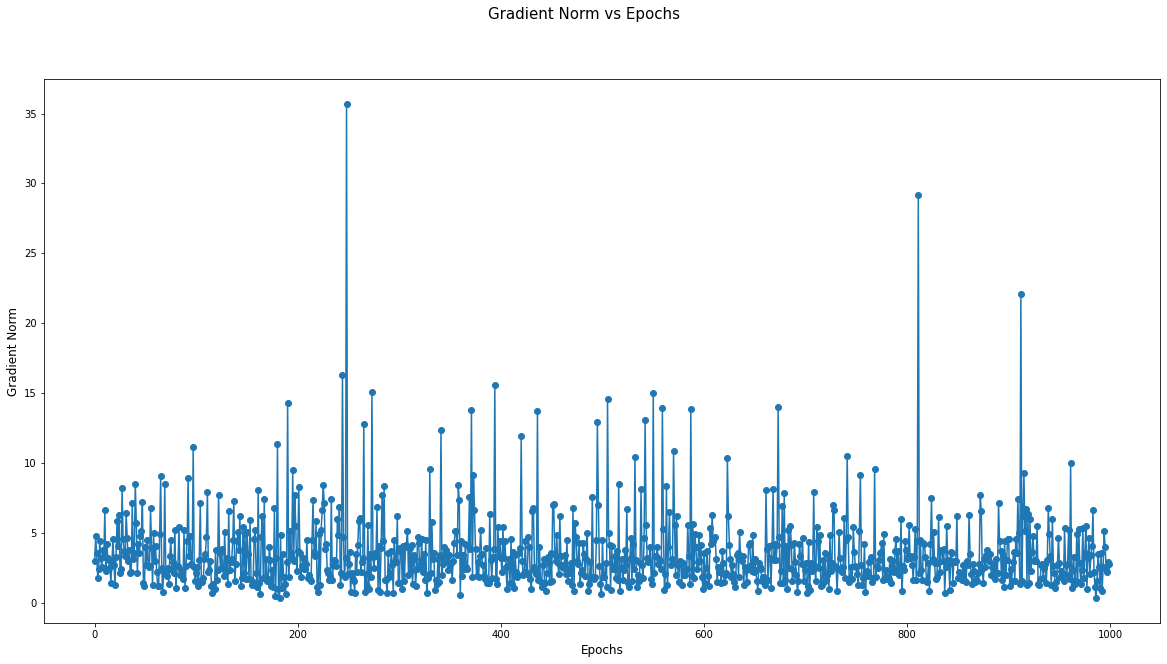

In [27]:

x = np.arange(len(grad_norms))
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.suptitle('Gradient Norm vs Epochs', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Gradient Norm', fontsize=12)
plt.scatter(x,grad_norms)
plt.plot(x,grad_norms)
plt.savefig('gn vs epoch.pdf')


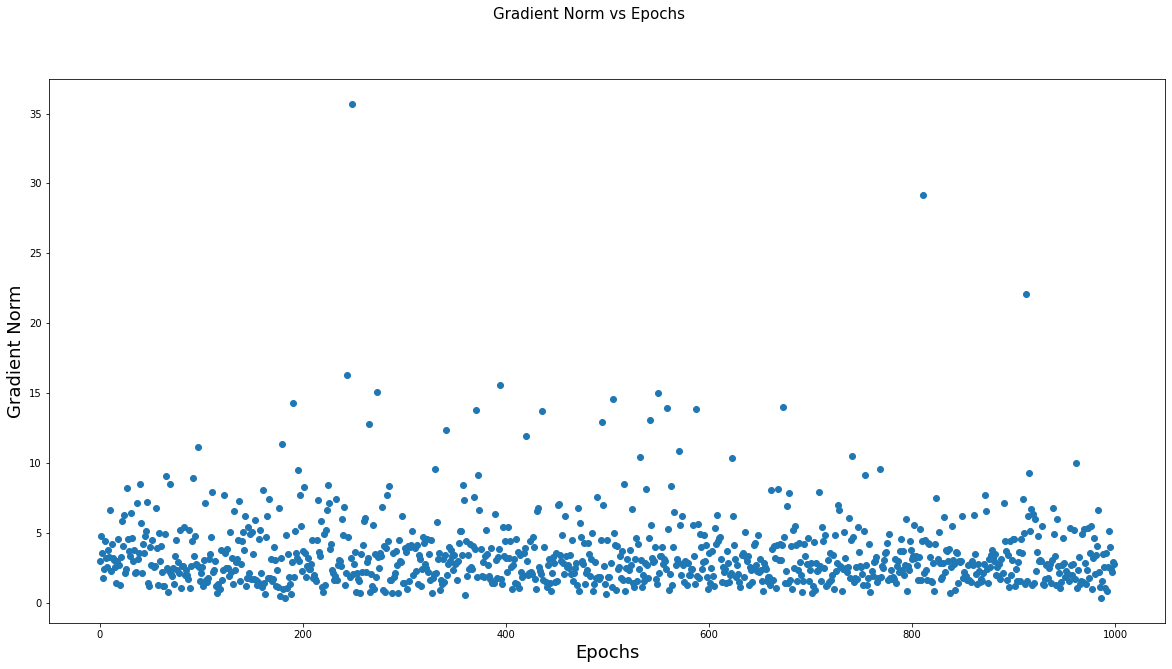

In [28]:
x = np.arange(len(grad_norms))
fig = plt.gcf()
fig.set_size_inches(20, 10)
fig.suptitle('Gradient Norm vs Epochs', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Gradient Norm', fontsize=18)
plt.scatter(x,grad_norms)
plt.savefig('gn vs epoch scatter.pdf')